In [191]:
import requests, json, re, time, os
import pandas as pd
from pycoingecko import CoinGeckoAPI
import arrow
from glob import glob
from pathlib import Path
# from bs4 import BeautifulSoup'

pd.options.display.max_rows = 999


In [2]:
#create coingecko instance
cg = CoinGeckoAPI()

In [3]:
"""
This project is designed to answer a few questions: 
- How do coins perform in the first 30 days from launch?
- If we put $100 on every single coin at launch, would we be profitable within the first 30 days?
- What are the characteristics of a coin which performs well?
- What are the characteristics of a coin which performs poorly?


We're going to be storing data since ideally this should be something we can dockerize and deploy .

Key functions/features


FIND NEW COINS
- Get all coins and find the ones which have ATLs (basically historical events ) which occured less than 3 years ago
-- Create Blacklist - Store the older coins in a file we can reference. Do this once because old coins will always be old.
"new" coins will automatically be added here 

GET COIN DATA
- pull daily historical data for each coin and store the data in its raw json form
- be fault tolerant because new coins may not have historical data
- pull max date - may need pagination funcitonality
- store in /data/<coin-id>/historic

TRANSFORM & JOIN - ~120 days
- For each coin in /data/
-- Build a 120 day view from launch:
--- pull in data for the max date and add as column to global dataframe
--- write out the dataframe as a csv or json into /reports/120days/120day_report.csv | json
-- Build a lookup table:
--- id = coin name, launch_date = launch date, (zulu)

VISUALISE
- Seaborn?

REPORT
- 30 day forecast from day 1
- 30 day forecast from day 2



HOW TO RUN:

- Gather a list of all coins:
-- get_list_of_all_coins()
- Gather data for blacklist cutoff (if you want to only look at specific date ranges like last 3 years)
-- run build_blacklist()
-- this is slow because the only place I could reliably find early dates was in the coin overview in the ATL (all time low)
-- there is quite a lot of nice other data here though we could use to zero in on high performing coins
- Now pull historical pricing data from each coin we haven't blacklisted
-- get_new_coins() 
-- this will get daily pricing from the maximum date possible. we assume it's the launch
-- this will take time due to coingecko's rate limiting

now we have all the data, we can process it:
- build_table_coin_launch() 
-- will build a table you can use to join to get the starting date of the coin
- build_table_Xdays_from_launch() 
-- will go through all coins we have data for and create a first 'X' days report. Defaults to 120 days

csvs are output to /data/processed_tables


"""

'\nThis project is designed to answer a few questions: \n- How do coins perform in the first 30 days from launch?\n- If we put $100 on every single coin at launch, would we be profitable within the first 30 days?\n- What are the characteristics of a coin which performs well?\n- What are the characteristics of a coin which performs poorly?\n\n\nWe\'re going to be storing data since ideally this should be something we can dockerize and deploy .\n\nKey functions/features\n\n\nFIND NEW COINS\n- Get all coins and find the ones which have ATLs (basically historical events ) which occured less than 3 years ago\n-- Create Blacklist - Store the older coins in a file we can reference. Do this once because old coins will always be old.\n"new" coins will automatically be added here \n\nGET COIN DATA\n- pull daily historical data for each coin and store the data in its raw json form\n- be fault tolerant because new coins may not have historical data\n- pull max date - may need pagination funcitonal

In [ ]:
----------------------------

In [ ]:
###################################
###      Utility functions      ###
###################################

In [64]:
env_coins_directory = "../data/coins/"
env_lists_directory = "../data/lists/"
env_all_coin_details_directory = "../data/lists/all_coin_details/"
env_processed_tables_directory = "../data/processed_tables/"

In [229]:
def create_directory_if_not_in_path(path_of_file):
    """ will create a directory in the path of the file specified if it doesn't exist"""
    directory_of_path = re.sub(r"\/[a-zA-Z0-9_\s\-]+\.json","/",path_of_file)
    Path(directory_of_path).mkdir(parents=True, exist_ok=True)
    
def safe_json_load(path_of_file):
    """abstracting the json load dance to just get the data out"""
    try:
        with open(path_of_file, "r") as json_file:
            return json.load(json_file)
    except Exception as e:
        print(f"unable to load file, {e}")
        raise Exception

        
def safe_json_save(data,path_of_file):
    """abstracting the json save dance to just get the data back"""
    try:
        create_directory_if_not_in_path(path_of_file)
        with open(path_of_file, "w") as json_file:
            json.dump(data, json_file)
            return True
    except Exception as e:
        print(f"unable to save file, {e}")
        raise Exception

def check_file_exists(path_of_file):
    """ tell me if a file exists on the path"""
    return os.path.isfile(path_of_file)
    
def get_files_or_directories_in_path(path,extension=None,directories_only=False):
    """ return a list of all directories in a directory """
    #### MAY NOT BE NEEDED
    
    if extension != None and directories_only ==True:
        raise NameError("Can't have extension and directories only.")
    
    else:
        
    
        glob_query = path

        #check if path or directory
        if directories_only == True:
            glob_query = glob_query + "*/"
        elif extension != None:
            glob_query = glob_query + "*."+extension
        else:
            glob_query = glob_query + "*"
            
        return glob(glob_query)
    
def unix_time_to_iso8601(input_unix_time):
    return arrow.get(input_unix_time)

def get_coin_name_from_path(path):
        return re.sub(r"(^.+\/)|(\.json)","",path)

In [ ]:
###################################
###   Coin specific functions   ###
###################################

In [6]:
def get_list_of_all_coins():
    """ will get a list of all coins from coingecko. Should be run daily. Est size <1mb"""
    
    output_file_path = env_lists_directory+"all_coins.json"
    
    try:
        all_coins = cg.get_coins_list()
    except Exception as e:
        raise Exception
    
    print("completed getting all coins list")
    
    try:
        safe_json_save(all_coins,output_file_path)
        print(f"Successfully saved to{output_file_path}")
    except:
        raise Exception


    print(f"Saved list of coins to {output_file_path}")
    pass

In [ ]:
# def get_ids_from_coins_list():
#     json_coin_list = safe_json_load("env_lists_directory+"all_coins.json)
    
#     coin_list__list = []
#     for eachentry in json_coin_list:
        
        
    

In [8]:
def build_blacklist(cutoff_date="2018-01-01"):
    """ will create a json file with coin names. These will not be processed
    Stored as /data/lists/blacklist.json
    Blacklist is used to skip old coins we don't want to analyze
    """
    
    blacklist = []
    
    def to_epoch(input_date):
        return arrow.get(input_date).format("X")
    
    cutoff_date_epoch = to_epoch(cutoff_date)
    json_coin_list = safe_json_load(env_lists_directory+"all_coins.json")
    
    for each_coin in json_coin_list:
        coin_name = each_coin["id"]
        coin_details = get_coin_details(coin_name)
        
        if coin_details != False:
            coin_atl_date = get_atl_details(coin_name) #may return False on failure
            if coin_atl_date != False:
                if to_epoch(coin_atl_date ) < cutoff_date_epoch:
                    blacklist.append(coin_name)
            
    blacklist_dict = { "blacklist": blacklist }
    
    safe_json_save(blacklist_dict,env_lists_directory+"blacklist.json")
    
    print("blacklist completed")
        

    
    pass

In [16]:
def get_coin_details(coin_name):
    coin_save_path = env_all_coin_details_directory+coin_name+".json"
    if os.path.isfile(coin_save_path): #check if file exists already
        try:
            print(f"{coin_name} information already saved. Using that ")
            return safe_json_load(coin_save_path)

        except Exception as e:
            print(e)
    else:
        try:
            time.sleep(.8) #sleep .5seconds to meet throttling limit
            coin_data = cg.get_coin_by_id(coin_name)
            
            safe_json_save(coin_data,coin_save_path)
            return coin_data
        except Exception as e:
            print(f"looks like we cant query this coin {coin_name}: {e}")
            return False

In [14]:
def get_atl_details(coin_name):
    """get the All Time Low date, which we will use for now as the cutoff / start"""
#     coin_data = cg.get_coin_by_id(coin_name)
#     safe_json_save(coin_data,env_all_coin_details_directory+coin_name+".json")
    try:
        print(f"getting the ATL details for {coin_name}")
        coin_details = safe_json_load(env_all_coin_details_directory+coin_name+".json")
        atl_field = coin_details['market_data']['atl_date']['usd']
        return arrow.get(atl_field)
    except Exception as e:
        print(f"error occurred here. {e}")
        
    
    

In [40]:
def get_new_coins(initial_load =False, overwrite_files=False):  
    """ Will get all coins between now and the last successful load. Initial load will just get all. 
    Will check blacklist and will not query coins if present. 
    Coin data will be stored in /data/coins/<coin_name>/initial_load/  (for initial load)
    Coin data will be stored in /data/coins/<coin_name>/YYYYMMDDTHHmmSS/ (for daily load) - not doing now. need a new param
    Stored as JSON as we recieve it
    Named "YYYYMMDD_<coin_name>.json"
    
    """
    ### Will need env var to specify the last updated, or we can store a log of last processed
    
    
    # load blacklist
    # iterate through items in all coins
    # if coin not in blacklist, get the max coin report
    
    all_coins_list = safe_json_load(env_lists_directory+"all_coins.json")
    blacklist = safe_json_load(env_lists_directory+"blacklist.json")
    
    blacklist_list = []
    for each_blacklist_item in blacklist['blacklist']:
        blacklist_list.append(each_blacklist_item)
    
    for each_coin in all_coins_list:
        
        if each_coin['id'] not in blacklist_list:
            output_coin_path = env_coins_directory+each_coin['id']+".json"
            
            # XXXX CHeck if overwrite_files flag. If false, check if file exists in directory. 
            if overwrite_files == False and check_file_exists(output_coin_path) == False:
                
                time.sleep(1) #limit requests to 1 a second
                try:
                    print(f"getting coin history for {each_coin['id']}")
                    coin_history = cg.get_coin_market_chart_by_id(each_coin['id'],vs_currency="usd",days="max", interval="daily")
                    safe_json_save(coin_history,output_coin_path)
                except Exception as e:
                    print(f"Failed to get history for {each_coin['id']}")
            else:
                print(f"file {each_coin['id']} already saved")


In [239]:
def build_table_Xdays_from_launch(days=120):
    """Will go through the coins we have and build a dataframe of coin opening reports
    from day0 to day 120, relative to the launch date of the coin
    These will be output in a single big assed file like csv / json
    
    """
    
    # I Should normalise to :

    """
    Day | Coin | Price 
    
    Then we can just rely on grouping by

    """
    
    #create df with details. first column "Da"
    
    df = pd.DataFrame(columns = ["day_number","coin_id", "coin_price"])  #pandas uses 1 as start 
    
    
#     return 0
    # list(range(11, 17))
    
    #iterate through every coin in coin directory
    #safe load
    #check for length of list and if less than days, get the max then null the rest
    #for each in range 0-days(or max if less than days)
    #append to a list
    #once completed, 
    
    def create_list_for_coin(coin,days=days):
        """ Create a list with the days 0-maxdays listed, coin name """
        
        day_numbers = list(range(0, days))
        coin_df = pd.DataFrame(day_numbers, columns=["day_number"])
        coin_df["coin_id"] = coin
        
        return coin_df
    
    
    coin_directory_contents = get_files_or_directories_in_path(env_coins_directory,extension="json")
    
    for each_coin_file in coin_directory_contents:    
        coin_content = safe_json_load(each_coin_file)
        coin_days = days
        coin_pricing_column = []
        coin_name = get_coin_name_from_path(each_coin_file)
        coin_days_dif = 0
        
        print(f"starting on {coin_name}")
        
        #create a list 
        
        
        
        length_of_data = len(coin_content['prices'])
        if coin_days > length_of_data:
            coin_days = length_of_data
            coin_days_dif = days-length_of_data
            print(f"different sized days: {coin_days_dif}")
        
        for day_number in range(0,coin_days):
            coin_pricing_column.append(coin_content['prices'][day_number][1]) #append price at day
            
        if coin_days_dif != 0:
            #extend the list so all are same length for dataframe
            for day_number_empty in range(0,coin_days_dif):
                coin_pricing_column.append(None)
            
        coin_df = create_list_for_coin(coin_name,days)
        coin_df["coin_price"] = coin_pricing_column
#         coin_df.reset_index()
        
#         display(coin_df)
        
        df = df.append(coin_df, ignore_index=True)
#         df[coin_name] = coin_pricing_column
        
        print(f"added {coin_name} to dataframe")
#         print(df)

            
#     display(df.head())

    df.to_csv(env_processed_tables_directory+f"coin_day_launch_report{days}_normalised.csv", index=False)
    print("completed outputting coin pricing range from launch table.")
    
    print(df)
    
    
    pass

In [80]:
def build_table_coin_launch():
    """Will build a table which has the coin name and launch date (max date listed)
    This will allow us to split coins into specific bins eg. "2021 bull market"
    """
    coin_directory = get_files_or_directories_in_path(env_coins_directory,extension="json")
    
    coin_list = []
    
#     def get_coin_name_from_path(path):
#         return re.sub(r"(^.+\/)|(\.json)","",path)
    
    
    
    for each_coin_file in coin_directory:
        coin_content = safe_json_load(each_coin_file)
        coin_name = get_coin_name_from_path(each_coin_file)
        
        try:
            coin_first_date = unix_time_to_iso8601(coin_content["prices"][0][0])
        except Exception as e:
            raise ValueError(f"Coin {coin_name} doesn't have a start date. Maybe wait a bit for new data")
            coin_first_date = None
        
        
        coin_list.append([coin_name,coin_first_date])
        #name of coin = name of file
        #each_coin_file['prices'][0] is the first price at opening
        
    df = pd.DataFrame(coin_list,columns=["coin_id","first_date"])
    
    df.to_csv(env_processed_tables_directory+"coin_details.csv", index=False)
    print("completed outputting coin details table.")

In [ ]:
# debugging and scratchpad below

In [71]:
build_table_coin_launch()

In [ ]:
build_table_Xdays_from_launch()

starting on goldblock


day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
5             5  goldblock    0.000994
6             6  goldblock    0.001399
7             7  goldblock    0.001040
8             8  goldblock    0.002496
9             9  goldblock    0.003600
10           10  goldblock    0.005518
11           11  goldblock    0.003137
12           12  goldblock    0.003043
13           13  goldblock    0.003241
14           14  goldblock    0.007211
15           15  goldblock    0.009044
16           16  goldblock    0.009045
17           17  goldblock    0.008890
18           18  goldblock    0.009058
19           19  goldblock    0.009054
20           20  goldblock    0.009043
21           21  goldblock    0.008607
22           22  goldblock    0.009020
23           23  goldblock    0.009045
24           24  goldblock    0.009261
25           25  goldblock    0.009254
26           26  goldblock    0.011004
27           27  goldblock    0.011308
28           28  goldblock    0.011268
29           29  goldblock    0.011180
30           30  goldblock    0.013845
31           31  goldblock    0.015493
32           32  goldblock    0.016238
33           33  goldblock    0.016889
34           34  goldblock    0.016757
35           35  goldblock    0.016755
36           36  goldblock    0.018719
37           37  goldblock    0.020473
38           38  goldblock    0.021523
39           39  goldblock    0.022524
40           40  goldblock    0.023330
41           41  goldblock    0.025117
42           42  goldblock    0.022917
43           43  goldblock    0.021962
44           44  goldblock    0.021977
45           45  goldblock    0.021956
46           46  goldblock    0.024475
47           47  goldblock    0.018406
48           48  goldblock    0.018412
49           49  goldblock    0.024002
50           50  goldblock    0.024000
51           51  goldblock    0.021008
52           52  goldblock    0.023971
53           53  goldblock    0.023981
54           54  goldblock    0.032204
55           55  goldblock    0.033510
56           56  goldblock    0.033483
57           57  goldblock    0.033520
58           58  goldblock    0.034829
59           59  goldblock    0.035044
60           60  goldblock    0.035011
61           61  goldblock    0.033819
62           62  goldblock    0.033821
63           63  goldblock    0.033822
64           64  goldblock    0.018018
65           65  goldblock    0.032967
66           66  goldblock    0.021092
67           67  goldblock    0.017876
68           68  goldblock    0.017908
69           69  goldblock    0.032623
70           70  goldblock    0.027468
71           71  goldblock    0.018002
72           72  goldblock    0.018448
73           73  goldblock    0.024482
74           74  goldblock    0.027974
75           75  goldblock    0.029994
76           76  goldblock    0.030007
77           77  goldblock    0.019283
78           78  goldblock    0.025957
79           79  goldblock    0.021814
80           80  goldblock    0.019684
81           81  goldblock    0.018393
82           82  goldblock    0.017387
83           83  goldblock    0.016729
84           84  goldblock    0.016855
85           85  goldblock    0.017042
86           86  goldblock    0.016845
87           87  goldblock    0.016617
88           88  goldblock    0.017305
89           89  goldblock    0.016638
90           90  goldblock    0.016844
91           91  goldblock    0.016030
92           92  goldblock    0.016415
93           93  goldblock    0.016304
94           94  goldblock    0.016471
95           95  goldblock    0.016401
96           96  goldblock    0.016060
97           97  goldblock    0.016083
98           98  goldblock    0.016176
99           99  goldblock    0.016054
100         100  goldblock    0.016056
101         101  goldblock 

added goldblock to dataframe
    day_number    coin_id  coin_price
0            0  goldblock    0.002913
1            1  goldblock    0.001905
2            2  goldblock    0.002204
3            3  goldblock    0.001005
4            4  goldblock    0.001594
5            5  goldblock    0.000994
6            6  goldblock    0.001399
7            7  goldblock    0.001040
8            8  goldblock    0.002496
9            9  goldblock    0.003600
10          10  goldblock    0.005518
11          11  goldblock    0.003137
12          12  goldblock    0.003043
13          13  goldblock    0.003241
14          14  goldblock    0.007211
15          15  goldblock    0.009044
16          16  goldblock    0.009045
17          17  goldblock    0.008890
18          18  goldblock    0.009058
19          19  goldblock    0.009054
20          20  goldblock    0.009043
21          21  goldblock    0.008607
22          22  goldblock    0.009020
23          23  goldblock    0.009045
24          24  goldb

day_number coin_id  coin_price
0             0    arth    2.588137
1             1    arth    2.588137
2             2    arth    2.075511
3             3    arth    1.581607
4             4    arth    1.450591
5             5    arth    2.130139
6             6    arth    1.824604
7             7    arth    2.718224
8             8    arth    1.168566
9             9    arth    0.931371
10           10    arth    0.972576
11           11    arth    0.879757
12           12    arth    0.900804
13           13    arth    0.850801
14           14    arth    0.914547
15           15    arth    0.785345
16           16    arth    0.732295
17           17    arth    0.758970
18           18    arth    0.723985
19           19    arth    0.767877
20           20    arth    0.709497
21           21    arth    0.755190
22           22    arth    0.772665
23           23    arth    0.815260
24           24    arth    0.746539
25           25    arth    0.705205
26           26    arth    0.659756
27           27    arth    0.751365
28           28    arth    0.677607
29           29    arth    0.802148
30           30    arth    0.720938
31           31    arth    0.645454
32           32    arth    0.794184
33           33    arth    0.655240
34           34    arth    0.728683
35           35    arth    0.698624
36           36    arth    0.723204
37           37    arth    0.539131
38           38    arth    0.507159
39           39    arth    0.448267
40           40    arth    0.389504
41           41    arth    0.369875
42           42    arth    0.398437
43           43    arth    0.368960
44           44    arth    0.310517
45           45    arth    0.289902
46           46    arth    0.265934
47           47    arth    0.234982
48           48    arth    0.231827
49           49    arth    0.191612
50           50    arth    0.203672
51           51    arth    0.190576
52           52    arth    0.176716
53           53    arth    0.190426
54           54    arth    0.177881
55           55    arth    0.195354
56           56    arth    0.289284
57           57    arth    0.344687
58           58    arth    0.318229
59           59    arth    0.263090
60           60    arth    0.261927
61           61    arth    0.240378
62           62    arth    0.253397
63           63    arth    0.257209
64           64    arth    0.245183
65           65    arth    0.226317
66           66    arth    0.224952
67           67    arth    0.224470
68           68    arth    0.225889
69           69    arth    0.245326
70           70    arth    0.239166
71           71    arth    0.237759
72           72    arth    0.247491
73           73    arth    0.254138
74           74    arth    0.289112
75           75    arth    0.249912
76           76    arth    0.237992
77           77    arth    0.246734
78           78    arth    0.265356
79           79    arth    0.267393
80           80    arth    0.240959
81           81    arth    0.248983
82           82    arth    0.265291
83           83    arth    0.239770
84           84    arth    0.248505
85           85    arth    0.252062
86           86    arth    0.249020
87           87    arth    0.244873
88           88    arth    0.253153
89           89    arth    0.336059
90           90    arth    0.316723
91           91    arth    0.323845
92           92    arth    0.288714
93           93    arth    0.340852
94           94    arth    0.321675
95           95    arth    0.304449
96           96    arth    0.325256
97           97    arth    0.302590
98           98    arth    0.327610
99           99    arth    0.330274
100         100    arth    0.333583
101         101    arth    0.350189
102         102    arth    0.395372
103         103    arth    0.348824
104         104    arth    0.329791
105         105    arth    0.328736
106         106    arth    0.329449
107         107    arth    0.279992
108         108    arth    0.288160
109         109    arth    0.275331
110      

added arth to dataframe
    day_number    coin_id  coin_price
0            0  goldblock    0.002913
1            1  goldblock    0.001905
2            2  goldblock    0.002204
3            3  goldblock    0.001005
4            4  goldblock    0.001594
5            5  goldblock    0.000994
6            6  goldblock    0.001399
7            7  goldblock    0.001040
8            8  goldblock    0.002496
9            9  goldblock    0.003600
10          10  goldblock    0.005518
11          11  goldblock    0.003137
12          12  goldblock    0.003043
13          13  goldblock    0.003241
14          14  goldblock    0.007211
15          15  goldblock    0.009044
16          16  goldblock    0.009045
17          17  goldblock    0.008890
18          18  goldblock    0.009058
19          19  goldblock    0.009054
20          20  goldblock    0.009043
21          21  goldblock    0.008607
22          22  goldblock    0.009020
23          23  goldblock    0.009045
24          24  goldblock 

day_number               coin_id  coin_price
0             0  interest-bearing-dpi  462.521396
1             1  interest-bearing-dpi  462.521396
2             2  interest-bearing-dpi  469.607797
3             3  interest-bearing-dpi  420.200529
4             4  interest-bearing-dpi  445.081924
5             5  interest-bearing-dpi  437.895144
6             6  interest-bearing-dpi  441.160760
7             7  interest-bearing-dpi  439.262358
8             8  interest-bearing-dpi  475.226287
9             9  interest-bearing-dpi  476.204408
10           10  interest-bearing-dpi  474.332627
11           11  interest-bearing-dpi  554.234698
12           12  interest-bearing-dpi  525.725056
13           13  interest-bearing-dpi  513.445343
14           14  interest-bearing-dpi  470.418007
15           15  interest-bearing-dpi  439.450444
16           16  interest-bearing-dpi  437.257687
17           17  interest-bearing-dpi  460.245620
18           18  interest-bearing-dpi  472.486758
19           19  interest-bearing-dpi  445.214177
20           20  interest-bearing-dpi  415.396280
21           21  interest-bearing-dpi  430.467797
22           22  interest-bearing-dpi  480.810865
23           23  interest-bearing-dpi  520.294647
24           24  interest-bearing-dpi  526.782091
25           25  interest-bearing-dpi  521.078321
26           26  interest-bearing-dpi  529.959931
27           27  interest-bearing-dpi  563.314050
28           28  interest-bearing-dpi  562.395877
29           29  interest-bearing-dpi  607.312847
30           30  interest-bearing-dpi  562.399518
31           31  interest-bearing-dpi  569.878260
32           32  interest-bearing-dpi  558.814308
33           33  interest-bearing-dpi  553.101753
34           34  interest-bearing-dpi  601.986451
35           35  interest-bearing-dpi  551.955784
36           36  interest-bearing-dpi  519.951037
37           37  interest-bearing-dpi  562.826029
38           38  interest-bearing-dpi  612.995597
39           39  interest-bearing-dpi  561.557707
40           40  interest-bearing-dpi  608.466250
41           41  interest-bearing-dpi  577.899697
42           42  interest-bearing-dpi  519.234848
43           43  interest-bearing-dpi  530.806395
44           44  interest-bearing-dpi  599.306516
45           45  interest-bearing-dpi  387.990738
46           46  interest-bearing-dpi  441.672106
47           47  interest-bearing-dpi         NaN
48           48  interest-bearing-dpi         NaN
49           49  interest-bearing-dpi         NaN
50           50  interest-bearing-dpi         NaN
51           51  interest-bearing-dpi         NaN
52           52  interest-bearing-dpi         NaN
53           53  interest-bearing-dpi         NaN
54           54  interest-bearing-dpi         NaN
55           55  interest-bearing-dpi         NaN
56           56  interest-bearing-dpi         NaN
57           57  interest-bearing-dpi         NaN
58           58  interest-bearing-dpi         NaN
59           59  interest-bearing-dpi         NaN
60           60  interest-bearing-dpi         NaN
61           61  interest-bearing-dpi         NaN
62           62  interest-bearing-dpi         NaN
63           63  interest-bearing-dpi         NaN
64           64  interest-bearing-dpi         NaN
65           65  interest-bearing-dpi         NaN
66           66  interest-bearing-dpi         NaN
67           67  interest-bearing-dpi         NaN
68           68  interest-bearing-dpi         NaN
69           69  interest-bearing-dpi         NaN
70           70  interest-bearing-dpi         NaN
71           71  interest-bearing-dpi         NaN
72           72  interest-bearing-dpi         NaN
73           73  interest-bearing-dpi         NaN
74           74  interest-bearing-dpi         NaN
75           75  interest-bearing-dpi         NaN
76           76  interest-bearing-dpi         NaN
77           77  interest-bearing-dpi         NaN
78           78  interest-bearing-dpi         NaN
79   

added interest-bearing-dpi to dataframe
    day_number               coin_id  coin_price
0            0             goldblock    0.002913
1            1             goldblock    0.001905
2            2             goldblock    0.002204
3            3             goldblock    0.001005
4            4             goldblock    0.001594
5            5             goldblock    0.000994
6            6             goldblock    0.001399
7            7             goldblock    0.001040
8            8             goldblock    0.002496
9            9             goldblock    0.003600
10          10             goldblock    0.005518
11          11             goldblock    0.003137
12          12             goldblock    0.003043
13          13             goldblock    0.003241
14          14             goldblock    0.007211
15          15             goldblock    0.009044
16          16             goldblock    0.009045
17          17             goldblock    0.008890
18          18             go

day_number    coin_id    coin_price
0             0  dexa-coin  9.219727e-06
1             1  dexa-coin  1.300356e-05
2             2  dexa-coin  3.701082e-06
3             3  dexa-coin  9.002083e-06
4             4  dexa-coin  9.712146e-06
5             5  dexa-coin  9.003335e-06
6             6  dexa-coin  6.802110e-06
7             7  dexa-coin  6.808027e-06
8             8  dexa-coin  8.597696e-06
9             9  dexa-coin  6.607101e-06
10           10  dexa-coin  4.313688e-06
11           11  dexa-coin  4.005719e-06
12           12  dexa-coin  4.396056e-06
13           13  dexa-coin  3.204195e-06
14           14  dexa-coin  3.699746e-06
15           15  dexa-coin  2.302228e-06
16           16  dexa-coin  2.705352e-06
17           17  dexa-coin  2.701176e-06
18           18  dexa-coin  2.200434e-06
19           19  dexa-coin  2.302493e-06
20           20  dexa-coin  1.897372e-06
21           21  dexa-coin  1.700178e-06
22           22  dexa-coin  1.600457e-06
23           23  dexa-coin  1.200510e-06
24           24  dexa-coin  9.000863e-07
25           25  dexa-coin  1.302760e-06
26           26  dexa-coin  1.099721e-06
27           27  dexa-coin  1.203758e-06
28           28  dexa-coin  2.499559e-06
29           29  dexa-coin  2.801034e-06
30           30  dexa-coin  2.102135e-06
31           31  dexa-coin  1.401335e-06
32           32  dexa-coin  1.200652e-06
33           33  dexa-coin  1.100212e-06
34           34  dexa-coin  1.400477e-06
35           35  dexa-coin  2.700637e-06
36           36  dexa-coin  1.904950e-06
37           37  dexa-coin  3.503682e-06
38           38  dexa-coin  1.797985e-06
39           39  dexa-coin  1.802651e-06
40           40  dexa-coin  1.399922e-06
41           41  dexa-coin  1.401990e-06
42           42  dexa-coin  1.759695e-06
43           43  dexa-coin  1.835040e-06
44           44  dexa-coin  1.800817e-06
45           45  dexa-coin  1.795585e-06
46           46  dexa-coin  1.680507e-06
47           47  dexa-coin  1.276557e-06
48           48  dexa-coin  1.715428e-06
49           49  dexa-coin  1.561230e-06
50           50  dexa-coin  1.396574e-06
51           51  dexa-coin  1.490488e-06
52           52  dexa-coin  1.405581e-06
53           53  dexa-coin  1.292637e-06
54           54  dexa-coin  1.327757e-06
55           55  dexa-coin  1.497693e-06
56           56  dexa-coin  1.596336e-06
57           57  dexa-coin  1.593413e-06
58           58  dexa-coin  1.702243e-06
59           59  dexa-coin  1.620483e-06
60           60  dexa-coin  1.612069e-06
61           61  dexa-coin  1.542096e-06
62           62  dexa-coin  1.504942e-06
63           63  dexa-coin  1.620753e-06
64           64  dexa-coin  1.721191e-06
65           65  dexa-coin  1.501081e-06
66           66  dexa-coin  1.403905e-06
67           67  dexa-coin  1.503591e-06
68           68  dexa-coin  1.616021e-06
69           69  dexa-coin  1.680681e-06
70           70  dexa-coin  1.399671e-06
71           71  dexa-coin  1.498700e-06
72           72  dexa-coin  1.033788e-06
73           73  dexa-coin  1.499587e-06
74           74  dexa-coin  1.049645e-06
75           75  dexa-coin  1.530025e-06
76           76  dexa-coin  1.099228e-06
77           77  dexa-coin  1.131311e-06
78           78  dexa-coin  1.176496e-06
79           79  dexa-coin  8.982492e-07
80           80  dexa-coin  1.123983e-06
81           81  dexa-coin  1.318401e-06
82           82  dexa-coin  1.128306e-06
83           83  dexa-coin  1.136425e-06
84           84  dexa-coin  1.010535e-06
85           85  dexa-coin  8.579667e-07
86           86  dexa-coin  1.026743e-06
87           87  dexa-coin  1.015549e-06
88           88  dexa-coin  1.546274e-06
89           89  dexa-coin  1.153142e-06
90           90  dexa-coin  1.178052e-06
91           91  dexa-coin  1.207065e-06
92           92  dexa-coin  1.426965e-06
93           93  dexa-coin  1.324173e-06
94           94  dexa-coin  1.211439e-06
95           95  dexa-coin  1.301289e-06
96           96  dexa-coin  

added dexa-coin to dataframe
    day_number               coin_id    coin_price
0            0             goldblock  2.913162e-03
1            1             goldblock  1.904866e-03
2            2             goldblock  2.204145e-03
3            3             goldblock  1.004806e-03
4            4             goldblock  1.594422e-03
5            5             goldblock  9.940161e-04
6            6             goldblock  1.399166e-03
7            7             goldblock  1.039584e-03
8            8             goldblock  2.496297e-03
9            9             goldblock  3.600244e-03
10          10             goldblock  5.517870e-03
11          11             goldblock  3.137026e-03
12          12             goldblock  3.042887e-03
13          13             goldblock  3.241027e-03
14          14             goldblock  7.210615e-03
15          15             goldblock  9.044022e-03
16          16             goldblock  9.044732e-03
17          17             goldblock  8.889620e-03
18

day_number      coin_id  coin_price
0             0  californium    0.037557
1             1  californium    0.059229
2             2  californium    0.037870
3             3  californium    0.035728
4             4  californium    0.057172
5             5  californium    0.037192
6             6  californium    0.034694
7             7  californium    0.039205
8             8  californium    0.032468
9             9  californium    0.031124
10           10  californium    0.026703
11           11  californium    0.019811
12           12  californium    0.030822
13           13  californium    0.031471
14           14  californium    0.220498
15           15  californium    0.027700
16           16  californium    0.027583
17           17  californium    0.044824
18           18  californium    0.041824
19           19  californium    0.027412
20           20  californium    0.026743
21           21  californium    0.026214
22           22  californium    0.024997
23           23  californium    0.032072
24           24  californium    0.031788
25           25  californium    0.031690
26           26  californium    0.033855
27           27  californium    0.029407
28           28  californium    0.020052
29           29  californium    0.028760
30           30  californium    0.031773
31           31  californium    0.033455
32           32  californium    0.032919
33           33  californium    0.030979
34           34  californium    0.030370
35           35  californium    0.030624
36           36  californium    0.028079
37           37  californium    0.028617
38           38  californium    0.021648
39           39  californium    0.031928
40           40  californium    0.031651
41           41  californium    0.028491
42           42  californium    0.032094
43           43  californium    0.025476
44           44  californium    0.025130
45           45  californium    0.024339
46           46  californium    0.024942
47           47  californium    0.012780
48           48  californium    0.009428
49           49  californium    0.009874
50           50  californium    0.008514
51           51  californium    0.019253
52           52  californium    0.010293
53           53  californium    0.017693
54           54  californium    0.018896
55           55  californium    0.021390
56           56  californium    0.026271
57           57  californium    0.023645
58           58  californium    0.019635
59           59  californium    0.020154
60           60  californium    0.027084
61           61  californium    0.014433
62           62  californium    0.019952
63           63  californium    0.032439
64           64  californium    0.020328
65           65  californium    0.020204
66           66  californium    0.010009
67           67  californium    0.016481
68           68  californium    0.016121
69           69  californium    0.013927
70           70  californium    0.013989
71           71  californium    0.022835
72           72  californium    0.025333
73           73  californium    0.020069
74           74  californium    0.018640
75           75  californium    0.023796
76           76  californium    0.019812
77           77  californium    0.025112
78           78  californium    0.022136
79           79  californium    0.026138
80           80  californium    0.019702
81           81  californium    0.021467
82           82  californium    0.022236
83           83  californium    0.022205
84           84  californium    0.022225
85           85  californium    0.021920
86           86  californium    0.019977
87           87  californium    0.019804
88           88  californium    0.015158
89           89  californium    0.020876
90           90  californium    0.024424
91           91  californium    0.019575
92           92  californium    0.016965
93           93  californium    0.016874
94           94  californium    0.024090
95           95  californium    0.023928
96           96  californium

added californium to dataframe
    day_number               coin_id    coin_price
0            0             goldblock  2.913162e-03
1            1             goldblock  1.904866e-03
2            2             goldblock  2.204145e-03
3            3             goldblock  1.004806e-03
4            4             goldblock  1.594422e-03
5            5             goldblock  9.940161e-04
6            6             goldblock  1.399166e-03
7            7             goldblock  1.039584e-03
8            8             goldblock  2.496297e-03
9            9             goldblock  3.600244e-03
10          10             goldblock  5.517870e-03
11          11             goldblock  3.137026e-03
12          12             goldblock  3.042887e-03
13          13             goldblock  3.241027e-03
14          14             goldblock  7.210615e-03
15          15             goldblock  9.044022e-03
16          16             goldblock  9.044732e-03
17          17             goldblock  8.889620e-03


day_number coin_id  coin_price
0             0    able    0.002409
1             1    able    0.001866
2             2    able    0.002246
3             3    able    0.002076
4             4    able    0.001769
5             5    able    0.001889
6             6    able    0.001884
7             7    able    0.002070
8             8    able    0.002080
9             9    able    0.002031
10           10    able    0.002375
11           11    able    0.002160
12           12    able    0.002572
13           13    able    0.002671
14           14    able    0.002550
15           15    able    0.002963
16           16    able    0.002735
17           17    able    0.002941
18           18    able    0.002571
19           19    able    0.003407
20           20    able    0.001280
21           21    able    0.001321
22           22    able    0.001123
23           23    able    0.001474
24           24    able    0.001268
25           25    able    0.001077
26           26    able    0.000949
27           27    able    0.000959
28           28    able    0.001020
29           29    able    0.000994
30           30    able    0.000923
31           31    able    0.000893
32           32    able    0.000865
33           33    able    0.000856
34           34    able    0.000703
35           35    able    0.000597
36           36    able    0.000682
37           37    able    0.000690
38           38    able    0.000690
39           39    able    0.000845
40           40    able    0.000801
41           41    able    0.000737
42           42    able    0.000747
43           43    able    0.000721
44           44    able    0.000782
45           45    able    0.000735
46           46    able    0.000683
47           47    able    0.000600
48           48    able    0.000568
49           49    able    0.000725
50           50    able    0.000649
51           51    able    0.000724
52           52    able    0.000747
53           53    able    0.000773
54           54    able    0.000725
55           55    able    0.000712
56           56    able    0.000735
57           57    able    0.000733
58           58    able    0.000701
59           59    able    0.000742
60           60    able    0.000375
61           61    able    0.000386
62           62    able    0.000348
63           63    able    0.000335
64           64    able    0.000356
65           65    able    0.000357
66           66    able    0.000356
67           67    able    0.000326
68           68    able    0.000331
69           69    able    0.000321
70           70    able    0.000323
71           71    able    0.000304
72           72    able    0.000313
73           73    able    0.000317
74           74    able    0.000316
75           75    able    0.000308
76           76    able    0.000236
77           77    able    0.000251
78           78    able    0.000237
79           79    able    0.000251
80           80    able    0.000306
81           81    able    0.000249
82           82    able    0.000235
83           83    able    0.000230
84           84    able    0.000230
85           85    able    0.000225
86           86    able    0.000193
87           87    able    0.000171
88           88    able    0.000175
89           89    able    0.000168
90           90    able    0.000160
91           91    able    0.000163
92           92    able    0.000160
93           93    able    0.000153
94           94    able    0.000143
95           95    able    0.000162
96           96    able    0.000169
97           97    able    0.000182
98           98    able    0.000183
99           99    able    0.000180
100         100    able    0.000177
101         101    able    0.000204
102         102    able    0.000202
103         103    able    0.000207
104         104    able    0.000214
105         105    able    0.000157
106         106    able    0.000174
107         107    able    0.000127
108         108    able    0.000132
109         109    able    0.000144
110      

added able to dataframe
    day_number               coin_id    coin_price
0            0             goldblock  2.913162e-03
1            1             goldblock  1.904866e-03
2            2             goldblock  2.204145e-03
3            3             goldblock  1.004806e-03
4            4             goldblock  1.594422e-03
5            5             goldblock  9.940161e-04
6            6             goldblock  1.399166e-03
7            7             goldblock  1.039584e-03
8            8             goldblock  2.496297e-03
9            9             goldblock  3.600244e-03
10          10             goldblock  5.517870e-03
11          11             goldblock  3.137026e-03
12          12             goldblock  3.042887e-03
13          13             goldblock  3.241027e-03
14          14             goldblock  7.210615e-03
15          15             goldblock  9.044022e-03
16          16             goldblock  9.044732e-03
17          17             goldblock  8.889620e-03
18     

starting on intelligent-investment-chain


day_number                       coin_id  coin_price
0             0  intelligent-investment-chain    0.006815
1             1  intelligent-investment-chain    0.006934
2             2  intelligent-investment-chain    0.006373
3             3  intelligent-investment-chain    0.006506
4             4  intelligent-investment-chain    0.005967
5             5  intelligent-investment-chain    0.006492
6             6  intelligent-investment-chain    0.006289
7             7  intelligent-investment-chain    0.006304
8             8  intelligent-investment-chain    0.006351
9             9  intelligent-investment-chain    0.006116
10           10  intelligent-investment-chain    0.006085
11           11  intelligent-investment-chain    0.005630
12           12  intelligent-investment-chain    0.005651
13           13  intelligent-investment-chain    0.005393
14           14  intelligent-investment-chain    0.005396
15           15  intelligent-investment-chain    0.005175
16           16  intelligent-investment-chain    0.004777
17           17  intelligent-investment-chain    0.003930
18           18  intelligent-investment-chain    0.003810
19           19  intelligent-investment-chain    0.003312
20           20  intelligent-investment-chain    0.003102
21           21  intelligent-investment-chain    0.003860
22           22  intelligent-investment-chain    0.004491
23           23  intelligent-investment-chain    0.003976
24           24  intelligent-investment-chain    0.004026
25           25  intelligent-investment-chain    0.004039
26           26  intelligent-investment-chain    0.004081
27           27  intelligent-investment-chain    0.003838
28           28  intelligent-investment-chain    0.003642
29           29  intelligent-investment-chain    0.003255
30           30  intelligent-investment-chain    0.003285
31           31  intelligent-investment-chain    0.003061
32           32  intelligent-investment-chain    0.003196
33           33  intelligent-investment-chain    0.003007
34           34  intelligent-investment-chain    0.002989
35           35  intelligent-investment-chain    0.002882
36           36  intelligent-investment-chain    0.003050
37           37  intelligent-investment-chain    0.003120
38           38  intelligent-investment-chain    0.003053
39           39  intelligent-investment-chain    0.003148
40           40  intelligent-investment-chain    0.003178
41           41  intelligent-investment-chain    0.003027
42           42  intelligent-investment-chain    0.002996
43           43  intelligent-investment-chain    0.003108
44           44  intelligent-investment-chain    0.003137
45           45  intelligent-investment-chain    0.003088
46           46  intelligent-investment-chain    0.003076
47           47  intelligent-investment-chain    0.002636
48           48  intelligent-investment-chain    0.002243
49           49  intelligent-investment-chain    0.001902
50           50  intelligent-investment-chain    0.002080
51           51  intelligent-investment-chain    0.002116
52           52  intelligent-investment-chain    0.002059
53           53  intelligent-investment-chain    0.002153
54           54  intelligent-investment-chain    0.002139
55           55  intelligent-investment-chain    0.001900
56           56  intelligent-investment-chain    0.001787
57           57  intelligent-investment-chain    0.001625
58           58  intelligent-investment-chain    0.001614
59           59  intelligent-investment-chain    0.001692
60           60  intelligent-investment-chain    0.001699
61           61  intelligent-investment-chain    0.002040
62           62  intelligent-investment-chain    0.001799
63           63  intelligent-investment-chain    0.001723
64           64  intelligent-investment-chain    0.001885
65           65  intelligent-investment-chain    0.001955
66           66  intelligent-investment-chain    0.002014
67           67  intelligent-investment-chain    0.001883
68 

added intelligent-investment-chain to dataframe
    day_number                       coin_id    coin_price
0            0                     goldblock  2.913162e-03
1            1                     goldblock  1.904866e-03
2            2                     goldblock  2.204145e-03
3            3                     goldblock  1.004806e-03
4            4                     goldblock  1.594422e-03
5            5                     goldblock  9.940161e-04
6            6                     goldblock  1.399166e-03
7            7                     goldblock  1.039584e-03
8            8                     goldblock  2.496297e-03
9            9                     goldblock  3.600244e-03
10          10                     goldblock  5.517870e-03
11          11                     goldblock  3.137026e-03
12          12                     goldblock  3.042887e-03
13          13                     goldblock  3.241027e-03
14          14                     goldblock  7.210615e-03
15      

day_number     coin_id  coin_price
0             0  marginswap    1.062318
1             1  marginswap    1.062318
2             2  marginswap    0.688641
3             3  marginswap    0.897024
4             4  marginswap    0.745301
5             5  marginswap    1.342416
6             6  marginswap    1.095962
7             7  marginswap    1.006005
8             8  marginswap    0.978014
9             9  marginswap    1.087005
10           10  marginswap    1.533329
11           11  marginswap    1.534832
12           12  marginswap    1.388381
13           13  marginswap    1.431775
14           14  marginswap    1.396635
15           15  marginswap    1.229058
16           16  marginswap    1.109014
17           17  marginswap    1.069520
18           18  marginswap    0.780442
19           19  marginswap    0.818596
20           20  marginswap    0.834767
21           21  marginswap    0.707186
22           22  marginswap    0.831608
23           23  marginswap    0.775932
24           24  marginswap    0.883067
25           25  marginswap    0.882296
26           26  marginswap    0.801812
27           27  marginswap    0.739803
28           28  marginswap    0.755836
29           29  marginswap    0.753456
30           30  marginswap    0.983789
31           31  marginswap    0.939080
32           32  marginswap    1.062191
33           33  marginswap    1.172314
34           34  marginswap    1.105258
35           35  marginswap    0.973897
36           36  marginswap    0.957705
37           37  marginswap    1.100680
38           38  marginswap    1.539998
39           39  marginswap    2.056029
40           40  marginswap    2.766107
41           41  marginswap    2.389139
42           42  marginswap    2.082527
43           43  marginswap    2.105352
44           44  marginswap    3.014054
45           45  marginswap    2.353355
46           46  marginswap    2.172182
47           47  marginswap    2.268917
48           48  marginswap    2.626484
49           49  marginswap    2.755514
50           50  marginswap    2.389856
51           51  marginswap    2.603753
52           52  marginswap    2.928257
53           53  marginswap    2.500138
54           54  marginswap    2.477529
55           55  marginswap    2.257337
56           56  marginswap    2.299334
57           57  marginswap    2.125249
58           58  marginswap    2.384340
59           59  marginswap    2.337932
60           60  marginswap    2.383504
61           61  marginswap    2.245268
62           62  marginswap    2.409314
63           63  marginswap    2.780023
64           64  marginswap    3.158020
65           65  marginswap    3.042251
66           66  marginswap    2.970118
67           67  marginswap    2.571485
68           68  marginswap    2.176811
69           69  marginswap    1.769618
70           70  marginswap    2.252857
71           71  marginswap    2.219973
72           72  marginswap    1.738293
73           73  marginswap    1.853809
74           74  marginswap    1.572739
75           75  marginswap    1.571175
76           76  marginswap    1.599958
77           77  marginswap    1.799828
78           78  marginswap    1.325606
79           79  marginswap    1.396612
80           80  marginswap    1.617385
81           81  marginswap    1.607734
82           82  marginswap    1.556506
83           83  marginswap    1.354136
84           84  marginswap    1.209459
85           85  marginswap    1.149384
86           86  marginswap    0.996865
87           87  marginswap    1.087816
88           88  marginswap    1.180461
89           89  marginswap    1.224096
90           90  marginswap    1.233924
91           91  marginswap    1.149150
92           92  marginswap    0.874631
93           93  marginswap    0.962614
94           94  marginswap    0.746189
95           95  marginswap    0.762176
96           96  marginswap    0.822611
97           97  marginswap    0.729049
98           98  marginswap    0.725551
99   

added marginswap to dataframe
    day_number                       coin_id    coin_price
0            0                     goldblock  2.913162e-03
1            1                     goldblock  1.904866e-03
2            2                     goldblock  2.204145e-03
3            3                     goldblock  1.004806e-03
4            4                     goldblock  1.594422e-03
5            5                     goldblock  9.940161e-04
6            6                     goldblock  1.399166e-03
7            7                     goldblock  1.039584e-03
8            8                     goldblock  2.496297e-03
9            9                     goldblock  3.600244e-03
10          10                     goldblock  5.517870e-03
11          11                     goldblock  3.137026e-03
12          12                     goldblock  3.042887e-03
13          13                     goldblock  3.241027e-03
14          14                     goldblock  7.210615e-03
15          15            

day_number coin_id  coin_price
0             0   astro    2.759111
1             1   astro    3.847194
2             2   astro    4.392900
3             3   astro    3.588951
4             4   astro    3.944707
5             5   astro    3.412271
6             6   astro    3.780513
7             7   astro    3.601498
8             8   astro    3.754518
9             9   astro    3.520357
10           10   astro    3.507548
11           11   astro    3.812045
12           12   astro    3.611913
13           13   astro    6.846597
14           14   astro    4.788488
15           15   astro    4.260561
16           16   astro    4.423465
17           17   astro    4.732068
18           18   astro    5.103335
19           19   astro    4.760389
20           20   astro    4.228978
21           21   astro    5.116387
22           22   astro    4.495064
23           23   astro    4.015044
24           24   astro    4.481016
25           25   astro    3.871234
26           26   astro    3.691927
27           27   astro    3.766303
28           28   astro    4.428696
29           29   astro    4.691742
30           30   astro    3.844252
31           31   astro    4.620670
32           32   astro    4.772147
33           33   astro    4.514427
34           34   astro    4.480468
35           35   astro    4.095738
36           36   astro    4.108374
37           37   astro    3.785905
38           38   astro    3.396222
39           39   astro    3.659573
40           40   astro    3.414790
41           41   astro    2.484238
42           42   astro    3.065118
43           43   astro    2.962280
44           44   astro    2.749617
45           45   astro    2.589030
46           46   astro    3.095478
47           47   astro    3.199849
48           48   astro    2.815807
49           49   astro    2.799537
50           50   astro    2.694759
51           51   astro    2.615362
52           52   astro    2.562558
53           53   astro    2.066115
54           54   astro    2.302379
55           55   astro    1.867437
56           56   astro    2.037566
57           57   astro    2.444639
58           58   astro    1.846696
59           59   astro    2.159809
60           60   astro    2.129844
61           61   astro    1.890612
62           62   astro    1.801597
63           63   astro    1.539352
64           64   astro    1.559751
65           65   astro    1.577717
66           66   astro    1.621561
67           67   astro    1.829300
68           68   astro    1.355017
69           69   astro    1.465507
70           70   astro    1.347875
71           71   astro    1.484728
72           72   astro    1.446062
73           73   astro    1.089550
74           74   astro    1.276143
75           75   astro    1.344579
76           76   astro    1.265832
77           77   astro    1.348964
78           78   astro    1.459053
79           79   astro    1.327789
80           80   astro    1.174320
81           81   astro    1.075221
82           82   astro    1.233797
83           83   astro    1.370788
84           84   astro    1.324034
85           85   astro    1.368677
86           86   astro    1.462892
87           87   astro    1.679567
88           88   astro    1.686915
89           89   astro    1.701045
90           90   astro    1.739876
91           91   astro    1.572781
92           92   astro    1.489474
93           93   astro    1.469870
94           94   astro    1.647193
95           95   astro    1.714829
96           96   astro    1.897185
97           97   astro    1.838815
98           98   astro    1.809259
99           99   astro    1.997635
100         100   astro    1.719105
101         101   astro    1.786130
102         102   astro    1.748114
103         103   astro    1.806108
104         104   astro    1.900086
105         105   astro    1.977080
106         106   astro    1.871578
107         107   astro    1.927048
108         108   astro    2.145111
109         109   astro    2.179950
110      

added astro to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1075        115      astro    1.883929
1076        116      astro    1.791939
1077        117      astro    1.799902
1078        118      astro    1.685932
1079        119      astro    1.601809

[1080 rows x 3 columns]
starting on shibaken-finance
different sized days: 108


day_number           coin_id    coin_price
0             0  shibaken-finance  4.274474e-10
1             1  shibaken-finance  4.274474e-10
2             2  shibaken-finance  1.354326e-10
3             3  shibaken-finance  1.208986e-10
4             4  shibaken-finance  2.429073e-10
5             5  shibaken-finance  1.471440e-10
6             6  shibaken-finance  9.691130e-11
7             7  shibaken-finance  7.323563e-11
8             8  shibaken-finance  8.298426e-11
9             9  shibaken-finance  5.008210e-11
10           10  shibaken-finance  6.254686e-11
11           11  shibaken-finance  4.732946e-11
12           12  shibaken-finance           NaN
13           13  shibaken-finance           NaN
14           14  shibaken-finance           NaN
15           15  shibaken-finance           NaN
16           16  shibaken-finance           NaN
17           17  shibaken-finance           NaN
18           18  shibaken-finance           NaN
19           19  shibaken-finance           NaN
20           20  shibaken-finance           NaN
21           21  shibaken-finance           NaN
22           22  shibaken-finance           NaN
23           23  shibaken-finance           NaN
24           24  shibaken-finance           NaN
25           25  shibaken-finance           NaN
26           26  shibaken-finance           NaN
27           27  shibaken-finance           NaN
28           28  shibaken-finance           NaN
29           29  shibaken-finance           NaN
30           30  shibaken-finance           NaN
31           31  shibaken-finance           NaN
32           32  shibaken-finance           NaN
33           33  shibaken-finance           NaN
34           34  shibaken-finance           NaN
35           35  shibaken-finance           NaN
36           36  shibaken-finance           NaN
37           37  shibaken-finance           NaN
38           38  shibaken-finance           NaN
39           39  shibaken-finance           NaN
40           40  shibaken-finance           NaN
41           41  shibaken-finance           NaN
42           42  shibaken-finance           NaN
43           43  shibaken-finance           NaN
44           44  shibaken-finance           NaN
45           45  shibaken-finance           NaN
46           46  shibaken-finance           NaN
47           47  shibaken-finance           NaN
48           48  shibaken-finance           NaN
49           49  shibaken-finance           NaN
50           50  shibaken-finance           NaN
51           51  shibaken-finance           NaN
52           52  shibaken-finance           NaN
53           53  shibaken-finance           NaN
54           54  shibaken-finance           NaN
55           55  shibaken-finance           NaN
56           56  shibaken-finance           NaN
57           57  shibaken-finance           NaN
58           58  shibaken-finance           NaN
59           59  shibaken-finance           NaN
60           60  shibaken-finance           NaN
61           61  shibaken-finance           NaN
62           62  shibaken-finance           NaN
63           63  shibaken-finance           NaN
64           64  shibaken-finance           NaN
65           65  shibaken-finance           NaN
66           66  shibaken-finance           NaN
67           67  shibaken-finance           NaN
68           68  shibaken-finance           NaN
69           69  shibaken-finance           NaN
70           70  shibaken-finance           NaN
71           71  shibaken-finance           NaN
72           72  shibaken-finance           NaN
73           73  shibaken-finance           NaN
74           74  shibaken-finance           NaN
75           75  shibaken-finance           NaN
76           76  shibaken-finance           NaN
77           77  shibaken-finance           NaN
78           78  shibaken-finance           NaN
79           79  shibaken-finance           NaN
80           80  shibaken-finance           NaN
81           81  shibaken-finance           NaN
82           82  shib

added shibaken-finance to dataframe
     day_number           coin_id  coin_price
0             0         goldblock    0.002913
1             1         goldblock    0.001905
2             2         goldblock    0.002204
3             3         goldblock    0.001005
4             4         goldblock    0.001594
...         ...               ...         ...
1195        115  shibaken-finance         NaN
1196        116  shibaken-finance         NaN
1197        117  shibaken-finance         NaN
1198        118  shibaken-finance         NaN
1199        119  shibaken-finance         NaN

[1200 rows x 3 columns]
starting on nebulas


day_number  coin_id  coin_price
0             0  nebulas    8.356765
1             1  nebulas    8.390618
2             2  nebulas    9.084786
3             3  nebulas    8.652314
4             4  nebulas   12.957068
5             5  nebulas   10.490789
6             6  nebulas    9.773643
7             7  nebulas    9.481378
8             8  nebulas   10.240587
9             9  nebulas   10.612970
10           10  nebulas   11.242695
11           11  nebulas   11.472492
12           12  nebulas   12.755734
13           13  nebulas   13.375550
14           14  nebulas   13.237066
15           15  nebulas   11.567742
16           16  nebulas   11.255804
17           17  nebulas    9.934309
18           18  nebulas    9.101821
19           19  nebulas    9.468933
20           20  nebulas    8.193742
21           21  nebulas    6.086314
22           22  nebulas    8.004379
23           23  nebulas    7.172867
24           24  nebulas    7.763134
25           25  nebulas    8.740254
26           26  nebulas    8.473531
27           27  nebulas    8.103160
28           28  nebulas    8.612038
29           29  nebulas    7.991366
30           30  nebulas    8.870515
31           31  nebulas    9.241171
32           32  nebulas    9.201756
33           33  nebulas    9.688045
34           34  nebulas    8.858821
35           35  nebulas    9.499167
36           36  nebulas    9.024670
37           37  nebulas    7.867401
38           38  nebulas    7.892163
39           39  nebulas    8.279130
40           40  nebulas    7.937509
41           41  nebulas    7.630760
42           42  nebulas    8.597313
43           43  nebulas    8.634181
44           44  nebulas    8.169707
45           45  nebulas    8.405398
46           46  nebulas    8.055944
47           47  nebulas    7.816097
48           48  nebulas    7.891382
49           49  nebulas    7.894080
50           50  nebulas    7.107689
51           51  nebulas    6.462013
52           52  nebulas    5.871128
53           53  nebulas    5.938926
54           54  nebulas    5.879237
55           55  nebulas    6.234942
56           56  nebulas    6.102199
57           57  nebulas    6.072364
58           58  nebulas    5.545629
59           59  nebulas    5.152109
60           60  nebulas    5.252905
61           61  nebulas    4.833787
62           62  nebulas    4.461090
63           63  nebulas    5.067561
64           64  nebulas    5.408968
65           65  nebulas    6.023916
66           66  nebulas    6.171801
67           67  nebulas    6.166869
68           68  nebulas    6.540623
69           69  nebulas    6.471306
70           70  nebulas    6.666734
71           71  nebulas    6.144444
72           72  nebulas    6.436958
73           73  nebulas    5.838824
74           74  nebulas    5.508451
75           75  nebulas    5.111511
76           76  nebulas    4.713440
77           77  nebulas    4.905128
78           78  nebulas    4.906890
79           79  nebulas    4.435849
80           80  nebulas    4.417343
81           81  nebulas    4.192677
82           82  nebulas    4.397551
83           83  nebulas    4.637120
84           84  nebulas    4.428514
85           85  nebulas    4.566519
86           86  nebulas    4.795273
87           87  nebulas    5.427757
88           88  nebulas    5.133093
89           89  nebulas    4.793000
90           90  nebulas    5.148714
91           91  nebulas    5.009566
92           92  nebulas    4.947733
93           93  nebulas    5.185058
94           94  nebulas    5.650275
95           95  nebulas    5.843031
96           96  nebulas    5.883246
97           97  nebulas    6.061328
98           98  nebulas    6.112269
99           99  nebulas    7.336221
100         100  nebulas    6.268367
101         101  nebulas    7.010672
102         102  nebulas    7.065257
103         103  nebulas    8.757198
104         104  nebulas    9.947340
105         105  nebulas    9.088960
106         106  nebulas    9.690401
107      

added nebulas to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1315        115    nebulas    8.603247
1316        116    nebulas    7.792299
1317        117    nebulas    8.054077
1318        118    nebulas    8.588595
1319        119    nebulas    8.123673

[1320 rows x 3 columns]
starting on truegbp


day_number  coin_id  coin_price
0             0  truegbp    1.303667
1             1  truegbp    1.303667
2             2  truegbp    1.303640
3             3  truegbp    1.279072
4             4  truegbp    1.318499
5             5  truegbp    1.297491
6             6  truegbp    1.321580
7             7  truegbp    1.329548
8             8  truegbp    1.321610
9             9  truegbp    1.325493
10           10  truegbp    1.307506
11           11  truegbp    1.324284
12           12  truegbp    1.325557
13           13  truegbp    1.300627
14           14  truegbp    1.294295
15           15  truegbp    1.268652
16           16  truegbp    1.296576
17           17  truegbp    1.276806
18           18  truegbp    1.302418
19           19  truegbp    1.287420
20           20  truegbp    1.297047
21           21  truegbp    1.313780
22           22  truegbp    1.271523
23           23  truegbp    1.328257
24           24  truegbp    1.331475
25           25  truegbp    1.285730
26           26  truegbp    1.277712
27           27  truegbp    1.274775
28           28  truegbp    1.306490
29           29  truegbp    1.294133
30           30  truegbp    1.268923
31           31  truegbp    1.309332
32           32  truegbp    1.296740
33           33  truegbp    1.319358
34           34  truegbp    1.268747
35           35  truegbp    1.307120
36           36  truegbp    1.306988
37           37  truegbp    1.311122
38           38  truegbp    1.280059
39           39  truegbp    1.268250
40           40  truegbp    1.248738
41           41  truegbp    1.302913
42           42  truegbp    1.304917
43           43  truegbp    1.284080
44           44  truegbp    1.249977
45           45  truegbp    1.240797
46           46  truegbp    1.266361
47           47  truegbp    1.266361
48           48  truegbp    1.253096
49           49  truegbp    1.245863
50           50  truegbp    1.262604
51           51  truegbp    1.261757
52           52  truegbp    1.251749
53           53  truegbp    1.264771
54           54  truegbp    1.295843
55           55  truegbp    1.295843
56           56  truegbp    1.348605
57           57  truegbp    1.348605
58           58  truegbp    1.357672
59           59  truegbp    1.357544
60           60  truegbp    1.348889
61           61  truegbp    1.348889
62           62  truegbp    1.258319
63           63  truegbp    1.268500
64           64  truegbp    1.233775
65           65  truegbp    1.363537
66           66  truegbp    1.363537
67           67  truegbp    1.326607
68           68  truegbp    1.402293
69           69  truegbp    1.308286
70           70  truegbp    1.319775
71           71  truegbp    1.394540
72           72  truegbp    1.348100
73           73  truegbp    1.348100
74           74  truegbp    1.240947
75           75  truegbp    1.194600
76           76  truegbp    1.357211
77           77  truegbp    1.377948
78           78  truegbp    1.353714
79           79  truegbp    1.418301
80           80  truegbp    1.326418
81           81  truegbp    1.328485
82           82  truegbp    1.316105
83           83  truegbp    1.343269
84           84  truegbp    1.361143
85           85  truegbp    1.490631
86           86  truegbp    1.319860
87           87  truegbp    1.470912
88           88  truegbp    1.476483
89           89  truegbp    1.462764
90           90  truegbp    1.454080
91           91  truegbp    1.445542
92           92  truegbp    1.460721
93           93  truegbp    1.497616
94           94  truegbp    1.342729
95           95  truegbp    1.428460
96           96  truegbp    1.422034
97           97  truegbp    1.435635
98           98  truegbp    1.504326
99           99  truegbp    1.504326
100         100  truegbp    1.468888
101         101  truegbp    1.418534
102         102  truegbp    1.568754
103         103  truegbp    1.292250
104         104  truegbp    1.211204
105         105  truegbp    1.284815
106         106  truegbp    1.270302
107      

added truegbp to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1435        115    truegbp    1.212216
1436        116    truegbp    1.456599
1437        117    truegbp    1.335001
1438        118    truegbp    1.335001
1439        119    truegbp    1.330862

[1440 rows x 3 columns]
starting on lbrl


day_number coin_id  coin_price
0             0    lbrl    0.168972
1             1    lbrl    0.168972
2             2    lbrl    0.189486
3             3    lbrl    0.183627
4             4    lbrl    0.111783
5             5    lbrl    0.188740
6             6    lbrl    0.174532
7             7    lbrl    0.090878
8             8    lbrl    0.173530
9             9    lbrl    0.164964
10           10    lbrl    0.178962
11           11    lbrl    0.178535
12           12    lbrl    0.171728
13           13    lbrl    0.174161
14           14    lbrl    0.184094
15           15    lbrl    0.182716
16           16    lbrl    0.003117
17           17    lbrl    0.003117
18           18    lbrl    0.003254
19           19    lbrl    0.181949
20           20    lbrl    0.181949
21           21    lbrl    0.177314
22           22    lbrl    0.177314
23           23    lbrl    0.176318
24           24    lbrl    0.175196
25           25    lbrl    0.178094
26           26    lbrl    0.172974
27           27    lbrl    0.176406
28           28    lbrl    0.164953
29           29    lbrl    4.386475
30           30    lbrl    4.401281
31           31    lbrl    0.172031
32           32    lbrl    0.172031
33           33    lbrl    0.167955
34           34    lbrl    0.164359
35           35    lbrl    0.183919
36           36    lbrl    0.181777
37           37    lbrl    0.205635
38           38    lbrl    0.205635
39           39    lbrl    0.160495
40           40    lbrl    0.160495
41           41    lbrl    0.163050
42           42    lbrl    0.163050
43           43    lbrl    0.163774
44           44    lbrl    0.010517
45           45    lbrl    0.010517
46           46    lbrl    0.322261
47           47    lbrl    0.322261
48           48    lbrl    0.191074
49           49    lbrl    0.191074
50           50    lbrl    0.192868
51           51    lbrl    0.191039
52           52    lbrl    0.191039
53           53    lbrl    0.191117
54           54    lbrl    0.191117
55           55    lbrl    0.190986
56           56    lbrl    0.191942
57           57    lbrl    0.192824
58           58    lbrl    0.191317
59           59    lbrl    0.191317
60           60    lbrl    0.188925
61           61    lbrl    0.191074
62           62    lbrl    0.191074
63           63    lbrl    0.190992
64           64    lbrl    0.020025
65           65    lbrl    0.534726
66           66    lbrl    0.503477
67           67    lbrl    0.503477
68           68    lbrl    0.189610
69           69    lbrl    0.189610
70           70    lbrl    0.189651
71           71    lbrl    0.191229
72           72    lbrl    0.191229
73           73    lbrl    0.190475
74           74    lbrl    0.190475
75           75    lbrl    0.192635
76           76    lbrl    0.192330
77           77    lbrl    0.195466
78           78    lbrl    0.445751
79           79    lbrl    0.445751
80           80    lbrl    0.193961
81           81    lbrl    0.051517
82           82    lbrl    0.051517
83           83    lbrl    0.033189
84           84    lbrl    0.530294
85           85    lbrl    0.458975
86           86    lbrl    0.458975
87           87    lbrl    0.471329
88           88    lbrl    0.155680
89           89    lbrl    0.155680
90           90    lbrl    0.155342
91           91    lbrl    0.155342
92           92    lbrl    0.164084
93           93    lbrl    0.164084
94           94    lbrl    0.198746
95           95    lbrl    0.171808
96           96    lbrl    0.171808
97           97    lbrl    0.170432
98           98    lbrl    0.170432
99           99    lbrl    0.916453
100         100    lbrl    1.007278
101         101    lbrl    0.490378
102         102    lbrl    0.490134
103         103    lbrl    0.178745
104         104    lbrl    0.177583
105         105    lbrl    0.179250
106         106    lbrl    0.178545
107         107    lbrl    0.288644
108         108    lbrl    0.288644
109         109    lbrl    0.171754
110      

added lbrl to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1555        115       lbrl    0.011136
1556        116       lbrl    0.194841
1557        117       lbrl    0.186257
1558        118       lbrl    0.199741
1559        119       lbrl    0.301060

[1560 rows x 3 columns]
starting on zrcoin


day_number coin_id  coin_price
0             0  zrcoin   77.306272
1             1  zrcoin   47.162456
2             2  zrcoin   45.555800
3             3  zrcoin   62.463901
4             4  zrcoin   44.688560
5             5  zrcoin   27.382938
6             6  zrcoin   17.019709
7             7  zrcoin   15.643786
8             8  zrcoin   27.357695
9             9  zrcoin   16.456300
10           10  zrcoin   25.720897
11           11  zrcoin   25.563019
12           12  zrcoin   24.576265
13           13  zrcoin   16.498067
14           14  zrcoin   24.795082
15           15  zrcoin    9.796669
16           16  zrcoin    9.995704
17           17  zrcoin    1.027983
18           18  zrcoin    1.015975
19           19  zrcoin    0.919395
20           20  zrcoin    1.024881
21           21  zrcoin    0.872896
22           22  zrcoin    0.840493
23           23  zrcoin    0.995507
24           24  zrcoin    1.097060
25           25  zrcoin    1.118438
26           26  zrcoin    1.213902
27           27  zrcoin    1.326929
28           28  zrcoin    1.403105
29           29  zrcoin    1.282329
30           30  zrcoin    1.169145
31           31  zrcoin    1.081098
32           32  zrcoin    1.157841
33           33  zrcoin    1.029838
34           34  zrcoin    1.078232
35           35  zrcoin    1.018870
36           36  zrcoin    1.120313
37           37  zrcoin    1.180729
38           38  zrcoin    1.200337
39           39  zrcoin    0.958858
40           40  zrcoin    1.102877
41           41  zrcoin    1.344413
42           42  zrcoin    1.074318
43           43  zrcoin    1.098306
44           44  zrcoin    1.013201
45           45  zrcoin    1.036646
46           46  zrcoin    1.459597
47           47  zrcoin    1.644973
48           48  zrcoin    1.689431
49           49  zrcoin    1.668064
50           50  zrcoin    1.574251
51           51  zrcoin    1.593832
52           52  zrcoin    1.748921
53           53  zrcoin    1.867859
54           54  zrcoin    1.574150
55           55  zrcoin    1.834002
56           56  zrcoin    1.457689
57           57  zrcoin    1.240392
58           58  zrcoin    1.438145
59           59  zrcoin    1.313830
60           60  zrcoin    1.179219
61           61  zrcoin    1.205375
62           62  zrcoin    1.149960
63           63  zrcoin    1.249493
64           64  zrcoin    1.122736
65           65  zrcoin    0.981721
66           66  zrcoin    0.776563
67           67  zrcoin    0.960116
68           68  zrcoin    0.914711
69           69  zrcoin    1.007386
70           70  zrcoin    1.100768
71           71  zrcoin    1.085744
72           72  zrcoin    0.977017
73           73  zrcoin    0.893292
74           74  zrcoin    0.895405
75           75  zrcoin    0.931489
76           76  zrcoin    0.938699
77           77  zrcoin    0.955010
78           78  zrcoin    1.097759
79           79  zrcoin    1.150729
80           80  zrcoin    1.106650
81           81  zrcoin    1.181088
82           82  zrcoin    1.207652
83           83  zrcoin    1.186861
84           84  zrcoin    1.148985
85           85  zrcoin    0.975705
86           86  zrcoin    0.963882
87           87  zrcoin    1.017092
88           88  zrcoin    1.011409
89           89  zrcoin    1.104118
90           90  zrcoin    1.007992
91           91  zrcoin    0.904986
92           92  zrcoin    0.852531
93           93  zrcoin    0.874628
94           94  zrcoin    0.864992
95           95  zrcoin    1.123597
96           96  zrcoin    1.159889
97           97  zrcoin    1.096658
98           98  zrcoin    1.212852
99           99  zrcoin    1.154751
100         100  zrcoin    1.207418
101         101  zrcoin    1.142092
102         102  zrcoin    1.229776
103         103  zrcoin    1.201675
104         104  zrcoin    1.195928
105         105  zrcoin    1.172437
106         106  zrcoin    1.144817
107         107  zrcoin    1.174662
108         108  zrcoin    1.212750
109         109  zrcoin    1.194885
110      

added zrcoin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1675        115     zrcoin    1.440392
1676        116     zrcoin    1.421805
1677        117     zrcoin    1.515269
1678        118     zrcoin    1.521265
1679        119     zrcoin    1.460930

[1680 rows x 3 columns]
starting on defit
different sized days: 75


day_number coin_id  coin_price
0             0   defit    0.694682
1             1   defit    0.694682
2             2   defit    1.129478
3             3   defit    0.631160
4             4   defit    0.575991
5             5   defit    0.470096
6             6   defit    0.423713
7             7   defit    0.389090
8             8   defit    0.455509
9             9   defit    0.507258
10           10   defit    0.487855
11           11   defit    0.392895
12           12   defit    0.363706
13           13   defit    0.307074
14           14   defit    0.313537
15           15   defit    0.321553
16           16   defit    0.310203
17           17   defit    0.289060
18           18   defit    0.251125
19           19   defit    0.257716
20           20   defit    0.273788
21           21   defit    0.274222
22           22   defit    0.274821
23           23   defit    0.255580
24           24   defit    0.247379
25           25   defit    0.253946
26           26   defit    0.240723
27           27   defit    0.276608
28           28   defit    0.254501
29           29   defit    0.254775
30           30   defit    0.249939
31           31   defit    0.215278
32           32   defit    0.240537
33           33   defit    0.227519
34           34   defit    0.229701
35           35   defit    0.231854
36           36   defit    0.230284
37           37   defit    0.196249
38           38   defit    0.213228
39           39   defit    0.187590
40           40   defit    0.174278
41           41   defit    0.158853
42           42   defit    0.160251
43           43   defit    0.124991
44           44   defit    0.120562
45           45   defit         NaN
46           46   defit         NaN
47           47   defit         NaN
48           48   defit         NaN
49           49   defit         NaN
50           50   defit         NaN
51           51   defit         NaN
52           52   defit         NaN
53           53   defit         NaN
54           54   defit         NaN
55           55   defit         NaN
56           56   defit         NaN
57           57   defit         NaN
58           58   defit         NaN
59           59   defit         NaN
60           60   defit         NaN
61           61   defit         NaN
62           62   defit         NaN
63           63   defit         NaN
64           64   defit         NaN
65           65   defit         NaN
66           66   defit         NaN
67           67   defit         NaN
68           68   defit         NaN
69           69   defit         NaN
70           70   defit         NaN
71           71   defit         NaN
72           72   defit         NaN
73           73   defit         NaN
74           74   defit         NaN
75           75   defit         NaN
76           76   defit         NaN
77           77   defit         NaN
78           78   defit         NaN
79           79   defit         NaN
80           80   defit         NaN
81           81   defit         NaN
82           82   defit         NaN
83           83   defit         NaN
84           84   defit         NaN
85           85   defit         NaN
86           86   defit         NaN
87           87   defit         NaN
88           88   defit         NaN
89           89   defit         NaN
90           90   defit         NaN
91           91   defit         NaN
92           92   defit         NaN
93           93   defit         NaN
94           94   defit         NaN
95           95   defit         NaN
96           96   defit         NaN
97           97   defit         NaN
98           98   defit         NaN
99           99   defit         NaN
100         100   defit         NaN
101         101   defit         NaN
102         102   defit         NaN
103         103   defit         NaN
104         104   defit         NaN
105         105   defit         NaN
106         106   defit         NaN
107         107   defit         NaN
108         108   defit         NaN
109         109   defit         NaN
110      

added defit to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1795        115      defit         NaN
1796        116      defit         NaN
1797        117      defit         NaN
1798        118      defit         NaN
1799        119      defit         NaN

[1800 rows x 3 columns]
starting on hxro


day_number coin_id  coin_price
0             0    hxro    0.085284
1             1    hxro    0.087857
2             2    hxro    0.089171
3             3    hxro    0.077119
4             4    hxro    0.082855
5             5    hxro    0.083838
6             6    hxro    0.081552
7             7    hxro    0.082377
8             8    hxro    0.082802
9             9    hxro    0.083937
10           10    hxro    0.081624
11           11    hxro    0.080118
12           12    hxro    0.086953
13           13    hxro    0.086031
14           14    hxro    0.087140
15           15    hxro    0.083428
16           16    hxro    0.082876
17           17    hxro    0.086445
18           18    hxro    0.083128
19           19    hxro    0.081005
20           20    hxro    0.081060
21           21    hxro    0.079514
22           22    hxro    0.080823
23           23    hxro    0.080333
24           24    hxro    0.080593
25           25    hxro    0.082486
26           26    hxro    0.081177
27           27    hxro    0.081895
28           28    hxro    0.080426
29           29    hxro    0.080130
30           30    hxro    0.080281
31           31    hxro    0.080241
32           32    hxro    0.083388
33           33    hxro    0.077578
34           34    hxro    0.080926
35           35    hxro    0.078100
36           36    hxro    0.082892
37           37    hxro    0.086457
38           38    hxro    0.084401
39           39    hxro    0.085119
40           40    hxro    0.091637
41           41    hxro    0.092329
42           42    hxro    0.089616
43           43    hxro    0.091821
44           44    hxro    0.089267
45           45    hxro    0.094580
46           46    hxro    0.092382
47           47    hxro    0.092114
48           48    hxro    0.099682
49           49    hxro    0.085510
50           50    hxro    0.086029
51           51    hxro    0.088432
52           52    hxro    0.090208
53           53    hxro    0.085548
54           54    hxro    0.090732
55           55    hxro    0.087521
56           56    hxro    0.083524
57           57    hxro    0.075811
58           58    hxro    0.072667
59           59    hxro    0.069563
60           60    hxro    0.069955
61           61    hxro    0.066728
62           62    hxro    0.064937
63           63    hxro    0.068349
64           64    hxro    0.073368
65           65    hxro    0.065651
66           66    hxro    0.065050
67           67    hxro    0.065020
68           68    hxro    0.089431
69           69    hxro    0.070950
70           70    hxro    0.065256
71           71    hxro    0.062135
72           72    hxro    0.064347
73           73    hxro    0.066022
74           74    hxro    0.060685
75           75    hxro    0.057218
76           76    hxro    0.059801
77           77    hxro    0.058016
78           78    hxro    0.057080
79           79    hxro    0.065733
80           80    hxro    0.057464
81           81    hxro    0.065919
82           82    hxro    0.069473
83           83    hxro    0.060803
84           84    hxro    0.056716
85           85    hxro    0.052483
86           86    hxro    0.038848
87           87    hxro    0.038846
88           88    hxro    0.053447
89           89    hxro    0.050130
90           90    hxro    0.049322
91           91    hxro    0.052393
92           92    hxro    0.051902
93           93    hxro    0.047702
94           94    hxro    0.048905
95           95    hxro    0.049339
96           96    hxro    0.051085
97           97    hxro    0.051211
98           98    hxro    0.047688
99           99    hxro    0.050694
100         100    hxro    0.043699
101         101    hxro    0.047407
102         102    hxro    0.046222
103         103    hxro    0.042601
104         104    hxro    0.045881
105         105    hxro    0.046219
106         106    hxro    0.043244
107         107    hxro    0.045474
108         108    hxro    0.041149
109         109    hxro    0.041849
110      

added hxro to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
1915        115       hxro    0.046987
1916        116       hxro    0.046086
1917        117       hxro    0.047793
1918        118       hxro    0.047361
1919        119       hxro    0.045149

[1920 rows x 3 columns]
starting on hoqu


day_number coin_id  coin_price
0             0    hoqu    0.059220
1             1    hoqu    0.052423
2             2    hoqu    0.045727
3             3    hoqu    0.043916
4             4    hoqu    0.049696
5             5    hoqu    0.040738
6             6    hoqu    0.047121
7             7    hoqu    0.041867
8             8    hoqu    0.042791
9             9    hoqu    0.043406
10           10    hoqu    0.042144
11           11    hoqu    0.041127
12           12    hoqu    0.042758
13           13    hoqu    0.042528
14           14    hoqu    0.043653
15           15    hoqu    0.042242
16           16    hoqu    0.037790
17           17    hoqu    0.039141
18           18    hoqu    0.036718
19           19    hoqu    0.040413
20           20    hoqu    0.039095
21           21    hoqu    0.040461
22           22    hoqu    0.045903
23           23    hoqu    0.041229
24           24    hoqu    0.037606
25           25    hoqu    0.041927
26           26    hoqu    0.039886
27           27    hoqu    0.043932
28           28    hoqu    0.044817
29           29    hoqu    0.042590
30           30    hoqu    0.043984
31           31    hoqu    0.046437
32           32    hoqu    0.049591
33           33    hoqu    0.056105
34           34    hoqu    0.050792
35           35    hoqu    0.053303
36           36    hoqu    0.047757
37           37    hoqu    0.057348
38           38    hoqu    0.058327
39           39    hoqu    0.056781
40           40    hoqu    0.049910
41           41    hoqu    0.046852
42           42    hoqu    0.046886
43           43    hoqu    0.049854
44           44    hoqu    0.048570
45           45    hoqu    0.046952
46           46    hoqu    0.049051
47           47    hoqu    0.052061
48           48    hoqu    0.052240
49           49    hoqu    0.051094
50           50    hoqu    0.046218
51           51    hoqu    0.046962
52           52    hoqu    0.046256
53           53    hoqu    0.044232
54           54    hoqu    0.041748
55           55    hoqu    0.038385
56           56    hoqu    0.038078
57           57    hoqu    0.039131
58           58    hoqu    0.039075
59           59    hoqu    0.039544
60           60    hoqu    0.038569
61           61    hoqu    0.034997
62           62    hoqu    0.033179
63           63    hoqu    0.031554
64           64    hoqu    0.033248
65           65    hoqu    0.030677
66           66    hoqu    0.029915
67           67    hoqu    0.027449
68           68    hoqu    0.032504
69           69    hoqu    0.030191
70           70    hoqu    0.029069
71           71    hoqu    0.030040
72           72    hoqu    0.028475
73           73    hoqu    0.026477
74           74    hoqu    0.025385
75           75    hoqu    0.025572
76           76    hoqu    0.024159
77           77    hoqu    0.025059
78           78    hoqu    0.032914
79           79    hoqu    0.030166
80           80    hoqu    0.025447
81           81    hoqu    0.027716
82           82    hoqu    0.027318
83           83    hoqu    0.023305
84           84    hoqu    0.022798
85           85    hoqu    0.025544
86           86    hoqu    0.023752
87           87    hoqu    0.023059
88           88    hoqu    0.023398
89           89    hoqu    0.021582
90           90    hoqu    0.021748
91           91    hoqu    0.021434
92           92    hoqu    0.020874
93           93    hoqu    0.020473
94           94    hoqu    0.019698
95           95    hoqu    0.019698
96           96    hoqu    0.018854
97           97    hoqu    0.019454
98           98    hoqu    0.023086
99           99    hoqu    0.023428
100         100    hoqu    0.023741
101         101    hoqu    0.023919
102         102    hoqu    0.022336
103         103    hoqu    0.022412
104         104    hoqu    0.021526
105         105    hoqu    0.020996
106         106    hoqu    0.020319
107         107    hoqu    0.020841
108         108    hoqu    0.020937
109         109    hoqu    0.020774
110      

added hoqu to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
2035        115       hoqu    0.017390
2036        116       hoqu    0.017260
2037        117       hoqu    0.018655
2038        118       hoqu    0.017827
2039        119       hoqu    0.020565

[2040 rows x 3 columns]
starting on monkey-king-token


day_number            coin_id  coin_price
0             0  monkey-king-token    0.298619
1             1  monkey-king-token    0.298619
2             2  monkey-king-token    0.292565
3             3  monkey-king-token    0.290565
4             4  monkey-king-token    0.295000
5             5  monkey-king-token    0.296392
6             6  monkey-king-token    0.306743
7             7  monkey-king-token    0.308014
8             8  monkey-king-token    0.301596
9             9  monkey-king-token    0.299353
10           10  monkey-king-token    0.290754
11           11  monkey-king-token    0.288299
12           12  monkey-king-token    0.284971
13           13  monkey-king-token    0.285396
14           14  monkey-king-token    0.286545
15           15  monkey-king-token    0.286724
16           16  monkey-king-token    0.284261
17           17  monkey-king-token    0.282149
18           18  monkey-king-token    0.281978
19           19  monkey-king-token    0.282722
20           20  monkey-king-token    0.283653
21           21  monkey-king-token    0.282599
22           22  monkey-king-token    0.284232
23           23  monkey-king-token    0.274063
24           24  monkey-king-token    0.273792
25           25  monkey-king-token    0.270947
26           26  monkey-king-token    0.274505
27           27  monkey-king-token    0.280079
28           28  monkey-king-token    0.280833
29           29  monkey-king-token    0.281857
30           30  monkey-king-token    0.285046
31           31  monkey-king-token    0.278362
32           32  monkey-king-token    0.276251
33           33  monkey-king-token    0.284538
34           34  monkey-king-token    0.280205
35           35  monkey-king-token    0.285832
36           36  monkey-king-token    0.287002
37           37  monkey-king-token    0.290187
38           38  monkey-king-token    0.290220
39           39  monkey-king-token    0.285333
40           40  monkey-king-token    0.283599
41           41  monkey-king-token    0.285491
42           42  monkey-king-token    0.286104
43           43  monkey-king-token    0.291019
44           44  monkey-king-token    0.293239
45           45  monkey-king-token    0.284865
46           46  monkey-king-token    0.287206
47           47  monkey-king-token    0.283960
48           48  monkey-king-token    0.284886
49           49  monkey-king-token    0.283641
50           50  monkey-king-token    0.281464
51           51  monkey-king-token    0.276549
52           52  monkey-king-token    0.291792
53           53  monkey-king-token    0.292019
54           54  monkey-king-token    0.291338
55           55  monkey-king-token    0.291363
56           56  monkey-king-token    0.291682
57           57  monkey-king-token    0.291982
58           58  monkey-king-token    0.291272
59           59  monkey-king-token    0.296976
60           60  monkey-king-token    0.302509
61           61  monkey-king-token    0.302715
62           62  monkey-king-token    0.303177
63           63  monkey-king-token    0.303224
64           64  monkey-king-token    0.303231
65           65  monkey-king-token    0.301669
66           66  monkey-king-token    0.302296
67           67  monkey-king-token    0.296790
68           68  monkey-king-token    0.295111
69           69  monkey-king-token    0.292338
70           70  monkey-king-token    0.291538
71           71  monkey-king-token    0.291443
72           72  monkey-king-token    0.288655
73           73  monkey-king-token    0.276333
74           74  monkey-king-token    0.291928
75           75  monkey-king-token    0.279713
76           76  monkey-king-token    0.267575
77           77  monkey-king-token    0.279301
78           78  monkey-king-token    0.277772
79           79  monkey-king-token    0.273272
80           80  monkey-king-token    0.235849
81           81  monkey-king-token    0.242911
82           82  monkey-king-token    0.229351
83           83  monkey-king-token    0.209520
84        

added monkey-king-token to dataframe
     day_number            coin_id  coin_price
0             0          goldblock    0.002913
1             1          goldblock    0.001905
2             2          goldblock    0.002204
3             3          goldblock    0.001005
4             4          goldblock    0.001594
...         ...                ...         ...
2155        115  monkey-king-token    0.105436
2156        116  monkey-king-token    0.104626
2157        117  monkey-king-token    0.107774
2158        118  monkey-king-token    0.108391
2159        119  monkey-king-token    0.110988

[2160 rows x 3 columns]
starting on dxdao


day_number coin_id  coin_price
0             0   dxdao   68.103443
1             1   dxdao   37.553195
2             2   dxdao   49.044443
3             3   dxdao   60.066686
4             4   dxdao   50.444755
5             5   dxdao   60.954823
6             6   dxdao   78.265179
7             7   dxdao   83.010953
8             8   dxdao   99.208605
9             9   dxdao  101.432780
10           10   dxdao   94.913527
11           11   dxdao   81.540290
12           12   dxdao   85.796149
13           13   dxdao   71.887857
14           14   dxdao   66.249074
15           15   dxdao   70.102812
16           16   dxdao   63.191251
17           17   dxdao   61.662303
18           18   dxdao   58.073094
19           19   dxdao   61.763150
20           20   dxdao   48.955190
21           21   dxdao   47.820727
22           22   dxdao   45.904248
23           23   dxdao   45.696146
24           24   dxdao   46.786855
25           25   dxdao   41.029445
26           26   dxdao   41.145766
27           27   dxdao   59.364692
28           28   dxdao   69.315165
29           29   dxdao   72.641716
30           30   dxdao   81.389732
31           31   dxdao   96.899144
32           32   dxdao   84.775800
33           33   dxdao   86.089899
34           34   dxdao   77.261995
35           35   dxdao   94.389495
36           36   dxdao  101.850132
37           37   dxdao   93.182461
38           38   dxdao   83.054930
39           39   dxdao   88.394468
40           40   dxdao   94.669025
41           41   dxdao   89.981792
42           42   dxdao   95.106179
43           43   dxdao  102.537008
44           44   dxdao  113.328720
45           45   dxdao  106.081043
46           46   dxdao  106.386981
47           47   dxdao   98.286593
48           48   dxdao  101.962735
49           49   dxdao   99.669431
50           50   dxdao   91.369932
51           51   dxdao   94.193504
52           52   dxdao   90.747124
53           53   dxdao   95.627149
54           54   dxdao   88.330169
55           55   dxdao   90.417494
56           56   dxdao   89.835927
57           57   dxdao   83.292518
58           58   dxdao   87.771615
59           59   dxdao   86.107633
60           60   dxdao   89.032159
61           61   dxdao  100.978243
62           62   dxdao   88.739174
63           63   dxdao   90.649196
64           64   dxdao  112.473660
65           65   dxdao  107.020616
66           66   dxdao  142.544567
67           67   dxdao  113.558036
68           68   dxdao  107.413753
69           69   dxdao  112.353053
70           70   dxdao  109.895457
71           71   dxdao  114.597415
72           72   dxdao  103.230874
73           73   dxdao  111.859801
74           74   dxdao  107.580873
75           75   dxdao   96.153787
76           76   dxdao   99.895980
77           77   dxdao  109.256879
78           78   dxdao  100.461918
79           79   dxdao   95.277293
80           80   dxdao  125.272362
81           81   dxdao  175.224490
82           82   dxdao  219.421022
83           83   dxdao  187.468097
84           84   dxdao  160.625423
85           85   dxdao  249.111695
86           86   dxdao  242.728823
87           87   dxdao  230.903527
88           88   dxdao  226.034223
89           89   dxdao  233.511917
90           90   dxdao  235.790994
91           91   dxdao  238.705490
92           92   dxdao  300.234077
93           93   dxdao  300.127604
94           94   dxdao  326.869946
95           95   dxdao  329.480287
96           96   dxdao  338.396951
97           97   dxdao  315.486380
98           98   dxdao  335.089047
99           99   dxdao  315.072396
100         100   dxdao  324.595727
101         101   dxdao  371.400073
102         102   dxdao  388.669809
103         103   dxdao  436.105310
104         104   dxdao  477.387498
105         105   dxdao  432.419293
106         106   dxdao  358.083471
107         107   dxdao  321.529598
108         108   dxdao  247.174642
109         109   dxdao  256.941468
110      

added dxdao to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
2275        115      dxdao  240.957668
2276        116      dxdao  225.670884
2277        117      dxdao  218.658663
2278        118      dxdao  199.952391
2279        119      dxdao  172.910847

[2280 rows x 3 columns]
starting on shiba-moon
different sized days: 109


day_number     coin_id  coin_price
0             0  shiba-moon    0.070555
1             1  shiba-moon    0.070555
2             2  shiba-moon    0.051565
3             3  shiba-moon    0.042911
4             4  shiba-moon    0.040933
5             5  shiba-moon    0.028581
6             6  shiba-moon    0.018580
7             7  shiba-moon    0.020695
8             8  shiba-moon    0.011017
9             9  shiba-moon    0.011952
10           10  shiba-moon    0.008591
11           11  shiba-moon         NaN
12           12  shiba-moon         NaN
13           13  shiba-moon         NaN
14           14  shiba-moon         NaN
15           15  shiba-moon         NaN
16           16  shiba-moon         NaN
17           17  shiba-moon         NaN
18           18  shiba-moon         NaN
19           19  shiba-moon         NaN
20           20  shiba-moon         NaN
21           21  shiba-moon         NaN
22           22  shiba-moon         NaN
23           23  shiba-moon         NaN
24           24  shiba-moon         NaN
25           25  shiba-moon         NaN
26           26  shiba-moon         NaN
27           27  shiba-moon         NaN
28           28  shiba-moon         NaN
29           29  shiba-moon         NaN
30           30  shiba-moon         NaN
31           31  shiba-moon         NaN
32           32  shiba-moon         NaN
33           33  shiba-moon         NaN
34           34  shiba-moon         NaN
35           35  shiba-moon         NaN
36           36  shiba-moon         NaN
37           37  shiba-moon         NaN
38           38  shiba-moon         NaN
39           39  shiba-moon         NaN
40           40  shiba-moon         NaN
41           41  shiba-moon         NaN
42           42  shiba-moon         NaN
43           43  shiba-moon         NaN
44           44  shiba-moon         NaN
45           45  shiba-moon         NaN
46           46  shiba-moon         NaN
47           47  shiba-moon         NaN
48           48  shiba-moon         NaN
49           49  shiba-moon         NaN
50           50  shiba-moon         NaN
51           51  shiba-moon         NaN
52           52  shiba-moon         NaN
53           53  shiba-moon         NaN
54           54  shiba-moon         NaN
55           55  shiba-moon         NaN
56           56  shiba-moon         NaN
57           57  shiba-moon         NaN
58           58  shiba-moon         NaN
59           59  shiba-moon         NaN
60           60  shiba-moon         NaN
61           61  shiba-moon         NaN
62           62  shiba-moon         NaN
63           63  shiba-moon         NaN
64           64  shiba-moon         NaN
65           65  shiba-moon         NaN
66           66  shiba-moon         NaN
67           67  shiba-moon         NaN
68           68  shiba-moon         NaN
69           69  shiba-moon         NaN
70           70  shiba-moon         NaN
71           71  shiba-moon         NaN
72           72  shiba-moon         NaN
73           73  shiba-moon         NaN
74           74  shiba-moon         NaN
75           75  shiba-moon         NaN
76           76  shiba-moon         NaN
77           77  shiba-moon         NaN
78           78  shiba-moon         NaN
79           79  shiba-moon         NaN
80           80  shiba-moon         NaN
81           81  shiba-moon         NaN
82           82  shiba-moon         NaN
83           83  shiba-moon         NaN
84           84  shiba-moon         NaN
85           85  shiba-moon         NaN
86           86  shiba-moon         NaN
87           87  shiba-moon         NaN
88           88  shiba-moon         NaN
89           89  shiba-moon         NaN
90           90  shiba-moon         NaN
91           91  shiba-moon         NaN
92           92  shiba-moon         NaN
93           93  shiba-moon         NaN
94           94  shiba-moon         NaN
95           95  shiba-moon         NaN
96           96  shiba-moon         NaN
97           97  shiba-moon         NaN
98           98  shiba-moon         NaN
99   

added shiba-moon to dataframe
     day_number     coin_id  coin_price
0             0   goldblock    0.002913
1             1   goldblock    0.001905
2             2   goldblock    0.002204
3             3   goldblock    0.001005
4             4   goldblock    0.001594
...         ...         ...         ...
2395        115  shiba-moon         NaN
2396        116  shiba-moon         NaN
2397        117  shiba-moon         NaN
2398        118  shiba-moon         NaN
2399        119  shiba-moon         NaN

[2400 rows x 3 columns]
starting on sharkcoin


day_number    coin_id  coin_price
0             0  sharkcoin    0.007100
1             1  sharkcoin    0.007100
2             2  sharkcoin    0.007114
3             3  sharkcoin    0.004992
4             4  sharkcoin    0.002397
5             5  sharkcoin    0.002759
6             6  sharkcoin    0.003049
7             7  sharkcoin    0.002769
8             8  sharkcoin    0.004395
9             9  sharkcoin    0.004002
10           10  sharkcoin    0.002500
11           11  sharkcoin    0.003098
12           12  sharkcoin    0.003004
13           13  sharkcoin    0.002004
14           14  sharkcoin    0.002009
15           15  sharkcoin    0.003400
16           16  sharkcoin    0.002496
17           17  sharkcoin    0.002564
18           18  sharkcoin    0.005634
19           19  sharkcoin    0.003680
20           20  sharkcoin    0.005502
21           21  sharkcoin    0.004500
22           22  sharkcoin    0.005492
23           23  sharkcoin    0.005491
24           24  sharkcoin    0.003548
25           25  sharkcoin    0.003001
26           26  sharkcoin    0.004000
27           27  sharkcoin    0.004001
28           28  sharkcoin    0.004298
29           29  sharkcoin    0.003001
30           30  sharkcoin    0.003897
31           31  sharkcoin    0.003001
32           32  sharkcoin    0.002101
33           33  sharkcoin    0.001800
34           34  sharkcoin    0.000999
35           35  sharkcoin    0.001017
36           36  sharkcoin    0.001995
37           37  sharkcoin    0.001988
38           38  sharkcoin    0.001893
39           39  sharkcoin    0.001904
40           40  sharkcoin    0.001936
41           41  sharkcoin    0.001898
42           42  sharkcoin    0.001896
43           43  sharkcoin    0.001896
44           44  sharkcoin    0.001018
45           45  sharkcoin    0.001018
46           46  sharkcoin    0.001500
47           47  sharkcoin    0.001501
48           48  sharkcoin    0.000982
49           49  sharkcoin    0.000981
50           50  sharkcoin    0.000981
51           51  sharkcoin    0.001299
52           52  sharkcoin    0.001299
53           53  sharkcoin    0.001195
54           54  sharkcoin    0.001204
55           55  sharkcoin    0.001304
56           56  sharkcoin    0.001289
57           57  sharkcoin    0.001000
58           58  sharkcoin    0.001296
59           59  sharkcoin    0.001316
60           60  sharkcoin    0.000898
61           61  sharkcoin    0.000897
62           62  sharkcoin    0.001017
63           63  sharkcoin    0.000949
64           64  sharkcoin    0.000823
65           65  sharkcoin    0.000971
66           66  sharkcoin    0.000928
67           67  sharkcoin    0.000844
68           68  sharkcoin    0.000789
69           69  sharkcoin    0.000646
70           70  sharkcoin    0.000630
71           71  sharkcoin    0.000442
72           72  sharkcoin    0.000426
73           73  sharkcoin    0.000422
74           74  sharkcoin    0.000431
75           75  sharkcoin    0.000406
76           76  sharkcoin    0.000432
77           77  sharkcoin    0.000353
78           78  sharkcoin    0.000260
79           79  sharkcoin    0.000281
80           80  sharkcoin    0.000325
81           81  sharkcoin    0.000325
82           82  sharkcoin    0.000223
83           83  sharkcoin    0.000281
84           84  sharkcoin    0.000284
85           85  sharkcoin    0.000417
86           86  sharkcoin    0.000528
87           87  sharkcoin    0.000517
88           88  sharkcoin    0.000489
89           89  sharkcoin    0.000452
90           90  sharkcoin    0.000605
91           91  sharkcoin    0.000630
92           92  sharkcoin    0.000648
93           93  sharkcoin    0.000612
94           94  sharkcoin    0.000218
95           95  sharkcoin    0.000218
96           96  sharkcoin    0.000230
97           97  sharkcoin    0.000301
98           98  sharkcoin    0.000304
99           99  sharkcoin    0.000394
100         100  sharkcoin    0.000389
101         101  sharkcoin 

added sharkcoin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
2515        115  sharkcoin    0.000640
2516        116  sharkcoin    0.000361
2517        117  sharkcoin    0.000955
2518        118  sharkcoin    0.000677
2519        119  sharkcoin    0.000448

[2520 rows x 3 columns]
starting on qobit


day_number coin_id  coin_price
0             0   qobit    0.013205
1             1   qobit    0.013102
2             2   qobit    0.012784
3             3   qobit    0.012750
4             4   qobit    0.012709
5             5   qobit    0.012668
6             6   qobit    0.012627
7             7   qobit    0.012601
8             8   qobit    0.011352
9             9   qobit    0.011318
10           10   qobit    0.011375
11           11   qobit    0.011407
12           12   qobit    0.011321
13           13   qobit    0.011123
14           14   qobit    0.010357
15           15   qobit    0.010354
16           16   qobit    0.010527
17           17   qobit    0.010326
18           18   qobit    0.010045
19           19   qobit    0.009952
20           20   qobit    0.009926
21           21   qobit    0.009949
22           22   qobit    0.009982
23           23   qobit    0.010090
24           24   qobit    0.009903
25           25   qobit    0.009951
26           26   qobit    0.009907
27           27   qobit    0.009901
28           28   qobit    0.009908
29           29   qobit    0.009871
30           30   qobit    0.009846
31           31   qobit    0.009828
32           32   qobit    0.009838
33           33   qobit    0.009788
34           34   qobit    0.010162
35           35   qobit    0.009725
36           36   qobit    0.011821
37           37   qobit    0.001770
38           38   qobit    0.006403
39           39   qobit    0.006619
40           40   qobit    0.006601
41           41   qobit    0.011040
42           42   qobit    0.010975
43           43   qobit    0.010343
44           44   qobit    0.009774
45           45   qobit    0.009290
46           46   qobit    0.009244
47           47   qobit    0.009274
48           48   qobit    0.009284
49           49   qobit    0.009255
50           50   qobit    0.009312
51           51   qobit    0.009247
52           52   qobit    0.009743
53           53   qobit    0.009972
54           54   qobit    0.009969
55           55   qobit    0.009056
56           56   qobit    0.009070
57           57   qobit    0.010324
58           58   qobit    0.011911
59           59   qobit    0.012214
60           60   qobit    0.012786
61           61   qobit    0.014580
62           62   qobit    0.014622
63           63   qobit    0.013788
64           64   qobit    0.009316
65           65   qobit    0.010253
66           66   qobit    0.010160
67           67   qobit    0.010152
68           68   qobit    0.010169
69           69   qobit    0.010169
70           70   qobit    0.010220
71           71   qobit    0.010082
72           72   qobit    0.010192
73           73   qobit    0.010175
74           74   qobit    0.010127
75           75   qobit    0.009894
76           76   qobit    0.009466
77           77   qobit    0.009489
78           78   qobit    0.008455
79           79   qobit    0.008290
80           80   qobit    0.005484
81           81   qobit    0.005846
82           82   qobit    0.006819
83           83   qobit    0.005894
84           84   qobit    0.005159
85           85   qobit    0.003234
86           86   qobit    0.007182
87           87   qobit    0.007537
88           88   qobit    0.007548
89           89   qobit    0.007537
90           90   qobit    0.009069
91           91   qobit    0.009090
92           92   qobit    0.009093
93           93   qobit    0.009100
94           94   qobit    0.009110
95           95   qobit    0.009039
96           96   qobit    0.009080
97           97   qobit    0.009003
98           98   qobit    0.009068
99           99   qobit    0.008984
100         100   qobit    0.006385
101         101   qobit    0.004709
102         102   qobit    0.004185
103         103   qobit    0.004154
104         104   qobit    0.005882
105         105   qobit    0.005889
106         106   qobit    0.004229
107         107   qobit    0.004220
108         108   qobit    0.004214
109         109   qobit    0.004232
110      

added qobit to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
2635        115      qobit    0.003802
2636        116      qobit    0.003796
2637        117      qobit    0.003797
2638        118      qobit    0.003790
2639        119      qobit    0.003853

[2640 rows x 3 columns]
starting on steem-dollars


day_number        coin_id  coin_price
0             0  steem-dollars    0.957820
1             1  steem-dollars    1.281810
2             2  steem-dollars    1.322400
3             3  steem-dollars    1.274570
4             4  steem-dollars    1.200390
5             5  steem-dollars    1.102390
6             6  steem-dollars    0.983932
7             7  steem-dollars    0.888366
8             8  steem-dollars    0.856097
9             9  steem-dollars    0.864803
10           10  steem-dollars    0.915755
11           11  steem-dollars    0.888981
12           12  steem-dollars    0.865136
13           13  steem-dollars    0.811213
14           14  steem-dollars    0.790772
15           15  steem-dollars    0.825240
16           16  steem-dollars    0.860523
17           17  steem-dollars    0.912851
18           18  steem-dollars    0.863566
19           19  steem-dollars    0.875710
20           20  steem-dollars    0.876629
21           21  steem-dollars    0.897954
22           22  steem-dollars    0.869823
23           23  steem-dollars    0.839648
24           24  steem-dollars    0.931567
25           25  steem-dollars    0.887215
26           26  steem-dollars    0.910346
27           27  steem-dollars    0.864988
28           28  steem-dollars    0.893428
29           29  steem-dollars    0.943478
30           30  steem-dollars    0.947919
31           31  steem-dollars    0.964457
32           32  steem-dollars    0.931741
33           33  steem-dollars    0.928627
34           34  steem-dollars    0.897521
35           35  steem-dollars    0.898796
36           36  steem-dollars    0.880809
37           37  steem-dollars    0.917808
38           38  steem-dollars    0.895051
39           39  steem-dollars    0.886311
40           40  steem-dollars    0.923764
41           41  steem-dollars    0.887159
42           42  steem-dollars    0.888771
43           43  steem-dollars    0.874552
44           44  steem-dollars    0.874067
45           45  steem-dollars    0.860905
46           46  steem-dollars    0.870106
47           47  steem-dollars    0.842279
48           48  steem-dollars    0.836445
49           49  steem-dollars    0.846542
50           50  steem-dollars    0.772875
51           51  steem-dollars    0.788418
52           52  steem-dollars    0.768246
53           53  steem-dollars    0.771247
54           54  steem-dollars    0.791734
55           55  steem-dollars    0.796385
56           56  steem-dollars    0.776745
57           57  steem-dollars    0.845004
58           58  steem-dollars    0.863252
59           59  steem-dollars    0.833391
60           60  steem-dollars    0.830699
61           61  steem-dollars    0.857872
62           62  steem-dollars    0.856629
63           63  steem-dollars    0.931993
64           64  steem-dollars    0.908553
65           65  steem-dollars    0.866170
66           66  steem-dollars    0.890878
67           67  steem-dollars    0.901346
68           68  steem-dollars    0.888507
69           69  steem-dollars    0.910506
70           70  steem-dollars    0.929047
71           71  steem-dollars    0.914670
72           72  steem-dollars    0.894387
73           73  steem-dollars    0.899178
74           74  steem-dollars    0.894325
75           75  steem-dollars    0.909992
76           76  steem-dollars    0.919756
77           77  steem-dollars    0.923292
78           78  steem-dollars    0.922885
79           79  steem-dollars    0.926307
80           80  steem-dollars    0.917274
81           81  steem-dollars    0.946016
82           82  steem-dollars    0.949185
83           83  steem-dollars    0.953610
84           84  steem-dollars    0.945896
85           85  steem-dollars    0.944494
86           86  steem-dollars    0.933262
87           87  steem-dollars    0.913315
88           88  steem-dollars    0.918699
89           89  steem-dollars    0.943486
90           90  steem-dollars    0.944433
91           91  steem-dollars    0.943287
92    

added steem-dollars to dataframe
     day_number        coin_id  coin_price
0             0      goldblock    0.002913
1             1      goldblock    0.001905
2             2      goldblock    0.002204
3             3      goldblock    0.001005
4             4      goldblock    0.001594
...         ...            ...         ...
2755        115  steem-dollars    0.959425
2756        116  steem-dollars    0.969124
2757        117  steem-dollars    0.976988
2758        118  steem-dollars    0.974574
2759        119  steem-dollars    0.983474

[2760 rows x 3 columns]
starting on akash-network


day_number        coin_id  coin_price
0             0  akash-network    0.402013
1             1  akash-network    0.402013
2             2  akash-network    0.447222
3             3  akash-network    0.513237
4             4  akash-network    0.409011
5             5  akash-network    0.420023
6             6  akash-network    0.371852
7             7  akash-network    0.368078
8             8  akash-network    0.353433
9             9  akash-network    0.400852
10           10  akash-network    0.394844
11           11  akash-network    0.372699
12           12  akash-network    0.387004
13           13  akash-network    0.389594
14           14  akash-network    0.393447
15           15  akash-network    0.376072
16           16  akash-network    0.392652
17           17  akash-network    0.392948
18           18  akash-network    0.398113
19           19  akash-network    0.426314
20           20  akash-network    0.476144
21           21  akash-network    0.442406
22           22  akash-network    0.414251
23           23  akash-network    0.415059
24           24  akash-network    0.395578
25           25  akash-network    0.395578
26           26  akash-network    0.420562
27           27  akash-network    0.472474
28           28  akash-network    0.446444
29           29  akash-network    0.426900
30           30  akash-network    0.463598
31           31  akash-network    0.455431
32           32  akash-network    0.471446
33           33  akash-network    0.458918
34           34  akash-network    0.456700
35           35  akash-network    0.569657
36           36  akash-network    0.558654
37           37  akash-network    0.554808
38           38  akash-network    0.564780
39           39  akash-network    0.574778
40           40  akash-network    0.544355
41           41  akash-network    0.523385
42           42  akash-network    0.540289
43           43  akash-network    0.599334
44           44  akash-network    0.600181
45           45  akash-network    0.649707
46           46  akash-network    0.716484
47           47  akash-network    0.824598
48           48  akash-network    0.701580
49           49  akash-network    0.662382
50           50  akash-network    0.756265
51           51  akash-network    0.751068
52           52  akash-network    0.743247
53           53  akash-network    0.716743
54           54  akash-network    0.682635
55           55  akash-network    0.682059
56           56  akash-network    0.648715
57           57  akash-network    0.659188
58           58  akash-network    0.727485
59           59  akash-network    0.799711
60           60  akash-network    0.781364
61           61  akash-network    0.848259
62           62  akash-network    0.948424
63           63  akash-network    0.873108
64           64  akash-network    0.853594
65           65  akash-network    0.890702
66           66  akash-network    0.938665
67           67  akash-network    0.892972
68           68  akash-network    0.835231
69           69  akash-network    0.785782
70           70  akash-network    0.818091
71           71  akash-network    0.787140
72           72  akash-network    0.787316
73           73  akash-network    0.802845
74           74  akash-network    0.780133
75           75  akash-network    0.772214
76           76  akash-network    0.786236
77           77  akash-network    0.808382
78           78  akash-network    0.840835
79           79  akash-network    0.831572
80           80  akash-network    0.779168
81           81  akash-network    0.846335
82           82  akash-network    0.852257
83           83  akash-network    0.856547
84           84  akash-network    0.838813
85           85  akash-network    0.795459
86           86  akash-network    0.798838
87           87  akash-network    0.766578
88           88  akash-network    0.737516
89           89  akash-network    0.744960
90           90  akash-network    0.953913
91           91  akash-network    1.008918
92    

added akash-network to dataframe
     day_number        coin_id  coin_price
0             0      goldblock    0.002913
1             1      goldblock    0.001905
2             2      goldblock    0.002204
3             3      goldblock    0.001005
4             4      goldblock    0.001594
...         ...            ...         ...
2875        115  akash-network    2.474223
2876        116  akash-network    3.422398
2877        117  akash-network    3.385729
2878        118  akash-network    3.269422
2879        119  akash-network    3.299224

[2880 rows x 3 columns]
starting on usdp


day_number coin_id  coin_price
0             0    usdp    0.938144
1             1    usdp    0.938144
2             2    usdp    0.977331
3             3    usdp    0.969037
4             4    usdp    0.949304
5             5    usdp    0.963782
6             6    usdp    0.979153
7             7    usdp    0.946840
8             8    usdp    1.027151
9             9    usdp    0.976400
10           10    usdp    1.033258
11           11    usdp    0.944862
12           12    usdp    0.992209
13           13    usdp    1.002973
14           14    usdp    1.013018
15           15    usdp    0.962419
16           16    usdp    1.015699
17           17    usdp    1.002974
18           18    usdp    1.007805
19           19    usdp    1.116842
20           20    usdp    1.054518
21           21    usdp    1.050739
22           22    usdp    1.035123
23           23    usdp    0.995122
24           24    usdp    1.001497
25           25    usdp    0.939340
26           26    usdp    0.809398
27           27    usdp    0.848544
28           28    usdp    0.858318
29           29    usdp    0.848966
30           30    usdp    0.844335
31           31    usdp    0.842427
32           32    usdp    0.924712
33           33    usdp    0.920345
34           34    usdp    0.922041
35           35    usdp    0.917817
36           36    usdp    0.982216
37           37    usdp    1.186746
38           38    usdp    0.974644
39           39    usdp    1.020267
40           40    usdp    0.981773
41           41    usdp    0.905023
42           42    usdp    0.905023
43           43    usdp    0.920926
44           44    usdp    0.982031
45           45    usdp    0.967527
46           46    usdp    0.959394
47           47    usdp    0.959394
48           48    usdp    0.959394
49           49    usdp    0.959394
50           50    usdp    0.959394
51           51    usdp    0.959394
52           52    usdp    0.959394
53           53    usdp    0.959394
54           54    usdp    1.036123
55           55    usdp    1.036123
56           56    usdp    1.025076
57           57    usdp    0.966177
58           58    usdp    1.015318
59           59    usdp    1.026309
60           60    usdp    0.979297
61           61    usdp    1.019191
62           62    usdp    0.991008
63           63    usdp    1.024870
64           64    usdp    1.000289
65           65    usdp    0.972630
66           66    usdp    1.008905
67           67    usdp    0.997985
68           68    usdp    0.988494
69           69    usdp    0.998607
70           70    usdp    0.984395
71           71    usdp    0.969144
72           72    usdp    0.986773
73           73    usdp    1.006058
74           74    usdp    1.013404
75           75    usdp    0.997850
76           76    usdp    0.981171
77           77    usdp    0.977240
78           78    usdp    1.015080
79           79    usdp    1.002229
80           80    usdp    0.971274
81           81    usdp    0.979523
82           82    usdp    1.062450
83           83    usdp    1.000667
84           84    usdp    0.987136
85           85    usdp    0.999244
86           86    usdp    0.930776
87           87    usdp    0.923277
88           88    usdp    0.949462
89           89    usdp    1.021276
90           90    usdp    1.021921
91           91    usdp    1.001567
92           92    usdp    0.960928
93           93    usdp    0.991222
94           94    usdp    1.020934
95           95    usdp    0.976150
96           96    usdp    0.984004
97           97    usdp    0.981393
98           98    usdp    1.047071
99           99    usdp    0.989481
100         100    usdp    0.972917
101         101    usdp    0.994882
102         102    usdp    0.996081
103         103    usdp    0.966039
104         104    usdp    1.000134
105         105    usdp    1.008921
106         106    usdp    0.992950
107         107    usdp    1.010497
108         108    usdp    1.007058
109         109    usdp    0.996019
110      

added usdp to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
2995        115       usdp    1.002328
2996        116       usdp    0.990116
2997        117       usdp    0.999207
2998        118       usdp    0.993880
2999        119       usdp    0.998211

[3000 rows x 3 columns]
starting on community-chain


day_number          coin_id  coin_price
0             0  community-chain    0.030051
1             1  community-chain    0.026462
2             2  community-chain    0.027780
3             3  community-chain    0.026400
4             4  community-chain    0.036277
5             5  community-chain    0.033379
6             6  community-chain    0.033275
7             7  community-chain    0.032150
8             8  community-chain    0.036075
9             9  community-chain    0.038295
10           10  community-chain    0.036111
11           11  community-chain    0.037774
12           12  community-chain    0.037489
13           13  community-chain    0.036187
14           14  community-chain    0.036187
15           15  community-chain    0.037195
16           16  community-chain    0.037312
17           17  community-chain    0.036176
18           18  community-chain    0.036204
19           19  community-chain    0.036479
20           20  community-chain    0.036134
21           21  community-chain    0.037028
22           22  community-chain    0.037046
23           23  community-chain    0.037032
24           24  community-chain    0.037132
25           25  community-chain    0.037083
26           26  community-chain    0.037096
27           27  community-chain    0.037119
28           28  community-chain    0.037098
29           29  community-chain    0.037266
30           30  community-chain    0.037300
31           31  community-chain    0.037145
32           32  community-chain    0.037028
33           33  community-chain    0.037148
34           34  community-chain    0.037177
35           35  community-chain    0.037363
36           36  community-chain    0.037121
37           37  community-chain    0.037193
38           38  community-chain    0.037364
39           39  community-chain    0.035939
40           40  community-chain    0.037950
41           41  community-chain    0.039989
42           42  community-chain    0.039969
43           43  community-chain    0.040032
44           44  community-chain    0.041132
45           45  community-chain    0.041018
46           46  community-chain    0.040186
47           47  community-chain    0.040004
48           48  community-chain    0.039942
49           49  community-chain    0.040227
50           50  community-chain    0.040118
51           51  community-chain    0.040277
52           52  community-chain    0.040261
53           53  community-chain    0.040173
54           54  community-chain    0.040190
55           55  community-chain    0.040179
56           56  community-chain    0.040012
57           57  community-chain    0.040045
58           58  community-chain    0.040109
59           59  community-chain    0.040074
60           60  community-chain    0.040094
61           61  community-chain    0.040036
62           62  community-chain    0.040070
63           63  community-chain    0.040065
64           64  community-chain    0.040151
65           65  community-chain    0.039992
66           66  community-chain    0.038379
67           67  community-chain    0.038962
68           68  community-chain    0.027125
69           69  community-chain    0.037973
70           70  community-chain    0.040021
71           71  community-chain    0.037920
72           72  community-chain    0.038049
73           73  community-chain    0.038018
74           74  community-chain    0.037996
75           75  community-chain    0.038142
76           76  community-chain    0.037979
77           77  community-chain    0.038006
78           78  community-chain    0.037972
79           79  community-chain    0.038180
80           80  community-chain    0.038362
81           81  community-chain    0.038459
82           82  community-chain    0.038486
83           83  community-chain    0.040583
84           84  community-chain    0.040500
85           85  community-chain    0.039757
86           86  community-chain    0.039681
87           87  community-chain    0.039722


added community-chain to dataframe
     day_number          coin_id  coin_price
0             0        goldblock    0.002913
1             1        goldblock    0.001905
2             2        goldblock    0.002204
3             3        goldblock    0.001005
4             4        goldblock    0.001594
...         ...              ...         ...
3115        115  community-chain    0.044636
3116        116  community-chain    0.044683
3117        117  community-chain    0.044367
3118        118  community-chain    0.044261
3119        119  community-chain    0.044624

[3120 rows x 3 columns]
starting on hithotx


day_number  coin_id  coin_price
0             0  hithotx    0.100165
1             1  hithotx    0.100165
2             2  hithotx    0.010034
3             3  hithotx    0.190012
4             4  hithotx    0.100017
5             5  hithotx    0.150008
6             6  hithotx    0.079951
7             7  hithotx    0.080043
8             8  hithotx    0.179886
9             9  hithotx    0.098268
10           10  hithotx    0.084920
11           11  hithotx    0.009011
12           12  hithotx    0.009002
13           13  hithotx    0.036903
14           14  hithotx    0.084963
15           15  hithotx    0.085271
16           16  hithotx    0.081561
17           17  hithotx    0.056357
18           18  hithotx    0.051931
19           19  hithotx    0.049000
20           20  hithotx    0.045054
21           21  hithotx    0.047168
22           22  hithotx    0.012786
23           23  hithotx    0.012912
24           24  hithotx    0.010443
25           25  hithotx    0.019332
26           26  hithotx    0.018300
27           27  hithotx    0.023444
28           28  hithotx    0.024095
29           29  hithotx    0.023431
30           30  hithotx    0.025224
31           31  hithotx    0.057514
32           32  hithotx    0.035883
33           33  hithotx    0.055569
34           34  hithotx    0.044541
35           35  hithotx    0.034366
36           36  hithotx    0.041012
37           37  hithotx    0.029902
38           38  hithotx    0.030318
39           39  hithotx    0.031618
40           40  hithotx    0.015562
41           41  hithotx    0.009752
42           42  hithotx    0.008511
43           43  hithotx    0.007686
44           44  hithotx    0.005816
45           45  hithotx    0.004532
46           46  hithotx    0.010061
47           47  hithotx    0.012392
48           48  hithotx    0.010720
49           49  hithotx    0.007386
50           50  hithotx    0.002343
51           51  hithotx    0.002249
52           52  hithotx    0.001860
53           53  hithotx    0.002620
54           54  hithotx    0.002173
55           55  hithotx    0.002118
56           56  hithotx    0.001961
57           57  hithotx    0.003063
58           58  hithotx    0.002004
59           59  hithotx    0.002085
60           60  hithotx    0.001957
61           61  hithotx    0.001999
62           62  hithotx    0.002005
63           63  hithotx    0.002019
64           64  hithotx    0.001988
65           65  hithotx    0.002026
66           66  hithotx    0.002008
67           67  hithotx    0.002024
68           68  hithotx    0.001995
69           69  hithotx    0.002015
70           70  hithotx    0.002006
71           71  hithotx    0.002014
72           72  hithotx    0.001941
73           73  hithotx    0.003809
74           74  hithotx    0.003608
75           75  hithotx    0.001754
76           76  hithotx    0.001718
77           77  hithotx    0.002454
78           78  hithotx    0.001132
79           79  hithotx    0.001134
80           80  hithotx    0.001010
81           81  hithotx    0.000947
82           82  hithotx    0.000896
83           83  hithotx    0.000844
84           84  hithotx    0.000798
85           85  hithotx    0.000566
86           86  hithotx    0.001529
87           87  hithotx    0.001596
88           88  hithotx    0.001134
89           89  hithotx    0.001700
90           90  hithotx    0.003122
91           91  hithotx    0.003068
92           92  hithotx    0.000903
93           93  hithotx    0.001091
94           94  hithotx    0.000905
95           95  hithotx    0.001178
96           96  hithotx    0.001176
97           97  hithotx    0.001128
98           98  hithotx    0.001154
99           99  hithotx    0.001200
100         100  hithotx    0.001211
101         101  hithotx    0.001208
102         102  hithotx    0.000894
103         103  hithotx    0.001963
104         104  hithotx    0.001266
105         105  hithotx    0.001281
106         106  hithotx    0.001271
107      

added hithotx to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
3235        115    hithotx    0.000991
3236        116    hithotx    0.000893
3237        117    hithotx    0.000905
3238        118    hithotx    0.000785
3239        119    hithotx    0.000864

[3240 rows x 3 columns]
starting on zhegic


day_number coin_id  coin_price
0             0  zhegic    0.215958
1             1  zhegic    0.215958
2             2  zhegic    0.195077
3             3  zhegic    0.209914
4             4  zhegic    0.192940
5             5  zhegic    0.227303
6             6  zhegic    0.228409
7             7  zhegic    0.220852
8             8  zhegic    0.242660
9             9  zhegic    0.253319
10           10  zhegic    0.242577
11           11  zhegic    0.241689
12           12  zhegic    0.264130
13           13  zhegic    0.261003
14           14  zhegic    0.267457
15           15  zhegic    0.291732
16           16  zhegic    0.281814
17           17  zhegic    0.263224
18           18  zhegic    0.240342
19           19  zhegic    0.229968
20           20  zhegic    0.256738
21           21  zhegic    0.234752
22           22  zhegic    0.246847
23           23  zhegic    0.255856
24           24  zhegic    0.232409
25           25  zhegic    0.244646
26           26  zhegic    0.237166
27           27  zhegic    0.225659
28           28  zhegic    0.224929
29           29  zhegic    0.219475
30           30  zhegic    0.202048
31           31  zhegic    0.202568
32           32  zhegic    0.214695
33           33  zhegic    0.184874
34           34  zhegic    0.189271
35           35  zhegic    0.190908
36           36  zhegic    0.188833
37           37  zhegic    0.156504
38           38  zhegic    0.163159
39           39  zhegic    0.200877
40           40  zhegic    0.210707
41           41  zhegic    0.182640
42           42  zhegic    0.156123
43           43  zhegic    0.146021
44           44  zhegic    0.148155
45           45  zhegic    0.132608
46           46  zhegic    0.146904
47           47  zhegic    0.137953
48           48  zhegic    0.123122
49           49  zhegic    0.118343
50           50  zhegic    0.099305
51           51  zhegic    0.100452
52           52  zhegic    0.112294
53           53  zhegic    0.118743
54           54  zhegic    0.129584
55           55  zhegic    0.140737
56           56  zhegic    0.186579
57           57  zhegic    0.199486
58           58  zhegic    0.275307
59           59  zhegic    0.300641
60           60  zhegic    0.294250
61           61  zhegic    0.267730
62           62  zhegic    0.301434
63           63  zhegic    0.264738
64           64  zhegic    0.207662
65           65  zhegic    0.238969
66           66  zhegic    0.274608
67           67  zhegic    0.273036
68           68  zhegic    0.270860
69           69  zhegic    0.270518
70           70  zhegic    0.279072
71           71  zhegic    0.328030
72           72  zhegic    0.313555
73           73  zhegic    0.345898
74           74  zhegic    0.246069
75           75  zhegic    0.359489
76           76  zhegic    0.398315
77           77  zhegic    0.406973
78           78  zhegic    0.382429
79           79  zhegic    0.340377
80           80  zhegic    0.312115
81           81  zhegic    0.352941
82           82  zhegic    0.312026
83           83  zhegic    0.355855
84           84  zhegic    0.373707
85           85  zhegic    0.312718
86           86  zhegic    0.357812
87           87  zhegic    0.323843
88           88  zhegic    0.350640
89           89  zhegic    0.394929
90           90  zhegic    0.335189
91           91  zhegic    0.311774
92           92  zhegic    0.329664
93           93  zhegic    0.412791
94           94  zhegic    0.448112
95           95  zhegic    0.546643
96           96  zhegic    0.556491
97           97  zhegic    0.622526
98           98  zhegic    0.532212
99           99  zhegic    0.489930
100         100  zhegic    0.490183
101         101  zhegic    0.436215
102         102  zhegic    0.458817
103         103  zhegic    0.473010
104         104  zhegic    0.486284
105         105  zhegic    0.396988
106         106  zhegic    0.437058
107         107  zhegic    0.360013
108         108  zhegic    0.337381
109         109  zhegic    0.304708
110      

added zhegic to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
3355        115     zhegic    0.279443
3356        116     zhegic    0.293525
3357        117     zhegic    0.261977
3358        118     zhegic    0.261977
3359        119     zhegic    0.268281

[3360 rows x 3 columns]
starting on aave-link
different sized days: 49


day_number    coin_id  coin_price
0             0  aave-link   28.370900
1             1  aave-link   28.370900
2             2  aave-link   30.067155
3             3  aave-link   29.362763
4             4  aave-link   27.540374
5             5  aave-link   27.632912
6             6  aave-link   30.840157
7             7  aave-link   29.556447
8             8  aave-link   30.174213
9             9  aave-link   30.348054
10           10  aave-link   29.499978
11           11  aave-link   27.810760
12           12  aave-link   26.837674
13           13  aave-link   25.035552
14           14  aave-link   25.821937
15           15  aave-link   27.327637
16           16  aave-link   27.119955
17           17  aave-link   26.604669
18           18  aave-link   27.901504
19           19  aave-link   27.753637
20           20  aave-link   28.516034
21           21  aave-link   30.150553
22           22  aave-link   31.979140
23           23  aave-link   29.568430
24           24  aave-link   30.693216
25           25  aave-link   32.290232
26           26  aave-link   34.021557
27           27  aave-link   31.754868
28           28  aave-link   32.872982
29           29  aave-link   31.616438
30           30  aave-link   31.654429
31           31  aave-link   33.877645
32           32  aave-link   33.232237
33           33  aave-link   35.256341
34           34  aave-link   40.378751
35           35  aave-link   43.519982
36           36  aave-link   41.493520
37           37  aave-link   41.907147
38           38  aave-link   38.909768
39           39  aave-link   36.883878
40           40  aave-link   38.601949
41           41  aave-link   36.764164
42           42  aave-link   36.396607
43           43  aave-link   34.177610
44           44  aave-link   31.798112
45           45  aave-link   31.327849
46           46  aave-link   34.233287
47           47  aave-link   36.452676
48           48  aave-link   35.923815
49           49  aave-link   36.261606
50           50  aave-link   38.005624
51           51  aave-link   40.896910
52           52  aave-link   39.342479
53           53  aave-link   42.279586
54           54  aave-link   47.394019
55           55  aave-link   49.239505
56           56  aave-link   47.571972
57           57  aave-link   48.327211
58           58  aave-link   48.373884
59           59  aave-link   51.698830
60           60  aave-link   47.631888
61           61  aave-link   48.300660
62           62  aave-link   45.314650
63           63  aave-link   41.932029
64           64  aave-link   46.473652
65           65  aave-link   42.362497
66           66  aave-link   40.364768
67           67  aave-link   36.891405
68           68  aave-link   41.919148
69           69  aave-link   29.594655
70           70  aave-link   29.793483
71           71  aave-link         NaN
72           72  aave-link         NaN
73           73  aave-link         NaN
74           74  aave-link         NaN
75           75  aave-link         NaN
76           76  aave-link         NaN
77           77  aave-link         NaN
78           78  aave-link         NaN
79           79  aave-link         NaN
80           80  aave-link         NaN
81           81  aave-link         NaN
82           82  aave-link         NaN
83           83  aave-link         NaN
84           84  aave-link         NaN
85           85  aave-link         NaN
86           86  aave-link         NaN
87           87  aave-link         NaN
88           88  aave-link         NaN
89           89  aave-link         NaN
90           90  aave-link         NaN
91           91  aave-link         NaN
92           92  aave-link         NaN
93           93  aave-link         NaN
94           94  aave-link         NaN
95           95  aave-link         NaN
96           96  aave-link         NaN
97           97  aave-link         NaN
98           98  aave-link         NaN
99           99  aave-link         NaN
100         100  aave-link         NaN
101         101  aave-link 

added aave-link to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
3475        115  aave-link         NaN
3476        116  aave-link         NaN
3477        117  aave-link         NaN
3478        118  aave-link         NaN
3479        119  aave-link         NaN

[3480 rows x 3 columns]
starting on 1x-short-defi-index-token
different sized days: 20


day_number                    coin_id   coin_price
0             0  1x-short-defi-index-token  3091.686302
1             1  1x-short-defi-index-token  3091.686302
2             2  1x-short-defi-index-token  2582.248291
3             3  1x-short-defi-index-token  2353.225418
4             4  1x-short-defi-index-token  2353.225418
5             5  1x-short-defi-index-token  2353.665292
6             6  1x-short-defi-index-token  2645.476027
7             7  1x-short-defi-index-token  2645.476027
8             8  1x-short-defi-index-token  2547.301420
9             9  1x-short-defi-index-token  2547.301420
10           10  1x-short-defi-index-token  2702.123165
11           11  1x-short-defi-index-token  2402.752636
12           12  1x-short-defi-index-token  2402.752636
13           13  1x-short-defi-index-token  2400.720487
14           14  1x-short-defi-index-token  3167.305185
15           15  1x-short-defi-index-token  3167.305185
16           16  1x-short-defi-index-token  3259.975832
17           17  1x-short-defi-index-token  3267.743152
18           18  1x-short-defi-index-token  2014.845096
19           19  1x-short-defi-index-token  2014.845096
20           20  1x-short-defi-index-token  2025.499314
21           21  1x-short-defi-index-token  1261.380978
22           22  1x-short-defi-index-token  1261.380978
23           23  1x-short-defi-index-token  1083.833926
24           24  1x-short-defi-index-token  1109.135908
25           25  1x-short-defi-index-token   688.651508
26           26  1x-short-defi-index-token   688.651508
27           27  1x-short-defi-index-token   632.162331
28           28  1x-short-defi-index-token   632.162331
29           29  1x-short-defi-index-token   599.363524
30           30  1x-short-defi-index-token   599.363524
31           31  1x-short-defi-index-token   591.506647
32           32  1x-short-defi-index-token   550.052049
33           33  1x-short-defi-index-token   550.052049
34           34  1x-short-defi-index-token   471.235383
35           35  1x-short-defi-index-token   471.235383
36           36  1x-short-defi-index-token   440.764597
37           37  1x-short-defi-index-token   416.873377
38           38  1x-short-defi-index-token   408.032540
39           39  1x-short-defi-index-token   374.653372
40           40  1x-short-defi-index-token   370.062416
41           41  1x-short-defi-index-token   370.062416
42           42  1x-short-defi-index-token   384.706919
43           43  1x-short-defi-index-token   378.818715
44           44  1x-short-defi-index-token   402.288804
45           45  1x-short-defi-index-token   404.950857
46           46  1x-short-defi-index-token   380.665215
47           47  1x-short-defi-index-token   397.885210
48           48  1x-short-defi-index-token   396.192951
49           49  1x-short-defi-index-token   373.414004
50           50  1x-short-defi-index-token   373.414004
51           51  1x-short-defi-index-token   450.182313
52           52  1x-short-defi-index-token   410.507042
53           53  1x-short-defi-index-token   419.806123
54           54  1x-short-defi-index-token   419.806123
55           55  1x-short-defi-index-token   412.233694
56           56  1x-short-defi-index-token   394.230701
57           57  1x-short-defi-index-token   395.869418
58           58  1x-short-defi-index-token   394.590049
59           59  1x-short-defi-index-token   394.590049
60           60  1x-short-defi-index-token   373.423681
61           61  1x-short-defi-index-token   369.414416
62           62  1x-short-defi-index-token   365.466884
63           63  1x-short-defi-index-token   354.365102
64           64  1x-short-defi-index-token   334.942140
65           65  1x-short-defi-index-token   322.666020
66           66  1x-short-defi-index-token   318.752841
67           67  1x-short-defi-index-token   355.049927
68           68  1x-short-defi-index-token   355.049927
69           69  1x-short-defi-index-token   343.816549
70           70  1x-short-def

added 1x-short-defi-index-token to dataframe
     day_number                    coin_id  coin_price
0             0                  goldblock    0.002913
1             1                  goldblock    0.001905
2             2                  goldblock    0.002204
3             3                  goldblock    0.001005
4             4                  goldblock    0.001594
...         ...                        ...         ...
3595        115  1x-short-defi-index-token         NaN
3596        116  1x-short-defi-index-token         NaN
3597        117  1x-short-defi-index-token         NaN
3598        118  1x-short-defi-index-token         NaN
3599        119  1x-short-defi-index-token         NaN

[3600 rows x 3 columns]
starting on hypeburn
different sized days: 65


day_number   coin_id  coin_price
0             0  hypeburn   15.840526
1             1  hypeburn   15.840526
2             2  hypeburn   20.384434
3             3  hypeburn   15.066245
4             4  hypeburn   12.293106
5             5  hypeburn    8.629180
6             6  hypeburn    7.643531
7             7  hypeburn    7.340119
8             8  hypeburn    7.253536
9             9  hypeburn    6.923271
10           10  hypeburn    9.967908
11           11  hypeburn    9.475795
12           12  hypeburn    9.401767
13           13  hypeburn    9.480183
14           14  hypeburn    8.787639
15           15  hypeburn    8.223526
16           16  hypeburn    8.151602
17           17  hypeburn    7.906647
18           18  hypeburn    7.688819
19           19  hypeburn    6.050306
20           20  hypeburn    5.984472
21           21  hypeburn    5.712914
22           22  hypeburn    5.274963
23           23  hypeburn    5.394332
24           24  hypeburn    2.898654
25           25  hypeburn    2.898654
26           26  hypeburn    3.058379
27           27  hypeburn    2.713189
28           28  hypeburn    2.729569
29           29  hypeburn    2.493532
30           30  hypeburn    2.493532
31           31  hypeburn    2.322104
32           32  hypeburn    2.456133
33           33  hypeburn    2.881516
34           34  hypeburn    2.881516
35           35  hypeburn    2.730454
36           36  hypeburn    2.749138
37           37  hypeburn    2.749138
38           38  hypeburn    4.028407
39           39  hypeburn    4.028407
40           40  hypeburn    5.114787
41           41  hypeburn    5.114787
42           42  hypeburn    6.027987
43           43  hypeburn    6.027987
44           44  hypeburn    5.583673
45           45  hypeburn    5.583673
46           46  hypeburn    4.477769
47           47  hypeburn    4.880595
48           48  hypeburn    4.880595
49           49  hypeburn    5.485137
50           50  hypeburn    5.485137
51           51  hypeburn    5.485137
52           52  hypeburn    5.485137
53           53  hypeburn    5.485137
54           54  hypeburn    5.485137
55           55  hypeburn         NaN
56           56  hypeburn         NaN
57           57  hypeburn         NaN
58           58  hypeburn         NaN
59           59  hypeburn         NaN
60           60  hypeburn         NaN
61           61  hypeburn         NaN
62           62  hypeburn         NaN
63           63  hypeburn         NaN
64           64  hypeburn         NaN
65           65  hypeburn         NaN
66           66  hypeburn         NaN
67           67  hypeburn         NaN
68           68  hypeburn         NaN
69           69  hypeburn         NaN
70           70  hypeburn         NaN
71           71  hypeburn         NaN
72           72  hypeburn         NaN
73           73  hypeburn         NaN
74           74  hypeburn         NaN
75           75  hypeburn         NaN
76           76  hypeburn         NaN
77           77  hypeburn         NaN
78           78  hypeburn         NaN
79           79  hypeburn         NaN
80           80  hypeburn         NaN
81           81  hypeburn         NaN
82           82  hypeburn         NaN
83           83  hypeburn         NaN
84           84  hypeburn         NaN
85           85  hypeburn         NaN
86           86  hypeburn         NaN
87           87  hypeburn         NaN
88           88  hypeburn         NaN
89           89  hypeburn         NaN
90           90  hypeburn         NaN
91           91  hypeburn         NaN
92           92  hypeburn         NaN
93           93  hypeburn         NaN
94           94  hypeburn         NaN
95           95  hypeburn         NaN
96           96  hypeburn         NaN
97           97  hypeburn         NaN
98           98  hypeburn         NaN
99           99  hypeburn         NaN
100         100  hypeburn         NaN
101         101  hypeburn         NaN
102         102  hypeburn         NaN
103         103  hypeburn         NaN
104         104

added hypeburn to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
3715        115   hypeburn         NaN
3716        116   hypeburn         NaN
3717        117   hypeburn         NaN
3718        118   hypeburn         NaN
3719        119   hypeburn         NaN

[3720 rows x 3 columns]
starting on exnce


day_number coin_id  coin_price
0             0   exnce    0.018200
1             1   exnce    0.000539
2             2   exnce    0.000903
3             3   exnce    0.002720
4             4   exnce    0.001104
5             5   exnce    0.001499
6             6   exnce    0.001515
7             7   exnce    0.005697
8             8   exnce    0.005651
9             9   exnce    0.002432
10           10   exnce    0.002473
11           11   exnce    0.000994
12           12   exnce    0.001600
13           13   exnce    0.016079
14           14   exnce    0.006006
15           15   exnce    0.005756
16           16   exnce    0.007909
17           17   exnce    0.014587
18           18   exnce    0.032257
19           19   exnce    0.016802
20           20   exnce    0.010944
21           21   exnce    0.012794
22           22   exnce    0.007674
23           23   exnce    0.009111
24           24   exnce    0.009270
25           25   exnce    0.011101
26           26   exnce    0.008623
27           27   exnce    0.010210
28           28   exnce    0.012608
29           29   exnce    0.007748
30           30   exnce    0.015151
31           31   exnce    0.052278
32           32   exnce    0.093182
33           33   exnce    0.037690
34           34   exnce    0.069932
35           35   exnce    0.008670
36           36   exnce    0.005649
37           37   exnce    0.015634
38           38   exnce    0.013510
39           39   exnce    0.006985
40           40   exnce    0.005071
41           41   exnce    0.004638
42           42   exnce    0.004273
43           43   exnce    0.005890
44           44   exnce    0.005332
45           45   exnce    0.005197
46           46   exnce    0.011321
47           47   exnce    0.004608
48           48   exnce    0.006028
49           49   exnce    0.004679
50           50   exnce    0.011783
51           51   exnce    0.004758
52           52   exnce    0.006160
53           53   exnce    0.004659
54           54   exnce    0.006040
55           55   exnce    0.006187
56           56   exnce    0.006294
57           57   exnce    0.006046
58           58   exnce    0.006053
59           59   exnce    0.005902
60           60   exnce    0.005917
61           61   exnce    0.005719
62           62   exnce    0.011829
63           63   exnce    0.011812
64           64   exnce    0.011611
65           65   exnce    0.011527
66           66   exnce    0.010960
67           67   exnce    0.009999
68           68   exnce    0.006712
69           69   exnce    0.010287
70           70   exnce    0.010292
71           71   exnce    0.000318
72           72   exnce    0.009351
73           73   exnce    0.006498
74           74   exnce    0.007435
75           75   exnce    0.004010
76           76   exnce    0.006371
77           77   exnce    0.005020
78           78   exnce    0.006698
79           79   exnce    0.006067
80           80   exnce    0.008408
81           81   exnce    0.005286
82           82   exnce    0.005269
83           83   exnce    0.005116
84           84   exnce    0.007804
85           85   exnce    0.002977
86           86   exnce    0.008688
87           87   exnce    0.006461
88           88   exnce    0.006803
89           89   exnce    0.007654
90           90   exnce    0.004105
91           91   exnce    0.006838
92           92   exnce    0.007345
93           93   exnce    0.007394
94           94   exnce    0.007347
95           95   exnce    0.008531
96           96   exnce    0.008482
97           97   exnce    0.008329
98           98   exnce    0.008515
99           99   exnce    0.008997
100         100   exnce    0.010000
101         101   exnce    0.009962
102         102   exnce    0.009966
103         103   exnce    0.009879
104         104   exnce    0.009606
105         105   exnce    0.009543
106         106   exnce    0.008004
107         107   exnce    0.008310
108         108   exnce    0.008523
109         109   exnce    0.008960
110      

added exnce to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
3835        115      exnce    0.009411
3836        116      exnce    0.010541
3837        117      exnce    0.010875
3838        118      exnce    0.011943
3839        119      exnce    0.013177

[3840 rows x 3 columns]
starting on keyco


day_number coin_id  coin_price
0             0   keyco    0.266783
1             1   keyco    0.252579
2             2   keyco    0.261002
3             3   keyco    0.249955
4             4   keyco    0.244303
5             5   keyco    0.278027
6             6   keyco    0.247686
7             7   keyco    0.177761
8             8   keyco    0.166691
9             9   keyco    0.184561
10           10   keyco    0.169185
11           11   keyco    0.174546
12           12   keyco    0.180071
13           13   keyco    0.150355
14           14   keyco    0.158088
15           15   keyco    0.186406
16           16   keyco    0.164313
17           17   keyco    0.160883
18           18   keyco    0.172330
19           19   keyco    0.205421
20           20   keyco    0.188024
21           21   keyco    0.182995
22           22   keyco    0.187724
23           23   keyco    0.624351
24           24   keyco    0.599181
25           25   keyco    0.225891
26           26   keyco    0.171359
27           27   keyco    0.230071
28           28   keyco    0.180004
29           29   keyco    0.195345
30           30   keyco    0.169829
31           31   keyco    0.185544
32           32   keyco    0.184681
33           33   keyco    0.187539
34           34   keyco    0.189312
35           35   keyco    0.180199
36           36   keyco    0.210182
37           37   keyco    0.200444
38           38   keyco    0.171315
39           39   keyco    0.209434
40           40   keyco    0.155744
41           41   keyco    0.162511
42           42   keyco    0.163027
43           43   keyco    0.163228
44           44   keyco    0.182200
45           45   keyco    0.166006
46           46   keyco    0.245169
47           47   keyco    0.194917
48           48   keyco    0.247123
49           49   keyco    0.408533
50           50   keyco    0.385091
51           51   keyco    0.424140
52           52   keyco    0.336252
53           53   keyco    0.182537
54           54   keyco    0.181125
55           55   keyco    0.108437
56           56   keyco    0.222072
57           57   keyco    0.190561
58           58   keyco    0.205881
59           59   keyco    0.094468
60           60   keyco    0.082892
61           61   keyco    0.091398
62           62   keyco    0.162070
63           63   keyco    0.162441
64           64   keyco    0.074620
65           65   keyco    0.094325
66           66   keyco    0.139198
67           67   keyco    0.127527
68           68   keyco    0.080544
69           69   keyco    0.102330
70           70   keyco    0.112771
71           71   keyco    0.112574
72           72   keyco    0.063821
73           73   keyco    0.101401
74           74   keyco    0.110205
75           75   keyco    0.108720
76           76   keyco    0.110742
77           77   keyco    0.247779
78           78   keyco    0.110849
79           79   keyco    0.104671
80           80   keyco    0.095856
81           81   keyco    0.101338
82           82   keyco    0.105954
83           83   keyco    0.111794
84           84   keyco    0.087028
85           85   keyco    0.109422
86           86   keyco    0.109289
87           87   keyco    0.095192
88           88   keyco    0.102323
89           89   keyco    0.074013
90           90   keyco    0.073496
91           91   keyco    0.092825
92           92   keyco    0.090101
93           93   keyco    0.108640
94           94   keyco    0.074852
95           95   keyco    0.102260
96           96   keyco    0.087629
97           97   keyco    0.071373
98           98   keyco    0.086482
99           99   keyco    0.083871
100         100   keyco    0.070780
101         101   keyco    0.065593
102         102   keyco    0.084378
103         103   keyco    0.080555
104         104   keyco    0.075324
105         105   keyco    0.065774
106         106   keyco    0.081391
107         107   keyco    0.069451
108         108   keyco    0.071357
109         109   keyco    0.064444
110      

added keyco to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
3955        115      keyco    0.079098
3956        116      keyco    0.093265
3957        117      keyco    0.094643
3958        118      keyco    0.066434
3959        119      keyco    0.093406

[3960 rows x 3 columns]
starting on yfpro-finance


day_number        coin_id  coin_price
0             0  yfpro-finance    8.503115
1             1  yfpro-finance    8.503115
2             2  yfpro-finance   17.864250
3             3  yfpro-finance   15.009506
4             4  yfpro-finance   10.733152
5             5  yfpro-finance   10.463539
6             6  yfpro-finance   10.594942
7             7  yfpro-finance    9.591358
8             8  yfpro-finance    8.126431
9             9  yfpro-finance    7.519252
10           10  yfpro-finance    5.251301
11           11  yfpro-finance    5.711203
12           12  yfpro-finance    5.708670
13           13  yfpro-finance    4.527801
14           14  yfpro-finance    3.402694
15           15  yfpro-finance    4.989999
16           16  yfpro-finance    3.482367
17           17  yfpro-finance    3.982834
18           18  yfpro-finance    3.523233
19           19  yfpro-finance    3.552912
20           20  yfpro-finance    3.538379
21           21  yfpro-finance    4.010955
22           22  yfpro-finance    6.777959
23           23  yfpro-finance    5.970571
24           24  yfpro-finance    6.783718
25           25  yfpro-finance    4.620207
26           26  yfpro-finance    4.076893
27           27  yfpro-finance    4.066994
28           28  yfpro-finance    4.251983
29           29  yfpro-finance    2.951990
30           30  yfpro-finance    2.968236
31           31  yfpro-finance    2.006068
32           32  yfpro-finance    2.111723
33           33  yfpro-finance    2.173796
34           34  yfpro-finance    2.129357
35           35  yfpro-finance    1.433472
36           36  yfpro-finance    1.999364
37           37  yfpro-finance    1.982920
38           38  yfpro-finance    1.991651
39           39  yfpro-finance    2.007816
40           40  yfpro-finance    1.531361
41           41  yfpro-finance    1.569566
42           42  yfpro-finance    1.581875
43           43  yfpro-finance    1.562401
44           44  yfpro-finance    1.361825
45           45  yfpro-finance    2.082046
46           46  yfpro-finance    1.502463
47           47  yfpro-finance    0.933789
48           48  yfpro-finance    0.942474
49           49  yfpro-finance    1.201844
50           50  yfpro-finance    1.205361
51           51  yfpro-finance    1.204172
52           52  yfpro-finance    0.548060
53           53  yfpro-finance    1.137001
54           54  yfpro-finance    0.619935
55           55  yfpro-finance    0.628381
56           56  yfpro-finance    1.119924
57           57  yfpro-finance    1.138754
58           58  yfpro-finance    0.651874
59           59  yfpro-finance    0.901180
60           60  yfpro-finance    0.916720
61           61  yfpro-finance    0.985520
62           62  yfpro-finance    0.752482
63           63  yfpro-finance    0.772112
64           64  yfpro-finance    0.758083
65           65  yfpro-finance    0.793189
66           66  yfpro-finance    0.644654
67           67  yfpro-finance    0.689799
68           68  yfpro-finance    0.993825
69           69  yfpro-finance    1.006805
70           70  yfpro-finance    1.014811
71           71  yfpro-finance    1.000495
72           72  yfpro-finance    1.006886
73           73  yfpro-finance    1.021374
74           74  yfpro-finance    1.037877
75           75  yfpro-finance    1.007312
76           76  yfpro-finance    1.031134
77           77  yfpro-finance    1.091671
78           78  yfpro-finance    1.506548
79           79  yfpro-finance    1.236878
80           80  yfpro-finance    0.606782
81           81  yfpro-finance    0.636733
82           82  yfpro-finance    0.942283
83           83  yfpro-finance    0.667262
84           84  yfpro-finance    0.710246
85           85  yfpro-finance    0.728939
86           86  yfpro-finance    0.863291
87           87  yfpro-finance    0.849113
88           88  yfpro-finance    0.757203
89           89  yfpro-finance    0.939390
90           90  yfpro-finance    1.602608
91           91  yfpro-finance    0.796286
92    

added yfpro-finance to dataframe
     day_number        coin_id  coin_price
0             0      goldblock    0.002913
1             1      goldblock    0.001905
2             2      goldblock    0.002204
3             3      goldblock    0.001005
4             4      goldblock    0.001594
...         ...            ...         ...
4075        115  yfpro-finance    1.182573
4076        116  yfpro-finance    1.177208
4077        117  yfpro-finance    2.336109
4078        118  yfpro-finance    2.336109
4079        119  yfpro-finance    1.558183

[4080 rows x 3 columns]
starting on smoothy
different sized days: 94


day_number  coin_id  coin_price
0             0  smoothy    2.239374
1             1  smoothy    2.239374
2             2  smoothy    1.722422
3             3  smoothy    1.867699
4             4  smoothy    1.638971
5             5  smoothy    1.632188
6             6  smoothy    1.587672
7             7  smoothy    1.947985
8             8  smoothy    1.602485
9             9  smoothy    1.534794
10           10  smoothy    1.338223
11           11  smoothy    1.152349
12           12  smoothy    1.082108
13           13  smoothy    1.077673
14           14  smoothy    1.048746
15           15  smoothy    0.910677
16           16  smoothy    0.796828
17           17  smoothy    0.706290
18           18  smoothy    0.901618
19           19  smoothy    0.767691
20           20  smoothy    0.766031
21           21  smoothy    0.679133
22           22  smoothy    0.663842
23           23  smoothy    0.512690
24           24  smoothy    0.517197
25           25  smoothy    0.469629
26           26  smoothy         NaN
27           27  smoothy         NaN
28           28  smoothy         NaN
29           29  smoothy         NaN
30           30  smoothy         NaN
31           31  smoothy         NaN
32           32  smoothy         NaN
33           33  smoothy         NaN
34           34  smoothy         NaN
35           35  smoothy         NaN
36           36  smoothy         NaN
37           37  smoothy         NaN
38           38  smoothy         NaN
39           39  smoothy         NaN
40           40  smoothy         NaN
41           41  smoothy         NaN
42           42  smoothy         NaN
43           43  smoothy         NaN
44           44  smoothy         NaN
45           45  smoothy         NaN
46           46  smoothy         NaN
47           47  smoothy         NaN
48           48  smoothy         NaN
49           49  smoothy         NaN
50           50  smoothy         NaN
51           51  smoothy         NaN
52           52  smoothy         NaN
53           53  smoothy         NaN
54           54  smoothy         NaN
55           55  smoothy         NaN
56           56  smoothy         NaN
57           57  smoothy         NaN
58           58  smoothy         NaN
59           59  smoothy         NaN
60           60  smoothy         NaN
61           61  smoothy         NaN
62           62  smoothy         NaN
63           63  smoothy         NaN
64           64  smoothy         NaN
65           65  smoothy         NaN
66           66  smoothy         NaN
67           67  smoothy         NaN
68           68  smoothy         NaN
69           69  smoothy         NaN
70           70  smoothy         NaN
71           71  smoothy         NaN
72           72  smoothy         NaN
73           73  smoothy         NaN
74           74  smoothy         NaN
75           75  smoothy         NaN
76           76  smoothy         NaN
77           77  smoothy         NaN
78           78  smoothy         NaN
79           79  smoothy         NaN
80           80  smoothy         NaN
81           81  smoothy         NaN
82           82  smoothy         NaN
83           83  smoothy         NaN
84           84  smoothy         NaN
85           85  smoothy         NaN
86           86  smoothy         NaN
87           87  smoothy         NaN
88           88  smoothy         NaN
89           89  smoothy         NaN
90           90  smoothy         NaN
91           91  smoothy         NaN
92           92  smoothy         NaN
93           93  smoothy         NaN
94           94  smoothy         NaN
95           95  smoothy         NaN
96           96  smoothy         NaN
97           97  smoothy         NaN
98           98  smoothy         NaN
99           99  smoothy         NaN
100         100  smoothy         NaN
101         101  smoothy         NaN
102         102  smoothy         NaN
103         103  smoothy         NaN
104         104  smoothy         NaN
105         105  smoothy         NaN
106         106  smoothy         NaN
107      

added smoothy to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
4195        115    smoothy         NaN
4196        116    smoothy         NaN
4197        117    smoothy         NaN
4198        118    smoothy         NaN
4199        119    smoothy         NaN

[4200 rows x 3 columns]
starting on pylon-finance


day_number        coin_id   coin_price
0             0  pylon-finance  1044.296308
1             1  pylon-finance  1044.296308
2             2  pylon-finance  1833.216276
3             3  pylon-finance  1123.879709
4             4  pylon-finance   930.459490
5             5  pylon-finance   456.278265
6             6  pylon-finance   438.544288
7             7  pylon-finance   456.376747
8             8  pylon-finance   297.789082
9             9  pylon-finance   422.054548
10           10  pylon-finance   723.849021
11           11  pylon-finance   464.891311
12           12  pylon-finance   712.798218
13           13  pylon-finance   572.177333
14           14  pylon-finance   496.688461
15           15  pylon-finance   335.247751
16           16  pylon-finance   361.006047
17           17  pylon-finance   260.893049
18           18  pylon-finance   245.966599
19           19  pylon-finance   253.551745
20           20  pylon-finance   226.281371
21           21  pylon-finance   190.619681
22           22  pylon-finance   212.334476
23           23  pylon-finance   202.275918
24           24  pylon-finance   196.873870
25           25  pylon-finance   217.680263
26           26  pylon-finance   230.826603
27           27  pylon-finance   211.163021
28           28  pylon-finance   169.539643
29           29  pylon-finance   180.752080
30           30  pylon-finance   151.843796
31           31  pylon-finance   172.326592
32           32  pylon-finance   137.361537
33           33  pylon-finance   129.674743
34           34  pylon-finance   215.532948
35           35  pylon-finance   155.099290
36           36  pylon-finance   136.996055
37           37  pylon-finance   179.375365
38           38  pylon-finance   188.666333
39           39  pylon-finance   166.559798
40           40  pylon-finance   164.094897
41           41  pylon-finance   171.692141
42           42  pylon-finance   177.731055
43           43  pylon-finance   176.932541
44           44  pylon-finance   166.143258
45           45  pylon-finance   151.635482
46           46  pylon-finance   152.547433
47           47  pylon-finance   151.256173
48           48  pylon-finance   149.294091
49           49  pylon-finance   147.707206
50           50  pylon-finance   137.217665
51           51  pylon-finance   145.031107
52           52  pylon-finance   125.897568
53           53  pylon-finance   121.626881
54           54  pylon-finance   116.037392
55           55  pylon-finance   103.730419
56           56  pylon-finance   107.430054
57           57  pylon-finance   114.957189
58           58  pylon-finance   112.840814
59           59  pylon-finance   114.198270
60           60  pylon-finance   108.778656
61           61  pylon-finance   108.952315
62           62  pylon-finance   108.891011
63           63  pylon-finance   102.924557
64           64  pylon-finance   110.428677
65           65  pylon-finance   114.502139
66           66  pylon-finance   113.534098
67           67  pylon-finance   117.271559
68           68  pylon-finance   121.505897
69           69  pylon-finance   120.475807
70           70  pylon-finance   119.530679
71           71  pylon-finance   128.820384
72           72  pylon-finance   135.421908
73           73  pylon-finance   135.268973
74           74  pylon-finance   142.517675
75           75  pylon-finance   227.240428
76           76  pylon-finance   181.519041
77           77  pylon-finance   184.525826
78           78  pylon-finance   175.226890
79           79  pylon-finance   159.981231
80           80  pylon-finance   180.562346
81           81  pylon-finance   169.702859
82           82  pylon-finance   166.988567
83           83  pylon-finance   160.143619
84           84  pylon-finance   179.231501
85           85  pylon-finance   213.853212
86           86  pylon-finance   181.079751
87           87  pylon-finance   179.250610
88           88  pylon-finance   137.844094
89           89  pylon-finance   142.007599
9

added pylon-finance to dataframe
     day_number        coin_id  coin_price
0             0      goldblock    0.002913
1             1      goldblock    0.001905
2             2      goldblock    0.002204
3             3      goldblock    0.001005
4             4      goldblock    0.001594
...         ...            ...         ...
4315        115  pylon-finance  100.560703
4316        116  pylon-finance  102.626233
4317        117  pylon-finance   99.615165
4318        118  pylon-finance  102.487628
4319        119  pylon-finance   91.290839

[4320 rows x 3 columns]
starting on ubricoin


day_number   coin_id  coin_price
0             0  ubricoin  171.255164
1             1  ubricoin    0.971508
2             2  ubricoin    0.135813
3             3  ubricoin    0.025197
4             4  ubricoin    0.021420
5             5  ubricoin    0.007956
6             6  ubricoin    0.001998
7             7  ubricoin    0.022761
8             8  ubricoin    0.000553
9             9  ubricoin    0.401896
10           10  ubricoin    0.400629
11           11  ubricoin    0.001012
12           12  ubricoin    0.004736
13           13  ubricoin    0.650068
14           14  ubricoin    0.003977
15           15  ubricoin    0.011240
16           16  ubricoin    0.003519
17           17  ubricoin    0.007625
18           18  ubricoin    0.005769
19           19  ubricoin    0.007848
20           20  ubricoin    0.008727
21           21  ubricoin    0.073982
22           22  ubricoin    0.001935
23           23  ubricoin    0.007000
24           24  ubricoin    0.004931
25           25  ubricoin    0.000606
26           26  ubricoin    0.006065
27           27  ubricoin    0.002138
28           28  ubricoin    0.007341
29           29  ubricoin    0.103170
30           30  ubricoin    0.006543
31           31  ubricoin    0.008363
32           32  ubricoin    0.008092
33           33  ubricoin    0.002800
34           34  ubricoin    0.008813
35           35  ubricoin    0.001576
36           36  ubricoin    0.002482
37           37  ubricoin    0.001557
38           38  ubricoin    0.002835
39           39  ubricoin    0.002761
40           40  ubricoin    0.002647
41           41  ubricoin    0.021947
42           42  ubricoin    0.003538
43           43  ubricoin    0.002351
44           44  ubricoin    0.001739
45           45  ubricoin    0.002510
46           46  ubricoin    0.001834
47           47  ubricoin    0.000637
48           48  ubricoin    0.002260
49           49  ubricoin    0.002036
50           50  ubricoin    0.000898
51           51  ubricoin    0.000879
52           52  ubricoin    0.001916
53           53  ubricoin    0.002059
54           54  ubricoin    0.002827
55           55  ubricoin    0.002511
56           56  ubricoin    0.002433
57           57  ubricoin    0.002276
58           58  ubricoin    0.002356
59           59  ubricoin    0.002053
60           60  ubricoin    0.001656
61           61  ubricoin    0.001848
62           62  ubricoin    0.001799
63           63  ubricoin    0.000888
64           64  ubricoin    0.002159
65           65  ubricoin    0.000546
66           66  ubricoin    0.000332
67           67  ubricoin    0.000439
68           68  ubricoin    0.001274
69           69  ubricoin    0.000849
70           70  ubricoin    0.000855
71           71  ubricoin    0.001651
72           72  ubricoin    0.006589
73           73  ubricoin    0.001122
74           74  ubricoin    0.001712
75           75  ubricoin    0.002949
76           76  ubricoin    0.001047
77           77  ubricoin    0.001701
78           78  ubricoin    0.001585
79           79  ubricoin    0.002235
80           80  ubricoin    0.001188
81           81  ubricoin    0.004231
82           82  ubricoin    0.001757
83           83  ubricoin    0.002988
84           84  ubricoin    0.002041
85           85  ubricoin    0.001544
86           86  ubricoin    0.001338
87           87  ubricoin    0.000734
88           88  ubricoin    0.000736
89           89  ubricoin    0.000655
90           90  ubricoin    0.000521
91           91  ubricoin    0.000772
92           92  ubricoin    0.000075
93           93  ubricoin    0.000303
94           94  ubricoin    0.000378
95           95  ubricoin    0.000364
96           96  ubricoin    0.000223
97           97  ubricoin    0.000138
98           98  ubricoin    0.000130
99           99  ubricoin    0.000146
100         100  ubricoin    0.000106
101         101  ubricoin    0.000090
102         102  ubricoin    0.000082
103         103  ubricoin    0.000066
104         104

added ubricoin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
4435        115   ubricoin    0.000004
4436        116   ubricoin    0.000004
4437        117   ubricoin    0.000004
4438        118   ubricoin    0.000004
4439        119   ubricoin    0.000005

[4440 rows x 3 columns]
starting on sowing-network
different sized days: 17


day_number         coin_id  coin_price
0             0  sowing-network    0.442408
1             1  sowing-network    0.442408
2             2  sowing-network    0.490351
3             3  sowing-network    0.411802
4             4  sowing-network    0.445568
5             5  sowing-network    0.425623
6             6  sowing-network    0.491457
7             7  sowing-network    0.483998
8             8  sowing-network    0.599585
9             9  sowing-network    1.123659
10           10  sowing-network    1.316817
11           11  sowing-network    1.279868
12           12  sowing-network    0.835861
13           13  sowing-network    0.920202
14           14  sowing-network    0.756335
15           15  sowing-network    0.621408
16           16  sowing-network    0.691506
17           17  sowing-network    0.604301
18           18  sowing-network    0.516555
19           19  sowing-network    0.617619
20           20  sowing-network    0.595515
21           21  sowing-network    0.600791
22           22  sowing-network    0.511633
23           23  sowing-network    0.454919
24           24  sowing-network    0.454920
25           25  sowing-network    0.479062
26           26  sowing-network    0.474095
27           27  sowing-network    0.623214
28           28  sowing-network    0.584899
29           29  sowing-network    0.538776
30           30  sowing-network    0.465370
31           31  sowing-network    0.489248
32           32  sowing-network    0.419810
33           33  sowing-network    0.425470
34           34  sowing-network    0.388601
35           35  sowing-network    0.333709
36           36  sowing-network    0.265907
37           37  sowing-network    0.250990
38           38  sowing-network    0.226140
39           39  sowing-network    0.224082
40           40  sowing-network    0.212772
41           41  sowing-network    0.199937
42           42  sowing-network    0.169665
43           43  sowing-network    0.169940
44           44  sowing-network    0.161910
45           45  sowing-network    0.123839
46           46  sowing-network    0.131118
47           47  sowing-network    0.161796
48           48  sowing-network    0.163256
49           49  sowing-network    0.169281
50           50  sowing-network    0.168425
51           51  sowing-network    0.161243
52           52  sowing-network    0.168704
53           53  sowing-network    0.155926
54           54  sowing-network    0.148726
55           55  sowing-network    0.153220
56           56  sowing-network    0.150016
57           57  sowing-network    0.148477
58           58  sowing-network    0.114722
59           59  sowing-network    0.146713
60           60  sowing-network    0.157384
61           61  sowing-network    0.174965
62           62  sowing-network    0.168778
63           63  sowing-network    0.182523
64           64  sowing-network    0.159627
65           65  sowing-network    0.155743
66           66  sowing-network    0.157698
67           67  sowing-network    0.142354
68           68  sowing-network    0.137416
69           69  sowing-network    0.128897
70           70  sowing-network    0.112677
71           71  sowing-network    0.119725
72           72  sowing-network    0.102835
73           73  sowing-network    0.095365
74           74  sowing-network    0.086259
75           75  sowing-network    0.076919
76           76  sowing-network    0.070890
77           77  sowing-network    0.063231
78           78  sowing-network    0.063465
79           79  sowing-network    0.043053
80           80  sowing-network    0.030853
81           81  sowing-network    0.032540
82           82  sowing-network    0.031069
83           83  sowing-network    0.031688
84           84  sowing-network    0.048295
85           85  sowing-network    0.037748
86           86  sowing-network    0.039089
87           87  sowing-network    0.033977
88           88  sowing-network    0.031960
89           89  sowing-network    0.031006
9

added sowing-network to dataframe
     day_number         coin_id  coin_price
0             0       goldblock    0.002913
1             1       goldblock    0.001905
2             2       goldblock    0.002204
3             3       goldblock    0.001005
4             4       goldblock    0.001594
...         ...             ...         ...
4555        115  sowing-network         NaN
4556        116  sowing-network         NaN
4557        117  sowing-network         NaN
4558        118  sowing-network         NaN
4559        119  sowing-network         NaN

[4560 rows x 3 columns]
starting on gatcoin


day_number  coin_id  coin_price
0             0  gatcoin    0.065523
1             1  gatcoin    0.065570
2             2  gatcoin    0.060731
3             3  gatcoin    0.058499
4             4  gatcoin    0.059757
5             5  gatcoin    0.049198
6             6  gatcoin    0.062214
7             7  gatcoin    0.060756
8             8  gatcoin    0.049682
9             9  gatcoin    0.047792
10           10  gatcoin    0.042600
11           11  gatcoin    0.039927
12           12  gatcoin    0.036809
13           13  gatcoin    0.031368
14           14  gatcoin    0.025203
15           15  gatcoin    0.029576
16           16  gatcoin    0.024431
17           17  gatcoin    0.027917
18           18  gatcoin    0.027864
19           19  gatcoin    0.024638
20           20  gatcoin    0.023829
21           21  gatcoin    0.022258
22           22  gatcoin    0.021231
23           23  gatcoin    0.021604
24           24  gatcoin    0.023108
25           25  gatcoin    0.021668
26           26  gatcoin    0.020949
27           27  gatcoin    0.019996
28           28  gatcoin    0.019611
29           29  gatcoin    0.018920
30           30  gatcoin    0.021290
31           31  gatcoin    0.021742
32           32  gatcoin    0.020118
33           33  gatcoin    0.017890
34           34  gatcoin    0.026240
35           35  gatcoin    0.022951
36           36  gatcoin    0.020156
37           37  gatcoin    0.017873
38           38  gatcoin    0.018749
39           39  gatcoin    0.018988
40           40  gatcoin    0.017182
41           41  gatcoin    0.016827
42           42  gatcoin    0.016060
43           43  gatcoin    0.015438
44           44  gatcoin    0.012904
45           45  gatcoin    0.011014
46           46  gatcoin    0.010353
47           47  gatcoin    0.011239
48           48  gatcoin    0.011146
49           49  gatcoin    0.012808
50           50  gatcoin    0.012011
51           51  gatcoin    0.010381
52           52  gatcoin    0.010094
53           53  gatcoin    0.010346
54           54  gatcoin    0.009039
55           55  gatcoin    0.008911
56           56  gatcoin    0.009215
57           57  gatcoin    0.009672
58           58  gatcoin    0.009875
59           59  gatcoin    0.008930
60           60  gatcoin    0.009560
61           61  gatcoin    0.009668
62           62  gatcoin    0.010208
63           63  gatcoin    0.009485
64           64  gatcoin    0.008903
65           65  gatcoin    0.008147
66           66  gatcoin    0.007928
67           67  gatcoin    0.007786
68           68  gatcoin    0.007736
69           69  gatcoin    0.007767
70           70  gatcoin    0.007770
71           71  gatcoin    0.008190
72           72  gatcoin    0.007105
73           73  gatcoin    0.006940
74           74  gatcoin    0.006708
75           75  gatcoin    0.006954
76           76  gatcoin    0.007437
77           77  gatcoin    0.007181
78           78  gatcoin    0.007817
79           79  gatcoin    0.008185
80           80  gatcoin    0.010739
81           81  gatcoin    0.010430
82           82  gatcoin    0.010954
83           83  gatcoin    0.010623
84           84  gatcoin    0.010269
85           85  gatcoin    0.009250
86           86  gatcoin    0.008958
87           87  gatcoin    0.009741
88           88  gatcoin    0.011100
89           89  gatcoin    0.011781
90           90  gatcoin    0.013360
91           91  gatcoin    0.013646
92           92  gatcoin    0.014077
93           93  gatcoin    0.013601
94           94  gatcoin    0.014436
95           95  gatcoin    0.013407
96           96  gatcoin    0.014267
97           97  gatcoin    0.013185
98           98  gatcoin    0.013154
99           99  gatcoin    0.013407
100         100  gatcoin    0.013375
101         101  gatcoin    0.018352
102         102  gatcoin    0.015314
103         103  gatcoin    0.015797
104         104  gatcoin    0.013510
105         105  gatcoin    0.014023
106         106  gatcoin    0.012448
107      

added gatcoin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
4675        115    gatcoin    0.010319
4676        116    gatcoin    0.010748
4677        117    gatcoin    0.010663
4678        118    gatcoin    0.009956
4679        119    gatcoin    0.008969

[4680 rows x 3 columns]
starting on sharder-protocol


day_number           coin_id  coin_price
0             0  sharder-protocol    0.076609
1             1  sharder-protocol    0.105770
2             2  sharder-protocol    0.110446
3             3  sharder-protocol    0.110446
4             4  sharder-protocol    0.110446
5             5  sharder-protocol    0.110446
6             6  sharder-protocol    0.117635
7             7  sharder-protocol    0.104430
8             8  sharder-protocol    0.096100
9             9  sharder-protocol    0.090341
10           10  sharder-protocol    0.089017
11           11  sharder-protocol    0.084145
12           12  sharder-protocol    0.070036
13           13  sharder-protocol    0.079137
14           14  sharder-protocol    0.064924
15           15  sharder-protocol    0.062323
16           16  sharder-protocol    0.065799
17           17  sharder-protocol    0.060492
18           18  sharder-protocol    0.056613
19           19  sharder-protocol    0.045751
20           20  sharder-protocol    0.042838
21           21  sharder-protocol    0.053368
22           22  sharder-protocol    0.052349
23           23  sharder-protocol    0.051238
24           24  sharder-protocol    0.046194
25           25  sharder-protocol    0.042508
26           26  sharder-protocol    0.048567
27           27  sharder-protocol    0.048783
28           28  sharder-protocol    0.047660
29           29  sharder-protocol    0.051022
30           30  sharder-protocol    0.051481
31           31  sharder-protocol    0.050599
32           32  sharder-protocol    0.042104
33           33  sharder-protocol    0.044249
34           34  sharder-protocol    0.036586
35           35  sharder-protocol    0.038449
36           36  sharder-protocol    0.037091
37           37  sharder-protocol    0.034913
38           38  sharder-protocol    0.029469
39           39  sharder-protocol    0.028770
40           40  sharder-protocol    0.025553
41           41  sharder-protocol    0.023082
42           42  sharder-protocol    0.025499
43           43  sharder-protocol    0.020494
44           44  sharder-protocol    0.019152
45           45  sharder-protocol    0.018186
46           46  sharder-protocol    0.018361
47           47  sharder-protocol    0.020109
48           48  sharder-protocol    0.018922
49           49  sharder-protocol    0.020398
50           50  sharder-protocol    0.018147
51           51  sharder-protocol    0.018033
52           52  sharder-protocol    0.018884
53           53  sharder-protocol    0.019575
54           54  sharder-protocol    0.016169
55           55  sharder-protocol    0.016420
56           56  sharder-protocol    0.016324
57           57  sharder-protocol    0.016867
58           58  sharder-protocol    0.017246
59           59  sharder-protocol    0.018259
60           60  sharder-protocol    0.020218
61           61  sharder-protocol    0.022340
62           62  sharder-protocol    0.021475
63           63  sharder-protocol    0.019096
64           64  sharder-protocol    0.018725
65           65  sharder-protocol    0.020201
66           66  sharder-protocol    0.021462
67           67  sharder-protocol    0.019080
68           68  sharder-protocol    0.017138
69           69  sharder-protocol    0.016570
70           70  sharder-protocol    0.014280
71           71  sharder-protocol    0.015733
72           72  sharder-protocol    0.016067
73           73  sharder-protocol    0.019939
74           74  sharder-protocol    0.023828
75           75  sharder-protocol    0.025018
76           76  sharder-protocol    0.023561
77           77  sharder-protocol    0.022608
78           78  sharder-protocol    0.021391
79           79  sharder-protocol    0.022754
80           80  sharder-protocol    0.021563
81           81  sharder-protocol    0.021586
82           82  sharder-protocol    0.022614
83           83  sharder-protocol    0.022487
84           84  sharder-protocol    0.021979
85           85  sharder-protocol    0.021281
86 

added sharder-protocol to dataframe
     day_number           coin_id  coin_price
0             0         goldblock    0.002913
1             1         goldblock    0.001905
2             2         goldblock    0.002204
3             3         goldblock    0.001005
4             4         goldblock    0.001594
...         ...               ...         ...
4795        115  sharder-protocol    0.008479
4796        116  sharder-protocol    0.008732
4797        117  sharder-protocol    0.010215
4798        118  sharder-protocol    0.011434
4799        119  sharder-protocol    0.009680

[4800 rows x 3 columns]
starting on golden-goose


day_number       coin_id  coin_price
0             0  golden-goose    0.103335
1             1  golden-goose    0.103335
2             2  golden-goose    0.100953
3             3  golden-goose    0.099630
4             4  golden-goose    0.100084
5             5  golden-goose    0.099932
6             6  golden-goose    0.099470
7             7  golden-goose    0.099949
8             8  golden-goose    0.099573
9             9  golden-goose    0.101990
10           10  golden-goose    0.103389
11           11  golden-goose    0.099432
12           12  golden-goose    0.101118
13           13  golden-goose    0.088336
14           14  golden-goose    0.079331
15           15  golden-goose    0.075292
16           16  golden-goose    0.068695
17           17  golden-goose    0.067637
18           18  golden-goose    0.071307
19           19  golden-goose    0.067939
20           20  golden-goose    0.057114
21           21  golden-goose    0.066123
22           22  golden-goose    0.078049
23           23  golden-goose    0.071542
24           24  golden-goose    0.070799
25           25  golden-goose    0.075655
26           26  golden-goose    0.076097
27           27  golden-goose    0.073743
28           28  golden-goose    0.060749
29           29  golden-goose    0.057042
30           30  golden-goose    0.045109
31           31  golden-goose    0.041314
32           32  golden-goose    0.041224
33           33  golden-goose    0.039846
34           34  golden-goose    0.042023
35           35  golden-goose    0.037005
36           36  golden-goose    0.030390
37           37  golden-goose    0.040932
38           38  golden-goose    0.029792
39           39  golden-goose    0.028915
40           40  golden-goose    0.024679
41           41  golden-goose    0.020225
42           42  golden-goose    0.021573
43           43  golden-goose    0.019188
44           44  golden-goose    0.017070
45           45  golden-goose    0.015978
46           46  golden-goose    0.015583
47           47  golden-goose    0.016812
48           48  golden-goose    0.021642
49           49  golden-goose    0.019800
50           50  golden-goose    0.019986
51           51  golden-goose    0.020468
52           52  golden-goose    0.020911
53           53  golden-goose    0.019283
54           54  golden-goose    0.019530
55           55  golden-goose    0.020050
56           56  golden-goose    0.019268
57           57  golden-goose    0.022804
58           58  golden-goose    0.023118
59           59  golden-goose    0.029356
60           60  golden-goose    0.025470
61           61  golden-goose    0.023679
62           62  golden-goose    0.023954
63           63  golden-goose    0.022813
64           64  golden-goose    0.020579
65           65  golden-goose    0.019366
66           66  golden-goose    0.017314
67           67  golden-goose    0.017381
68           68  golden-goose    0.017414
69           69  golden-goose    0.019267
70           70  golden-goose    0.018198
71           71  golden-goose    0.014957
72           72  golden-goose    0.013647
73           73  golden-goose    0.014753
74           74  golden-goose    0.013031
75           75  golden-goose    0.013439
76           76  golden-goose    0.012257
77           77  golden-goose    0.010991
78           78  golden-goose    0.012337
79           79  golden-goose    0.015436
80           80  golden-goose    0.012779
81           81  golden-goose    0.012723
82           82  golden-goose    0.011923
83           83  golden-goose    0.010004
84           84  golden-goose    0.010015
85           85  golden-goose    0.010483
86           86  golden-goose    0.009627
87           87  golden-goose    0.010104
88           88  golden-goose    0.011659
89           89  golden-goose    0.010498
90           90  golden-goose    0.010235
91           91  golden-goose    0.009821
92           92  golden-goose    0.010342
93           93  golden-goose    0.010383
94           94

added golden-goose to dataframe
     day_number       coin_id  coin_price
0             0     goldblock    0.002913
1             1     goldblock    0.001905
2             2     goldblock    0.002204
3             3     goldblock    0.001005
4             4     goldblock    0.001594
...         ...           ...         ...
4915        115  golden-goose    0.006919
4916        116  golden-goose    0.006633
4917        117  golden-goose    0.006654
4918        118  golden-goose    0.007199
4919        119  golden-goose    0.009952

[4920 rows x 3 columns]
starting on skinchain


day_number    coin_id  coin_price
0             0  skinchain    0.001657
1             1  skinchain    0.002279
2             2  skinchain    0.001643
3             3  skinchain    0.001635
4             4  skinchain    0.001645
5             5  skinchain    0.001552
6             6  skinchain    0.001674
7             7  skinchain    0.001708
8             8  skinchain    0.001568
9             9  skinchain    0.001177
10           10  skinchain    0.000995
11           11  skinchain    0.001024
12           12  skinchain    0.000470
13           13  skinchain    0.000404
14           14  skinchain    0.000347
15           15  skinchain    0.000156
16           16  skinchain    0.000148
17           17  skinchain    0.000139
18           18  skinchain    0.000114
19           19  skinchain    0.000132
20           20  skinchain    0.000107
21           21  skinchain    0.000090
22           22  skinchain    0.000082
23           23  skinchain    0.000073
24           24  skinchain    0.000089
25           25  skinchain    0.000081
26           26  skinchain    0.000073
27           27  skinchain    0.000073
28           28  skinchain    0.000073
29           29  skinchain    0.000074
30           30  skinchain    0.000074
31           31  skinchain    0.000083
32           32  skinchain    0.000082
33           33  skinchain    0.000065
34           34  skinchain    0.000057
35           35  skinchain    0.000057
36           36  skinchain    0.000049
37           37  skinchain    0.000057
38           38  skinchain    0.000057
39           39  skinchain    0.000058
40           40  skinchain    0.000057
41           41  skinchain    0.000057
42           42  skinchain    0.000049
43           43  skinchain    0.000057
44           44  skinchain    0.000098
45           45  skinchain    0.000049
46           46  skinchain    0.000065
47           47  skinchain    0.000058
48           48  skinchain    0.000033
49           49  skinchain    0.000040
50           50  skinchain    0.000033
51           51  skinchain    0.000041
52           52  skinchain    0.000040
53           53  skinchain    0.000040
54           54  skinchain    0.000032
55           55  skinchain    0.000039
56           56  skinchain    0.000041
57           57  skinchain    0.000040
58           58  skinchain    0.000040
59           59  skinchain    0.000057
60           60  skinchain    0.000033
61           61  skinchain    0.000041
62           62  skinchain    0.000034
63           63  skinchain    0.000041
64           64  skinchain    0.000027
65           65  skinchain    0.000026
66           66  skinchain    0.000025
67           67  skinchain    0.000032
68           68  skinchain    0.000025
69           69  skinchain    0.000025
70           70  skinchain    0.000010
71           71  skinchain    0.000025
72           72  skinchain    0.000077
73           73  skinchain    0.000025
74           74  skinchain    0.000022
75           75  skinchain    0.000020
76           76  skinchain    0.000022
77           77  skinchain    0.000025
78           78  skinchain    0.000021
79           79  skinchain    0.000020
80           80  skinchain    0.000025
81           81  skinchain    0.000017
82           82  skinchain    0.000017
83           83  skinchain    0.000018
84           84  skinchain    0.000008
85           85  skinchain    0.000020
86           86  skinchain    0.000020
87           87  skinchain    0.000020
88           88  skinchain    0.000017
89           89  skinchain    0.000025
90           90  skinchain    0.000025
91           91  skinchain    0.000017
92           92  skinchain    0.000017
93           93  skinchain    0.000025
94           94  skinchain    0.000021
95           95  skinchain    0.000025
96           96  skinchain    0.000017
97           97  skinchain    0.000017
98           98  skinchain    0.000025
99           99  skinchain    0.000025
100         100  skinchain    0.000017
101         101  skinchain 

added skinchain to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
5035        115  skinchain    0.000030
5036        116  skinchain    0.000034
5037        117  skinchain    0.000032
5038        118  skinchain    0.000030
5039        119  skinchain    0.000030

[5040 rows x 3 columns]
starting on webchain


day_number   coin_id  coin_price
0             0  webchain    0.001639
1             1  webchain    0.001550
2             2  webchain    0.002205
3             3  webchain    0.001585
4             4  webchain    0.001632
5             5  webchain    0.001611
6             6  webchain    0.001548
7             7  webchain    0.001870
8             8  webchain    0.001749
9             9  webchain    0.001571
10           10  webchain    0.001766
11           11  webchain    0.002450
12           12  webchain    0.002303
13           13  webchain    0.002142
14           14  webchain    0.002385
15           15  webchain    0.004319
16           16  webchain    0.003554
17           17  webchain    0.003817
18           18  webchain    0.005502
19           19  webchain    0.003961
20           20  webchain    0.003241
21           21  webchain    0.002635
22           22  webchain    0.002462
23           23  webchain    0.002287
24           24  webchain    0.002152
25           25  webchain    0.002282
26           26  webchain    0.002903
27           27  webchain    0.002409
28           28  webchain    0.002482
29           29  webchain    0.002554
30           30  webchain    0.002535
31           31  webchain    0.002375
32           32  webchain    0.002111
33           33  webchain    0.002160
34           34  webchain    0.001967
35           35  webchain    0.002323
36           36  webchain    0.002142
37           37  webchain    0.001930
38           38  webchain    0.001818
39           39  webchain    0.001667
40           40  webchain    0.001732
41           41  webchain    0.001882
42           42  webchain    0.001638
43           43  webchain    0.001823
44           44  webchain    0.001838
45           45  webchain    0.001883
46           46  webchain    0.001820
47           47  webchain    0.001566
48           48  webchain    0.001885
49           49  webchain    0.001502
50           50  webchain    0.001524
51           51  webchain    0.001468
52           52  webchain    0.001561
53           53  webchain    0.001553
54           54  webchain    0.001621
55           55  webchain    0.001813
56           56  webchain    0.001777
57           57  webchain    0.001733
58           58  webchain    0.001739
59           59  webchain    0.001540
60           60  webchain    0.001595
61           61  webchain    0.001650
62           62  webchain    0.002649
63           63  webchain    0.004950
64           64  webchain    0.005227
65           65  webchain    0.008525
66           66  webchain    0.006844
67           67  webchain    0.005030
68           68  webchain    0.005800
69           69  webchain    0.004952
70           70  webchain    0.004728
71           71  webchain    0.005114
72           72  webchain    0.004619
73           73  webchain    0.004001
74           74  webchain    0.003777
75           75  webchain    0.003350
76           76  webchain    0.004179
77           77  webchain    0.005229
78           78  webchain    0.004676
79           79  webchain    0.003872
80           80  webchain    0.003733
81           81  webchain    0.003122
82           82  webchain    0.003079
83           83  webchain    0.003409
84           84  webchain    0.003858
85           85  webchain    0.004163
86           86  webchain    0.004363
87           87  webchain    0.005972
88           88  webchain    0.007468
89           89  webchain    0.006732
90           90  webchain    0.007977
91           91  webchain    0.008902
92           92  webchain    0.010070
93           93  webchain    0.007392
94           94  webchain    0.007477
95           95  webchain    0.008038
96           96  webchain    0.006834
97           97  webchain    0.007396
98           98  webchain    0.007391
99           99  webchain    0.007575
100         100  webchain    0.007417
101         101  webchain    0.006036
102         102  webchain    0.006287
103         103  webchain    0.006736
104         104

added webchain to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
5155        115   webchain    0.003716
5156        116   webchain    0.003204
5157        117   webchain    0.002585
5158        118   webchain    0.003089
5159        119   webchain    0.002601

[5160 rows x 3 columns]
starting on koel-coin


day_number    coin_id  coin_price
0             0  koel-coin    0.007017
1             1  koel-coin    0.007017
2             2  koel-coin    0.007383
3             3  koel-coin    0.008524
4             4  koel-coin    0.004474
5             5  koel-coin    0.005635
6             6  koel-coin    0.008360
7             7  koel-coin    0.008874
8             8  koel-coin    0.009312
9             9  koel-coin    0.008792
10           10  koel-coin    0.009046
11           11  koel-coin    0.007344
12           12  koel-coin    0.007764
13           13  koel-coin    0.007629
14           14  koel-coin    0.008685
15           15  koel-coin    0.008002
16           16  koel-coin    0.008257
17           17  koel-coin    0.006422
18           18  koel-coin    0.007301
19           19  koel-coin    0.007643
20           20  koel-coin    0.006844
21           21  koel-coin    0.007007
22           22  koel-coin    0.007497
23           23  koel-coin    0.004377
24           24  koel-coin    0.007125
25           25  koel-coin    0.007383
26           26  koel-coin    0.004855
27           27  koel-coin    0.006276
28           28  koel-coin    0.007793
29           29  koel-coin    0.008899
30           30  koel-coin    0.016067
31           31  koel-coin    0.005650
32           32  koel-coin    0.011189
33           33  koel-coin    0.010698
34           34  koel-coin    0.005161
35           35  koel-coin    0.012999
36           36  koel-coin    0.009854
37           37  koel-coin    0.011700
38           38  koel-coin    0.010892
39           39  koel-coin    0.012724
40           40  koel-coin    0.009530
41           41  koel-coin    0.003624
42           42  koel-coin    0.002820
43           43  koel-coin    0.007499
44           44  koel-coin    0.003764
45           45  koel-coin    0.002911
46           46  koel-coin    0.003822
47           47  koel-coin    0.003348
48           48  koel-coin    0.003396
49           49  koel-coin    0.007526
50           50  koel-coin    0.003498
51           51  koel-coin    0.003185
52           52  koel-coin    0.003253
53           53  koel-coin    0.003093
54           54  koel-coin    0.002689
55           55  koel-coin    0.003184
56           56  koel-coin    0.002599
57           57  koel-coin    0.007518
58           58  koel-coin    0.002351
59           59  koel-coin    0.002252
60           60  koel-coin    0.008418
61           61  koel-coin    0.007873
62           62  koel-coin    0.005704
63           63  koel-coin    0.006436
64           64  koel-coin    0.005064
65           65  koel-coin    0.002524
66           66  koel-coin    0.002385
67           67  koel-coin    0.002349
68           68  koel-coin    0.002302
69           69  koel-coin    0.002574
70           70  koel-coin    0.006663
71           71  koel-coin    0.002335
72           72  koel-coin    0.002612
73           73  koel-coin    0.001895
74           74  koel-coin    0.004018
75           75  koel-coin    0.005411
76           76  koel-coin    0.002776
77           77  koel-coin    0.002588
78           78  koel-coin    0.002918
79           79  koel-coin    0.002871
80           80  koel-coin    0.003094
81           81  koel-coin    0.006331
82           82  koel-coin    0.003348
83           83  koel-coin    0.003750
84           84  koel-coin    0.003418
85           85  koel-coin    0.002973
86           86  koel-coin    0.008131
87           87  koel-coin    0.003019
88           88  koel-coin    0.007699
89           89  koel-coin    0.003995
90           90  koel-coin    0.003015
91           91  koel-coin    0.007226
92           92  koel-coin    0.003182
93           93  koel-coin    0.007324
94           94  koel-coin    0.002561
95           95  koel-coin    0.002142
96           96  koel-coin    0.003688
97           97  koel-coin    0.002555
98           98  koel-coin    0.013689
99           99  koel-coin    0.002737
100         100  koel-coin    0.005288
101         101  koel-coin 

added koel-coin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
5275        115  koel-coin    0.002074
5276        116  koel-coin    0.002220
5277        117  koel-coin    0.002054
5278        118  koel-coin    0.001977
5279        119  koel-coin    0.001521

[5280 rows x 3 columns]
starting on securus


day_number  coin_id  coin_price
0             0  securus    0.013925
1             1  securus    0.013925
2             2  securus    0.015657
3             3  securus    0.014900
4             4  securus    0.079080
5             5  securus    0.080694
6             6  securus    0.018425
7             7  securus    0.009369
8             8  securus    0.018462
9             9  securus    0.018945
10           10  securus    0.002582
11           11  securus    0.013074
12           12  securus    0.002509
13           13  securus    0.010358
14           14  securus    0.009857
15           15  securus    0.007225
16           16  securus    0.002333
17           17  securus    0.002314
18           18  securus    0.002352
19           19  securus    0.010990
20           20  securus    0.002634
21           21  securus    0.005784
22           22  securus    0.008108
23           23  securus    0.006166
24           24  securus    0.008487
25           25  securus    0.007877
26           26  securus    0.005900
27           27  securus    0.006644
28           28  securus    0.005574
29           29  securus    0.004843
30           30  securus    0.006168
31           31  securus    0.005139
32           32  securus    0.006902
33           33  securus    0.005084
34           34  securus    0.005957
35           35  securus    0.004846
36           36  securus    0.004815
37           37  securus    0.004930
38           38  securus    0.004900
39           39  securus    0.004777
40           40  securus    0.003705
41           41  securus    0.003858
42           42  securus    0.003844
43           43  securus    0.003281
44           44  securus    0.003510
45           45  securus    0.003827
46           46  securus    0.003944
47           47  securus    0.003680
48           48  securus    0.004248
49           49  securus    0.003470
50           50  securus    0.004094
51           51  securus    0.003702
52           52  securus    0.003484
53           53  securus    0.003399
54           54  securus    0.003015
55           55  securus    0.002773
56           56  securus    0.001986
57           57  securus    0.002338
58           58  securus    0.002250
59           59  securus    0.002107
60           60  securus    0.002225
61           61  securus    0.002302
62           62  securus    0.002672
63           63  securus    0.002698
64           64  securus    0.002526
65           65  securus    0.002275
66           66  securus    0.002512
67           67  securus    0.002703
68           68  securus    0.002343
69           69  securus    0.002769
70           70  securus    0.002258
71           71  securus    0.002176
72           72  securus    0.002007
73           73  securus    0.001987
74           74  securus    0.002378
75           75  securus    0.002588
76           76  securus    0.002045
77           77  securus    0.002085
78           78  securus    0.002127
79           79  securus    0.002026
80           80  securus    0.002169
81           81  securus    0.001852
82           82  securus    0.001995
83           83  securus    0.001745
84           84  securus    0.002260
85           85  securus    0.002197
86           86  securus    0.001459
87           87  securus    0.001701
88           88  securus    0.001971
89           89  securus    0.002027
90           90  securus    0.001711
91           91  securus    0.001710
92           92  securus    0.002123
93           93  securus    0.001991
94           94  securus    0.002087
95           95  securus    0.001724
96           96  securus    0.001357
97           97  securus    0.001459
98           98  securus    0.001788
99           99  securus    0.001862
100         100  securus    0.002102
101         101  securus    0.002216
102         102  securus    0.002125
103         103  securus    0.002119
104         104  securus    0.002066
105         105  securus    0.001844
106         106  securus    0.001975
107      

added securus to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
5395        115    securus    0.002472
5396        116    securus    0.003408
5397        117    securus    0.003470
5398        118    securus    0.004326
5399        119    securus    0.005869

[5400 rows x 3 columns]
starting on yefam-finance
different sized days: 3


day_number        coin_id  coin_price
0             0  yefam-finance   38.586436
1             1  yefam-finance   38.586436
2             2  yefam-finance   13.698840
3             3  yefam-finance   10.466346
4             4  yefam-finance    3.576559
5             5  yefam-finance    2.433711
6             6  yefam-finance    2.133345
7             7  yefam-finance    2.494669
8             8  yefam-finance    0.797048
9             9  yefam-finance    1.295988
10           10  yefam-finance    0.826410
11           11  yefam-finance    0.254150
12           12  yefam-finance    1.139571
13           13  yefam-finance    0.475980
14           14  yefam-finance    0.258208
15           15  yefam-finance    0.235302
16           16  yefam-finance    0.112175
17           17  yefam-finance    0.209175
18           18  yefam-finance    0.138807
19           19  yefam-finance    0.128580
20           20  yefam-finance    0.103331
21           21  yefam-finance    0.103256
22           22  yefam-finance    0.084345
23           23  yefam-finance    0.111666
24           24  yefam-finance    0.115631
25           25  yefam-finance    0.090888
26           26  yefam-finance    0.087812
27           27  yefam-finance    0.087039
28           28  yefam-finance    0.080850
29           29  yefam-finance    0.077055
30           30  yefam-finance    0.072202
31           31  yefam-finance    0.074090
32           32  yefam-finance    0.074090
33           33  yefam-finance    0.071334
34           34  yefam-finance    0.075809
35           35  yefam-finance    0.075069
36           36  yefam-finance    0.084329
37           37  yefam-finance    0.071353
38           38  yefam-finance    0.036628
39           39  yefam-finance    0.036693
40           40  yefam-finance    0.037348
41           41  yefam-finance    0.033788
42           42  yefam-finance    0.031564
43           43  yefam-finance    0.031564
44           44  yefam-finance    0.042211
45           45  yefam-finance    0.042211
46           46  yefam-finance    0.043964
47           47  yefam-finance    0.043964
48           48  yefam-finance    0.044522
49           49  yefam-finance    0.043190
50           50  yefam-finance    0.043590
51           51  yefam-finance    0.041527
52           52  yefam-finance    0.041527
53           53  yefam-finance    0.041468
54           54  yefam-finance    0.041468
55           55  yefam-finance    0.051334
56           56  yefam-finance    0.033205
57           57  yefam-finance    0.108584
58           58  yefam-finance    0.043603
59           59  yefam-finance    0.047240
60           60  yefam-finance    0.047125
61           61  yefam-finance    0.047125
62           62  yefam-finance    0.042275
63           63  yefam-finance    0.042275
64           64  yefam-finance    0.041498
65           65  yefam-finance    0.033318
66           66  yefam-finance    0.033318
67           67  yefam-finance    0.034230
68           68  yefam-finance    0.034646
69           69  yefam-finance    0.035677
70           70  yefam-finance    0.035677
71           71  yefam-finance    0.036421
72           72  yefam-finance    0.036421
73           73  yefam-finance    0.022014
74           74  yefam-finance    0.047286
75           75  yefam-finance    0.039743
76           76  yefam-finance    0.172966
77           77  yefam-finance    0.172966
78           78  yefam-finance    0.172479
79           79  yefam-finance    0.039204
80           80  yefam-finance    0.039204
81           81  yefam-finance    0.159766
82           82  yefam-finance    0.038645
83           83  yefam-finance    0.038645
84           84  yefam-finance    0.040887
85           85  yefam-finance    0.170742
86           86  yefam-finance    0.031848
87           87  yefam-finance    0.031848
88           88  yefam-finance    0.074455
89           89  yefam-finance    0.074455
90           90  yefam-finance    0.045797
91           91  yefam-finance    0.026411
92    

added yefam-finance to dataframe
     day_number        coin_id  coin_price
0             0      goldblock    0.002913
1             1      goldblock    0.001905
2             2      goldblock    0.002204
3             3      goldblock    0.001005
4             4      goldblock    0.001594
...         ...            ...         ...
5515        115  yefam-finance    0.047478
5516        116  yefam-finance    0.017470
5517        117  yefam-finance         NaN
5518        118  yefam-finance         NaN
5519        119  yefam-finance         NaN

[5520 rows x 3 columns]
starting on shardingdao
different sized days: 76


day_number      coin_id  coin_price
0             0  shardingdao    4.780337
1             1  shardingdao    4.780337
2             2  shardingdao    3.012257
3             3  shardingdao    2.270052
4             4  shardingdao    2.122783
5             5  shardingdao    2.126171
6             6  shardingdao    2.114415
7             7  shardingdao    1.911061
8             8  shardingdao    1.351703
9             9  shardingdao    0.944228
10           10  shardingdao    0.850416
11           11  shardingdao    0.851723
12           12  shardingdao    0.755572
13           13  shardingdao    0.685632
14           14  shardingdao    0.684379
15           15  shardingdao    0.784322
16           16  shardingdao    0.990848
17           17  shardingdao    0.868928
18           18  shardingdao    0.839484
19           19  shardingdao    0.889226
20           20  shardingdao    0.864439
21           21  shardingdao    0.901949
22           22  shardingdao    0.934462
23           23  shardingdao    0.946052
24           24  shardingdao    0.934929
25           25  shardingdao    0.962383
26           26  shardingdao    0.821013
27           27  shardingdao    0.911687
28           28  shardingdao    0.899975
29           29  shardingdao    0.895599
30           30  shardingdao    0.920176
31           31  shardingdao    0.897397
32           32  shardingdao    0.996793
33           33  shardingdao    0.996793
34           34  shardingdao    1.001063
35           35  shardingdao    0.945122
36           36  shardingdao    0.890195
37           37  shardingdao    0.890195
38           38  shardingdao    0.847347
39           39  shardingdao    0.743103
40           40  shardingdao    0.708970
41           41  shardingdao    0.640391
42           42  shardingdao    0.664501
43           43  shardingdao    0.461175
44           44  shardingdao         NaN
45           45  shardingdao         NaN
46           46  shardingdao         NaN
47           47  shardingdao         NaN
48           48  shardingdao         NaN
49           49  shardingdao         NaN
50           50  shardingdao         NaN
51           51  shardingdao         NaN
52           52  shardingdao         NaN
53           53  shardingdao         NaN
54           54  shardingdao         NaN
55           55  shardingdao         NaN
56           56  shardingdao         NaN
57           57  shardingdao         NaN
58           58  shardingdao         NaN
59           59  shardingdao         NaN
60           60  shardingdao         NaN
61           61  shardingdao         NaN
62           62  shardingdao         NaN
63           63  shardingdao         NaN
64           64  shardingdao         NaN
65           65  shardingdao         NaN
66           66  shardingdao         NaN
67           67  shardingdao         NaN
68           68  shardingdao         NaN
69           69  shardingdao         NaN
70           70  shardingdao         NaN
71           71  shardingdao         NaN
72           72  shardingdao         NaN
73           73  shardingdao         NaN
74           74  shardingdao         NaN
75           75  shardingdao         NaN
76           76  shardingdao         NaN
77           77  shardingdao         NaN
78           78  shardingdao         NaN
79           79  shardingdao         NaN
80           80  shardingdao         NaN
81           81  shardingdao         NaN
82           82  shardingdao         NaN
83           83  shardingdao         NaN
84           84  shardingdao         NaN
85           85  shardingdao         NaN
86           86  shardingdao         NaN
87           87  shardingdao         NaN
88           88  shardingdao         NaN
89           89  shardingdao         NaN
90           90  shardingdao         NaN
91           91  shardingdao         NaN
92           92  shardingdao         NaN
93           93  shardingdao         NaN
94           94  shardingdao         NaN
95           95  shardingdao         NaN
96           96  shardingdao

added shardingdao to dataframe
     day_number      coin_id  coin_price
0             0    goldblock    0.002913
1             1    goldblock    0.001905
2             2    goldblock    0.002204
3             3    goldblock    0.001005
4             4    goldblock    0.001594
...         ...          ...         ...
5635        115  shardingdao         NaN
5636        116  shardingdao         NaN
5637        117  shardingdao         NaN
5638        118  shardingdao         NaN
5639        119  shardingdao         NaN

[5640 rows x 3 columns]
starting on profile-utility-token


day_number                coin_id  coin_price
0             0  profile-utility-token    0.020984
1             1  profile-utility-token    0.020403
2             2  profile-utility-token    0.021465
3             3  profile-utility-token    2.580658
4             4  profile-utility-token    2.602867
5             5  profile-utility-token    0.020195
6             6  profile-utility-token    0.019520
7             7  profile-utility-token    0.016371
8             8  profile-utility-token    0.213474
9             9  profile-utility-token    1.424535
10           10  profile-utility-token    0.013751
11           11  profile-utility-token    0.029064
12           12  profile-utility-token    0.057492
13           13  profile-utility-token    0.013338
14           14  profile-utility-token    0.126994
15           15  profile-utility-token    0.014605
16           16  profile-utility-token    0.013857
17           17  profile-utility-token    0.690201
18           18  profile-utility-token    0.871021
19           19  profile-utility-token    0.731949
20           20  profile-utility-token    0.846065
21           21  profile-utility-token    0.918086
22           22  profile-utility-token    0.816508
23           23  profile-utility-token    0.819982
24           24  profile-utility-token    0.680305
25           25  profile-utility-token    0.781247
26           26  profile-utility-token    0.753410
27           27  profile-utility-token    0.549817
28           28  profile-utility-token    0.550803
29           29  profile-utility-token    0.575876
30           30  profile-utility-token    0.491999
31           31  profile-utility-token    0.480921
32           32  profile-utility-token    0.555689
33           33  profile-utility-token    0.642500
34           34  profile-utility-token    0.821829
35           35  profile-utility-token    0.829975
36           36  profile-utility-token    0.776919
37           37  profile-utility-token    0.795055
38           38  profile-utility-token    0.677215
39           39  profile-utility-token    0.642624
40           40  profile-utility-token    0.531383
41           41  profile-utility-token    0.415730
42           42  profile-utility-token    0.331311
43           43  profile-utility-token    0.441153
44           44  profile-utility-token    0.361606
45           45  profile-utility-token    0.369303
46           46  profile-utility-token    0.350412
47           47  profile-utility-token    0.433976
48           48  profile-utility-token    0.238663
49           49  profile-utility-token    0.208732
50           50  profile-utility-token    0.254050
51           51  profile-utility-token    0.146265
52           52  profile-utility-token    0.233546
53           53  profile-utility-token    0.265271
54           54  profile-utility-token    0.218292
55           55  profile-utility-token    0.306824
56           56  profile-utility-token    0.294801
57           57  profile-utility-token    0.297084
58           58  profile-utility-token    0.294452
59           59  profile-utility-token    0.293004
60           60  profile-utility-token    0.296159
61           61  profile-utility-token    0.293344
62           62  profile-utility-token    0.207095
63           63  profile-utility-token    0.197466
64           64  profile-utility-token    0.199418
65           65  profile-utility-token    0.200177
66           66  profile-utility-token    0.213245
67           67  profile-utility-token    0.239000
68           68  profile-utility-token    0.183415
69           69  profile-utility-token    0.182120
70           70  profile-utility-token    0.152751
71           71  profile-utility-token    0.142233
72           72  profile-utility-token    0.175945
73           73  profile-utility-token    0.149602
74           74  profile-utility-token    0.149195
75           75  profile-utility-token    0.165661
76           76  profile-utility-token    0.186891
77           77  profile-ut

added profile-utility-token to dataframe
     day_number                coin_id  coin_price
0             0              goldblock    0.002913
1             1              goldblock    0.001905
2             2              goldblock    0.002204
3             3              goldblock    0.001005
4             4              goldblock    0.001594
...         ...                    ...         ...
5755        115  profile-utility-token    0.317295
5756        116  profile-utility-token    0.289478
5757        117  profile-utility-token    0.242790
5758        118  profile-utility-token    0.242379
5759        119  profile-utility-token    0.209556

[5760 rows x 3 columns]
starting on kimex


day_number coin_id  coin_price
0             0   kimex    0.000118
1             1   kimex    0.000135
2             2   kimex    0.000129
3             3   kimex    0.000119
4             4   kimex    0.000119
5             5   kimex    0.000126
6             6   kimex    0.000131
7             7   kimex    0.000137
8             8   kimex    0.000136
9             9   kimex    0.000130
10           10   kimex    0.000120
11           11   kimex    0.000120
12           12   kimex    0.000121
13           13   kimex    0.000122
14           14   kimex    0.000118
15           15   kimex    0.000121
16           16   kimex    0.000121
17           17   kimex    0.000125
18           18   kimex    0.000125
19           19   kimex    0.000125
20           20   kimex    0.000121
21           21   kimex    0.000066
22           22   kimex    0.000066
23           23   kimex    0.000064
24           24   kimex    0.000060
25           25   kimex    0.000061
26           26   kimex    0.000061
27           27   kimex    0.000060
28           28   kimex    0.000060
29           29   kimex    0.000062
30           30   kimex    0.000062
31           31   kimex    0.000064
32           32   kimex    0.000064
33           33   kimex    0.000063
34           34   kimex    0.000063
35           35   kimex    0.000067
36           36   kimex    0.000066
37           37   kimex    0.000066
38           38   kimex    0.000068
39           39   kimex    0.000067
40           40   kimex    0.000076
41           41   kimex    0.000073
42           42   kimex    0.000076
43           43   kimex    0.000085
44           44   kimex    0.000098
45           45   kimex    0.000104
46           46   kimex    0.000075
47           47   kimex    0.000071
48           48   kimex    0.000069
49           49   kimex    0.000067
50           50   kimex    0.000096
51           51   kimex    0.000169
52           52   kimex    0.000154
53           53   kimex    0.000168
54           54   kimex    0.000091
55           55   kimex    0.000093
56           56   kimex    0.000097
57           57   kimex    0.000103
58           58   kimex    0.000100
59           59   kimex    0.000089
60           60   kimex    0.000182
61           61   kimex    0.000175
62           62   kimex    0.000186
63           63   kimex    0.000223
64           64   kimex    0.000203
65           65   kimex    0.000193
66           66   kimex    0.000159
67           67   kimex    0.000073
68           68   kimex    0.000098
69           69   kimex    0.000152
70           70   kimex    0.000207
71           71   kimex    0.000221
72           72   kimex    0.000224
73           73   kimex    0.000265
74           74   kimex    0.000389
75           75   kimex    0.000326
76           76   kimex    0.000384
77           77   kimex    0.000463
78           78   kimex    0.000267
79           79   kimex    0.000194
80           80   kimex    0.000283
81           81   kimex    0.000296
82           82   kimex    0.000293
83           83   kimex    0.000294
84           84   kimex    0.000314
85           85   kimex    0.000321
86           86   kimex    0.000190
87           87   kimex    0.000301
88           88   kimex    0.000286
89           89   kimex    0.000136
90           90   kimex    0.000121
91           91   kimex    0.000124
92           92   kimex    0.000145
93           93   kimex    0.000070
94           94   kimex    0.000041
95           95   kimex    0.000079
96           96   kimex    0.000079
97           97   kimex    0.000097
98           98   kimex    0.001858
99           99   kimex    0.001587
100         100   kimex    0.000910
101         101   kimex    0.000095
102         102   kimex    0.000048
103         103   kimex    0.000064
104         104   kimex    0.000041
105         105   kimex    0.000041
106         106   kimex    0.000093
107         107   kimex    0.000099
108         108   kimex    0.000443
109         109   kimex    0.000037
110      

added kimex to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
5875        115      kimex    0.000230
5876        116      kimex    0.000230
5877        117      kimex    0.000095
5878        118      kimex    0.000055
5879        119      kimex    0.000044

[5880 rows x 3 columns]
starting on dipper-network


day_number         coin_id  coin_price
0             0  dipper-network    0.019776
1             1  dipper-network    0.019776
2             2  dipper-network    0.019353
3             3  dipper-network    0.022140
4             4  dipper-network    0.023396
5             5  dipper-network    0.021473
6             6  dipper-network    0.020592
7             7  dipper-network    0.018993
8             8  dipper-network    0.018568
9             9  dipper-network    0.013148
10           10  dipper-network    0.012891
11           11  dipper-network    0.012100
12           12  dipper-network    0.011837
13           13  dipper-network    0.011950
14           14  dipper-network    0.013914
15           15  dipper-network    0.013669
16           16  dipper-network    0.012921
17           17  dipper-network    0.014421
18           18  dipper-network    0.012715
19           19  dipper-network    0.010520
20           20  dipper-network    0.010547
21           21  dipper-network    0.011149
22           22  dipper-network    0.011006
23           23  dipper-network    0.011305
24           24  dipper-network    0.010528
25           25  dipper-network    0.010351
26           26  dipper-network    0.010779
27           27  dipper-network    0.010394
28           28  dipper-network    0.011257
29           29  dipper-network    0.010424
30           30  dipper-network    0.011627
31           31  dipper-network    0.011288
32           32  dipper-network    0.011426
33           33  dipper-network    0.010289
34           34  dipper-network    0.010884
35           35  dipper-network    0.010267
36           36  dipper-network    0.009753
37           37  dipper-network    0.010026
38           38  dipper-network    0.009705
39           39  dipper-network    0.009854
40           40  dipper-network    0.009578
41           41  dipper-network    0.008970
42           42  dipper-network    0.009982
43           43  dipper-network    0.008871
44           44  dipper-network    0.008661
45           45  dipper-network    0.007351
46           46  dipper-network    0.007351
47           47  dipper-network    0.008286
48           48  dipper-network    0.008403
49           49  dipper-network    0.008411
50           50  dipper-network    0.008517
51           51  dipper-network    0.008484
52           52  dipper-network    0.008371
53           53  dipper-network    0.007934
54           54  dipper-network    0.007934
55           55  dipper-network    0.008132
56           56  dipper-network    0.008073
57           57  dipper-network    0.008193
58           58  dipper-network    0.008439
59           59  dipper-network    0.008098
60           60  dipper-network    0.008302
61           61  dipper-network    0.008073
62           62  dipper-network    0.008073
63           63  dipper-network    0.007238
64           64  dipper-network    0.007457
65           65  dipper-network    0.007521
66           66  dipper-network    0.007434
67           67  dipper-network    0.007603
68           68  dipper-network    0.007431
69           69  dipper-network    0.007227
70           70  dipper-network    0.007219
71           71  dipper-network    0.007184
72           72  dipper-network    0.007075
73           73  dipper-network    0.006673
74           74  dipper-network    0.006926
75           75  dipper-network    0.007060
76           76  dipper-network    0.007077
77           77  dipper-network    0.007181
78           78  dipper-network    0.006990
79           79  dipper-network    0.006786
80           80  dipper-network    0.006714
81           81  dipper-network    0.006826
82           82  dipper-network    0.006899
83           83  dipper-network    0.006733
84           84  dipper-network    0.006874
85           85  dipper-network    0.006478
86           86  dipper-network    0.006563
87           87  dipper-network    0.006595
88           88  dipper-network    0.006369
89           89  dipper-network    0.006369
9

added dipper-network to dataframe
     day_number         coin_id  coin_price
0             0       goldblock    0.002913
1             1       goldblock    0.001905
2             2       goldblock    0.002204
3             3       goldblock    0.001005
4             4       goldblock    0.001594
...         ...             ...         ...
5995        115  dipper-network    0.007092
5996        116  dipper-network    0.007092
5997        117  dipper-network    0.007092
5998        118  dipper-network    0.007092
5999        119  dipper-network    0.007092

[6000 rows x 3 columns]
starting on rakon


day_number coin_id  coin_price
0             0   rakon    0.087837
1             1   rakon    0.087086
2             2   rakon    0.086258
3             3   rakon    0.086668
4             4   rakon    0.091879
5             5   rakon    0.093021
6             6   rakon    0.090429
7             7   rakon    0.085758
8             8   rakon    0.081647
9             9   rakon    0.081385
10           10   rakon    0.080756
11           11   rakon    0.070930
12           12   rakon    0.068632
13           13   rakon    0.061751
14           14   rakon    0.064169
15           15   rakon    0.066423
16           16   rakon    0.065600
17           17   rakon    0.069369
18           18   rakon    0.066196
19           19   rakon    0.065091
20           20   rakon    0.064423
21           21   rakon    0.063238
22           22   rakon    0.065237
23           23   rakon    0.064620
24           24   rakon    0.063249
25           25   rakon    0.061873
26           26   rakon    0.063860
27           27   rakon    0.063028
28           28   rakon    0.065850
29           29   rakon    0.065716
30           30   rakon    0.065851
31           31   rakon    0.067198
32           32   rakon    0.066913
33           33   rakon    0.070301
34           34   rakon    0.068004
35           35   rakon    0.068316
36           36   rakon    0.066036
37           37   rakon    0.063557
38           38   rakon    0.062698
39           39   rakon    0.065373
40           40   rakon    0.063903
41           41   rakon    0.062815
42           42   rakon    0.056701
43           43   rakon    0.057181
44           44   rakon    0.056405
45           45   rakon    0.056455
46           46   rakon    0.059183
47           47   rakon    0.059730
48           48   rakon    0.059984
49           49   rakon    0.056258
50           50   rakon    0.057879
51           51   rakon    0.058464
52           52   rakon    0.057299
53           53   rakon    0.056271
54           54   rakon    0.057042
55           55   rakon    0.055734
56           56   rakon    0.052473
57           57   rakon    0.051219
58           58   rakon    0.051180
59           59   rakon    0.052583
60           60   rakon    0.051668
61           61   rakon    0.053821
62           62   rakon    0.054068
63           63   rakon    0.052803
64           64   rakon    0.052689
65           65   rakon    0.050770
66           66   rakon    0.053899
67           67   rakon    0.054983
68           68   rakon    0.055269
69           69   rakon    0.054234
70           70   rakon    0.053312
71           71   rakon    0.054823
72           72   rakon    0.055100
73           73   rakon    0.056815
74           74   rakon    0.057463
75           75   rakon    0.060003
76           76   rakon    0.064650
77           77   rakon    0.064175
78           78   rakon    0.073376
79           79   rakon    0.071995
80           80   rakon    0.075813
81           81   rakon    0.076832
82           82   rakon    0.073920
83           83   rakon    0.064286
84           84   rakon    0.066888
85           85   rakon    0.066609
86           86   rakon    0.070519
87           87   rakon    0.069555
88           88   rakon    0.070353
89           89   rakon    0.073504
90           90   rakon    0.073169
91           91   rakon    0.078285
92           92   rakon    0.076877
93           93   rakon    0.076672
94           94   rakon    0.076532
95           95   rakon    0.074005
96           96   rakon    0.077955
97           97   rakon    0.076388
98           98   rakon    0.086631
99           99   rakon    0.087519
100         100   rakon    0.082120
101         101   rakon    0.082130
102         102   rakon    0.082600
103         103   rakon    0.082816
104         104   rakon    0.079684
105         105   rakon    0.077662
106         106   rakon    0.078277
107         107   rakon    0.077254
108         108   rakon    0.076088
109         109   rakon    0.077644
110      

added rakon to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
6115        115      rakon    0.080700
6116        116      rakon    0.084631
6117        117      rakon    0.083567
6118        118      rakon    0.086354
6119        119      rakon    0.083160

[6120 rows x 3 columns]
starting on opennity


day_number   coin_id  coin_price
0             0  opennity    0.002124
1             1  opennity    0.002083
2             2  opennity    0.002019
3             3  opennity    0.001968
4             4  opennity    0.002027
5             5  opennity    0.002029
6             6  opennity    0.002841
7             7  opennity    0.003197
8             8  opennity    0.002636
9             9  opennity    0.003935
10           10  opennity    0.002426
11           11  opennity    0.004611
12           12  opennity    0.003445
13           13  opennity    0.003505
14           14  opennity    0.002827
15           15  opennity    0.003609
16           16  opennity    0.002619
17           17  opennity    0.001806
18           18  opennity    0.001150
19           19  opennity    0.000632
20           20  opennity    0.001260
21           21  opennity    0.000887
22           22  opennity    0.000878
23           23  opennity    0.001022
24           24  opennity    0.000657
25           25  opennity    0.000602
26           26  opennity    0.000541
27           27  opennity    0.000399
28           28  opennity    0.000293
29           29  opennity    0.000329
30           30  opennity    0.000398
31           31  opennity    0.000325
32           32  opennity    0.000173
33           33  opennity    0.000209
34           34  opennity    0.000231
35           35  opennity    0.000236
36           36  opennity    0.000237
37           37  opennity    0.000234
38           38  opennity    0.000308
39           39  opennity    0.000468
40           40  opennity    0.000468
41           41  opennity    0.000313
42           42  opennity    0.000313
43           43  opennity    0.000341
44           44  opennity    0.000313
45           45  opennity    0.000352
46           46  opennity    0.000534
47           47  opennity    0.000580
48           48  opennity    0.000420
49           49  opennity    0.000421
50           50  opennity    0.000431
51           51  opennity    0.000431
52           52  opennity    0.000420
53           53  opennity    0.000420
54           54  opennity    0.000420
55           55  opennity    0.000300
56           56  opennity    0.000360
57           57  opennity    0.000360
58           58  opennity    0.000421
59           59  opennity    0.000230
60           60  opennity    0.000270
61           61  opennity    0.000300
62           62  opennity    0.000260
63           63  opennity    0.000270
64           64  opennity    0.000270
65           65  opennity    0.000270
66           66  opennity    0.000220
67           67  opennity    0.000230
68           68  opennity    0.000220
69           69  opennity    0.000210
70           70  opennity    0.000210
71           71  opennity    0.000171
72           72  opennity    0.000200
73           73  opennity    0.000200
74           74  opennity    0.000218
75           75  opennity    0.000165
76           76  opennity    0.000149
77           77  opennity    0.000218
78           78  opennity    0.000345
79           79  opennity    0.000356
80           80  opennity    0.000364
81           81  opennity    0.000372
82           82  opennity    0.000481
83           83  opennity    0.000709
84           84  opennity    0.000723
85           85  opennity    0.000719
86           86  opennity    0.000698
87           87  opennity    0.000779
88           88  opennity    0.000803
89           89  opennity    0.000812
90           90  opennity    0.000812
91           91  opennity    0.000818
92           92  opennity    0.000798
93           93  opennity    0.000797
94           94  opennity    0.000739
95           95  opennity    0.000708
96           96  opennity    0.000708
97           97  opennity    0.000702
98           98  opennity    0.000702
99           99  opennity    0.000701
100         100  opennity    0.000701
101         101  opennity    0.000702
102         102  opennity    0.000700
103         103  opennity    0.000704
104         104

added opennity to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
6235        115   opennity    0.000250
6236        116   opennity    0.000250
6237        117   opennity    0.000277
6238        118   opennity    0.000277
6239        119   opennity    0.000273

[6240 rows x 3 columns]
starting on jfin-coin


day_number    coin_id  coin_price
0             0  jfin-coin    0.058273
1             1  jfin-coin    0.058273
2             2  jfin-coin    0.058673
3             3  jfin-coin    0.059812
4             4  jfin-coin    0.059708
5             5  jfin-coin    0.060332
6             6  jfin-coin    0.063200
7             7  jfin-coin    0.061153
8             8  jfin-coin    0.060290
9             9  jfin-coin    0.058642
10           10  jfin-coin    0.058485
11           11  jfin-coin    0.058843
12           12  jfin-coin    0.057836
13           13  jfin-coin    0.058139
14           14  jfin-coin    0.058069
15           15  jfin-coin    0.057523
16           16  jfin-coin    0.057758
17           17  jfin-coin    0.056341
18           18  jfin-coin    0.057034
19           19  jfin-coin    0.055789
20           20  jfin-coin    0.057448
21           21  jfin-coin    0.058824
22           22  jfin-coin    0.058301
23           23  jfin-coin    0.059627
24           24  jfin-coin    0.064644
25           25  jfin-coin    0.124967
26           26  jfin-coin    0.128422
27           27  jfin-coin    0.113873
28           28  jfin-coin    0.101614
29           29  jfin-coin    0.101794
30           30  jfin-coin    0.099919
31           31  jfin-coin    0.100847
32           32  jfin-coin    0.099557
33           33  jfin-coin    0.096317
34           34  jfin-coin    0.095783
35           35  jfin-coin    0.101072
36           36  jfin-coin    0.100749
37           37  jfin-coin    0.094178
38           38  jfin-coin    0.088852
39           39  jfin-coin    0.091444
40           40  jfin-coin    0.089463
41           41  jfin-coin    0.090404
42           42  jfin-coin    0.087154
43           43  jfin-coin    0.087762
44           44  jfin-coin    0.084268
45           45  jfin-coin    0.086479
46           46  jfin-coin    0.109336
47           47  jfin-coin    0.106465
48           48  jfin-coin    0.104346
49           49  jfin-coin    0.102254
50           50  jfin-coin    0.101735
51           51  jfin-coin    0.104474
52           52  jfin-coin    0.102660
53           53  jfin-coin    0.104053
54           54  jfin-coin    0.109715
55           55  jfin-coin    0.106557
56           56  jfin-coin    0.105386
57           57  jfin-coin    0.107052
58           58  jfin-coin    0.105984
59           59  jfin-coin    0.108229
60           60  jfin-coin    0.123399
61           61  jfin-coin    0.131207
62           62  jfin-coin    0.131169
63           63  jfin-coin    0.130623
64           64  jfin-coin    0.153031
65           65  jfin-coin    0.190133
66           66  jfin-coin    0.221840
67           67  jfin-coin    0.211847
68           68  jfin-coin    0.208915
69           69  jfin-coin    0.207766
70           70  jfin-coin    0.194857
71           71  jfin-coin    0.177831
72           72  jfin-coin    0.185750
73           73  jfin-coin    0.177407
74           74  jfin-coin    0.164076
75           75  jfin-coin    0.162658
76           76  jfin-coin    0.145676
77           77  jfin-coin    0.156622
78           78  jfin-coin    0.182460
79           79  jfin-coin    0.173726
80           80  jfin-coin    0.170517
81           81  jfin-coin    0.159592
82           82  jfin-coin    0.160251
83           83  jfin-coin    0.167814
84           84  jfin-coin    0.167979
85           85  jfin-coin    0.173144
86           86  jfin-coin    0.173730
87           87  jfin-coin    0.172360
88           88  jfin-coin    0.166997
89           89  jfin-coin    0.169590
90           90  jfin-coin    0.167546
91           91  jfin-coin    0.166533
92           92  jfin-coin    0.167782
93           93  jfin-coin    0.169328
94           94  jfin-coin    0.175333
95           95  jfin-coin    0.177190
96           96  jfin-coin    0.178039
97           97  jfin-coin    0.175741
98           98  jfin-coin    0.177539
99           99  jfin-coin    0.179340
100         100  jfin-coin    0.186660
101         101  jfin-coin 

added jfin-coin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
6355        115  jfin-coin    0.339177
6356        116  jfin-coin    0.352946
6357        117  jfin-coin    0.353650
6358        118  jfin-coin    0.352775
6359        119  jfin-coin    0.349862

[6360 rows x 3 columns]
starting on bitconnect


day_number     coin_id  coin_price
0             0  bitconnect    0.146329
1             1  bitconnect    0.175196
2             2  bitconnect    0.127613
3             3  bitconnect    0.138485
4             4  bitconnect    0.166384
5             5  bitconnect    0.154583
6             6  bitconnect    0.162359
7             7  bitconnect    0.172109
8             8  bitconnect    0.184941
9             9  bitconnect    0.191519
10           10  bitconnect    0.192814
11           11  bitconnect    0.233302
12           12  bitconnect    0.379292
13           13  bitconnect    0.425130
14           14  bitconnect    0.506312
15           15  bitconnect    0.568739
16           16  bitconnect    0.468204
17           17  bitconnect    0.446735
18           18  bitconnect    0.507621
19           19  bitconnect    0.574058
20           20  bitconnect    0.562181
21           21  bitconnect    0.625657
22           22  bitconnect    0.702617
23           23  bitconnect    0.697089
24           24  bitconnect    0.710799
25           25  bitconnect    0.728318
26           26  bitconnect    0.726098
27           27  bitconnect    0.738316
28           28  bitconnect    0.714549
29           29  bitconnect    0.723394
30           30  bitconnect    0.722261
31           31  bitconnect    0.729729
32           32  bitconnect    0.729729
33           33  bitconnect    0.729729
34           34  bitconnect    0.729729
35           35  bitconnect    0.800210
36           36  bitconnect    0.780116
37           37  bitconnect    0.799483
38           38  bitconnect    0.804156
39           39  bitconnect    0.813640
40           40  bitconnect    0.847645
41           41  bitconnect    0.850179
42           42  bitconnect    0.874500
43           43  bitconnect    0.861768
44           44  bitconnect    0.877048
45           45  bitconnect    0.929942
46           46  bitconnect    0.928873
47           47  bitconnect    0.911484
48           48  bitconnect    1.650000
49           49  bitconnect    1.650000
50           50  bitconnect    1.860000
51           51  bitconnect    1.730000
52           52  bitconnect    1.960000
53           53  bitconnect    1.870000
54           54  bitconnect    1.880000
55           55  bitconnect    1.870000
56           56  bitconnect    1.750000
57           57  bitconnect    1.580000
58           58  bitconnect    1.730000
59           59  bitconnect    1.790000
60           60  bitconnect    1.880000
61           61  bitconnect    1.830000
62           62  bitconnect    2.010000
63           63  bitconnect    2.900000
64           64  bitconnect    3.040000
65           65  bitconnect    2.990000
66           66  bitconnect    3.280000
67           67  bitconnect    3.350000
68           68  bitconnect    3.400000
69           69  bitconnect    3.340000
70           70  bitconnect    3.490000
71           71  bitconnect    4.000000
72           72  bitconnect    3.900000
73           73  bitconnect    4.410000
74           74  bitconnect    4.740000
75           75  bitconnect    4.780000
76           76  bitconnect    5.190000
77           77  bitconnect    5.440000
78           78  bitconnect    5.700000
79           79  bitconnect    5.860000
80           80  bitconnect    6.130000
81           81  bitconnect    8.430000
82           82  bitconnect   10.420000
83           83  bitconnect   12.070000
84           84  bitconnect    8.990000
85           85  bitconnect   10.680000
86           86  bitconnect    9.300000
87           87  bitconnect    8.820000
88           88  bitconnect    9.760000
89           89  bitconnect   10.260000
90           90  bitconnect   10.060000
91           91  bitconnect    9.900000
92           92  bitconnect   10.120000
93           93  bitconnect    9.740000
94           94  bitconnect    9.800000
95           95  bitconnect    9.250000
96           96  bitconnect    8.330000
97           97  bitconnect    8.540000
98           98  bitconnect    9.030000
99   

added bitconnect to dataframe
     day_number     coin_id  coin_price
0             0   goldblock    0.002913
1             1   goldblock    0.001905
2             2   goldblock    0.002204
3             3   goldblock    0.001005
4             4   goldblock    0.001594
...         ...         ...         ...
6475        115  bitconnect    9.040000
6476        116  bitconnect    9.790000
6477        117  bitconnect   10.180000
6478        118  bitconnect   10.800000
6479        119  bitconnect   11.000000

[6480 rows x 3 columns]
starting on unitus


day_number coin_id  coin_price
0             0  unitus    0.003170
1             1  unitus    0.002679
2             2  unitus    0.001401
3             3  unitus    0.001412
4             4  unitus    0.001626
5             5  unitus    0.001417
6             6  unitus    0.001345
7             7  unitus    0.001209
8             8  unitus    0.001294
9             9  unitus    0.001351
10           10  unitus    0.001352
11           11  unitus    0.001322
12           12  unitus    0.000704
13           13  unitus    0.000806
14           14  unitus    0.000937
15           15  unitus    0.000948
16           16  unitus    0.000894
17           17  unitus    0.000631
18           18  unitus    0.000659
19           19  unitus    0.000603
20           20  unitus    0.000580
21           21  unitus    0.000613
22           22  unitus    0.000450
23           23  unitus    0.000345
24           24  unitus    0.000324
25           25  unitus    0.000391
26           26  unitus    0.000327
27           27  unitus    0.000301
28           28  unitus    0.000293
29           29  unitus    0.000350
30           30  unitus    0.000340
31           31  unitus    0.000401
32           32  unitus    0.000357
33           33  unitus    0.000383
34           34  unitus    0.000338
35           35  unitus    0.000274
36           36  unitus    0.000306
37           37  unitus    0.000285
38           38  unitus    0.000280
39           39  unitus    0.000281
40           40  unitus    0.000284
41           41  unitus    0.000279
42           42  unitus    0.000267
43           43  unitus    0.000270
44           44  unitus    0.000192
45           45  unitus    0.000140
46           46  unitus    0.000198
47           47  unitus    0.000198
48           48  unitus    0.000195
49           49  unitus    0.000139
50           50  unitus    0.000158
51           51  unitus    0.000191
52           52  unitus    0.000147
53           53  unitus    0.000133
54           54  unitus    0.000129
55           55  unitus    0.000130
56           56  unitus    0.000114
57           57  unitus    0.000052
58           58  unitus    0.000115
59           59  unitus    0.000115
60           60  unitus    0.000142
61           61  unitus    0.000138
62           62  unitus    0.000129
63           63  unitus    0.000098
64           64  unitus    0.000259
65           65  unitus    0.000163
66           66  unitus    0.000189
67           67  unitus    0.000158
68           68  unitus    0.000106
69           69  unitus    0.000112
70           70  unitus    0.000110
71           71  unitus    0.000077
72           72  unitus    0.000092
73           73  unitus    0.000082
74           74  unitus    0.000082
75           75  unitus    0.000079
76           76  unitus    0.000078
77           77  unitus    0.000075
78           78  unitus    0.000074
79           79  unitus    0.000077
80           80  unitus    0.000071
81           81  unitus    0.000077
82           82  unitus    0.000071
83           83  unitus    0.000069
84           84  unitus    0.000067
85           85  unitus    0.000063
86           86  unitus    0.000074
87           87  unitus    0.000081
88           88  unitus    0.000086
89           89  unitus    0.000077
90           90  unitus    0.000069
91           91  unitus    0.000080
92           92  unitus    0.000079
93           93  unitus    0.000072
94           94  unitus    0.000102
95           95  unitus    0.000127
96           96  unitus    0.000130
97           97  unitus    0.000107
98           98  unitus    0.000101
99           99  unitus    0.000096
100         100  unitus    0.000098
101         101  unitus    0.000098
102         102  unitus    0.000079
103         103  unitus    0.000079
104         104  unitus    0.000078
105         105  unitus    0.000096
106         106  unitus    0.000098
107         107  unitus    0.000134
108         108  unitus    0.000060
109         109  unitus    0.000077
110      

added unitus to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
6595        115     unitus    0.000086
6596        116     unitus    0.000084
6597        117     unitus    0.000068
6598        118     unitus    0.000074
6599        119     unitus    0.000073

[6600 rows x 3 columns]
starting on any-blocknet
different sized days: 89


day_number       coin_id  coin_price
0             0  any-blocknet    3.601456
1             1  any-blocknet    3.601456
2             2  any-blocknet    3.808337
3             3  any-blocknet    3.276799
4             4  any-blocknet    4.589237
5             5  any-blocknet    4.233412
6             6  any-blocknet    4.022125
7             7  any-blocknet    3.369267
8             8  any-blocknet    3.722854
9             9  any-blocknet    3.605369
10           10  any-blocknet    2.739083
11           11  any-blocknet    3.833424
12           12  any-blocknet    3.753740
13           13  any-blocknet    3.842775
14           14  any-blocknet    3.960469
15           15  any-blocknet    3.490708
16           16  any-blocknet    3.647424
17           17  any-blocknet    3.312972
18           18  any-blocknet    2.627642
19           19  any-blocknet    2.640953
20           20  any-blocknet    2.982034
21           21  any-blocknet    3.087168
22           22  any-blocknet    2.863415
23           23  any-blocknet    2.995081
24           24  any-blocknet    2.868530
25           25  any-blocknet    3.133854
26           26  any-blocknet    2.638157
27           27  any-blocknet    2.638157
28           28  any-blocknet    2.614948
29           29  any-blocknet    1.998164
30           30  any-blocknet    1.998164
31           31  any-blocknet         NaN
32           32  any-blocknet         NaN
33           33  any-blocknet         NaN
34           34  any-blocknet         NaN
35           35  any-blocknet         NaN
36           36  any-blocknet         NaN
37           37  any-blocknet         NaN
38           38  any-blocknet         NaN
39           39  any-blocknet         NaN
40           40  any-blocknet         NaN
41           41  any-blocknet         NaN
42           42  any-blocknet         NaN
43           43  any-blocknet         NaN
44           44  any-blocknet         NaN
45           45  any-blocknet         NaN
46           46  any-blocknet         NaN
47           47  any-blocknet         NaN
48           48  any-blocknet         NaN
49           49  any-blocknet         NaN
50           50  any-blocknet         NaN
51           51  any-blocknet         NaN
52           52  any-blocknet         NaN
53           53  any-blocknet         NaN
54           54  any-blocknet         NaN
55           55  any-blocknet         NaN
56           56  any-blocknet         NaN
57           57  any-blocknet         NaN
58           58  any-blocknet         NaN
59           59  any-blocknet         NaN
60           60  any-blocknet         NaN
61           61  any-blocknet         NaN
62           62  any-blocknet         NaN
63           63  any-blocknet         NaN
64           64  any-blocknet         NaN
65           65  any-blocknet         NaN
66           66  any-blocknet         NaN
67           67  any-blocknet         NaN
68           68  any-blocknet         NaN
69           69  any-blocknet         NaN
70           70  any-blocknet         NaN
71           71  any-blocknet         NaN
72           72  any-blocknet         NaN
73           73  any-blocknet         NaN
74           74  any-blocknet         NaN
75           75  any-blocknet         NaN
76           76  any-blocknet         NaN
77           77  any-blocknet         NaN
78           78  any-blocknet         NaN
79           79  any-blocknet         NaN
80           80  any-blocknet         NaN
81           81  any-blocknet         NaN
82           82  any-blocknet         NaN
83           83  any-blocknet         NaN
84           84  any-blocknet         NaN
85           85  any-blocknet         NaN
86           86  any-blocknet         NaN
87           87  any-blocknet         NaN
88           88  any-blocknet         NaN
89           89  any-blocknet         NaN
90           90  any-blocknet         NaN
91           91  any-blocknet         NaN
92           92  any-blocknet         NaN
93           93  any-blocknet         NaN
94           94

added any-blocknet to dataframe
     day_number       coin_id  coin_price
0             0     goldblock    0.002913
1             1     goldblock    0.001905
2             2     goldblock    0.002204
3             3     goldblock    0.001005
4             4     goldblock    0.001594
...         ...           ...         ...
6715        115  any-blocknet         NaN
6716        116  any-blocknet         NaN
6717        117  any-blocknet         NaN
6718        118  any-blocknet         NaN
6719        119  any-blocknet         NaN

[6720 rows x 3 columns]
starting on everus


day_number coin_id  coin_price
0             0  everus    3.588267
1             1  everus    3.898451
2             2  everus    4.266605
3             3  everus    3.253223
4             4  everus    1.881549
5             5  everus    2.410655
6             6  everus    2.696706
7             7  everus    2.956214
8             8  everus    2.774088
9             9  everus    3.877545
10           10  everus    3.712241
11           11  everus    4.543042
12           12  everus    4.367622
13           13  everus    3.920982
14           14  everus    3.633307
15           15  everus    3.395950
16           16  everus    3.426436
17           17  everus    4.047352
18           18  everus    4.125746
19           19  everus    3.681271
20           20  everus    3.349159
21           21  everus    3.576836
22           22  everus    3.906405
23           23  everus    3.890989
24           24  everus    3.972144
25           25  everus    3.990027
26           26  everus    4.158900
27           27  everus    4.166538
28           28  everus    4.863453
29           29  everus    4.631147
30           30  everus    5.302310
31           31  everus    5.547494
32           32  everus    5.024397
33           33  everus    2.331234
34           34  everus    2.195425
35           35  everus    1.832317
36           36  everus    1.479130
37           37  everus    1.946718
38           38  everus    1.438077
39           39  everus    2.231226
40           40  everus    1.488888
41           41  everus    1.612150
42           42  everus    1.250486
43           43  everus    1.378987
44           44  everus    1.463616
45           45  everus    0.994282
46           46  everus    0.933022
47           47  everus    1.131538
48           48  everus    1.123204
49           49  everus    0.808778
50           50  everus    0.924273
51           51  everus    0.744419
52           52  everus    0.628051
53           53  everus    0.630475
54           54  everus    0.609455
55           55  everus    0.478383
56           56  everus    0.584626
57           57  everus    0.572997
58           58  everus    0.427846
59           59  everus    0.392978
60           60  everus    0.499943
61           61  everus    0.425404
62           62  everus    0.406026
63           63  everus    0.391558
64           64  everus    0.418438
65           65  everus    0.354354
66           66  everus    0.455978
67           67  everus    0.421453
68           68  everus    0.372708
69           69  everus    0.448544
70           70  everus    0.431101
71           71  everus    0.384955
72           72  everus    0.427394
73           73  everus    0.545087
74           74  everus    0.608170
75           75  everus    0.495956
76           76  everus    0.500030
77           77  everus    0.598313
78           78  everus    0.521485
79           79  everus    0.477177
80           80  everus    0.322408
81           81  everus    0.314675
82           82  everus    0.324004
83           83  everus    0.374860
84           84  everus    0.440876
85           85  everus    0.428520
86           86  everus    0.386343
87           87  everus    0.369037
88           88  everus    0.367849
89           89  everus    0.371109
90           90  everus    0.356989
91           91  everus    0.370723
92           92  everus    0.394256
93           93  everus    0.320380
94           94  everus    0.318654
95           95  everus    0.260434
96           96  everus    0.265541
97           97  everus    0.217575
98           98  everus    0.247417
99           99  everus    0.169178
100         100  everus    0.191131
101         101  everus    0.206755
102         102  everus    0.237699
103         103  everus    0.324179
104         104  everus    0.410935
105         105  everus    0.226767
106         106  everus    0.271782
107         107  everus    0.283280
108         108  everus    0.442655
109         109  everus    0.546079
110      

added everus to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
6835        115     everus    0.294540
6836        116     everus    0.295855
6837        117     everus    0.284038
6838        118     everus    0.258783
6839        119     everus    0.258206

[6840 rows x 3 columns]
starting on bitcoinmono


day_number      coin_id    coin_price
0             0  bitcoinmono  3.192594e-07
1             1  bitcoinmono  3.035523e-08
2             2  bitcoinmono  3.493716e-08
3             3  bitcoinmono  3.138065e-08
4             4  bitcoinmono  9.307717e-08
5             5  bitcoinmono  7.325869e-08
6             6  bitcoinmono  7.655427e-08
7             7  bitcoinmono  8.597860e-08
8             8  bitcoinmono  4.324359e-08
9             9  bitcoinmono  8.262240e-08
10           10  bitcoinmono  7.715705e-07
11           11  bitcoinmono  7.433091e-08
12           12  bitcoinmono  7.176099e-08
13           13  bitcoinmono  5.714042e-08
14           14  bitcoinmono  5.703311e-08
15           15  bitcoinmono  8.547027e-08
16           16  bitcoinmono  5.744836e-08
17           17  bitcoinmono  4.495825e-08
18           18  bitcoinmono  5.821565e-08
19           19  bitcoinmono  9.238108e-08
20           20  bitcoinmono  9.238108e-08
21           21  bitcoinmono  8.775843e-08
22           22  bitcoinmono  8.775843e-08
23           23  bitcoinmono  9.058407e-08
24           24  bitcoinmono  8.827865e-08
25           25  bitcoinmono  7.872734e-08
26           26  bitcoinmono  5.091806e-08
27           27  bitcoinmono  4.841714e-08
28           28  bitcoinmono  5.359205e-08
29           29  bitcoinmono  5.341514e-08
30           30  bitcoinmono  5.092882e-08
31           31  bitcoinmono  4.729540e-08
32           32  bitcoinmono  4.094537e-08
33           33  bitcoinmono  5.393277e-08
34           34  bitcoinmono  5.090463e-08
35           35  bitcoinmono  5.174971e-08
36           36  bitcoinmono  5.168815e-08
37           37  bitcoinmono  4.662317e-08
38           38  bitcoinmono  4.433256e-08
39           39  bitcoinmono  3.371436e-08
40           40  bitcoinmono  4.411142e-08
41           41  bitcoinmono  2.926576e-08
42           42  bitcoinmono  3.628451e-08
43           43  bitcoinmono  3.018672e-08
44           44  bitcoinmono  3.877978e-08
45           45  bitcoinmono  4.225487e-08
46           46  bitcoinmono  2.617119e-08
47           47  bitcoinmono  2.703980e-08
48           48  bitcoinmono  2.320278e-08
49           49  bitcoinmono  3.135079e-08
50           50  bitcoinmono  2.967384e-08
51           51  bitcoinmono  3.580437e-08
52           52  bitcoinmono  3.281788e-08
53           53  bitcoinmono  2.019404e-08
54           54  bitcoinmono  3.057606e-08
55           55  bitcoinmono  4.210701e-08
56           56  bitcoinmono  4.137497e-08
57           57  bitcoinmono  3.500965e-08
58           58  bitcoinmono  3.845834e-08
59           59  bitcoinmono  4.172979e-08
60           60  bitcoinmono  2.881617e-08
61           61  bitcoinmono  2.425940e-08
62           62  bitcoinmono  2.698566e-08
63           63  bitcoinmono  1.789346e-08
64           64  bitcoinmono  1.986512e-08
65           65  bitcoinmono  2.426397e-08
66           66  bitcoinmono  2.116419e-08
67           67  bitcoinmono  2.647677e-08
68           68  bitcoinmono  1.795991e-08
69           69  bitcoinmono  3.333391e-08
70           70  bitcoinmono  2.641457e-08
71           71  bitcoinmono  1.789188e-08
72           72  bitcoinmono  2.343089e-08
73           73  bitcoinmono  3.381941e-08
74           74  bitcoinmono  1.739413e-08
75           75  bitcoinmono  2.441219e-08
76           76  bitcoinmono  2.461092e-08
77           77  bitcoinmono  2.115514e-08
78           78  bitcoinmono  3.457026e-08
79           79  bitcoinmono  1.573330e-08
80           80  bitcoinmono  1.820548e-08
81           81  bitcoinmono  2.884698e-08
82           82  bitcoinmono  2.003974e-08
83           83  bitcoinmono  1.724721e-08
84           84  bitcoinmono  1.886191e-08
85           85  bitcoinmono  2.126453e-08
86           86  bitcoinmono  1.724392e-08
87           87  bitcoinmono  1.555371e-08
88           88  bitcoinmono  1.547149e-08
89           89  bitcoinmono  1.519406e-08
90           90  bitcoinmono  1.128062e-08
91           91  bitcoinmono  1.340649e-08
92    

added bitcoinmono to dataframe
     day_number      coin_id    coin_price
0             0    goldblock  2.913162e-03
1             1    goldblock  1.904866e-03
2             2    goldblock  2.204145e-03
3             3    goldblock  1.004806e-03
4             4    goldblock  1.594422e-03
...         ...          ...           ...
6955        115  bitcoinmono  8.214617e-09
6956        116  bitcoinmono  8.404492e-09
6957        117  bitcoinmono  8.356013e-09
6958        118  bitcoinmono  8.146313e-09
6959        119  bitcoinmono  6.377065e-09

[6960 rows x 3 columns]
starting on sparks


day_number coin_id  coin_price
0             0  sparks   11.119236
1             1  sparks    6.647820
2             2  sparks    8.173231
3             3  sparks    9.164971
4             4  sparks    5.950594
5             5  sparks    7.572930
6             6  sparks    6.655866
7             7  sparks    4.705244
8             8  sparks    3.985111
9             9  sparks    3.902153
10           10  sparks    3.664959
11           11  sparks    3.263985
12           12  sparks    2.599688
13           13  sparks    2.226575
14           14  sparks    2.930264
15           15  sparks    3.382904
16           16  sparks    3.498247
17           17  sparks    3.546707
18           18  sparks    2.662866
19           19  sparks    1.829938
20           20  sparks    2.094090
21           21  sparks    0.937010
22           22  sparks    1.117032
23           23  sparks    0.607260
24           24  sparks    1.005576
25           25  sparks    0.794680
26           26  sparks    0.760213
27           27  sparks    0.434686
28           28  sparks    0.299752
29           29  sparks    0.335016
30           30  sparks    0.336334
31           31  sparks    0.163517
32           32  sparks    0.146126
33           33  sparks    0.160797
34           34  sparks    0.165520
35           35  sparks    0.179394
36           36  sparks    0.173665
37           37  sparks    0.215263
38           38  sparks    0.241826
39           39  sparks    0.251867
40           40  sparks    0.250307
41           41  sparks    0.260916
42           42  sparks    0.215986
43           43  sparks    0.213080
44           44  sparks    0.201037
45           45  sparks    0.185984
46           46  sparks    0.180933
47           47  sparks    0.178061
48           48  sparks    0.182845
49           49  sparks    0.187987
50           50  sparks    0.167679
51           51  sparks    0.176611
52           52  sparks    0.174736
53           53  sparks    0.158613
54           54  sparks    0.135952
55           55  sparks    0.142788
56           56  sparks    0.143498
57           57  sparks    0.134156
58           58  sparks    0.131957
59           59  sparks    0.144125
60           60  sparks    0.138613
61           61  sparks    0.140114
62           62  sparks    0.140778
63           63  sparks    0.126529
64           64  sparks    0.129032
65           65  sparks    0.115157
66           66  sparks    0.111250
67           67  sparks    0.110827
68           68  sparks    0.112405
69           69  sparks    0.111999
70           70  sparks    0.126723
71           71  sparks    0.120584
72           72  sparks    0.121290
73           73  sparks    0.113191
74           74  sparks    0.117984
75           75  sparks    0.115537
76           76  sparks    0.120312
77           77  sparks    0.022152
78           78  sparks    0.030077
79           79  sparks    0.156769
80           80  sparks    0.186848
81           81  sparks    0.170918
82           82  sparks    0.175230
83           83  sparks    0.165420
84           84  sparks    0.162088
85           85  sparks    0.158970
86           86  sparks    0.178633
87           87  sparks    0.188696
88           88  sparks    0.180455
89           89  sparks    0.183700
90           90  sparks    0.175922
91           91  sparks    0.196831
92           92  sparks    0.165563
93           93  sparks    0.184096
94           94  sparks    0.176280
95           95  sparks    0.174106
96           96  sparks    0.185560
97           97  sparks    0.176171
98           98  sparks    0.174940
99           99  sparks    0.184533
100         100  sparks    0.216754
101         101  sparks    0.220378
102         102  sparks    0.226881
103         103  sparks    0.208990
104         104  sparks    0.197363
105         105  sparks    0.185453
106         106  sparks    0.184699
107         107  sparks    0.211000
108         108  sparks    0.167880
109         109  sparks    0.154914
110      

added sparks to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
7075        115     sparks    0.147706
7076        116     sparks    0.146028
7077        117     sparks    0.152913
7078        118     sparks    0.161615
7079        119     sparks    0.142195

[7080 rows x 3 columns]
starting on bitto-exchange


day_number         coin_id  coin_price
0             0  bitto-exchange    0.350593
1             1  bitto-exchange    0.315875
2             2  bitto-exchange    0.259289
3             3  bitto-exchange    0.283707
4             4  bitto-exchange    0.265697
5             5  bitto-exchange    0.240779
6             6  bitto-exchange    0.298150
7             7  bitto-exchange    0.296550
8             8  bitto-exchange    0.297371
9             9  bitto-exchange    0.554758
10           10  bitto-exchange    0.561337
11           11  bitto-exchange    0.518646
12           12  bitto-exchange   13.537714
13           13  bitto-exchange    0.594771
14           14  bitto-exchange    0.703070
15           15  bitto-exchange    0.678610
16           16  bitto-exchange    0.454451
17           17  bitto-exchange    0.638888
18           18  bitto-exchange    0.530304
19           19  bitto-exchange    0.563758
20           20  bitto-exchange    0.628731
21           21  bitto-exchange    0.503122
22           22  bitto-exchange    0.601128
23           23  bitto-exchange    0.497946
24           24  bitto-exchange    0.522104
25           25  bitto-exchange    0.551613
26           26  bitto-exchange    0.524147
27           27  bitto-exchange    0.575212
28           28  bitto-exchange    0.537573
29           29  bitto-exchange    0.551069
30           30  bitto-exchange    0.492985
31           31  bitto-exchange    0.000451
32           32  bitto-exchange    0.409545
33           33  bitto-exchange    0.455882
34           34  bitto-exchange    0.348292
35           35  bitto-exchange    0.347667
36           36  bitto-exchange    0.327698
37           37  bitto-exchange    0.395367
38           38  bitto-exchange    0.431749
39           39  bitto-exchange    0.337866
40           40  bitto-exchange    0.339799
41           41  bitto-exchange    0.097992
42           42  bitto-exchange    0.405578
43           43  bitto-exchange    0.315291
44           44  bitto-exchange    0.325657
45           45  bitto-exchange    0.114833
46           46  bitto-exchange    0.350407
47           47  bitto-exchange    0.189673
48           48  bitto-exchange    0.333425
49           49  bitto-exchange    0.299438
50           50  bitto-exchange    0.301960
51           51  bitto-exchange    0.221418
52           52  bitto-exchange    0.185100
53           53  bitto-exchange    0.204850
54           54  bitto-exchange    0.198485
55           55  bitto-exchange    0.301155
56           56  bitto-exchange    0.169183
57           57  bitto-exchange    0.158560
58           58  bitto-exchange    0.112362
59           59  bitto-exchange    0.116632
60           60  bitto-exchange    0.112542
61           61  bitto-exchange    0.114166
62           62  bitto-exchange    0.114166
63           63  bitto-exchange    0.114166
64           64  bitto-exchange    0.113476
65           65  bitto-exchange    0.112789
66           66  bitto-exchange    0.112789
67           67  bitto-exchange    0.112789
68           68  bitto-exchange    0.092675
69           69  bitto-exchange    0.129581
70           70  bitto-exchange    0.120163
71           71  bitto-exchange    0.129071
72           72  bitto-exchange    0.137847
73           73  bitto-exchange    0.268660
74           74  bitto-exchange    0.268660
75           75  bitto-exchange    0.268660
76           76  bitto-exchange    0.268660
77           77  bitto-exchange    0.268660
78           78  bitto-exchange    0.268660
79           79  bitto-exchange    0.268660
80           80  bitto-exchange    0.145774
81           81  bitto-exchange    0.166237
82           82  bitto-exchange    0.160537
83           83  bitto-exchange    0.160537
84           84  bitto-exchange    0.117481
85           85  bitto-exchange    0.191000
86           86  bitto-exchange    0.176867
87           87  bitto-exchange    0.174482
88           88  bitto-exchange    0.177051
89           89  bitto-exchange    0.177051
9

added bitto-exchange to dataframe
     day_number         coin_id  coin_price
0             0       goldblock    0.002913
1             1       goldblock    0.001905
2             2       goldblock    0.002204
3             3       goldblock    0.001005
4             4       goldblock    0.001594
...         ...             ...         ...
7195        115  bitto-exchange    0.138193
7196        116  bitto-exchange    0.138193
7197        117  bitto-exchange    0.138193
7198        118  bitto-exchange    0.135633
7199        119  bitto-exchange    0.256201

[7200 rows x 3 columns]
starting on qusd-stablecoin
different sized days: 73


day_number          coin_id  coin_price
0             0  qusd-stablecoin    0.804580
1             1  qusd-stablecoin    0.804580
2             2  qusd-stablecoin    0.761162
3             3  qusd-stablecoin    0.816696
4             4  qusd-stablecoin    0.826485
5             5  qusd-stablecoin    0.828859
6             6  qusd-stablecoin    0.893075
7             7  qusd-stablecoin    0.892210
8             8  qusd-stablecoin    0.589212
9             9  qusd-stablecoin    0.739769
10           10  qusd-stablecoin    0.935385
11           11  qusd-stablecoin    0.935385
12           12  qusd-stablecoin    0.728192
13           13  qusd-stablecoin    0.816257
14           14  qusd-stablecoin    0.816257
15           15  qusd-stablecoin    0.816257
16           16  qusd-stablecoin    0.816257
17           17  qusd-stablecoin    0.816257
18           18  qusd-stablecoin    0.816257
19           19  qusd-stablecoin    0.816257
20           20  qusd-stablecoin    0.816257
21           21  qusd-stablecoin    0.816257
22           22  qusd-stablecoin    0.816257
23           23  qusd-stablecoin    0.816257
24           24  qusd-stablecoin    0.816257
25           25  qusd-stablecoin    0.816257
26           26  qusd-stablecoin    0.816257
27           27  qusd-stablecoin    0.816257
28           28  qusd-stablecoin    0.816257
29           29  qusd-stablecoin    0.816257
30           30  qusd-stablecoin    0.816257
31           31  qusd-stablecoin    0.816257
32           32  qusd-stablecoin    0.816257
33           33  qusd-stablecoin    0.816257
34           34  qusd-stablecoin    0.816257
35           35  qusd-stablecoin    0.816257
36           36  qusd-stablecoin    0.816257
37           37  qusd-stablecoin    0.816257
38           38  qusd-stablecoin    0.816257
39           39  qusd-stablecoin    0.816257
40           40  qusd-stablecoin    0.816257
41           41  qusd-stablecoin    0.816257
42           42  qusd-stablecoin    0.816257
43           43  qusd-stablecoin    0.816257
44           44  qusd-stablecoin    0.816257
45           45  qusd-stablecoin    0.816257
46           46  qusd-stablecoin    0.816257
47           47  qusd-stablecoin         NaN
48           48  qusd-stablecoin         NaN
49           49  qusd-stablecoin         NaN
50           50  qusd-stablecoin         NaN
51           51  qusd-stablecoin         NaN
52           52  qusd-stablecoin         NaN
53           53  qusd-stablecoin         NaN
54           54  qusd-stablecoin         NaN
55           55  qusd-stablecoin         NaN
56           56  qusd-stablecoin         NaN
57           57  qusd-stablecoin         NaN
58           58  qusd-stablecoin         NaN
59           59  qusd-stablecoin         NaN
60           60  qusd-stablecoin         NaN
61           61  qusd-stablecoin         NaN
62           62  qusd-stablecoin         NaN
63           63  qusd-stablecoin         NaN
64           64  qusd-stablecoin         NaN
65           65  qusd-stablecoin         NaN
66           66  qusd-stablecoin         NaN
67           67  qusd-stablecoin         NaN
68           68  qusd-stablecoin         NaN
69           69  qusd-stablecoin         NaN
70           70  qusd-stablecoin         NaN
71           71  qusd-stablecoin         NaN
72           72  qusd-stablecoin         NaN
73           73  qusd-stablecoin         NaN
74           74  qusd-stablecoin         NaN
75           75  qusd-stablecoin         NaN
76           76  qusd-stablecoin         NaN
77           77  qusd-stablecoin         NaN
78           78  qusd-stablecoin         NaN
79           79  qusd-stablecoin         NaN
80           80  qusd-stablecoin         NaN
81           81  qusd-stablecoin         NaN
82           82  qusd-stablecoin         NaN
83           83  qusd-stablecoin         NaN
84           84  qusd-stablecoin         NaN
85           85  qusd-stablecoin         NaN
86           86  qusd-stablecoin         NaN
87           87  qusd-stablecoin         NaN


added qusd-stablecoin to dataframe
     day_number          coin_id  coin_price
0             0        goldblock    0.002913
1             1        goldblock    0.001905
2             2        goldblock    0.002204
3             3        goldblock    0.001005
4             4        goldblock    0.001594
...         ...              ...         ...
7315        115  qusd-stablecoin         NaN
7316        116  qusd-stablecoin         NaN
7317        117  qusd-stablecoin         NaN
7318        118  qusd-stablecoin         NaN
7319        119  qusd-stablecoin         NaN

[7320 rows x 3 columns]
starting on ishop-plus
different sized days: 64


day_number     coin_id  coin_price
0             0  ishop-plus    2.793422
1             1  ishop-plus    2.761377
2             2  ishop-plus    4.466188
3             3  ishop-plus    4.648807
4             4  ishop-plus    3.881179
5             5  ishop-plus    2.065159
6             6  ishop-plus    2.237861
7             7  ishop-plus    2.251303
8             8  ishop-plus    1.639445
9             9  ishop-plus    0.228504
10           10  ishop-plus    0.417459
11           11  ishop-plus    0.417459
12           12  ishop-plus    0.692571
13           13  ishop-plus    0.692571
14           14  ishop-plus    0.507277
15           15  ishop-plus    0.507277
16           16  ishop-plus    0.568755
17           17  ishop-plus    0.568755
18           18  ishop-plus    0.555112
19           19  ishop-plus    0.555112
20           20  ishop-plus    0.551705
21           21  ishop-plus    0.625917
22           22  ishop-plus    0.625917
23           23  ishop-plus    0.617373
24           24  ishop-plus    0.591692
25           25  ishop-plus    0.591692
26           26  ishop-plus    0.885224
27           27  ishop-plus    0.885224
28           28  ishop-plus    0.975589
29           29  ishop-plus    0.975589
30           30  ishop-plus    0.923845
31           31  ishop-plus    0.923845
32           32  ishop-plus    0.931300
33           33  ishop-plus    1.064096
34           34  ishop-plus    1.064096
35           35  ishop-plus    1.796223
36           36  ishop-plus    1.796223
37           37  ishop-plus    1.764015
38           38  ishop-plus    1.968667
39           39  ishop-plus    1.968667
40           40  ishop-plus    1.913123
41           41  ishop-plus    2.027023
42           42  ishop-plus    1.968484
43           43  ishop-plus    1.968484
44           44  ishop-plus    2.193604
45           45  ishop-plus    2.760088
46           46  ishop-plus    2.760088
47           47  ishop-plus    2.687913
48           48  ishop-plus    3.182420
49           49  ishop-plus    3.182420
50           50  ishop-plus    3.480447
51           51  ishop-plus    3.751224
52           52  ishop-plus    3.751224
53           53  ishop-plus    4.283383
54           54  ishop-plus    4.283383
55           55  ishop-plus    4.283383
56           56  ishop-plus         NaN
57           57  ishop-plus         NaN
58           58  ishop-plus         NaN
59           59  ishop-plus         NaN
60           60  ishop-plus         NaN
61           61  ishop-plus         NaN
62           62  ishop-plus         NaN
63           63  ishop-plus         NaN
64           64  ishop-plus         NaN
65           65  ishop-plus         NaN
66           66  ishop-plus         NaN
67           67  ishop-plus         NaN
68           68  ishop-plus         NaN
69           69  ishop-plus         NaN
70           70  ishop-plus         NaN
71           71  ishop-plus         NaN
72           72  ishop-plus         NaN
73           73  ishop-plus         NaN
74           74  ishop-plus         NaN
75           75  ishop-plus         NaN
76           76  ishop-plus         NaN
77           77  ishop-plus         NaN
78           78  ishop-plus         NaN
79           79  ishop-plus         NaN
80           80  ishop-plus         NaN
81           81  ishop-plus         NaN
82           82  ishop-plus         NaN
83           83  ishop-plus         NaN
84           84  ishop-plus         NaN
85           85  ishop-plus         NaN
86           86  ishop-plus         NaN
87           87  ishop-plus         NaN
88           88  ishop-plus         NaN
89           89  ishop-plus         NaN
90           90  ishop-plus         NaN
91           91  ishop-plus         NaN
92           92  ishop-plus         NaN
93           93  ishop-plus         NaN
94           94  ishop-plus         NaN
95           95  ishop-plus         NaN
96           96  ishop-plus         NaN
97           97  ishop-plus         NaN
98           98  ishop-plus         NaN
99   

added ishop-plus to dataframe
     day_number     coin_id  coin_price
0             0   goldblock    0.002913
1             1   goldblock    0.001905
2             2   goldblock    0.002204
3             3   goldblock    0.001005
4             4   goldblock    0.001594
...         ...         ...         ...
7435        115  ishop-plus         NaN
7436        116  ishop-plus         NaN
7437        117  ishop-plus         NaN
7438        118  ishop-plus         NaN
7439        119  ishop-plus         NaN

[7440 rows x 3 columns]
starting on passport-finance


day_number           coin_id  coin_price
0             0  passport-finance    0.006936
1             1  passport-finance    0.006936
2             2  passport-finance    0.005725
3             3  passport-finance    0.005808
4             4  passport-finance    0.005820
5             5  passport-finance    0.004495
6             6  passport-finance    0.004181
7             7  passport-finance    0.003813
8             8  passport-finance    0.003754
9             9  passport-finance    0.003858
10           10  passport-finance    0.002959
11           11  passport-finance    0.003027
12           12  passport-finance    0.002764
13           13  passport-finance    0.003505
14           14  passport-finance    0.003848
15           15  passport-finance    0.003790
16           16  passport-finance    0.002558
17           17  passport-finance    0.003413
18           18  passport-finance    0.004147
19           19  passport-finance    0.004131
20           20  passport-finance    0.002486
21           21  passport-finance    0.002634
22           22  passport-finance    0.002553
23           23  passport-finance    0.002728
24           24  passport-finance    0.002777
25           25  passport-finance    0.002834
26           26  passport-finance    0.002688
27           27  passport-finance    0.002775
28           28  passport-finance    0.002737
29           29  passport-finance    0.003071
30           30  passport-finance    0.003230
31           31  passport-finance    0.003449
32           32  passport-finance    0.002947
33           33  passport-finance    0.002968
34           34  passport-finance    0.002936
35           35  passport-finance    0.003219
36           36  passport-finance    0.003226
37           37  passport-finance    0.003167
38           38  passport-finance    0.002786
39           39  passport-finance    0.002771
40           40  passport-finance    0.002755
41           41  passport-finance    0.002779
42           42  passport-finance    0.002807
43           43  passport-finance    0.002807
44           44  passport-finance    0.003042
45           45  passport-finance    0.002486
46           46  passport-finance    0.002519
47           47  passport-finance    0.002523
48           48  passport-finance    0.002538
49           49  passport-finance    0.002492
50           50  passport-finance    0.002501
51           51  passport-finance    0.002495
52           52  passport-finance    0.002529
53           53  passport-finance    0.003269
54           54  passport-finance    0.002010
55           55  passport-finance    0.001995
56           56  passport-finance    0.001999
57           57  passport-finance    0.002021
58           58  passport-finance    0.002020
59           59  passport-finance    0.002035
60           60  passport-finance    0.002038
61           61  passport-finance    0.002017
62           62  passport-finance    0.002054
63           63  passport-finance    0.001746
64           64  passport-finance    0.001769
65           65  passport-finance    0.001984
66           66  passport-finance    0.001551
67           67  passport-finance    0.001614
68           68  passport-finance    0.001570
69           69  passport-finance    0.002773
70           70  passport-finance    0.001511
71           71  passport-finance    0.001585
72           72  passport-finance    0.001589
73           73  passport-finance    0.001567
74           74  passport-finance    0.001591
75           75  passport-finance    0.001585
76           76  passport-finance    0.001608
77           77  passport-finance    0.001636
78           78  passport-finance    0.001661
79           79  passport-finance    0.001622
80           80  passport-finance    0.001593
81           81  passport-finance    0.001592
82           82  passport-finance    0.001594
83           83  passport-finance    0.001597
84           84  passport-finance    0.001597
85           85  passport-finance    0.001334
86 

added passport-finance to dataframe
     day_number           coin_id  coin_price
0             0         goldblock    0.002913
1             1         goldblock    0.001905
2             2         goldblock    0.002204
3             3         goldblock    0.001005
4             4         goldblock    0.001594
...         ...               ...         ...
7555        115  passport-finance    0.009680
7556        116  passport-finance    0.005324
7557        117  passport-finance    0.005662
7558        118  passport-finance    0.004128
7559        119  passport-finance    0.004971

[7560 rows x 3 columns]
starting on mykonos-coin
different sized days: 99


day_number       coin_id  coin_price
0             0  mykonos-coin    0.093530
1             1  mykonos-coin    0.093530
2             2  mykonos-coin    0.089260
3             3  mykonos-coin    0.094903
4             4  mykonos-coin    0.083564
5             5  mykonos-coin    0.087384
6             6  mykonos-coin    0.155162
7             7  mykonos-coin    0.168259
8             8  mykonos-coin    0.090313
9             9  mykonos-coin    0.065916
10           10  mykonos-coin    0.008926
11           11  mykonos-coin    0.001382
12           12  mykonos-coin    0.000100
13           13  mykonos-coin    0.000100
14           14  mykonos-coin    0.000100
15           15  mykonos-coin    0.000100
16           16  mykonos-coin    0.000200
17           17  mykonos-coin    0.000100
18           18  mykonos-coin    0.000100
19           19  mykonos-coin    0.000100
20           20  mykonos-coin    0.000100
21           21  mykonos-coin         NaN
22           22  mykonos-coin         NaN
23           23  mykonos-coin         NaN
24           24  mykonos-coin         NaN
25           25  mykonos-coin         NaN
26           26  mykonos-coin         NaN
27           27  mykonos-coin         NaN
28           28  mykonos-coin         NaN
29           29  mykonos-coin         NaN
30           30  mykonos-coin         NaN
31           31  mykonos-coin         NaN
32           32  mykonos-coin         NaN
33           33  mykonos-coin         NaN
34           34  mykonos-coin         NaN
35           35  mykonos-coin         NaN
36           36  mykonos-coin         NaN
37           37  mykonos-coin         NaN
38           38  mykonos-coin         NaN
39           39  mykonos-coin         NaN
40           40  mykonos-coin         NaN
41           41  mykonos-coin         NaN
42           42  mykonos-coin         NaN
43           43  mykonos-coin         NaN
44           44  mykonos-coin         NaN
45           45  mykonos-coin         NaN
46           46  mykonos-coin         NaN
47           47  mykonos-coin         NaN
48           48  mykonos-coin         NaN
49           49  mykonos-coin         NaN
50           50  mykonos-coin         NaN
51           51  mykonos-coin         NaN
52           52  mykonos-coin         NaN
53           53  mykonos-coin         NaN
54           54  mykonos-coin         NaN
55           55  mykonos-coin         NaN
56           56  mykonos-coin         NaN
57           57  mykonos-coin         NaN
58           58  mykonos-coin         NaN
59           59  mykonos-coin         NaN
60           60  mykonos-coin         NaN
61           61  mykonos-coin         NaN
62           62  mykonos-coin         NaN
63           63  mykonos-coin         NaN
64           64  mykonos-coin         NaN
65           65  mykonos-coin         NaN
66           66  mykonos-coin         NaN
67           67  mykonos-coin         NaN
68           68  mykonos-coin         NaN
69           69  mykonos-coin         NaN
70           70  mykonos-coin         NaN
71           71  mykonos-coin         NaN
72           72  mykonos-coin         NaN
73           73  mykonos-coin         NaN
74           74  mykonos-coin         NaN
75           75  mykonos-coin         NaN
76           76  mykonos-coin         NaN
77           77  mykonos-coin         NaN
78           78  mykonos-coin         NaN
79           79  mykonos-coin         NaN
80           80  mykonos-coin         NaN
81           81  mykonos-coin         NaN
82           82  mykonos-coin         NaN
83           83  mykonos-coin         NaN
84           84  mykonos-coin         NaN
85           85  mykonos-coin         NaN
86           86  mykonos-coin         NaN
87           87  mykonos-coin         NaN
88           88  mykonos-coin         NaN
89           89  mykonos-coin         NaN
90           90  mykonos-coin         NaN
91           91  mykonos-coin         NaN
92           92  mykonos-coin         NaN
93           93  mykonos-coin         NaN
94           94

added mykonos-coin to dataframe
     day_number       coin_id  coin_price
0             0     goldblock    0.002913
1             1     goldblock    0.001905
2             2     goldblock    0.002204
3             3     goldblock    0.001005
4             4     goldblock    0.001594
...         ...           ...         ...
7675        115  mykonos-coin         NaN
7676        116  mykonos-coin         NaN
7677        117  mykonos-coin         NaN
7678        118  mykonos-coin         NaN
7679        119  mykonos-coin         NaN

[7680 rows x 3 columns]
starting on bittwatt


day_number   coin_id  coin_price
0             0  bittwatt    0.027431
1             1  bittwatt    0.024283
2             2  bittwatt    0.024124
3             3  bittwatt    0.020492
4             4  bittwatt    0.025356
5             5  bittwatt    0.026166
6             6  bittwatt    0.026047
7             7  bittwatt    0.026453
8             8  bittwatt    0.023365
9             9  bittwatt    0.026736
10           10  bittwatt    0.027444
11           11  bittwatt    0.029168
12           12  bittwatt    0.029397
13           13  bittwatt    0.033507
14           14  bittwatt    0.038885
15           15  bittwatt    0.039882
16           16  bittwatt    0.038310
17           17  bittwatt    0.029108
18           18  bittwatt    0.043749
19           19  bittwatt    0.045031
20           20  bittwatt    0.037051
21           21  bittwatt    0.037860
22           22  bittwatt    0.035074
23           23  bittwatt    0.035772
24           24  bittwatt    0.034129
25           25  bittwatt    0.035719
26           26  bittwatt    0.034574
27           27  bittwatt    0.027334
28           28  bittwatt    0.028099
29           29  bittwatt    0.027949
30           30  bittwatt    0.024698
31           31  bittwatt    0.028446
32           32  bittwatt    0.026461
33           33  bittwatt    0.024931
34           34  bittwatt    0.019778
35           35  bittwatt    0.023646
36           36  bittwatt    0.023982
37           37  bittwatt    0.022566
38           38  bittwatt    0.022010
39           39  bittwatt    0.019881
40           40  bittwatt    0.017586
41           41  bittwatt    0.018091
42           42  bittwatt    0.016147
43           43  bittwatt    0.014668
44           44  bittwatt    0.014413
45           45  bittwatt    0.016955
46           46  bittwatt    0.029559
47           47  bittwatt    0.025030
48           48  bittwatt    0.023909
49           49  bittwatt    0.021387
50           50  bittwatt    0.026627
51           51  bittwatt    0.026185
52           52  bittwatt    0.026799
53           53  bittwatt    0.025669
54           54  bittwatt    0.027830
55           55  bittwatt    0.025912
56           56  bittwatt    0.026449
57           57  bittwatt    0.026917
58           58  bittwatt    0.026073
59           59  bittwatt    0.027452
60           60  bittwatt    0.030557
61           61  bittwatt    0.032394
62           62  bittwatt    0.031619
63           63  bittwatt    0.031120
64           64  bittwatt    0.031179
65           65  bittwatt    0.032861
66           66  bittwatt    0.031366
67           67  bittwatt    0.037146
68           68  bittwatt    0.037186
69           69  bittwatt    0.035130
70           70  bittwatt    0.034330
71           71  bittwatt    0.030268
72           72  bittwatt    0.037867
73           73  bittwatt    0.036899
74           74  bittwatt    0.034457
75           75  bittwatt    0.031935
76           76  bittwatt    0.036879
77           77  bittwatt    0.038659
78           78  bittwatt    0.041759
79           79  bittwatt    0.043682
80           80  bittwatt    0.046446
81           81  bittwatt    0.044580
82           82  bittwatt    0.044482
83           83  bittwatt    0.042800
84           84  bittwatt    0.042912
85           85  bittwatt    0.043761
86           86  bittwatt    0.050043
87           87  bittwatt    0.048412
88           88  bittwatt    0.043921
89           89  bittwatt    0.045124
90           90  bittwatt    0.042601
91           91  bittwatt    0.040297
92           92  bittwatt    0.040136
93           93  bittwatt    0.034328
94           94  bittwatt    0.036521
95           95  bittwatt    0.039416
96           96  bittwatt    0.036973
97           97  bittwatt    0.039026
98           98  bittwatt    0.036790
99           99  bittwatt    0.040628
100         100  bittwatt    0.038259
101         101  bittwatt    0.042890
102         102  bittwatt    0.043741
103         103  bittwatt    0.041549
104         104

added bittwatt to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
7795        115   bittwatt    0.038004
7796        116   bittwatt    0.034046
7797        117   bittwatt    0.035763
7798        118   bittwatt    0.029139
7799        119   bittwatt    0.036012

[7800 rows x 3 columns]
starting on share-2
different sized days: 60


day_number  coin_id  coin_price
0             0  share-2  435.236303
1             1  share-2  434.138762
2             2  share-2  378.893251
3             3  share-2  449.971306
4             4  share-2  463.022355
5             5  share-2  443.139043
6             6  share-2  418.735689
7             7  share-2  410.667914
8             8  share-2  416.001064
9             9  share-2  430.900437
10           10  share-2  414.703075
11           11  share-2  398.537914
12           12  share-2  404.759835
13           13  share-2  395.517499
14           14  share-2  379.914127
15           15  share-2  323.386569
16           16  share-2  242.781684
17           17  share-2  198.332044
18           18  share-2  181.049699
19           19  share-2  206.241218
20           20  share-2  192.937094
21           21  share-2  188.703579
22           22  share-2  174.663888
23           23  share-2  145.056470
24           24  share-2  119.526753
25           25  share-2  112.238830
26           26  share-2   87.616877
27           27  share-2  135.727454
28           28  share-2  154.859344
29           29  share-2  138.212744
30           30  share-2  120.185082
31           31  share-2  109.688342
32           32  share-2  211.507135
33           33  share-2  188.783028
34           34  share-2  170.405785
35           35  share-2  178.062769
36           36  share-2  152.714942
37           37  share-2  154.181591
38           38  share-2  134.445673
39           39  share-2  135.382989
40           40  share-2  126.598954
41           41  share-2  118.473213
42           42  share-2  103.109413
43           43  share-2  103.391903
44           44  share-2   91.872275
45           45  share-2  122.556406
46           46  share-2  138.171656
47           47  share-2  149.107248
48           48  share-2  153.374003
49           49  share-2  191.043261
50           50  share-2  191.043261
51           51  share-2  183.605012
52           52  share-2  183.605012
53           53  share-2   87.421006
54           54  share-2   83.732331
55           55  share-2   75.871675
56           56  share-2   81.801655
57           57  share-2   59.382931
58           58  share-2   68.401977
59           59  share-2   57.219763
60           60  share-2         NaN
61           61  share-2         NaN
62           62  share-2         NaN
63           63  share-2         NaN
64           64  share-2         NaN
65           65  share-2         NaN
66           66  share-2         NaN
67           67  share-2         NaN
68           68  share-2         NaN
69           69  share-2         NaN
70           70  share-2         NaN
71           71  share-2         NaN
72           72  share-2         NaN
73           73  share-2         NaN
74           74  share-2         NaN
75           75  share-2         NaN
76           76  share-2         NaN
77           77  share-2         NaN
78           78  share-2         NaN
79           79  share-2         NaN
80           80  share-2         NaN
81           81  share-2         NaN
82           82  share-2         NaN
83           83  share-2         NaN
84           84  share-2         NaN
85           85  share-2         NaN
86           86  share-2         NaN
87           87  share-2         NaN
88           88  share-2         NaN
89           89  share-2         NaN
90           90  share-2         NaN
91           91  share-2         NaN
92           92  share-2         NaN
93           93  share-2         NaN
94           94  share-2         NaN
95           95  share-2         NaN
96           96  share-2         NaN
97           97  share-2         NaN
98           98  share-2         NaN
99           99  share-2         NaN
100         100  share-2         NaN
101         101  share-2         NaN
102         102  share-2         NaN
103         103  share-2         NaN
104         104  share-2         NaN
105         105  share-2         NaN
106         106  share-2         NaN
107      

added share-2 to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
7915        115    share-2         NaN
7916        116    share-2         NaN
7917        117    share-2         NaN
7918        118    share-2         NaN
7919        119    share-2         NaN

[7920 rows x 3 columns]
starting on nuclum
different sized days: 69


day_number coin_id  coin_price
0             0  nuclum    0.055480
1             1  nuclum    0.000065
2             2  nuclum    0.000065
3             3  nuclum    0.000065
4             4  nuclum    0.000065
5             5  nuclum    0.000065
6             6  nuclum    0.000065
7             7  nuclum    0.000065
8             8  nuclum    0.000065
9             9  nuclum    0.000065
10           10  nuclum    0.000065
11           11  nuclum    0.000065
12           12  nuclum    0.000065
13           13  nuclum    0.000065
14           14  nuclum    0.000065
15           15  nuclum    0.000065
16           16  nuclum    0.000065
17           17  nuclum    0.000065
18           18  nuclum    0.000065
19           19  nuclum    0.000065
20           20  nuclum    0.000065
21           21  nuclum    0.000065
22           22  nuclum    0.000065
23           23  nuclum    0.000065
24           24  nuclum    0.000065
25           25  nuclum    0.000065
26           26  nuclum    0.000065
27           27  nuclum    0.000065
28           28  nuclum    0.000065
29           29  nuclum    0.000065
30           30  nuclum    0.000065
31           31  nuclum    0.000065
32           32  nuclum    0.000065
33           33  nuclum    0.000065
34           34  nuclum    0.000065
35           35  nuclum    0.000065
36           36  nuclum    0.000065
37           37  nuclum    0.000065
38           38  nuclum    0.000065
39           39  nuclum    0.000065
40           40  nuclum    0.000065
41           41  nuclum    0.000065
42           42  nuclum    0.000065
43           43  nuclum    0.000065
44           44  nuclum    0.000065
45           45  nuclum    0.000065
46           46  nuclum    0.000065
47           47  nuclum    0.000065
48           48  nuclum    0.000065
49           49  nuclum    0.000065
50           50  nuclum    0.000065
51           51  nuclum         NaN
52           52  nuclum         NaN
53           53  nuclum         NaN
54           54  nuclum         NaN
55           55  nuclum         NaN
56           56  nuclum         NaN
57           57  nuclum         NaN
58           58  nuclum         NaN
59           59  nuclum         NaN
60           60  nuclum         NaN
61           61  nuclum         NaN
62           62  nuclum         NaN
63           63  nuclum         NaN
64           64  nuclum         NaN
65           65  nuclum         NaN
66           66  nuclum         NaN
67           67  nuclum         NaN
68           68  nuclum         NaN
69           69  nuclum         NaN
70           70  nuclum         NaN
71           71  nuclum         NaN
72           72  nuclum         NaN
73           73  nuclum         NaN
74           74  nuclum         NaN
75           75  nuclum         NaN
76           76  nuclum         NaN
77           77  nuclum         NaN
78           78  nuclum         NaN
79           79  nuclum         NaN
80           80  nuclum         NaN
81           81  nuclum         NaN
82           82  nuclum         NaN
83           83  nuclum         NaN
84           84  nuclum         NaN
85           85  nuclum         NaN
86           86  nuclum         NaN
87           87  nuclum         NaN
88           88  nuclum         NaN
89           89  nuclum         NaN
90           90  nuclum         NaN
91           91  nuclum         NaN
92           92  nuclum         NaN
93           93  nuclum         NaN
94           94  nuclum         NaN
95           95  nuclum         NaN
96           96  nuclum         NaN
97           97  nuclum         NaN
98           98  nuclum         NaN
99           99  nuclum         NaN
100         100  nuclum         NaN
101         101  nuclum         NaN
102         102  nuclum         NaN
103         103  nuclum         NaN
104         104  nuclum         NaN
105         105  nuclum         NaN
106         106  nuclum         NaN
107         107  nuclum         NaN
108         108  nuclum         NaN
109         109  nuclum         NaN
110      

added nuclum to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8035        115     nuclum         NaN
8036        116     nuclum         NaN
8037        117     nuclum         NaN
8038        118     nuclum         NaN
8039        119     nuclum         NaN

[8040 rows x 3 columns]
starting on standard-protocol
different sized days: 96


day_number            coin_id  coin_price
0             0  standard-protocol    1.453753
1             1  standard-protocol    1.453753
2             2  standard-protocol    1.401196
3             3  standard-protocol    1.820635
4             4  standard-protocol    1.923576
5             5  standard-protocol    1.703492
6             6  standard-protocol    1.562364
7             7  standard-protocol    1.709843
8             8  standard-protocol    1.564333
9             9  standard-protocol    1.596314
10           10  standard-protocol    1.606249
11           11  standard-protocol    2.062436
12           12  standard-protocol    1.704138
13           13  standard-protocol    1.721629
14           14  standard-protocol    1.823319
15           15  standard-protocol    1.769632
16           16  standard-protocol    2.619137
17           17  standard-protocol    2.243727
18           18  standard-protocol    2.298935
19           19  standard-protocol    2.402978
20           20  standard-protocol    2.442429
21           21  standard-protocol    1.628587
22           22  standard-protocol    1.726742
23           23  standard-protocol    1.241259
24           24  standard-protocol         NaN
25           25  standard-protocol         NaN
26           26  standard-protocol         NaN
27           27  standard-protocol         NaN
28           28  standard-protocol         NaN
29           29  standard-protocol         NaN
30           30  standard-protocol         NaN
31           31  standard-protocol         NaN
32           32  standard-protocol         NaN
33           33  standard-protocol         NaN
34           34  standard-protocol         NaN
35           35  standard-protocol         NaN
36           36  standard-protocol         NaN
37           37  standard-protocol         NaN
38           38  standard-protocol         NaN
39           39  standard-protocol         NaN
40           40  standard-protocol         NaN
41           41  standard-protocol         NaN
42           42  standard-protocol         NaN
43           43  standard-protocol         NaN
44           44  standard-protocol         NaN
45           45  standard-protocol         NaN
46           46  standard-protocol         NaN
47           47  standard-protocol         NaN
48           48  standard-protocol         NaN
49           49  standard-protocol         NaN
50           50  standard-protocol         NaN
51           51  standard-protocol         NaN
52           52  standard-protocol         NaN
53           53  standard-protocol         NaN
54           54  standard-protocol         NaN
55           55  standard-protocol         NaN
56           56  standard-protocol         NaN
57           57  standard-protocol         NaN
58           58  standard-protocol         NaN
59           59  standard-protocol         NaN
60           60  standard-protocol         NaN
61           61  standard-protocol         NaN
62           62  standard-protocol         NaN
63           63  standard-protocol         NaN
64           64  standard-protocol         NaN
65           65  standard-protocol         NaN
66           66  standard-protocol         NaN
67           67  standard-protocol         NaN
68           68  standard-protocol         NaN
69           69  standard-protocol         NaN
70           70  standard-protocol         NaN
71           71  standard-protocol         NaN
72           72  standard-protocol         NaN
73           73  standard-protocol         NaN
74           74  standard-protocol         NaN
75           75  standard-protocol         NaN
76           76  standard-protocol         NaN
77           77  standard-protocol         NaN
78           78  standard-protocol         NaN
79           79  standard-protocol         NaN
80           80  standard-protocol         NaN
81           81  standard-protocol         NaN
82           82  standard-protocol         NaN
83           83  standard-protocol         NaN
84        

added standard-protocol to dataframe
     day_number            coin_id  coin_price
0             0          goldblock    0.002913
1             1          goldblock    0.001905
2             2          goldblock    0.002204
3             3          goldblock    0.001005
4             4          goldblock    0.001594
...         ...                ...         ...
8155        115  standard-protocol         NaN
8156        116  standard-protocol         NaN
8157        117  standard-protocol         NaN
8158        118  standard-protocol         NaN
8159        119  standard-protocol         NaN

[8160 rows x 3 columns]
starting on qmcoin


day_number coin_id  coin_price
0             0  qmcoin    0.137520
1             1  qmcoin    0.143533
2             2  qmcoin    0.151726
3             3  qmcoin    0.158170
4             4  qmcoin    0.174147
5             5  qmcoin    0.172385
6             6  qmcoin    0.179595
7             7  qmcoin    0.199859
8             8  qmcoin    0.227691
9             9  qmcoin    0.196557
10           10  qmcoin    0.203191
11           11  qmcoin    0.199406
12           12  qmcoin    0.198890
13           13  qmcoin    0.195292
14           14  qmcoin    0.193403
15           15  qmcoin    0.192894
16           16  qmcoin    0.161525
17           17  qmcoin    0.158692
18           18  qmcoin    0.153985
19           19  qmcoin    0.133643
20           20  qmcoin    0.152899
21           21  qmcoin    0.152794
22           22  qmcoin    0.174259
23           23  qmcoin    0.167843
24           24  qmcoin    0.134756
25           25  qmcoin    0.134573
26           26  qmcoin    0.134806
27           27  qmcoin    0.166316
28           28  qmcoin    0.165946
29           29  qmcoin    0.149479
30           30  qmcoin    0.145627
31           31  qmcoin    0.143015
32           32  qmcoin    0.143015
33           33  qmcoin    0.143015
34           34  qmcoin    0.143015
35           35  qmcoin    0.088929
36           36  qmcoin    0.092948
37           37  qmcoin    0.111246
38           38  qmcoin    0.109806
39           39  qmcoin    0.109806
40           40  qmcoin    0.102552
41           41  qmcoin    0.095868
42           42  qmcoin    0.094437
43           43  qmcoin    0.094437
44           44  qmcoin    0.106899
45           45  qmcoin    0.101279
46           46  qmcoin    0.101279
47           47  qmcoin    0.082534
48           48  qmcoin    0.077791
49           49  qmcoin    0.078427
50           50  qmcoin    0.075107
51           51  qmcoin    0.074816
52           52  qmcoin    0.074816
53           53  qmcoin    0.074816
54           54  qmcoin    0.074816
55           55  qmcoin    0.074816
56           56  qmcoin    0.047342
57           57  qmcoin    0.048419
58           58  qmcoin    0.048419
59           59  qmcoin    0.061265
60           60  qmcoin    0.060457
61           61  qmcoin    0.060457
62           62  qmcoin    0.060457
63           63  qmcoin    0.060457
64           64  qmcoin    0.060457
65           65  qmcoin    0.060457
66           66  qmcoin    0.038402
67           67  qmcoin    0.055244
68           68  qmcoin    0.055834
69           69  qmcoin    0.055834
70           70  qmcoin    0.055834
71           71  qmcoin    0.055834
72           72  qmcoin    0.055834
73           73  qmcoin    0.055834
74           74  qmcoin    0.055834
75           75  qmcoin    0.055834
76           76  qmcoin    0.055834
77           77  qmcoin    0.055834
78           78  qmcoin    0.055834
79           79  qmcoin    0.034462
80           80  qmcoin    0.034820
81           81  qmcoin    0.034700
82           82  qmcoin    0.036714
83           83  qmcoin    0.036389
84           84  qmcoin    0.036302
85           85  qmcoin    0.036435
86           86  qmcoin    0.032967
87           87  qmcoin    0.001482
88           88  qmcoin    0.004349
89           89  qmcoin    0.006554
90           90  qmcoin    0.002186
91           91  qmcoin    0.003172
92           92  qmcoin    0.003178
93           93  qmcoin    0.008719
94           94  qmcoin    0.000468
95           95  qmcoin    0.000478
96           96  qmcoin    0.000390
97           97  qmcoin    0.000459
98           98  qmcoin    0.000464
99           99  qmcoin    0.000426
100         100  qmcoin    0.000464
101         101  qmcoin    0.000464
102         102  qmcoin    0.000463
103         103  qmcoin    0.000462
104         104  qmcoin    0.000445
105         105  qmcoin    0.000410
106         106  qmcoin    0.000380
107         107  qmcoin    0.000412
108         108  qmcoin    0.000416
109         109  qmcoin    0.000381
110      

added qmcoin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8275        115     qmcoin    0.000475
8276        116     qmcoin    0.000403
8277        117     qmcoin    0.000441
8278        118     qmcoin    0.000436
8279        119     qmcoin    0.000472

[8280 rows x 3 columns]
starting on gazetv
different sized days: 77


day_number coin_id  coin_price
0             0  gazetv    0.004580
1             1  gazetv    0.004580
2             2  gazetv    0.006216
3             3  gazetv    0.006381
4             4  gazetv    0.006459
5             5  gazetv    0.006454
6             6  gazetv    0.006298
7             7  gazetv    0.006175
8             8  gazetv    0.006052
9             9  gazetv    0.003841
10           10  gazetv    0.003724
11           11  gazetv    0.003564
12           12  gazetv    0.003600
13           13  gazetv    0.003405
14           14  gazetv    0.003325
15           15  gazetv    0.003571
16           16  gazetv    0.003258
17           17  gazetv    0.003260
18           18  gazetv    0.002913
19           19  gazetv    0.003150
20           20  gazetv    0.003204
21           21  gazetv    0.002146
22           22  gazetv    0.002981
23           23  gazetv    0.003341
24           24  gazetv    0.002691
25           25  gazetv    0.003052
26           26  gazetv    0.002725
27           27  gazetv    0.002963
28           28  gazetv    0.002785
29           29  gazetv    0.002772
30           30  gazetv    0.003064
31           31  gazetv    0.005324
32           32  gazetv    0.004356
33           33  gazetv    0.005276
34           34  gazetv    0.005117
35           35  gazetv    0.005212
36           36  gazetv    0.005164
37           37  gazetv    0.004612
38           38  gazetv    0.004496
39           39  gazetv    0.004129
40           40  gazetv    0.004223
41           41  gazetv    0.003050
42           42  gazetv    0.003365
43           43  gazetv         NaN
44           44  gazetv         NaN
45           45  gazetv         NaN
46           46  gazetv         NaN
47           47  gazetv         NaN
48           48  gazetv         NaN
49           49  gazetv         NaN
50           50  gazetv         NaN
51           51  gazetv         NaN
52           52  gazetv         NaN
53           53  gazetv         NaN
54           54  gazetv         NaN
55           55  gazetv         NaN
56           56  gazetv         NaN
57           57  gazetv         NaN
58           58  gazetv         NaN
59           59  gazetv         NaN
60           60  gazetv         NaN
61           61  gazetv         NaN
62           62  gazetv         NaN
63           63  gazetv         NaN
64           64  gazetv         NaN
65           65  gazetv         NaN
66           66  gazetv         NaN
67           67  gazetv         NaN
68           68  gazetv         NaN
69           69  gazetv         NaN
70           70  gazetv         NaN
71           71  gazetv         NaN
72           72  gazetv         NaN
73           73  gazetv         NaN
74           74  gazetv         NaN
75           75  gazetv         NaN
76           76  gazetv         NaN
77           77  gazetv         NaN
78           78  gazetv         NaN
79           79  gazetv         NaN
80           80  gazetv         NaN
81           81  gazetv         NaN
82           82  gazetv         NaN
83           83  gazetv         NaN
84           84  gazetv         NaN
85           85  gazetv         NaN
86           86  gazetv         NaN
87           87  gazetv         NaN
88           88  gazetv         NaN
89           89  gazetv         NaN
90           90  gazetv         NaN
91           91  gazetv         NaN
92           92  gazetv         NaN
93           93  gazetv         NaN
94           94  gazetv         NaN
95           95  gazetv         NaN
96           96  gazetv         NaN
97           97  gazetv         NaN
98           98  gazetv         NaN
99           99  gazetv         NaN
100         100  gazetv         NaN
101         101  gazetv         NaN
102         102  gazetv         NaN
103         103  gazetv         NaN
104         104  gazetv         NaN
105         105  gazetv         NaN
106         106  gazetv         NaN
107         107  gazetv         NaN
108         108  gazetv         NaN
109         109  gazetv         NaN
110      

added gazetv to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8395        115     gazetv         NaN
8396        116     gazetv         NaN
8397        117     gazetv         NaN
8398        118     gazetv         NaN
8399        119     gazetv         NaN

[8400 rows x 3 columns]
starting on smart-application-chain


day_number                  coin_id  coin_price
0             0  smart-application-chain    5.214224
1             1  smart-application-chain    5.331588
2             2  smart-application-chain    5.231538
3             3  smart-application-chain    5.010711
4             4  smart-application-chain    5.648618
5             5  smart-application-chain    4.826524
6             6  smart-application-chain    5.399209
7             7  smart-application-chain    5.678647
8             8  smart-application-chain    5.045063
9             9  smart-application-chain    5.844279
10           10  smart-application-chain    6.724803
11           11  smart-application-chain    6.972483
12           12  smart-application-chain    6.506830
13           13  smart-application-chain    6.677025
14           14  smart-application-chain    7.188201
15           15  smart-application-chain    7.045357
16           16  smart-application-chain    6.796830
17           17  smart-application-chain    6.724033
18           18  smart-application-chain    5.620883
19           19  smart-application-chain    5.581044
20           20  smart-application-chain    5.362666
21           21  smart-application-chain    4.749214
22           22  smart-application-chain    4.923535
23           23  smart-application-chain    4.729651
24           24  smart-application-chain    4.724988
25           25  smart-application-chain    4.027603
26           26  smart-application-chain    4.330423
27           27  smart-application-chain    4.404006
28           28  smart-application-chain    4.323506
29           29  smart-application-chain    4.538173
30           30  smart-application-chain    4.280148
31           31  smart-application-chain    4.596445
32           32  smart-application-chain    3.990142
33           33  smart-application-chain    3.945706
34           34  smart-application-chain    3.891878
35           35  smart-application-chain    4.072263
36           36  smart-application-chain    3.944476
37           37  smart-application-chain    3.914477
38           38  smart-application-chain    3.354420
39           39  smart-application-chain    3.367414
40           40  smart-application-chain    3.488805
41           41  smart-application-chain    3.403915
42           42  smart-application-chain    3.853001
43           43  smart-application-chain    3.737523
44           44  smart-application-chain    3.504468
45           45  smart-application-chain    3.369004
46           46  smart-application-chain    3.450191
47           47  smart-application-chain    3.272106
48           48  smart-application-chain    3.307796
49           49  smart-application-chain    3.251655
50           50  smart-application-chain    3.054847
51           51  smart-application-chain    3.491445
52           52  smart-application-chain    3.338641
53           53  smart-application-chain    3.487033
54           54  smart-application-chain    3.002102
55           55  smart-application-chain    3.053693
56           56  smart-application-chain    2.958090
57           57  smart-application-chain    3.074646
58           58  smart-application-chain    3.248844
59           59  smart-application-chain    3.192828
60           60  smart-application-chain    3.154404
61           61  smart-application-chain    2.949689
62           62  smart-application-chain    2.866879
63           63  smart-application-chain    2.768817
64           64  smart-application-chain    2.835413
65           65  smart-application-chain    2.578965
66           66  smart-application-chain    3.326198
67           67  smart-application-chain    3.286836
68           68  smart-application-chain    2.255697
69           69  smart-application-chain    2.269640
70           70  smart-application-chain    3.351731
71           71  smart-application-chain    0.206285
72           72  smart-application-chain    1.968583
73           73  smart-application-chain    1.979382
74           74  smart-applica

added smart-application-chain to dataframe
     day_number                  coin_id  coin_price
0             0                goldblock    0.002913
1             1                goldblock    0.001905
2             2                goldblock    0.002204
3             3                goldblock    0.001005
4             4                goldblock    0.001594
...         ...                      ...         ...
8515        115  smart-application-chain    0.020162
8516        116  smart-application-chain    0.020605
8517        117  smart-application-chain    0.020536
8518        118  smart-application-chain    0.019676
8519        119  smart-application-chain    0.019921

[8520 rows x 3 columns]
starting on idextools


day_number    coin_id  coin_price
0             0  idextools    0.001283
1             1  idextools    0.001283
2             2  idextools    0.001491
3             3  idextools    0.001068
4             4  idextools    0.001297
5             5  idextools    0.001298
6             6  idextools    0.001037
7             7  idextools    0.001418
8             8  idextools    0.001793
9             9  idextools    0.003137
10           10  idextools    0.000015
11           11  idextools    0.003889
12           12  idextools    0.002325
13           13  idextools    0.001753
14           14  idextools    0.001830
15           15  idextools    0.001858
16           16  idextools    0.003735
17           17  idextools    0.006532
18           18  idextools    0.006221
19           19  idextools    0.005142
20           20  idextools    0.005336
21           21  idextools    0.007920
22           22  idextools    0.007456
23           23  idextools    0.009732
24           24  idextools    0.012584
25           25  idextools    0.013305
26           26  idextools    0.011835
27           27  idextools    0.010024
28           28  idextools    0.009144
29           29  idextools    0.010656
30           30  idextools    0.009425
31           31  idextools    0.007764
32           32  idextools    0.007655
33           33  idextools    0.007215
34           34  idextools    0.006042
35           35  idextools    0.005073
36           36  idextools    0.005293
37           37  idextools    0.004748
38           38  idextools    0.005833
39           39  idextools    0.008587
40           40  idextools    0.009462
41           41  idextools    0.008474
42           42  idextools    0.009543
43           43  idextools    0.009338
44           44  idextools    0.010990
45           45  idextools    0.019392
46           46  idextools    0.019919
47           47  idextools    0.021699
48           48  idextools    0.016290
49           49  idextools    0.017463
50           50  idextools    0.014551
51           51  idextools    0.015891
52           52  idextools    0.020079
53           53  idextools    0.024041
54           54  idextools    0.023307
55           55  idextools    0.028647
56           56  idextools    0.049923
57           57  idextools    0.070772
58           58  idextools    0.053659
59           59  idextools    0.082729
60           60  idextools    0.104744
61           61  idextools    0.100156
62           62  idextools    0.143076
63           63  idextools    0.096519
64           64  idextools    0.095581
65           65  idextools    0.082158
66           66  idextools    0.064295
67           67  idextools    0.067480
68           68  idextools    0.066077
69           69  idextools    0.071550
70           70  idextools    0.065474
71           71  idextools    0.077711
72           72  idextools    0.115299
73           73  idextools    0.080795
74           74  idextools    0.075182
75           75  idextools    0.076622
76           76  idextools    0.080270
77           77  idextools    0.070981
78           78  idextools    0.072132
79           79  idextools    0.070258
80           80  idextools    0.076924
81           81  idextools    0.085399
82           82  idextools    0.090330
83           83  idextools    0.081379
84           84  idextools    0.087194
85           85  idextools    0.083425
86           86  idextools    0.079403
87           87  idextools    0.073190
88           88  idextools    0.062121
89           89  idextools    0.067481
90           90  idextools    0.062716
91           91  idextools    0.060358
92           92  idextools    0.061479
93           93  idextools    0.062423
94           94  idextools    0.059557
95           95  idextools    0.056992
96           96  idextools    0.054176
97           97  idextools    0.050404
98           98  idextools    0.048112
99           99  idextools    0.042441
100         100  idextools    0.044350
101         101  idextools 

added idextools to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8635        115  idextools    0.044452
8636        116  idextools    0.044788
8637        117  idextools    0.053497
8638        118  idextools    0.053196
8639        119  idextools    0.047282

[8640 rows x 3 columns]
starting on zyro


day_number coin_id  coin_price
0             0    zyro    0.582493
1             1    zyro    0.582493
2             2    zyro    0.710149
3             3    zyro    0.498928
4             4    zyro    0.440705
5             5    zyro    0.300352
6             6    zyro    0.283743
7             7    zyro    0.300283
8             8    zyro    0.294176
9             9    zyro    0.279661
10           10    zyro    0.280179
11           11    zyro    0.263597
12           12    zyro    0.272882
13           13    zyro    0.291583
14           14    zyro    0.288404
15           15    zyro    0.286090
16           16    zyro    0.295075
17           17    zyro    0.303306
18           18    zyro    0.283905
19           19    zyro    0.285277
20           20    zyro    0.179631
21           21    zyro    0.210030
22           22    zyro    0.208237
23           23    zyro    0.173953
24           24    zyro    0.184222
25           25    zyro    0.153371
26           26    zyro    0.195168
27           27    zyro    0.139550
28           28    zyro    0.140406
29           29    zyro    0.127772
30           30    zyro    0.120120
31           31    zyro    0.110173
32           32    zyro    0.104441
33           33    zyro    0.094539
34           34    zyro    0.091960
35           35    zyro    0.083057
36           36    zyro    0.082127
37           37    zyro    0.084609
38           38    zyro    0.081935
39           39    zyro    0.070145
40           40    zyro    0.071796
41           41    zyro    0.067828
42           42    zyro    0.070976
43           43    zyro    0.069832
44           44    zyro    0.062191
45           45    zyro    0.057294
46           46    zyro    0.055911
47           47    zyro    0.052526
48           48    zyro    0.028784
49           49    zyro    0.049007
50           50    zyro    0.047225
51           51    zyro    0.046840
52           52    zyro    0.040381
53           53    zyro    0.042822
54           54    zyro    0.037765
55           55    zyro    0.043950
56           56    zyro    0.040107
57           57    zyro    0.047196
58           58    zyro    0.036587
59           59    zyro    0.042359
60           60    zyro    0.036717
61           61    zyro    0.032489
62           62    zyro    0.051613
63           63    zyro    0.050422
64           64    zyro    0.050719
65           65    zyro    0.049178
66           66    zyro    0.052984
67           67    zyro    0.053356
68           68    zyro    0.046862
69           69    zyro    0.046495
70           70    zyro    0.046743
71           71    zyro    0.045426
72           72    zyro    0.043659
73           73    zyro    0.039062
74           74    zyro    0.038610
75           75    zyro    0.032013
76           76    zyro    0.034005
77           77    zyro    0.032564
78           78    zyro    0.035939
79           79    zyro    0.033169
80           80    zyro    0.032051
81           81    zyro    0.035772
82           82    zyro    0.034971
83           83    zyro    0.039206
84           84    zyro    0.039148
85           85    zyro    0.044952
86           86    zyro    0.049385
87           87    zyro    0.042091
88           88    zyro    0.041504
89           89    zyro    0.042282
90           90    zyro    0.038366
91           91    zyro    0.037505
92           92    zyro    0.039441
93           93    zyro    0.035700
94           94    zyro    0.035856
95           95    zyro    0.041950
96           96    zyro    0.038682
97           97    zyro    0.038716
98           98    zyro    0.041138
99           99    zyro    0.040170
100         100    zyro    0.038285
101         101    zyro    0.042493
102         102    zyro    0.042716
103         103    zyro    0.038527
104         104    zyro    0.039748
105         105    zyro    0.041819
106         106    zyro    0.040986
107         107    zyro    0.040621
108         108    zyro    0.038988
109         109    zyro    0.037767
110      

added zyro to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8755        115       zyro    0.030104
8756        116       zyro    0.030799
8757        117       zyro    0.030655
8758        118       zyro    0.031400
8759        119       zyro    0.033861

[8760 rows x 3 columns]
starting on true-usd


day_number   coin_id  coin_price
0             0  true-usd    1.005918
1             1  true-usd    0.998446
2             2  true-usd    0.989117
3             3  true-usd    0.996653
4             4  true-usd    0.999969
5             5  true-usd    1.001582
6             6  true-usd    0.994966
7             7  true-usd    1.011981
8             8  true-usd    1.013134
9             9  true-usd    1.007963
10           10  true-usd    1.011943
11           11  true-usd    1.004306
12           12  true-usd    1.000604
13           13  true-usd    1.014391
14           14  true-usd    1.016048
15           15  true-usd    1.011987
16           16  true-usd    1.005753
17           17  true-usd    1.005364
18           18  true-usd    1.012999
19           19  true-usd    1.002494
20           20  true-usd    1.005897
21           21  true-usd    0.995145
22           22  true-usd    0.999685
23           23  true-usd    0.997677
24           24  true-usd    0.998889
25           25  true-usd    0.997103
26           26  true-usd    0.993776
27           27  true-usd    0.996871
28           28  true-usd    1.006926
29           29  true-usd    0.998438
30           30  true-usd    0.998470
31           31  true-usd    0.995856
32           32  true-usd    0.992420
33           33  true-usd    0.990951
34           34  true-usd    1.006090
35           35  true-usd    0.999996
36           36  true-usd    0.996257
37           37  true-usd    0.994303
38           38  true-usd    0.994490
39           39  true-usd    0.995735
40           40  true-usd    0.989955
41           41  true-usd    0.987813
42           42  true-usd    0.987880
43           43  true-usd    0.989123
44           44  true-usd    0.993365
45           45  true-usd    0.995726
46           46  true-usd    0.998222
47           47  true-usd    0.988714
48           48  true-usd    0.993007
49           49  true-usd    0.991154
50           50  true-usd    0.991421
51           51  true-usd    0.997406
52           52  true-usd    0.995637
53           53  true-usd    1.005014
54           54  true-usd    1.000310
55           55  true-usd    1.011137
56           56  true-usd    1.005510
57           57  true-usd    1.004336
58           58  true-usd    1.007602
59           59  true-usd    1.004993
60           60  true-usd    1.070633
61           61  true-usd    1.001618
62           62  true-usd    1.010303
63           63  true-usd    1.002240
64           64  true-usd    1.018849
65           65  true-usd    1.006266
66           66  true-usd    1.014052
67           67  true-usd    1.020351
68           68  true-usd    1.000149
69           69  true-usd    0.998422
70           70  true-usd    1.001933
71           71  true-usd    0.998909
72           72  true-usd    0.992543
73           73  true-usd    0.993911
74           74  true-usd    1.000728
75           75  true-usd    0.996962
76           76  true-usd    0.995960
77           77  true-usd    0.996397
78           78  true-usd    0.994717
79           79  true-usd    0.986749
80           80  true-usd    1.007795
81           81  true-usd    1.005648
82           82  true-usd    1.016429
83           83  true-usd    1.012410
84           84  true-usd    1.005865
85           85  true-usd    1.005743
86           86  true-usd    1.004261
87           87  true-usd    1.003077
88           88  true-usd    0.999852
89           89  true-usd    0.998552
90           90  true-usd    0.995431
91           91  true-usd    0.997413
92           92  true-usd    1.013359
93           93  true-usd    1.004205
94           94  true-usd    1.003282
95           95  true-usd    0.998751
96           96  true-usd    0.999492
97           97  true-usd    0.995846
98           98  true-usd    1.008384
99           99  true-usd    0.996726
100         100  true-usd    0.994458
101         101  true-usd    0.990833
102         102  true-usd    0.993910
103         103  true-usd    0.997446
104         104

added true-usd to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8875        115   true-usd    0.996620
8876        116   true-usd    0.998267
8877        117   true-usd    0.991564
8878        118   true-usd    0.982948
8879        119   true-usd    0.989370

[8880 rows x 3 columns]
starting on netkoin


day_number  coin_id  coin_price
0             0  netkoin    0.000042
1             1  netkoin    0.000043
2             2  netkoin    0.000042
3             3  netkoin    0.000036
4             4  netkoin    0.000037
5             5  netkoin    0.000036
6             6  netkoin    0.000037
7             7  netkoin    0.000051
8             8  netkoin    0.000046
9             9  netkoin    0.000034
10           10  netkoin    0.000038
11           11  netkoin    0.000062
12           12  netkoin    0.000046
13           13  netkoin    0.000063
14           14  netkoin    0.000063
15           15  netkoin    0.000052
16           16  netkoin    0.000057
17           17  netkoin    0.000052
18           18  netkoin    0.000059
19           19  netkoin    0.000052
20           20  netkoin    0.000052
21           21  netkoin    0.000039
22           22  netkoin    0.000037
23           23  netkoin    0.000030
24           24  netkoin    0.000039
25           25  netkoin    0.000037
26           26  netkoin    0.000039
27           27  netkoin    0.000039
28           28  netkoin    0.000046
29           29  netkoin    0.000034
30           30  netkoin    0.000029
31           31  netkoin    0.000031
32           32  netkoin    0.000028
33           33  netkoin    0.000036
34           34  netkoin    0.000036
35           35  netkoin    0.000038
36           36  netkoin    0.000035
37           37  netkoin    0.000030
38           38  netkoin    0.000030
39           39  netkoin    0.000027
40           40  netkoin    0.000022
41           41  netkoin    0.000022
42           42  netkoin    0.000023
43           43  netkoin    0.000020
44           44  netkoin    0.000020
45           45  netkoin    0.000023
46           46  netkoin    0.000023
47           47  netkoin    0.000021
48           48  netkoin    0.000024
49           49  netkoin    0.000026
50           50  netkoin    0.000030
51           51  netkoin    0.000026
52           52  netkoin    0.000030
53           53  netkoin    0.000038
54           54  netkoin    0.000051
55           55  netkoin    0.000096
56           56  netkoin    0.000174
57           57  netkoin    0.000112
58           58  netkoin    0.000099
59           59  netkoin    0.000112
60           60  netkoin    0.000085
61           61  netkoin    0.000089
62           62  netkoin    0.000081
63           63  netkoin    0.000102
64           64  netkoin    0.000085
65           65  netkoin    0.000079
66           66  netkoin    0.000082
67           67  netkoin    0.000080
68           68  netkoin    0.000075
69           69  netkoin    0.000072
70           70  netkoin    0.000094
71           71  netkoin    0.000090
72           72  netkoin    0.000090
73           73  netkoin    0.000076
74           74  netkoin    0.000072
75           75  netkoin    0.000067
76           76  netkoin    0.000067
77           77  netkoin    0.000068
78           78  netkoin    0.000067
79           79  netkoin    0.000069
80           80  netkoin    0.000116
81           81  netkoin    0.000101
82           82  netkoin    0.000140
83           83  netkoin    0.000123
84           84  netkoin    0.000118
85           85  netkoin    0.000105
86           86  netkoin    0.000114
87           87  netkoin    0.000102
88           88  netkoin    0.000112
89           89  netkoin    0.000116
90           90  netkoin    0.000099
91           91  netkoin    0.000077
92           92  netkoin    0.000086
93           93  netkoin    0.000085
94           94  netkoin    0.000082
95           95  netkoin    0.000073
96           96  netkoin    0.000075
97           97  netkoin    0.000075
98           98  netkoin    0.000079
99           99  netkoin    0.000075
100         100  netkoin    0.000081
101         101  netkoin    0.000071
102         102  netkoin    0.000076
103         103  netkoin    0.000066
104         104  netkoin    0.000095
105         105  netkoin    0.000098
106         106  netkoin    0.000065
107      

added netkoin to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
8995        115    netkoin    0.000073
8996        116    netkoin    0.000055
8997        117    netkoin    0.000036
8998        118    netkoin    0.000040
8999        119    netkoin    0.000036

[9000 rows x 3 columns]
starting on chainsquare
different sized days: 87


day_number      coin_id  coin_price
0             0  chainsquare    1.168745
1             1  chainsquare    1.168745
2             2  chainsquare    1.165775
3             3  chainsquare    1.171098
4             4  chainsquare    1.176926
5             5  chainsquare    1.175360
6             6  chainsquare    1.155655
7             7  chainsquare    1.178865
8             8  chainsquare    1.159737
9             9  chainsquare    1.174477
10           10  chainsquare    1.168732
11           11  chainsquare    1.117016
12           12  chainsquare    1.168449
13           13  chainsquare    1.172325
14           14  chainsquare    1.168988
15           15  chainsquare    1.173613
16           16  chainsquare    1.165945
17           17  chainsquare    1.184791
18           18  chainsquare    1.193607
19           19  chainsquare    1.115524
20           20  chainsquare    1.124317
21           21  chainsquare    1.141876
22           22  chainsquare    1.147096
23           23  chainsquare    1.153649
24           24  chainsquare    1.144376
25           25  chainsquare    1.157814
26           26  chainsquare    1.164286
27           27  chainsquare    1.139653
28           28  chainsquare    1.153518
29           29  chainsquare    1.155266
30           30  chainsquare    1.154190
31           31  chainsquare    1.111121
32           32  chainsquare    1.110634
33           33  chainsquare         NaN
34           34  chainsquare         NaN
35           35  chainsquare         NaN
36           36  chainsquare         NaN
37           37  chainsquare         NaN
38           38  chainsquare         NaN
39           39  chainsquare         NaN
40           40  chainsquare         NaN
41           41  chainsquare         NaN
42           42  chainsquare         NaN
43           43  chainsquare         NaN
44           44  chainsquare         NaN
45           45  chainsquare         NaN
46           46  chainsquare         NaN
47           47  chainsquare         NaN
48           48  chainsquare         NaN
49           49  chainsquare         NaN
50           50  chainsquare         NaN
51           51  chainsquare         NaN
52           52  chainsquare         NaN
53           53  chainsquare         NaN
54           54  chainsquare         NaN
55           55  chainsquare         NaN
56           56  chainsquare         NaN
57           57  chainsquare         NaN
58           58  chainsquare         NaN
59           59  chainsquare         NaN
60           60  chainsquare         NaN
61           61  chainsquare         NaN
62           62  chainsquare         NaN
63           63  chainsquare         NaN
64           64  chainsquare         NaN
65           65  chainsquare         NaN
66           66  chainsquare         NaN
67           67  chainsquare         NaN
68           68  chainsquare         NaN
69           69  chainsquare         NaN
70           70  chainsquare         NaN
71           71  chainsquare         NaN
72           72  chainsquare         NaN
73           73  chainsquare         NaN
74           74  chainsquare         NaN
75           75  chainsquare         NaN
76           76  chainsquare         NaN
77           77  chainsquare         NaN
78           78  chainsquare         NaN
79           79  chainsquare         NaN
80           80  chainsquare         NaN
81           81  chainsquare         NaN
82           82  chainsquare         NaN
83           83  chainsquare         NaN
84           84  chainsquare         NaN
85           85  chainsquare         NaN
86           86  chainsquare         NaN
87           87  chainsquare         NaN
88           88  chainsquare         NaN
89           89  chainsquare         NaN
90           90  chainsquare         NaN
91           91  chainsquare         NaN
92           92  chainsquare         NaN
93           93  chainsquare         NaN
94           94  chainsquare         NaN
95           95  chainsquare         NaN
96           96  chainsquare

added chainsquare to dataframe
     day_number      coin_id  coin_price
0             0    goldblock    0.002913
1             1    goldblock    0.001905
2             2    goldblock    0.002204
3             3    goldblock    0.001005
4             4    goldblock    0.001594
...         ...          ...         ...
9115        115  chainsquare         NaN
9116        116  chainsquare         NaN
9117        117  chainsquare         NaN
9118        118  chainsquare         NaN
9119        119  chainsquare         NaN

[9120 rows x 3 columns]
starting on etherzero


day_number    coin_id  coin_price
0             0  etherzero    4.693876
1             1  etherzero    4.135020
2             2  etherzero    3.957456
3             3  etherzero    3.851671
4             4  etherzero    4.075951
5             5  etherzero    4.214954
6             6  etherzero    4.086927
7             7  etherzero    4.807908
8             8  etherzero    4.794999
9             9  etherzero    4.520331
10           10  etherzero    4.864720
11           11  etherzero    4.975790
12           12  etherzero    4.567522
13           13  etherzero    4.694175
14           14  etherzero    5.176009
15           15  etherzero    4.788246
16           16  etherzero    4.971643
17           17  etherzero    4.892108
18           18  etherzero    3.296983
19           19  etherzero    4.831978
20           20  etherzero    4.411621
21           21  etherzero    4.858559
22           22  etherzero    4.740086
23           23  etherzero    5.398955
24           24  etherzero    5.100958
25           25  etherzero    4.331330
26           26  etherzero    4.538712
27           27  etherzero    4.914355
28           28  etherzero    4.638105
29           29  etherzero    4.647488
30           30  etherzero    4.425371
31           31  etherzero    4.320472
32           32  etherzero    4.183053
33           33  etherzero    4.524423
34           34  etherzero    4.401698
35           35  etherzero    3.965668
36           36  etherzero    4.002384
37           37  etherzero    4.011118
38           38  etherzero    3.973911
39           39  etherzero    4.028480
40           40  etherzero    4.294206
41           41  etherzero    0.772917
42           42  etherzero    0.695893
43           43  etherzero    0.501686
44           44  etherzero    0.473047
45           45  etherzero    0.514232
46           46  etherzero    0.559137
47           47  etherzero    0.729874
48           48  etherzero    0.607100
49           49  etherzero    0.463830
50           50  etherzero    0.460423
51           51  etherzero    0.601339
52           52  etherzero    0.542888
53           53  etherzero    0.485477
54           54  etherzero    0.489441
55           55  etherzero    0.451147
56           56  etherzero    0.484649
57           57  etherzero    0.465860
58           58  etherzero    0.482157
59           59  etherzero    0.511919
60           60  etherzero    0.460785
61           61  etherzero    0.508242
62           62  etherzero    0.456714
63           63  etherzero    0.481740
64           64  etherzero    0.435244
65           65  etherzero    0.395875
66           66  etherzero    0.362443
67           67  etherzero    0.345088
68           68  etherzero    0.322771
69           69  etherzero    0.328147
70           70  etherzero    0.324775
71           71  etherzero    0.306165
72           72  etherzero    0.391429
73           73  etherzero    0.373775
74           74  etherzero    0.322857
75           75  etherzero    0.358329
76           76  etherzero    0.355399
77           77  etherzero    0.341155
78           78  etherzero    0.314734
79           79  etherzero    0.325490
80           80  etherzero    0.317616
81           81  etherzero    0.316636
82           82  etherzero    0.311952
83           83  etherzero    0.309739
84           84  etherzero    0.257956
85           85  etherzero    0.256957
86           86  etherzero    0.260761
87           87  etherzero    0.507657
88           88  etherzero    0.308703
89           89  etherzero    0.217763
90           90  etherzero    0.243849
91           91  etherzero    0.246966
92           92  etherzero    0.353097
93           93  etherzero    0.209986
94           94  etherzero    0.235685
95           95  etherzero    0.227629
96           96  etherzero    0.205250
97           97  etherzero    0.203266
98           98  etherzero    0.170854
99           99  etherzero    0.202846
100         100  etherzero    0.196005
101         101  etherzero 

added etherzero to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
9235        115  etherzero    1.934739
9236        116  etherzero    1.841633
9237        117  etherzero    1.776735
9238        118  etherzero    1.719731
9239        119  etherzero    1.675298

[9240 rows x 3 columns]
starting on altbet


day_number coin_id  coin_price
0             0  altbet    2.533157
1             1  altbet    1.947961
2             2  altbet    0.824432
3             3  altbet    0.965392
4             4  altbet    1.159167
5             5  altbet    1.263575
6             6  altbet    0.666293
7             7  altbet    0.840288
8             8  altbet    0.712765
9             9  altbet    0.727416
10           10  altbet    0.828865
11           11  altbet    0.815907
12           12  altbet    0.738374
13           13  altbet    1.118681
14           14  altbet    0.736642
15           15  altbet    0.928380
16           16  altbet    0.880654
17           17  altbet    1.071966
18           18  altbet    0.829892
19           19  altbet    0.813471
20           20  altbet    0.902978
21           21  altbet    1.326171
22           22  altbet    1.019881
23           23  altbet    0.677619
24           24  altbet    0.701969
25           25  altbet    0.607979
26           26  altbet    0.690996
27           27  altbet    0.580942
28           28  altbet    0.607762
29           29  altbet    0.838328
30           30  altbet    0.627311
31           31  altbet    0.573039
32           32  altbet    0.542834
33           33  altbet    0.581990
34           34  altbet    0.574714
35           35  altbet    0.472824
36           36  altbet    0.375536
37           37  altbet    0.543764
38           38  altbet    0.452715
39           39  altbet    0.455472
40           40  altbet    0.431031
41           41  altbet    0.426356
42           42  altbet    0.415190
43           43  altbet    0.432111
44           44  altbet    0.427819
45           45  altbet    0.430564
46           46  altbet    0.431067
47           47  altbet    0.410574
48           48  altbet    0.456236
49           49  altbet    0.462654
50           50  altbet    0.490334
51           51  altbet    0.501414
52           52  altbet    0.546029
53           53  altbet    0.529336
54           54  altbet    0.504228
55           55  altbet    0.487044
56           56  altbet    0.449583
57           57  altbet    0.458150
58           58  altbet    0.478901
59           59  altbet    0.578060
60           60  altbet    0.627446
61           61  altbet    0.544649
62           62  altbet    0.603567
63           63  altbet    0.502279
64           64  altbet    0.585270
65           65  altbet    0.603318
66           66  altbet    0.643637
67           67  altbet    0.666682
68           68  altbet    0.638268
69           69  altbet    0.581777
70           70  altbet    0.745017
71           71  altbet    0.795120
72           72  altbet    0.641109
73           73  altbet    0.632710
74           74  altbet    0.567716
75           75  altbet    0.549774
76           76  altbet    0.594328
77           77  altbet    0.677010
78           78  altbet    0.622054
79           79  altbet    0.597261
80           80  altbet    0.679032
81           81  altbet    0.671072
82           82  altbet    0.627063
83           83  altbet    0.747835
84           84  altbet    0.678482
85           85  altbet    0.678294
86           86  altbet    0.693708
87           87  altbet    0.694144
88           88  altbet    0.699294
89           89  altbet    0.743194
90           90  altbet    0.762220
91           91  altbet    0.758039
92           92  altbet    0.742847
93           93  altbet    0.751077
94           94  altbet    0.750535
95           95  altbet    1.155241
96           96  altbet    0.679655
97           97  altbet    0.679115
98           98  altbet    0.535529
99           99  altbet    0.527957
100         100  altbet    0.607074
101         101  altbet    0.699469
102         102  altbet    0.743570
103         103  altbet    0.775089
104         104  altbet    0.792529
105         105  altbet    0.723131
106         106  altbet    0.762059
107         107  altbet    0.755546
108         108  altbet    0.846140
109         109  altbet    0.805522
110      

added altbet to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
9355        115     altbet    0.902389
9356        116     altbet    1.035079
9357        117     altbet    0.901661
9358        118     altbet    1.030152
9359        119     altbet    0.933400

[9360 rows x 3 columns]
starting on starbugs-shards


day_number          coin_id  coin_price
0             0  starbugs-shards    5.197739
1             1  starbugs-shards    5.197739
2             2  starbugs-shards    2.648319
3             3  starbugs-shards    2.385696
4             4  starbugs-shards    2.014582
5             5  starbugs-shards    1.881422
6             6  starbugs-shards    1.966660
7             7  starbugs-shards    1.971190
8             8  starbugs-shards    1.888560
9             9  starbugs-shards    1.876230
10           10  starbugs-shards    1.912265
11           11  starbugs-shards    1.876018
12           12  starbugs-shards    2.000401
13           13  starbugs-shards    2.000401
14           14  starbugs-shards    2.046378
15           15  starbugs-shards    1.883098
16           16  starbugs-shards    2.153575
17           17  starbugs-shards    2.208853
18           18  starbugs-shards    2.106898
19           19  starbugs-shards    2.105076
20           20  starbugs-shards    2.148441
21           21  starbugs-shards    2.164120
22           22  starbugs-shards    2.443624
23           23  starbugs-shards    2.427977
24           24  starbugs-shards    2.701425
25           25  starbugs-shards    2.701425
26           26  starbugs-shards    3.025020
27           27  starbugs-shards    2.818766
28           28  starbugs-shards    2.856834
29           29  starbugs-shards    2.067433
30           30  starbugs-shards    2.268110
31           31  starbugs-shards    2.303966
32           32  starbugs-shards    2.563222
33           33  starbugs-shards    2.733774
34           34  starbugs-shards    2.733774
35           35  starbugs-shards    2.631135
36           36  starbugs-shards    2.631135
37           37  starbugs-shards    2.651440
38           38  starbugs-shards    2.573937
39           39  starbugs-shards    2.596925
40           40  starbugs-shards    2.674065
41           41  starbugs-shards    2.625518
42           42  starbugs-shards    2.625518
43           43  starbugs-shards    2.682064
44           44  starbugs-shards    2.231973
45           45  starbugs-shards    2.237023
46           46  starbugs-shards    2.318676
47           47  starbugs-shards    2.318676
48           48  starbugs-shards    2.309733
49           49  starbugs-shards    2.309733
50           50  starbugs-shards    3.615082
51           51  starbugs-shards    3.615082
52           52  starbugs-shards    3.521095
53           53  starbugs-shards    3.374105
54           54  starbugs-shards    2.962533
55           55  starbugs-shards    3.496791
56           56  starbugs-shards    3.362176
57           57  starbugs-shards    3.362176
58           58  starbugs-shards    4.156355
59           59  starbugs-shards    4.156355
60           60  starbugs-shards    3.268037
61           61  starbugs-shards    4.659811
62           62  starbugs-shards    4.659811
63           63  starbugs-shards    5.306325
64           64  starbugs-shards    5.295666
65           65  starbugs-shards    5.806530
66           66  starbugs-shards    6.253734
67           67  starbugs-shards    8.091809
68           68  starbugs-shards    9.200698
69           69  starbugs-shards   10.085796
70           70  starbugs-shards   10.255950
71           71  starbugs-shards    8.766275
72           72  starbugs-shards    8.766275
73           73  starbugs-shards    6.255103
74           74  starbugs-shards    8.842201
75           75  starbugs-shards    8.023624
76           76  starbugs-shards    9.990281
77           77  starbugs-shards    9.990281
78           78  starbugs-shards    9.484274
79           79  starbugs-shards    9.561455
80           80  starbugs-shards   13.641577
81           81  starbugs-shards   13.641577
82           82  starbugs-shards   12.525024
83           83  starbugs-shards   12.515465
84           84  starbugs-shards    9.736909
85           85  starbugs-shards    9.459315
86           86  starbugs-shards    8.537582
87           87  starbugs-shards    4.881935


added starbugs-shards to dataframe
     day_number          coin_id  coin_price
0             0        goldblock    0.002913
1             1        goldblock    0.001905
2             2        goldblock    0.002204
3             3        goldblock    0.001005
4             4        goldblock    0.001594
...         ...              ...         ...
9475        115  starbugs-shards   13.243809
9476        116  starbugs-shards   13.782705
9477        117  starbugs-shards   13.943886
9478        118  starbugs-shards   13.775407
9479        119  starbugs-shards   13.775407

[9480 rows x 3 columns]
starting on aicon


day_number coin_id  coin_price
0             0   aicon    0.127577
1             1   aicon    0.127577
2             2   aicon    0.129459
3             3   aicon    0.144303
4             4   aicon    0.141772
5             5   aicon    0.149954
6             6   aicon    0.138861
7             7   aicon    0.123072
8             8   aicon    0.144997
9             9   aicon    0.144377
10           10   aicon    0.116991
11           11   aicon    0.129509
12           12   aicon    0.110172
13           13   aicon    0.126957
14           14   aicon    0.147687
15           15   aicon    0.129148
16           16   aicon    0.134329
17           17   aicon    0.142267
18           18   aicon    0.133760
19           19   aicon    0.125986
20           20   aicon    0.125297
21           21   aicon    0.142734
22           22   aicon    0.140878
23           23   aicon    0.144371
24           24   aicon    0.144331
25           25   aicon    0.141142
26           26   aicon    0.144006
27           27   aicon    0.135636
28           28   aicon    0.126260
29           29   aicon    0.139300
30           30   aicon    0.139018
31           31   aicon    0.114475
32           32   aicon    0.134188
33           33   aicon    0.129879
34           34   aicon    0.130888
35           35   aicon    0.115683
36           36   aicon    0.131723
37           37   aicon    0.127175
38           38   aicon    0.123866
39           39   aicon    0.117356
40           40   aicon    0.141881
41           41   aicon    0.133173
42           42   aicon    0.115425
43           43   aicon    0.135443
44           44   aicon    0.122605
45           45   aicon    0.132827
46           46   aicon    0.129054
47           47   aicon    0.128235
48           48   aicon    0.124081
49           49   aicon    0.122758
50           50   aicon    0.121527
51           51   aicon    0.121243
52           52   aicon    0.121174
53           53   aicon    0.120364
54           54   aicon    0.110084
55           55   aicon    0.116692
56           56   aicon    0.129812
57           57   aicon    0.129890
58           58   aicon    0.127818
59           59   aicon    0.125505
60           60   aicon    0.118833
61           61   aicon    0.125853
62           62   aicon    0.126078
63           63   aicon    0.124584
64           64   aicon    0.118310
65           65   aicon    0.127355
66           66   aicon    0.118285
67           67   aicon    0.125513
68           68   aicon    0.124842
69           69   aicon    0.118926
70           70   aicon    0.127422
71           71   aicon    0.119513
72           72   aicon    0.127300
73           73   aicon    0.126687
74           74   aicon    0.125194
75           75   aicon    0.140558
76           76   aicon    0.192269
77           77   aicon    0.156593
78           78   aicon    0.218156
79           79   aicon    0.206407
80           80   aicon    0.155728
81           81   aicon    0.205825
82           82   aicon    0.190059
83           83   aicon    0.181092
84           84   aicon    0.168425
85           85   aicon    0.164605
86           86   aicon    0.168724
87           87   aicon    0.167158
88           88   aicon    0.166543
89           89   aicon    0.167069
90           90   aicon    0.167780
91           91   aicon    0.186590
92           92   aicon    0.207583
93           93   aicon    0.199140
94           94   aicon    0.189866
95           95   aicon    0.189970
96           96   aicon    0.190418
97           97   aicon    0.189275
98           98   aicon    0.173563
99           99   aicon    0.178067
100         100   aicon    0.178384
101         101   aicon    0.156781
102         102   aicon    0.164322
103         103   aicon    0.170775
104         104   aicon    0.174586
105         105   aicon    0.160376
106         106   aicon    0.151868
107         107   aicon    0.155767
108         108   aicon    0.148868
109         109   aicon    0.143464
110      

added aicon to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
9595        115      aicon    0.156235
9596        116      aicon    0.154346
9597        117      aicon    0.153244
9598        118      aicon    0.140703
9599        119      aicon    0.136318

[9600 rows x 3 columns]
starting on polkadex
different sized days: 84


day_number   coin_id  coin_price
0             0  polkadex   16.931295
1             1  polkadex   16.931295
2             2  polkadex   28.386741
3             3  polkadex   29.546991
4             4  polkadex   21.880892
5             5  polkadex   24.007109
6             6  polkadex   18.857383
7             7  polkadex   17.783866
8             8  polkadex   17.146358
9             9  polkadex   14.954013
10           10  polkadex   14.050271
11           11  polkadex   14.628075
12           12  polkadex   15.127240
13           13  polkadex   15.093300
14           14  polkadex   14.666140
15           15  polkadex   14.714210
16           16  polkadex   22.071624
17           17  polkadex   19.431021
18           18  polkadex   21.091770
19           19  polkadex   19.333237
20           20  polkadex   18.591451
21           21  polkadex   17.896718
22           22  polkadex   16.945892
23           23  polkadex   17.740488
24           24  polkadex   18.734761
25           25  polkadex   16.875755
26           26  polkadex   15.517607
27           27  polkadex   15.373224
28           28  polkadex   16.051991
29           29  polkadex   24.466020
30           30  polkadex   25.229294
31           31  polkadex   32.529703
32           32  polkadex   31.361317
33           33  polkadex   32.546126
34           34  polkadex   22.323858
35           35  polkadex   21.126532
36           36  polkadex         NaN
37           37  polkadex         NaN
38           38  polkadex         NaN
39           39  polkadex         NaN
40           40  polkadex         NaN
41           41  polkadex         NaN
42           42  polkadex         NaN
43           43  polkadex         NaN
44           44  polkadex         NaN
45           45  polkadex         NaN
46           46  polkadex         NaN
47           47  polkadex         NaN
48           48  polkadex         NaN
49           49  polkadex         NaN
50           50  polkadex         NaN
51           51  polkadex         NaN
52           52  polkadex         NaN
53           53  polkadex         NaN
54           54  polkadex         NaN
55           55  polkadex         NaN
56           56  polkadex         NaN
57           57  polkadex         NaN
58           58  polkadex         NaN
59           59  polkadex         NaN
60           60  polkadex         NaN
61           61  polkadex         NaN
62           62  polkadex         NaN
63           63  polkadex         NaN
64           64  polkadex         NaN
65           65  polkadex         NaN
66           66  polkadex         NaN
67           67  polkadex         NaN
68           68  polkadex         NaN
69           69  polkadex         NaN
70           70  polkadex         NaN
71           71  polkadex         NaN
72           72  polkadex         NaN
73           73  polkadex         NaN
74           74  polkadex         NaN
75           75  polkadex         NaN
76           76  polkadex         NaN
77           77  polkadex         NaN
78           78  polkadex         NaN
79           79  polkadex         NaN
80           80  polkadex         NaN
81           81  polkadex         NaN
82           82  polkadex         NaN
83           83  polkadex         NaN
84           84  polkadex         NaN
85           85  polkadex         NaN
86           86  polkadex         NaN
87           87  polkadex         NaN
88           88  polkadex         NaN
89           89  polkadex         NaN
90           90  polkadex         NaN
91           91  polkadex         NaN
92           92  polkadex         NaN
93           93  polkadex         NaN
94           94  polkadex         NaN
95           95  polkadex         NaN
96           96  polkadex         NaN
97           97  polkadex         NaN
98           98  polkadex         NaN
99           99  polkadex         NaN
100         100  polkadex         NaN
101         101  polkadex         NaN
102         102  polkadex         NaN
103         103  polkadex         NaN
104         104

added polkadex to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
9715        115   polkadex         NaN
9716        116   polkadex         NaN
9717        117   polkadex         NaN
9718        118   polkadex         NaN
9719        119   polkadex         NaN

[9720 rows x 3 columns]
starting on pathfund
different sized days: 119


day_number   coin_id    coin_price
0             0  pathfund  1.386535e-09
1             1  pathfund           NaN
2             2  pathfund           NaN
3             3  pathfund           NaN
4             4  pathfund           NaN
5             5  pathfund           NaN
6             6  pathfund           NaN
7             7  pathfund           NaN
8             8  pathfund           NaN
9             9  pathfund           NaN
10           10  pathfund           NaN
11           11  pathfund           NaN
12           12  pathfund           NaN
13           13  pathfund           NaN
14           14  pathfund           NaN
15           15  pathfund           NaN
16           16  pathfund           NaN
17           17  pathfund           NaN
18           18  pathfund           NaN
19           19  pathfund           NaN
20           20  pathfund           NaN
21           21  pathfund           NaN
22           22  pathfund           NaN
23           23  pathfund           NaN
24           24  pathfund           NaN
25           25  pathfund           NaN
26           26  pathfund           NaN
27           27  pathfund           NaN
28           28  pathfund           NaN
29           29  pathfund           NaN
30           30  pathfund           NaN
31           31  pathfund           NaN
32           32  pathfund           NaN
33           33  pathfund           NaN
34           34  pathfund           NaN
35           35  pathfund           NaN
36           36  pathfund           NaN
37           37  pathfund           NaN
38           38  pathfund           NaN
39           39  pathfund           NaN
40           40  pathfund           NaN
41           41  pathfund           NaN
42           42  pathfund           NaN
43           43  pathfund           NaN
44           44  pathfund           NaN
45           45  pathfund           NaN
46           46  pathfund           NaN
47           47  pathfund           NaN
48           48  pathfund           NaN
49           49  pathfund           NaN
50           50  pathfund           NaN
51           51  pathfund           NaN
52           52  pathfund           NaN
53           53  pathfund           NaN
54           54  pathfund           NaN
55           55  pathfund           NaN
56           56  pathfund           NaN
57           57  pathfund           NaN
58           58  pathfund           NaN
59           59  pathfund           NaN
60           60  pathfund           NaN
61           61  pathfund           NaN
62           62  pathfund           NaN
63           63  pathfund           NaN
64           64  pathfund           NaN
65           65  pathfund           NaN
66           66  pathfund           NaN
67           67  pathfund           NaN
68           68  pathfund           NaN
69           69  pathfund           NaN
70           70  pathfund           NaN
71           71  pathfund           NaN
72           72  pathfund           NaN
73           73  pathfund           NaN
74           74  pathfund           NaN
75           75  pathfund           NaN
76           76  pathfund           NaN
77           77  pathfund           NaN
78           78  pathfund           NaN
79           79  pathfund           NaN
80           80  pathfund           NaN
81           81  pathfund           NaN
82           82  pathfund           NaN
83           83  pathfund           NaN
84           84  pathfund           NaN
85           85  pathfund           NaN
86           86  pathfund           NaN
87           87  pathfund           NaN
88           88  pathfund           NaN
89           89  pathfund           NaN
90           90  pathfund           NaN
91           91  pathfund           NaN
92           92  pathfund           NaN
93           93  pathfund           NaN
94           94  pathfund           NaN
95           95  pathfund           NaN
96           96  pathfund           NaN
97           97  pathfund           NaN
98           98  pathfund           NaN
99   

added pathfund to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
9835        115   pathfund         NaN
9836        116   pathfund         NaN
9837        117   pathfund         NaN
9838        118   pathfund         NaN
9839        119   pathfund         NaN

[9840 rows x 3 columns]
starting on narwhale
different sized days: 38


day_number   coin_id  coin_price
0             0  narwhale    0.037015
1             1  narwhale    0.037015
2             2  narwhale    0.024020
3             3  narwhale    0.065919
4             4  narwhale    0.120094
5             5  narwhale    0.062412
6             6  narwhale    0.054238
7             7  narwhale    0.099840
8             8  narwhale    0.101936
9             9  narwhale    0.080029
10           10  narwhale    0.074896
11           11  narwhale    0.068397
12           12  narwhale    0.070615
13           13  narwhale    0.070437
14           14  narwhale    0.063947
15           15  narwhale    0.072088
16           16  narwhale    0.075101
17           17  narwhale    0.074728
18           18  narwhale    0.068098
19           19  narwhale    0.070533
20           20  narwhale    0.067824
21           21  narwhale    0.061403
22           22  narwhale    0.052945
23           23  narwhale    0.052320
24           24  narwhale    0.069819
25           25  narwhale    0.074291
26           26  narwhale    0.076420
27           27  narwhale    0.084729
28           28  narwhale    0.076485
29           29  narwhale    0.070585
30           30  narwhale    0.100498
31           31  narwhale    0.102069
32           32  narwhale    0.100904
33           33  narwhale    0.098383
34           34  narwhale    0.089083
35           35  narwhale    0.079964
36           36  narwhale    0.078774
37           37  narwhale    0.081325
38           38  narwhale    0.070428
39           39  narwhale    0.069882
40           40  narwhale    0.062322
41           41  narwhale    0.061129
42           42  narwhale    0.064334
43           43  narwhale    0.064158
44           44  narwhale    0.066045
45           45  narwhale    0.063378
46           46  narwhale    0.063378
47           47  narwhale    0.063572
48           48  narwhale    0.071617
49           49  narwhale    0.070572
50           50  narwhale    0.090299
51           51  narwhale    0.116722
52           52  narwhale    0.163927
53           53  narwhale    0.104074
54           54  narwhale    0.101217
55           55  narwhale    0.143993
56           56  narwhale    0.180926
57           57  narwhale    0.190025
58           58  narwhale    0.151265
59           59  narwhale    0.127822
60           60  narwhale    0.117472
61           61  narwhale    0.118689
62           62  narwhale    0.135017
63           63  narwhale    0.189612
64           64  narwhale    0.189182
65           65  narwhale    0.213516
66           66  narwhale    0.256675
67           67  narwhale    0.246689
68           68  narwhale    0.238577
69           69  narwhale    0.239221
70           70  narwhale    0.301219
71           71  narwhale    0.381096
72           72  narwhale    0.006782
73           73  narwhale    0.005909
74           74  narwhale    0.011459
75           75  narwhale    0.007081
76           76  narwhale    0.005104
77           77  narwhale    0.009163
78           78  narwhale    0.008712
79           79  narwhale    0.007168
80           80  narwhale    0.006807
81           81  narwhale    0.005441
82           82  narwhale         NaN
83           83  narwhale         NaN
84           84  narwhale         NaN
85           85  narwhale         NaN
86           86  narwhale         NaN
87           87  narwhale         NaN
88           88  narwhale         NaN
89           89  narwhale         NaN
90           90  narwhale         NaN
91           91  narwhale         NaN
92           92  narwhale         NaN
93           93  narwhale         NaN
94           94  narwhale         NaN
95           95  narwhale         NaN
96           96  narwhale         NaN
97           97  narwhale         NaN
98           98  narwhale         NaN
99           99  narwhale         NaN
100         100  narwhale         NaN
101         101  narwhale         NaN
102         102  narwhale         NaN
103         103  narwhale         NaN
104         104

added narwhale to dataframe
     day_number    coin_id  coin_price
0             0  goldblock    0.002913
1             1  goldblock    0.001905
2             2  goldblock    0.002204
3             3  goldblock    0.001005
4             4  goldblock    0.001594
...         ...        ...         ...
9955        115   narwhale         NaN
9956        116   narwhale         NaN
9957        117   narwhale         NaN
9958        118   narwhale         NaN
9959        119   narwhale         NaN

[9960 rows x 3 columns]
starting on attila


day_number coin_id  coin_price
0             0  attila    0.105330
1             1  attila    0.104341
2             2  attila    0.105812
3             3  attila    0.103377
4             4  attila    0.105315
5             5  attila    0.105368
6             6  attila    0.105278
7             7  attila    0.105433
8             8  attila    0.105531
9             9  attila    0.105492
10           10  attila    0.103648
11           11  attila    0.104440
12           12  attila    0.103298
13           13  attila    0.103620
14           14  attila    0.104023
15           15  attila    0.103408
16           16  attila    0.103930
17           17  attila    0.105109
18           18  attila    0.103717
19           19  attila    0.105290
20           20  attila    0.105536
21           21  attila    0.105355
22           22  attila    0.104290
23           23  attila    0.105148
24           24  attila    0.104883
25           25  attila    0.104512
26           26  attila    0.104878
27           27  attila    0.101828
28           28  attila    0.100881
29           29  attila    0.101783
30           30  attila    0.101906
31           31  attila    0.102408
32           32  attila    0.103033
33           33  attila    0.103641
34           34  attila    0.100866
35           35  attila    0.101007
36           36  attila    0.100585
37           37  attila    0.100568
38           38  attila    0.100674
39           39  attila    0.101354
40           40  attila    0.100833
41           41  attila    0.101352
42           42  attila    0.099978
43           43  attila    0.100474
44           44  attila    0.101369
45           45  attila    0.100870
46           46  attila    0.101012
47           47  attila    0.101167
48           48  attila    0.099981
49           49  attila    0.101252
50           50  attila    0.101815
51           51  attila    0.101002
52           52  attila    0.100425
53           53  attila    0.101079
54           54  attila    0.101632
55           55  attila    0.074116
56           56  attila    0.069197
57           57  attila    0.071555
58           58  attila    0.118051
59           59  attila    0.100182
60           60  attila    0.118457
61           61  attila    0.118895
62           62  attila    0.125050
63           63  attila    0.133235
64           64  attila    0.133915
65           65  attila    0.135337
66           66  attila    0.135802
67           67  attila    0.134244
68           68  attila    0.133927
69           69  attila    0.132978
70           70  attila    0.134935
71           71  attila    0.141919
72           72  attila    0.199991
73           73  attila    0.343249
74           74  attila    0.298935
75           75  attila    0.282530
76           76  attila    0.286617
77           77  attila    0.287014
78           78  attila    0.291978
79           79  attila    0.286763
80           80  attila    0.286124
81           81  attila    0.282539
82           82  attila    0.281553
83           83  attila    0.283118
84           84  attila    0.273867
85           85  attila    0.275134
86           86  attila    0.271183
87           87  attila    0.269239
88           88  attila    0.233238
89           89  attila    0.202336
90           90  attila    0.170511
91           91  attila    0.175185
92           92  attila    0.157159
93           93  attila    0.157346
94           94  attila    0.154141
95           95  attila    0.157863
96           96  attila    0.157948
97           97  attila    0.157399
98           98  attila    0.154148
99           99  attila    0.152510
100         100  attila    0.152770
101         101  attila    0.152249
102         102  attila    0.151608
103         103  attila    0.151914
104         104  attila    0.152137
105         105  attila    0.150882
106         106  attila    0.149730
107         107  attila    0.152978
108         108  attila    0.151970
109         109  attila    0.147942
110      

added attila to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
10075        115     attila    0.149469
10076        116     attila    0.149613
10077        117     attila    0.150919
10078        118     attila    0.151261
10079        119     attila    0.151492

[10080 rows x 3 columns]
starting on intelligence-quickly-chain


day_number                     coin_id  coin_price
0             0  intelligence-quickly-chain    0.024310
1             1  intelligence-quickly-chain    0.024310
2             2  intelligence-quickly-chain    0.023159
3             3  intelligence-quickly-chain    0.022344
4             4  intelligence-quickly-chain    0.021340
5             5  intelligence-quickly-chain    0.021095
6             6  intelligence-quickly-chain    0.021157
7             7  intelligence-quickly-chain    0.020085
8             8  intelligence-quickly-chain    0.021539
9             9  intelligence-quickly-chain    0.021387
10           10  intelligence-quickly-chain    0.021151
11           11  intelligence-quickly-chain    0.021260
12           12  intelligence-quickly-chain    0.021262
13           13  intelligence-quickly-chain    0.020382
14           14  intelligence-quickly-chain    0.020020
15           15  intelligence-quickly-chain    0.020020
16           16  intelligence-quickly-chain    0.020008
17           17  intelligence-quickly-chain    0.020006
18           18  intelligence-quickly-chain    0.020006
19           19  intelligence-quickly-chain    0.020008
20           20  intelligence-quickly-chain    0.020008
21           21  intelligence-quickly-chain    0.020020
22           22  intelligence-quickly-chain    0.013946
23           23  intelligence-quickly-chain    0.013946
24           24  intelligence-quickly-chain    0.010005
25           25  intelligence-quickly-chain    0.012582
26           26  intelligence-quickly-chain    0.009350
27           27  intelligence-quickly-chain    0.007981
28           28  intelligence-quickly-chain    0.008126
29           29  intelligence-quickly-chain    0.003809
30           30  intelligence-quickly-chain    0.001511
31           31  intelligence-quickly-chain    0.001520
32           32  intelligence-quickly-chain    0.001519
33           33  intelligence-quickly-chain    0.001509
34           34  intelligence-quickly-chain    0.001520
35           35  intelligence-quickly-chain    0.001510
36           36  intelligence-quickly-chain    0.001500
37           37  intelligence-quickly-chain    0.001549
38           38  intelligence-quickly-chain    0.001539
39           39  intelligence-quickly-chain    0.001530
40           40  intelligence-quickly-chain    0.001541
41           41  intelligence-quickly-chain    0.001510
42           42  intelligence-quickly-chain    0.004707
43           43  intelligence-quickly-chain    0.003679
44           44  intelligence-quickly-chain    0.002051
45           45  intelligence-quickly-chain    0.003651
46           46  intelligence-quickly-chain    0.003332
47           47  intelligence-quickly-chain    0.003314
48           48  intelligence-quickly-chain    0.002412
49           49  intelligence-quickly-chain    0.002387
50           50  intelligence-quickly-chain    0.004991
51           51  intelligence-quickly-chain    0.003014
52           52  intelligence-quickly-chain    0.003009
53           53  intelligence-quickly-chain    0.003020
54           54  intelligence-quickly-chain    0.003011
55           55  intelligence-quickly-chain    0.002987
56           56  intelligence-quickly-chain    0.003010
57           57  intelligence-quickly-chain    0.003252
58           58  intelligence-quickly-chain    0.005983
59           59  intelligence-quickly-chain    0.004802
60           60  intelligence-quickly-chain    0.004943
61           61  intelligence-quickly-chain    0.005101
62           62  intelligence-quickly-chain    0.004938
63           63  intelligence-quickly-chain    0.005391
64           64  intelligence-quickly-chain    0.004888
65           65  intelligence-quickly-chain    0.003588
66           66  intelligence-quickly-chain    0.002701
67           67  intelligence-quickly-chain    0.002425
68           68  intelligence-quickly-chain    0.003683
69           69  intelligence-quickly-chain    0.002512
70           70  intelligence

added intelligence-quickly-chain to dataframe
      day_number                     coin_id  coin_price
0              0                   goldblock    0.002913
1              1                   goldblock    0.001905
2              2                   goldblock    0.002204
3              3                   goldblock    0.001005
4              4                   goldblock    0.001594
...          ...                         ...         ...
10195        115  intelligence-quickly-chain    0.001731
10196        116  intelligence-quickly-chain    0.001730
10197        117  intelligence-quickly-chain    0.001731
10198        118  intelligence-quickly-chain    0.001701
10199        119  intelligence-quickly-chain    0.001790

[10200 rows x 3 columns]
starting on gochain


day_number  coin_id  coin_price
0             0  gochain    0.022829
1             1  gochain    0.021793
2             2  gochain    0.020475
3             3  gochain    0.019929
4             4  gochain    0.019149
5             5  gochain    0.024466
6             6  gochain    0.028655
7             7  gochain    0.028798
8             8  gochain    0.024876
9             9  gochain    0.026901
10           10  gochain    0.025561
11           11  gochain    0.024801
12           12  gochain    0.022283
13           13  gochain    0.023274
14           14  gochain    0.021293
15           15  gochain    0.022843
16           16  gochain    0.025725
17           17  gochain    0.030972
18           18  gochain    0.034557
19           19  gochain    0.041402
20           20  gochain    0.041467
21           21  gochain    0.054460
22           22  gochain    0.059099
23           23  gochain    0.059117
24           24  gochain    0.078038
25           25  gochain    0.100905
26           26  gochain    0.068332
27           27  gochain    0.073208
28           28  gochain    0.067943
29           29  gochain    0.071739
30           30  gochain    0.064302
31           31  gochain    0.070338
32           32  gochain    0.079869
33           33  gochain    0.091422
34           34  gochain    0.083969
35           35  gochain    0.079856
36           36  gochain    0.071348
37           37  gochain    0.068352
38           38  gochain    0.071135
39           39  gochain    0.066109
40           40  gochain    0.069454
41           41  gochain    0.060120
42           42  gochain    0.063353
43           43  gochain    0.063557
44           44  gochain    0.059752
45           45  gochain    0.064240
46           46  gochain    0.055728
47           47  gochain    0.046855
48           48  gochain    0.045326
49           49  gochain    0.046904
50           50  gochain    0.044287
51           51  gochain    0.041981
52           52  gochain    0.044708
53           53  gochain    0.042582
54           54  gochain    0.039334
55           55  gochain    0.033942
56           56  gochain    0.033109
57           57  gochain    0.027055
58           58  gochain    0.028181
59           59  gochain    0.030294
60           60  gochain    0.026640
61           61  gochain    0.022200
62           62  gochain    0.024680
63           63  gochain    0.026201
64           64  gochain    0.031483
65           65  gochain    0.029975
66           66  gochain    0.031131
67           67  gochain    0.027961
68           68  gochain    0.028318
69           69  gochain    0.026946
70           70  gochain    0.029086
71           71  gochain    0.030522
72           72  gochain    0.033245
73           73  gochain    0.033130
74           74  gochain    0.046219
75           75  gochain    0.067399
76           76  gochain    0.064745
77           77  gochain    0.059891
78           78  gochain    0.061658
79           79  gochain    0.063998
80           80  gochain    0.062701
81           81  gochain    0.066715
82           82  gochain    0.071944
83           83  gochain    0.058639
84           84  gochain    0.056915
85           85  gochain    0.056229
86           86  gochain    0.050536
87           87  gochain    0.050770
88           88  gochain    0.051060
89           89  gochain    0.059578
90           90  gochain    0.045685
91           91  gochain    0.042604
92           92  gochain    0.040586
93           93  gochain    0.039332
94           94  gochain    0.039977
95           95  gochain    0.034739
96           96  gochain    0.037127
97           97  gochain    0.036886
98           98  gochain    0.038006
99           99  gochain    0.037861
100         100  gochain    0.035861
101         101  gochain    0.036990
102         102  gochain    0.034801
103         103  gochain    0.032368
104         104  gochain    0.032634
105         105  gochain    0.033465
106         106  gochain    0.033057
107      

added gochain to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
10315        115    gochain    0.035571
10316        116    gochain    0.035779
10317        117    gochain    0.035088
10318        118    gochain    0.034474
10319        119    gochain    0.030587

[10320 rows x 3 columns]
starting on agrinovuscoin


day_number        coin_id  coin_price
0             0  agrinovuscoin    0.000162
1             1  agrinovuscoin    0.000082
2             2  agrinovuscoin    0.000084
3             3  agrinovuscoin    0.000088
4             4  agrinovuscoin    0.000088
5             5  agrinovuscoin    0.000063
6             6  agrinovuscoin    0.000040
7             7  agrinovuscoin    0.000040
8             8  agrinovuscoin    0.000040
9             9  agrinovuscoin    0.000096
10           10  agrinovuscoin    0.000096
11           11  agrinovuscoin    0.000080
12           12  agrinovuscoin    0.000080
13           13  agrinovuscoin    0.000087
14           14  agrinovuscoin    0.000085
15           15  agrinovuscoin    0.000126
16           16  agrinovuscoin    0.000085
17           17  agrinovuscoin    0.000113
18           18  agrinovuscoin    0.000066
19           19  agrinovuscoin    0.000066
20           20  agrinovuscoin    0.000109
21           21  agrinovuscoin    0.000109
22           22  agrinovuscoin    0.000080
23           23  agrinovuscoin    0.000080
24           24  agrinovuscoin    0.000067
25           25  agrinovuscoin    0.000067
26           26  agrinovuscoin    0.000066
27           27  agrinovuscoin    0.000101
28           28  agrinovuscoin    0.000174
29           29  agrinovuscoin    0.000114
30           30  agrinovuscoin    0.000104
31           31  agrinovuscoin    0.000104
32           32  agrinovuscoin    0.000105
33           33  agrinovuscoin    0.000022
34           34  agrinovuscoin    0.000090
35           35  agrinovuscoin    0.000021
36           36  agrinovuscoin    0.000022
37           37  agrinovuscoin    0.000022
38           38  agrinovuscoin    0.000102
39           39  agrinovuscoin    0.000102
40           40  agrinovuscoin    0.000071
41           41  agrinovuscoin    0.000071
42           42  agrinovuscoin    0.000169
43           43  agrinovuscoin    0.000113
44           44  agrinovuscoin    0.000105
45           45  agrinovuscoin    0.000116
46           46  agrinovuscoin    0.000228
47           47  agrinovuscoin    0.000218
48           48  agrinovuscoin    0.000102
49           49  agrinovuscoin    0.000086
50           50  agrinovuscoin    0.000019
51           51  agrinovuscoin    0.000018
52           52  agrinovuscoin    0.000019
53           53  agrinovuscoin    0.000089
54           54  agrinovuscoin    0.000039
55           55  agrinovuscoin    0.000165
56           56  agrinovuscoin    0.000123
57           57  agrinovuscoin    0.000132
58           58  agrinovuscoin    0.000122
59           59  agrinovuscoin    0.000021
60           60  agrinovuscoin    0.000021
61           61  agrinovuscoin    0.000169
62           62  agrinovuscoin    0.000097
63           63  agrinovuscoin    0.000019
64           64  agrinovuscoin    0.000097
65           65  agrinovuscoin    0.000097
66           66  agrinovuscoin    0.000265
67           67  agrinovuscoin    0.000097
68           68  agrinovuscoin    0.000107
69           69  agrinovuscoin    0.000106
70           70  agrinovuscoin    0.000106
71           71  agrinovuscoin    0.000269
72           72  agrinovuscoin    0.000044
73           73  agrinovuscoin    0.000044
74           74  agrinovuscoin    0.000146
75           75  agrinovuscoin    0.000274
76           76  agrinovuscoin    0.000091
77           77  agrinovuscoin    0.000135
78           78  agrinovuscoin    0.000275
79           79  agrinovuscoin    0.000019
80           80  agrinovuscoin    0.000103
81           81  agrinovuscoin    0.000103
82           82  agrinovuscoin    0.000018
83           83  agrinovuscoin    0.000102
84           84  agrinovuscoin    0.000102
85           85  agrinovuscoin    0.000017
86           86  agrinovuscoin    0.000017
87           87  agrinovuscoin    0.000010
88           88  agrinovuscoin    0.000010
89           89  agrinovuscoin    0.000012
90           90  agrinovuscoin    0.000038
91           91  agrinovuscoin    0.000010
92    

added agrinovuscoin to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
10435        115  agrinovuscoin    0.000082
10436        116  agrinovuscoin    0.000118
10437        117  agrinovuscoin    0.000118
10438        118  agrinovuscoin    0.000118
10439        119  agrinovuscoin    0.000082

[10440 rows x 3 columns]
starting on armor
different sized days: 1


day_number coin_id  coin_price
0             0   armor    0.704042
1             1   armor    0.704042
2             2   armor    0.627613
3             3   armor    0.770992
4             4   armor    0.866568
5             5   armor    0.780131
6             6   armor    0.600619
7             7   armor    0.741860
8             8   armor    0.788385
9             9   armor    0.595940
10           10   armor    0.698516
11           11   armor    0.731356
12           12   armor    1.598511
13           13   armor    1.345422
14           14   armor    1.557357
15           15   armor    1.472433
16           16   armor    1.129014
17           17   armor    1.032930
18           18   armor    0.869206
19           19   armor    0.773450
20           20   armor    0.846464
21           21   armor    1.179022
22           22   armor    1.196194
23           23   armor    1.063450
24           24   armor    1.043666
25           25   armor    1.306692
26           26   armor    1.331479
27           27   armor    1.220999
28           28   armor    1.168162
29           29   armor    1.190367
30           30   armor    1.111383
31           31   armor    1.037165
32           32   armor    0.930932
33           33   armor    0.990431
34           34   armor    0.943145
35           35   armor    0.863149
36           36   armor    0.875141
37           37   armor    0.658076
38           38   armor    0.740150
39           39   armor    0.650561
40           40   armor    0.718824
41           41   armor    0.685260
42           42   armor    0.646499
43           43   armor    0.675907
44           44   armor    0.661620
45           45   armor    0.658194
46           46   armor    0.615177
47           47   armor    0.598323
48           48   armor    0.655588
49           49   armor    0.671320
50           50   armor    0.743333
51           51   armor    0.645472
52           52   armor    0.642799
53           53   armor    0.646475
54           54   armor    0.629072
55           55   armor    0.611845
56           56   armor    0.610035
57           57   armor    0.634302
58           58   armor    0.581904
59           59   armor    0.530290
60           60   armor    0.500363
61           61   armor    0.579363
62           62   armor    0.583443
63           63   armor    0.599644
64           64   armor    0.569179
65           65   armor    0.544961
66           66   armor    0.573222
67           67   armor    0.577326
68           68   armor    0.549586
69           69   armor    1.069226
70           70   armor    1.192468
71           71   armor    1.093805
72           72   armor    1.175849
73           73   armor    1.166957
74           74   armor    1.252670
75           75   armor    1.167419
76           76   armor    1.224523
77           77   armor    1.164910
78           78   armor    1.202488
79           79   armor    1.149439
80           80   armor    1.169656
81           81   armor    1.380559
82           82   armor    1.454696
83           83   armor    1.512407
84           84   armor    1.479299
85           85   armor    1.358962
86           86   armor    1.337915
87           87   armor    1.257841
88           88   armor    1.256466
89           89   armor    1.226292
90           90   armor    1.260250
91           91   armor    1.234233
92           92   armor    1.037182
93           93   armor    1.015821
94           94   armor    1.151523
95           95   armor    1.117594
96           96   armor    1.156546
97           97   armor    1.058635
98           98   armor    1.110993
99           99   armor    1.123711
100         100   armor    1.052454
101         101   armor    1.123437
102         102   armor    1.045692
103         103   armor    1.110458
104         104   armor    1.055973
105         105   armor    1.044589
106         106   armor    1.138130
107         107   armor    1.091558
108         108   armor    1.075468
109         109   armor    1.096186
110      

added armor to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
10555        115      armor    0.728036
10556        116      armor    0.724711
10557        117      armor    0.589273
10558        118      armor    0.627049
10559        119      armor         NaN

[10560 rows x 3 columns]
starting on 4new


day_number coin_id  coin_price
0             0    4new    0.056778
1             1    4new    0.052447
2             2    4new    0.052449
3             3    4new    0.064556
4             4    4new    0.068553
5             5    4new    0.095429
6             6    4new    0.084176
7             7    4new    0.087705
8             8    4new    0.083702
9             9    4new    0.073002
10           10    4new    0.066760
11           11    4new    0.042376
12           12    4new    0.056301
13           13    4new    0.046636
14           14    4new    0.043592
15           15    4new    0.038260
16           16    4new    0.033141
17           17    4new    0.034520
18           18    4new    0.035506
19           19    4new    0.038252
20           20    4new    0.036486
21           21    4new    0.037767
22           22    4new    0.036020
23           23    4new    0.030933
24           24    4new    0.032359
25           25    4new    0.033102
26           26    4new    0.035455
27           27    4new    0.037057
28           28    4new    0.037949
29           29    4new    0.047524
30           30    4new    0.039672
31           31    4new    0.037884
32           32    4new    0.034660
33           33    4new    0.036536
34           34    4new    0.037098
35           35    4new    0.036737
36           36    4new    0.042078
37           37    4new    0.035109
38           38    4new    0.033252
39           39    4new    0.034571
40           40    4new    0.035132
41           41    4new    0.036521
42           42    4new    0.053332
43           43    4new    0.062015
44           44    4new    0.063582
45           45    4new    0.064231
46           46    4new    0.054394
47           47    4new    0.050718
48           48    4new    0.041789
49           49    4new    0.041136
50           50    4new    0.037004
51           51    4new    0.040924
52           52    4new    0.034432
53           53    4new    0.037323
54           54    4new    0.035618
55           55    4new    0.032308
56           56    4new    0.032642
57           57    4new    0.034557
58           58    4new    0.037635
59           59    4new    0.034106
60           60    4new    0.033144
61           61    4new    0.032004
62           62    4new    0.031156
63           63    4new    0.031195
64           64    4new    0.031739
65           65    4new    0.029693
66           66    4new    0.030140
67           67    4new    0.028798
68           68    4new    0.027345
69           69    4new    0.024226
70           70    4new    0.026658
71           71    4new    0.024548
72           72    4new    0.025877
73           73    4new    0.022600
74           74    4new    0.020894
75           75    4new    0.023634
76           76    4new    0.025335
77           77    4new    0.021818
78           78    4new    0.024001
79           79    4new    0.020456
80           80    4new    0.019218
81           81    4new    0.017709
82           82    4new    0.020356
83           83    4new    0.022377
84           84    4new    0.026551
85           85    4new    0.026305
86           86    4new    0.027726
87           87    4new    0.024495
88           88    4new    0.024904
89           89    4new    0.024255
90           90    4new    0.024453
91           91    4new    0.023846
92           92    4new    0.024912
93           93    4new    0.023374
94           94    4new    0.020610
95           95    4new    0.019577
96           96    4new    0.019212
97           97    4new    0.018561
98           98    4new    0.018506
99           99    4new    0.022117
100         100    4new    0.013861
101         101    4new    0.013860
102         102    4new    0.013934
103         103    4new    0.013894
104         104    4new    0.016730
105         105    4new    0.019290
106         106    4new    0.019843
107         107    4new    0.018994
108         108    4new    0.019287
109         109    4new    0.016254
110      

added 4new to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
10675        115       4new    0.015491
10676        116       4new    0.015270
10677        117       4new    0.016760
10678        118       4new    0.015283
10679        119       4new    0.012355

[10680 rows x 3 columns]
starting on yam-2


day_number coin_id  coin_price
0             0   yam-2   28.988081
1             1   yam-2   28.988081
2             2   yam-2   20.205870
3             3   yam-2    6.577833
4             4   yam-2    1.875976
5             5   yam-2    1.481366
6             6   yam-2    2.241502
7             7   yam-2    2.205909
8             8   yam-2    1.722255
9             9   yam-2    1.520505
10           10   yam-2    1.365539
11           11   yam-2    1.153938
12           12   yam-2    1.056725
13           13   yam-2    0.824526
14           14   yam-2    0.891654
15           15   yam-2    0.961220
16           16   yam-2    0.822003
17           17   yam-2    0.800472
18           18   yam-2    0.715503
19           19   yam-2    0.683125
20           20   yam-2    0.773517
21           21   yam-2    0.771204
22           22   yam-2    0.787911
23           23   yam-2    0.774207
24           24   yam-2    0.733781
25           25   yam-2    0.662084
26           26   yam-2    0.665227
27           27   yam-2    0.687036
28           28   yam-2    0.657316
29           29   yam-2    0.726141
30           30   yam-2    0.682761
31           31   yam-2    0.630673
32           32   yam-2    0.623397
33           33   yam-2    0.609185
34           34   yam-2    0.573387
35           35   yam-2    0.799286
36           36   yam-2    1.092280
37           37   yam-2    1.034608
38           38   yam-2    0.895420
39           39   yam-2    0.943770
40           40   yam-2    0.893074
41           41   yam-2    0.889382
42           42   yam-2    0.798385
43           43   yam-2    0.786882
44           44   yam-2    0.792477
45           45   yam-2    0.717554
46           46   yam-2    0.791425
47           47   yam-2    0.785173
48           48   yam-2    0.820337
49           49   yam-2    0.807722
50           50   yam-2    0.788403
51           51   yam-2    0.778127
52           52   yam-2    0.774482
53           53   yam-2    0.755918
54           54   yam-2    0.870952
55           55   yam-2    0.919234
56           56   yam-2    1.058926
57           57   yam-2    1.253955
58           58   yam-2    1.049182
59           59   yam-2    1.135709
60           60   yam-2    1.121298
61           61   yam-2    1.384518
62           62   yam-2    1.366938
63           63   yam-2    1.226873
64           64   yam-2    0.976023
65           65   yam-2    0.887820
66           66   yam-2    0.809267
67           67   yam-2    0.817205
68           68   yam-2    0.752877
69           69   yam-2    0.701082
70           70   yam-2    0.623832
71           71   yam-2    0.795884
72           72   yam-2    0.765710
73           73   yam-2    0.762200
74           74   yam-2    0.743680
75           75   yam-2    0.813409
76           76   yam-2    0.921001
77           77   yam-2    0.823195
78           78   yam-2    1.046945
79           79   yam-2    1.253747
80           80   yam-2    1.107188
81           81   yam-2    0.916556
82           82   yam-2    0.922821
83           83   yam-2    0.911142
84           84   yam-2    0.941186
85           85   yam-2    1.002260
86           86   yam-2    1.030166
87           87   yam-2    1.088130
88           88   yam-2    1.036570
89           89   yam-2    0.983451
90           90   yam-2    1.052750
91           91   yam-2    1.047874
92           92   yam-2    1.234114
93           93   yam-2    1.122672
94           94   yam-2    1.051538
95           95   yam-2    1.262411
96           96   yam-2    0.949705
97           97   yam-2    0.995742
98           98   yam-2    0.970444
99           99   yam-2    1.009732
100         100   yam-2    0.975713
101         101   yam-2    1.024160
102         102   yam-2    1.119841
103         103   yam-2    0.981973
104         104   yam-2    1.039217
105         105   yam-2    1.002462
106         106   yam-2    0.959568
107         107   yam-2    1.034677
108         108   yam-2    1.200219
109         109   yam-2    2.178409
110      

added yam-2 to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
10795        115      yam-2    1.776320
10796        116      yam-2    1.742866
10797        117      yam-2    1.793741
10798        118      yam-2    1.604935
10799        119      yam-2    1.434252

[10800 rows x 3 columns]
starting on trust


day_number coin_id  coin_price
0             0   trust    0.018227
1             1   trust    0.018227
2             2   trust    0.016139
3             3   trust    0.017818
4             4   trust    0.027106
5             5   trust    0.023314
6             6   trust    0.021742
7             7   trust    0.020295
8             8   trust    0.027646
9             9   trust    0.024654
10           10   trust    0.029528
11           11   trust    0.033563
12           12   trust    0.038694
13           13   trust    0.031294
14           14   trust    0.032053
15           15   trust    0.033322
16           16   trust    0.032108
17           17   trust    0.031953
18           18   trust    0.037964
19           19   trust    0.033266
20           20   trust    0.034466
21           21   trust    0.032901
22           22   trust    0.036766
23           23   trust    0.041929
24           24   trust    0.028014
25           25   trust    0.056521
26           26   trust    0.052245
27           27   trust    0.048677
28           28   trust    0.049302
29           29   trust    0.043276
30           30   trust    0.043567
31           31   trust    0.048472
32           32   trust    0.046955
33           33   trust    0.049778
34           34   trust    0.050623
35           35   trust    0.042337
36           36   trust    0.037140
37           37   trust    0.038005
38           38   trust    0.031379
39           39   trust    0.036807
40           40   trust    0.035790
41           41   trust    0.032519
42           42   trust    0.033472
43           43   trust    0.034288
44           44   trust    0.034470
45           45   trust    0.033894
46           46   trust    0.032696
47           47   trust    0.036852
48           48   trust    0.033220
49           49   trust    0.035098
50           50   trust    0.034891
51           51   trust    0.029798
52           52   trust    0.030027
53           53   trust    0.027621
54           54   trust    0.025671
55           55   trust    0.027385
56           56   trust    0.027488
57           57   trust    0.028676
58           58   trust    0.028799
59           59   trust    0.029920
60           60   trust    0.030097
61           61   trust    0.030154
62           62   trust    0.021589
63           63   trust    0.018274
64           64   trust    0.017497
65           65   trust    0.014980
66           66   trust    0.016607
67           67   trust    0.018337
68           68   trust    0.018101
69           69   trust    0.016198
70           70   trust    0.012451
71           71   trust    0.015437
72           72   trust    0.015231
73           73   trust    0.017825
74           74   trust    0.017880
75           75   trust    0.019426
76           76   trust    0.018569
77           77   trust    0.016711
78           78   trust    0.016578
79           79   trust    0.015427
80           80   trust    0.015344
81           81   trust    0.014168
82           82   trust    0.014206
83           83   trust    0.011133
84           84   trust    0.012053
85           85   trust    0.012145
86           86   trust    0.012529
87           87   trust    0.012529
88           88   trust    0.010766
89           89   trust    0.010766
90           90   trust    0.010320
91           91   trust    0.010656
92           92   trust    0.010656
93           93   trust    0.010505
94           94   trust    0.010226
95           95   trust    0.009748
96           96   trust    0.009719
97           97   trust    0.010116
98           98   trust    0.010515
99           99   trust    0.010845
100         100   trust    0.011612
101         101   trust    0.011612
102         102   trust    0.011263
103         103   trust    0.009823
104         104   trust    0.010049
105         105   trust    0.009550
106         106   trust    0.010002
107         107   trust    0.007613
108         108   trust    0.007400
109         109   trust    0.007541
110      

added trust to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
10915        115      trust    0.009504
10916        116      trust    0.010191
10917        117      trust    0.009951
10918        118      trust    0.009693
10919        119      trust    0.008836

[10920 rows x 3 columns]
starting on veritaseum


day_number     coin_id  coin_price
0             0  veritaseum     79.9800
1             1  veritaseum    156.7200
2             2  veritaseum    124.9200
3             3  veritaseum     96.8100
4             4  veritaseum     96.1200
5             5  veritaseum     90.9600
6             6  veritaseum     84.6100
7             7  veritaseum     87.3100
8             8  veritaseum     73.6000
9             9  veritaseum     90.8500
10           10  veritaseum    103.6400
11           11  veritaseum     83.3700
12           12  veritaseum     78.5800
13           13  veritaseum     81.0100
14           14  veritaseum     89.9100
15           15  veritaseum    217.4800
16           16  veritaseum    187.6200
17           17  veritaseum    214.6600
18           18  veritaseum    210.6300
19           19  veritaseum    173.0600
20           20  veritaseum    180.1600
21           21  veritaseum    164.7500
22           22  veritaseum    126.8200
23           23  veritaseum    125.7800
24           24  veritaseum    153.6100
25           25  veritaseum    126.8000
26           26  veritaseum    115.5200
27           27  veritaseum    107.9400
28           28  veritaseum    135.0800
29           29  veritaseum    158.7100
30           30  veritaseum    227.7900
31           31  veritaseum    179.3900
32           32  veritaseum    208.1700
33           33  veritaseum    203.1300
34           34  veritaseum    233.7200
35           35  veritaseum    205.4900
36           36  veritaseum    198.7800
37           37  veritaseum    159.2400
38           38  veritaseum    145.6300
39           39  veritaseum    156.9700
40           40  veritaseum    148.3700
41           41  veritaseum    156.8300
42           42  veritaseum    139.2600
43           43  veritaseum    151.2300
44           44  veritaseum    189.9600
45           45  veritaseum    167.3800
46           46  veritaseum    159.0500
47           47  veritaseum    150.6200
48           48  veritaseum    150.3200
49           49  veritaseum    161.7800
50           50  veritaseum    158.0500
51           51  veritaseum    141.4200
52           52  veritaseum    132.2600
53           53  veritaseum    133.4600
54           54  veritaseum    132.3800
55           55  veritaseum    124.3000
56           56  veritaseum    125.4800
57           57  veritaseum    128.0800
58           58  veritaseum    121.4100
59           59  veritaseum    120.3700
60           60  veritaseum    120.4800
61           61  veritaseum    125.1300
62           62  veritaseum    126.1500
63           63  veritaseum    126.3400
64           64  veritaseum    121.4300
65           65  veritaseum    113.8800
66           66  veritaseum    108.9200
67           67  veritaseum    109.2600
68           68  veritaseum    114.0300
69           69  veritaseum    108.8000
70           70  veritaseum     99.7600
71           71  veritaseum    105.0000
72           72  veritaseum    104.4200
73           73  veritaseum     90.7100
74           74  veritaseum     93.6300
75           75  veritaseum     93.0300
76           76  veritaseum     95.9700
77           77  veritaseum     99.5600
78           78  veritaseum     99.5100
79           79  veritaseum     98.5400
80           80  veritaseum    109.1400
81           81  veritaseum    106.2200
82           82  veritaseum    102.9400
83           83  veritaseum     95.3600
84           84  veritaseum     87.6300
85           85  veritaseum     88.0200
86           86  veritaseum     94.3900
87           87  veritaseum     81.0600
88           88  veritaseum     70.4500
89           89  veritaseum     86.0900
90           90  veritaseum     85.7204
91           91  veritaseum    104.3290
92           92  veritaseum     99.4717
93           93  veritaseum     88.5634
94           94  veritaseum     90.9687
95           95  veritaseum     80.2336
96           96  veritaseum     79.8877
97           97  veritaseum     86.0492
98           98  veritaseum     78.7940
99   

added veritaseum to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
11035        115  veritaseum   84.529600
11036        116  veritaseum   80.490200
11037        117  veritaseum   79.117200
11038        118  veritaseum   84.158400
11039        119  veritaseum   77.610400

[11040 rows x 3 columns]
starting on mute
different sized days: 48


day_number coin_id  coin_price
0             0    mute    0.274280
1             1    mute    0.274280
2             2    mute    0.350373
3             3    mute    0.341457
4             4    mute    0.316397
5             5    mute    0.256664
6             6    mute    0.286784
7             7    mute    0.272707
8             8    mute    0.425047
9             9    mute    0.316782
10           10    mute    0.341339
11           11    mute    0.302113
12           12    mute    0.301578
13           13    mute    0.258503
14           14    mute    0.254643
15           15    mute    0.255173
16           16    mute    0.230547
17           17    mute    0.209394
18           18    mute    0.207978
19           19    mute    0.227651
20           20    mute    0.256101
21           21    mute    0.284172
22           22    mute    0.286396
23           23    mute    0.341785
24           24    mute    0.632612
25           25    mute    0.586663
26           26    mute    0.671815
27           27    mute    0.594297
28           28    mute    0.701266
29           29    mute    0.876244
30           30    mute    0.678156
31           31    mute    0.627352
32           32    mute    0.612936
33           33    mute    0.589304
34           34    mute    0.655305
35           35    mute    0.598498
36           36    mute    0.585520
37           37    mute    0.636689
38           38    mute    0.660078
39           39    mute    0.529954
40           40    mute    0.457041
41           41    mute    0.502469
42           42    mute    0.500580
43           43    mute    0.491044
44           44    mute    0.430224
45           45    mute    0.387385
46           46    mute    0.439532
47           47    mute    0.485697
48           48    mute    0.436850
49           49    mute    0.466535
50           50    mute    0.531598
51           51    mute    0.587287
52           52    mute    0.543975
53           53    mute    0.466528
54           54    mute    0.564708
55           55    mute    0.474357
56           56    mute    0.467867
57           57    mute    0.519515
58           58    mute    0.481733
59           59    mute    0.541005
60           60    mute    0.543972
61           61    mute    0.535864
62           62    mute    0.514744
63           63    mute    0.455972
64           64    mute    0.446421
65           65    mute    0.425961
66           66    mute    0.393876
67           67    mute    0.355669
68           68    mute    0.317321
69           69    mute    0.360475
70           70    mute    0.258360
71           71    mute    0.262372
72           72    mute         NaN
73           73    mute         NaN
74           74    mute         NaN
75           75    mute         NaN
76           76    mute         NaN
77           77    mute         NaN
78           78    mute         NaN
79           79    mute         NaN
80           80    mute         NaN
81           81    mute         NaN
82           82    mute         NaN
83           83    mute         NaN
84           84    mute         NaN
85           85    mute         NaN
86           86    mute         NaN
87           87    mute         NaN
88           88    mute         NaN
89           89    mute         NaN
90           90    mute         NaN
91           91    mute         NaN
92           92    mute         NaN
93           93    mute         NaN
94           94    mute         NaN
95           95    mute         NaN
96           96    mute         NaN
97           97    mute         NaN
98           98    mute         NaN
99           99    mute         NaN
100         100    mute         NaN
101         101    mute         NaN
102         102    mute         NaN
103         103    mute         NaN
104         104    mute         NaN
105         105    mute         NaN
106         106    mute         NaN
107         107    mute         NaN
108         108    mute         NaN
109         109    mute         NaN
110      

added mute to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
11155        115       mute         NaN
11156        116       mute         NaN
11157        117       mute         NaN
11158        118       mute         NaN
11159        119       mute         NaN

[11160 rows x 3 columns]
starting on bitonyx-token


day_number        coin_id  coin_price
0             0  bitonyx-token    0.398836
1             1  bitonyx-token    0.398836
2             2  bitonyx-token    0.361108
3             3  bitonyx-token    0.291793
4             4  bitonyx-token    0.280442
5             5  bitonyx-token    0.366440
6             6  bitonyx-token    0.330937
7             7  bitonyx-token    0.400938
8             8  bitonyx-token    0.458136
9             9  bitonyx-token    0.486392
10           10  bitonyx-token    0.407235
11           11  bitonyx-token    0.339639
12           12  bitonyx-token    0.379981
13           13  bitonyx-token    0.738058
14           14  bitonyx-token    1.276440
15           15  bitonyx-token    0.784839
16           16  bitonyx-token    1.041918
17           17  bitonyx-token    0.716268
18           18  bitonyx-token    0.721912
19           19  bitonyx-token    0.655045
20           20  bitonyx-token    0.594304
21           21  bitonyx-token    0.733442
22           22  bitonyx-token    0.694649
23           23  bitonyx-token    0.989830
24           24  bitonyx-token    0.996453
25           25  bitonyx-token    0.848860
26           26  bitonyx-token    0.897569
27           27  bitonyx-token    0.875545
28           28  bitonyx-token    0.867062
29           29  bitonyx-token    0.875149
30           30  bitonyx-token    0.605216
31           31  bitonyx-token    0.561800
32           32  bitonyx-token    0.545137
33           33  bitonyx-token    0.603447
34           34  bitonyx-token    0.552459
35           35  bitonyx-token    0.496689
36           36  bitonyx-token    0.526918
37           37  bitonyx-token    0.428349
38           38  bitonyx-token    0.443124
39           39  bitonyx-token    0.458557
40           40  bitonyx-token    0.409768
41           41  bitonyx-token    0.400633
42           42  bitonyx-token    0.111242
43           43  bitonyx-token    0.055688
44           44  bitonyx-token    0.059273
45           45  bitonyx-token    0.068972
46           46  bitonyx-token    0.057424
47           47  bitonyx-token    0.045598
48           48  bitonyx-token    0.044688
49           49  bitonyx-token    0.043697
50           50  bitonyx-token    0.035306
51           51  bitonyx-token    0.044768
52           52  bitonyx-token    0.027377
53           53  bitonyx-token    0.023783
54           54  bitonyx-token    0.024941
55           55  bitonyx-token    0.026463
56           56  bitonyx-token    0.031904
57           57  bitonyx-token    0.025067
58           58  bitonyx-token    0.019771
59           59  bitonyx-token    0.021499
60           60  bitonyx-token    0.021754
61           61  bitonyx-token    0.019167
62           62  bitonyx-token    0.020529
63           63  bitonyx-token    0.021667
64           64  bitonyx-token    0.019049
65           65  bitonyx-token    0.016866
66           66  bitonyx-token    0.019708
67           67  bitonyx-token    0.017362
68           68  bitonyx-token    0.017223
69           69  bitonyx-token    0.032245
70           70  bitonyx-token    0.044535
71           71  bitonyx-token    0.034006
72           72  bitonyx-token    0.039798
73           73  bitonyx-token    0.035797
74           74  bitonyx-token    0.029977
75           75  bitonyx-token    0.026506
76           76  bitonyx-token    0.029421
77           77  bitonyx-token    0.029295
78           78  bitonyx-token    0.055285
79           79  bitonyx-token    0.052237
80           80  bitonyx-token    0.038917
81           81  bitonyx-token    0.047764
82           82  bitonyx-token    0.051079
83           83  bitonyx-token    0.048481
84           84  bitonyx-token    0.043041
85           85  bitonyx-token    0.044386
86           86  bitonyx-token    0.044959
87           87  bitonyx-token    0.048556
88           88  bitonyx-token    0.042335
89           89  bitonyx-token    0.038022
90           90  bitonyx-token    0.041307
91           91  bitonyx-token    0.041262
92    

added bitonyx-token to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
11275        115  bitonyx-token    0.025526
11276        116  bitonyx-token    0.023690
11277        117  bitonyx-token    0.019671
11278        118  bitonyx-token    0.024930
11279        119  bitonyx-token    0.021863

[11280 rows x 3 columns]
starting on halo-platform


day_number        coin_id  coin_price
0             0  halo-platform    0.001420
1             1  halo-platform    0.001463
2             2  halo-platform    0.001243
3             3  halo-platform    0.001259
4             4  halo-platform    0.001363
5             5  halo-platform    0.000937
6             6  halo-platform    0.001205
7             7  halo-platform    0.001237
8             8  halo-platform    0.001098
9             9  halo-platform    0.001094
10           10  halo-platform    0.001102
11           11  halo-platform    0.001096
12           12  halo-platform    0.001084
13           13  halo-platform    0.001042
14           14  halo-platform    0.001118
15           15  halo-platform    0.001820
16           16  halo-platform    0.001380
17           17  halo-platform    0.001516
18           18  halo-platform    0.001203
19           19  halo-platform    0.000874
20           20  halo-platform    0.001207
21           21  halo-platform    0.001262
22           22  halo-platform    0.001154
23           23  halo-platform    0.001438
24           24  halo-platform    0.002334
25           25  halo-platform    0.001674
26           26  halo-platform    0.001556
27           27  halo-platform    0.001436
28           28  halo-platform    0.001199
29           29  halo-platform    0.001220
30           30  halo-platform    0.001761
31           31  halo-platform    0.001271
32           32  halo-platform    0.000949
33           33  halo-platform    0.001089
34           34  halo-platform    0.000765
35           35  halo-platform    0.000769
36           36  halo-platform    0.000795
37           37  halo-platform    0.001084
38           38  halo-platform    0.001058
39           39  halo-platform    0.000980
40           40  halo-platform    0.000992
41           41  halo-platform    0.001117
42           42  halo-platform    0.000838
43           43  halo-platform    0.000888
44           44  halo-platform    0.001083
45           45  halo-platform    0.001107
46           46  halo-platform    0.001111
47           47  halo-platform    0.000763
48           48  halo-platform    0.000921
49           49  halo-platform    0.001051
50           50  halo-platform    0.001320
51           51  halo-platform    0.000341
52           52  halo-platform    0.000355
53           53  halo-platform    0.000361
54           54  halo-platform    0.000829
55           55  halo-platform    0.000419
56           56  halo-platform    0.000552
57           57  halo-platform    0.000339
58           58  halo-platform    0.000383
59           59  halo-platform    0.000510
60           60  halo-platform    0.000506
61           61  halo-platform    0.000885
62           62  halo-platform    0.000617
63           63  halo-platform    0.000819
64           64  halo-platform    0.000655
65           65  halo-platform    0.000907
66           66  halo-platform    0.000809
67           67  halo-platform    0.000704
68           68  halo-platform    0.000623
69           69  halo-platform    0.000644
70           70  halo-platform    0.000519
71           71  halo-platform    0.000535
72           72  halo-platform    0.000525
73           73  halo-platform    0.000532
74           74  halo-platform    0.000608
75           75  halo-platform    0.000494
76           76  halo-platform    0.000705
77           77  halo-platform    0.000714
78           78  halo-platform    0.000557
79           79  halo-platform    0.000522
80           80  halo-platform    0.000356
81           81  halo-platform    0.000474
82           82  halo-platform    0.000458
83           83  halo-platform    0.000461
84           84  halo-platform    0.000581
85           85  halo-platform    0.000574
86           86  halo-platform    0.000531
87           87  halo-platform    0.000569
88           88  halo-platform    0.000549
89           89  halo-platform    0.000430
90           90  halo-platform    0.000508
91           91  halo-platform    0.000460
92    

added halo-platform to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
11395        115  halo-platform    0.000214
11396        116  halo-platform    0.000235
11397        117  halo-platform    0.000342
11398        118  halo-platform    0.000501
11399        119  halo-platform    0.000495

[11400 rows x 3 columns]
starting on shardus


day_number  coin_id  coin_price
0             0  shardus    0.110957
1             1  shardus    0.126627
2             2  shardus    0.111662
3             3  shardus    0.115707
4             4  shardus    0.124626
5             5  shardus    0.109872
6             6  shardus    0.114222
7             7  shardus    0.121075
8             8  shardus    0.122747
9             9  shardus    0.112835
10           10  shardus    0.093866
11           11  shardus    0.093866
12           12  shardus    0.093866
13           13  shardus    0.123163
14           14  shardus    0.123555
15           15  shardus    0.117134
16           16  shardus    0.131802
17           17  shardus    0.133201
18           18  shardus    0.133387
19           19  shardus    0.133387
20           20  shardus    0.118429
21           21  shardus    0.119625
22           22  shardus    0.119625
23           23  shardus    0.111902
24           24  shardus    0.108687
25           25  shardus    0.108687
26           26  shardus    0.108687
27           27  shardus    0.111367
28           28  shardus    0.113624
29           29  shardus    0.113624
30           30  shardus    0.097892
31           31  shardus    0.097892
32           32  shardus    0.097892
33           33  shardus    0.093819
34           34  shardus    0.091683
35           35  shardus    0.098794
36           36  shardus    0.110579
37           37  shardus    0.120717
38           38  shardus    0.120717
39           39  shardus    0.119439
40           40  shardus    0.122367
41           41  shardus    0.114464
42           42  shardus    0.097818
43           43  shardus    0.103163
44           44  shardus    0.106042
45           45  shardus    0.109221
46           46  shardus    0.104826
47           47  shardus    0.109150
48           48  shardus    0.113973
49           49  shardus    0.132725
50           50  shardus    0.136181
51           51  shardus    0.126158
52           52  shardus    0.120449
53           53  shardus    0.122750
54           54  shardus    0.120613
55           55  shardus    0.112640
56           56  shardus    0.108842
57           57  shardus    0.102815
58           58  shardus    0.100778
59           59  shardus    0.100778
60           60  shardus    0.092762
61           61  shardus    0.096352
62           62  shardus    0.090567
63           63  shardus    0.087566
64           64  shardus    0.087566
65           65  shardus    0.087566
66           66  shardus    0.087566
67           67  shardus    0.087566
68           68  shardus    0.087566
69           69  shardus    0.087566
70           70  shardus    0.091838
71           71  shardus    0.091444
72           72  shardus    0.094654
73           73  shardus    0.095670
74           74  shardus    0.095670
75           75  shardus    0.095670
76           76  shardus    0.097123
77           77  shardus    0.095918
78           78  shardus    0.095918
79           79  shardus    0.090246
80           80  shardus    0.083743
81           81  shardus    0.081795
82           82  shardus    0.085253
83           83  shardus    0.083346
84           84  shardus    0.083763
85           85  shardus    0.083763
86           86  shardus    0.091714
87           87  shardus    0.085680
88           88  shardus    0.085801
89           89  shardus    0.085801
90           90  shardus    0.085801
91           91  shardus    0.085801
92           92  shardus    0.076878
93           93  shardus    0.076567
94           94  shardus    0.076567
95           95  shardus    0.076567
96           96  shardus    0.073543
97           97  shardus    0.075377
98           98  shardus    0.085044
99           99  shardus    0.081939
100         100  shardus    0.081939
101         101  shardus    0.073612
102         102  shardus    0.071598
103         103  shardus    0.071641
104         104  shardus    0.071641
105         105  shardus    0.074203
106         106  shardus    0.076270
107      

added shardus to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
11515        115    shardus    0.084140
11516        116    shardus    0.074783
11517        117    shardus    0.074783
11518        118    shardus    0.074783
11519        119    shardus    0.074783

[11520 rows x 3 columns]
starting on fractal
different sized days: 34


day_number  coin_id  coin_price
0             0  fractal    0.890305
1             1  fractal    0.890305
2             2  fractal    0.702579
3             3  fractal    0.784249
4             4  fractal    0.733063
5             5  fractal    0.943276
6             6  fractal    0.723069
7             7  fractal    0.770166
8             8  fractal    0.705322
9             9  fractal    0.652211
10           10  fractal    0.689289
11           11  fractal    0.649228
12           12  fractal    0.755431
13           13  fractal    0.806696
14           14  fractal    0.730855
15           15  fractal    0.688545
16           16  fractal    0.864610
17           17  fractal    1.226280
18           18  fractal    0.988288
19           19  fractal    1.020204
20           20  fractal    0.903062
21           21  fractal    1.132346
22           22  fractal    1.055894
23           23  fractal    1.004860
24           24  fractal    1.032911
25           25  fractal    0.908307
26           26  fractal    0.806693
27           27  fractal    0.824963
28           28  fractal    0.819683
29           29  fractal    0.795541
30           30  fractal    0.766387
31           31  fractal    0.838950
32           32  fractal    0.834872
33           33  fractal    0.842053
34           34  fractal    0.954125
35           35  fractal    0.932586
36           36  fractal    1.007608
37           37  fractal    1.085771
38           38  fractal    0.993139
39           39  fractal    0.962677
40           40  fractal    1.003081
41           41  fractal    0.914715
42           42  fractal    0.932365
43           43  fractal    0.982367
44           44  fractal    0.966098
45           45  fractal    1.069929
46           46  fractal    1.006049
47           47  fractal    0.899331
48           48  fractal    0.838273
49           49  fractal    0.841005
50           50  fractal    0.817432
51           51  fractal    0.809986
52           52  fractal    0.782138
53           53  fractal    0.743204
54           54  fractal    0.722349
55           55  fractal    0.747967
56           56  fractal    0.735279
57           57  fractal    0.704294
58           58  fractal    0.663298
59           59  fractal    0.595935
60           60  fractal    0.607930
61           61  fractal    0.652244
62           62  fractal    0.648965
63           63  fractal    0.682892
64           64  fractal    0.723482
65           65  fractal    0.603920
66           66  fractal    0.703418
67           67  fractal    0.626320
68           68  fractal    0.645057
69           69  fractal    0.673573
70           70  fractal    0.743207
71           71  fractal    0.698688
72           72  fractal    0.671094
73           73  fractal    0.796396
74           74  fractal    0.868732
75           75  fractal    0.751291
76           76  fractal    1.020494
77           77  fractal    0.860006
78           78  fractal    0.783228
79           79  fractal    0.787171
80           80  fractal    0.696325
81           81  fractal    0.627912
82           82  fractal    0.660020
83           83  fractal    0.697725
84           84  fractal    0.521790
85           85  fractal    0.482559
86           86  fractal         NaN
87           87  fractal         NaN
88           88  fractal         NaN
89           89  fractal         NaN
90           90  fractal         NaN
91           91  fractal         NaN
92           92  fractal         NaN
93           93  fractal         NaN
94           94  fractal         NaN
95           95  fractal         NaN
96           96  fractal         NaN
97           97  fractal         NaN
98           98  fractal         NaN
99           99  fractal         NaN
100         100  fractal         NaN
101         101  fractal         NaN
102         102  fractal         NaN
103         103  fractal         NaN
104         104  fractal         NaN
105         105  fractal         NaN
106         106  fractal         NaN
107      

added fractal to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
11635        115    fractal         NaN
11636        116    fractal         NaN
11637        117    fractal         NaN
11638        118    fractal         NaN
11639        119    fractal         NaN

[11640 rows x 3 columns]
starting on genesis-token


day_number        coin_id    coin_price
0             0  genesis-token  1.990151e-05
1             1  genesis-token  2.205018e-05
2             2  genesis-token  1.822036e-05
3             3  genesis-token  1.989850e-05
4             4  genesis-token  1.700068e-05
5             5  genesis-token  1.735979e-05
6             6  genesis-token  1.705511e-05
7             7  genesis-token  1.657989e-05
8             8  genesis-token  1.593598e-05
9             9  genesis-token  1.584910e-05
10           10  genesis-token  1.630451e-05
11           11  genesis-token  1.902054e-05
12           12  genesis-token  2.333711e-05
13           13  genesis-token  2.258107e-05
14           14  genesis-token  2.579373e-05
15           15  genesis-token  2.291531e-05
16           16  genesis-token  2.434855e-05
17           17  genesis-token  2.414011e-05
18           18  genesis-token  2.530975e-05
19           19  genesis-token  2.324703e-05
20           20  genesis-token  1.155984e-05
21           21  genesis-token  9.715319e-06
22           22  genesis-token  1.137786e-05
23           23  genesis-token  1.006823e-05
24           24  genesis-token  1.434293e-05
25           25  genesis-token  1.444837e-05
26           26  genesis-token  1.370801e-05
27           27  genesis-token  1.110966e-05
28           28  genesis-token  1.117112e-05
29           29  genesis-token  1.176589e-05
30           30  genesis-token  1.097234e-05
31           31  genesis-token  1.173420e-05
32           32  genesis-token  8.969244e-06
33           33  genesis-token  1.120991e-05
34           34  genesis-token  1.109959e-05
35           35  genesis-token  8.912102e-06
36           36  genesis-token  8.418055e-06
37           37  genesis-token  7.875247e-06
38           38  genesis-token  7.254329e-06
39           39  genesis-token  9.187514e-06
40           40  genesis-token  8.591295e-06
41           41  genesis-token  8.950153e-06
42           42  genesis-token  6.590498e-06
43           43  genesis-token  4.145052e-06
44           44  genesis-token  5.654534e-06
45           45  genesis-token  5.704388e-06
46           46  genesis-token  5.711192e-06
47           47  genesis-token  5.750659e-06
48           48  genesis-token  6.041625e-06
49           49  genesis-token  6.243695e-06
50           50  genesis-token  6.092361e-06
51           51  genesis-token  5.862221e-06
52           52  genesis-token  5.829661e-06
53           53  genesis-token  7.175079e-06
54           54  genesis-token  6.692869e-06
55           55  genesis-token  6.320666e-06
56           56  genesis-token  5.455542e-06
57           57  genesis-token  5.754430e-06
58           58  genesis-token  5.576080e-06
59           59  genesis-token  5.466636e-06
60           60  genesis-token  6.441871e-06
61           61  genesis-token  6.128232e-06
62           62  genesis-token  5.606750e-06
63           63  genesis-token  3.460041e-06
64           64  genesis-token  4.215106e-06
65           65  genesis-token  4.804643e-06
66           66  genesis-token  5.061832e-06
67           67  genesis-token  5.070144e-06
68           68  genesis-token  5.114134e-06
69           69  genesis-token  5.089832e-06
70           70  genesis-token  5.141186e-06
71           71  genesis-token  5.169396e-06
72           72  genesis-token  4.317931e-06
73           73  genesis-token  4.774183e-06
74           74  genesis-token  4.185321e-06
75           75  genesis-token  3.574476e-06
76           76  genesis-token  3.809971e-06
77           77  genesis-token  3.843329e-06
78           78  genesis-token  3.775463e-06
79           79  genesis-token  3.981950e-06
80           80  genesis-token  3.414266e-06
81           81  genesis-token  3.399726e-06
82           82  genesis-token  3.249395e-06
83           83  genesis-token  3.042732e-06
84           84  genesis-token  2.384614e-06
85           85  genesis-token  2.568628e-06
86           86  genesis-token  2.040050e-06
87           87  genesis-token  2.119878e-06


added genesis-token to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
11755        115  genesis-token    0.000002
11756        116  genesis-token    0.000002
11757        117  genesis-token    0.000002
11758        118  genesis-token    0.000002
11759        119  genesis-token    0.000002

[11760 rows x 3 columns]
starting on zeroswap


day_number   coin_id  coin_price
0             0  zeroswap    0.071126
1             1  zeroswap    0.071126
2             2  zeroswap    0.060014
3             3  zeroswap    0.061236
4             4  zeroswap    0.062754
5             5  zeroswap    0.058558
6             6  zeroswap    0.060380
7             7  zeroswap    0.059757
8             8  zeroswap    0.057070
9             9  zeroswap    0.055089
10           10  zeroswap    0.045967
11           11  zeroswap    0.047864
12           12  zeroswap    0.049216
13           13  zeroswap    0.045683
14           14  zeroswap    0.047030
15           15  zeroswap    0.047041
16           16  zeroswap    0.045476
17           17  zeroswap    0.048217
18           18  zeroswap    0.045927
19           19  zeroswap    0.048371
20           20  zeroswap    0.046486
21           21  zeroswap    0.045194
22           22  zeroswap    0.049698
23           23  zeroswap    0.047838
24           24  zeroswap    0.048663
25           25  zeroswap    0.045535
26           26  zeroswap    0.046932
27           27  zeroswap    0.046261
28           28  zeroswap    0.045710
29           29  zeroswap    0.048365
30           30  zeroswap    0.051198
31           31  zeroswap    0.052304
32           32  zeroswap    0.056673
33           33  zeroswap    0.058250
34           34  zeroswap    0.062062
35           35  zeroswap    0.067051
36           36  zeroswap    0.071384
37           37  zeroswap    0.068079
38           38  zeroswap    0.065839
39           39  zeroswap    0.060661
40           40  zeroswap    0.059970
41           41  zeroswap    0.066265
42           42  zeroswap    0.066381
43           43  zeroswap    0.071880
44           44  zeroswap    0.067065
45           45  zeroswap    0.069028
46           46  zeroswap    0.071655
47           47  zeroswap    0.067439
48           48  zeroswap    0.057612
49           49  zeroswap    0.050333
50           50  zeroswap    0.060790
51           51  zeroswap    0.056030
52           52  zeroswap    0.060111
53           53  zeroswap    0.059318
54           54  zeroswap    0.054154
55           55  zeroswap    0.056038
56           56  zeroswap    0.060313
57           57  zeroswap    0.061115
58           58  zeroswap    0.056117
59           59  zeroswap    0.059102
60           60  zeroswap    0.060144
61           61  zeroswap    0.064845
62           62  zeroswap    0.063125
63           63  zeroswap    0.061444
64           64  zeroswap    0.060415
65           65  zeroswap    0.060313
66           66  zeroswap    0.055760
67           67  zeroswap    0.054707
68           68  zeroswap    0.054592
69           69  zeroswap    0.057649
70           70  zeroswap    0.059898
71           71  zeroswap    0.060939
72           72  zeroswap    0.064318
73           73  zeroswap    0.060202
74           74  zeroswap    0.058274
75           75  zeroswap    0.055722
76           76  zeroswap    0.059698
77           77  zeroswap    0.063849
78           78  zeroswap    0.066602
79           79  zeroswap    0.068345
80           80  zeroswap    0.070618
81           81  zeroswap    0.071857
82           82  zeroswap    0.072176
83           83  zeroswap    0.077346
84           84  zeroswap    0.078718
85           85  zeroswap    0.066022
86           86  zeroswap    0.066588
87           87  zeroswap    0.072450
88           88  zeroswap    0.076868
89           89  zeroswap    0.069123
90           90  zeroswap    0.079872
91           91  zeroswap    0.084797
92           92  zeroswap    0.083812
93           93  zeroswap    0.097494
94           94  zeroswap    0.102637
95           95  zeroswap    0.076972
96           96  zeroswap    0.101190
97           97  zeroswap    0.109829
98           98  zeroswap    0.140489
99           99  zeroswap    0.134977
100         100  zeroswap    0.118860
101         101  zeroswap    0.112001
102         102  zeroswap    0.121067
103         103  zeroswap    0.158840
104         104

added zeroswap to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
11875        115   zeroswap    0.601892
11876        116   zeroswap    1.108580
11877        117   zeroswap    1.335643
11878        118   zeroswap    1.028707
11879        119   zeroswap    0.924180

[11880 rows x 3 columns]
starting on paid-network
different sized days: 4


day_number       coin_id  coin_price
0             0  paid-network    0.447768
1             1  paid-network    0.447768
2             2  paid-network    0.428789
3             3  paid-network    0.670768
4             4  paid-network    0.687842
5             5  paid-network    0.651536
6             6  paid-network    0.654579
7             7  paid-network    0.852979
8             8  paid-network    1.435190
9             9  paid-network    1.607791
10           10  paid-network    1.663204
11           11  paid-network    2.749741
12           12  paid-network    3.702575
13           13  paid-network    3.883753
14           14  paid-network    3.607953
15           15  paid-network    3.143188
16           16  paid-network    3.194741
17           17  paid-network    3.226733
18           18  paid-network    3.521358
19           19  paid-network    3.504846
20           20  paid-network    4.098391
21           21  paid-network    3.666209
22           22  paid-network    4.328692
23           23  paid-network    4.645044
24           24  paid-network    4.788765
25           25  paid-network    4.302570
26           26  paid-network    4.097761
27           27  paid-network    4.105061
28           28  paid-network    4.151604
29           29  paid-network    3.198281
30           30  paid-network    2.794204
31           31  paid-network    2.797933
32           32  paid-network    2.515396
33           33  paid-network    2.499833
34           34  paid-network    2.752652
35           35  paid-network    2.591188
36           36  paid-network    2.451949
37           37  paid-network    2.661905
38           38  paid-network    2.933380
39           39  paid-network    0.464723
40           40  paid-network    0.301518
41           41  paid-network    0.223411
42           42  paid-network    0.201429
43           43  paid-network    0.128052
44           44  paid-network    2.004527
45           45  paid-network    1.786488
46           46  paid-network    1.741426
47           47  paid-network    1.927938
48           48  paid-network    1.900559
49           49  paid-network    1.517579
50           50  paid-network    1.600398
51           51  paid-network    1.921470
52           52  paid-network    1.994697
53           53  paid-network    2.260609
54           54  paid-network    2.189193
55           55  paid-network    2.287253
56           56  paid-network    2.024393
57           57  paid-network    2.067189
58           58  paid-network    1.942652
59           59  paid-network    1.965659
60           60  paid-network    1.657967
61           61  paid-network    1.908797
62           62  paid-network    2.025370
63           63  paid-network    2.461482
64           64  paid-network    3.381646
65           65  paid-network    3.368638
66           66  paid-network    4.051096
67           67  paid-network    4.732759
68           68  paid-network    4.226211
69           69  paid-network    5.195967
70           70  paid-network    4.660604
71           71  paid-network    4.942114
72           72  paid-network    4.879614
73           73  paid-network    5.170186
74           74  paid-network    4.759085
75           75  paid-network    5.187783
76           76  paid-network    5.951074
77           77  paid-network    5.059786
78           78  paid-network    4.542998
79           79  paid-network    4.327917
80           80  paid-network    4.456562
81           81  paid-network    3.894374
82           82  paid-network    4.024033
83           83  paid-network    3.894243
84           84  paid-network    3.364535
85           85  paid-network    3.838045
86           86  paid-network    3.276240
87           87  paid-network    2.854361
88           88  paid-network    2.920812
89           89  paid-network    2.361128
90           90  paid-network    2.434950
91           91  paid-network    2.662110
92           92  paid-network    2.605207
93           93  paid-network    2.658742
94           94

added paid-network to dataframe
      day_number       coin_id  coin_price
0              0     goldblock    0.002913
1              1     goldblock    0.001905
2              2     goldblock    0.002204
3              3     goldblock    0.001005
4              4     goldblock    0.001594
...          ...           ...         ...
11995        115  paid-network    0.971817
11996        116  paid-network         NaN
11997        117  paid-network         NaN
11998        118  paid-network         NaN
11999        119  paid-network         NaN

[12000 rows x 3 columns]
starting on 3x-short-tomochain-token


day_number                   coin_id  coin_price
0             0  3x-short-tomochain-token  118.004477
1             1  3x-short-tomochain-token  162.116547
2             2  3x-short-tomochain-token   75.009180
3             3  3x-short-tomochain-token   59.450327
4             4  3x-short-tomochain-token   58.909653
5             5  3x-short-tomochain-token   55.001025
6             6  3x-short-tomochain-token   68.824157
7             7  3x-short-tomochain-token   65.465371
8             8  3x-short-tomochain-token   59.884927
9             9  3x-short-tomochain-token   55.870016
10           10  3x-short-tomochain-token   33.589920
11           11  3x-short-tomochain-token   40.873258
12           12  3x-short-tomochain-token   50.960730
13           13  3x-short-tomochain-token   62.110537
14           14  3x-short-tomochain-token   63.482766
15           15  3x-short-tomochain-token   87.296016
16           16  3x-short-tomochain-token   83.525000
17           17  3x-short-tomochain-token   93.500000
18           18  3x-short-tomochain-token   90.956510
19           19  3x-short-tomochain-token   57.946618
20           20  3x-short-tomochain-token   56.975000
21           21  3x-short-tomochain-token   56.975000
22           22  3x-short-tomochain-token   66.950000
23           23  3x-short-tomochain-token   66.950000
24           24  3x-short-tomochain-token   73.271825
25           25  3x-short-tomochain-token   72.050719
26           26  3x-short-tomochain-token   72.050719
27           27  3x-short-tomochain-token   42.000000
28           28  3x-short-tomochain-token   48.907571
29           29  3x-short-tomochain-token   48.800367
30           30  3x-short-tomochain-token   49.832887
31           31  3x-short-tomochain-token   43.621438
32           32  3x-short-tomochain-token   49.544810
33           33  3x-short-tomochain-token   49.483096
34           34  3x-short-tomochain-token   58.598011
35           35  3x-short-tomochain-token   59.998991
36           36  3x-short-tomochain-token   57.945089
37           37  3x-short-tomochain-token   35.704589
38           38  3x-short-tomochain-token   35.799326
39           39  3x-short-tomochain-token   29.750000
40           40  3x-short-tomochain-token   31.491838
41           41  3x-short-tomochain-token   23.309070
42           42  3x-short-tomochain-token   14.985371
43           43  3x-short-tomochain-token   17.302893
44           44  3x-short-tomochain-token   14.904836
45           45  3x-short-tomochain-token   17.740880
46           46  3x-short-tomochain-token   17.761756
47           47  3x-short-tomochain-token   19.601725
48           48  3x-short-tomochain-token   16.099744
49           49  3x-short-tomochain-token   19.543921
50           50  3x-short-tomochain-token   12.018402
51           51  3x-short-tomochain-token   11.394634
52           52  3x-short-tomochain-token   11.448265
53           53  3x-short-tomochain-token   10.394989
54           54  3x-short-tomochain-token   10.091554
55           55  3x-short-tomochain-token   11.579677
56           56  3x-short-tomochain-token   15.152537
57           57  3x-short-tomochain-token   13.648841
58           58  3x-short-tomochain-token   13.100000
59           59  3x-short-tomochain-token   13.014663
60           60  3x-short-tomochain-token   15.004277
61           61  3x-short-tomochain-token   11.579809
62           62  3x-short-tomochain-token   11.561299
63           63  3x-short-tomochain-token   10.155000
64           64  3x-short-tomochain-token    9.159665
65           65  3x-short-tomochain-token    9.380136
66           66  3x-short-tomochain-token    9.568358
67           67  3x-short-tomochain-token   15.501124
68           68  3x-short-tomochain-token   13.295937
69           69  3x-short-tomochain-token   12.924469
70           70  3x-short-tomochain-token   16.716367
71           71  3x-short-tomochain-token   34.544057
72           72  3x-short-tomochain-token   24.898076
73       

added 3x-short-tomochain-token to dataframe
      day_number                   coin_id  coin_price
0              0                 goldblock    0.002913
1              1                 goldblock    0.001905
2              2                 goldblock    0.002204
3              3                 goldblock    0.001005
4              4                 goldblock    0.001594
...          ...                       ...         ...
12115        115  3x-short-tomochain-token    0.535051
12116        116  3x-short-tomochain-token    0.540942
12117        117  3x-short-tomochain-token    0.572096
12118        118  3x-short-tomochain-token    0.543633
12119        119  3x-short-tomochain-token    0.479074

[12120 rows x 3 columns]
starting on biokkoin


day_number   coin_id  coin_price
0             0  biokkoin   14.385089
1             1  biokkoin   14.385089
2             2  biokkoin   14.776162
3             3  biokkoin   14.647995
4             4  biokkoin   14.451933
5             5  biokkoin   14.590442
6             6  biokkoin   14.901031
7             7  biokkoin   14.603434
8             8  biokkoin   15.069936
9             9  biokkoin   14.615874
10           10  biokkoin   14.119275
11           11  biokkoin   13.619097
12           12  biokkoin   16.448841
13           13  biokkoin   16.694725
14           14  biokkoin   17.007604
15           15  biokkoin   16.642039
16           16  biokkoin   16.402903
17           17  biokkoin   16.386250
18           18  biokkoin   16.690350
19           19  biokkoin   14.794878
20           20  biokkoin   15.090141
21           21  biokkoin   15.865007
22           22  biokkoin   15.788685
23           23  biokkoin   15.559289
24           24  biokkoin   15.741149
25           25  biokkoin   15.759479
26           26  biokkoin   14.771895
27           27  biokkoin   15.175867
28           28  biokkoin   15.581975
29           29  biokkoin   15.640719
30           30  biokkoin   15.655840
31           31  biokkoin   16.289347
32           32  biokkoin   15.401924
33           33  biokkoin   16.548782
34           34  biokkoin   16.598270
35           35  biokkoin   15.541436
36           36  biokkoin   15.541436
37           37  biokkoin   16.227394
38           38  biokkoin   16.243573
39           39  biokkoin   16.901461
40           40  biokkoin   16.901461
41           41  biokkoin   16.389751
42           42  biokkoin   16.561899
43           43  biokkoin   16.323047
44           44  biokkoin   16.513424
45           45  biokkoin   16.529001
46           46  biokkoin   16.365371
47           47  biokkoin   16.460487
48           48  biokkoin   16.578296
49           49  biokkoin   16.561399
50           50  biokkoin   16.644580
51           51  biokkoin   16.519464
52           52  biokkoin   16.533674
53           53  biokkoin   16.640724
54           54  biokkoin   16.613413
55           55  biokkoin   16.631928
56           56  biokkoin   16.828019
57           57  biokkoin   16.519712
58           58  biokkoin   15.708996
59           59  biokkoin   16.547307
60           60  biokkoin   16.438137
61           61  biokkoin   16.319932
62           62  biokkoin   16.380665
63           63  biokkoin   16.360007
64           64  biokkoin   16.393405
65           65  biokkoin   16.418603
66           66  biokkoin   16.392651
67           67  biokkoin   16.321022
68           68  biokkoin   16.303337
69           69  biokkoin   16.366162
70           70  biokkoin   16.187606
71           71  biokkoin   16.497560
72           72  biokkoin   16.379126
73           73  biokkoin   16.295988
74           74  biokkoin   16.288735
75           75  biokkoin   16.290525
76           76  biokkoin   16.341179
77           77  biokkoin   16.646354
78           78  biokkoin   16.573270
79           79  biokkoin   16.846454
80           80  biokkoin   16.624899
81           81  biokkoin   16.709837
82           82  biokkoin   19.755301
83           83  biokkoin   19.562962
84           84  biokkoin   19.609862
85           85  biokkoin   19.762417
86           86  biokkoin   19.617499
87           87  biokkoin   19.617167
88           88  biokkoin   19.628602
89           89  biokkoin   19.684503
90           90  biokkoin   19.566246
91           91  biokkoin   19.471425
92           92  biokkoin   19.557742
93           93  biokkoin   19.784573
94           94  biokkoin   19.730044
95           95  biokkoin   19.544688
96           96  biokkoin   21.422357
97           97  biokkoin   21.283288
98           98  biokkoin   21.436684
99           99  biokkoin   21.367699
100         100  biokkoin   21.337539
101         101  biokkoin   21.319727
102         102  biokkoin   21.241754
103         103  biokkoin   21.279240
104         104

added biokkoin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
12235        115   biokkoin   20.102266
12236        116   biokkoin   20.038510
12237        117   biokkoin   20.305583
12238        118   biokkoin   20.394834
12239        119   biokkoin   20.437677

[12240 rows x 3 columns]
starting on frasindo-rent


day_number        coin_id  coin_price
0             0  frasindo-rent    0.123664
1             1  frasindo-rent    0.112789
2             2  frasindo-rent    0.143960
3             3  frasindo-rent    0.115508
4             4  frasindo-rent    0.097455
5             5  frasindo-rent    0.098190
6             6  frasindo-rent    0.074927
7             7  frasindo-rent    0.066720
8             8  frasindo-rent    0.062902
9             9  frasindo-rent    0.060412
10           10  frasindo-rent    0.064580
11           11  frasindo-rent    0.053966
12           12  frasindo-rent    0.064663
13           13  frasindo-rent    0.052171
14           14  frasindo-rent    0.046864
15           15  frasindo-rent    0.045856
16           16  frasindo-rent    0.053032
17           17  frasindo-rent    0.059014
18           18  frasindo-rent    0.042877
19           19  frasindo-rent    0.043342
20           20  frasindo-rent    0.043043
21           21  frasindo-rent    0.045272
22           22  frasindo-rent    0.054536
23           23  frasindo-rent    0.050936
24           24  frasindo-rent    0.041469
25           25  frasindo-rent    0.040613
26           26  frasindo-rent    0.041440
27           27  frasindo-rent    0.036662
28           28  frasindo-rent    0.036055
29           29  frasindo-rent    0.035983
30           30  frasindo-rent    0.034476
31           31  frasindo-rent    0.039909
32           32  frasindo-rent    0.033941
33           33  frasindo-rent    0.055166
34           34  frasindo-rent    0.052055
35           35  frasindo-rent    0.041038
36           36  frasindo-rent    0.041863
37           37  frasindo-rent    0.042165
38           38  frasindo-rent    0.040615
39           39  frasindo-rent    0.042030
40           40  frasindo-rent    0.046672
41           41  frasindo-rent    0.047648
42           42  frasindo-rent    0.048858
43           43  frasindo-rent    0.052630
44           44  frasindo-rent    0.050599
45           45  frasindo-rent    0.046550
46           46  frasindo-rent    0.057963
47           47  frasindo-rent    0.049950
48           48  frasindo-rent    0.054352
49           49  frasindo-rent    0.059235
50           50  frasindo-rent    0.060872
51           51  frasindo-rent    0.059717
52           52  frasindo-rent    0.059352
53           53  frasindo-rent    0.056276
54           54  frasindo-rent    0.047970
55           55  frasindo-rent    0.046809
56           56  frasindo-rent    0.053052
57           57  frasindo-rent    0.053592
58           58  frasindo-rent    0.051563
59           59  frasindo-rent    0.054347
60           60  frasindo-rent    0.055652
61           61  frasindo-rent    0.057639
62           62  frasindo-rent    0.056521
63           63  frasindo-rent    0.055684
64           64  frasindo-rent    0.047198
65           65  frasindo-rent    0.048330
66           66  frasindo-rent    0.056870
67           67  frasindo-rent    0.056416
68           68  frasindo-rent    0.063783
69           69  frasindo-rent    0.065200
70           70  frasindo-rent    0.065453
71           71  frasindo-rent    0.066995
72           72  frasindo-rent    0.063434
73           73  frasindo-rent    0.059647
74           74  frasindo-rent    0.063495
75           75  frasindo-rent    0.064243
76           76  frasindo-rent    0.069096
77           77  frasindo-rent    0.070574
78           78  frasindo-rent    0.070845
79           79  frasindo-rent    0.073118
80           80  frasindo-rent    0.070656
81           81  frasindo-rent    0.068059
82           82  frasindo-rent    0.067496
83           83  frasindo-rent    0.067975
84           84  frasindo-rent    0.055348
85           85  frasindo-rent    0.052097
86           86  frasindo-rent    0.050087
87           87  frasindo-rent    0.054554
88           88  frasindo-rent    0.049176
89           89  frasindo-rent    0.049276
90           90  frasindo-rent    0.048443
91           91  frasindo-rent    0.054718
92    

added frasindo-rent to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
12355        115  frasindo-rent    0.052821
12356        116  frasindo-rent    0.050564
12357        117  frasindo-rent    0.051711
12358        118  frasindo-rent    0.054460
12359        119  frasindo-rent    0.055763

[12360 rows x 3 columns]
starting on wrapped-nxm


day_number      coin_id  coin_price
0             0  wrapped-nxm   10.142646
1             1  wrapped-nxm   10.142646
2             2  wrapped-nxm   10.178786
3             3  wrapped-nxm   11.355053
4             4  wrapped-nxm   11.705072
5             5  wrapped-nxm   11.147635
6             6  wrapped-nxm   11.418078
7             7  wrapped-nxm   11.439344
8             8  wrapped-nxm   11.662722
9             9  wrapped-nxm   11.988383
10           10  wrapped-nxm   12.086003
11           11  wrapped-nxm   12.159968
12           12  wrapped-nxm   14.091816
13           13  wrapped-nxm   20.215540
14           14  wrapped-nxm   27.016700
15           15  wrapped-nxm   29.255744
16           16  wrapped-nxm   21.446533
17           17  wrapped-nxm   21.355308
18           18  wrapped-nxm   20.933384
19           19  wrapped-nxm   27.501278
20           20  wrapped-nxm   27.568679
21           21  wrapped-nxm   28.004953
22           22  wrapped-nxm   28.335710
23           23  wrapped-nxm   32.956990
24           24  wrapped-nxm   50.124061
25           25  wrapped-nxm   61.970285
26           26  wrapped-nxm   52.399532
27           27  wrapped-nxm   46.108524
28           28  wrapped-nxm   49.909515
29           29  wrapped-nxm   51.212366
30           30  wrapped-nxm   46.024202
31           31  wrapped-nxm   51.081669
32           32  wrapped-nxm   45.821814
33           33  wrapped-nxm   47.475195
34           34  wrapped-nxm   50.420727
35           35  wrapped-nxm   75.829170
36           36  wrapped-nxm   62.125165
37           37  wrapped-nxm   71.925453
38           38  wrapped-nxm   60.063157
39           39  wrapped-nxm   45.222840
40           40  wrapped-nxm   42.886032
41           41  wrapped-nxm   34.092084
42           42  wrapped-nxm   39.132661
43           43  wrapped-nxm   40.242940
44           44  wrapped-nxm   36.471390
45           45  wrapped-nxm   38.589024
46           46  wrapped-nxm   40.913597
47           47  wrapped-nxm   48.099732
48           48  wrapped-nxm   57.276609
49           49  wrapped-nxm   51.166180
50           50  wrapped-nxm   62.628810
51           51  wrapped-nxm   49.443213
52           52  wrapped-nxm   49.778013
53           53  wrapped-nxm   48.744800
54           54  wrapped-nxm   46.079083
55           55  wrapped-nxm   42.549000
56           56  wrapped-nxm   39.983035
57           57  wrapped-nxm   38.062109
58           58  wrapped-nxm   39.548376
59           59  wrapped-nxm   35.537787
60           60  wrapped-nxm   38.353623
61           61  wrapped-nxm   39.626341
62           62  wrapped-nxm   41.105168
63           63  wrapped-nxm   38.635286
64           64  wrapped-nxm   38.461608
65           65  wrapped-nxm   38.615564
66           66  wrapped-nxm   36.242798
67           67  wrapped-nxm   34.281323
68           68  wrapped-nxm   33.420712
69           69  wrapped-nxm   32.500373
70           70  wrapped-nxm   32.125846
71           71  wrapped-nxm   31.560650
72           72  wrapped-nxm   27.630376
73           73  wrapped-nxm   28.614530
74           74  wrapped-nxm   29.156260
75           75  wrapped-nxm   33.306787
76           76  wrapped-nxm   32.856475
77           77  wrapped-nxm   32.485874
78           78  wrapped-nxm   36.285193
79           79  wrapped-nxm   35.370503
80           80  wrapped-nxm   34.031298
81           81  wrapped-nxm   31.993378
82           82  wrapped-nxm   29.578494
83           83  wrapped-nxm   29.424883
84           84  wrapped-nxm   29.697080
85           85  wrapped-nxm   29.063392
86           86  wrapped-nxm   25.035851
87           87  wrapped-nxm   26.313532
88           88  wrapped-nxm   28.996694
89           89  wrapped-nxm   27.835909
90           90  wrapped-nxm   28.242313
91           91  wrapped-nxm   27.429121
92           92  wrapped-nxm   27.017209
93           93  wrapped-nxm   26.385194
94           94  wrapped-nxm   24.525436
95           95  wrapped-nxm   22.914932
96           96  wrapped-nxm

added wrapped-nxm to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
12475        115  wrapped-nxm   25.930927
12476        116  wrapped-nxm   24.813249
12477        117  wrapped-nxm   26.297193
12478        118  wrapped-nxm   27.596777
12479        119  wrapped-nxm   27.217533

[12480 rows x 3 columns]
starting on liquity
different sized days: 73


day_number  coin_id  coin_price
0             0  liquity   73.175440
1             1  liquity   73.175440
2             2  liquity   29.762373
3             3  liquity   23.851511
4             4  liquity   20.422736
5             5  liquity   17.460072
6             6  liquity   18.212844
7             7  liquity   18.086884
8             8  liquity   24.090086
9             9  liquity   28.714254
10           10  liquity   37.806610
11           11  liquity   35.446851
12           12  liquity   31.831063
13           13  liquity   22.742820
14           14  liquity   36.118003
15           15  liquity   30.348861
16           16  liquity   29.196243
17           17  liquity   30.682645
18           18  liquity   38.187248
19           19  liquity   42.564249
20           20  liquity   47.845476
21           21  liquity   38.852546
22           22  liquity   35.492532
23           23  liquity   33.030826
24           24  liquity   28.533669
25           25  liquity   32.691409
26           26  liquity   26.001133
27           27  liquity   29.184707
28           28  liquity   20.792036
29           29  liquity   22.721368
30           30  liquity   20.352615
31           31  liquity   24.202738
32           32  liquity   21.570051
33           33  liquity   21.695416
34           34  liquity   25.570289
35           35  liquity   26.915665
36           36  liquity   27.657086
37           37  liquity   24.661248
38           38  liquity   21.545903
39           39  liquity   20.756636
40           40  liquity   19.758377
41           41  liquity   16.500353
42           42  liquity   17.398333
43           43  liquity   15.133277
44           44  liquity   14.339762
45           45  liquity   13.717177
46           46  liquity   12.609868
47           47  liquity         NaN
48           48  liquity         NaN
49           49  liquity         NaN
50           50  liquity         NaN
51           51  liquity         NaN
52           52  liquity         NaN
53           53  liquity         NaN
54           54  liquity         NaN
55           55  liquity         NaN
56           56  liquity         NaN
57           57  liquity         NaN
58           58  liquity         NaN
59           59  liquity         NaN
60           60  liquity         NaN
61           61  liquity         NaN
62           62  liquity         NaN
63           63  liquity         NaN
64           64  liquity         NaN
65           65  liquity         NaN
66           66  liquity         NaN
67           67  liquity         NaN
68           68  liquity         NaN
69           69  liquity         NaN
70           70  liquity         NaN
71           71  liquity         NaN
72           72  liquity         NaN
73           73  liquity         NaN
74           74  liquity         NaN
75           75  liquity         NaN
76           76  liquity         NaN
77           77  liquity         NaN
78           78  liquity         NaN
79           79  liquity         NaN
80           80  liquity         NaN
81           81  liquity         NaN
82           82  liquity         NaN
83           83  liquity         NaN
84           84  liquity         NaN
85           85  liquity         NaN
86           86  liquity         NaN
87           87  liquity         NaN
88           88  liquity         NaN
89           89  liquity         NaN
90           90  liquity         NaN
91           91  liquity         NaN
92           92  liquity         NaN
93           93  liquity         NaN
94           94  liquity         NaN
95           95  liquity         NaN
96           96  liquity         NaN
97           97  liquity         NaN
98           98  liquity         NaN
99           99  liquity         NaN
100         100  liquity         NaN
101         101  liquity         NaN
102         102  liquity         NaN
103         103  liquity         NaN
104         104  liquity         NaN
105         105  liquity         NaN
106         106  liquity         NaN
107      

added liquity to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
12595        115    liquity         NaN
12596        116    liquity         NaN
12597        117    liquity         NaN
12598        118    liquity         NaN
12599        119    liquity         NaN

[12600 rows x 3 columns]
starting on hot-doge
different sized days: 109


day_number   coin_id    coin_price
0             0  hot-doge  6.945084e-11
1             1  hot-doge  6.945084e-11
2             2  hot-doge  4.394916e-11
3             3  hot-doge  6.128794e-11
4             4  hot-doge  7.066195e-11
5             5  hot-doge  5.395684e-11
6             6  hot-doge  5.199241e-11
7             7  hot-doge  3.309575e-11
8             8  hot-doge  3.973089e-11
9             9  hot-doge  2.277618e-11
10           10  hot-doge  7.804276e-11
11           11  hot-doge           NaN
12           12  hot-doge           NaN
13           13  hot-doge           NaN
14           14  hot-doge           NaN
15           15  hot-doge           NaN
16           16  hot-doge           NaN
17           17  hot-doge           NaN
18           18  hot-doge           NaN
19           19  hot-doge           NaN
20           20  hot-doge           NaN
21           21  hot-doge           NaN
22           22  hot-doge           NaN
23           23  hot-doge           NaN
24           24  hot-doge           NaN
25           25  hot-doge           NaN
26           26  hot-doge           NaN
27           27  hot-doge           NaN
28           28  hot-doge           NaN
29           29  hot-doge           NaN
30           30  hot-doge           NaN
31           31  hot-doge           NaN
32           32  hot-doge           NaN
33           33  hot-doge           NaN
34           34  hot-doge           NaN
35           35  hot-doge           NaN
36           36  hot-doge           NaN
37           37  hot-doge           NaN
38           38  hot-doge           NaN
39           39  hot-doge           NaN
40           40  hot-doge           NaN
41           41  hot-doge           NaN
42           42  hot-doge           NaN
43           43  hot-doge           NaN
44           44  hot-doge           NaN
45           45  hot-doge           NaN
46           46  hot-doge           NaN
47           47  hot-doge           NaN
48           48  hot-doge           NaN
49           49  hot-doge           NaN
50           50  hot-doge           NaN
51           51  hot-doge           NaN
52           52  hot-doge           NaN
53           53  hot-doge           NaN
54           54  hot-doge           NaN
55           55  hot-doge           NaN
56           56  hot-doge           NaN
57           57  hot-doge           NaN
58           58  hot-doge           NaN
59           59  hot-doge           NaN
60           60  hot-doge           NaN
61           61  hot-doge           NaN
62           62  hot-doge           NaN
63           63  hot-doge           NaN
64           64  hot-doge           NaN
65           65  hot-doge           NaN
66           66  hot-doge           NaN
67           67  hot-doge           NaN
68           68  hot-doge           NaN
69           69  hot-doge           NaN
70           70  hot-doge           NaN
71           71  hot-doge           NaN
72           72  hot-doge           NaN
73           73  hot-doge           NaN
74           74  hot-doge           NaN
75           75  hot-doge           NaN
76           76  hot-doge           NaN
77           77  hot-doge           NaN
78           78  hot-doge           NaN
79           79  hot-doge           NaN
80           80  hot-doge           NaN
81           81  hot-doge           NaN
82           82  hot-doge           NaN
83           83  hot-doge           NaN
84           84  hot-doge           NaN
85           85  hot-doge           NaN
86           86  hot-doge           NaN
87           87  hot-doge           NaN
88           88  hot-doge           NaN
89           89  hot-doge           NaN
90           90  hot-doge           NaN
91           91  hot-doge           NaN
92           92  hot-doge           NaN
93           93  hot-doge           NaN
94           94  hot-doge           NaN
95           95  hot-doge           NaN
96           96  hot-doge           NaN
97           97  hot-doge           NaN
98           98  hot-doge           NaN
99   

added hot-doge to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
12715        115   hot-doge         NaN
12716        116   hot-doge         NaN
12717        117   hot-doge         NaN
12718        118   hot-doge         NaN
12719        119   hot-doge         NaN

[12720 rows x 3 columns]
starting on kiloample


day_number    coin_id  coin_price
0             0  kiloample   62.271122
1             1  kiloample   62.271122
2             2  kiloample   60.913113
3             3  kiloample   62.724908
4             4  kiloample   61.118763
5             5  kiloample   66.465497
6             6  kiloample   70.757851
7             7  kiloample   54.847069
8             8  kiloample   50.601504
9             9  kiloample   49.149222
10           10  kiloample   47.053482
11           11  kiloample   53.704480
12           12  kiloample   59.577581
13           13  kiloample   59.564447
14           14  kiloample   58.555730
15           15  kiloample   57.884112
16           16  kiloample   59.286579
17           17  kiloample   55.466810
18           18  kiloample   59.906922
19           19  kiloample   50.801490
20           20  kiloample   42.463593
21           21  kiloample   43.271893
22           22  kiloample   44.186663
23           23  kiloample   47.903846
24           24  kiloample   48.198857
25           25  kiloample   48.609814
26           26  kiloample   46.125347
27           27  kiloample   44.072933
28           28  kiloample   44.566526
29           29  kiloample   44.084573
30           30  kiloample   39.835524
31           31  kiloample   41.210457
32           32  kiloample   40.185492
33           33  kiloample   42.183259
34           34  kiloample   43.706529
35           35  kiloample   39.568111
36           36  kiloample   35.555030
37           37  kiloample   34.753872
38           38  kiloample   33.670734
39           39  kiloample   35.840662
40           40  kiloample   32.688181
41           41  kiloample   34.670002
42           42  kiloample   39.058182
43           43  kiloample   42.312020
44           44  kiloample   42.075317
45           45  kiloample   42.075317
46           46  kiloample   40.442332
47           47  kiloample   37.680021
48           48  kiloample   40.693069
49           49  kiloample   45.438941
50           50  kiloample   45.700692
51           51  kiloample   44.475072
52           52  kiloample   44.475072
53           53  kiloample   40.743349
54           54  kiloample   41.010535
55           55  kiloample   37.402191
56           56  kiloample   39.515370
57           57  kiloample   42.855144
58           58  kiloample   54.607830
59           59  kiloample   54.892242
60           60  kiloample   47.872290
61           61  kiloample   46.273397
62           62  kiloample   42.617149
63           63  kiloample   35.691081
64           64  kiloample   37.026668
65           65  kiloample   35.949376
66           66  kiloample   34.692412
67           67  kiloample   33.257792
68           68  kiloample   33.396986
69           69  kiloample   35.464481
70           70  kiloample   31.874925
71           71  kiloample   34.601019
72           72  kiloample   32.678703
73           73  kiloample   31.755058
74           74  kiloample   37.335906
75           75  kiloample   37.335906
76           76  kiloample   40.235998
77           77  kiloample   40.081557
78           78  kiloample   40.556550
79           79  kiloample   39.695859
80           80  kiloample   38.987560
81           81  kiloample   41.991970
82           82  kiloample   41.011580
83           83  kiloample   39.037998
84           84  kiloample   39.037998
85           85  kiloample   31.647137
86           86  kiloample   31.938092
87           87  kiloample   31.579219
88           88  kiloample   32.357869
89           89  kiloample   32.001303
90           90  kiloample   31.322085
91           91  kiloample   30.995210
92           92  kiloample   32.199772
93           93  kiloample   29.624786
94           94  kiloample   29.838447
95           95  kiloample   29.838447
96           96  kiloample   32.060950
97           97  kiloample   32.547322
98           98  kiloample   32.390631
99           99  kiloample   34.059862
100         100  kiloample   35.878444
101         101  kiloample 

added kiloample to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
12835        115  kiloample   38.187206
12836        116  kiloample   32.990094
12837        117  kiloample   32.516205
12838        118  kiloample   33.746890
12839        119  kiloample   40.832596

[12840 rows x 3 columns]
starting on solarite


day_number   coin_id  coin_price
0             0  solarite  243.783501
1             1  solarite  243.783501
2             2  solarite  137.443713
3             3  solarite  108.907943
4             4  solarite   63.895054
5             5  solarite   47.714203
6             6  solarite   44.008078
7             7  solarite   17.308401
8             8  solarite   13.037128
9             9  solarite   11.126275
10           10  solarite    8.246493
11           11  solarite    7.151069
12           12  solarite    5.295984
13           13  solarite    4.354432
14           14  solarite    3.703594
15           15  solarite    2.997152
16           16  solarite    2.598636
17           17  solarite    1.575743
18           18  solarite    1.460507
19           19  solarite    1.194158
20           20  solarite    1.228480
21           21  solarite    1.424071
22           22  solarite    1.815296
23           23  solarite    1.678641
24           24  solarite    1.861543
25           25  solarite    1.377180
26           26  solarite    1.258562
27           27  solarite    1.276001
28           28  solarite    1.398896
29           29  solarite    1.498480
30           30  solarite    1.316472
31           31  solarite    1.061663
32           32  solarite    0.916538
33           33  solarite    1.087409
34           34  solarite    1.070983
35           35  solarite    1.021700
36           36  solarite    1.033186
37           37  solarite    1.134323
38           38  solarite    1.079495
39           39  solarite    0.950166
40           40  solarite    0.922320
41           41  solarite    0.896326
42           42  solarite    0.845515
43           43  solarite    0.822602
44           44  solarite    0.816679
45           45  solarite    0.797755
46           46  solarite    0.814752
47           47  solarite    0.731488
48           48  solarite    0.745043
49           49  solarite    0.520595
50           50  solarite    0.534331
51           51  solarite    0.485795
52           52  solarite    0.486287
53           53  solarite    0.454462
54           54  solarite    0.465141
55           55  solarite    0.489897
56           56  solarite    0.467848
57           57  solarite    0.327857
58           58  solarite    0.312245
59           59  solarite    0.322009
60           60  solarite    0.291675
61           61  solarite    0.317250
62           62  solarite    0.793789
63           63  solarite    0.785332
64           64  solarite    0.769114
65           65  solarite    0.860837
66           66  solarite    1.011222
67           67  solarite    1.007067
68           68  solarite    0.872700
69           69  solarite    0.831203
70           70  solarite    0.510843
71           71  solarite    0.467686
72           72  solarite    0.468604
73           73  solarite    0.467739
74           74  solarite    0.209811
75           75  solarite    0.384535
76           76  solarite    0.341387
77           77  solarite    0.378196
78           78  solarite    0.377151
79           79  solarite    0.331962
80           80  solarite    0.319611
81           81  solarite    0.353311
82           82  solarite    0.374394
83           83  solarite    0.376359
84           84  solarite    0.386498
85           85  solarite    0.364387
86           86  solarite    0.347510
87           87  solarite    0.342812
88           88  solarite    0.228843
89           89  solarite    0.220811
90           90  solarite    0.230754
91           91  solarite    0.246474
92           92  solarite    0.246474
93           93  solarite    0.256054
94           94  solarite    0.210585
95           95  solarite    0.210585
96           96  solarite    0.221240
97           97  solarite    0.219877
98           98  solarite    0.217250
99           99  solarite    0.206743
100         100  solarite    0.222937
101         101  solarite    0.221729
102         102  solarite    0.202369
103         103  solarite    0.194986
104         104

added solarite to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
12955        115   solarite    0.305843
12956        116   solarite    0.305843
12957        117   solarite    0.295916
12958        118   solarite    0.295916
12959        119   solarite    0.287784

[12960 rows x 3 columns]
starting on oneeth
different sized days: 107


day_number coin_id  coin_price
0             0  oneeth    1.001910
1             1  oneeth    1.001910
2             2  oneeth    1.016041
3             3  oneeth    1.010452
4             4  oneeth    1.010452
5             5  oneeth    1.007893
6             6  oneeth    1.007893
7             7  oneeth    1.008729
8             8  oneeth    0.969989
9             9  oneeth    0.969989
10           10  oneeth    0.997735
11           11  oneeth    0.997735
12           12  oneeth    0.985910
13           13  oneeth         NaN
14           14  oneeth         NaN
15           15  oneeth         NaN
16           16  oneeth         NaN
17           17  oneeth         NaN
18           18  oneeth         NaN
19           19  oneeth         NaN
20           20  oneeth         NaN
21           21  oneeth         NaN
22           22  oneeth         NaN
23           23  oneeth         NaN
24           24  oneeth         NaN
25           25  oneeth         NaN
26           26  oneeth         NaN
27           27  oneeth         NaN
28           28  oneeth         NaN
29           29  oneeth         NaN
30           30  oneeth         NaN
31           31  oneeth         NaN
32           32  oneeth         NaN
33           33  oneeth         NaN
34           34  oneeth         NaN
35           35  oneeth         NaN
36           36  oneeth         NaN
37           37  oneeth         NaN
38           38  oneeth         NaN
39           39  oneeth         NaN
40           40  oneeth         NaN
41           41  oneeth         NaN
42           42  oneeth         NaN
43           43  oneeth         NaN
44           44  oneeth         NaN
45           45  oneeth         NaN
46           46  oneeth         NaN
47           47  oneeth         NaN
48           48  oneeth         NaN
49           49  oneeth         NaN
50           50  oneeth         NaN
51           51  oneeth         NaN
52           52  oneeth         NaN
53           53  oneeth         NaN
54           54  oneeth         NaN
55           55  oneeth         NaN
56           56  oneeth         NaN
57           57  oneeth         NaN
58           58  oneeth         NaN
59           59  oneeth         NaN
60           60  oneeth         NaN
61           61  oneeth         NaN
62           62  oneeth         NaN
63           63  oneeth         NaN
64           64  oneeth         NaN
65           65  oneeth         NaN
66           66  oneeth         NaN
67           67  oneeth         NaN
68           68  oneeth         NaN
69           69  oneeth         NaN
70           70  oneeth         NaN
71           71  oneeth         NaN
72           72  oneeth         NaN
73           73  oneeth         NaN
74           74  oneeth         NaN
75           75  oneeth         NaN
76           76  oneeth         NaN
77           77  oneeth         NaN
78           78  oneeth         NaN
79           79  oneeth         NaN
80           80  oneeth         NaN
81           81  oneeth         NaN
82           82  oneeth         NaN
83           83  oneeth         NaN
84           84  oneeth         NaN
85           85  oneeth         NaN
86           86  oneeth         NaN
87           87  oneeth         NaN
88           88  oneeth         NaN
89           89  oneeth         NaN
90           90  oneeth         NaN
91           91  oneeth         NaN
92           92  oneeth         NaN
93           93  oneeth         NaN
94           94  oneeth         NaN
95           95  oneeth         NaN
96           96  oneeth         NaN
97           97  oneeth         NaN
98           98  oneeth         NaN
99           99  oneeth         NaN
100         100  oneeth         NaN
101         101  oneeth         NaN
102         102  oneeth         NaN
103         103  oneeth         NaN
104         104  oneeth         NaN
105         105  oneeth         NaN
106         106  oneeth         NaN
107         107  oneeth         NaN
108         108  oneeth         NaN
109         109  oneeth         NaN
110      

added oneeth to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
13075        115     oneeth         NaN
13076        116     oneeth         NaN
13077        117     oneeth         NaN
13078        118     oneeth         NaN
13079        119     oneeth         NaN

[13080 rows x 3 columns]
starting on upshib
different sized days: 113


day_number coin_id    coin_price
0             0  upshib  1.438540e-09
1             1  upshib  1.438540e-09
2             2  upshib  1.057226e-09
3             3  upshib  1.070058e-09
4             4  upshib  3.312994e-10
5             5  upshib  1.129519e-09
6             6  upshib  7.907206e-10
7             7  upshib           NaN
8             8  upshib           NaN
9             9  upshib           NaN
10           10  upshib           NaN
11           11  upshib           NaN
12           12  upshib           NaN
13           13  upshib           NaN
14           14  upshib           NaN
15           15  upshib           NaN
16           16  upshib           NaN
17           17  upshib           NaN
18           18  upshib           NaN
19           19  upshib           NaN
20           20  upshib           NaN
21           21  upshib           NaN
22           22  upshib           NaN
23           23  upshib           NaN
24           24  upshib           NaN
25           25  upshib           NaN
26           26  upshib           NaN
27           27  upshib           NaN
28           28  upshib           NaN
29           29  upshib           NaN
30           30  upshib           NaN
31           31  upshib           NaN
32           32  upshib           NaN
33           33  upshib           NaN
34           34  upshib           NaN
35           35  upshib           NaN
36           36  upshib           NaN
37           37  upshib           NaN
38           38  upshib           NaN
39           39  upshib           NaN
40           40  upshib           NaN
41           41  upshib           NaN
42           42  upshib           NaN
43           43  upshib           NaN
44           44  upshib           NaN
45           45  upshib           NaN
46           46  upshib           NaN
47           47  upshib           NaN
48           48  upshib           NaN
49           49  upshib           NaN
50           50  upshib           NaN
51           51  upshib           NaN
52           52  upshib           NaN
53           53  upshib           NaN
54           54  upshib           NaN
55           55  upshib           NaN
56           56  upshib           NaN
57           57  upshib           NaN
58           58  upshib           NaN
59           59  upshib           NaN
60           60  upshib           NaN
61           61  upshib           NaN
62           62  upshib           NaN
63           63  upshib           NaN
64           64  upshib           NaN
65           65  upshib           NaN
66           66  upshib           NaN
67           67  upshib           NaN
68           68  upshib           NaN
69           69  upshib           NaN
70           70  upshib           NaN
71           71  upshib           NaN
72           72  upshib           NaN
73           73  upshib           NaN
74           74  upshib           NaN
75           75  upshib           NaN
76           76  upshib           NaN
77           77  upshib           NaN
78           78  upshib           NaN
79           79  upshib           NaN
80           80  upshib           NaN
81           81  upshib           NaN
82           82  upshib           NaN
83           83  upshib           NaN
84           84  upshib           NaN
85           85  upshib           NaN
86           86  upshib           NaN
87           87  upshib           NaN
88           88  upshib           NaN
89           89  upshib           NaN
90           90  upshib           NaN
91           91  upshib           NaN
92           92  upshib           NaN
93           93  upshib           NaN
94           94  upshib           NaN
95           95  upshib           NaN
96           96  upshib           NaN
97           97  upshib           NaN
98           98  upshib           NaN
99           99  upshib           NaN
100         100  upshib           NaN
101         101  upshib           NaN
102         102  upshib           NaN
103         103  upshib           NaN
104         104

added upshib to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
13195        115     upshib         NaN
13196        116     upshib         NaN
13197        117     upshib         NaN
13198        118     upshib         NaN
13199        119     upshib         NaN

[13200 rows x 3 columns]
starting on the-4th-pillar


day_number         coin_id  coin_price
0             0  the-4th-pillar    0.000302
1             1  the-4th-pillar    0.000327
2             2  the-4th-pillar    0.000195
3             3  the-4th-pillar    0.000494
4             4  the-4th-pillar    0.001194
5             5  the-4th-pillar    0.000946
6             6  the-4th-pillar    0.000946
7             7  the-4th-pillar    0.000497
8             8  the-4th-pillar    0.000497
9             9  the-4th-pillar    0.000264
10           10  the-4th-pillar    0.001133
11           11  the-4th-pillar    0.000507
12           12  the-4th-pillar    0.000507
13           13  the-4th-pillar    0.000507
14           14  the-4th-pillar    0.000507
15           15  the-4th-pillar    0.000507
16           16  the-4th-pillar    0.000507
17           17  the-4th-pillar    0.000507
18           18  the-4th-pillar    0.000507
19           19  the-4th-pillar    0.000507
20           20  the-4th-pillar    0.000956
21           21  the-4th-pillar    0.000956
22           22  the-4th-pillar    0.000430
23           23  the-4th-pillar    0.000430
24           24  the-4th-pillar    0.000430
25           25  the-4th-pillar    0.000430
26           26  the-4th-pillar    0.000483
27           27  the-4th-pillar    0.000515
28           28  the-4th-pillar    0.000515
29           29  the-4th-pillar    0.000521
30           30  the-4th-pillar    0.000521
31           31  the-4th-pillar    0.000569
32           32  the-4th-pillar    0.000451
33           33  the-4th-pillar    0.000443
34           34  the-4th-pillar    0.000443
35           35  the-4th-pillar    0.000312
36           36  the-4th-pillar    0.000027
37           37  the-4th-pillar    0.000032
38           38  the-4th-pillar    0.000188
39           39  the-4th-pillar    0.000188
40           40  the-4th-pillar    0.000188
41           41  the-4th-pillar    0.000034
42           42  the-4th-pillar    0.000034
43           43  the-4th-pillar    0.000193
44           44  the-4th-pillar    0.000193
45           45  the-4th-pillar    0.000040
46           46  the-4th-pillar    0.000040
47           47  the-4th-pillar    0.000040
48           48  the-4th-pillar    0.000199
49           49  the-4th-pillar    0.000037
50           50  the-4th-pillar    0.000176
51           51  the-4th-pillar    0.000176
52           52  the-4th-pillar    0.000176
53           53  the-4th-pillar    0.000176
54           54  the-4th-pillar    0.000176
55           55  the-4th-pillar    0.000176
56           56  the-4th-pillar    0.000176
57           57  the-4th-pillar    0.000176
58           58  the-4th-pillar    0.000176
59           59  the-4th-pillar    0.000176
60           60  the-4th-pillar    0.000176
61           61  the-4th-pillar    0.000176
62           62  the-4th-pillar    0.000176
63           63  the-4th-pillar    0.000028
64           64  the-4th-pillar    0.000028
65           65  the-4th-pillar    0.000028
66           66  the-4th-pillar    0.000028
67           67  the-4th-pillar    0.000028
68           68  the-4th-pillar    0.000028
69           69  the-4th-pillar    0.000028
70           70  the-4th-pillar    0.000191
71           71  the-4th-pillar    0.000191
72           72  the-4th-pillar    0.000117
73           73  the-4th-pillar    0.000120
74           74  the-4th-pillar    0.000115
75           75  the-4th-pillar    0.000115
76           76  the-4th-pillar    0.000115
77           77  the-4th-pillar    0.000115
78           78  the-4th-pillar    0.000115
79           79  the-4th-pillar    0.000115
80           80  the-4th-pillar    0.000115
81           81  the-4th-pillar    0.000115
82           82  the-4th-pillar    0.000018
83           83  the-4th-pillar    0.000018
84           84  the-4th-pillar    0.000101
85           85  the-4th-pillar    0.000101
86           86  the-4th-pillar    0.000081
87           87  the-4th-pillar    0.000081
88           88  the-4th-pillar    0.000015
89           89  the-4th-pillar    0.000015
9

added the-4th-pillar to dataframe
      day_number         coin_id  coin_price
0              0       goldblock    0.002913
1              1       goldblock    0.001905
2              2       goldblock    0.002204
3              3       goldblock    0.001005
4              4       goldblock    0.001594
...          ...             ...         ...
13315        115  the-4th-pillar    0.002130
13316        116  the-4th-pillar    0.002098
13317        117  the-4th-pillar    0.001057
13318        118  the-4th-pillar    0.002444
13319        119  the-4th-pillar    0.002441

[13320 rows x 3 columns]
starting on naga


day_number coin_id  coin_price
0             0    naga    1.403016
1             1    naga    1.454077
2             2    naga    2.118606
3             3    naga    3.740770
4             4    naga    2.894018
5             5    naga    3.003664
6             6    naga    2.696491
7             7    naga    2.447890
8             8    naga    2.316733
9             9    naga    2.191655
10           10    naga    2.774636
11           11    naga    3.021537
12           12    naga    2.550182
13           13    naga    2.845392
14           14    naga    2.552808
15           15    naga    2.854073
16           16    naga    3.102724
17           17    naga    2.690861
18           18    naga    2.356952
19           19    naga    2.549812
20           20    naga    1.656997
21           21    naga    1.774370
22           22    naga    1.716439
23           23    naga    1.725912
24           24    naga    2.210195
25           25    naga    1.904830
26           26    naga    1.740800
27           27    naga    1.739922
28           28    naga    1.696078
29           29    naga    1.576634
30           30    naga    1.506877
31           31    naga    1.602477
32           32    naga    1.367812
33           33    naga    1.322491
34           34    naga    1.342904
35           35    naga    1.183469
36           36    naga    1.483288
37           37    naga    1.140766
38           38    naga    1.114705
39           39    naga    1.092899
40           40    naga    1.022013
41           41    naga    0.832011
42           42    naga    0.797316
43           43    naga    0.802555
44           44    naga    0.962960
45           45    naga    1.026042
46           46    naga    0.963056
47           47    naga    0.947590
48           48    naga    0.927948
49           49    naga    0.866567
50           50    naga    0.868054
51           51    naga    0.897678
52           52    naga    0.905475
53           53    naga    0.971046
54           54    naga    0.918302
55           55    naga    1.178762
56           56    naga    1.054478
57           57    naga    1.004272
58           58    naga    1.019985
59           59    naga    1.085408
60           60    naga    0.961421
61           61    naga    0.900774
62           62    naga    1.010872
63           63    naga    0.963432
64           64    naga    0.940884
65           65    naga    0.998193
66           66    naga    0.936163
67           67    naga    0.947567
68           68    naga    0.903395
69           69    naga    0.918820
70           70    naga    0.861410
71           71    naga    0.798260
72           72    naga    0.762646
73           73    naga    0.747009
74           74    naga    0.713472
75           75    naga    0.757877
76           76    naga    0.665450
77           77    naga    0.668855
78           78    naga    0.653971
79           79    naga    0.655613
80           80    naga    0.658149
81           81    naga    0.622914
82           82    naga    0.627919
83           83    naga    0.686771
84           84    naga    0.872789
85           85    naga    0.875776
86           86    naga    0.777823
87           87    naga    0.767836
88           88    naga    0.740954
89           89    naga    0.687349
90           90    naga    0.696886
91           91    naga    0.637567
92           92    naga    0.644516
93           93    naga    0.574205
94           94    naga    0.570273
95           95    naga    0.562612
96           96    naga    0.536251
97           97    naga    0.579544
98           98    naga    0.599479
99           99    naga    0.524089
100         100    naga    0.528519
101         101    naga    0.529383
102         102    naga    0.555435
103         103    naga    0.545648
104         104    naga    0.550260
105         105    naga    0.564568
106         106    naga    0.583925
107         107    naga    0.630353
108         108    naga    0.616015
109         109    naga    0.620064
110      

added naga to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
13435        115       naga    0.630675
13436        116       naga    0.630562
13437        117       naga    0.605810
13438        118       naga    0.640660
13439        119       naga    0.771917

[13440 rows x 3 columns]
starting on polyshark-finance
different sized days: 109


day_number            coin_id  coin_price
0             0  polyshark-finance   17.976496
1             1  polyshark-finance   17.976496
2             2  polyshark-finance   16.000225
3             3  polyshark-finance    6.375518
4             4  polyshark-finance    5.647891
5             5  polyshark-finance    6.603234
6             6  polyshark-finance    5.474850
7             7  polyshark-finance    0.307710
8             8  polyshark-finance    0.307710
9             9  polyshark-finance    0.172990
10           10  polyshark-finance    0.066889
11           11  polyshark-finance         NaN
12           12  polyshark-finance         NaN
13           13  polyshark-finance         NaN
14           14  polyshark-finance         NaN
15           15  polyshark-finance         NaN
16           16  polyshark-finance         NaN
17           17  polyshark-finance         NaN
18           18  polyshark-finance         NaN
19           19  polyshark-finance         NaN
20           20  polyshark-finance         NaN
21           21  polyshark-finance         NaN
22           22  polyshark-finance         NaN
23           23  polyshark-finance         NaN
24           24  polyshark-finance         NaN
25           25  polyshark-finance         NaN
26           26  polyshark-finance         NaN
27           27  polyshark-finance         NaN
28           28  polyshark-finance         NaN
29           29  polyshark-finance         NaN
30           30  polyshark-finance         NaN
31           31  polyshark-finance         NaN
32           32  polyshark-finance         NaN
33           33  polyshark-finance         NaN
34           34  polyshark-finance         NaN
35           35  polyshark-finance         NaN
36           36  polyshark-finance         NaN
37           37  polyshark-finance         NaN
38           38  polyshark-finance         NaN
39           39  polyshark-finance         NaN
40           40  polyshark-finance         NaN
41           41  polyshark-finance         NaN
42           42  polyshark-finance         NaN
43           43  polyshark-finance         NaN
44           44  polyshark-finance         NaN
45           45  polyshark-finance         NaN
46           46  polyshark-finance         NaN
47           47  polyshark-finance         NaN
48           48  polyshark-finance         NaN
49           49  polyshark-finance         NaN
50           50  polyshark-finance         NaN
51           51  polyshark-finance         NaN
52           52  polyshark-finance         NaN
53           53  polyshark-finance         NaN
54           54  polyshark-finance         NaN
55           55  polyshark-finance         NaN
56           56  polyshark-finance         NaN
57           57  polyshark-finance         NaN
58           58  polyshark-finance         NaN
59           59  polyshark-finance         NaN
60           60  polyshark-finance         NaN
61           61  polyshark-finance         NaN
62           62  polyshark-finance         NaN
63           63  polyshark-finance         NaN
64           64  polyshark-finance         NaN
65           65  polyshark-finance         NaN
66           66  polyshark-finance         NaN
67           67  polyshark-finance         NaN
68           68  polyshark-finance         NaN
69           69  polyshark-finance         NaN
70           70  polyshark-finance         NaN
71           71  polyshark-finance         NaN
72           72  polyshark-finance         NaN
73           73  polyshark-finance         NaN
74           74  polyshark-finance         NaN
75           75  polyshark-finance         NaN
76           76  polyshark-finance         NaN
77           77  polyshark-finance         NaN
78           78  polyshark-finance         NaN
79           79  polyshark-finance         NaN
80           80  polyshark-finance         NaN
81           81  polyshark-finance         NaN
82           82  polyshark-finance         NaN
83           83  polyshark-finance         NaN
84        

added polyshark-finance to dataframe
      day_number            coin_id  coin_price
0              0          goldblock    0.002913
1              1          goldblock    0.001905
2              2          goldblock    0.002204
3              3          goldblock    0.001005
4              4          goldblock    0.001594
...          ...                ...         ...
13555        115  polyshark-finance         NaN
13556        116  polyshark-finance         NaN
13557        117  polyshark-finance         NaN
13558        118  polyshark-finance         NaN
13559        119  polyshark-finance         NaN

[13560 rows x 3 columns]
starting on kelvpn
different sized days: 87


day_number coin_id  coin_price
0             0  kelvpn    0.793191
1             1  kelvpn    0.793191
2             2  kelvpn    0.792280
3             3  kelvpn    0.905969
4             4  kelvpn    0.794359
5             5  kelvpn    0.630759
6             6  kelvpn    0.428671
7             7  kelvpn    0.393390
8             8  kelvpn    0.317326
9             9  kelvpn    0.308072
10           10  kelvpn    0.285918
11           11  kelvpn    0.257729
12           12  kelvpn    0.265938
13           13  kelvpn    0.320386
14           14  kelvpn    0.282177
15           15  kelvpn    0.417729
16           16  kelvpn    0.293313
17           17  kelvpn    0.314648
18           18  kelvpn    0.270928
19           19  kelvpn    0.144999
20           20  kelvpn    0.124598
21           21  kelvpn    0.123616
22           22  kelvpn    0.121335
23           23  kelvpn    0.111422
24           24  kelvpn    0.109840
25           25  kelvpn    0.088170
26           26  kelvpn    0.107711
27           27  kelvpn    0.088691
28           28  kelvpn    0.077900
29           29  kelvpn    0.068991
30           30  kelvpn    0.076657
31           31  kelvpn    0.049371
32           32  kelvpn    0.049773
33           33  kelvpn         NaN
34           34  kelvpn         NaN
35           35  kelvpn         NaN
36           36  kelvpn         NaN
37           37  kelvpn         NaN
38           38  kelvpn         NaN
39           39  kelvpn         NaN
40           40  kelvpn         NaN
41           41  kelvpn         NaN
42           42  kelvpn         NaN
43           43  kelvpn         NaN
44           44  kelvpn         NaN
45           45  kelvpn         NaN
46           46  kelvpn         NaN
47           47  kelvpn         NaN
48           48  kelvpn         NaN
49           49  kelvpn         NaN
50           50  kelvpn         NaN
51           51  kelvpn         NaN
52           52  kelvpn         NaN
53           53  kelvpn         NaN
54           54  kelvpn         NaN
55           55  kelvpn         NaN
56           56  kelvpn         NaN
57           57  kelvpn         NaN
58           58  kelvpn         NaN
59           59  kelvpn         NaN
60           60  kelvpn         NaN
61           61  kelvpn         NaN
62           62  kelvpn         NaN
63           63  kelvpn         NaN
64           64  kelvpn         NaN
65           65  kelvpn         NaN
66           66  kelvpn         NaN
67           67  kelvpn         NaN
68           68  kelvpn         NaN
69           69  kelvpn         NaN
70           70  kelvpn         NaN
71           71  kelvpn         NaN
72           72  kelvpn         NaN
73           73  kelvpn         NaN
74           74  kelvpn         NaN
75           75  kelvpn         NaN
76           76  kelvpn         NaN
77           77  kelvpn         NaN
78           78  kelvpn         NaN
79           79  kelvpn         NaN
80           80  kelvpn         NaN
81           81  kelvpn         NaN
82           82  kelvpn         NaN
83           83  kelvpn         NaN
84           84  kelvpn         NaN
85           85  kelvpn         NaN
86           86  kelvpn         NaN
87           87  kelvpn         NaN
88           88  kelvpn         NaN
89           89  kelvpn         NaN
90           90  kelvpn         NaN
91           91  kelvpn         NaN
92           92  kelvpn         NaN
93           93  kelvpn         NaN
94           94  kelvpn         NaN
95           95  kelvpn         NaN
96           96  kelvpn         NaN
97           97  kelvpn         NaN
98           98  kelvpn         NaN
99           99  kelvpn         NaN
100         100  kelvpn         NaN
101         101  kelvpn         NaN
102         102  kelvpn         NaN
103         103  kelvpn         NaN
104         104  kelvpn         NaN
105         105  kelvpn         NaN
106         106  kelvpn         NaN
107         107  kelvpn         NaN
108         108  kelvpn         NaN
109         109  kelvpn         NaN
110      

added kelvpn to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
13675        115     kelvpn         NaN
13676        116     kelvpn         NaN
13677        117     kelvpn         NaN
13678        118     kelvpn         NaN
13679        119     kelvpn         NaN

[13680 rows x 3 columns]
starting on starname


day_number   coin_id  coin_price
0             0  starname    0.024123
1             1  starname    0.024123
2             2  starname    0.029964
3             3  starname    0.032420
4             4  starname    0.035122
5             5  starname    0.038967
6             6  starname    0.045024
7             7  starname    0.031095
8             8  starname    0.036991
9             9  starname    0.031582
10           10  starname    0.031750
11           11  starname    0.030038
12           12  starname    0.028523
13           13  starname    0.027279
14           14  starname    0.028327
15           15  starname    0.025993
16           16  starname    0.022497
17           17  starname    0.020078
18           18  starname    0.024773
19           19  starname    0.023159
20           20  starname    0.034867
21           21  starname    0.042300
22           22  starname    0.040768
23           23  starname    0.032181
24           24  starname    0.036997
25           25  starname    0.036727
26           26  starname    0.038013
27           27  starname    0.039846
28           28  starname    0.039296
29           29  starname    0.039844
30           30  starname    0.037111
31           31  starname    0.034930
32           32  starname    0.033200
33           33  starname    0.031832
34           34  starname    0.032156
35           35  starname    0.027879
36           36  starname    0.025799
37           37  starname    0.028024
38           38  starname    0.024718
39           39  starname    0.025979
40           40  starname    0.023924
41           41  starname    0.026733
42           42  starname    0.025497
43           43  starname    0.034926
44           44  starname    0.026729
45           45  starname    0.028448
46           46  starname    0.028273
47           47  starname    0.029555
48           48  starname    0.033702
49           49  starname    0.034870
50           50  starname    0.034780
51           51  starname    0.035302
52           52  starname    0.032417
53           53  starname    0.031376
54           54  starname    0.033644
55           55  starname    0.034696
56           56  starname    0.030898
57           57  starname    0.030751
58           58  starname    0.030836
59           59  starname    0.030866
60           60  starname    0.030283
61           61  starname    0.030912
62           62  starname    0.030936
63           63  starname    0.031074
64           64  starname    0.029650
65           65  starname    0.029975
66           66  starname    0.026326
67           67  starname    0.028509
68           68  starname    0.028822
69           69  starname    0.028781
70           70  starname    0.033049
71           71  starname    0.038164
72           72  starname    0.042017
73           73  starname    0.034710
74           74  starname    0.034658
75           75  starname    0.034572
76           76  starname    0.033838
77           77  starname    0.027072
78           78  starname    0.029423
79           79  starname    0.020050
80           80  starname    0.021193
81           81  starname    0.020201
82           82  starname    0.019488
83           83  starname    0.015986
84           84  starname    0.015228
85           85  starname    0.018561
86           86  starname    0.015755
87           87  starname    0.016432
88           88  starname    0.015955
89           89  starname    0.018013
90           90  starname    0.023289
91           91  starname    0.023279
92           92  starname    0.019028
93           93  starname    0.021245
94           94  starname    0.019182
95           95  starname    0.018212
96           96  starname    0.017589
97           97  starname    0.018799
98           98  starname    0.018679
99           99  starname    0.019768
100         100  starname    0.017455
101         101  starname    0.019880
102         102  starname    0.018050
103         103  starname    0.019462
104         104

added starname to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
13795        115   starname    0.016998
13796        116   starname    0.015525
13797        117   starname    0.014903
13798        118   starname    0.014961
13799        119   starname    0.015922

[13800 rows x 3 columns]
starting on boosto


day_number coin_id  coin_price
0             0  boosto    0.075543
1             1  boosto    0.064163
2             2  boosto    0.045043
3             3  boosto    0.023361
4             4  boosto    0.022221
5             5  boosto    0.022334
6             6  boosto    0.024259
7             7  boosto    0.039642
8             8  boosto    0.023919
9             9  boosto    0.023952
10           10  boosto    0.023627
11           11  boosto    0.023253
12           12  boosto    0.023105
13           13  boosto    0.023190
14           14  boosto    0.023185
15           15  boosto    0.023604
16           16  boosto    0.023851
17           17  boosto    0.023474
18           18  boosto    0.023104
19           19  boosto    0.023163
20           20  boosto    0.023060
21           21  boosto    0.023175
22           22  boosto    0.023014
23           23  boosto    0.023676
24           24  boosto    0.030117
25           25  boosto    0.021036
26           26  boosto    0.020841
27           27  boosto    0.020755
28           28  boosto    0.002271
29           29  boosto    0.003974
30           30  boosto    0.004925
31           31  boosto    0.003643
32           32  boosto    0.003568
33           33  boosto    0.003329
34           34  boosto    0.003177
35           35  boosto    0.002738
36           36  boosto    0.002458
37           37  boosto    0.002456
38           38  boosto    0.001903
39           39  boosto    0.002292
40           40  boosto    0.001362
41           41  boosto    0.001680
42           42  boosto    0.001174
43           43  boosto    0.001298
44           44  boosto    0.001236
45           45  boosto    0.001150
46           46  boosto    0.001109
47           47  boosto    0.001010
48           48  boosto    0.000919
49           49  boosto    0.001482
50           50  boosto    0.001182
51           51  boosto    0.001903
52           52  boosto    0.001595
53           53  boosto    0.001493
54           54  boosto    0.001332
55           55  boosto    0.001302
56           56  boosto    0.001219
57           57  boosto    0.000979
58           58  boosto    0.000978
59           59  boosto    0.001099
60           60  boosto    0.000938
61           61  boosto    0.000829
62           62  boosto    0.001700
63           63  boosto    0.000691
64           64  boosto    0.000889
65           65  boosto    0.000856
66           66  boosto    0.000955
67           67  boosto    0.000962
68           68  boosto    0.001017
69           69  boosto    0.001001
70           70  boosto    0.000894
71           71  boosto    0.000906
72           72  boosto    0.000858
73           73  boosto    0.000688
74           74  boosto    0.000891
75           75  boosto    0.000849
76           76  boosto    0.000923
77           77  boosto    0.000841
78           78  boosto    0.000786
79           79  boosto    0.000689
80           80  boosto    0.000691
81           81  boosto    0.000701
82           82  boosto    0.000694
83           83  boosto    0.000700
84           84  boosto    0.000698
85           85  boosto    0.000698
86           86  boosto    0.000825
87           87  boosto    0.000745
88           88  boosto    0.000725
89           89  boosto    0.000693
90           90  boosto    0.000689
91           91  boosto    0.000633
92           92  boosto    0.000628
93           93  boosto    0.000680
94           94  boosto    0.000686
95           95  boosto    0.000643
96           96  boosto    0.000641
97           97  boosto    0.000682
98           98  boosto    0.000641
99           99  boosto    0.000611
100         100  boosto    0.000598
101         101  boosto    0.000604
102         102  boosto    0.000588
103         103  boosto    0.000381
104         104  boosto    0.000421
105         105  boosto    0.000304
106         106  boosto    0.000333
107         107  boosto    0.000407
108         108  boosto    0.000305
109         109  boosto    0.000248
110      

added boosto to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
13915        115     boosto    0.000255
13916        116     boosto    0.000248
13917        117     boosto    0.000251
13918        118     boosto    0.000250
13919        119     boosto    0.000247

[13920 rows x 3 columns]
starting on proswap
different sized days: 102


day_number  coin_id  coin_price
0             0  proswap    1.633691
1             1  proswap    1.633691
2             2  proswap    1.902752
3             3  proswap    1.899239
4             4  proswap    1.852853
5             5  proswap    1.862388
6             6  proswap    2.059137
7             7  proswap    1.925413
8             8  proswap    2.017628
9             9  proswap    1.723322
10           10  proswap    1.680957
11           11  proswap    1.748763
12           12  proswap    1.606390
13           13  proswap    1.574386
14           14  proswap    1.505473
15           15  proswap    1.568088
16           16  proswap    1.017628
17           17  proswap    0.956897
18           18  proswap         NaN
19           19  proswap         NaN
20           20  proswap         NaN
21           21  proswap         NaN
22           22  proswap         NaN
23           23  proswap         NaN
24           24  proswap         NaN
25           25  proswap         NaN
26           26  proswap         NaN
27           27  proswap         NaN
28           28  proswap         NaN
29           29  proswap         NaN
30           30  proswap         NaN
31           31  proswap         NaN
32           32  proswap         NaN
33           33  proswap         NaN
34           34  proswap         NaN
35           35  proswap         NaN
36           36  proswap         NaN
37           37  proswap         NaN
38           38  proswap         NaN
39           39  proswap         NaN
40           40  proswap         NaN
41           41  proswap         NaN
42           42  proswap         NaN
43           43  proswap         NaN
44           44  proswap         NaN
45           45  proswap         NaN
46           46  proswap         NaN
47           47  proswap         NaN
48           48  proswap         NaN
49           49  proswap         NaN
50           50  proswap         NaN
51           51  proswap         NaN
52           52  proswap         NaN
53           53  proswap         NaN
54           54  proswap         NaN
55           55  proswap         NaN
56           56  proswap         NaN
57           57  proswap         NaN
58           58  proswap         NaN
59           59  proswap         NaN
60           60  proswap         NaN
61           61  proswap         NaN
62           62  proswap         NaN
63           63  proswap         NaN
64           64  proswap         NaN
65           65  proswap         NaN
66           66  proswap         NaN
67           67  proswap         NaN
68           68  proswap         NaN
69           69  proswap         NaN
70           70  proswap         NaN
71           71  proswap         NaN
72           72  proswap         NaN
73           73  proswap         NaN
74           74  proswap         NaN
75           75  proswap         NaN
76           76  proswap         NaN
77           77  proswap         NaN
78           78  proswap         NaN
79           79  proswap         NaN
80           80  proswap         NaN
81           81  proswap         NaN
82           82  proswap         NaN
83           83  proswap         NaN
84           84  proswap         NaN
85           85  proswap         NaN
86           86  proswap         NaN
87           87  proswap         NaN
88           88  proswap         NaN
89           89  proswap         NaN
90           90  proswap         NaN
91           91  proswap         NaN
92           92  proswap         NaN
93           93  proswap         NaN
94           94  proswap         NaN
95           95  proswap         NaN
96           96  proswap         NaN
97           97  proswap         NaN
98           98  proswap         NaN
99           99  proswap         NaN
100         100  proswap         NaN
101         101  proswap         NaN
102         102  proswap         NaN
103         103  proswap         NaN
104         104  proswap         NaN
105         105  proswap         NaN
106         106  proswap         NaN
107      

added proswap to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
14035        115    proswap         NaN
14036        116    proswap         NaN
14037        117    proswap         NaN
14038        118    proswap         NaN
14039        119    proswap         NaN

[14040 rows x 3 columns]
starting on zilliqa


day_number  coin_id  coin_price
0             0  zilliqa    0.049791
1             1  zilliqa    0.051167
2             2  zilliqa    0.051039
3             3  zilliqa    0.050438
4             4  zilliqa    0.054506
5             5  zilliqa    0.058084
6             6  zilliqa    0.060861
7             7  zilliqa    0.070366
8             8  zilliqa    0.064684
9             9  zilliqa    0.067066
10           10  zilliqa    0.061454
11           11  zilliqa    0.051605
12           12  zilliqa    0.050808
13           13  zilliqa    0.053223
14           14  zilliqa    0.052884
15           15  zilliqa    0.051162
16           16  zilliqa    0.054338
17           17  zilliqa    0.052605
18           18  zilliqa    0.048805
19           19  zilliqa    0.048735
20           20  zilliqa    0.046239
21           21  zilliqa    0.047013
22           22  zilliqa    0.045897
23           23  zilliqa    0.052861
24           24  zilliqa    0.047053
25           25  zilliqa    0.042201
26           26  zilliqa    0.037893
27           27  zilliqa    0.040262
28           28  zilliqa    0.042247
29           29  zilliqa    0.052165
30           30  zilliqa    0.046625
31           31  zilliqa    0.046014
32           32  zilliqa    0.041025
33           33  zilliqa    0.041951
34           34  zilliqa    0.043685
35           35  zilliqa    0.041530
36           36  zilliqa    0.040962
37           37  zilliqa    0.047658
38           38  zilliqa    0.047914
39           39  zilliqa    0.047686
40           40  zilliqa    0.047720
41           41  zilliqa    0.052480
42           42  zilliqa    0.053339
43           43  zilliqa    0.052635
44           44  zilliqa    0.048722
45           45  zilliqa    0.047051
46           46  zilliqa    0.048999
47           47  zilliqa    0.043799
48           48  zilliqa    0.046383
49           49  zilliqa    0.046236
50           50  zilliqa    0.043452
51           51  zilliqa    0.044602
52           52  zilliqa    0.046129
53           53  zilliqa    0.042049
54           54  zilliqa    0.040548
55           55  zilliqa    0.037808
56           56  zilliqa    0.040253
57           57  zilliqa    0.041171
58           58  zilliqa    0.039204
59           59  zilliqa    0.040218
60           60  zilliqa    0.043344
61           61  zilliqa    0.058226
62           62  zilliqa    0.054230
63           63  zilliqa    0.055196
64           64  zilliqa    0.063306
65           65  zilliqa    0.063036
66           66  zilliqa    0.063651
67           67  zilliqa    0.065596
68           68  zilliqa    0.068093
69           69  zilliqa    0.075497
70           70  zilliqa    0.088241
71           71  zilliqa    0.099627
72           72  zilliqa    0.094943
73           73  zilliqa    0.097288
74           74  zilliqa    0.084029
75           75  zilliqa    0.096354
76           76  zilliqa    0.090444
77           77  zilliqa    0.104170
78           78  zilliqa    0.112397
79           79  zilliqa    0.100464
80           80  zilliqa    0.102523
81           81  zilliqa    0.123218
82           82  zilliqa    0.128322
83           83  zilliqa    0.131435
84           84  zilliqa    0.148562
85           85  zilliqa    0.137388
86           86  zilliqa    0.133204
87           87  zilliqa    0.149785
88           88  zilliqa    0.193868
89           89  zilliqa    0.184955
90           90  zilliqa    0.168100
91           91  zilliqa    0.177279
92           92  zilliqa    0.172278
93           93  zilliqa    0.164668
94           94  zilliqa    0.151084
95           95  zilliqa    0.141562
96           96  zilliqa    0.134786
97           97  zilliqa    0.138080
98           98  zilliqa    0.142883
99           99  zilliqa    0.148211
100         100  zilliqa    0.142560
101         101  zilliqa    0.137803
102         102  zilliqa    0.120415
103         103  zilliqa    0.125726
104         104  zilliqa    0.122047
105         105  zilliqa    0.119743
106         106  zilliqa    0.116994
107      

added zilliqa to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
14155        115    zilliqa    0.126852
14156        116    zilliqa    0.131326
14157        117    zilliqa    0.130866
14158        118    zilliqa    0.126711
14159        119    zilliqa    0.120388

[14160 rows x 3 columns]
starting on heartbout-pay


day_number        coin_id  coin_price
0             0  heartbout-pay    0.001534
1             1  heartbout-pay    0.001607
2             2  heartbout-pay    0.001408
3             3  heartbout-pay    0.001372
4             4  heartbout-pay    0.001528
5             5  heartbout-pay    0.001549
6             6  heartbout-pay    0.001216
7             7  heartbout-pay    0.001326
8             8  heartbout-pay    0.001323
9             9  heartbout-pay    0.001392
10           10  heartbout-pay    0.001422
11           11  heartbout-pay    0.001250
12           12  heartbout-pay    0.001211
13           13  heartbout-pay    0.001211
14           14  heartbout-pay    0.001215
15           15  heartbout-pay    0.001211
16           16  heartbout-pay    0.001756
17           17  heartbout-pay    0.001609
18           18  heartbout-pay    0.001587
19           19  heartbout-pay    0.001546
20           20  heartbout-pay    0.001599
21           21  heartbout-pay    0.001680
22           22  heartbout-pay    0.001858
23           23  heartbout-pay    0.001806
24           24  heartbout-pay    0.001959
25           25  heartbout-pay    0.001781
26           26  heartbout-pay    0.001695
27           27  heartbout-pay    0.002034
28           28  heartbout-pay    0.002022
29           29  heartbout-pay    0.002016
30           30  heartbout-pay    0.002045
31           31  heartbout-pay    0.002046
32           32  heartbout-pay    0.002076
33           33  heartbout-pay    0.002124
34           34  heartbout-pay    0.002071
35           35  heartbout-pay    0.002149
36           36  heartbout-pay    0.002167
37           37  heartbout-pay    0.002044
38           38  heartbout-pay    0.002065
39           39  heartbout-pay    0.001685
40           40  heartbout-pay    0.001791
41           41  heartbout-pay    0.001650
42           42  heartbout-pay    0.001813
43           43  heartbout-pay    0.001729
44           44  heartbout-pay    0.001633
45           45  heartbout-pay    0.001645
46           46  heartbout-pay    0.001641
47           47  heartbout-pay    0.001580
48           48  heartbout-pay    0.001635
49           49  heartbout-pay    0.001588
50           50  heartbout-pay    0.001761
51           51  heartbout-pay    0.001758
52           52  heartbout-pay    0.001745
53           53  heartbout-pay    0.001625
54           54  heartbout-pay    0.001627
55           55  heartbout-pay    0.001693
56           56  heartbout-pay    0.001756
57           57  heartbout-pay    0.001831
58           58  heartbout-pay    0.001912
59           59  heartbout-pay    0.001917
60           60  heartbout-pay    0.001780
61           61  heartbout-pay    0.001609
62           62  heartbout-pay    0.001583
63           63  heartbout-pay    0.001818
64           64  heartbout-pay    0.001746
65           65  heartbout-pay    0.001102
66           66  heartbout-pay    0.001280
67           67  heartbout-pay    0.001192
68           68  heartbout-pay    0.001236
69           69  heartbout-pay    0.001459
70           70  heartbout-pay    0.001398
71           71  heartbout-pay    0.001455
72           72  heartbout-pay    0.001728
73           73  heartbout-pay    0.001736
74           74  heartbout-pay    0.001541
75           75  heartbout-pay    0.002248
76           76  heartbout-pay    0.002462
77           77  heartbout-pay    0.002432
78           78  heartbout-pay    0.002478
79           79  heartbout-pay    0.002499
80           80  heartbout-pay    0.002360
81           81  heartbout-pay    0.002227
82           82  heartbout-pay    0.002134
83           83  heartbout-pay    0.002757
84           84  heartbout-pay    0.003019
85           85  heartbout-pay    0.002457
86           86  heartbout-pay    0.002386
87           87  heartbout-pay    0.002422
88           88  heartbout-pay    0.002393
89           89  heartbout-pay    0.002372
90           90  heartbout-pay    0.002614
91           91  heartbout-pay    0.002445
92    

added heartbout-pay to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
14275        115  heartbout-pay    0.002622
14276        116  heartbout-pay    0.002571
14277        117  heartbout-pay    0.002846
14278        118  heartbout-pay    0.002486
14279        119  heartbout-pay    0.002609

[14280 rows x 3 columns]
starting on speed-coin


day_number     coin_id  coin_price
0             0  speed-coin    0.009752
1             1  speed-coin    0.009752
2             2  speed-coin    0.017977
3             3  speed-coin    0.010514
4             4  speed-coin    0.009234
5             5  speed-coin    0.010580
6             6  speed-coin    0.010032
7             7  speed-coin    0.008230
8             8  speed-coin    0.009503
9             9  speed-coin    0.009264
10           10  speed-coin    0.005637
11           11  speed-coin    0.008555
12           12  speed-coin    0.007934
13           13  speed-coin    0.007257
14           14  speed-coin    0.005393
15           15  speed-coin    0.005365
16           16  speed-coin    0.004924
17           17  speed-coin    0.005357
18           18  speed-coin    0.008154
19           19  speed-coin    0.008642
20           20  speed-coin    0.009552
21           21  speed-coin    0.008800
22           22  speed-coin    0.007472
23           23  speed-coin    0.008185
24           24  speed-coin    0.007236
25           25  speed-coin    0.007683
26           26  speed-coin    0.007547
27           27  speed-coin    0.007884
28           28  speed-coin    0.007355
29           29  speed-coin    0.008235
30           30  speed-coin    0.010792
31           31  speed-coin    0.009590
32           32  speed-coin    0.009502
33           33  speed-coin    0.009599
34           34  speed-coin    0.009565
35           35  speed-coin    0.007359
36           36  speed-coin    0.009614
37           37  speed-coin    0.007320
38           38  speed-coin    0.006437
39           39  speed-coin    0.006551
40           40  speed-coin    0.007073
41           41  speed-coin    0.007209
42           42  speed-coin    0.005595
43           43  speed-coin    0.005657
44           44  speed-coin    0.002301
45           45  speed-coin    0.002217
46           46  speed-coin    0.001953
47           47  speed-coin    0.001524
48           48  speed-coin    0.001685
49           49  speed-coin    0.001574
50           50  speed-coin    0.001582
51           51  speed-coin    0.001502
52           52  speed-coin    0.001528
53           53  speed-coin    0.002872
54           54  speed-coin    0.003192
55           55  speed-coin    0.003433
56           56  speed-coin    0.002621
57           57  speed-coin    0.002508
58           58  speed-coin    0.003618
59           59  speed-coin    0.012098
60           60  speed-coin    0.006004
61           61  speed-coin    0.008968
62           62  speed-coin    0.013795
63           63  speed-coin    0.010484
64           64  speed-coin    0.009865
65           65  speed-coin    0.003778
66           66  speed-coin    0.004558
67           67  speed-coin    0.009758
68           68  speed-coin    0.010651
69           69  speed-coin    0.005126
70           70  speed-coin    0.004599
71           71  speed-coin    0.009566
72           72  speed-coin    0.009986
73           73  speed-coin    0.003812
74           74  speed-coin    0.003812
75           75  speed-coin    0.010716
76           76  speed-coin    0.005416
77           77  speed-coin    0.003129
78           78  speed-coin    0.003064
79           79  speed-coin    0.002457
80           80  speed-coin    0.002621
81           81  speed-coin    0.002542
82           82  speed-coin    0.002642
83           83  speed-coin    0.001949
84           84  speed-coin    0.001296
85           85  speed-coin    0.001380
86           86  speed-coin    0.010054
87           87  speed-coin    0.003533
88           88  speed-coin    0.003347
89           89  speed-coin    0.002288
90           90  speed-coin    0.001535
91           91  speed-coin    0.001670
92           92  speed-coin    0.001899
93           93  speed-coin    0.001983
94           94  speed-coin    0.001823
95           95  speed-coin    0.001585
96           96  speed-coin    0.002724
97           97  speed-coin    0.002226
98           98  speed-coin    0.002137
99   

added speed-coin to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
14395        115  speed-coin    0.007136
14396        116  speed-coin    0.004336
14397        117  speed-coin    0.004235
14398        118  speed-coin    0.003406
14399        119  speed-coin    0.006005

[14400 rows x 3 columns]
starting on feirm


day_number coin_id  coin_price
0             0   feirm    0.003866
1             1   feirm    0.006171
2             2   feirm    0.002400
3             3   feirm    0.006134
4             4   feirm    0.006109
5             5   feirm    0.003130
6             6   feirm    0.004762
7             7   feirm    0.004660
8             8   feirm    0.004879
9             9   feirm    0.005055
10           10   feirm    0.006755
11           11   feirm    0.002485
12           12   feirm    0.006577
13           13   feirm    0.003402
14           14   feirm    0.003431
15           15   feirm    0.003079
16           16   feirm    0.003919
17           17   feirm    0.003892
18           18   feirm    0.006292
19           19   feirm    0.006255
20           20   feirm    0.003274
21           21   feirm    0.006051
22           22   feirm    0.003289
23           23   feirm    0.006158
24           24   feirm    0.006194
25           25   feirm    0.004434
26           26   feirm    0.003997
27           27   feirm    0.006111
28           28   feirm    0.003299
29           29   feirm    0.005438
30           30   feirm    0.005480
31           31   feirm    0.003788
32           32   feirm    0.003798
33           33   feirm    0.004694
34           34   feirm    0.004009
35           35   feirm    0.003337
36           36   feirm    0.004390
37           37   feirm    0.002473
38           38   feirm    0.001961
39           39   feirm    0.001976
40           40   feirm    0.004382
41           41   feirm    0.002081
42           42   feirm    0.002279
43           43   feirm    0.002272
44           44   feirm    0.004286
45           45   feirm    0.002265
46           46   feirm    0.002264
47           47   feirm    0.004230
48           48   feirm    0.004244
49           49   feirm    0.004269
50           50   feirm    0.002304
51           51   feirm    0.002311
52           52   feirm    0.002311
53           53   feirm    0.002339
54           54   feirm    0.002392
55           55   feirm    0.002265
56           56   feirm    0.003938
57           57   feirm    0.002076
58           58   feirm    0.001991
59           59   feirm    0.002060
60           60   feirm    0.002060
61           61   feirm    0.002054
62           62   feirm    0.002054
63           63   feirm    0.001915
64           64   feirm    0.001849
65           65   feirm    0.001849
66           66   feirm    0.001857
67           67   feirm    0.001822
68           68   feirm    0.001593
69           69   feirm    0.001554
70           70   feirm    0.001496
71           71   feirm    0.001338
72           72   feirm    0.001382
73           73   feirm    0.001373
74           74   feirm    0.001492
75           75   feirm    0.001481
76           76   feirm    0.003154
77           77   feirm    0.001431
78           78   feirm    0.001503
79           79   feirm    0.001410
80           80   feirm    0.001416
81           81   feirm    0.002776
82           82   feirm    0.001337
83           83   feirm    0.001289
84           84   feirm    0.001289
85           85   feirm    0.001637
86           86   feirm    0.001637
87           87   feirm    0.001249
88           88   feirm    0.001234
89           89   feirm    0.001234
90           90   feirm    0.002228
91           91   feirm    0.001376
92           92   feirm    0.002377
93           93   feirm    0.002527
94           94   feirm    0.003169
95           95   feirm    0.002999
96           96   feirm    0.002760
97           97   feirm    0.003421
98           98   feirm    0.001691
99           99   feirm    0.001602
100         100   feirm    0.001602
101         101   feirm    0.002977
102         102   feirm    0.001975
103         103   feirm    0.001549
104         104   feirm    0.001513
105         105   feirm    0.001493
106         106   feirm    0.003033
107         107   feirm    0.001472
108         108   feirm    0.001450
109         109   feirm    0.001450
110      

added feirm to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
14515        115      feirm    0.001447
14516        116      feirm    0.002885
14517        117      feirm    0.002883
14518        118      feirm    0.002883
14519        119      feirm    0.001455

[14520 rows x 3 columns]
starting on baby-token
different sized days: 7


day_number     coin_id  coin_price
0             0  baby-token    0.008224
1             1  baby-token    0.008224
2             2  baby-token    0.007622
3             3  baby-token    0.007548
4             4  baby-token    0.007451
5             5  baby-token    0.007171
6             6  baby-token    0.007199
7             7  baby-token    0.008988
8             8  baby-token    0.007591
9             9  baby-token    0.008837
10           10  baby-token    0.009249
11           11  baby-token    0.009849
12           12  baby-token    0.010418
13           13  baby-token    0.011071
14           14  baby-token    0.011148
15           15  baby-token    0.009903
16           16  baby-token    0.010492
17           17  baby-token    0.009403
18           18  baby-token    0.009586
19           19  baby-token    0.010554
20           20  baby-token    0.009120
21           21  baby-token    0.009600
22           22  baby-token    0.010063
23           23  baby-token    0.010298
24           24  baby-token    0.010068
25           25  baby-token    0.010757
26           26  baby-token    0.010198
27           27  baby-token    0.011480
28           28  baby-token    0.011859
29           29  baby-token    0.010560
30           30  baby-token    0.012810
31           31  baby-token    0.014680
32           32  baby-token    0.010012
33           33  baby-token    0.010007
34           34  baby-token    0.011272
35           35  baby-token    0.012634
36           36  baby-token    0.012634
37           37  baby-token    0.013940
38           38  baby-token    0.013940
39           39  baby-token    0.012110
40           40  baby-token    0.011838
41           41  baby-token    0.011881
42           42  baby-token    0.012996
43           43  baby-token    0.012846
44           44  baby-token    0.013348
45           45  baby-token    0.012663
46           46  baby-token    0.012405
47           47  baby-token    0.011972
48           48  baby-token    0.011091
49           49  baby-token    0.011224
50           50  baby-token    0.011221
51           51  baby-token    0.012162
52           52  baby-token    0.012106
53           53  baby-token    0.012311
54           54  baby-token    0.011839
55           55  baby-token    0.010922
56           56  baby-token    0.011437
57           57  baby-token    0.013247
58           58  baby-token    0.013503
59           59  baby-token    0.013503
60           60  baby-token    0.013585
61           61  baby-token    0.013585
62           62  baby-token    0.015899
63           63  baby-token    0.017237
64           64  baby-token    0.017237
65           65  baby-token    0.017606
66           66  baby-token    0.018089
67           67  baby-token    0.018086
68           68  baby-token    0.017470
69           69  baby-token    0.016870
70           70  baby-token    0.018438
71           71  baby-token    0.018790
72           72  baby-token    0.019293
73           73  baby-token    0.018513
74           74  baby-token    0.021219
75           75  baby-token    0.020536
76           76  baby-token    0.018693
77           77  baby-token    0.017525
78           78  baby-token    0.018867
79           79  baby-token    0.017710
80           80  baby-token    0.015115
81           81  baby-token    0.015661
82           82  baby-token    0.017722
83           83  baby-token    0.017722
84           84  baby-token    0.018039
85           85  baby-token    0.018579
86           86  baby-token    0.018723
87           87  baby-token    0.016978
88           88  baby-token    0.018163
89           89  baby-token    0.018345
90           90  baby-token    0.018367
91           91  baby-token    0.020296
92           92  baby-token    0.020403
93           93  baby-token    0.021247
94           94  baby-token    0.021257
95           95  baby-token    0.021848
96           96  baby-token    0.021848
97           97  baby-token    0.020905
98           98  baby-token    0.115630
99   

added baby-token to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
14635        115  baby-token         NaN
14636        116  baby-token         NaN
14637        117  baby-token         NaN
14638        118  baby-token         NaN
14639        119  baby-token         NaN

[14640 rows x 3 columns]
starting on graviocoin


day_number     coin_id  coin_price
0             0  graviocoin    0.000689
1             1  graviocoin    0.000628
2             2  graviocoin    0.000625
3             3  graviocoin    0.000567
4             4  graviocoin    0.000566
5             5  graviocoin    0.000577
6             6  graviocoin    0.000547
7             7  graviocoin    0.000557
8             8  graviocoin    0.000621
9             9  graviocoin    0.000596
10           10  graviocoin    0.000591
11           11  graviocoin    0.000554
12           12  graviocoin    0.000597
13           13  graviocoin    0.000623
14           14  graviocoin    0.000549
15           15  graviocoin    0.000586
16           16  graviocoin    0.000656
17           17  graviocoin    0.000595
18           18  graviocoin    0.000615
19           19  graviocoin    0.000609
20           20  graviocoin    0.000610
21           21  graviocoin    0.000615
22           22  graviocoin    0.000596
23           23  graviocoin    0.000597
24           24  graviocoin    0.000544
25           25  graviocoin    0.000506
26           26  graviocoin    0.000488
27           27  graviocoin    0.000491
28           28  graviocoin    0.000494
29           29  graviocoin    0.000530
30           30  graviocoin    0.000492
31           31  graviocoin    0.000496
32           32  graviocoin    0.000513
33           33  graviocoin    0.000521
34           34  graviocoin    0.000523
35           35  graviocoin    0.000534
36           36  graviocoin    0.000507
37           37  graviocoin    0.000484
38           38  graviocoin    0.000494
39           39  graviocoin    0.000437
40           40  graviocoin    0.000489
41           41  graviocoin    0.000525
42           42  graviocoin    0.000530
43           43  graviocoin    0.000504
44           44  graviocoin    0.000438
45           45  graviocoin    0.000473
46           46  graviocoin    0.000455
47           47  graviocoin    0.000462
48           48  graviocoin    0.000457
49           49  graviocoin    0.000444
50           50  graviocoin    0.000433
51           51  graviocoin    0.000433
52           52  graviocoin    0.000436
53           53  graviocoin    0.000443
54           54  graviocoin    0.000422
55           55  graviocoin    0.000438
56           56  graviocoin    0.000449
57           57  graviocoin    0.000440
58           58  graviocoin    0.000425
59           59  graviocoin    0.000425
60           60  graviocoin    0.000400
61           61  graviocoin    0.000384
62           62  graviocoin    0.000411
63           63  graviocoin    0.000412
64           64  graviocoin    0.000442
65           65  graviocoin    0.000394
66           66  graviocoin    0.000395
67           67  graviocoin    0.000381
68           68  graviocoin    0.000390
69           69  graviocoin    0.000367
70           70  graviocoin    0.000382
71           71  graviocoin    0.000373
72           72  graviocoin    0.000390
73           73  graviocoin    0.000390
74           74  graviocoin    0.000448
75           75  graviocoin    0.000435
76           76  graviocoin    0.000428
77           77  graviocoin    0.000364
78           78  graviocoin    0.000398
79           79  graviocoin    0.000393
80           80  graviocoin    0.000401
81           81  graviocoin    0.000415
82           82  graviocoin    0.000418
83           83  graviocoin    0.000492
84           84  graviocoin    0.000487
85           85  graviocoin    0.000630
86           86  graviocoin    0.000661
87           87  graviocoin    0.000671
88           88  graviocoin    0.000681
89           89  graviocoin    0.000559
90           90  graviocoin    0.000635
91           91  graviocoin    0.000591
92           92  graviocoin    0.000606
93           93  graviocoin    0.000642
94           94  graviocoin    0.000557
95           95  graviocoin    0.000535
96           96  graviocoin    0.000517
97           97  graviocoin    0.000555
98           98  graviocoin    0.000548
99   

added graviocoin to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
14755        115  graviocoin    0.000365
14756        116  graviocoin    0.000334
14757        117  graviocoin    0.000329
14758        118  graviocoin    0.000338
14759        119  graviocoin    0.000356

[14760 rows x 3 columns]
starting on belt
different sized days: 47


day_number coin_id  coin_price
0             0    belt  140.164883
1             1    belt  140.164883
2             2    belt  137.680302
3             3    belt   87.922091
4             4    belt   96.714906
5             5    belt   84.992821
6             6    belt   66.936315
7             7    belt   62.729844
8             8    belt   56.144723
9             9    belt   49.862079
10           10    belt   52.681626
11           11    belt   69.637599
12           12    belt   71.177778
13           13    belt   67.295671
14           14    belt   71.847226
15           15    belt   56.057420
16           16    belt   52.162583
17           17    belt   57.023674
18           18    belt   63.467544
19           19    belt   65.568617
20           20    belt   71.309612
21           21    belt   79.754962
22           22    belt   76.096820
23           23    belt  105.139286
24           24    belt  116.956718
25           25    belt  109.413116
26           26    belt  120.050889
27           27    belt  112.712584
28           28    belt  113.830855
29           29    belt   92.772034
30           30    belt  100.462185
31           31    belt  106.291535
32           32    belt  108.296372
33           33    belt  133.147921
34           34    belt  143.670750
35           35    belt  129.862541
36           36    belt  133.258425
37           37    belt  140.084972
38           38    belt  127.575098
39           39    belt  125.057050
40           40    belt  105.687554
41           41    belt  107.079843
42           42    belt  118.498997
43           43    belt   96.280287
44           44    belt   84.033700
45           45    belt   83.529101
46           46    belt   73.253461
47           47    belt   72.774225
48           48    belt   80.166653
49           49    belt   85.179518
50           50    belt   79.388796
51           51    belt   83.788409
52           52    belt   83.757259
53           53    belt   80.724216
54           54    belt   78.959761
55           55    belt   84.635381
56           56    belt   69.624236
57           57    belt   73.601469
58           58    belt   65.496590
59           59    belt   62.193112
60           60    belt   62.448127
61           61    belt   62.519147
62           62    belt   59.121321
63           63    belt   65.732361
64           64    belt   58.872889
65           65    belt   50.139036
66           66    belt   51.867024
67           67    belt   47.444247
68           68    belt   44.153292
69           69    belt   36.156931
70           70    belt   37.851197
71           71    belt   21.156743
72           72    belt   33.390961
73           73    belt         NaN
74           74    belt         NaN
75           75    belt         NaN
76           76    belt         NaN
77           77    belt         NaN
78           78    belt         NaN
79           79    belt         NaN
80           80    belt         NaN
81           81    belt         NaN
82           82    belt         NaN
83           83    belt         NaN
84           84    belt         NaN
85           85    belt         NaN
86           86    belt         NaN
87           87    belt         NaN
88           88    belt         NaN
89           89    belt         NaN
90           90    belt         NaN
91           91    belt         NaN
92           92    belt         NaN
93           93    belt         NaN
94           94    belt         NaN
95           95    belt         NaN
96           96    belt         NaN
97           97    belt         NaN
98           98    belt         NaN
99           99    belt         NaN
100         100    belt         NaN
101         101    belt         NaN
102         102    belt         NaN
103         103    belt         NaN
104         104    belt         NaN
105         105    belt         NaN
106         106    belt         NaN
107         107    belt         NaN
108         108    belt         NaN
109         109    belt         NaN
110      

added belt to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
14875        115       belt         NaN
14876        116       belt         NaN
14877        117       belt         NaN
14878        118       belt         NaN
14879        119       belt         NaN

[14880 rows x 3 columns]
starting on bet-protocol


day_number       coin_id  coin_price
0             0  bet-protocol    0.001517
1             1  bet-protocol    0.001653
2             2  bet-protocol    0.001668
3             3  bet-protocol    0.001578
4             4  bet-protocol    0.001555
5             5  bet-protocol    0.001438
6             6  bet-protocol    0.001449
7             7  bet-protocol    0.001232
8             8  bet-protocol    0.001202
9             9  bet-protocol    0.001207
10           10  bet-protocol    0.001213
11           11  bet-protocol    0.001252
12           12  bet-protocol    0.001228
13           13  bet-protocol    0.001588
14           14  bet-protocol    0.001721
15           15  bet-protocol    0.001356
16           16  bet-protocol    0.001227
17           17  bet-protocol    0.001196
18           18  bet-protocol    0.001170
19           19  bet-protocol    0.001235
20           20  bet-protocol    0.001277
21           21  bet-protocol    0.001233
22           22  bet-protocol    0.001148
23           23  bet-protocol    0.001107
24           24  bet-protocol    0.001085
25           25  bet-protocol    0.001046
26           26  bet-protocol    0.000910
27           27  bet-protocol    0.000934
28           28  bet-protocol    0.000849
29           29  bet-protocol    0.000872
30           30  bet-protocol    0.001044
31           31  bet-protocol    0.001026
32           32  bet-protocol    0.001176
33           33  bet-protocol    0.001159
34           34  bet-protocol    0.001230
35           35  bet-protocol    0.001149
36           36  bet-protocol    0.001187
37           37  bet-protocol    0.001207
38           38  bet-protocol    0.001341
39           39  bet-protocol    0.001629
40           40  bet-protocol    0.001579
41           41  bet-protocol    0.001466
42           42  bet-protocol    0.001363
43           43  bet-protocol    0.001279
44           44  bet-protocol    0.001277
45           45  bet-protocol    0.001256
46           46  bet-protocol    0.000998
47           47  bet-protocol    0.000923
48           48  bet-protocol    0.000890
49           49  bet-protocol    0.000919
50           50  bet-protocol    0.000897
51           51  bet-protocol    0.000889
52           52  bet-protocol    0.000912
53           53  bet-protocol    0.000926
54           54  bet-protocol    0.000976
55           55  bet-protocol    0.001018
56           56  bet-protocol    0.000961
57           57  bet-protocol    0.000862
58           58  bet-protocol    0.000913
59           59  bet-protocol    0.000820
60           60  bet-protocol    0.000831
61           61  bet-protocol    0.000821
62           62  bet-protocol    0.000839
63           63  bet-protocol    0.000856
64           64  bet-protocol    0.000830
65           65  bet-protocol    0.000821
66           66  bet-protocol    0.000826
67           67  bet-protocol    0.000818
68           68  bet-protocol    0.000811
69           69  bet-protocol    0.000796
70           70  bet-protocol    0.000960
71           71  bet-protocol    0.000876
72           72  bet-protocol    0.000851
73           73  bet-protocol    0.000855
74           74  bet-protocol    0.000849
75           75  bet-protocol    0.000856
76           76  bet-protocol    0.000853
77           77  bet-protocol    0.000856
78           78  bet-protocol    0.000856
79           79  bet-protocol    0.000818
80           80  bet-protocol    0.000962
81           81  bet-protocol    0.001077
82           82  bet-protocol    0.000977
83           83  bet-protocol    0.000870
84           84  bet-protocol    0.001187
85           85  bet-protocol    0.000831
86           86  bet-protocol    0.000727
87           87  bet-protocol    0.000912
88           88  bet-protocol    0.000873
89           89  bet-protocol    0.000736
90           90  bet-protocol    0.000679
91           91  bet-protocol    0.000658
92           92  bet-protocol    0.000652
93           93  bet-protocol    0.000656
94           94

added bet-protocol to dataframe
      day_number       coin_id  coin_price
0              0     goldblock    0.002913
1              1     goldblock    0.001905
2              2     goldblock    0.002204
3              3     goldblock    0.001005
4              4     goldblock    0.001594
...          ...           ...         ...
14995        115  bet-protocol    0.000713
14996        116  bet-protocol    0.000720
14997        117  bet-protocol    0.000721
14998        118  bet-protocol    0.000759
14999        119  bet-protocol    0.000858

[15000 rows x 3 columns]
starting on verisafe


day_number   coin_id  coin_price
0             0  verisafe    0.000038
1             1  verisafe    0.000038
2             2  verisafe    0.000072
3             3  verisafe    0.000038
4             4  verisafe    0.000038
5             5  verisafe    0.000037
6             6  verisafe    0.000077
7             7  verisafe    0.000039
8             8  verisafe    0.000039
9             9  verisafe    0.000039
10           10  verisafe    0.000039
11           11  verisafe    0.000041
12           12  verisafe    0.000039
13           13  verisafe    0.000039
14           14  verisafe    0.000039
15           15  verisafe    0.000039
16           16  verisafe    0.000039
17           17  verisafe    0.000080
18           18  verisafe    0.000040
19           19  verisafe    0.000042
20           20  verisafe    0.000044
21           21  verisafe    0.000047
22           22  verisafe    0.000040
23           23  verisafe    0.000080
24           24  verisafe    0.000040
25           25  verisafe    0.000040
26           26  verisafe    0.000039
27           27  verisafe    0.000039
28           28  verisafe    0.000040
29           29  verisafe    0.000040
30           30  verisafe    0.000037
31           31  verisafe    0.000037
32           32  verisafe    0.000041
33           33  verisafe    0.000045
34           34  verisafe    0.000049
35           35  verisafe    0.000065
36           36  verisafe    0.000096
37           37  verisafe    0.000041
38           38  verisafe    0.000054
39           39  verisafe    0.000052
40           40  verisafe    0.000053
41           41  verisafe    0.000057
42           42  verisafe    0.000058
43           43  verisafe    0.000045
44           44  verisafe    0.000051
45           45  verisafe    0.000051
46           46  verisafe    0.000041
47           47  verisafe    0.000046
48           48  verisafe    0.000052
49           49  verisafe    0.000047
50           50  verisafe    0.000053
51           51  verisafe    0.000053
52           52  verisafe    0.000053
53           53  verisafe    0.000106
54           54  verisafe    0.000108
55           55  verisafe    0.000055
56           56  verisafe    0.000054
57           57  verisafe    0.000051
58           58  verisafe    0.000053
59           59  verisafe    0.000053
60           60  verisafe    0.000053
61           61  verisafe    0.000052
62           62  verisafe    0.000053
63           63  verisafe    0.000052
64           64  verisafe    0.000055
65           65  verisafe    0.000057
66           66  verisafe    0.000053
67           67  verisafe    0.000057
68           68  verisafe    0.000057
69           69  verisafe    0.000060
70           70  verisafe    0.000063
71           71  verisafe    0.000062
72           72  verisafe    0.000064
73           73  verisafe    0.000072
74           74  verisafe    0.000069
75           75  verisafe    0.000074
76           76  verisafe    0.000055
77           77  verisafe    0.000060
78           78  verisafe    0.000102
79           79  verisafe    0.000065
80           80  verisafe    0.000073
81           81  verisafe    0.000082
82           82  verisafe    0.000080
83           83  verisafe    0.000076
84           84  verisafe    0.000063
85           85  verisafe    0.000063
86           86  verisafe    0.000056
87           87  verisafe    0.000062
88           88  verisafe    0.000069
89           89  verisafe    0.000070
90           90  verisafe    0.000061
91           91  verisafe    0.000061
92           92  verisafe    0.000041
93           93  verisafe    0.000060
94           94  verisafe    0.000043
95           95  verisafe    0.000052
96           96  verisafe    0.000050
97           97  verisafe    0.000046
98           98  verisafe    0.000055
99           99  verisafe    0.000046
100         100  verisafe    0.000048
101         101  verisafe    0.000040
102         102  verisafe    0.000045
103         103  verisafe    0.000048
104         104

added verisafe to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
15115        115   verisafe    0.000042
15116        116   verisafe    0.000033
15117        117   verisafe    0.000011
15118        118   verisafe    0.000118
15119        119   verisafe    0.000130

[15120 rows x 3 columns]
starting on howdoo


day_number coin_id  coin_price
0             0  howdoo    0.047280
1             1  howdoo    0.041243
2             2  howdoo    0.047991
3             3  howdoo    0.045516
4             4  howdoo    0.046801
5             5  howdoo    0.038071
6             6  howdoo    0.044006
7             7  howdoo    0.036469
8             8  howdoo    0.029894
9             9  howdoo    0.030933
10           10  howdoo    0.053365
11           11  howdoo    0.031850
12           12  howdoo    0.030503
13           13  howdoo    0.027734
14           14  howdoo    0.020872
15           15  howdoo    0.021764
16           16  howdoo    0.025526
17           17  howdoo    0.020039
18           18  howdoo    0.023354
19           19  howdoo    0.029129
20           20  howdoo    0.021696
21           21  howdoo    0.031915
22           22  howdoo    0.026494
23           23  howdoo    0.028614
24           24  howdoo    0.028319
25           25  howdoo    0.029244
26           26  howdoo    0.027466
27           27  howdoo    0.028797
28           28  howdoo    0.025991
29           29  howdoo    0.025790
30           30  howdoo    0.025856
31           31  howdoo    0.025711
32           32  howdoo    0.025232
33           33  howdoo    0.026950
34           34  howdoo    0.022631
35           35  howdoo    0.023357
36           36  howdoo    0.023307
37           37  howdoo    0.027469
38           38  howdoo    0.031042
39           39  howdoo    0.027600
40           40  howdoo    0.024002
41           41  howdoo    0.028330
42           42  howdoo    0.029987
43           43  howdoo    0.028070
44           44  howdoo    0.023058
45           45  howdoo    0.022925
46           46  howdoo    0.019296
47           47  howdoo    0.020766
48           48  howdoo    0.025128
49           49  howdoo    0.023056
50           50  howdoo    0.023692
51           51  howdoo    0.025808
52           52  howdoo    0.022698
53           53  howdoo    0.021383
54           54  howdoo    0.020497
55           55  howdoo    0.019490
56           56  howdoo    0.017853
57           57  howdoo    0.013958
58           58  howdoo    0.014434
59           59  howdoo    0.014401
60           60  howdoo    0.012703
61           61  howdoo    0.013325
62           62  howdoo    0.013069
63           63  howdoo    0.012519
64           64  howdoo    0.011221
65           65  howdoo    0.014732
66           66  howdoo    0.014264
67           67  howdoo    0.015078
68           68  howdoo    0.015633
69           69  howdoo    0.014279
70           70  howdoo    0.014299
71           71  howdoo    0.014763
72           72  howdoo    0.014946
73           73  howdoo    0.015226
74           74  howdoo    0.015784
75           75  howdoo    0.014714
76           76  howdoo    0.015139
77           77  howdoo    0.013654
78           78  howdoo    0.014600
79           79  howdoo    0.014052
80           80  howdoo    0.013568
81           81  howdoo    0.011761
82           82  howdoo    0.012099
83           83  howdoo    0.012457
84           84  howdoo    0.011767
85           85  howdoo    0.011857
86           86  howdoo    0.011694
87           87  howdoo    0.012300
88           88  howdoo    0.012234
89           89  howdoo    0.013014
90           90  howdoo    0.011653
91           91  howdoo    0.011669
92           92  howdoo    0.012152
93           93  howdoo    0.012255
94           94  howdoo    0.014126
95           95  howdoo    0.014749
96           96  howdoo    0.014257
97           97  howdoo    0.014239
98           98  howdoo    0.011025
99           99  howdoo    0.013650
100         100  howdoo    0.012489
101         101  howdoo    0.010873
102         102  howdoo    0.010912
103         103  howdoo    0.010716
104         104  howdoo    0.010974
105         105  howdoo    0.010700
106         106  howdoo    0.010589
107         107  howdoo    0.010192
108         108  howdoo    0.010087
109         109  howdoo    0.008058
110      

added howdoo to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
15235        115     howdoo    0.007047
15236        116     howdoo    0.006894
15237        117     howdoo    0.005968
15238        118     howdoo    0.006165
15239        119     howdoo    0.007131

[15240 rows x 3 columns]
starting on blackdragon-token


day_number            coin_id  coin_price
0             0  blackdragon-token    1.103473
1             1  blackdragon-token    1.103473
2             2  blackdragon-token    1.126396
3             3  blackdragon-token    1.558665
4             4  blackdragon-token    1.784901
5             5  blackdragon-token    1.372127
6             6  blackdragon-token    1.453575
7             7  blackdragon-token    1.346931
8             8  blackdragon-token    1.439217
9             9  blackdragon-token    1.457847
10           10  blackdragon-token    1.312178
11           11  blackdragon-token    1.334838
12           12  blackdragon-token    1.509975
13           13  blackdragon-token    1.763897
14           14  blackdragon-token    1.421436
15           15  blackdragon-token    1.608036
16           16  blackdragon-token    1.420529
17           17  blackdragon-token    1.304924
18           18  blackdragon-token    1.343460
19           19  blackdragon-token    1.378785
20           20  blackdragon-token    1.403346
21           21  blackdragon-token    1.215177
22           22  blackdragon-token    1.231770
23           23  blackdragon-token    1.322417
24           24  blackdragon-token    1.755133
25           25  blackdragon-token    2.050731
26           26  blackdragon-token    1.701432
27           27  blackdragon-token    1.635658
28           28  blackdragon-token    2.007325
29           29  blackdragon-token    2.308625
30           30  blackdragon-token    1.853114
31           31  blackdragon-token    1.953670
32           32  blackdragon-token    2.039804
33           33  blackdragon-token    1.847727
34           34  blackdragon-token    1.841359
35           35  blackdragon-token    2.468902
36           36  blackdragon-token    3.878277
37           37  blackdragon-token    4.413863
38           38  blackdragon-token    3.463645
39           39  blackdragon-token    3.819710
40           40  blackdragon-token    8.179561
41           41  blackdragon-token    6.062703
42           42  blackdragon-token    6.719783
43           43  blackdragon-token    7.052317
44           44  blackdragon-token    7.121136
45           45  blackdragon-token    7.460708
46           46  blackdragon-token    8.397886
47           47  blackdragon-token    9.338623
48           48  blackdragon-token    9.826641
49           49  blackdragon-token   10.689177
50           50  blackdragon-token   13.606803
51           51  blackdragon-token   18.218978
52           52  blackdragon-token   16.837302
53           53  blackdragon-token   15.371159
54           54  blackdragon-token   15.273728
55           55  blackdragon-token   15.554523
56           56  blackdragon-token   13.822893
57           57  blackdragon-token   18.324807
58           58  blackdragon-token   17.070991
59           59  blackdragon-token   14.357206
60           60  blackdragon-token   15.650015
61           61  blackdragon-token   15.439861
62           62  blackdragon-token   15.433060
63           63  blackdragon-token   16.387982
64           64  blackdragon-token   17.852722
65           65  blackdragon-token   15.348791
66           66  blackdragon-token   14.244405
67           67  blackdragon-token   14.034214
68           68  blackdragon-token   13.070386
69           69  blackdragon-token   14.248894
70           70  blackdragon-token   13.511055
71           71  blackdragon-token   13.948567
72           72  blackdragon-token   13.761312
73           73  blackdragon-token   16.337568
74           74  blackdragon-token   19.119256
75           75  blackdragon-token   16.194118
76           76  blackdragon-token   14.788490
77           77  blackdragon-token   14.696639
78           78  blackdragon-token   14.432399
79           79  blackdragon-token   15.017999
80           80  blackdragon-token   16.159649
81           81  blackdragon-token   16.416380
82           82  blackdragon-token   16.167895
83           83  blackdragon-token   16.256366
84        

added blackdragon-token to dataframe
      day_number            coin_id  coin_price
0              0          goldblock    0.002913
1              1          goldblock    0.001905
2              2          goldblock    0.002204
3              3          goldblock    0.001005
4              4          goldblock    0.001594
...          ...                ...         ...
15355        115  blackdragon-token   41.158550
15356        116  blackdragon-token   43.249950
15357        117  blackdragon-token   43.603543
15358        118  blackdragon-token   41.758821
15359        119  blackdragon-token   38.897611

[15360 rows x 3 columns]
starting on kush-finance


day_number       coin_id  coin_price
0             0  kush-finance    2.155855
1             1  kush-finance    2.155855
2             2  kush-finance    1.327281
3             3  kush-finance    1.117829
4             4  kush-finance    1.146838
5             5  kush-finance    0.571713
6             6  kush-finance    0.578879
7             7  kush-finance    1.093389
8             8  kush-finance    0.663013
9             9  kush-finance    0.694214
10           10  kush-finance    0.646423
11           11  kush-finance    0.476982
12           12  kush-finance    0.481837
13           13  kush-finance    0.614583
14           14  kush-finance    0.521629
15           15  kush-finance    0.488582
16           16  kush-finance    0.544149
17           17  kush-finance    0.533392
18           18  kush-finance    0.639142
19           19  kush-finance    0.894265
20           20  kush-finance    0.753429
21           21  kush-finance    0.681226
22           22  kush-finance    0.682809
23           23  kush-finance    0.532552
24           24  kush-finance    0.535419
25           25  kush-finance    0.739505
26           26  kush-finance    0.777389
27           27  kush-finance    0.655370
28           28  kush-finance    0.704109
29           29  kush-finance    0.725974
30           30  kush-finance    0.506789
31           31  kush-finance    0.550746
32           32  kush-finance    0.528821
33           33  kush-finance    0.455400
34           34  kush-finance    0.501563
35           35  kush-finance    0.460048
36           36  kush-finance    0.442323
37           37  kush-finance    0.368427
38           38  kush-finance    0.330919
39           39  kush-finance    0.336804
40           40  kush-finance    0.338811
41           41  kush-finance    0.256488
42           42  kush-finance    0.207035
43           43  kush-finance    0.187467
44           44  kush-finance    0.181544
45           45  kush-finance    0.176080
46           46  kush-finance    0.175052
47           47  kush-finance    0.171363
48           48  kush-finance    0.159100
49           49  kush-finance    0.163951
50           50  kush-finance    0.154346
51           51  kush-finance    0.153244
52           52  kush-finance    0.180436
53           53  kush-finance    0.177535
54           54  kush-finance    0.180633
55           55  kush-finance    0.155565
56           56  kush-finance    0.122783
57           57  kush-finance    0.123704
58           58  kush-finance    0.130614
59           59  kush-finance    0.123967
60           60  kush-finance    0.130169
61           61  kush-finance    0.141849
62           62  kush-finance    0.150961
63           63  kush-finance    0.164245
64           64  kush-finance    0.181409
65           65  kush-finance    0.182633
66           66  kush-finance    0.176061
67           67  kush-finance    0.175627
68           68  kush-finance    0.161219
69           69  kush-finance    0.155026
70           70  kush-finance    0.180931
71           71  kush-finance    0.158641
72           72  kush-finance    0.153943
73           73  kush-finance    0.177686
74           74  kush-finance    0.181813
75           75  kush-finance    0.182059
76           76  kush-finance    0.199188
77           77  kush-finance    0.200543
78           78  kush-finance    0.183778
79           79  kush-finance    0.178414
80           80  kush-finance    0.151633
81           81  kush-finance    0.094443
82           82  kush-finance    0.092122
83           83  kush-finance    0.095866
84           84  kush-finance    0.099608
85           85  kush-finance    0.098877
86           86  kush-finance    0.099329
87           87  kush-finance    0.119173
88           88  kush-finance    0.099987
89           89  kush-finance    0.089746
90           90  kush-finance    0.091210
91           91  kush-finance    0.089624
92           92  kush-finance    0.087776
93           93  kush-finance    0.087776
94           94

added kush-finance to dataframe
      day_number       coin_id  coin_price
0              0     goldblock    0.002913
1              1     goldblock    0.001905
2              2     goldblock    0.002204
3              3     goldblock    0.001005
4              4     goldblock    0.001594
...          ...           ...         ...
15475        115  kush-finance    0.166453
15476        116  kush-finance    0.129171
15477        117  kush-finance    0.139070
15478        118  kush-finance    0.137852
15479        119  kush-finance    0.154725

[15480 rows x 3 columns]
starting on shilling


day_number   coin_id  coin_price
0             0  shilling    0.001049
1             1  shilling    0.000503
2             2  shilling    0.000537
3             3  shilling    0.001383
4             4  shilling    0.002411
5             5  shilling    0.000735
6             6  shilling    0.001873
7             7  shilling    0.000985
8             8  shilling    0.001218
9             9  shilling    0.000895
10           10  shilling    0.000981
11           11  shilling    0.001036
12           12  shilling    0.000903
13           13  shilling    0.000904
14           14  shilling    0.000930
15           15  shilling    0.000891
16           16  shilling    0.000882
17           17  shilling    0.000871
18           18  shilling    0.000876
19           19  shilling    0.000879
20           20  shilling    0.000894
21           21  shilling    0.000896
22           22  shilling    0.000901
23           23  shilling    0.000752
24           24  shilling    0.000726
25           25  shilling    0.000716
26           26  shilling    0.000701
27           27  shilling    0.000719
28           28  shilling    0.000704
29           29  shilling    0.000713
30           30  shilling    0.000699
31           31  shilling    0.000704
32           32  shilling    0.000708
33           33  shilling    0.000683
34           34  shilling    0.000728
35           35  shilling    0.000727
36           36  shilling    0.000739
37           37  shilling    0.000756
38           38  shilling    0.000701
39           39  shilling    0.000740
40           40  shilling    0.000786
41           41  shilling    0.000786
42           42  shilling    0.000608
43           43  shilling    0.000593
44           44  shilling    0.000600
45           45  shilling    0.000604
46           46  shilling    0.000606
47           47  shilling    0.000613
48           48  shilling    0.000582
49           49  shilling    0.000334
50           50  shilling    0.000332
51           51  shilling    0.000322
52           52  shilling    0.000578
53           53  shilling    0.000567
54           54  shilling    0.000393
55           55  shilling    0.000403
56           56  shilling    0.000410
57           57  shilling    0.000426
58           58  shilling    0.000428
59           59  shilling    0.000232
60           60  shilling    0.000828
61           61  shilling    0.000323
62           62  shilling    0.000357
63           63  shilling    0.000369
64           64  shilling    0.000599
65           65  shilling    0.000404
66           66  shilling    0.000633
67           67  shilling    0.000846
68           68  shilling    0.000678
69           69  shilling    0.001038
70           70  shilling    0.001066
71           71  shilling    0.001056
72           72  shilling    0.001055
73           73  shilling    0.001433
74           74  shilling    0.000546
75           75  shilling    0.001110
76           76  shilling    0.001277
77           77  shilling    0.000389
78           78  shilling    0.000408
79           79  shilling    0.000411
80           80  shilling    0.000411
81           81  shilling    0.000446
82           82  shilling    0.000613
83           83  shilling    0.000382
84           84  shilling    0.000466
85           85  shilling    0.000406
86           86  shilling    0.000468
87           87  shilling    0.000914
88           88  shilling    0.000318
89           89  shilling    0.000637
90           90  shilling    0.000879
91           91  shilling    0.000300
92           92  shilling    0.000298
93           93  shilling    0.000295
94           94  shilling    0.000329
95           95  shilling    0.000560
96           96  shilling    0.000830
97           97  shilling    0.000358
98           98  shilling    0.000313
99           99  shilling    0.000305
100         100  shilling    0.000713
101         101  shilling    0.000291
102         102  shilling    0.000325
103         103  shilling    0.001237
104         104

added shilling to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
15595        115   shilling    0.000212
15596        116   shilling    0.000231
15597        117   shilling    0.000673
15598        118   shilling    0.000675
15599        119   shilling    0.000255

[15600 rows x 3 columns]
starting on equilibrium-eosdt


day_number            coin_id  coin_price
0             0  equilibrium-eosdt    1.010399
1             1  equilibrium-eosdt    1.006016
2             2  equilibrium-eosdt    1.002993
3             3  equilibrium-eosdt    1.002999
4             4  equilibrium-eosdt    0.998050
5             5  equilibrium-eosdt    1.008505
6             6  equilibrium-eosdt    0.990413
7             7  equilibrium-eosdt    1.030444
8             8  equilibrium-eosdt    0.997879
9             9  equilibrium-eosdt    1.003062
10           10  equilibrium-eosdt    1.013465
11           11  equilibrium-eosdt    1.009444
12           12  equilibrium-eosdt    1.006654
13           13  equilibrium-eosdt    1.006381
14           14  equilibrium-eosdt    1.005625
15           15  equilibrium-eosdt    1.004089
16           16  equilibrium-eosdt    1.004509
17           17  equilibrium-eosdt    1.004448
18           18  equilibrium-eosdt    0.995968
19           19  equilibrium-eosdt    0.991950
20           20  equilibrium-eosdt    0.998979
21           21  equilibrium-eosdt    0.993429
22           22  equilibrium-eosdt    1.009575
23           23  equilibrium-eosdt    1.008328
24           24  equilibrium-eosdt    0.986590
25           25  equilibrium-eosdt    1.004054
26           26  equilibrium-eosdt    1.003209
27           27  equilibrium-eosdt    1.012118
28           28  equilibrium-eosdt    1.024270
29           29  equilibrium-eosdt    1.009297
30           30  equilibrium-eosdt    1.001045
31           31  equilibrium-eosdt    0.989907
32           32  equilibrium-eosdt    0.996282
33           33  equilibrium-eosdt    1.002969
34           34  equilibrium-eosdt    1.000794
35           35  equilibrium-eosdt    0.999315
36           36  equilibrium-eosdt    0.987527
37           37  equilibrium-eosdt    0.997893
38           38  equilibrium-eosdt    0.994892
39           39  equilibrium-eosdt    0.994553
40           40  equilibrium-eosdt    0.994926
41           41  equilibrium-eosdt    0.997693
42           42  equilibrium-eosdt    1.001694
43           43  equilibrium-eosdt    0.997004
44           44  equilibrium-eosdt    0.996758
45           45  equilibrium-eosdt    0.990901
46           46  equilibrium-eosdt    0.995565
47           47  equilibrium-eosdt    0.993005
48           48  equilibrium-eosdt    0.992893
49           49  equilibrium-eosdt    0.991609
50           50  equilibrium-eosdt    0.996598
51           51  equilibrium-eosdt    0.994606
52           52  equilibrium-eosdt    0.997421
53           53  equilibrium-eosdt    0.996542
54           54  equilibrium-eosdt    0.994351
55           55  equilibrium-eosdt    1.003314
56           56  equilibrium-eosdt    0.995095
57           57  equilibrium-eosdt    0.998273
58           58  equilibrium-eosdt    0.990279
59           59  equilibrium-eosdt    0.997379
60           60  equilibrium-eosdt    0.994475
61           61  equilibrium-eosdt    0.992606
62           62  equilibrium-eosdt    1.001724
63           63  equilibrium-eosdt    0.995398
64           64  equilibrium-eosdt    1.003064
65           65  equilibrium-eosdt    0.993189
66           66  equilibrium-eosdt    0.992454
67           67  equilibrium-eosdt    0.994107
68           68  equilibrium-eosdt    0.975289
69           69  equilibrium-eosdt    0.992063
70           70  equilibrium-eosdt    0.995453
71           71  equilibrium-eosdt    0.991289
72           72  equilibrium-eosdt    0.994373
73           73  equilibrium-eosdt    1.007987
74           74  equilibrium-eosdt    0.994715
75           75  equilibrium-eosdt    1.001313
76           76  equilibrium-eosdt    0.985710
77           77  equilibrium-eosdt    1.015296
78           78  equilibrium-eosdt    0.992172
79           79  equilibrium-eosdt    0.993616
80           80  equilibrium-eosdt    0.993414
81           81  equilibrium-eosdt    1.015865
82           82  equilibrium-eosdt    1.000971
83           83  equilibrium-eosdt    0.997930
84        

added equilibrium-eosdt to dataframe
      day_number            coin_id  coin_price
0              0          goldblock    0.002913
1              1          goldblock    0.001905
2              2          goldblock    0.002204
3              3          goldblock    0.001005
4              4          goldblock    0.001594
...          ...                ...         ...
15715        115  equilibrium-eosdt    0.999707
15716        116  equilibrium-eosdt    0.993131
15717        117  equilibrium-eosdt    0.987942
15718        118  equilibrium-eosdt    0.996688
15719        119  equilibrium-eosdt    0.996651

[15720 rows x 3 columns]
starting on free-coin


day_number    coin_id    coin_price
0             0  free-coin  8.621695e-08
1             1  free-coin  8.172680e-07
2             2  free-coin  6.513793e-06
3             3  free-coin  6.556665e-06
4             4  free-coin  7.096056e-07
5             5  free-coin  6.989779e-07
6             6  free-coin  6.930345e-07
7             7  free-coin  7.035005e-07
8             8  free-coin  7.203680e-07
9             9  free-coin  7.275475e-07
10           10  free-coin  6.831414e-07
11           11  free-coin  7.239337e-07
12           12  free-coin  6.835959e-07
13           13  free-coin  6.502418e-07
14           14  free-coin  6.402164e-07
15           15  free-coin  6.029714e-07
16           16  free-coin  1.025402e-07
17           17  free-coin  3.770782e-07
18           18  free-coin  6.285254e-07
19           19  free-coin  3.186430e-07
20           20  free-coin  3.328905e-07
21           21  free-coin  2.351317e-07
22           22  free-coin  7.757990e-07
23           23  free-coin  1.227570e-07
24           24  free-coin  1.005457e-07
25           25  free-coin  1.097277e-07
26           26  free-coin  1.097839e-07
27           27  free-coin  1.217298e-07
28           28  free-coin  1.341500e-07
29           29  free-coin  6.755412e-07
30           30  free-coin  6.715571e-07
31           31  free-coin  9.531122e-08
32           32  free-coin  8.819784e-08
33           33  free-coin  1.341592e-07
34           34  free-coin  1.029246e-07
35           35  free-coin  6.644433e-07
36           36  free-coin  6.600805e-07
37           37  free-coin  2.867909e-07
38           38  free-coin  4.765651e-07
39           39  free-coin  1.824964e-07
40           40  free-coin  1.552130e-07
41           41  free-coin  9.610983e-08
42           42  free-coin  2.908889e-07
43           43  free-coin  1.201908e-07
44           44  free-coin  1.157351e-07
45           45  free-coin  8.842240e-08
46           46  free-coin  3.172731e-07
47           47  free-coin  3.111299e-07
48           48  free-coin  2.632590e-07
49           49  free-coin  6.294979e-07
50           50  free-coin  6.320702e-07
51           51  free-coin  6.329423e-07
52           52  free-coin  1.701478e-06
53           53  free-coin  1.051290e-06
54           54  free-coin  2.000964e-06
55           55  free-coin  1.753037e-06
56           56  free-coin  1.853611e-06
57           57  free-coin  1.026032e-06
58           58  free-coin  1.945735e-06
59           59  free-coin  2.016323e-06
60           60  free-coin  2.036886e-06
61           61  free-coin  2.042564e-06
62           62  free-coin  2.047930e-06
63           63  free-coin  6.494184e-07
64           64  free-coin  2.030705e-06
65           65  free-coin  2.049648e-06
66           66  free-coin  1.576373e-06
67           67  free-coin  1.056737e-07
68           68  free-coin  1.192264e-07
69           69  free-coin  9.963470e-08
70           70  free-coin  8.072954e-08
71           71  free-coin  5.979609e-08
72           72  free-coin  8.217531e-08
73           73  free-coin  8.079041e-08
74           74  free-coin  1.301437e-07
75           75  free-coin  1.538013e-07
76           76  free-coin  1.461351e-07
77           77  free-coin  1.215100e-07
78           78  free-coin  1.351315e-07
79           79  free-coin  1.784824e-07
80           80  free-coin  6.419861e-07
81           81  free-coin  3.849649e-07
82           82  free-coin  2.190762e-07
83           83  free-coin  5.429892e-07
84           84  free-coin  4.302332e-07
85           85  free-coin  3.277250e-07
86           86  free-coin  1.198228e-05
87           87  free-coin  1.177249e-07
88           88  free-coin  1.000835e-07
89           89  free-coin  4.469732e-07
90           90  free-coin  3.252995e-07
91           91  free-coin  9.290672e-08
92           92  free-coin  7.218876e-08
93           93  free-coin  8.560140e-08
94           94  free-coin  6.989784e-08
95           95  free-coin  2.035390e-07
96           96  free-coin  

added free-coin to dataframe
      day_number    coin_id    coin_price
0              0  goldblock  2.913162e-03
1              1  goldblock  1.904866e-03
2              2  goldblock  2.204145e-03
3              3  goldblock  1.004806e-03
4              4  goldblock  1.594422e-03
...          ...        ...           ...
15835        115  free-coin  2.432849e-07
15836        116  free-coin  1.498180e-07
15837        117  free-coin  1.176244e-07
15838        118  free-coin  1.510375e-07
15839        119  free-coin  3.843785e-07

[15840 rows x 3 columns]
starting on lbry-credits


day_number       coin_id  coin_price
0             0  lbry-credits    0.568965
1             1  lbry-credits    0.265249
2             2  lbry-credits    0.274580
3             3  lbry-credits    0.233749
4             4  lbry-credits    0.239815
5             5  lbry-credits    0.524051
6             6  lbry-credits    1.462730
7             7  lbry-credits    1.596790
8             8  lbry-credits    1.230010
9             9  lbry-credits    0.910222
10           10  lbry-credits    0.822013
11           11  lbry-credits    0.649606
12           12  lbry-credits    0.834171
13           13  lbry-credits    0.711969
14           14  lbry-credits    0.620412
15           15  lbry-credits    0.581187
16           16  lbry-credits    0.559203
17           17  lbry-credits    0.476328
18           18  lbry-credits    0.452494
19           19  lbry-credits    0.363570
20           20  lbry-credits    0.588220
21           21  lbry-credits    0.498282
22           22  lbry-credits    0.441675
23           23  lbry-credits    0.411830
24           24  lbry-credits    0.392262
25           25  lbry-credits    0.363617
26           26  lbry-credits    0.285499
27           27  lbry-credits    0.322850
28           28  lbry-credits    0.334071
29           29  lbry-credits    0.344154
30           30  lbry-credits    0.322561
31           31  lbry-credits    0.309221
32           32  lbry-credits    0.289086
33           33  lbry-credits    0.283655
34           34  lbry-credits    0.271229
35           35  lbry-credits    0.255618
36           36  lbry-credits    0.245238
37           37  lbry-credits    0.241906
38           38  lbry-credits    0.219398
39           39  lbry-credits    0.213447
40           40  lbry-credits    0.205789
41           41  lbry-credits    0.187477
42           42  lbry-credits    0.186781
43           43  lbry-credits    0.195073
44           44  lbry-credits    0.185207
45           45  lbry-credits    0.166898
46           46  lbry-credits    0.146202
47           47  lbry-credits    0.127880
48           48  lbry-credits    0.117857
49           49  lbry-credits    0.105229
50           50  lbry-credits    0.094827
51           51  lbry-credits    0.097132
52           52  lbry-credits    0.128114
53           53  lbry-credits    0.143116
54           54  lbry-credits    0.128497
55           55  lbry-credits    0.112990
56           56  lbry-credits    0.112480
57           57  lbry-credits    0.168774
58           58  lbry-credits    0.232373
59           59  lbry-credits    0.173531
60           60  lbry-credits    0.184328
61           61  lbry-credits    0.173751
62           62  lbry-credits    0.208373
63           63  lbry-credits    0.237793
64           64  lbry-credits    0.207989
65           65  lbry-credits    0.180564
66           66  lbry-credits    0.171082
67           67  lbry-credits    0.174188
68           68  lbry-credits    0.180873
69           69  lbry-credits    0.170705
70           70  lbry-credits    0.156610
71           71  lbry-credits    0.140956
72           72  lbry-credits    0.150303
73           73  lbry-credits    0.146658
74           74  lbry-credits    0.139225
75           75  lbry-credits    0.127600
76           76  lbry-credits    0.119486
77           77  lbry-credits    0.117254
78           78  lbry-credits    0.115086
79           79  lbry-credits    0.125889
80           80  lbry-credits    0.126511
81           81  lbry-credits    0.119597
82           82  lbry-credits    0.116319
83           83  lbry-credits    0.114827
84           84  lbry-credits    0.115212
85           85  lbry-credits    0.111119
86           86  lbry-credits    0.106353
87           87  lbry-credits    0.109802
88           88  lbry-credits    0.112472
89           89  lbry-credits    0.107155
90           90  lbry-credits    0.109461
91           91  lbry-credits    0.105374
92           92  lbry-credits    0.101918
93           93  lbry-credits    0.094727
94           94

added lbry-credits to dataframe
      day_number       coin_id  coin_price
0              0     goldblock    0.002913
1              1     goldblock    0.001905
2              2     goldblock    0.002204
3              3     goldblock    0.001005
4              4     goldblock    0.001594
...          ...           ...         ...
15955        115  lbry-credits    0.029338
15956        116  lbry-credits    0.030746
15957        117  lbry-credits    0.034552
15958        118  lbry-credits    0.035316
15959        119  lbry-credits    0.033186

[15960 rows x 3 columns]
starting on endorsit


day_number   coin_id  coin_price
0             0  endorsit    0.000313
1             1  endorsit    0.000283
2             2  endorsit    0.000261
3             3  endorsit    0.000255
4             4  endorsit    0.000228
5             5  endorsit    0.000228
6             6  endorsit    0.000224
7             7  endorsit    0.000200
8             8  endorsit    0.000185
9             9  endorsit    0.000194
10           10  endorsit    0.000197
11           11  endorsit    0.000204
12           12  endorsit    0.000197
13           13  endorsit    0.000201
14           14  endorsit    0.000182
15           15  endorsit    0.000173
16           16  endorsit    0.000159
17           17  endorsit    0.000159
18           18  endorsit    0.000160
19           19  endorsit    0.000143
20           20  endorsit    0.000130
21           21  endorsit    0.000147
22           22  endorsit    0.000137
23           23  endorsit    0.000139
24           24  endorsit    0.000137
25           25  endorsit    0.000135
26           26  endorsit    0.000138
27           27  endorsit    0.000144
28           28  endorsit    0.000137
29           29  endorsit    0.000135
30           30  endorsit    0.000107
31           31  endorsit    0.000112
32           32  endorsit    0.000104
33           33  endorsit    0.000097
34           34  endorsit    0.000103
35           35  endorsit    0.000101
36           36  endorsit    0.000092
37           37  endorsit    0.000091
38           38  endorsit    0.000103
39           39  endorsit    0.000104
40           40  endorsit    0.000108
41           41  endorsit    0.000105
42           42  endorsit    0.000094
43           43  endorsit    0.000100
44           44  endorsit    0.000100
45           45  endorsit    0.000108
46           46  endorsit    0.000118
47           47  endorsit    0.000116
48           48  endorsit    0.000120
49           49  endorsit    0.000094
50           50  endorsit    0.000100
51           51  endorsit    0.000102
52           52  endorsit    0.000096
53           53  endorsit    0.000094
54           54  endorsit    0.000102
55           55  endorsit    0.000102
56           56  endorsit    0.000102
57           57  endorsit    0.000103
58           58  endorsit    0.000098
59           59  endorsit    0.000099
60           60  endorsit    0.000099
61           61  endorsit    0.000098
62           62  endorsit    0.000098
63           63  endorsit    0.000101
64           64  endorsit    0.000098
65           65  endorsit    0.000099
66           66  endorsit    0.000085
67           67  endorsit    0.000087
68           68  endorsit    0.000089
69           69  endorsit    0.000088
70           70  endorsit    0.000096
71           71  endorsit    0.000099
72           72  endorsit    0.000101
73           73  endorsit    0.000099
74           74  endorsit    0.000098
75           75  endorsit    0.000099
76           76  endorsit    0.000101
77           77  endorsit    0.000100
78           78  endorsit    0.000099
79           79  endorsit    0.000098
80           80  endorsit    0.000097
81           81  endorsit    0.000096
82           82  endorsit    0.000097
83           83  endorsit    0.000096
84           84  endorsit    0.000090
85           85  endorsit    0.000092
86           86  endorsit    0.000092
87           87  endorsit    0.000091
88           88  endorsit    0.000091
89           89  endorsit    0.000088
90           90  endorsit    0.000092
91           91  endorsit    0.000091
92           92  endorsit    0.000093
93           93  endorsit    0.000096
94           94  endorsit    0.000091
95           95  endorsit    0.000091
96           96  endorsit    0.000092
97           97  endorsit    0.000091
98           98  endorsit    0.000091
99           99  endorsit    0.000090
100         100  endorsit    0.000076
101         101  endorsit    0.000078
102         102  endorsit    0.000079
103         103  endorsit    0.000078
104         104

added endorsit to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16075        115   endorsit    0.000046
16076        116   endorsit    0.000045
16077        117   endorsit    0.000044
16078        118   endorsit    0.000043
16079        119   endorsit    0.000044

[16080 rows x 3 columns]
starting on mirai


day_number coin_id  coin_price
0             0   mirai    0.069817
1             1   mirai    0.069332
2             2   mirai    0.075928
3             3   mirai    0.067252
4             4   mirai    0.062240
5             5   mirai    0.068109
6             6   mirai    0.063764
7             7   mirai    0.055105
8             8   mirai    0.037965
9             9   mirai    0.077705
10           10   mirai    0.074133
11           11   mirai    0.145399
12           12   mirai    0.082969
13           13   mirai    0.085936
14           14   mirai    0.087230
15           15   mirai    0.083628
16           16   mirai    0.084959
17           17   mirai    0.069357
18           18   mirai    0.067092
19           19   mirai    0.073194
20           20   mirai    0.067967
21           21   mirai    0.069066
22           22   mirai    0.069333
23           23   mirai    0.067314
24           24   mirai    0.070959
25           25   mirai    0.068240
26           26   mirai    0.064160
27           27   mirai    0.062172
28           28   mirai    0.067930
29           29   mirai    0.068781
30           30   mirai    0.067490
31           31   mirai    0.069526
32           32   mirai    0.062201
33           33   mirai    0.053772
34           34   mirai    0.053833
35           35   mirai    0.054012
36           36   mirai    0.050602
37           37   mirai    0.046835
38           38   mirai    0.043743
39           39   mirai    0.041781
40           40   mirai    0.043630
41           41   mirai    0.043121
42           42   mirai    0.060938
43           43   mirai    0.060889
44           44   mirai    0.057007
45           45   mirai    0.038043
46           46   mirai    0.042339
47           47   mirai    0.034345
48           48   mirai    0.035390
49           49   mirai    0.037517
50           50   mirai    0.034159
51           51   mirai    0.031174
52           52   mirai    0.032904
53           53   mirai    0.037544
54           54   mirai    0.037068
55           55   mirai    0.035999
56           56   mirai    0.042463
57           57   mirai    0.037836
58           58   mirai    0.032460
59           59   mirai    0.038989
60           60   mirai    0.036574
61           61   mirai    0.035186
62           62   mirai    0.034185
63           63   mirai    0.033697
64           64   mirai    0.039163
65           65   mirai    0.029695
66           66   mirai    0.022813
67           67   mirai    0.016302
68           68   mirai    0.020561
69           69   mirai    0.018653
70           70   mirai    0.020196
71           71   mirai    0.018540
72           72   mirai    0.016047
73           73   mirai    0.031941
74           74   mirai    0.014711
75           75   mirai    0.015114
76           76   mirai    0.016340
77           77   mirai    0.016020
78           78   mirai    0.016064
79           79   mirai    0.015719
80           80   mirai    0.015086
81           81   mirai    0.015270
82           82   mirai    0.014478
83           83   mirai    0.011392
84           84   mirai    0.010738
85           85   mirai    0.010853
86           86   mirai    0.011108
87           87   mirai    0.010602
88           88   mirai    0.010533
89           89   mirai    0.010405
90           90   mirai    0.009817
91           91   mirai    0.009372
92           92   mirai    0.012223
93           93   mirai    0.021324
94           94   mirai    0.009176
95           95   mirai    0.009585
96           96   mirai    0.009380
97           97   mirai    0.009972
98           98   mirai    0.009590
99           99   mirai    0.009916
100         100   mirai    0.010015
101         101   mirai    0.010261
102         102   mirai    0.009783
103         103   mirai    0.009561
104         104   mirai    0.009616
105         105   mirai    0.008224
106         106   mirai    0.008297
107         107   mirai    0.008262
108         108   mirai    0.009561
109         109   mirai    0.001416
110      

added mirai to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16195        115      mirai    0.008682
16196        116      mirai    0.008955
16197        117      mirai    0.008707
16198        118      mirai    0.006855
16199        119      mirai    0.006965

[16200 rows x 3 columns]
starting on enumivo


day_number  coin_id  coin_price
0             0  enumivo    0.046912
1             1  enumivo    0.043610
2             2  enumivo    0.032969
3             3  enumivo    0.038525
4             4  enumivo    0.037966
5             5  enumivo    0.035930
6             6  enumivo    0.038666
7             7  enumivo    0.032786
8             8  enumivo    0.031826
9             9  enumivo    0.030217
10           10  enumivo    0.029352
11           11  enumivo    0.028704
12           12  enumivo    0.027423
13           13  enumivo    0.030920
14           14  enumivo    0.027295
15           15  enumivo    0.026577
16           16  enumivo    0.027863
17           17  enumivo    0.027064
18           18  enumivo    0.029622
19           19  enumivo    0.029835
20           20  enumivo    0.028089
21           21  enumivo    0.025290
22           22  enumivo    0.025010
23           23  enumivo    0.025254
24           24  enumivo    0.021940
25           25  enumivo    0.023538
26           26  enumivo    0.021721
27           27  enumivo    0.017527
28           28  enumivo    0.020266
29           29  enumivo    0.019935
30           30  enumivo    0.019222
31           31  enumivo    0.018595
32           32  enumivo    0.019550
33           33  enumivo    0.017130
34           34  enumivo    0.017885
35           35  enumivo    0.017243
36           36  enumivo    0.017175
37           37  enumivo    0.017995
38           38  enumivo    0.019037
39           39  enumivo    0.018410
40           40  enumivo    0.019306
41           41  enumivo    0.021348
42           42  enumivo    0.021991
43           43  enumivo    0.021905
44           44  enumivo    0.022151
45           45  enumivo    0.021687
46           46  enumivo    0.023943
47           47  enumivo    0.022584
48           48  enumivo    0.023855
49           49  enumivo    0.020914
50           50  enumivo    0.020638
51           51  enumivo    0.020498
52           52  enumivo    0.019569
53           53  enumivo    0.019068
54           54  enumivo    0.019002
55           55  enumivo    0.017082
56           56  enumivo    0.018889
57           57  enumivo    0.020717
58           58  enumivo    0.020182
59           59  enumivo    0.020756
60           60  enumivo    0.019646
61           61  enumivo    0.019862
62           62  enumivo    0.016983
63           63  enumivo    0.019976
64           64  enumivo    0.019930
65           65  enumivo    0.020849
66           66  enumivo    0.021201
67           67  enumivo    0.018526
68           68  enumivo    0.018945
69           69  enumivo    0.018156
70           70  enumivo    0.017901
71           71  enumivo    0.018363
72           72  enumivo    0.018536
73           73  enumivo    0.017064
74           74  enumivo    0.017553
75           75  enumivo    0.014574
76           76  enumivo    0.015146
77           77  enumivo    0.016145
78           78  enumivo    0.016095
79           79  enumivo    0.016562
80           80  enumivo    0.017767
81           81  enumivo    0.016884
82           82  enumivo    0.017186
83           83  enumivo    0.016442
84           84  enumivo    0.017597
85           85  enumivo    0.014614
86           86  enumivo    0.015379
87           87  enumivo    0.015348
88           88  enumivo    0.015607
89           89  enumivo    0.015672
90           90  enumivo    0.016876
91           91  enumivo    0.016370
92           92  enumivo    0.016059
93           93  enumivo    0.016377
94           94  enumivo    0.015218
95           95  enumivo    0.016292
96           96  enumivo    0.017281
97           97  enumivo    0.016806
98           98  enumivo    0.019161
99           99  enumivo    0.016093
100         100  enumivo    0.015558
101         101  enumivo    0.014271
102         102  enumivo    0.015290
103         103  enumivo    0.015575
104         104  enumivo    0.015721
105         105  enumivo    0.013716
106         106  enumivo    0.013653
107      

added enumivo to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16315        115    enumivo    0.017162
16316        116    enumivo    0.017494
16317        117    enumivo    0.017624
16318        118    enumivo    0.017444
16319        119    enumivo    0.015192

[16320 rows x 3 columns]
starting on alphalink


day_number    coin_id  coin_price
0             0  alphalink    1.318888
1             1  alphalink    1.318888
2             2  alphalink    1.648683
3             3  alphalink    0.971679
4             4  alphalink    0.657731
5             5  alphalink    0.658422
6             6  alphalink    0.608205
7             7  alphalink    0.503917
8             8  alphalink    0.456946
9             9  alphalink    0.403378
10           10  alphalink    0.319751
11           11  alphalink    0.285541
12           12  alphalink    0.187951
13           13  alphalink    0.141270
14           14  alphalink    0.084994
15           15  alphalink    0.106477
16           16  alphalink    0.108647
17           17  alphalink    0.134752
18           18  alphalink    0.124355
19           19  alphalink    0.125853
20           20  alphalink    0.078616
21           21  alphalink    0.095551
22           22  alphalink    0.061295
23           23  alphalink    0.051351
24           24  alphalink    0.051833
25           25  alphalink    0.049174
26           26  alphalink    0.041665
27           27  alphalink    0.043926
28           28  alphalink    0.043704
29           29  alphalink    0.071798
30           30  alphalink    0.080652
31           31  alphalink    0.080725
32           32  alphalink    0.060623
33           33  alphalink    0.073335
34           34  alphalink    0.083810
35           35  alphalink    0.086478
36           36  alphalink    0.079509
37           37  alphalink    0.064095
38           38  alphalink    0.063373
39           39  alphalink    0.062405
40           40  alphalink    0.068981
41           41  alphalink    0.059214
42           42  alphalink    0.047115
43           43  alphalink    0.042631
44           44  alphalink    0.030819
45           45  alphalink    0.037701
46           46  alphalink    0.031914
47           47  alphalink    0.033759
48           48  alphalink    0.022397
49           49  alphalink    0.034258
50           50  alphalink    0.020258
51           51  alphalink    0.020828
52           52  alphalink    0.034032
53           53  alphalink    0.019920
54           54  alphalink    0.026329
55           55  alphalink    0.018691
56           56  alphalink    0.020636
57           57  alphalink    0.034211
58           58  alphalink    0.020928
59           59  alphalink    0.026827
60           60  alphalink    0.029332
61           61  alphalink    0.024409
62           62  alphalink    0.014667
63           63  alphalink    0.014258
64           64  alphalink    0.013200
65           65  alphalink    0.013498
66           66  alphalink    0.015441
67           67  alphalink    0.016633
68           68  alphalink    0.017036
69           69  alphalink    0.013450
70           70  alphalink    0.013443
71           71  alphalink    0.013254
72           72  alphalink    0.012499
73           73  alphalink    0.012575
74           74  alphalink    0.013045
75           75  alphalink    0.012708
76           76  alphalink    0.013689
77           77  alphalink    0.015884
78           78  alphalink    0.011121
79           79  alphalink    0.011390
80           80  alphalink    0.009400
81           81  alphalink    0.009912
82           82  alphalink    0.009013
83           83  alphalink    0.009408
84           84  alphalink    0.011073
85           85  alphalink    0.011092
86           86  alphalink    0.010914
87           87  alphalink    0.010717
88           88  alphalink    0.010684
89           89  alphalink    0.010798
90           90  alphalink    0.009577
91           91  alphalink    0.009502
92           92  alphalink    0.009193
93           93  alphalink    0.008004
94           94  alphalink    0.008015
95           95  alphalink    0.007402
96           96  alphalink    0.007304
97           97  alphalink    0.007767
98           98  alphalink    0.007227
99           99  alphalink    0.007302
100         100  alphalink    0.007299
101         101  alphalink 

added alphalink to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16435        115  alphalink    0.006898
16436        116  alphalink    0.005805
16437        117  alphalink    0.005292
16438        118  alphalink    0.004905
16439        119  alphalink    0.006505

[16440 rows x 3 columns]
starting on venus-dai
different sized days: 18


day_number    coin_id  coin_price
0             0  venus-dai    0.020096
1             1  venus-dai    0.020096
2             2  venus-dai    0.020118
3             3  venus-dai    0.020053
4             4  venus-dai    0.020112
5             5  venus-dai    0.020078
6             6  venus-dai    0.020159
7             7  venus-dai    0.020144
8             8  venus-dai    0.020152
9             9  venus-dai    0.020149
10           10  venus-dai    0.020240
11           11  venus-dai    0.020178
12           12  venus-dai    0.020227
13           13  venus-dai    0.020153
14           14  venus-dai    0.020267
15           15  venus-dai    0.020358
16           16  venus-dai    0.020114
17           17  venus-dai    0.020321
18           18  venus-dai    0.020302
19           19  venus-dai    0.020277
20           20  venus-dai    0.020286
21           21  venus-dai    0.020328
22           22  venus-dai    0.020201
23           23  venus-dai    0.020311
24           24  venus-dai    0.020218
25           25  venus-dai    0.020401
26           26  venus-dai    0.020211
27           27  venus-dai    0.020256
28           28  venus-dai    0.020293
29           29  venus-dai    0.020020
30           30  venus-dai    0.020312
31           31  venus-dai    0.020322
32           32  venus-dai    0.020328
33           33  venus-dai    0.020335
34           34  venus-dai    0.020305
35           35  venus-dai    0.020254
36           36  venus-dai    0.020332
37           37  venus-dai    0.020330
38           38  venus-dai    0.020281
39           39  venus-dai    0.020324
40           40  venus-dai    0.020310
41           41  venus-dai    0.020344
42           42  venus-dai    0.020258
43           43  venus-dai    0.020318
44           44  venus-dai    0.020285
45           45  venus-dai    0.020280
46           46  venus-dai    0.020311
47           47  venus-dai    0.020358
48           48  venus-dai    0.020257
49           49  venus-dai    0.020278
50           50  venus-dai    0.020258
51           51  venus-dai    0.020302
52           52  venus-dai    0.020333
53           53  venus-dai    0.020286
54           54  venus-dai    0.020325
55           55  venus-dai    0.020306
56           56  venus-dai    0.020296
57           57  venus-dai    0.020347
58           58  venus-dai    0.020314
59           59  venus-dai    0.020271
60           60  venus-dai    0.020345
61           61  venus-dai    0.020347
62           62  venus-dai    0.020330
63           63  venus-dai    0.020329
64           64  venus-dai    0.020354
65           65  venus-dai    0.020352
66           66  venus-dai    0.020259
67           67  venus-dai    0.020342
68           68  venus-dai    0.020303
69           69  venus-dai    0.020311
70           70  venus-dai    0.020398
71           71  venus-dai    0.020213
72           72  venus-dai    0.020401
73           73  venus-dai    0.020368
74           74  venus-dai    0.020331
75           75  venus-dai    0.020379
76           76  venus-dai    0.020371
77           77  venus-dai    0.020335
78           78  venus-dai    0.020366
79           79  venus-dai    0.020378
80           80  venus-dai    0.020339
81           81  venus-dai    0.020358
82           82  venus-dai    0.020394
83           83  venus-dai    0.020392
84           84  venus-dai    0.020413
85           85  venus-dai    0.020360
86           86  venus-dai    0.020346
87           87  venus-dai    0.020387
88           88  venus-dai    0.020359
89           89  venus-dai    0.020379
90           90  venus-dai    0.020385
91           91  venus-dai    0.020392
92           92  venus-dai    0.020380
93           93  venus-dai    0.020178
94           94  venus-dai    0.020382
95           95  venus-dai    0.020321
96           96  venus-dai    0.020407
97           97  venus-dai    0.020453
98           98  venus-dai    0.020167
99           99  venus-dai    0.020254
100         100  venus-dai    0.020497
101         101  venus-dai 

added venus-dai to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16555        115  venus-dai         NaN
16556        116  venus-dai         NaN
16557        117  venus-dai         NaN
16558        118  venus-dai         NaN
16559        119  venus-dai         NaN

[16560 rows x 3 columns]
starting on beast-dao
different sized days: 35


day_number    coin_id  coin_price
0             0  beast-dao    4.759734
1             1  beast-dao    4.759734
2             2  beast-dao    3.887918
3             3  beast-dao    4.036218
4             4  beast-dao    3.181992
5             5  beast-dao    2.526080
6             6  beast-dao    1.694225
7             7  beast-dao    1.807154
8             8  beast-dao    1.430852
9             9  beast-dao    1.767570
10           10  beast-dao    1.362246
11           11  beast-dao    1.381772
12           12  beast-dao    1.368774
13           13  beast-dao    1.628505
14           14  beast-dao    1.567332
15           15  beast-dao    1.438048
16           16  beast-dao    1.198213
17           17  beast-dao    1.284297
18           18  beast-dao    1.305704
19           19  beast-dao    1.181975
20           20  beast-dao    1.534610
21           21  beast-dao    4.136557
22           22  beast-dao    5.028729
23           23  beast-dao    5.952367
24           24  beast-dao    4.389643
25           25  beast-dao    4.512807
26           26  beast-dao    5.250720
27           27  beast-dao    4.366906
28           28  beast-dao    4.727905
29           29  beast-dao    4.842538
30           30  beast-dao    4.735115
31           31  beast-dao    6.531633
32           32  beast-dao    6.692255
33           33  beast-dao    5.739383
34           34  beast-dao    4.324073
35           35  beast-dao    3.421427
36           36  beast-dao    3.544622
37           37  beast-dao    2.978315
38           38  beast-dao    3.302457
39           39  beast-dao    3.041552
40           40  beast-dao    2.686180
41           41  beast-dao    2.567454
42           42  beast-dao    2.848064
43           43  beast-dao    2.694299
44           44  beast-dao    2.570783
45           45  beast-dao    2.541456
46           46  beast-dao    2.289819
47           47  beast-dao    2.190115
48           48  beast-dao    1.566883
49           49  beast-dao    1.785323
50           50  beast-dao    1.577372
51           51  beast-dao    0.684739
52           52  beast-dao    0.808926
53           53  beast-dao    0.178269
54           54  beast-dao    0.078972
55           55  beast-dao    0.056892
56           56  beast-dao    0.041568
57           57  beast-dao    0.041379
58           58  beast-dao    0.038594
59           59  beast-dao    0.040353
60           60  beast-dao    0.040353
61           61  beast-dao    0.043107
62           62  beast-dao    0.043216
63           63  beast-dao    0.046921
64           64  beast-dao    0.046921
65           65  beast-dao    0.046854
66           66  beast-dao    0.043579
67           67  beast-dao    0.043579
68           68  beast-dao    0.062083
69           69  beast-dao    0.062083
70           70  beast-dao    0.066135
71           71  beast-dao    0.066135
72           72  beast-dao    0.059737
73           73  beast-dao    0.061009
74           74  beast-dao    0.063742
75           75  beast-dao    0.048615
76           76  beast-dao    0.049607
77           77  beast-dao    0.050735
78           78  beast-dao    0.050735
79           79  beast-dao    0.050735
80           80  beast-dao    0.050735
81           81  beast-dao    0.050735
82           82  beast-dao    0.050735
83           83  beast-dao    0.050735
84           84  beast-dao    0.050735
85           85  beast-dao         NaN
86           86  beast-dao         NaN
87           87  beast-dao         NaN
88           88  beast-dao         NaN
89           89  beast-dao         NaN
90           90  beast-dao         NaN
91           91  beast-dao         NaN
92           92  beast-dao         NaN
93           93  beast-dao         NaN
94           94  beast-dao         NaN
95           95  beast-dao         NaN
96           96  beast-dao         NaN
97           97  beast-dao         NaN
98           98  beast-dao         NaN
99           99  beast-dao         NaN
100         100  beast-dao         NaN
101         101  beast-dao 

added beast-dao to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16675        115  beast-dao         NaN
16676        116  beast-dao         NaN
16677        117  beast-dao         NaN
16678        118  beast-dao         NaN
16679        119  beast-dao         NaN

[16680 rows x 3 columns]
starting on apwine
different sized days: 117


day_number coin_id  coin_price
0             0  apwine    1.142430
1             1  apwine    1.142430
2             2  apwine    3.385323
3             3  apwine         NaN
4             4  apwine         NaN
5             5  apwine         NaN
6             6  apwine         NaN
7             7  apwine         NaN
8             8  apwine         NaN
9             9  apwine         NaN
10           10  apwine         NaN
11           11  apwine         NaN
12           12  apwine         NaN
13           13  apwine         NaN
14           14  apwine         NaN
15           15  apwine         NaN
16           16  apwine         NaN
17           17  apwine         NaN
18           18  apwine         NaN
19           19  apwine         NaN
20           20  apwine         NaN
21           21  apwine         NaN
22           22  apwine         NaN
23           23  apwine         NaN
24           24  apwine         NaN
25           25  apwine         NaN
26           26  apwine         NaN
27           27  apwine         NaN
28           28  apwine         NaN
29           29  apwine         NaN
30           30  apwine         NaN
31           31  apwine         NaN
32           32  apwine         NaN
33           33  apwine         NaN
34           34  apwine         NaN
35           35  apwine         NaN
36           36  apwine         NaN
37           37  apwine         NaN
38           38  apwine         NaN
39           39  apwine         NaN
40           40  apwine         NaN
41           41  apwine         NaN
42           42  apwine         NaN
43           43  apwine         NaN
44           44  apwine         NaN
45           45  apwine         NaN
46           46  apwine         NaN
47           47  apwine         NaN
48           48  apwine         NaN
49           49  apwine         NaN
50           50  apwine         NaN
51           51  apwine         NaN
52           52  apwine         NaN
53           53  apwine         NaN
54           54  apwine         NaN
55           55  apwine         NaN
56           56  apwine         NaN
57           57  apwine         NaN
58           58  apwine         NaN
59           59  apwine         NaN
60           60  apwine         NaN
61           61  apwine         NaN
62           62  apwine         NaN
63           63  apwine         NaN
64           64  apwine         NaN
65           65  apwine         NaN
66           66  apwine         NaN
67           67  apwine         NaN
68           68  apwine         NaN
69           69  apwine         NaN
70           70  apwine         NaN
71           71  apwine         NaN
72           72  apwine         NaN
73           73  apwine         NaN
74           74  apwine         NaN
75           75  apwine         NaN
76           76  apwine         NaN
77           77  apwine         NaN
78           78  apwine         NaN
79           79  apwine         NaN
80           80  apwine         NaN
81           81  apwine         NaN
82           82  apwine         NaN
83           83  apwine         NaN
84           84  apwine         NaN
85           85  apwine         NaN
86           86  apwine         NaN
87           87  apwine         NaN
88           88  apwine         NaN
89           89  apwine         NaN
90           90  apwine         NaN
91           91  apwine         NaN
92           92  apwine         NaN
93           93  apwine         NaN
94           94  apwine         NaN
95           95  apwine         NaN
96           96  apwine         NaN
97           97  apwine         NaN
98           98  apwine         NaN
99           99  apwine         NaN
100         100  apwine         NaN
101         101  apwine         NaN
102         102  apwine         NaN
103         103  apwine         NaN
104         104  apwine         NaN
105         105  apwine         NaN
106         106  apwine         NaN
107         107  apwine         NaN
108         108  apwine         NaN
109         109  apwine         NaN
110      

added apwine to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
16795        115     apwine         NaN
16796        116     apwine         NaN
16797        117     apwine         NaN
16798        118     apwine         NaN
16799        119     apwine         NaN

[16800 rows x 3 columns]
starting on rasta-finance
different sized days: 116


day_number        coin_id  coin_price
0             0  rasta-finance    0.419337
1             1  rasta-finance    0.419337
2             2  rasta-finance    0.399912
3             3  rasta-finance    0.351684
4             4  rasta-finance         NaN
5             5  rasta-finance         NaN
6             6  rasta-finance         NaN
7             7  rasta-finance         NaN
8             8  rasta-finance         NaN
9             9  rasta-finance         NaN
10           10  rasta-finance         NaN
11           11  rasta-finance         NaN
12           12  rasta-finance         NaN
13           13  rasta-finance         NaN
14           14  rasta-finance         NaN
15           15  rasta-finance         NaN
16           16  rasta-finance         NaN
17           17  rasta-finance         NaN
18           18  rasta-finance         NaN
19           19  rasta-finance         NaN
20           20  rasta-finance         NaN
21           21  rasta-finance         NaN
22           22  rasta-finance         NaN
23           23  rasta-finance         NaN
24           24  rasta-finance         NaN
25           25  rasta-finance         NaN
26           26  rasta-finance         NaN
27           27  rasta-finance         NaN
28           28  rasta-finance         NaN
29           29  rasta-finance         NaN
30           30  rasta-finance         NaN
31           31  rasta-finance         NaN
32           32  rasta-finance         NaN
33           33  rasta-finance         NaN
34           34  rasta-finance         NaN
35           35  rasta-finance         NaN
36           36  rasta-finance         NaN
37           37  rasta-finance         NaN
38           38  rasta-finance         NaN
39           39  rasta-finance         NaN
40           40  rasta-finance         NaN
41           41  rasta-finance         NaN
42           42  rasta-finance         NaN
43           43  rasta-finance         NaN
44           44  rasta-finance         NaN
45           45  rasta-finance         NaN
46           46  rasta-finance         NaN
47           47  rasta-finance         NaN
48           48  rasta-finance         NaN
49           49  rasta-finance         NaN
50           50  rasta-finance         NaN
51           51  rasta-finance         NaN
52           52  rasta-finance         NaN
53           53  rasta-finance         NaN
54           54  rasta-finance         NaN
55           55  rasta-finance         NaN
56           56  rasta-finance         NaN
57           57  rasta-finance         NaN
58           58  rasta-finance         NaN
59           59  rasta-finance         NaN
60           60  rasta-finance         NaN
61           61  rasta-finance         NaN
62           62  rasta-finance         NaN
63           63  rasta-finance         NaN
64           64  rasta-finance         NaN
65           65  rasta-finance         NaN
66           66  rasta-finance         NaN
67           67  rasta-finance         NaN
68           68  rasta-finance         NaN
69           69  rasta-finance         NaN
70           70  rasta-finance         NaN
71           71  rasta-finance         NaN
72           72  rasta-finance         NaN
73           73  rasta-finance         NaN
74           74  rasta-finance         NaN
75           75  rasta-finance         NaN
76           76  rasta-finance         NaN
77           77  rasta-finance         NaN
78           78  rasta-finance         NaN
79           79  rasta-finance         NaN
80           80  rasta-finance         NaN
81           81  rasta-finance         NaN
82           82  rasta-finance         NaN
83           83  rasta-finance         NaN
84           84  rasta-finance         NaN
85           85  rasta-finance         NaN
86           86  rasta-finance         NaN
87           87  rasta-finance         NaN
88           88  rasta-finance         NaN
89           89  rasta-finance         NaN
90           90  rasta-finance         NaN
91           91  rasta-finance         NaN
92    

added rasta-finance to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
16915        115  rasta-finance         NaN
16916        116  rasta-finance         NaN
16917        117  rasta-finance         NaN
16918        118  rasta-finance         NaN
16919        119  rasta-finance         NaN

[16920 rows x 3 columns]
starting on porkchop


day_number   coin_id  coin_price
0             0  porkchop    0.043872
1             1  porkchop    0.043872
2             2  porkchop    0.041134
3             3  porkchop    0.036318
4             4  porkchop    0.057084
5             5  porkchop    0.058511
6             6  porkchop    0.072048
7             7  porkchop    0.057793
8             8  porkchop    0.041937
9             9  porkchop    0.035581
10           10  porkchop    0.041510
11           11  porkchop    0.054182
12           12  porkchop    0.052384
13           13  porkchop    0.050795
14           14  porkchop    0.044685
15           15  porkchop    0.047623
16           16  porkchop    0.031489
17           17  porkchop    0.029803
18           18  porkchop    0.018721
19           19  porkchop    0.019297
20           20  porkchop    0.022208
21           21  porkchop    0.016431
22           22  porkchop    0.018352
23           23  porkchop    0.017622
24           24  porkchop    0.016930
25           25  porkchop    0.015912
26           26  porkchop    0.014218
27           27  porkchop    0.012106
28           28  porkchop    0.010647
29           29  porkchop    0.007738
30           30  porkchop    0.007430
31           31  porkchop    0.008051
32           32  porkchop    0.009065
33           33  porkchop    0.008365
34           34  porkchop    0.007292
35           35  porkchop    0.005890
36           36  porkchop    0.005613
37           37  porkchop    0.006506
38           38  porkchop    0.005988
39           39  porkchop    0.006111
40           40  porkchop    0.005629
41           41  porkchop    0.005515
42           42  porkchop    0.005574
43           43  porkchop    0.006208
44           44  porkchop    0.008101
45           45  porkchop    0.006202
46           46  porkchop    0.006397
47           47  porkchop    0.005734
48           48  porkchop    0.005170
49           49  porkchop    0.004920
50           50  porkchop    0.004849
51           51  porkchop    0.004984
52           52  porkchop    0.005072
53           53  porkchop    0.005240
54           54  porkchop    0.004869
55           55  porkchop    0.004918
56           56  porkchop    0.004545
57           57  porkchop    0.004505
58           58  porkchop    0.004497
59           59  porkchop    0.004260
60           60  porkchop    0.004263
61           61  porkchop    0.004367
62           62  porkchop    0.004402
63           63  porkchop    0.004204
64           64  porkchop    0.004071
65           65  porkchop    0.004212
66           66  porkchop    0.004089
67           67  porkchop    0.004160
68           68  porkchop    0.004101
69           69  porkchop    0.003886
70           70  porkchop    0.003886
71           71  porkchop    0.003709
72           72  porkchop    0.003738
73           73  porkchop    0.003674
74           74  porkchop    0.003494
75           75  porkchop    0.003494
76           76  porkchop    0.003470
77           77  porkchop    0.003434
78           78  porkchop    0.003647
79           79  porkchop    0.003317
80           80  porkchop    0.003273
81           81  porkchop    0.003235
82           82  porkchop    0.003207
83           83  porkchop    0.003207
84           84  porkchop    0.003186
85           85  porkchop    0.003156
86           86  porkchop    0.003045
87           87  porkchop    0.003005
88           88  porkchop    0.003040
89           89  porkchop    0.003040
90           90  porkchop    0.002996
91           91  porkchop    0.003255
92           92  porkchop    0.003255
93           93  porkchop    0.003443
94           94  porkchop    0.003714
95           95  porkchop    0.003714
96           96  porkchop    0.003403
97           97  porkchop    0.003403
98           98  porkchop    0.003788
99           99  porkchop    0.003788
100         100  porkchop    0.003698
101         101  porkchop    0.003722
102         102  porkchop    0.003722
103         103  porkchop    0.003629
104         104

added porkchop to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17035        115   porkchop    0.003432
17036        116   porkchop    0.003096
17037        117   porkchop    0.003677
17038        118   porkchop    0.003677
17039        119   porkchop    0.003934

[17040 rows x 3 columns]
starting on anchor


day_number coin_id  coin_price
0             0  anchor    0.793541
1             1  anchor    0.794473
2             2  anchor    0.796574
3             3  anchor    0.793171
4             4  anchor    0.798352
5             5  anchor    0.795641
6             6  anchor    0.791986
7             7  anchor    0.796029
8             8  anchor    0.797744
9             9  anchor    0.802726
10           10  anchor    0.795611
11           11  anchor    0.798515
12           12  anchor    0.794138
13           13  anchor    0.792569
14           14  anchor    0.795631
15           15  anchor    0.796653
16           16  anchor    0.792362
17           17  anchor    0.797809
18           18  anchor    0.792637
19           19  anchor    0.796199
20           20  anchor    0.795520
21           21  anchor    0.797208
22           22  anchor    0.798550
23           23  anchor    0.795533
24           24  anchor    0.798054
25           25  anchor    0.794635
26           26  anchor    0.794096
27           27  anchor    0.795042
28           28  anchor    0.796651
29           29  anchor    0.795783
30           30  anchor    0.798051
31           31  anchor    0.796572
32           32  anchor    0.797226
33           33  anchor    0.794617
34           34  anchor    0.797267
35           35  anchor    0.795801
36           36  anchor    0.796642
37           37  anchor    0.800185
38           38  anchor    0.801505
39           39  anchor    0.793660
40           40  anchor    0.797717
41           41  anchor    0.792961
42           42  anchor    0.795389
43           43  anchor    0.795219
44           44  anchor    0.792515
45           45  anchor    0.798878
46           46  anchor    0.794549
47           47  anchor    0.798420
48           48  anchor    0.795281
49           49  anchor    0.795000
50           50  anchor    0.793118
51           51  anchor    0.793030
52           52  anchor    0.792808
53           53  anchor    0.794403
54           54  anchor    0.792241
55           55  anchor    0.790667
56           56  anchor    0.794698
57           57  anchor    0.796124
58           58  anchor    0.786823
59           59  anchor    0.795396
60           60  anchor    0.792931
61           61  anchor    0.792545
62           62  anchor    0.795291
63           63  anchor    0.798036
64           64  anchor    0.799539
65           65  anchor    0.794272
66           66  anchor    0.794431
67           67  anchor    0.791877
68           68  anchor    0.791853
69           69  anchor    0.790069
70           70  anchor    0.789500
71           71  anchor    0.793573
72           72  anchor    0.797523
73           73  anchor    0.793636
74           74  anchor    0.796325
75           75  anchor    0.791528
76           76  anchor    0.796016
77           77  anchor    0.785999
78           78  anchor    0.797213
79           79  anchor    0.788709
80           80  anchor    0.797884
81           81  anchor    0.787061
82           82  anchor    0.788121
83           83  anchor    0.785070
84           84  anchor    0.793697
85           85  anchor    0.792363
86           86  anchor    0.794091
87           87  anchor    0.793709
88           88  anchor    0.791425
89           89  anchor    0.791040
90           90  anchor    0.789423
91           91  anchor    0.788630
92           92  anchor    0.786764
93           93  anchor    0.804264
94           94  anchor    0.785016
95           95  anchor    0.784970
96           96  anchor    0.784279
97           97  anchor    0.790622
98           98  anchor    0.791896
99           99  anchor    0.782760
100         100  anchor    0.791792
101         101  anchor    0.793319
102         102  anchor    0.789842
103         103  anchor    0.788153
104         104  anchor    0.790724
105         105  anchor    0.788093
106         106  anchor    0.786742
107         107  anchor    0.789769
108         108  anchor    0.789394
109         109  anchor    0.784913
110      

added anchor to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17155        115     anchor    0.790363
17156        116     anchor    0.789414
17157        117     anchor    0.787155
17158        118     anchor    0.780120
17159        119     anchor    0.790023

[17160 rows x 3 columns]
starting on axis-defi


day_number    coin_id  coin_price
0             0  axis-defi    3.473909
1             1  axis-defi    3.473909
2             2  axis-defi    3.758941
3             3  axis-defi    3.487253
4             4  axis-defi    3.484218
5             5  axis-defi    3.694258
6             6  axis-defi    3.642810
7             7  axis-defi    3.435326
8             8  axis-defi    3.295797
9             9  axis-defi    3.229499
10           10  axis-defi    3.289708
11           11  axis-defi    3.296006
12           12  axis-defi    3.239396
13           13  axis-defi    3.028116
14           14  axis-defi    2.585714
15           15  axis-defi    2.115900
16           16  axis-defi    1.641190
17           17  axis-defi    1.565395
18           18  axis-defi    1.385781
19           19  axis-defi    1.470222
20           20  axis-defi    1.333766
21           21  axis-defi    1.307441
22           22  axis-defi    1.320683
23           23  axis-defi    1.305637
24           24  axis-defi    1.304799
25           25  axis-defi    1.249487
26           26  axis-defi    1.135311
27           27  axis-defi    1.220263
28           28  axis-defi    1.039793
29           29  axis-defi    1.333212
30           30  axis-defi    1.343088
31           31  axis-defi    1.316307
32           32  axis-defi    1.274287
33           33  axis-defi    1.277687
34           34  axis-defi    1.270395
35           35  axis-defi    1.271304
36           36  axis-defi    1.270414
37           37  axis-defi    1.261012
38           38  axis-defi    1.215049
39           39  axis-defi    1.223074
40           40  axis-defi    1.226614
41           41  axis-defi    1.212329
42           42  axis-defi    1.261944
43           43  axis-defi    1.236419
44           44  axis-defi    1.250444
45           45  axis-defi    1.178833
46           46  axis-defi    1.101331
47           47  axis-defi    1.110592
48           48  axis-defi    1.110679
49           49  axis-defi    1.099954
50           50  axis-defi    0.987629
51           51  axis-defi    1.075695
52           52  axis-defi    0.954836
53           53  axis-defi    0.975634
54           54  axis-defi    0.964500
55           55  axis-defi    0.972295
56           56  axis-defi    0.855831
57           57  axis-defi    0.871948
58           58  axis-defi    0.876884
59           59  axis-defi    0.880418
60           60  axis-defi    0.857199
61           61  axis-defi    0.873413
62           62  axis-defi    0.854005
63           63  axis-defi    0.840969
64           64  axis-defi    0.859187
65           65  axis-defi    0.833099
66           66  axis-defi    0.819218
67           67  axis-defi    0.904850
68           68  axis-defi    0.853505
69           69  axis-defi    0.906839
70           70  axis-defi    0.861788
71           71  axis-defi    0.819759
72           72  axis-defi    0.803358
73           73  axis-defi    0.868290
74           74  axis-defi    0.907522
75           75  axis-defi    0.842912
76           76  axis-defi    0.905424
77           77  axis-defi    0.847102
78           78  axis-defi    0.911780
79           79  axis-defi    0.862792
80           80  axis-defi    0.818220
81           81  axis-defi    0.839518
82           82  axis-defi    0.837514
83           83  axis-defi    0.823289
84           84  axis-defi    0.842616
85           85  axis-defi    0.827413
86           86  axis-defi    0.821196
87           87  axis-defi    0.710804
88           88  axis-defi    0.677603
89           89  axis-defi    0.719998
90           90  axis-defi    0.726942
91           91  axis-defi    0.605480
92           92  axis-defi    0.632653
93           93  axis-defi    0.637415
94           94  axis-defi    0.643267
95           95  axis-defi    0.643778
96           96  axis-defi    0.660730
97           97  axis-defi    0.737421
98           98  axis-defi    0.582822
99           99  axis-defi    0.650690
100         100  axis-defi    0.648825
101         101  axis-defi 

added axis-defi to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17275        115  axis-defi    0.432670
17276        116  axis-defi    0.480469
17277        117  axis-defi    0.534308
17278        118  axis-defi    0.592199
17279        119  axis-defi    0.553320

[17280 rows x 3 columns]
starting on mad-bull-token
different sized days: 115


day_number         coin_id    coin_price
0             0  mad-bull-token  1.568358e-06
1             1  mad-bull-token  1.568358e-06
2             2  mad-bull-token  1.486789e-06
3             3  mad-bull-token  9.954058e-07
4             4  mad-bull-token  9.329479e-07
5             5  mad-bull-token           NaN
6             6  mad-bull-token           NaN
7             7  mad-bull-token           NaN
8             8  mad-bull-token           NaN
9             9  mad-bull-token           NaN
10           10  mad-bull-token           NaN
11           11  mad-bull-token           NaN
12           12  mad-bull-token           NaN
13           13  mad-bull-token           NaN
14           14  mad-bull-token           NaN
15           15  mad-bull-token           NaN
16           16  mad-bull-token           NaN
17           17  mad-bull-token           NaN
18           18  mad-bull-token           NaN
19           19  mad-bull-token           NaN
20           20  mad-bull-token           NaN
21           21  mad-bull-token           NaN
22           22  mad-bull-token           NaN
23           23  mad-bull-token           NaN
24           24  mad-bull-token           NaN
25           25  mad-bull-token           NaN
26           26  mad-bull-token           NaN
27           27  mad-bull-token           NaN
28           28  mad-bull-token           NaN
29           29  mad-bull-token           NaN
30           30  mad-bull-token           NaN
31           31  mad-bull-token           NaN
32           32  mad-bull-token           NaN
33           33  mad-bull-token           NaN
34           34  mad-bull-token           NaN
35           35  mad-bull-token           NaN
36           36  mad-bull-token           NaN
37           37  mad-bull-token           NaN
38           38  mad-bull-token           NaN
39           39  mad-bull-token           NaN
40           40  mad-bull-token           NaN
41           41  mad-bull-token           NaN
42           42  mad-bull-token           NaN
43           43  mad-bull-token           NaN
44           44  mad-bull-token           NaN
45           45  mad-bull-token           NaN
46           46  mad-bull-token           NaN
47           47  mad-bull-token           NaN
48           48  mad-bull-token           NaN
49           49  mad-bull-token           NaN
50           50  mad-bull-token           NaN
51           51  mad-bull-token           NaN
52           52  mad-bull-token           NaN
53           53  mad-bull-token           NaN
54           54  mad-bull-token           NaN
55           55  mad-bull-token           NaN
56           56  mad-bull-token           NaN
57           57  mad-bull-token           NaN
58           58  mad-bull-token           NaN
59           59  mad-bull-token           NaN
60           60  mad-bull-token           NaN
61           61  mad-bull-token           NaN
62           62  mad-bull-token           NaN
63           63  mad-bull-token           NaN
64           64  mad-bull-token           NaN
65           65  mad-bull-token           NaN
66           66  mad-bull-token           NaN
67           67  mad-bull-token           NaN
68           68  mad-bull-token           NaN
69           69  mad-bull-token           NaN
70           70  mad-bull-token           NaN
71           71  mad-bull-token           NaN
72           72  mad-bull-token           NaN
73           73  mad-bull-token           NaN
74           74  mad-bull-token           NaN
75           75  mad-bull-token           NaN
76           76  mad-bull-token           NaN
77           77  mad-bull-token           NaN
78           78  mad-bull-token           NaN
79           79  mad-bull-token           NaN
80           80  mad-bull-token           NaN
81           81  mad-bull-token           NaN
82           82  mad-bull-token           NaN
83           83  mad-bull-token           NaN
84           84  mad-bull-token           NaN
85           85  mad-bull-token           NaN
86 

added mad-bull-token to dataframe
      day_number         coin_id  coin_price
0              0       goldblock    0.002913
1              1       goldblock    0.001905
2              2       goldblock    0.002204
3              3       goldblock    0.001005
4              4       goldblock    0.001594
...          ...             ...         ...
17395        115  mad-bull-token         NaN
17396        116  mad-bull-token         NaN
17397        117  mad-bull-token         NaN
17398        118  mad-bull-token         NaN
17399        119  mad-bull-token         NaN

[17400 rows x 3 columns]
starting on cybereits


day_number    coin_id  coin_price
0             0  cybereits    0.022068
1             1  cybereits    0.023299
2             2  cybereits    0.023862
3             3  cybereits    0.023778
4             4  cybereits    0.022533
5             5  cybereits    0.019484
6             6  cybereits    0.022899
7             7  cybereits    0.022788
8             8  cybereits    0.023300
9             9  cybereits    0.023536
10           10  cybereits    0.023348
11           11  cybereits    0.023979
12           12  cybereits    0.023094
13           13  cybereits    0.023403
14           14  cybereits    0.024033
15           15  cybereits    0.023645
16           16  cybereits    0.023434
17           17  cybereits    0.023086
18           18  cybereits    0.021257
19           19  cybereits    0.021271
20           20  cybereits    0.020670
21           21  cybereits    0.019131
22           22  cybereits    0.025010
23           23  cybereits    0.024810
24           24  cybereits    0.023518
25           25  cybereits    0.024108
26           26  cybereits    0.025521
27           27  cybereits    0.025182
28           28  cybereits    0.026061
29           29  cybereits    0.024536
30           30  cybereits    0.022089
31           31  cybereits    0.022693
32           32  cybereits    0.022365
33           33  cybereits    0.021338
34           34  cybereits    0.020816
35           35  cybereits    0.020502
36           36  cybereits    0.019751
37           37  cybereits    0.020670
38           38  cybereits    0.020868
39           39  cybereits    0.024709
40           40  cybereits    0.021006
41           41  cybereits    0.021499
42           42  cybereits    0.025249
43           43  cybereits    0.019147
44           44  cybereits    0.020945
45           45  cybereits    0.020093
46           46  cybereits    0.020536
47           47  cybereits    0.017693
48           48  cybereits    0.016859
49           49  cybereits    0.016904
50           50  cybereits    0.015419
51           51  cybereits    0.012633
52           52  cybereits    0.015105
53           53  cybereits    0.016573
54           54  cybereits    0.015981
55           55  cybereits    0.019870
56           56  cybereits    0.016944
57           57  cybereits    0.016495
58           58  cybereits    0.016576
59           59  cybereits    0.015704
60           60  cybereits    0.018156
61           61  cybereits    0.016047
62           62  cybereits    0.019116
63           63  cybereits    0.015573
64           64  cybereits    0.017795
65           65  cybereits    0.016988
66           66  cybereits    0.017582
67           67  cybereits    0.017409
68           68  cybereits    0.015815
69           69  cybereits    0.015198
70           70  cybereits    0.016178
71           71  cybereits    0.014909
72           72  cybereits    0.014648
73           73  cybereits    0.014036
74           74  cybereits    0.014784
75           75  cybereits    0.014737
76           76  cybereits    0.014343
77           77  cybereits    0.012961
78           78  cybereits    0.012650
79           79  cybereits    0.011308
80           80  cybereits    0.011143
81           81  cybereits    0.011669
82           82  cybereits    0.010979
83           83  cybereits    0.010890
84           84  cybereits    0.010668
85           85  cybereits    0.010364
86           86  cybereits    0.011623
87           87  cybereits    0.010917
88           88  cybereits    0.010823
89           89  cybereits    0.009870
90           90  cybereits    0.010066
91           91  cybereits    0.009831
92           92  cybereits    0.009863
93           93  cybereits    0.010249
94           94  cybereits    0.010644
95           95  cybereits    0.010213
96           96  cybereits    0.011000
97           97  cybereits    0.011298
98           98  cybereits    0.011083
99           99  cybereits    0.011140
100         100  cybereits    0.010817
101         101  cybereits 

added cybereits to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17515        115  cybereits    0.008116
17516        116  cybereits    0.007865
17517        117  cybereits    0.006797
17518        118  cybereits    0.007348
17519        119  cybereits    0.007287

[17520 rows x 3 columns]
starting on ardcoin


day_number  coin_id  coin_price
0             0  ardcoin    0.001788
1             1  ardcoin    0.001574
2             2  ardcoin    0.001689
3             3  ardcoin    0.001693
4             4  ardcoin    0.001626
5             5  ardcoin    0.001606
6             6  ardcoin    0.001786
7             7  ardcoin    0.001696
8             8  ardcoin    0.001955
9             9  ardcoin    0.001801
10           10  ardcoin    0.001705
11           11  ardcoin    0.001760
12           12  ardcoin    0.001760
13           13  ardcoin    0.001640
14           14  ardcoin    0.001725
15           15  ardcoin    0.001698
16           16  ardcoin    0.002845
17           17  ardcoin    0.002278
18           18  ardcoin    0.001938
19           19  ardcoin    0.001598
20           20  ardcoin    0.001601
21           21  ardcoin    0.001571
22           22  ardcoin    0.001391
23           23  ardcoin    0.001011
24           24  ardcoin    0.001273
25           25  ardcoin    0.001034
26           26  ardcoin    0.001060
27           27  ardcoin    0.001042
28           28  ardcoin    0.001383
29           29  ardcoin    0.001497
30           30  ardcoin    0.001504
31           31  ardcoin    0.001388
32           32  ardcoin    0.001388
33           33  ardcoin    0.001536
34           34  ardcoin    0.001338
35           35  ardcoin    0.001394
36           36  ardcoin    0.001411
37           37  ardcoin    0.001373
38           38  ardcoin    0.001371
39           39  ardcoin    0.001333
40           40  ardcoin    0.002420
41           41  ardcoin    0.001651
42           42  ardcoin    0.001656
43           43  ardcoin    0.001500
44           44  ardcoin    0.001466
45           45  ardcoin    0.001452
46           46  ardcoin    0.001425
47           47  ardcoin    0.001429
48           48  ardcoin    0.001482
49           49  ardcoin    0.001486
50           50  ardcoin    0.001484
51           51  ardcoin    0.001337
52           52  ardcoin    0.001463
53           53  ardcoin    0.001445
54           54  ardcoin    0.001445
55           55  ardcoin    0.001628
56           56  ardcoin    0.001511
57           57  ardcoin    0.001267
58           58  ardcoin    0.001443
59           59  ardcoin    0.001276
60           60  ardcoin    0.001017
61           61  ardcoin    0.001023
62           62  ardcoin    0.001007
63           63  ardcoin    0.001442
64           64  ardcoin    0.001368
65           65  ardcoin    0.001399
66           66  ardcoin    0.001165
67           67  ardcoin    0.001372
68           68  ardcoin    0.001400
69           69  ardcoin    0.001391
70           70  ardcoin    0.001256
71           71  ardcoin    0.001303
72           72  ardcoin    0.001218
73           73  ardcoin    0.001202
74           74  ardcoin    0.001203
75           75  ardcoin    0.001269
76           76  ardcoin    0.001249
77           77  ardcoin    0.001229
78           78  ardcoin    0.001189
79           79  ardcoin    0.001148
80           80  ardcoin    0.001000
81           81  ardcoin    0.001000
82           82  ardcoin    0.001000
83           83  ardcoin    0.001301
84           84  ardcoin    0.001287
85           85  ardcoin    0.001089
86           86  ardcoin    0.001061
87           87  ardcoin    0.001057
88           88  ardcoin    0.001111
89           89  ardcoin    0.000640
90           90  ardcoin    0.002332
91           91  ardcoin    0.001159
92           92  ardcoin    0.001475
93           93  ardcoin    0.001664
94           94  ardcoin    0.001126
95           95  ardcoin    0.001127
96           96  ardcoin    0.001210
97           97  ardcoin    0.001366
98           98  ardcoin    0.000790
99           99  ardcoin    0.000792
100         100  ardcoin    0.000796
101         101  ardcoin    0.000781
102         102  ardcoin    0.000777
103         103  ardcoin    0.000897
104         104  ardcoin    0.000800
105         105  ardcoin    0.001059
106         106  ardcoin    0.001000
107      

added ardcoin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17635        115    ardcoin    0.001401
17636        116    ardcoin    0.001274
17637        117    ardcoin    0.001304
17638        118    ardcoin    0.001296
17639        119    ardcoin    0.000940

[17640 rows x 3 columns]
starting on weather-finance
different sized days: 106


day_number          coin_id  coin_price
0             0  weather-finance   18.251912
1             1  weather-finance   18.251912
2             2  weather-finance    2.373396
3             3  weather-finance    0.617866
4             4  weather-finance    0.451617
5             5  weather-finance    0.451617
6             6  weather-finance    0.667911
7             7  weather-finance    0.169061
8             8  weather-finance    0.317947
9             9  weather-finance    0.401025
10           10  weather-finance    0.401025
11           11  weather-finance    0.551998
12           12  weather-finance    0.551998
13           13  weather-finance    0.551998
14           14  weather-finance         NaN
15           15  weather-finance         NaN
16           16  weather-finance         NaN
17           17  weather-finance         NaN
18           18  weather-finance         NaN
19           19  weather-finance         NaN
20           20  weather-finance         NaN
21           21  weather-finance         NaN
22           22  weather-finance         NaN
23           23  weather-finance         NaN
24           24  weather-finance         NaN
25           25  weather-finance         NaN
26           26  weather-finance         NaN
27           27  weather-finance         NaN
28           28  weather-finance         NaN
29           29  weather-finance         NaN
30           30  weather-finance         NaN
31           31  weather-finance         NaN
32           32  weather-finance         NaN
33           33  weather-finance         NaN
34           34  weather-finance         NaN
35           35  weather-finance         NaN
36           36  weather-finance         NaN
37           37  weather-finance         NaN
38           38  weather-finance         NaN
39           39  weather-finance         NaN
40           40  weather-finance         NaN
41           41  weather-finance         NaN
42           42  weather-finance         NaN
43           43  weather-finance         NaN
44           44  weather-finance         NaN
45           45  weather-finance         NaN
46           46  weather-finance         NaN
47           47  weather-finance         NaN
48           48  weather-finance         NaN
49           49  weather-finance         NaN
50           50  weather-finance         NaN
51           51  weather-finance         NaN
52           52  weather-finance         NaN
53           53  weather-finance         NaN
54           54  weather-finance         NaN
55           55  weather-finance         NaN
56           56  weather-finance         NaN
57           57  weather-finance         NaN
58           58  weather-finance         NaN
59           59  weather-finance         NaN
60           60  weather-finance         NaN
61           61  weather-finance         NaN
62           62  weather-finance         NaN
63           63  weather-finance         NaN
64           64  weather-finance         NaN
65           65  weather-finance         NaN
66           66  weather-finance         NaN
67           67  weather-finance         NaN
68           68  weather-finance         NaN
69           69  weather-finance         NaN
70           70  weather-finance         NaN
71           71  weather-finance         NaN
72           72  weather-finance         NaN
73           73  weather-finance         NaN
74           74  weather-finance         NaN
75           75  weather-finance         NaN
76           76  weather-finance         NaN
77           77  weather-finance         NaN
78           78  weather-finance         NaN
79           79  weather-finance         NaN
80           80  weather-finance         NaN
81           81  weather-finance         NaN
82           82  weather-finance         NaN
83           83  weather-finance         NaN
84           84  weather-finance         NaN
85           85  weather-finance         NaN
86           86  weather-finance         NaN
87           87  weather-finance         NaN


added weather-finance to dataframe
      day_number          coin_id  coin_price
0              0        goldblock    0.002913
1              1        goldblock    0.001905
2              2        goldblock    0.002204
3              3        goldblock    0.001005
4              4        goldblock    0.001594
...          ...              ...         ...
17755        115  weather-finance         NaN
17756        116  weather-finance         NaN
17757        117  weather-finance         NaN
17758        118  weather-finance         NaN
17759        119  weather-finance         NaN

[17760 rows x 3 columns]
starting on bitsou


day_number coin_id  coin_price
0             0  bitsou    0.006944
1             1  bitsou    0.000984
2             2  bitsou    0.001835
3             3  bitsou    0.001798
4             4  bitsou    0.001885
5             5  bitsou    0.001548
6             6  bitsou    0.002003
7             7  bitsou    0.001873
8             8  bitsou    0.001954
9             9  bitsou    0.001505
10           10  bitsou    0.001452
11           11  bitsou    0.001563
12           12  bitsou    0.001618
13           13  bitsou    0.001943
14           14  bitsou    0.002145
15           15  bitsou    0.002054
16           16  bitsou    0.001864
17           17  bitsou    0.001629
18           18  bitsou    0.001568
19           19  bitsou    0.001966
20           20  bitsou    0.001836
21           21  bitsou    0.001860
22           22  bitsou    0.002031
23           23  bitsou    0.001799
24           24  bitsou    0.001863
25           25  bitsou    0.001854
26           26  bitsou    0.001795
27           27  bitsou    0.001742
28           28  bitsou    0.001729
29           29  bitsou    0.001623
30           30  bitsou    0.001575
31           31  bitsou    0.001483
32           32  bitsou    0.001372
33           33  bitsou    0.001525
34           34  bitsou    0.002263
35           35  bitsou    0.001547
36           36  bitsou    0.001607
37           37  bitsou    0.001522
38           38  bitsou    0.001512
39           39  bitsou    0.001406
40           40  bitsou    0.001344
41           41  bitsou    0.001575
42           42  bitsou    0.001684
43           43  bitsou    0.001493
44           44  bitsou    0.001529
45           45  bitsou    0.001553
46           46  bitsou    0.001490
47           47  bitsou    0.001468
48           48  bitsou    0.001414
49           49  bitsou    0.001470
50           50  bitsou    0.001442
51           51  bitsou    0.001478
52           52  bitsou    0.001236
53           53  bitsou    0.001278
54           54  bitsou    0.001334
55           55  bitsou    0.001435
56           56  bitsou    0.001351
57           57  bitsou    0.001190
58           58  bitsou    0.001020
59           59  bitsou    0.001271
60           60  bitsou    0.001666
61           61  bitsou    0.001448
62           62  bitsou    0.001656
63           63  bitsou    0.001982
64           64  bitsou    0.002007
65           65  bitsou    0.001630
66           66  bitsou    0.001532
67           67  bitsou    0.001586
68           68  bitsou    0.001672
69           69  bitsou    0.001935
70           70  bitsou    0.002154
71           71  bitsou    0.002097
72           72  bitsou    0.001891
73           73  bitsou    0.001850
74           74  bitsou    0.001568
75           75  bitsou    0.001620
76           76  bitsou    0.001634
77           77  bitsou    0.001223
78           78  bitsou    0.001227
79           79  bitsou    0.001290
80           80  bitsou    0.001431
81           81  bitsou    0.001735
82           82  bitsou    0.001741
83           83  bitsou    0.001519
84           84  bitsou    0.001500
85           85  bitsou    0.001516
86           86  bitsou    0.001561
87           87  bitsou    0.001517
88           88  bitsou    0.001525
89           89  bitsou    0.001560
90           90  bitsou    0.001533
91           91  bitsou    0.001519
92           92  bitsou    0.001514
93           93  bitsou    0.001433
94           94  bitsou    0.001392
95           95  bitsou    0.001404
96           96  bitsou    0.001404
97           97  bitsou    0.001451
98           98  bitsou    0.001544
99           99  bitsou    0.001709
100         100  bitsou    0.001818
101         101  bitsou    0.001848
102         102  bitsou    0.001758
103         103  bitsou    0.001784
104         104  bitsou    0.002100
105         105  bitsou    0.002264
106         106  bitsou    0.002134
107         107  bitsou    0.002611
108         108  bitsou    0.002059
109         109  bitsou    0.001848
110      

added bitsou to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17875        115     bitsou    0.002202
17876        116     bitsou    0.002225
17877        117     bitsou    0.002321
17878        118     bitsou    0.002211
17879        119     bitsou    0.002194

[17880 rows x 3 columns]
starting on ether-1


day_number  coin_id  coin_price
0             0  ether-1    0.024872
1             1  ether-1    0.030113
2             2  ether-1    0.030171
3             3  ether-1    0.028639
4             4  ether-1    0.030611
5             5  ether-1    0.041497
6             6  ether-1    0.039275
7             7  ether-1    0.039377
8             8  ether-1    0.040499
9             9  ether-1    0.031791
10           10  ether-1    0.031368
11           11  ether-1    0.029830
12           12  ether-1    0.028465
13           13  ether-1    0.031098
14           14  ether-1    0.022279
15           15  ether-1    0.025683
16           16  ether-1    0.030191
17           17  ether-1    0.031110
18           18  ether-1    0.030194
19           19  ether-1    0.031631
20           20  ether-1    0.036321
21           21  ether-1    0.040038
22           22  ether-1    0.050750
23           23  ether-1    0.047732
24           24  ether-1    0.046975
25           25  ether-1    0.046584
26           26  ether-1    0.046915
27           27  ether-1    0.045085
28           28  ether-1    0.043494
29           29  ether-1    0.038234
30           30  ether-1    0.040233
31           31  ether-1    0.042423
32           32  ether-1    0.039980
33           33  ether-1    0.042256
34           34  ether-1    0.043703
35           35  ether-1    0.044597
36           36  ether-1    0.041697
37           37  ether-1    0.038047
38           38  ether-1    0.040180
39           39  ether-1    0.035545
40           40  ether-1    0.035830
41           41  ether-1    0.035036
42           42  ether-1    0.028349
43           43  ether-1    0.031569
44           44  ether-1    0.032082
45           45  ether-1    0.034513
46           46  ether-1    0.033855
47           47  ether-1    0.036719
48           48  ether-1    0.032180
49           49  ether-1    0.033715
50           50  ether-1    0.032037
51           51  ether-1    0.032004
52           52  ether-1    0.035177
53           53  ether-1    0.034453
54           54  ether-1    0.031633
55           55  ether-1    0.033767
56           56  ether-1    0.030879
57           57  ether-1    0.030271
58           58  ether-1    0.030791
59           59  ether-1    0.029167
60           60  ether-1    0.027458
61           61  ether-1    0.028143
62           62  ether-1    0.027658
63           63  ether-1    0.026786
64           64  ether-1    0.024857
65           65  ether-1    0.026310
66           66  ether-1    0.025755
67           67  ether-1    0.022342
68           68  ether-1    0.021441
69           69  ether-1    0.021974
70           70  ether-1    0.019992
71           71  ether-1    0.020389
72           72  ether-1    0.019748
73           73  ether-1    0.019209
74           74  ether-1    0.020176
75           75  ether-1    0.021653
76           76  ether-1    0.021302
77           77  ether-1    0.022768
78           78  ether-1    0.028720
79           79  ether-1    0.023201
80           80  ether-1    0.025889
81           81  ether-1    0.026629
82           82  ether-1    0.027319
83           83  ether-1    0.022177
84           84  ether-1    0.021426
85           85  ether-1    0.022097
86           86  ether-1    0.022225
87           87  ether-1    0.021967
88           88  ether-1    0.023073
89           89  ether-1    0.019571
90           90  ether-1    0.019607
91           91  ether-1    0.019869
92           92  ether-1    0.021710
93           93  ether-1    0.021330
94           94  ether-1    0.030393
95           95  ether-1    0.026099
96           96  ether-1    0.027640
97           97  ether-1    0.027797
98           98  ether-1    0.030112
99           99  ether-1    0.029966
100         100  ether-1    0.030018
101         101  ether-1    0.028267
102         102  ether-1    0.027751
103         103  ether-1    0.029560
104         104  ether-1    0.026817
105         105  ether-1    0.027287
106         106  ether-1    0.025522
107      

added ether-1 to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
17995        115    ether-1    0.019775
17996        116    ether-1    0.016049
17997        117    ether-1    0.015275
17998        118    ether-1    0.014275
17999        119    ether-1    0.014556

[18000 rows x 3 columns]
starting on dai


day_number coin_id  coin_price
0             0     dai    1.000651
1             1     dai    0.995411
2             2     dai    0.991591
3             3     dai    0.991102
4             4     dai    0.992850
5             5     dai    0.982120
6             6     dai    0.927536
7             7     dai    0.988811
8             8     dai    0.947704
9             9     dai    0.979753
10           10     dai    0.973684
11           11     dai    0.982380
12           12     dai    0.947958
13           13     dai    0.969287
14           14     dai    0.993172
15           15     dai    0.976220
16           16     dai    0.978064
17           17     dai    0.976639
18           18     dai    0.972669
19           19     dai    0.968760
20           20     dai    0.975713
21           21     dai    0.974367
22           22     dai    0.973473
23           23     dai    1.000040
24           24     dai    0.999027
25           25     dai    1.004506
26           26     dai    0.999088
27           27     dai    0.995332
28           28     dai    1.004117
29           29     dai    1.003531
30           30     dai    1.001237
31           31     dai    1.000120
32           32     dai    0.997259
33           33     dai    0.965799
34           34     dai    0.983035
35           35     dai    0.983443
36           36     dai    0.979004
37           37     dai    0.972731
38           38     dai    0.974250
39           39     dai    0.974477
40           40     dai    0.972085
41           41     dai    0.984526
42           42     dai    0.981893
43           43     dai    0.981847
44           44     dai    0.972606
45           45     dai    0.978826
46           46     dai    0.987877
47           47     dai    0.970134
48           48     dai    0.981101
49           49     dai    0.998680
50           50     dai    0.995636
51           51     dai    1.000406
52           52     dai    1.002732
53           53     dai    1.006631
54           54     dai    0.994608
55           55     dai    1.001103
56           56     dai    0.993082
57           57     dai    1.003531
58           58     dai    0.997162
59           59     dai    0.996115
60           60     dai    0.992670
61           61     dai    0.990856
62           62     dai    0.996876
63           63     dai    0.993393
64           64     dai    0.993694
65           65     dai    0.994436
66           66     dai    1.001529
67           67     dai    0.997079
68           68     dai    0.996906
69           69     dai    1.003131
70           70     dai    0.998568
71           71     dai    1.006834
72           72     dai    0.995001
73           73     dai    0.996402
74           74     dai    0.995724
75           75     dai    0.995290
76           76     dai    0.997463
77           77     dai    0.997300
78           78     dai    1.002105
79           79     dai    0.995050
80           80     dai    1.002880
81           81     dai    1.005476
82           82     dai    0.998192
83           83     dai    1.002857
84           84     dai    1.000215
85           85     dai    0.997084
86           86     dai    1.001232
87           87     dai    1.001626
88           88     dai    0.998321
89           89     dai    0.991310
90           90     dai    0.994620
91           91     dai    1.003361
92           92     dai    0.998072
93           93     dai    0.995179
94           94     dai    0.995552
95           95     dai    0.999379
96           96     dai    0.998242
97           97     dai    0.999678
98           98     dai    1.001626
99           99     dai    1.001670
100         100     dai    1.000659
101         101     dai    1.005555
102         102     dai    1.006260
103         103     dai    1.001761
104         104     dai    1.015761
105         105     dai    1.001330
106         106     dai    1.000524
107         107     dai    1.001159
108         108     dai    1.001867
109         109     dai    1.000937
110      

added dai to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
18115        115        dai    1.058512
18116        116        dai    1.022126
18117        117        dai    1.033896
18118        118        dai    1.036032
18119        119        dai    1.042582

[18120 rows x 3 columns]
starting on orlycoin


day_number   coin_id  coin_price
0             0  orlycoin    0.001765
1             1  orlycoin    0.001132
2             2  orlycoin    0.001187
3             3  orlycoin    0.001067
4             4  orlycoin    0.001042
5             5  orlycoin    0.001026
6             6  orlycoin    0.001682
7             7  orlycoin    0.001873
8             8  orlycoin    0.001692
9             9  orlycoin    0.000889
10           10  orlycoin    0.000920
11           11  orlycoin    0.001846
12           12  orlycoin    0.000640
13           13  orlycoin    0.001370
14           14  orlycoin    0.000928
15           15  orlycoin    0.000700
16           16  orlycoin    0.000908
17           17  orlycoin    0.000925
18           18  orlycoin    0.000959
19           19  orlycoin    0.000763
20           20  orlycoin    0.000902
21           21  orlycoin    0.000744
22           22  orlycoin    0.000874
23           23  orlycoin    0.000988
24           24  orlycoin    0.000975
25           25  orlycoin    0.000961
26           26  orlycoin    0.000930
27           27  orlycoin    0.002929
28           28  orlycoin    0.001949
29           29  orlycoin    0.000976
30           30  orlycoin    0.000973
31           31  orlycoin    0.001028
32           32  orlycoin    0.001335
33           33  orlycoin    0.001391
34           34  orlycoin    0.001556
35           35  orlycoin    0.001547
36           36  orlycoin    0.001203
37           37  orlycoin    0.002684
38           38  orlycoin    0.001199
39           39  orlycoin    0.000904
40           40  orlycoin    0.000912
41           41  orlycoin    0.001126
42           42  orlycoin    0.001006
43           43  orlycoin    0.001726
44           44  orlycoin    0.001933
45           45  orlycoin    0.001941
46           46  orlycoin    0.001147
47           47  orlycoin    0.001661
48           48  orlycoin    0.002332
49           49  orlycoin    0.000824
50           50  orlycoin    0.002120
51           51  orlycoin    0.001025
52           52  orlycoin    0.001172
53           53  orlycoin    0.001178
54           54  orlycoin    0.001326
55           55  orlycoin    0.001246
56           56  orlycoin    0.001066
57           57  orlycoin    0.001281
58           58  orlycoin    0.001210
59           59  orlycoin    0.001631
60           60  orlycoin    0.001564
61           61  orlycoin    0.001088
62           62  orlycoin    0.001198
63           63  orlycoin    0.001115
64           64  orlycoin    0.000739
65           65  orlycoin    0.001187
66           66  orlycoin    0.000796
67           67  orlycoin    0.001192
68           68  orlycoin    0.001988
69           69  orlycoin    0.000712
70           70  orlycoin    0.000779
71           71  orlycoin    0.000833
72           72  orlycoin    0.000764
73           73  orlycoin    0.000738
74           74  orlycoin    0.000614
75           75  orlycoin    0.000624
76           76  orlycoin    0.000712
77           77  orlycoin    0.000712
78           78  orlycoin    0.000712
79           79  orlycoin    0.000712
80           80  orlycoin    0.000689
81           81  orlycoin    0.000675
82           82  orlycoin    0.000675
83           83  orlycoin    0.000675
84           84  orlycoin    0.001691
85           85  orlycoin    0.000648
86           86  orlycoin    0.000820
87           87  orlycoin    0.001465
88           88  orlycoin    0.001465
89           89  orlycoin    0.001465
90           90  orlycoin    0.001465
91           91  orlycoin    0.000639
92           92  orlycoin    0.001060
93           93  orlycoin    0.001060
94           94  orlycoin    0.001049
95           95  orlycoin    0.001041
96           96  orlycoin    0.001041
97           97  orlycoin    0.001041
98           98  orlycoin    0.001041
99           99  orlycoin    0.001041
100         100  orlycoin    0.001041
101         101  orlycoin    0.000660
102         102  orlycoin    0.000590
103         103  orlycoin    0.000656
104         104

added orlycoin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
18235        115   orlycoin    0.000394
18236        116   orlycoin    0.000658
18237        117   orlycoin    0.000665
18238        118   orlycoin    0.000665
18239        119   orlycoin    0.000665

[18240 rows x 3 columns]
starting on sombe


day_number coin_id  coin_price
0             0   sombe    0.007556
1             1   sombe    0.007153
2             2   sombe    0.008169
3             3   sombe    0.010116
4             4   sombe    0.007753
5             5   sombe    0.007726
6             6   sombe    0.004735
7             7   sombe    0.004724
8             8   sombe    0.003851
9             9   sombe    0.003250
10           10   sombe    0.002261
11           11   sombe    0.002828
12           12   sombe    0.006216
13           13   sombe    0.004232
14           14   sombe    0.003507
15           15   sombe    0.003004
16           16   sombe    0.002510
17           17   sombe    0.002363
18           18   sombe    0.001650
19           19   sombe    0.001713
20           20   sombe    0.002681
21           21   sombe    0.001599
22           22   sombe    0.001725
23           23   sombe    0.001813
24           24   sombe    0.001499
25           25   sombe    0.001103
26           26   sombe    0.001424
27           27   sombe    0.001478
28           28   sombe    0.001114
29           29   sombe    0.001308
30           30   sombe    0.001186
31           31   sombe    0.000905
32           32   sombe    0.001036
33           33   sombe    0.000675
34           34   sombe    0.000722
35           35   sombe    0.000704
36           36   sombe    0.000829
37           37   sombe    0.000933
38           38   sombe    0.001033
39           39   sombe    0.000976
40           40   sombe    0.001159
41           41   sombe    0.001078
42           42   sombe    0.000985
43           43   sombe    0.001014
44           44   sombe    0.001043
45           45   sombe    0.001004
46           46   sombe    0.000909
47           47   sombe    0.001047
48           48   sombe    0.001022
49           49   sombe    0.000972
50           50   sombe    0.000855
51           51   sombe    0.000765
52           52   sombe    0.000852
53           53   sombe    0.000880
54           54   sombe    0.001180
55           55   sombe    0.001104
56           56   sombe    0.000961
57           57   sombe    0.000954
58           58   sombe    0.001034
59           59   sombe    0.001180
60           60   sombe    0.000837
61           61   sombe    0.000932
62           62   sombe    0.000891
63           63   sombe    0.000872
64           64   sombe    0.000762
65           65   sombe    0.000878
66           66   sombe    0.000932
67           67   sombe    0.000920
68           68   sombe    0.000916
69           69   sombe    0.000718
70           70   sombe    0.000700
71           71   sombe    0.000700
72           72   sombe    0.000607
73           73   sombe    0.000499
74           74   sombe    0.000802
75           75   sombe    0.000580
76           76   sombe    0.000550
77           77   sombe    0.000593
78           78   sombe    0.000567
79           79   sombe    0.000651
80           80   sombe    0.000608
81           81   sombe    0.000562
82           82   sombe    0.000589
83           83   sombe    0.000572
84           84   sombe    0.000572
85           85   sombe    0.000490
86           86   sombe    0.000490
87           87   sombe    0.000570
88           88   sombe    0.000453
89           89   sombe    0.000495
90           90   sombe    0.000497
91           91   sombe    0.000684
92           92   sombe    0.000462
93           93   sombe    0.000423
94           94   sombe    0.000504
95           95   sombe    0.000498
96           96   sombe    0.000509
97           97   sombe    0.000444
98           98   sombe    0.000484
99           99   sombe    0.000501
100         100   sombe    0.000557
101         101   sombe    0.000476
102         102   sombe    0.000536
103         103   sombe    0.000487
104         104   sombe    0.000547
105         105   sombe    0.000503
106         106   sombe    0.000482
107         107   sombe    0.000518
108         108   sombe    0.000459
109         109   sombe    0.000559
110      

added sombe to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
18355        115      sombe    0.000556
18356        116      sombe    0.000531
18357        117      sombe    0.000392
18358        118      sombe    0.000468
18359        119      sombe    0.000527

[18360 rows x 3 columns]
starting on 3x-short-eos-token


day_number             coin_id  coin_price
0             0  3x-short-eos-token  258.700000
1             1  3x-short-eos-token  245.900000
2             2  3x-short-eos-token  257.612539
3             3  3x-short-eos-token  257.612539
4             4  3x-short-eos-token  254.743137
5             5  3x-short-eos-token  251.098886
6             6  3x-short-eos-token  251.098886
7             7  3x-short-eos-token  210.880800
8             8  3x-short-eos-token  210.880800
9             9  3x-short-eos-token  138.750000
10           10  3x-short-eos-token  138.750000
11           11  3x-short-eos-token  113.673265
12           12  3x-short-eos-token  118.024359
13           13  3x-short-eos-token  100.046616
14           14  3x-short-eos-token   42.487051
15           15  3x-short-eos-token   46.365567
16           16  3x-short-eos-token   54.979463
17           17  3x-short-eos-token   58.738443
18           18  3x-short-eos-token   58.850919
19           19  3x-short-eos-token   60.244170
20           20  3x-short-eos-token   60.262447
21           21  3x-short-eos-token   57.248269
22           22  3x-short-eos-token   54.179735
23           23  3x-short-eos-token   37.757873
24           24  3x-short-eos-token   36.404678
25           25  3x-short-eos-token   37.598369
26           26  3x-short-eos-token   27.631962
27           27  3x-short-eos-token   32.800169
28           28  3x-short-eos-token   31.840938
29           29  3x-short-eos-token   30.485422
30           30  3x-short-eos-token   30.345482
31           31  3x-short-eos-token   31.741347
32           32  3x-short-eos-token   23.316777
33           33  3x-short-eos-token   23.279708
34           34  3x-short-eos-token   23.234781
35           35  3x-short-eos-token   20.197074
36           36  3x-short-eos-token   18.210000
37           37  3x-short-eos-token   19.125000
38           38  3x-short-eos-token   14.971804
39           39  3x-short-eos-token   13.961166
40           40  3x-short-eos-token   14.349680
41           41  3x-short-eos-token   14.328128
42           42  3x-short-eos-token   19.527436
43           43  3x-short-eos-token   23.657114
44           44  3x-short-eos-token   24.525903
45           45  3x-short-eos-token   20.750411
46           46  3x-short-eos-token   29.218572
47           47  3x-short-eos-token   28.265870
48           48  3x-short-eos-token   27.180888
49           49  3x-short-eos-token   26.053160
50           50  3x-short-eos-token   20.530633
51           51  3x-short-eos-token   24.594384
52           52  3x-short-eos-token   25.542187
53           53  3x-short-eos-token   36.257635
54           54  3x-short-eos-token   34.853140
55           55  3x-short-eos-token   36.207683
56           56  3x-short-eos-token   36.288978
57           57  3x-short-eos-token   37.248481
58           58  3x-short-eos-token   30.835958
59           59  3x-short-eos-token   32.768766
60           60  3x-short-eos-token   34.070062
61           61  3x-short-eos-token   29.961124
62           62  3x-short-eos-token   27.523275
63           63  3x-short-eos-token   31.717939
64           64  3x-short-eos-token   47.855648
65           65  3x-short-eos-token   46.788268
66           66  3x-short-eos-token   47.273159
67           67  3x-short-eos-token   47.520814
68           68  3x-short-eos-token  100.483099
69           69  3x-short-eos-token   63.520168
70           70  3x-short-eos-token   74.874385
71           71  3x-short-eos-token   63.655201
72           72  3x-short-eos-token   78.556786
73           73  3x-short-eos-token   64.770185
74           74  3x-short-eos-token   62.461423
75           75  3x-short-eos-token   38.212947
76           76  3x-short-eos-token   39.739444
77           77  3x-short-eos-token   34.091765
78           78  3x-short-eos-token   39.980718
79           79  3x-short-eos-token   30.362437
80           80  3x-short-eos-token   27.687316
81           81  3x-short-eos-token   28.801879
82           82  3x-s

added 3x-short-eos-token to dataframe
      day_number             coin_id  coin_price
0              0           goldblock    0.002913
1              1           goldblock    0.001905
2              2           goldblock    0.002204
3              3           goldblock    0.001005
4              4           goldblock    0.001594
...          ...                 ...         ...
18475        115  3x-short-eos-token   10.226984
18476        116  3x-short-eos-token    7.690739
18477        117  3x-short-eos-token    8.996484
18478        118  3x-short-eos-token    8.614268
18479        119  3x-short-eos-token    7.998562

[18480 rows x 3 columns]
starting on basiscoin-share


day_number          coin_id  coin_price
0             0  basiscoin-share  277.019556
1             1  basiscoin-share  277.019556
2             2  basiscoin-share  261.325766
3             3  basiscoin-share  272.545366
4             4  basiscoin-share  198.972663
5             5  basiscoin-share    2.655066
6             6  basiscoin-share    3.045642
7             7  basiscoin-share    3.936831
8             8  basiscoin-share    2.387245
9             9  basiscoin-share    1.455387
10           10  basiscoin-share    1.017594
11           11  basiscoin-share    1.153130
12           12  basiscoin-share    1.074607
13           13  basiscoin-share    0.798234
14           14  basiscoin-share    0.668552
15           15  basiscoin-share    0.391089
16           16  basiscoin-share    0.354964
17           17  basiscoin-share    0.350208
18           18  basiscoin-share    0.320110
19           19  basiscoin-share    0.265217
20           20  basiscoin-share    0.159814
21           21  basiscoin-share    0.185626
22           22  basiscoin-share    0.117579
23           23  basiscoin-share    0.107460
24           24  basiscoin-share    0.197312
25           25  basiscoin-share    0.148755
26           26  basiscoin-share    0.089958
27           27  basiscoin-share    0.178168
28           28  basiscoin-share    0.070202
29           29  basiscoin-share    0.139544
30           30  basiscoin-share    0.113365
31           31  basiscoin-share    0.175804
32           32  basiscoin-share    0.190219
33           33  basiscoin-share    0.170461
34           34  basiscoin-share    0.183100
35           35  basiscoin-share    0.141706
36           36  basiscoin-share    0.113136
37           37  basiscoin-share    0.105727
38           38  basiscoin-share    0.100110
39           39  basiscoin-share    0.113161
40           40  basiscoin-share    0.138465
41           41  basiscoin-share    0.154301
42           42  basiscoin-share    0.150060
43           43  basiscoin-share    0.049872
44           44  basiscoin-share    0.069957
45           45  basiscoin-share    0.075614
46           46  basiscoin-share    0.059833
47           47  basiscoin-share    0.059899
48           48  basiscoin-share    0.069992
49           49  basiscoin-share    0.070083
50           50  basiscoin-share    0.049959
51           51  basiscoin-share    0.070619
52           52  basiscoin-share    0.049966
53           53  basiscoin-share    0.050122
54           54  basiscoin-share    0.062670
55           55  basiscoin-share    0.049907
56           56  basiscoin-share    0.053051
57           57  basiscoin-share    0.064646
58           58  basiscoin-share    0.064351
59           59  basiscoin-share    0.125107
60           60  basiscoin-share    0.070995
61           61  basiscoin-share    0.122892
62           62  basiscoin-share    0.100220
63           63  basiscoin-share    0.095734
64           64  basiscoin-share    0.068030
65           65  basiscoin-share    0.047630
66           66  basiscoin-share    0.044169
67           67  basiscoin-share    0.043187
68           68  basiscoin-share    0.042464
69           69  basiscoin-share    0.096106
70           70  basiscoin-share    0.083146
71           71  basiscoin-share    0.083259
72           72  basiscoin-share    0.061691
73           73  basiscoin-share    0.055882
74           74  basiscoin-share    0.055117
75           75  basiscoin-share    0.039892
76           76  basiscoin-share    0.065378
77           77  basiscoin-share    0.060787
78           78  basiscoin-share    0.059262
79           79  basiscoin-share    0.058918
80           80  basiscoin-share    0.033007
81           81  basiscoin-share    0.047987
82           82  basiscoin-share    0.037391
83           83  basiscoin-share    0.039677
84           84  basiscoin-share    0.037950
85           85  basiscoin-share    0.044121
86           86  basiscoin-share    0.044612
87           87  basiscoin-share    0.041655


added basiscoin-share to dataframe
      day_number          coin_id  coin_price
0              0        goldblock    0.002913
1              1        goldblock    0.001905
2              2        goldblock    0.002204
3              3        goldblock    0.001005
4              4        goldblock    0.001594
...          ...              ...         ...
18595        115  basiscoin-share    0.040199
18596        116  basiscoin-share    0.042546
18597        117  basiscoin-share    0.047387
18598        118  basiscoin-share    0.049776
18599        119  basiscoin-share    0.040979

[18600 rows x 3 columns]
starting on bitcoin-bep2


day_number       coin_id    coin_price
0             0  bitcoin-bep2   9081.441293
1             1  bitcoin-bep2   9281.024629
2             2  bitcoin-bep2   9553.864977
3             3  bitcoin-bep2  10110.423958
4             4  bitcoin-bep2  10727.091555
5             5  bitcoin-bep2  10822.304682
6             6  bitcoin-bep2  11057.066767
7             7  bitcoin-bep2  11824.471663
8             8  bitcoin-bep2  12989.203942
9             9  bitcoin-bep2  11148.880544
10           10  bitcoin-bep2  12376.615808
11           11  bitcoin-bep2  11958.883890
12           12  bitcoin-bep2  10850.511947
13           13  bitcoin-bep2  10600.923083
14           14  bitcoin-bep2  10785.737490
15           15  bitcoin-bep2  11893.961146
16           16  bitcoin-bep2  11281.690580
17           17  bitcoin-bep2  11060.301492
18           18  bitcoin-bep2  11253.858527
19           19  bitcoin-bep2  11420.703512
20           20  bitcoin-bep2  12329.489897
21           21  bitcoin-bep2  12582.919535
22           22  bitcoin-bep2  12157.212379
23           23  bitcoin-bep2  11326.472328
24           24  bitcoin-bep2  11807.241847
25           25  bitcoin-bep2  11406.318033
26           26  bitcoin-bep2  10223.857553
27           27  bitcoin-bep2  10922.713244
28           28  bitcoin-bep2   9478.825695
29           29  bitcoin-bep2   9661.413159
30           30  bitcoin-bep2  10645.760589
31           31  bitcoin-bep2  10528.554117
32           32  bitcoin-bep2  10766.997753
33           33  bitcoin-bep2  10593.492973
34           34  bitcoin-bep2  10338.398707
35           35  bitcoin-bep2   9908.163051
36           36  bitcoin-bep2   9808.119671
37           37  bitcoin-bep2   9894.594214
38           38  bitcoin-bep2   9809.568630
39           39  bitcoin-bep2   9448.174705
40           40  bitcoin-bep2   9533.094231
41           41  bitcoin-bep2   9515.385062
42           42  bitcoin-bep2   9571.051636
43           43  bitcoin-bep2  10068.754251
44           44  bitcoin-bep2  10371.937758
45           45  bitcoin-bep2  10514.098194
46           46  bitcoin-bep2  10793.389154
47           47  bitcoin-bep2  10951.822980
48           48  bitcoin-bep2  11811.740892
49           49  bitcoin-bep2  11475.438555
50           50  bitcoin-bep2  11921.714084
51           51  bitcoin-bep2  12012.683689
52           52  bitcoin-bep2  11861.128183
53           53  bitcoin-bep2  11328.022858
54           54  bitcoin-bep2  11552.392701
55           55  bitcoin-bep2  11380.975085
56           56  bitcoin-bep2  10898.107387
57           57  bitcoin-bep2  10004.325100
58           58  bitcoin-bep2  10305.818822
59           59  bitcoin-bep2  10368.500155
60           60  bitcoin-bep2  10221.244060
61           61  bitcoin-bep2  10319.998849
62           62  bitcoin-bep2  10894.022450
63           63  bitcoin-bep2  10772.261348
64           64  bitcoin-bep2  10120.083794
65           65  bitcoin-bep2  10118.094323
66           66  bitcoin-bep2  10397.318319
67           67  bitcoin-bep2  10125.284800
68           68  bitcoin-bep2  10114.739118
69           69  bitcoin-bep2  10355.718714
70           70  bitcoin-bep2  10174.699255
71           71  bitcoin-bep2   9730.193750
72           72  bitcoin-bep2   9487.211263
73           73  bitcoin-bep2   9585.094377
74           74  bitcoin-bep2   9604.878435
75           75  bitcoin-bep2   9726.159352
76           76  bitcoin-bep2  10323.508541
77           77  bitcoin-bep2  10634.757817
78           78  bitcoin-bep2  10577.910015
79           79  bitcoin-bep2  10569.209482
80           80  bitcoin-bep2  10337.253287
81           81  bitcoin-bep2  10476.707860
82           82  bitcoin-bep2  10393.047974
83           83  bitcoin-bep2  10314.315371
84           84  bitcoin-bep2  10093.914662
85           85  bitcoin-bep2  10143.514919
86           86  bitcoin-bep2  10418.557305
87           87  bitcoin-bep2  10300.544874
88           88  bitcoin-bep2  10350.275483
89           89  bitcoin-bep2  10304.802678
9

added bitcoin-bep2 to dataframe
      day_number       coin_id   coin_price
0              0     goldblock     0.002913
1              1     goldblock     0.001905
2              2     goldblock     0.002204
3              3     goldblock     0.001005
4              4     goldblock     0.001594
...          ...           ...          ...
18715        115  bitcoin-bep2  8367.089123
18716        116  bitcoin-bep2  8317.059623
18717        117  bitcoin-bep2  8273.696727
18718        118  bitcoin-bep2  8346.430117
18719        119  bitcoin-bep2  8233.932444

[18720 rows x 3 columns]
starting on blockchain-of-hash-power


day_number                   coin_id  coin_price
0             0  blockchain-of-hash-power    0.761951
1             1  blockchain-of-hash-power    0.787857
2             2  blockchain-of-hash-power    0.776917
3             3  blockchain-of-hash-power    0.777763
4             4  blockchain-of-hash-power    0.749359
5             5  blockchain-of-hash-power    0.750266
6             6  blockchain-of-hash-power    0.735311
7             7  blockchain-of-hash-power    0.739577
8             8  blockchain-of-hash-power    0.724710
9             9  blockchain-of-hash-power    0.752438
10           10  blockchain-of-hash-power    0.752801
11           11  blockchain-of-hash-power    0.739981
12           12  blockchain-of-hash-power    0.738587
13           13  blockchain-of-hash-power    0.792836
14           14  blockchain-of-hash-power    0.790844
15           15  blockchain-of-hash-power    0.793762
16           16  blockchain-of-hash-power    0.777253
17           17  blockchain-of-hash-power    0.783252
18           18  blockchain-of-hash-power    0.775841
19           19  blockchain-of-hash-power    0.772283
20           20  blockchain-of-hash-power    0.734486
21           21  blockchain-of-hash-power    0.749186
22           22  blockchain-of-hash-power    0.761317
23           23  blockchain-of-hash-power    0.767172
24           24  blockchain-of-hash-power    0.780148
25           25  blockchain-of-hash-power    0.727836
26           26  blockchain-of-hash-power    0.723954
27           27  blockchain-of-hash-power    0.772553
28           28  blockchain-of-hash-power    0.694469
29           29  blockchain-of-hash-power    0.702176
30           30  blockchain-of-hash-power    0.696404
31           31  blockchain-of-hash-power    0.697122
32           32  blockchain-of-hash-power    0.695184
33           33  blockchain-of-hash-power    0.672999
34           34  blockchain-of-hash-power    0.683435
35           35  blockchain-of-hash-power    0.694388
36           36  blockchain-of-hash-power    0.698699
37           37  blockchain-of-hash-power    0.717749
38           38  blockchain-of-hash-power    0.765817
39           39  blockchain-of-hash-power    0.784136
40           40  blockchain-of-hash-power    0.766932
41           41  blockchain-of-hash-power    0.777135
42           42  blockchain-of-hash-power    0.769275
43           43  blockchain-of-hash-power    0.774997
44           44  blockchain-of-hash-power    0.787006
45           45  blockchain-of-hash-power    0.804689
46           46  blockchain-of-hash-power    0.804384
47           47  blockchain-of-hash-power    0.841274
48           48  blockchain-of-hash-power    0.839472
49           49  blockchain-of-hash-power    0.825943
50           50  blockchain-of-hash-power    0.818721
51           51  blockchain-of-hash-power    0.805467
52           52  blockchain-of-hash-power    0.780191
53           53  blockchain-of-hash-power    0.769665
54           54  blockchain-of-hash-power    0.777152
55           55  blockchain-of-hash-power    0.779385
56           56  blockchain-of-hash-power    0.817674
57           57  blockchain-of-hash-power    0.808856
58           58  blockchain-of-hash-power    0.822718
59           59  blockchain-of-hash-power    0.848390
60           60  blockchain-of-hash-power    0.863332
61           61  blockchain-of-hash-power    0.897192
62           62  blockchain-of-hash-power    0.884909
63           63  blockchain-of-hash-power    0.958211
64           64  blockchain-of-hash-power    0.920482
65           65  blockchain-of-hash-power    0.987344
66           66  blockchain-of-hash-power    1.058388
67           67  blockchain-of-hash-power    1.270574
68           68  blockchain-of-hash-power    1.176304
69           69  blockchain-of-hash-power    1.437113
70           70  blockchain-of-hash-power    1.260500
71           71  blockchain-of-hash-power    1.299357
72           72  blockchain-of-hash-power    1.381132
73       

added blockchain-of-hash-power to dataframe
      day_number                   coin_id  coin_price
0              0                 goldblock    0.002913
1              1                 goldblock    0.001905
2              2                 goldblock    0.002204
3              3                 goldblock    0.001005
4              4                 goldblock    0.001594
...          ...                       ...         ...
18835        115  blockchain-of-hash-power    1.404395
18836        116  blockchain-of-hash-power    1.445126
18837        117  blockchain-of-hash-power    1.465187
18838        118  blockchain-of-hash-power    1.474939
18839        119  blockchain-of-hash-power    1.562876

[18840 rows x 3 columns]
starting on invox-finance


day_number        coin_id  coin_price
0             0  invox-finance    0.016832
1             1  invox-finance    0.016832
2             2  invox-finance    0.007944
3             3  invox-finance    0.004451
4             4  invox-finance    0.001941
5             5  invox-finance    0.001580
6             6  invox-finance    0.001814
7             7  invox-finance    0.002308
8             8  invox-finance    0.001622
9             9  invox-finance    0.001807
10           10  invox-finance    0.001815
11           11  invox-finance    0.001918
12           12  invox-finance    0.002164
13           13  invox-finance    0.001710
14           14  invox-finance    0.001882
15           15  invox-finance    0.002162
16           16  invox-finance    0.002356
17           17  invox-finance    0.002425
18           18  invox-finance    0.002628
19           19  invox-finance    0.002313
20           20  invox-finance    0.001885
21           21  invox-finance    0.002052
22           22  invox-finance    0.001959
23           23  invox-finance    0.002072
24           24  invox-finance    0.003867
25           25  invox-finance    0.002546
26           26  invox-finance    0.002327
27           27  invox-finance    0.002467
28           28  invox-finance    0.002503
29           29  invox-finance    0.003025
30           30  invox-finance    0.003174
31           31  invox-finance    0.002859
32           32  invox-finance    0.002952
33           33  invox-finance    0.002215
34           34  invox-finance    0.002184
35           35  invox-finance    0.002049
36           36  invox-finance    0.002049
37           37  invox-finance    0.001756
38           38  invox-finance    0.001827
39           39  invox-finance    0.002028
40           40  invox-finance    0.001952
41           41  invox-finance    0.001663
42           42  invox-finance    0.001663
43           43  invox-finance    0.001629
44           44  invox-finance    0.001568
45           45  invox-finance    0.001555
46           46  invox-finance    0.001402
47           47  invox-finance    0.001352
48           48  invox-finance    0.001345
49           49  invox-finance    0.000889
50           50  invox-finance    0.000889
51           51  invox-finance    0.000787
52           52  invox-finance    0.000895
53           53  invox-finance    0.000932
54           54  invox-finance    0.001238
55           55  invox-finance    0.001238
56           56  invox-finance    0.001178
57           57  invox-finance    0.000801
58           58  invox-finance    0.000801
59           59  invox-finance    0.000741
60           60  invox-finance    0.001329
61           61  invox-finance    0.001338
62           62  invox-finance    0.001120
63           63  invox-finance    0.001120
64           64  invox-finance    0.001348
65           65  invox-finance    0.001328
66           66  invox-finance    0.001084
67           67  invox-finance    0.001084
68           68  invox-finance    0.001199
69           69  invox-finance    0.001281
70           70  invox-finance    0.001281
71           71  invox-finance    0.001227
72           72  invox-finance    0.001366
73           73  invox-finance    0.001366
74           74  invox-finance    0.001379
75           75  invox-finance    0.001274
76           76  invox-finance    0.001204
77           77  invox-finance    0.001146
78           78  invox-finance    0.001163
79           79  invox-finance    0.001071
80           80  invox-finance    0.001085
81           81  invox-finance    0.001085
82           82  invox-finance    0.001060
83           83  invox-finance    0.001091
84           84  invox-finance    0.001066
85           85  invox-finance    0.001284
86           86  invox-finance    0.001284
87           87  invox-finance    0.001310
88           88  invox-finance    0.001309
89           89  invox-finance    0.002035
90           90  invox-finance    0.002035
91           91  invox-finance    0.001842
92    

added invox-finance to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
18955        115  invox-finance    0.001303
18956        116  invox-finance    0.001306
18957        117  invox-finance    0.001469
18958        118  invox-finance    0.001469
18959        119  invox-finance    0.001397

[18960 rows x 3 columns]
starting on premia
different sized days: 24


day_number coin_id  coin_price
0             0  premia    3.530223
1             1  premia    3.530223
2             2  premia    3.171923
3             3  premia    1.750784
4             4  premia    2.384134
5             5  premia    2.268494
6             6  premia    1.660761
7             7  premia    1.842153
8             8  premia    2.094727
9             9  premia    1.647217
10           10  premia    1.734147
11           11  premia    1.269246
12           12  premia    1.236307
13           13  premia    1.243081
14           14  premia    1.165398
15           15  premia    1.316617
16           16  premia    1.168095
17           17  premia    1.117272
18           18  premia    1.021332
19           19  premia    0.952653
20           20  premia    1.111671
21           21  premia    1.054802
22           22  premia    1.153916
23           23  premia    1.032996
24           24  premia    1.039891
25           25  premia    1.575361
26           26  premia    1.411303
27           27  premia    1.801524
28           28  premia    1.698901
29           29  premia    1.457711
30           30  premia    1.326015
31           31  premia    1.278549
32           32  premia    1.211209
33           33  premia    1.193023
34           34  premia    1.229145
35           35  premia    1.083175
36           36  premia    1.221779
37           37  premia    1.280996
38           38  premia    1.207777
39           39  premia    1.157886
40           40  premia    1.409219
41           41  premia    1.429539
42           42  premia    1.167058
43           43  premia    1.316908
44           44  premia    1.439412
45           45  premia    1.469861
46           46  premia    1.433670
47           47  premia    1.397706
48           48  premia    1.148490
49           49  premia    1.148374
50           50  premia    1.127222
51           51  premia    1.185593
52           52  premia    1.164311
53           53  premia    1.167246
54           54  premia    1.119282
55           55  premia    1.213692
56           56  premia    1.122361
57           57  premia    1.033392
58           58  premia    1.066575
59           59  premia    1.086249
60           60  premia    0.943909
61           61  premia    0.913544
62           62  premia    1.014609
63           63  premia    0.989187
64           64  premia    0.971435
65           65  premia    1.007648
66           66  premia    0.930523
67           67  premia    0.967908
68           68  premia    0.821433
69           69  premia    0.792588
70           70  premia    0.765578
71           71  premia    0.898827
72           72  premia    0.911201
73           73  premia    0.910472
74           74  premia    0.893571
75           75  premia    0.866195
76           76  premia    0.895262
77           77  premia    1.142444
78           78  premia    1.242289
79           79  premia    1.252247
80           80  premia    1.270662
81           81  premia    0.969293
82           82  premia    0.900773
83           83  premia    0.991429
84           84  premia    0.984472
85           85  premia    1.005931
86           86  premia    1.037469
87           87  premia    1.001921
88           88  premia    0.885621
89           89  premia    0.980849
90           90  premia    0.825856
91           91  premia    0.779841
92           92  premia    0.692979
93           93  premia    0.730832
94           94  premia    0.545777
95           95  premia    0.517011
96           96  premia         NaN
97           97  premia         NaN
98           98  premia         NaN
99           99  premia         NaN
100         100  premia         NaN
101         101  premia         NaN
102         102  premia         NaN
103         103  premia         NaN
104         104  premia         NaN
105         105  premia         NaN
106         106  premia         NaN
107         107  premia         NaN
108         108  premia         NaN
109         109  premia         NaN
110      

added premia to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
19075        115     premia         NaN
19076        116     premia         NaN
19077        117     premia         NaN
19078        118     premia         NaN
19079        119     premia         NaN

[19080 rows x 3 columns]
starting on super-algorithmic-token
different sized days: 93


day_number                  coin_id  coin_price
0             0  super-algorithmic-token    0.541416
1             1  super-algorithmic-token    0.541416
2             2  super-algorithmic-token    0.472012
3             3  super-algorithmic-token    0.475942
4             4  super-algorithmic-token    0.454536
5             5  super-algorithmic-token    0.413901
6             6  super-algorithmic-token    0.413339
7             7  super-algorithmic-token    0.417013
8             8  super-algorithmic-token    0.438318
9             9  super-algorithmic-token    0.458912
10           10  super-algorithmic-token    0.504741
11           11  super-algorithmic-token    0.456444
12           12  super-algorithmic-token    0.487335
13           13  super-algorithmic-token    0.473258
14           14  super-algorithmic-token    0.441038
15           15  super-algorithmic-token    0.401373
16           16  super-algorithmic-token    0.323694
17           17  super-algorithmic-token    0.353460
18           18  super-algorithmic-token    0.466872
19           19  super-algorithmic-token    0.409062
20           20  super-algorithmic-token    0.397726
21           21  super-algorithmic-token    0.366361
22           22  super-algorithmic-token    0.427393
23           23  super-algorithmic-token    0.355613
24           24  super-algorithmic-token    0.345059
25           25  super-algorithmic-token    0.357954
26           26  super-algorithmic-token    0.372380
27           27  super-algorithmic-token         NaN
28           28  super-algorithmic-token         NaN
29           29  super-algorithmic-token         NaN
30           30  super-algorithmic-token         NaN
31           31  super-algorithmic-token         NaN
32           32  super-algorithmic-token         NaN
33           33  super-algorithmic-token         NaN
34           34  super-algorithmic-token         NaN
35           35  super-algorithmic-token         NaN
36           36  super-algorithmic-token         NaN
37           37  super-algorithmic-token         NaN
38           38  super-algorithmic-token         NaN
39           39  super-algorithmic-token         NaN
40           40  super-algorithmic-token         NaN
41           41  super-algorithmic-token         NaN
42           42  super-algorithmic-token         NaN
43           43  super-algorithmic-token         NaN
44           44  super-algorithmic-token         NaN
45           45  super-algorithmic-token         NaN
46           46  super-algorithmic-token         NaN
47           47  super-algorithmic-token         NaN
48           48  super-algorithmic-token         NaN
49           49  super-algorithmic-token         NaN
50           50  super-algorithmic-token         NaN
51           51  super-algorithmic-token         NaN
52           52  super-algorithmic-token         NaN
53           53  super-algorithmic-token         NaN
54           54  super-algorithmic-token         NaN
55           55  super-algorithmic-token         NaN
56           56  super-algorithmic-token         NaN
57           57  super-algorithmic-token         NaN
58           58  super-algorithmic-token         NaN
59           59  super-algorithmic-token         NaN
60           60  super-algorithmic-token         NaN
61           61  super-algorithmic-token         NaN
62           62  super-algorithmic-token         NaN
63           63  super-algorithmic-token         NaN
64           64  super-algorithmic-token         NaN
65           65  super-algorithmic-token         NaN
66           66  super-algorithmic-token         NaN
67           67  super-algorithmic-token         NaN
68           68  super-algorithmic-token         NaN
69           69  super-algorithmic-token         NaN
70           70  super-algorithmic-token         NaN
71           71  super-algorithmic-token         NaN
72           72  super-algorithmic-token         NaN
73           73  super-algorithmic-token         NaN
74           74  super-algorit

added super-algorithmic-token to dataframe
      day_number                  coin_id  coin_price
0              0                goldblock    0.002913
1              1                goldblock    0.001905
2              2                goldblock    0.002204
3              3                goldblock    0.001005
4              4                goldblock    0.001594
...          ...                      ...         ...
19195        115  super-algorithmic-token         NaN
19196        116  super-algorithmic-token         NaN
19197        117  super-algorithmic-token         NaN
19198        118  super-algorithmic-token         NaN
19199        119  super-algorithmic-token         NaN

[19200 rows x 3 columns]
starting on dcoin-token


day_number      coin_id  coin_price
0             0  dcoin-token    0.029932
1             1  dcoin-token    0.028249
2             2  dcoin-token    0.028865
3             3  dcoin-token    0.027508
4             4  dcoin-token    0.026436
5             5  dcoin-token    0.024639
6             6  dcoin-token    0.023273
7             7  dcoin-token    0.025501
8             8  dcoin-token    0.026664
9             9  dcoin-token    0.026037
10           10  dcoin-token    0.025991
11           11  dcoin-token    0.025570
12           12  dcoin-token    0.024590
13           13  dcoin-token    0.023755
14           14  dcoin-token    0.023340
15           15  dcoin-token    0.021715
16           16  dcoin-token    0.022667
17           17  dcoin-token    0.022464
18           18  dcoin-token    0.021687
19           19  dcoin-token    0.022448
20           20  dcoin-token    0.022678
21           21  dcoin-token    0.023168
22           22  dcoin-token    0.021673
23           23  dcoin-token    0.025465
24           24  dcoin-token    0.026111
25           25  dcoin-token    0.026824
26           26  dcoin-token    0.027931
27           27  dcoin-token    0.026834
28           28  dcoin-token    0.027309
29           29  dcoin-token    0.025110
30           30  dcoin-token    0.021693
31           31  dcoin-token    0.021956
32           32  dcoin-token    0.023575
33           33  dcoin-token    0.024270
34           34  dcoin-token    0.025026
35           35  dcoin-token    0.025161
36           36  dcoin-token    0.031946
37           37  dcoin-token    0.031738
38           38  dcoin-token    0.026305
39           39  dcoin-token    0.024085
40           40  dcoin-token    0.025255
41           41  dcoin-token    0.023239
42           42  dcoin-token    0.023972
43           43  dcoin-token    0.025183
44           44  dcoin-token    0.025063
45           45  dcoin-token    0.024620
46           46  dcoin-token    0.023105
47           47  dcoin-token    0.025023
48           48  dcoin-token    0.022018
49           49  dcoin-token    0.021243
50           50  dcoin-token    0.023510
51           51  dcoin-token    0.022900
52           52  dcoin-token    0.023504
53           53  dcoin-token    0.023487
54           54  dcoin-token    0.021772
55           55  dcoin-token    0.022347
56           56  dcoin-token    0.024775
57           57  dcoin-token    0.026869
58           58  dcoin-token    0.024967
59           59  dcoin-token    0.026495
60           60  dcoin-token    0.021127
61           61  dcoin-token    0.026395
62           62  dcoin-token    0.021180
63           63  dcoin-token    0.026136
64           64  dcoin-token    0.022316
65           65  dcoin-token    0.022401
66           66  dcoin-token    0.022184
67           67  dcoin-token    0.025623
68           68  dcoin-token    0.025602
69           69  dcoin-token    0.022215
70           70  dcoin-token    0.022790
71           71  dcoin-token    0.023521
72           72  dcoin-token    0.023533
73           73  dcoin-token    0.023157
74           74  dcoin-token    0.026575
75           75  dcoin-token    0.026541
76           76  dcoin-token    0.025021
77           77  dcoin-token    0.026280
78           78  dcoin-token    0.022114
79           79  dcoin-token    0.025276
80           80  dcoin-token    0.022507
81           81  dcoin-token    0.024904
82           82  dcoin-token    0.022891
83           83  dcoin-token    0.022341
84           84  dcoin-token    0.023296
85           85  dcoin-token    0.023460
86           86  dcoin-token    0.021452
87           87  dcoin-token    0.023041
88           88  dcoin-token    0.023013
89           89  dcoin-token    0.022937
90           90  dcoin-token    0.022823
91           91  dcoin-token    0.022607
92           92  dcoin-token    0.023579
93           93  dcoin-token    0.023579
94           94  dcoin-token    0.023495
95           95  dcoin-token    0.023495
96           96  dcoin-token

added dcoin-token to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
19315        115  dcoin-token    0.012888
19316        116  dcoin-token    0.012996
19317        117  dcoin-token    0.009986
19318        118  dcoin-token    0.011114
19319        119  dcoin-token    0.016828

[19320 rows x 3 columns]
starting on universal-currency


day_number             coin_id  coin_price
0             0  universal-currency    0.230961
1             1  universal-currency    0.184712
2             2  universal-currency    0.535963
3             3  universal-currency    0.665471
4             4  universal-currency    1.026139
5             5  universal-currency    1.052360
6             6  universal-currency    0.875806
7             7  universal-currency    0.711643
8             8  universal-currency    0.432620
9             9  universal-currency    0.414799
10           10  universal-currency    0.383444
11           11  universal-currency    0.369314
12           12  universal-currency    0.547116
13           13  universal-currency    0.502235
14           14  universal-currency    0.427456
15           15  universal-currency    0.961854
16           16  universal-currency    1.278443
17           17  universal-currency    0.993413
18           18  universal-currency    0.823039
19           19  universal-currency    0.775582
20           20  universal-currency    1.230961
21           21  universal-currency    1.239996
22           22  universal-currency    1.069567
23           23  universal-currency    1.616014
24           24  universal-currency    1.263725
25           25  universal-currency    1.652374
26           26  universal-currency    1.586205
27           27  universal-currency    1.566591
28           28  universal-currency    1.504570
29           29  universal-currency    1.631361
30           30  universal-currency    1.468054
31           31  universal-currency    1.376054
32           32  universal-currency    1.451966
33           33  universal-currency    1.413325
34           34  universal-currency    1.160866
35           35  universal-currency    1.286537
36           36  universal-currency    1.528416
37           37  universal-currency    1.357970
38           38  universal-currency    1.397904
39           39  universal-currency    1.184427
40           40  universal-currency    1.186841
41           41  universal-currency    1.364877
42           42  universal-currency    1.396892
43           43  universal-currency    1.593200
44           44  universal-currency    1.451604
45           45  universal-currency    1.307650
46           46  universal-currency    1.373295
47           47  universal-currency    1.530151
48           48  universal-currency    1.574109
49           49  universal-currency    1.699181
50           50  universal-currency    1.681338
51           51  universal-currency    1.743499
52           52  universal-currency    1.641626
53           53  universal-currency    1.629569
54           54  universal-currency    1.434112
55           55  universal-currency    1.530776
56           56  universal-currency    1.323656
57           57  universal-currency    1.330636
58           58  universal-currency    1.354342
59           59  universal-currency    1.333884
60           60  universal-currency    1.052840
61           61  universal-currency    1.378462
62           62  universal-currency    1.423818
63           63  universal-currency    1.550710
64           64  universal-currency    1.593388
65           65  universal-currency    1.607313
66           66  universal-currency    1.545295
67           67  universal-currency    1.656539
68           68  universal-currency    1.543984
69           69  universal-currency    1.768238
70           70  universal-currency    1.691770
71           71  universal-currency    1.758577
72           72  universal-currency    1.929808
73           73  universal-currency    1.759371
74           74  universal-currency    1.590850
75           75  universal-currency    1.421257
76           76  universal-currency    1.275124
77           77  universal-currency    1.286532
78           78  universal-currency    1.368482
79           79  universal-currency    1.309142
80           80  universal-currency    1.327682
81           81  universal-currency    1.417707
82           82  univ

added universal-currency to dataframe
      day_number             coin_id  coin_price
0              0           goldblock    0.002913
1              1           goldblock    0.001905
2              2           goldblock    0.002204
3              3           goldblock    0.001005
4              4           goldblock    0.001594
...          ...                 ...         ...
19435        115  universal-currency    0.710724
19436        116  universal-currency    0.714055
19437        117  universal-currency    0.769786
19438        118  universal-currency    0.654276
19439        119  universal-currency    0.711321

[19440 rows x 3 columns]
starting on elastic-dao
different sized days: 57


day_number      coin_id  coin_price
0             0  elastic-dao  589.136706
1             1  elastic-dao  589.136706
2             2  elastic-dao  758.443912
3             3  elastic-dao  603.937027
4             4  elastic-dao  475.101032
5             5  elastic-dao  358.686784
6             6  elastic-dao  441.693890
7             7  elastic-dao  615.285977
8             8  elastic-dao  401.367632
9             9  elastic-dao  498.688949
10           10  elastic-dao  367.665633
11           11  elastic-dao  354.140876
12           12  elastic-dao  379.076048
13           13  elastic-dao  335.889243
14           14  elastic-dao  300.997747
15           15  elastic-dao  266.983111
16           16  elastic-dao  341.800709
17           17  elastic-dao  270.430615
18           18  elastic-dao  287.609692
19           19  elastic-dao  280.490311
20           20  elastic-dao  267.843720
21           21  elastic-dao  227.959959
22           22  elastic-dao  204.484339
23           23  elastic-dao  197.413495
24           24  elastic-dao  196.571735
25           25  elastic-dao  186.513816
26           26  elastic-dao  196.530969
27           27  elastic-dao  250.602219
28           28  elastic-dao  239.384233
29           29  elastic-dao  206.585523
30           30  elastic-dao  204.441809
31           31  elastic-dao  183.584733
32           32  elastic-dao  204.899382
33           33  elastic-dao  193.503925
34           34  elastic-dao  182.530372
35           35  elastic-dao  172.455201
36           36  elastic-dao  162.557272
37           37  elastic-dao  167.282769
38           38  elastic-dao  186.358811
39           39  elastic-dao  195.760868
40           40  elastic-dao  260.750609
41           41  elastic-dao  224.690353
42           42  elastic-dao  211.700291
43           43  elastic-dao  230.368990
44           44  elastic-dao  207.266501
45           45  elastic-dao  234.109021
46           46  elastic-dao  227.700901
47           47  elastic-dao  240.749339
48           48  elastic-dao  245.235899
49           49  elastic-dao  241.962431
50           50  elastic-dao  272.487510
51           51  elastic-dao  273.275423
52           52  elastic-dao  273.027822
53           53  elastic-dao  284.157836
54           54  elastic-dao  281.482233
55           55  elastic-dao  249.562078
56           56  elastic-dao  269.107343
57           57  elastic-dao  250.497319
58           58  elastic-dao  236.855022
59           59  elastic-dao  226.618469
60           60  elastic-dao  229.449759
61           61  elastic-dao  164.244957
62           62  elastic-dao  181.179396
63           63  elastic-dao         NaN
64           64  elastic-dao         NaN
65           65  elastic-dao         NaN
66           66  elastic-dao         NaN
67           67  elastic-dao         NaN
68           68  elastic-dao         NaN
69           69  elastic-dao         NaN
70           70  elastic-dao         NaN
71           71  elastic-dao         NaN
72           72  elastic-dao         NaN
73           73  elastic-dao         NaN
74           74  elastic-dao         NaN
75           75  elastic-dao         NaN
76           76  elastic-dao         NaN
77           77  elastic-dao         NaN
78           78  elastic-dao         NaN
79           79  elastic-dao         NaN
80           80  elastic-dao         NaN
81           81  elastic-dao         NaN
82           82  elastic-dao         NaN
83           83  elastic-dao         NaN
84           84  elastic-dao         NaN
85           85  elastic-dao         NaN
86           86  elastic-dao         NaN
87           87  elastic-dao         NaN
88           88  elastic-dao         NaN
89           89  elastic-dao         NaN
90           90  elastic-dao         NaN
91           91  elastic-dao         NaN
92           92  elastic-dao         NaN
93           93  elastic-dao         NaN
94           94  elastic-dao         NaN
95           95  elastic-dao         NaN
96           96  elastic-dao

added elastic-dao to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
19555        115  elastic-dao         NaN
19556        116  elastic-dao         NaN
19557        117  elastic-dao         NaN
19558        118  elastic-dao         NaN
19559        119  elastic-dao         NaN

[19560 rows x 3 columns]
starting on pigx


day_number coin_id  coin_price
0             0    pigx    0.000019
1             1    pigx    0.000019
2             2    pigx    0.000019
3             3    pigx    0.000018
4             4    pigx    0.000017
5             5    pigx    0.000014
6             6    pigx    0.000016
7             7    pigx    0.000014
8             8    pigx    0.000013
9             9    pigx    0.000014
10           10    pigx    0.000013
11           11    pigx    0.000012
12           12    pigx    0.000012
13           13    pigx    0.000012
14           14    pigx    0.000010
15           15    pigx    0.000009
16           16    pigx    0.000011
17           17    pigx    0.000012
18           18    pigx    0.000012
19           19    pigx    0.000012
20           20    pigx    0.000011
21           21    pigx    0.000011
22           22    pigx    0.000011
23           23    pigx    0.000009
24           24    pigx    0.000010
25           25    pigx    0.000009
26           26    pigx    0.000009
27           27    pigx    0.000010
28           28    pigx    0.000009
29           29    pigx    0.000010
30           30    pigx    0.000010
31           31    pigx    0.000010
32           32    pigx    0.000010
33           33    pigx    0.000010
34           34    pigx    0.000010
35           35    pigx    0.000009
36           36    pigx    0.000009
37           37    pigx    0.000008
38           38    pigx    0.000007
39           39    pigx    0.000010
40           40    pigx    0.000021
41           41    pigx    0.000017
42           42    pigx    0.000017
43           43    pigx    0.000017
44           44    pigx    0.000017
45           45    pigx    0.000017
46           46    pigx    0.000017
47           47    pigx    0.000017
48           48    pigx    0.000017
49           49    pigx    0.000017
50           50    pigx    0.000017
51           51    pigx    0.000017
52           52    pigx    0.000017
53           53    pigx    0.000017
54           54    pigx    0.000017
55           55    pigx    0.000017
56           56    pigx    0.000017
57           57    pigx    0.000017
58           58    pigx    0.000017
59           59    pigx    0.000017
60           60    pigx    0.000017
61           61    pigx    0.000017
62           62    pigx    0.000017
63           63    pigx    0.000017
64           64    pigx    0.000017
65           65    pigx    0.000017
66           66    pigx    0.000017
67           67    pigx    0.000017
68           68    pigx    0.000017
69           69    pigx    0.000017
70           70    pigx    0.000017
71           71    pigx    0.000017
72           72    pigx    0.000017
73           73    pigx    0.000017
74           74    pigx    0.000017
75           75    pigx    0.000017
76           76    pigx    0.000017
77           77    pigx    0.000017
78           78    pigx    0.000017
79           79    pigx    0.000017
80           80    pigx    0.000017
81           81    pigx    0.000017
82           82    pigx    0.000017
83           83    pigx    0.000017
84           84    pigx    0.000017
85           85    pigx    0.000017
86           86    pigx    0.000017
87           87    pigx    0.000017
88           88    pigx    0.000017
89           89    pigx    0.000017
90           90    pigx    0.000017
91           91    pigx    0.000017
92           92    pigx    0.000017
93           93    pigx    0.000017
94           94    pigx    0.000017
95           95    pigx    0.000017
96           96    pigx    0.000017
97           97    pigx    0.000017
98           98    pigx    0.000017
99           99    pigx    0.000017
100         100    pigx    0.000017
101         101    pigx    0.000017
102         102    pigx    0.000017
103         103    pigx    0.000017
104         104    pigx    0.000017
105         105    pigx    0.000017
106         106    pigx    0.000017
107         107    pigx    0.000017
108         108    pigx    0.000017
109         109    pigx    0.000017
110      

added pigx to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
19675        115       pigx    0.000017
19676        116       pigx    0.000017
19677        117       pigx    0.000017
19678        118       pigx    0.000017
19679        119       pigx    0.000017

[19680 rows x 3 columns]
starting on aave-snx-v1


day_number      coin_id  coin_price
0             0  aave-snx-v1    1.860327
1             1  aave-snx-v1    1.860327
2             2  aave-snx-v1    1.885276
3             3  aave-snx-v1    1.685335
4             4  aave-snx-v1    1.832613
5             5  aave-snx-v1    1.833159
6             6  aave-snx-v1    1.952623
7             7  aave-snx-v1    2.298606
8             8  aave-snx-v1    2.456317
9             9  aave-snx-v1    2.496536
10           10  aave-snx-v1    2.424544
11           11  aave-snx-v1    2.497382
12           12  aave-snx-v1    2.478439
13           13  aave-snx-v1    2.511942
14           14  aave-snx-v1    2.760431
15           15  aave-snx-v1    2.867741
16           16  aave-snx-v1    2.906627
17           17  aave-snx-v1    2.802572
18           18  aave-snx-v1    2.818612
19           19  aave-snx-v1    2.539053
20           20  aave-snx-v1    2.723211
21           21  aave-snx-v1    3.116032
22           22  aave-snx-v1    3.058175
23           23  aave-snx-v1    3.053177
24           24  aave-snx-v1    3.424507
25           25  aave-snx-v1    3.370939
26           26  aave-snx-v1    3.867878
27           27  aave-snx-v1    3.490070
28           28  aave-snx-v1    3.533918
29           29  aave-snx-v1    3.319108
30           30  aave-snx-v1    3.327766
31           31  aave-snx-v1    3.557876
32           32  aave-snx-v1    3.115037
33           33  aave-snx-v1    2.847696
34           34  aave-snx-v1    3.358423
35           35  aave-snx-v1    3.310230
36           36  aave-snx-v1    3.574156
37           37  aave-snx-v1    3.829266
38           38  aave-snx-v1    3.810418
39           39  aave-snx-v1    4.211448
40           40  aave-snx-v1    4.151823
41           41  aave-snx-v1    4.496112
42           42  aave-snx-v1    4.619463
43           43  aave-snx-v1    4.297661
44           44  aave-snx-v1    4.297661
45           45  aave-snx-v1    4.405814
46           46  aave-snx-v1    4.423346
47           47  aave-snx-v1    4.879485
48           48  aave-snx-v1    4.813901
49           49  aave-snx-v1    5.582099
50           50  aave-snx-v1    6.190716
51           51  aave-snx-v1    6.689294
52           52  aave-snx-v1    6.536725
53           53  aave-snx-v1    6.479022
54           54  aave-snx-v1    6.120971
55           55  aave-snx-v1    6.120971
56           56  aave-snx-v1    6.191813
57           57  aave-snx-v1    5.366295
58           58  aave-snx-v1    5.826216
59           59  aave-snx-v1    5.656307
60           60  aave-snx-v1    6.239761
61           61  aave-snx-v1    5.784965
62           62  aave-snx-v1    6.165124
63           63  aave-snx-v1    5.951710
64           64  aave-snx-v1    6.848401
65           65  aave-snx-v1    6.597619
66           66  aave-snx-v1    7.391536
67           67  aave-snx-v1    7.482573
68           68  aave-snx-v1    7.160897
69           69  aave-snx-v1    6.445503
70           70  aave-snx-v1    5.217595
71           71  aave-snx-v1    5.385151
72           72  aave-snx-v1    4.455471
73           73  aave-snx-v1    4.994896
74           74  aave-snx-v1    4.594074
75           75  aave-snx-v1    4.215520
76           76  aave-snx-v1    4.915276
77           77  aave-snx-v1    5.613402
78           78  aave-snx-v1    5.948266
79           79  aave-snx-v1    6.090190
80           80  aave-snx-v1    5.353649
81           81  aave-snx-v1    5.266987
82           82  aave-snx-v1    4.555030
83           83  aave-snx-v1    4.804437
84           84  aave-snx-v1    4.514715
85           85  aave-snx-v1    4.543629
86           86  aave-snx-v1    4.361486
87           87  aave-snx-v1    4.199548
88           88  aave-snx-v1    3.643124
89           89  aave-snx-v1    4.284255
90           90  aave-snx-v1    3.743080
91           91  aave-snx-v1    4.402825
92           92  aave-snx-v1    5.037798
93           93  aave-snx-v1    5.229292
94           94  aave-snx-v1    5.168837
95           95  aave-snx-v1    4.954666
96           96  aave-snx-v1

added aave-snx-v1 to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
19795        115  aave-snx-v1    4.005378
19796        116  aave-snx-v1    3.772541
19797        117  aave-snx-v1    3.522704
19798        118  aave-snx-v1    3.892933
19799        119  aave-snx-v1    3.892933

[19800 rows x 3 columns]
starting on cyberfm


day_number  coin_id  coin_price
0             0  cyberfm    0.000023
1             1  cyberfm    0.000023
2             2  cyberfm    0.000030
3             3  cyberfm    0.000039
4             4  cyberfm    0.000047
5             5  cyberfm    0.000042
6             6  cyberfm    0.000036
7             7  cyberfm    0.000032
8             8  cyberfm    0.000030
9             9  cyberfm    0.000031
10           10  cyberfm    0.000027
11           11  cyberfm    0.000031
12           12  cyberfm    0.000031
13           13  cyberfm    0.000030
14           14  cyberfm    0.000043
15           15  cyberfm    0.000032
16           16  cyberfm    0.000027
17           17  cyberfm    0.000030
18           18  cyberfm    0.000030
19           19  cyberfm    0.000039
20           20  cyberfm    0.000045
21           21  cyberfm    0.000045
22           22  cyberfm    0.000054
23           23  cyberfm    0.000043
24           24  cyberfm    0.000033
25           25  cyberfm    0.000022
26           26  cyberfm    0.000028
27           27  cyberfm    0.000023
28           28  cyberfm    0.000017
29           29  cyberfm    0.000022
30           30  cyberfm    0.000021
31           31  cyberfm    0.000030
32           32  cyberfm    0.000024
33           33  cyberfm    0.000023
34           34  cyberfm    0.000021
35           35  cyberfm    0.000021
36           36  cyberfm    0.000023
37           37  cyberfm    0.000026
38           38  cyberfm    0.000022
39           39  cyberfm    0.000023
40           40  cyberfm    0.000024
41           41  cyberfm    0.000020
42           42  cyberfm    0.000018
43           43  cyberfm    0.000019
44           44  cyberfm    0.000017
45           45  cyberfm    0.000018
46           46  cyberfm    0.000017
47           47  cyberfm    0.000014
48           48  cyberfm    0.000014
49           49  cyberfm    0.000013
50           50  cyberfm    0.000012
51           51  cyberfm    0.000012
52           52  cyberfm    0.000013
53           53  cyberfm    0.000014
54           54  cyberfm    0.000014
55           55  cyberfm    0.000018
56           56  cyberfm    0.000016
57           57  cyberfm    0.000011
58           58  cyberfm    0.000026
59           59  cyberfm    0.000028
60           60  cyberfm    0.000054
61           61  cyberfm    0.000024
62           62  cyberfm    0.000018
63           63  cyberfm    0.000023
64           64  cyberfm    0.000022
65           65  cyberfm    0.000019
66           66  cyberfm    0.000018
67           67  cyberfm    0.000018
68           68  cyberfm    0.000018
69           69  cyberfm    0.000016
70           70  cyberfm    0.000015
71           71  cyberfm    0.000016
72           72  cyberfm    0.000016
73           73  cyberfm    0.000016
74           74  cyberfm    0.000018
75           75  cyberfm    0.000015
76           76  cyberfm    0.000014
77           77  cyberfm    0.000014
78           78  cyberfm    0.000014
79           79  cyberfm    0.000013
80           80  cyberfm    0.000013
81           81  cyberfm    0.000014
82           82  cyberfm    0.000014
83           83  cyberfm    0.000013
84           84  cyberfm    0.000013
85           85  cyberfm    0.000012
86           86  cyberfm    0.000011
87           87  cyberfm    0.000010
88           88  cyberfm    0.000011
89           89  cyberfm    0.000013
90           90  cyberfm    0.000013
91           91  cyberfm    0.000011
92           92  cyberfm    0.000009
93           93  cyberfm    0.000009
94           94  cyberfm    0.000009
95           95  cyberfm    0.000009
96           96  cyberfm    0.000009
97           97  cyberfm    0.000007
98           98  cyberfm    0.000007
99           99  cyberfm    0.000008
100         100  cyberfm    0.000006
101         101  cyberfm    0.000006
102         102  cyberfm    0.000006
103         103  cyberfm    0.000005
104         104  cyberfm    0.000005
105         105  cyberfm    0.000005
106         106  cyberfm    0.000006
107      

added cyberfm to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
19915        115    cyberfm    0.000005
19916        116    cyberfm    0.000004
19917        117    cyberfm    0.000005
19918        118    cyberfm    0.000004
19919        119    cyberfm    0.000004

[19920 rows x 3 columns]
starting on harmony


day_number  coin_id  coin_price
0             0  harmony    0.023419
1             1  harmony    0.020503
2             2  harmony    0.021359
3             3  harmony    0.023672
4             4  harmony    0.028447
5             5  harmony    0.026449
6             6  harmony    0.026016
7             7  harmony    0.026215
8             8  harmony    0.024307
9             9  harmony    0.025570
10           10  harmony    0.022850
11           11  harmony    0.022322
12           12  harmony    0.022332
13           13  harmony    0.020529
14           14  harmony    0.021575
15           15  harmony    0.021526
16           16  harmony    0.020461
17           17  harmony    0.023068
18           18  harmony    0.023242
19           19  harmony    0.022343
20           20  harmony    0.020613
21           21  harmony    0.021462
22           22  harmony    0.021104
23           23  harmony    0.020706
24           24  harmony    0.019206
25           25  harmony    0.018367
26           26  harmony    0.018088
27           27  harmony    0.018525
28           28  harmony    0.020363
29           29  harmony    0.019213
30           30  harmony    0.019416
31           31  harmony    0.017618
32           32  harmony    0.017180
33           33  harmony    0.015792
34           34  harmony    0.015717
35           35  harmony    0.015355
36           36  harmony    0.016012
37           37  harmony    0.014373
38           38  harmony    0.014054
39           39  harmony    0.013998
40           40  harmony    0.012101
41           41  harmony    0.013843
42           42  harmony    0.015596
43           43  harmony    0.012914
44           44  harmony    0.013494
45           45  harmony    0.011524
46           46  harmony    0.013339
47           47  harmony    0.013048
48           48  harmony    0.012858
49           49  harmony    0.013099
50           50  harmony    0.012560
51           51  harmony    0.011808
52           52  harmony    0.010607
53           53  harmony    0.011034
54           54  harmony    0.010948
55           55  harmony    0.011348
56           56  harmony    0.011128
57           57  harmony    0.010684
58           58  harmony    0.010375
59           59  harmony    0.010706
60           60  harmony    0.010613
61           61  harmony    0.009856
62           62  harmony    0.010318
63           63  harmony    0.010090
64           64  harmony    0.009650
65           65  harmony    0.011578
66           66  harmony    0.012378
67           67  harmony    0.012066
68           68  harmony    0.011795
69           69  harmony    0.010053
70           70  harmony    0.011003
71           71  harmony    0.011302
72           72  harmony    0.011460
73           73  harmony    0.011737
74           74  harmony    0.010104
75           75  harmony    0.010017
76           76  harmony    0.010055
77           77  harmony    0.010371
78           78  harmony    0.010897
79           79  harmony    0.011607
80           80  harmony    0.011898
81           81  harmony    0.011074
82           82  harmony    0.011452
83           83  harmony    0.010780
84           84  harmony    0.010619
85           85  harmony    0.010079
86           86  harmony    0.009988
87           87  harmony    0.010183
88           88  harmony    0.009310
89           89  harmony    0.008881
90           90  harmony    0.008719
91           91  harmony    0.008357
92           92  harmony    0.008325
93           93  harmony    0.008935
94           94  harmony    0.008779
95           95  harmony    0.008515
96           96  harmony    0.008772
97           97  harmony    0.008938
98           98  harmony    0.008834
99           99  harmony    0.008747
100         100  harmony    0.008780
101         101  harmony    0.008450
102         102  harmony    0.008206
103         103  harmony    0.007870
104         104  harmony    0.007678
105         105  harmony    0.007558
106         106  harmony    0.007674
107      

added harmony to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
20035        115    harmony    0.005475
20036        116    harmony    0.005404
20037        117    harmony    0.005017
20038        118    harmony    0.005042
20039        119    harmony    0.005030

[20040 rows x 3 columns]
starting on wxcoin


day_number coin_id  coin_price
0             0  wxcoin    2.794118
1             1  wxcoin    2.794946
2             2  wxcoin    2.786742
3             3  wxcoin    2.773838
4             4  wxcoin    2.775527
5             5  wxcoin    2.763997
6             6  wxcoin    2.766615
7             7  wxcoin    2.758509
8             8  wxcoin    2.759558
9             9  wxcoin    2.686397
10           10  wxcoin    2.698139
11           11  wxcoin    2.698384
12           12  wxcoin    2.705512
13           13  wxcoin    2.734079
14           14  wxcoin    2.701480
15           15  wxcoin    2.704721
16           16  wxcoin    2.718025
17           17  wxcoin    2.738042
18           18  wxcoin    2.775003
19           19  wxcoin    2.743959
20           20  wxcoin    2.598230
21           21  wxcoin    2.720280
22           22  wxcoin    2.730009
23           23  wxcoin    2.714177
24           24  wxcoin    2.712139
25           25  wxcoin    2.452934
26           26  wxcoin    2.408131
27           27  wxcoin    2.379597
28           28  wxcoin    2.375823
29           29  wxcoin    2.406427
30           30  wxcoin    2.093987
31           31  wxcoin    1.887871
32           32  wxcoin    1.970936
33           33  wxcoin    1.855911
34           34  wxcoin    1.873389
35           35  wxcoin    1.665345
36           36  wxcoin    1.718456
37           37  wxcoin    1.618027
38           38  wxcoin    1.630235
39           39  wxcoin    1.790903
40           40  wxcoin    1.752830
41           41  wxcoin    1.643082
42           42  wxcoin    1.703662
43           43  wxcoin    1.694225
44           44  wxcoin    1.582939
45           45  wxcoin    1.524702
46           46  wxcoin    1.496145
47           47  wxcoin    1.384373
48           48  wxcoin    1.296594
49           49  wxcoin    1.251642
50           50  wxcoin    1.118741
51           51  wxcoin    1.105055
52           52  wxcoin    1.063982
53           53  wxcoin    1.100979
54           54  wxcoin    0.955544
55           55  wxcoin    0.825812
56           56  wxcoin    0.777097
57           57  wxcoin    0.719649
58           58  wxcoin    0.720686
59           59  wxcoin    0.699716
60           60  wxcoin    0.634499
61           61  wxcoin    0.509170
62           62  wxcoin    0.541958
63           63  wxcoin    0.544864
64           64  wxcoin    0.492713
65           65  wxcoin    0.412863
66           66  wxcoin    0.348299
67           67  wxcoin    0.329471
68           68  wxcoin    0.325913
69           69  wxcoin    0.357806
70           70  wxcoin    0.354781
71           71  wxcoin    0.372486
72           72  wxcoin    0.337165
73           73  wxcoin    0.345265
74           74  wxcoin    0.347074
75           75  wxcoin    0.315706
76           76  wxcoin    0.355760
77           77  wxcoin    0.397434
78           78  wxcoin    0.689879
79           79  wxcoin    2.390640
80           80  wxcoin    1.825109
81           81  wxcoin    1.574153
82           82  wxcoin    1.792169
83           83  wxcoin    2.154802
84           84  wxcoin    1.649169
85           85  wxcoin    1.698146
86           86  wxcoin    1.663816
87           87  wxcoin    1.528378
88           88  wxcoin    1.254280
89           89  wxcoin    1.435036
90           90  wxcoin    1.143492
91           91  wxcoin    1.057118
92           92  wxcoin    0.873194
93           93  wxcoin    0.976641
94           94  wxcoin    1.022872
95           95  wxcoin    1.015098
96           96  wxcoin    1.018599
97           97  wxcoin    1.074267
98           98  wxcoin    1.085008
99           99  wxcoin    0.975570
100         100  wxcoin    0.796868
101         101  wxcoin    0.756854
102         102  wxcoin    0.650043
103         103  wxcoin    0.704362
104         104  wxcoin    0.729930
105         105  wxcoin    0.609375
106         106  wxcoin    0.677681
107         107  wxcoin    0.701993
108         108  wxcoin    0.729175
109         109  wxcoin    0.602675
110      

added wxcoin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
20155        115     wxcoin    1.071046
20156        116     wxcoin    1.056596
20157        117     wxcoin    1.057316
20158        118     wxcoin    1.062501
20159        119     wxcoin    1.076186

[20160 rows x 3 columns]
starting on mytracknet-token


day_number           coin_id  coin_price
0             0  mytracknet-token    0.007476
1             1  mytracknet-token    0.016493
2             2  mytracknet-token    0.016638
3             3  mytracknet-token    0.016638
4             4  mytracknet-token    0.016638
5             5  mytracknet-token    0.016638
6             6  mytracknet-token    0.016638
7             7  mytracknet-token    0.016638
8             8  mytracknet-token    0.016638
9             9  mytracknet-token    0.009406
10           10  mytracknet-token    0.009406
11           11  mytracknet-token    0.009406
12           12  mytracknet-token    0.009406
13           13  mytracknet-token    0.009406
14           14  mytracknet-token    0.009406
15           15  mytracknet-token    0.009406
16           16  mytracknet-token    0.009406
17           17  mytracknet-token    0.009406
18           18  mytracknet-token    0.013095
19           19  mytracknet-token    0.012540
20           20  mytracknet-token    0.012629
21           21  mytracknet-token    0.012629
22           22  mytracknet-token    0.012629
23           23  mytracknet-token    0.012629
24           24  mytracknet-token    0.012629
25           25  mytracknet-token    0.012629
26           26  mytracknet-token    0.012629
27           27  mytracknet-token    0.012629
28           28  mytracknet-token    0.010357
29           29  mytracknet-token    0.010182
30           30  mytracknet-token    0.008023
31           31  mytracknet-token    0.008023
32           32  mytracknet-token    0.008023
33           33  mytracknet-token    0.008023
34           34  mytracknet-token    0.008023
35           35  mytracknet-token    0.008023
36           36  mytracknet-token    0.008023
37           37  mytracknet-token    0.007413
38           38  mytracknet-token    0.007474
39           39  mytracknet-token    0.009576
40           40  mytracknet-token    0.013666
41           41  mytracknet-token    0.008243
42           42  mytracknet-token    0.008243
43           43  mytracknet-token    0.008243
44           44  mytracknet-token    0.008243
45           45  mytracknet-token    0.008243
46           46  mytracknet-token    0.008243
47           47  mytracknet-token    0.013392
48           48  mytracknet-token    0.012990
49           49  mytracknet-token    0.012971
50           50  mytracknet-token    0.012971
51           51  mytracknet-token    0.007817
52           52  mytracknet-token    0.007817
53           53  mytracknet-token    0.007817
54           54  mytracknet-token    0.012616
55           55  mytracknet-token    0.012528
56           56  mytracknet-token    0.011928
57           57  mytracknet-token    0.007357
58           58  mytracknet-token    0.007357
59           59  mytracknet-token    0.007357
60           60  mytracknet-token    0.012629
61           61  mytracknet-token    0.012662
62           62  mytracknet-token    0.012662
63           63  mytracknet-token    0.012662
64           64  mytracknet-token    0.012662
65           65  mytracknet-token    0.008013
66           66  mytracknet-token    0.007864
67           67  mytracknet-token    0.008086
68           68  mytracknet-token    0.008086
69           69  mytracknet-token    0.008086
70           70  mytracknet-token    0.010546
71           71  mytracknet-token    0.008859
72           72  mytracknet-token    0.008833
73           73  mytracknet-token    0.006974
74           74  mytracknet-token    0.006182
75           75  mytracknet-token    0.007237
76           76  mytracknet-token    0.007278
77           77  mytracknet-token    0.007278
78           78  mytracknet-token    0.007278
79           79  mytracknet-token    0.007278
80           80  mytracknet-token    0.007278
81           81  mytracknet-token    0.007278
82           82  mytracknet-token    0.008375
83           83  mytracknet-token    0.008131
84           84  mytracknet-token    0.008131
85           85  mytracknet-token    0.008131
86 

added mytracknet-token to dataframe
      day_number           coin_id  coin_price
0              0         goldblock    0.002913
1              1         goldblock    0.001905
2              2         goldblock    0.002204
3              3         goldblock    0.001005
4              4         goldblock    0.001594
...          ...               ...         ...
20275        115  mytracknet-token    0.003630
20276        116  mytracknet-token    0.003938
20277        117  mytracknet-token    0.003860
20278        118  mytracknet-token    0.003860
20279        119  mytracknet-token    0.003860

[20280 rows x 3 columns]
starting on kin


day_number coin_id  coin_price
0             0     kin    0.000060
1             1     kin    0.000058
2             2     kin    0.000058
3             3     kin    0.000055
4             4     kin    0.000050
5             5     kin    0.000053
6             6     kin    0.000054
7             7     kin    0.000056
8             8     kin    0.000052
9             9     kin    0.000051
10           10     kin    0.000048
11           11     kin    0.000041
12           12     kin    0.000045
13           13     kin    0.000046
14           14     kin    0.000046
15           15     kin    0.000044
16           16     kin    0.000047
17           17     kin    0.000062
18           18     kin    0.000060
19           19     kin    0.000059
20           20     kin    0.000051
21           21     kin    0.000050
22           22     kin    0.000053
23           23     kin    0.000056
24           24     kin    0.000056
25           25     kin    0.000060
26           26     kin    0.000060
27           27     kin    0.000067
28           28     kin    0.000077
29           29     kin    0.000076
30           30     kin    0.000062
31           31     kin    0.000066
32           32     kin    0.000065
33           33     kin    0.000077
34           34     kin    0.000070
35           35     kin    0.000066
36           36     kin    0.000062
37           37     kin    0.000062
38           38     kin    0.000060
39           39     kin    0.000070
40           40     kin    0.000065
41           41     kin    0.000068
42           42     kin    0.000073
43           43     kin    0.000067
44           44     kin    0.000069
45           45     kin    0.000066
46           46     kin    0.000061
47           47     kin    0.000063
48           48     kin    0.000065
49           49     kin    0.000057
50           50     kin    0.000063
51           51     kin    0.000061
52           52     kin    0.000067
53           53     kin    0.000071
54           54     kin    0.000066
55           55     kin    0.000086
56           56     kin    0.000125
57           57     kin    0.000154
58           58     kin    0.000142
59           59     kin    0.000131
60           60     kin    0.000144
61           61     kin    0.000123
62           62     kin    0.000136
63           63     kin    0.000124
64           64     kin    0.000134
65           65     kin    0.000135
66           66     kin    0.000134
67           67     kin    0.000138
68           68     kin    0.000254
69           69     kin    0.000245
70           70     kin    0.000435
71           71     kin    0.000362
72           72     kin    0.000394
73           73     kin    0.000442
74           74     kin    0.000516
75           75     kin    0.000866
76           76     kin    0.001222
77           77     kin    0.001226
78           78     kin    0.001120
79           79     kin    0.000810
80           80     kin    0.000835
81           81     kin    0.000707
82           82     kin    0.000601
83           83     kin    0.000736
84           84     kin    0.000630
85           85     kin    0.000528
86           86     kin    0.000438
87           87     kin    0.000390
88           88     kin    0.000527
89           89     kin    0.000526
90           90     kin    0.000594
91           91     kin    0.000466
92           92     kin    0.000465
93           93     kin    0.000386
94           94     kin    0.000413
95           95     kin    0.000405
96           96     kin    0.000395
97           97     kin    0.000382
98           98     kin    0.000402
99           99     kin    0.000376
100         100     kin    0.000380
101         101     kin    0.000343
102         102     kin    0.000346
103         103     kin    0.000309
104         104     kin    0.000301
105         105     kin    0.000345
106         106     kin    0.000291
107         107     kin    0.000241
108         108     kin    0.000279
109         109     kin    0.000265
110      

added kin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
20395        115        kin    0.000269
20396        116        kin    0.000313
20397        117        kin    0.000319
20398        118        kin    0.000302
20399        119        kin    0.000378

[20400 rows x 3 columns]
starting on pluto


day_number coin_id  coin_price
0             0   pluto    0.033696
1             1   pluto    0.033696
2             2   pluto    0.033556
3             3   pluto    0.033790
4             4   pluto    0.033613
5             5   pluto    0.033615
6             6   pluto    0.033755
7             7   pluto    0.033513
8             8   pluto    0.033656
9             9   pluto    0.033428
10           10   pluto    0.033487
11           11   pluto    0.033198
12           12   pluto    0.024730
13           13   pluto    0.018193
14           14   pluto    0.018270
15           15   pluto    0.019374
16           16   pluto    0.020882
17           17   pluto    0.021912
18           18   pluto    0.021519
19           19   pluto    0.021078
20           20   pluto    0.021154
21           21   pluto    0.018401
22           22   pluto    0.018449
23           23   pluto    0.018309
24           24   pluto    0.021827
25           25   pluto    0.018358
26           26   pluto    0.018363
27           27   pluto    0.018283
28           28   pluto    0.045704
29           29   pluto    0.029264
30           30   pluto    0.018469
31           31   pluto    0.020970
32           32   pluto    0.024079
33           33   pluto    0.024690
34           34   pluto    0.020947
35           35   pluto    0.023483
36           36   pluto    0.023677
37           37   pluto    0.027980
38           38   pluto    0.028006
39           39   pluto    0.050325
40           40   pluto    0.054951
41           41   pluto    0.076947
42           42   pluto    0.116867
43           43   pluto    0.107142
44           44   pluto    0.107723
45           45   pluto    0.110113
46           46   pluto    0.136192
47           47   pluto    0.164363
48           48   pluto    0.161183
49           49   pluto    0.164644
50           50   pluto    0.157707
51           51   pluto    0.161153
52           52   pluto    0.165550
53           53   pluto    0.166839
54           54   pluto    0.177398
55           55   pluto    0.178575
56           56   pluto    0.180100
57           57   pluto    0.179918
58           58   pluto    0.179902
59           59   pluto    0.181591
60           60   pluto    0.179043
61           61   pluto    0.180515
62           62   pluto    0.182666
63           63   pluto    0.185434
64           64   pluto    0.182803
65           65   pluto    0.182296
66           66   pluto    0.185314
67           67   pluto    0.182799
68           68   pluto    0.181517
69           69   pluto    0.183873
70           70   pluto    0.180751
71           71   pluto    0.169233
72           72   pluto    0.181633
73           73   pluto    0.177271
74           74   pluto    0.180235
75           75   pluto    0.185073
76           76   pluto    0.180876
77           77   pluto    0.178861
78           78   pluto    0.179158
79           79   pluto    0.174701
80           80   pluto    0.173793
81           81   pluto    0.171889
82           82   pluto    0.178049
83           83   pluto    0.173355
84           84   pluto    0.173299
85           85   pluto    0.174076
86           86   pluto    0.176749
87           87   pluto    0.174415
88           88   pluto    0.173231
89           89   pluto    0.171863
90           90   pluto    0.170973
91           91   pluto    0.171757
92           92   pluto    0.172901
93           93   pluto    0.172613
94           94   pluto    0.175755
95           95   pluto    0.173204
96           96   pluto    0.172918
97           97   pluto    0.170273
98           98   pluto    0.170767
99           99   pluto    0.176551
100         100   pluto    0.174623
101         101   pluto    0.174227
102         102   pluto    0.185965
103         103   pluto    0.176737
104         104   pluto    0.177060
105         105   pluto    0.177998
106         106   pluto    0.174009
107         107   pluto    0.179400
108         108   pluto    0.174719
109         109   pluto    0.173849
110      

added pluto to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
20515        115      pluto    0.170014
20516        116      pluto    0.170705
20517        117      pluto    0.164634
20518        118      pluto    0.171529
20519        119      pluto    0.168216

[20520 rows x 3 columns]
starting on zuz-protocol
different sized days: 55


day_number       coin_id  coin_price
0             0  zuz-protocol   28.685129
1             1  zuz-protocol   28.685129
2             2  zuz-protocol   27.545504
3             3  zuz-protocol   21.352249
4             4  zuz-protocol   20.385616
5             5  zuz-protocol   24.580980
6             6  zuz-protocol   20.977703
7             7  zuz-protocol   18.010240
8             8  zuz-protocol   20.314805
9             9  zuz-protocol   20.502637
10           10  zuz-protocol   30.693081
11           11  zuz-protocol   27.207425
12           12  zuz-protocol   27.383733
13           13  zuz-protocol   22.751597
14           14  zuz-protocol   23.037953
15           15  zuz-protocol   22.280257
16           16  zuz-protocol   19.369770
17           17  zuz-protocol   20.766953
18           18  zuz-protocol   20.748971
19           19  zuz-protocol   20.529884
20           20  zuz-protocol   18.984693
21           21  zuz-protocol   18.796313
22           22  zuz-protocol   17.741018
23           23  zuz-protocol   17.314047
24           24  zuz-protocol   16.120193
25           25  zuz-protocol   15.523742
26           26  zuz-protocol   15.882925
27           27  zuz-protocol   15.750407
28           28  zuz-protocol   14.347412
29           29  zuz-protocol   12.899082
30           30  zuz-protocol   13.098500
31           31  zuz-protocol   12.750352
32           32  zuz-protocol   11.285383
33           33  zuz-protocol   10.348280
34           34  zuz-protocol    9.986745
35           35  zuz-protocol   10.126652
36           36  zuz-protocol    8.469650
37           37  zuz-protocol    8.392288
38           38  zuz-protocol    8.088413
39           39  zuz-protocol    8.857710
40           40  zuz-protocol   10.268321
41           41  zuz-protocol    9.518014
42           42  zuz-protocol    8.882558
43           43  zuz-protocol    8.930619
44           44  zuz-protocol    8.064044
45           45  zuz-protocol    7.667248
46           46  zuz-protocol    9.229524
47           47  zuz-protocol    8.934933
48           48  zuz-protocol   10.144632
49           49  zuz-protocol   10.086758
50           50  zuz-protocol    9.944774
51           51  zuz-protocol   10.424611
52           52  zuz-protocol   10.439188
53           53  zuz-protocol   10.317275
54           54  zuz-protocol   10.271611
55           55  zuz-protocol   10.001041
56           56  zuz-protocol    8.988165
57           57  zuz-protocol    9.228818
58           58  zuz-protocol    8.350673
59           59  zuz-protocol    7.249195
60           60  zuz-protocol    6.543503
61           61  zuz-protocol    6.673347
62           62  zuz-protocol    4.492422
63           63  zuz-protocol    4.836026
64           64  zuz-protocol    3.995324
65           65  zuz-protocol         NaN
66           66  zuz-protocol         NaN
67           67  zuz-protocol         NaN
68           68  zuz-protocol         NaN
69           69  zuz-protocol         NaN
70           70  zuz-protocol         NaN
71           71  zuz-protocol         NaN
72           72  zuz-protocol         NaN
73           73  zuz-protocol         NaN
74           74  zuz-protocol         NaN
75           75  zuz-protocol         NaN
76           76  zuz-protocol         NaN
77           77  zuz-protocol         NaN
78           78  zuz-protocol         NaN
79           79  zuz-protocol         NaN
80           80  zuz-protocol         NaN
81           81  zuz-protocol         NaN
82           82  zuz-protocol         NaN
83           83  zuz-protocol         NaN
84           84  zuz-protocol         NaN
85           85  zuz-protocol         NaN
86           86  zuz-protocol         NaN
87           87  zuz-protocol         NaN
88           88  zuz-protocol         NaN
89           89  zuz-protocol         NaN
90           90  zuz-protocol         NaN
91           91  zuz-protocol         NaN
92           92  zuz-protocol         NaN
93           93  zuz-protocol         NaN
94           94

added zuz-protocol to dataframe
      day_number       coin_id  coin_price
0              0     goldblock    0.002913
1              1     goldblock    0.001905
2              2     goldblock    0.002204
3              3     goldblock    0.001005
4              4     goldblock    0.001594
...          ...           ...         ...
20635        115  zuz-protocol         NaN
20636        116  zuz-protocol         NaN
20637        117  zuz-protocol         NaN
20638        118  zuz-protocol         NaN
20639        119  zuz-protocol         NaN

[20640 rows x 3 columns]
starting on zinc


day_number coin_id  coin_price
0             0    zinc    0.093543
1             1    zinc    0.091360
2             2    zinc    0.113644
3             3    zinc    0.120858
4             4    zinc    0.118956
5             5    zinc    0.133587
6             6    zinc    0.133757
7             7    zinc    0.119207
8             8    zinc    0.115027
9             9    zinc    0.121378
10           10    zinc    0.103402
11           11    zinc    0.099527
12           12    zinc    0.092083
13           13    zinc    0.090824
14           14    zinc    0.088841
15           15    zinc    0.089770
16           16    zinc    0.086300
17           17    zinc    0.110421
18           18    zinc    0.102917
19           19    zinc    0.101656
20           20    zinc    0.094014
21           21    zinc    0.087870
22           22    zinc    0.084806
23           23    zinc    0.089487
24           24    zinc    0.091755
25           25    zinc    0.100939
26           26    zinc    0.102636
27           27    zinc    0.106157
28           28    zinc    0.110774
29           29    zinc    0.110653
30           30    zinc    0.101712
31           31    zinc    0.109594
32           32    zinc    0.114337
33           33    zinc    0.108951
34           34    zinc    0.112423
35           35    zinc    0.106886
36           36    zinc    0.088945
37           37    zinc    0.093816
38           38    zinc    0.082116
39           39    zinc    0.080349
40           40    zinc    0.078339
41           41    zinc    0.078094
42           42    zinc    0.071061
43           43    zinc    0.071368
44           44    zinc    0.076044
45           45    zinc    0.071978
46           46    zinc    0.074921
47           47    zinc    0.073217
48           48    zinc    0.074762
49           49    zinc    0.084510
50           50    zinc    0.078601
51           51    zinc    0.083657
52           52    zinc    0.090535
53           53    zinc    0.084156
54           54    zinc    0.080759
55           55    zinc    0.064679
56           56    zinc    0.063183
57           57    zinc    0.059295
58           58    zinc    0.066312
59           59    zinc    0.065283
60           60    zinc    0.067198
61           61    zinc    0.069708
62           62    zinc    0.068653
63           63    zinc    0.065517
64           64    zinc    0.060706
65           65    zinc    0.064808
66           66    zinc    0.064266
67           67    zinc    0.064741
68           68    zinc    0.067526
69           69    zinc    0.067064
70           70    zinc    0.066882
71           71    zinc    0.063925
72           72    zinc    0.057529
73           73    zinc    0.056312
74           74    zinc    0.059917
75           75    zinc    0.059184
76           76    zinc    0.062918
77           77    zinc    0.059349
78           78    zinc    0.060268
79           79    zinc    0.059862
80           80    zinc    0.060658
81           81    zinc    0.064663
82           82    zinc    0.060957
83           83    zinc    0.073714
84           84    zinc    0.082743
85           85    zinc    0.081425
86           86    zinc    0.081692
87           87    zinc    0.090370
88           88    zinc    0.102702
89           89    zinc    0.103500
90           90    zinc    0.101118
91           91    zinc    0.103124
92           92    zinc    0.107598
93           93    zinc    0.110560
94           94    zinc    0.152048
95           95    zinc    0.131241
96           96    zinc    0.133385
97           97    zinc    0.145388
98           98    zinc    0.141743
99           99    zinc    0.136773
100         100    zinc    0.134420
101         101    zinc    0.129418
102         102    zinc    0.137722
103         103    zinc    0.143195
104         104    zinc    0.126255
105         105    zinc    0.135984
106         106    zinc    0.104789
107         107    zinc    0.118080
108         108    zinc    0.113343
109         109    zinc    0.107146
110      

added zinc to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
20755        115       zinc    0.070190
20756        116       zinc    0.059010
20757        117       zinc    0.060238
20758        118       zinc    0.056455
20759        119       zinc    0.053530

[20760 rows x 3 columns]
starting on papel
different sized days: 92


day_number coin_id    coin_price
0             0   papel  9.981038e-08
1             1   papel  9.981038e-08
2             2   papel  1.022476e-07
3             3   papel  9.582966e-08
4             4   papel  9.888177e-08
5             5   papel  8.646459e-08
6             6   papel  7.414068e-08
7             7   papel  7.925063e-08
8             8   papel  8.075523e-08
9             9   papel  9.917144e-08
10           10   papel  1.284703e-07
11           11   papel  1.076394e-07
12           12   papel  1.046579e-07
13           13   papel  1.278021e-07
14           14   papel  1.583879e-07
15           15   papel  2.305819e-07
16           16   papel  2.042537e-07
17           17   papel  2.632018e-07
18           18   papel  1.953728e-07
19           19   papel  2.592610e-07
20           20   papel  1.497346e-07
21           21   papel  1.589093e-07
22           22   papel  1.523182e-07
23           23   papel  1.376478e-07
24           24   papel  1.175045e-07
25           25   papel  1.108483e-07
26           26   papel  9.034769e-08
27           27   papel  7.894020e-08
28           28   papel           NaN
29           29   papel           NaN
30           30   papel           NaN
31           31   papel           NaN
32           32   papel           NaN
33           33   papel           NaN
34           34   papel           NaN
35           35   papel           NaN
36           36   papel           NaN
37           37   papel           NaN
38           38   papel           NaN
39           39   papel           NaN
40           40   papel           NaN
41           41   papel           NaN
42           42   papel           NaN
43           43   papel           NaN
44           44   papel           NaN
45           45   papel           NaN
46           46   papel           NaN
47           47   papel           NaN
48           48   papel           NaN
49           49   papel           NaN
50           50   papel           NaN
51           51   papel           NaN
52           52   papel           NaN
53           53   papel           NaN
54           54   papel           NaN
55           55   papel           NaN
56           56   papel           NaN
57           57   papel           NaN
58           58   papel           NaN
59           59   papel           NaN
60           60   papel           NaN
61           61   papel           NaN
62           62   papel           NaN
63           63   papel           NaN
64           64   papel           NaN
65           65   papel           NaN
66           66   papel           NaN
67           67   papel           NaN
68           68   papel           NaN
69           69   papel           NaN
70           70   papel           NaN
71           71   papel           NaN
72           72   papel           NaN
73           73   papel           NaN
74           74   papel           NaN
75           75   papel           NaN
76           76   papel           NaN
77           77   papel           NaN
78           78   papel           NaN
79           79   papel           NaN
80           80   papel           NaN
81           81   papel           NaN
82           82   papel           NaN
83           83   papel           NaN
84           84   papel           NaN
85           85   papel           NaN
86           86   papel           NaN
87           87   papel           NaN
88           88   papel           NaN
89           89   papel           NaN
90           90   papel           NaN
91           91   papel           NaN
92           92   papel           NaN
93           93   papel           NaN
94           94   papel           NaN
95           95   papel           NaN
96           96   papel           NaN
97           97   papel           NaN
98           98   papel           NaN
99           99   papel           NaN
100         100   papel           NaN
101         101   papel           NaN
102         102   papel           NaN
103         103   papel           NaN
104         104

added papel to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
20875        115      papel         NaN
20876        116      papel         NaN
20877        117      papel         NaN
20878        118      papel         NaN
20879        119      papel         NaN

[20880 rows x 3 columns]
starting on amazonacoin


day_number      coin_id  coin_price
0             0  amazonacoin    0.007554
1             1  amazonacoin    0.007554
2             2  amazonacoin    0.048449
3             3  amazonacoin    0.044760
4             4  amazonacoin    0.051291
5             5  amazonacoin    0.045858
6             6  amazonacoin    0.041708
7             7  amazonacoin    0.011440
8             8  amazonacoin    0.010082
9             9  amazonacoin    0.010696
10           10  amazonacoin    0.010987
11           11  amazonacoin    0.013617
12           12  amazonacoin    0.019332
13           13  amazonacoin    0.006695
14           14  amazonacoin    0.003937
15           15  amazonacoin    0.001535
16           16  amazonacoin    0.000959
17           17  amazonacoin    0.001665
18           18  amazonacoin    0.000723
19           19  amazonacoin    0.000548
20           20  amazonacoin    0.000869
21           21  amazonacoin    0.001183
22           22  amazonacoin    0.000684
23           23  amazonacoin    0.000449
24           24  amazonacoin    0.012670
25           25  amazonacoin    0.009536
26           26  amazonacoin    0.003683
27           27  amazonacoin    0.006613
28           28  amazonacoin    0.006487
29           29  amazonacoin    0.005510
30           30  amazonacoin    0.005768
31           31  amazonacoin    0.011573
32           32  amazonacoin    0.011547
33           33  amazonacoin    0.010567
34           34  amazonacoin    0.009993
35           35  amazonacoin    0.010357
36           36  amazonacoin    0.001052
37           37  amazonacoin    0.001052
38           38  amazonacoin    0.001053
39           39  amazonacoin    0.005077
40           40  amazonacoin    0.005125
41           41  amazonacoin    0.007952
42           42  amazonacoin    0.007957
43           43  amazonacoin    0.007820
44           44  amazonacoin    0.007618
45           45  amazonacoin    0.005848
46           46  amazonacoin    0.005848
47           47  amazonacoin    0.001437
48           48  amazonacoin    0.002599
49           49  amazonacoin    0.007059
50           50  amazonacoin    0.016682
51           51  amazonacoin    0.015625
52           52  amazonacoin    0.005858
53           53  amazonacoin    0.000366
54           54  amazonacoin    0.004534
55           55  amazonacoin    0.003113
56           56  amazonacoin    0.002469
57           57  amazonacoin    0.002578
58           58  amazonacoin    0.002995
59           59  amazonacoin    0.003012
60           60  amazonacoin    0.002233
61           61  amazonacoin    0.002223
62           62  amazonacoin    0.001090
63           63  amazonacoin    0.001478
64           64  amazonacoin    0.001525
65           65  amazonacoin    0.002350
66           66  amazonacoin    0.002350
67           67  amazonacoin    0.000974
68           68  amazonacoin    0.000864
69           69  amazonacoin    0.000420
70           70  amazonacoin    0.001369
71           71  amazonacoin    0.001434
72           72  amazonacoin    0.000192
73           73  amazonacoin    0.001251
74           74  amazonacoin    0.000582
75           75  amazonacoin    0.000859
76           76  amazonacoin    0.000728
77           77  amazonacoin    0.000728
78           78  amazonacoin    0.001454
79           79  amazonacoin    0.000691
80           80  amazonacoin    0.001441
81           81  amazonacoin    0.001447
82           82  amazonacoin    0.000609
83           83  amazonacoin    0.000669
84           84  amazonacoin    0.000669
85           85  amazonacoin    0.000655
86           86  amazonacoin    0.001048
87           87  amazonacoin    0.001048
88           88  amazonacoin    0.000681
89           89  amazonacoin    0.000437
90           90  amazonacoin    0.000437
91           91  amazonacoin    0.000558
92           92  amazonacoin    0.001057
93           93  amazonacoin    0.000230
94           94  amazonacoin    0.000545
95           95  amazonacoin    0.000501
96           96  amazonacoin

added amazonacoin to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
20995        115  amazonacoin    0.000427
20996        116  amazonacoin    0.000458
20997        117  amazonacoin    0.000506
20998        118  amazonacoin    0.000401
20999        119  amazonacoin    0.000462

[21000 rows x 3 columns]
starting on chesscoin


day_number    coin_id  coin_price
0             0  chesscoin    0.013302
1             1  chesscoin    0.014483
2             2  chesscoin    0.013140
3             3  chesscoin    0.012138
4             4  chesscoin    0.012133
5             5  chesscoin    0.011137
6             6  chesscoin    0.011079
7             7  chesscoin    0.010082
8             8  chesscoin    0.010118
9             9  chesscoin    0.008235
10           10  chesscoin    0.008830
11           11  chesscoin    0.007731
12           12  chesscoin    0.006947
13           13  chesscoin    0.005150
14           14  chesscoin    0.006432
15           15  chesscoin    0.005912
16           16  chesscoin    0.007149
17           17  chesscoin    0.006595
18           18  chesscoin    0.006038
19           19  chesscoin    0.006408
20           20  chesscoin    0.008109
21           21  chesscoin    0.007010
22           22  chesscoin    0.008351
23           23  chesscoin    0.009511
24           24  chesscoin    0.008635
25           25  chesscoin    0.009046
26           26  chesscoin    0.007840
27           27  chesscoin    0.008912
28           28  chesscoin    0.009644
29           29  chesscoin    0.008466
30           30  chesscoin    0.008697
31           31  chesscoin    0.008585
32           32  chesscoin    0.007737
33           33  chesscoin    0.007974
34           34  chesscoin    0.008499
35           35  chesscoin    0.008776
36           36  chesscoin    0.008664
37           37  chesscoin    0.008389
38           38  chesscoin    0.008760
39           39  chesscoin    0.008633
40           40  chesscoin    0.008556
41           41  chesscoin    0.009844
42           42  chesscoin    0.009266
43           43  chesscoin    0.007424
44           44  chesscoin    0.007467
45           45  chesscoin    0.007380
46           46  chesscoin    0.007766
47           47  chesscoin    0.008344
48           48  chesscoin    0.007411
49           49  chesscoin    0.011014
50           50  chesscoin    0.006541
51           51  chesscoin    0.006217
52           52  chesscoin    0.006038
53           53  chesscoin    0.006575
54           54  chesscoin    0.006270
55           55  chesscoin    0.006693
56           56  chesscoin    0.006096
57           57  chesscoin    0.006312
58           58  chesscoin    0.006802
59           59  chesscoin    0.006729
60           60  chesscoin    0.006204
61           61  chesscoin    0.005995
62           62  chesscoin    0.006249
63           63  chesscoin    0.004984
64           64  chesscoin    0.004870
65           65  chesscoin    0.004814
66           66  chesscoin    0.004715
67           67  chesscoin    0.005501
68           68  chesscoin    0.004224
69           69  chesscoin    0.007080
70           70  chesscoin    0.004706
71           71  chesscoin    0.004294
72           72  chesscoin    0.005093
73           73  chesscoin    0.005080
74           74  chesscoin    0.005081
75           75  chesscoin    0.004318
76           76  chesscoin    0.004586
77           77  chesscoin    0.004850
78           78  chesscoin    0.008144
79           79  chesscoin    0.005497
80           80  chesscoin    0.004752
81           81  chesscoin    0.004962
82           82  chesscoin    0.006612
83           83  chesscoin    0.005381
84           84  chesscoin    0.004741
85           85  chesscoin    0.004730
86           86  chesscoin    0.005376
87           87  chesscoin    0.005139
88           88  chesscoin    0.005047
89           89  chesscoin    0.005564
90           90  chesscoin    0.005598
91           91  chesscoin    0.006233
92           92  chesscoin    0.006776
93           93  chesscoin    0.006126
94           94  chesscoin    0.006065
95           95  chesscoin    0.006177
96           96  chesscoin    0.006008
97           97  chesscoin    0.006263
98           98  chesscoin    0.005889
99           99  chesscoin    0.006150
100         100  chesscoin    0.006080
101         101  chesscoin 

added chesscoin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
21115        115  chesscoin    0.006532
21116        116  chesscoin    0.006759
21117        117  chesscoin    0.004896
21118        118  chesscoin    0.004684
21119        119  chesscoin    0.004758

[21120 rows x 3 columns]
starting on defibox


day_number  coin_id  coin_price
0             0  defibox   11.338701
1             1  defibox   11.338701
2             2  defibox   10.326093
3             3  defibox   12.047710
4             4  defibox   14.620242
5             5  defibox   15.340204
6             6  defibox   15.675905
7             7  defibox   14.487238
8             8  defibox   11.884502
9             9  defibox   12.581927
10           10  defibox   12.601739
11           11  defibox   13.219751
12           12  defibox   10.499178
13           13  defibox   11.143774
14           14  defibox   11.742838
15           15  defibox   10.114074
16           16  defibox   12.319827
17           17  defibox   14.709786
18           18  defibox   11.831859
19           19  defibox   12.124828
20           20  defibox   12.036245
21           21  defibox   11.176908
22           22  defibox   11.308245
23           23  defibox   10.981573
24           24  defibox   10.359791
25           25  defibox   10.078500
26           26  defibox    9.978119
27           27  defibox    9.951501
28           28  defibox    9.013295
29           29  defibox    7.153805
30           30  defibox    7.346137
31           31  defibox    8.425657
32           32  defibox    8.539826
33           33  defibox    8.131288
34           34  defibox    7.714031
35           35  defibox    7.753431
36           36  defibox    7.808773
37           37  defibox    7.241081
38           38  defibox    6.816700
39           39  defibox    5.965883
40           40  defibox    5.992511
41           41  defibox    6.618435
42           42  defibox    5.983992
43           43  defibox    6.512246
44           44  defibox    5.922293
45           45  defibox    6.131902
46           46  defibox    6.235074
47           47  defibox    6.338387
48           48  defibox    6.366163
49           49  defibox    6.010974
50           50  defibox    6.283390
51           51  defibox    5.675467
52           52  defibox    5.846489
53           53  defibox    5.288810
54           54  defibox    5.190432
55           55  defibox    5.163067
56           56  defibox    3.884621
57           57  defibox    3.836768
58           58  defibox    3.674405
59           59  defibox    3.187813
60           60  defibox    3.208321
61           61  defibox    3.693950
62           62  defibox    3.444252
63           63  defibox    3.367111
64           64  defibox    3.118468
65           65  defibox    3.300982
66           66  defibox    3.164120
67           67  defibox    2.920421
68           68  defibox    2.369860
69           69  defibox    3.295931
70           70  defibox    3.935018
71           71  defibox    5.137437
72           72  defibox    5.017506
73           73  defibox    4.648311
74           74  defibox    4.666043
75           75  defibox    5.261726
76           76  defibox    5.150605
77           77  defibox    5.688881
78           78  defibox    5.929640
79           79  defibox    5.843572
80           80  defibox    4.588300
81           81  defibox    4.977126
82           82  defibox    4.582788
83           83  defibox    4.602302
84           84  defibox    4.332198
85           85  defibox    4.154216
86           86  defibox    3.878418
87           87  defibox    4.024716
88           88  defibox    3.913927
89           89  defibox    4.119309
90           90  defibox    3.667936
91           91  defibox    3.727132
92           92  defibox    3.227719
93           93  defibox    3.187962
94           94  defibox    3.266896
95           95  defibox    3.374274
96           96  defibox    3.531811
97           97  defibox    3.914215
98           98  defibox    3.728537
99           99  defibox    3.866423
100         100  defibox    3.875539
101         101  defibox    4.065806
102         102  defibox    4.513440
103         103  defibox    4.270660
104         104  defibox    4.276165
105         105  defibox    4.049579
106         106  defibox    3.848190
107      

added defibox to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
21235        115    defibox    4.701742
21236        116    defibox    5.819211
21237        117    defibox    5.644515
21238        118    defibox    5.656325
21239        119    defibox    5.135317

[21240 rows x 3 columns]
starting on chubbyakita
different sized days: 115


day_number      coin_id    coin_price
0             0  chubbyakita  5.706980e-11
1             1  chubbyakita  5.706980e-11
2             2  chubbyakita  5.749325e-11
3             3  chubbyakita  2.127072e-11
4             4  chubbyakita  2.317013e-11
5             5  chubbyakita           NaN
6             6  chubbyakita           NaN
7             7  chubbyakita           NaN
8             8  chubbyakita           NaN
9             9  chubbyakita           NaN
10           10  chubbyakita           NaN
11           11  chubbyakita           NaN
12           12  chubbyakita           NaN
13           13  chubbyakita           NaN
14           14  chubbyakita           NaN
15           15  chubbyakita           NaN
16           16  chubbyakita           NaN
17           17  chubbyakita           NaN
18           18  chubbyakita           NaN
19           19  chubbyakita           NaN
20           20  chubbyakita           NaN
21           21  chubbyakita           NaN
22           22  chubbyakita           NaN
23           23  chubbyakita           NaN
24           24  chubbyakita           NaN
25           25  chubbyakita           NaN
26           26  chubbyakita           NaN
27           27  chubbyakita           NaN
28           28  chubbyakita           NaN
29           29  chubbyakita           NaN
30           30  chubbyakita           NaN
31           31  chubbyakita           NaN
32           32  chubbyakita           NaN
33           33  chubbyakita           NaN
34           34  chubbyakita           NaN
35           35  chubbyakita           NaN
36           36  chubbyakita           NaN
37           37  chubbyakita           NaN
38           38  chubbyakita           NaN
39           39  chubbyakita           NaN
40           40  chubbyakita           NaN
41           41  chubbyakita           NaN
42           42  chubbyakita           NaN
43           43  chubbyakita           NaN
44           44  chubbyakita           NaN
45           45  chubbyakita           NaN
46           46  chubbyakita           NaN
47           47  chubbyakita           NaN
48           48  chubbyakita           NaN
49           49  chubbyakita           NaN
50           50  chubbyakita           NaN
51           51  chubbyakita           NaN
52           52  chubbyakita           NaN
53           53  chubbyakita           NaN
54           54  chubbyakita           NaN
55           55  chubbyakita           NaN
56           56  chubbyakita           NaN
57           57  chubbyakita           NaN
58           58  chubbyakita           NaN
59           59  chubbyakita           NaN
60           60  chubbyakita           NaN
61           61  chubbyakita           NaN
62           62  chubbyakita           NaN
63           63  chubbyakita           NaN
64           64  chubbyakita           NaN
65           65  chubbyakita           NaN
66           66  chubbyakita           NaN
67           67  chubbyakita           NaN
68           68  chubbyakita           NaN
69           69  chubbyakita           NaN
70           70  chubbyakita           NaN
71           71  chubbyakita           NaN
72           72  chubbyakita           NaN
73           73  chubbyakita           NaN
74           74  chubbyakita           NaN
75           75  chubbyakita           NaN
76           76  chubbyakita           NaN
77           77  chubbyakita           NaN
78           78  chubbyakita           NaN
79           79  chubbyakita           NaN
80           80  chubbyakita           NaN
81           81  chubbyakita           NaN
82           82  chubbyakita           NaN
83           83  chubbyakita           NaN
84           84  chubbyakita           NaN
85           85  chubbyakita           NaN
86           86  chubbyakita           NaN
87           87  chubbyakita           NaN
88           88  chubbyakita           NaN
89           89  chubbyakita           NaN
90           90  chubbyakita           NaN
91           91  chubbyakita           NaN
92    

added chubbyakita to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
21355        115  chubbyakita         NaN
21356        116  chubbyakita         NaN
21357        117  chubbyakita         NaN
21358        118  chubbyakita         NaN
21359        119  chubbyakita         NaN

[21360 rows x 3 columns]
starting on titan-coin


day_number     coin_id  coin_price
0             0  titan-coin    0.002292
1             1  titan-coin    0.001790
2             2  titan-coin    0.002632
3             3  titan-coin    0.002340
4             4  titan-coin    0.002660
5             5  titan-coin    0.002356
6             6  titan-coin    0.002354
7             7  titan-coin    0.002426
8             8  titan-coin    0.002901
9             9  titan-coin    0.002751
10           10  titan-coin    0.003089
11           11  titan-coin    0.004668
12           12  titan-coin    0.005536
13           13  titan-coin    0.003603
14           14  titan-coin    0.002882
15           15  titan-coin    0.335026
16           16  titan-coin    0.000626
17           17  titan-coin    0.003205
18           18  titan-coin    0.003170
19           19  titan-coin    0.004430
20           20  titan-coin    0.003687
21           21  titan-coin    0.003309
22           22  titan-coin    0.004714
23           23  titan-coin    0.003940
24           24  titan-coin    0.003498
25           25  titan-coin    0.004964
26           26  titan-coin    0.005000
27           27  titan-coin    0.005446
28           28  titan-coin    0.003886
29           29  titan-coin    0.006996
30           30  titan-coin    0.003851
31           31  titan-coin    0.004604
32           32  titan-coin    0.003908
33           33  titan-coin    0.003459
34           34  titan-coin    0.002989
35           35  titan-coin    0.003262
36           36  titan-coin    0.003081
37           37  titan-coin    0.002972
38           38  titan-coin    0.002705
39           39  titan-coin    0.008356
40           40  titan-coin    0.004223
41           41  titan-coin    0.002415
42           42  titan-coin    0.007373
43           43  titan-coin    0.001747
44           44  titan-coin    0.001684
45           45  titan-coin    0.018399
46           46  titan-coin    0.001890
47           47  titan-coin    0.025208
48           48  titan-coin    0.002258
49           49  titan-coin    0.002251
50           50  titan-coin    0.002379
51           51  titan-coin    0.002127
52           52  titan-coin    0.001134
53           53  titan-coin    0.001984
54           54  titan-coin    0.002105
55           55  titan-coin    0.002205
56           56  titan-coin    0.001687
57           57  titan-coin    0.001769
58           58  titan-coin    0.001851
59           59  titan-coin    0.001657
60           60  titan-coin    0.001310
61           61  titan-coin    0.001173
62           62  titan-coin    0.001195
63           63  titan-coin    0.001489
64           64  titan-coin    0.001195
65           65  titan-coin    0.000971
66           66  titan-coin    0.001038
67           67  titan-coin    0.000877
68           68  titan-coin    0.000958
69           69  titan-coin    0.000905
70           70  titan-coin    0.000769
71           71  titan-coin    0.000787
72           72  titan-coin    0.000800
73           73  titan-coin    0.000865
74           74  titan-coin    0.000854
75           75  titan-coin    0.000817
76           76  titan-coin    0.000965
77           77  titan-coin    0.000826
78           78  titan-coin    0.000911
79           79  titan-coin    0.000733
80           80  titan-coin    0.000657
81           81  titan-coin    0.000475
82           82  titan-coin    0.000735
83           83  titan-coin    0.000638
84           84  titan-coin    0.000527
85           85  titan-coin    0.000551
86           86  titan-coin    0.000850
87           87  titan-coin    0.000414
88           88  titan-coin    0.000988
89           89  titan-coin    0.000587
90           90  titan-coin    0.000495
91           91  titan-coin    0.000492
92           92  titan-coin    0.000567
93           93  titan-coin    0.000380
94           94  titan-coin    0.000570
95           95  titan-coin    0.000576
96           96  titan-coin    0.000703
97           97  titan-coin    0.000640
98           98  titan-coin    0.000737
99   

added titan-coin to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
21475        115  titan-coin    0.000427
21476        116  titan-coin    0.000538
21477        117  titan-coin    0.000404
21478        118  titan-coin    0.000365
21479        119  titan-coin    0.000416

[21480 rows x 3 columns]
starting on aave-ren-v1


day_number      coin_id  coin_price
0             0  aave-ren-v1    0.279081
1             1  aave-ren-v1    0.279081
2             2  aave-ren-v1    0.271920
3             3  aave-ren-v1    0.256896
4             4  aave-ren-v1    0.243681
5             5  aave-ren-v1    0.241727
6             6  aave-ren-v1    0.231174
7             7  aave-ren-v1    0.212101
8             8  aave-ren-v1    0.204599
9             9  aave-ren-v1    0.173062
10           10  aave-ren-v1    0.196945
11           11  aave-ren-v1    0.224696
12           12  aave-ren-v1    0.252681
13           13  aave-ren-v1    0.239746
14           14  aave-ren-v1    0.221440
15           15  aave-ren-v1    0.234008
16           16  aave-ren-v1    0.237734
17           17  aave-ren-v1    0.276156
18           18  aave-ren-v1    0.260393
19           19  aave-ren-v1    0.268214
20           20  aave-ren-v1    0.269158
21           21  aave-ren-v1    0.253113
22           22  aave-ren-v1    0.233693
23           23  aave-ren-v1    0.221100
24           24  aave-ren-v1    0.227268
25           25  aave-ren-v1    0.238136
26           26  aave-ren-v1    0.239863
27           27  aave-ren-v1    0.241676
28           28  aave-ren-v1    0.250674
29           29  aave-ren-v1    0.246789
30           30  aave-ren-v1    0.244221
31           31  aave-ren-v1    0.244217
32           32  aave-ren-v1    0.325478
33           33  aave-ren-v1    0.346944
34           34  aave-ren-v1    0.346513
35           35  aave-ren-v1    0.324908
36           36  aave-ren-v1    0.303035
37           37  aave-ren-v1    0.340381
38           38  aave-ren-v1    0.340381
39           39  aave-ren-v1    0.342370
40           40  aave-ren-v1    0.332257
41           41  aave-ren-v1    0.315807
42           42  aave-ren-v1    0.299146
43           43  aave-ren-v1    0.296838
44           44  aave-ren-v1    0.278589
45           45  aave-ren-v1    0.268110
46           46  aave-ren-v1    0.268110
47           47  aave-ren-v1    0.283875
48           48  aave-ren-v1    0.268903
49           49  aave-ren-v1    0.250095
50           50  aave-ren-v1    0.259027
51           51  aave-ren-v1    0.252333
52           52  aave-ren-v1    0.266738
53           53  aave-ren-v1    0.299466
54           54  aave-ren-v1    0.284583
55           55  aave-ren-v1    0.300625
56           56  aave-ren-v1    0.321713
57           57  aave-ren-v1    0.344429
58           58  aave-ren-v1    0.316062
59           59  aave-ren-v1    0.293179
60           60  aave-ren-v1    0.317519
61           61  aave-ren-v1    0.304512
62           62  aave-ren-v1    0.300691
63           63  aave-ren-v1    0.324836
64           64  aave-ren-v1    0.339594
65           65  aave-ren-v1    0.319394
66           66  aave-ren-v1    0.319414
67           67  aave-ren-v1    0.321224
68           68  aave-ren-v1    0.353161
69           69  aave-ren-v1    0.349357
70           70  aave-ren-v1    0.367345
71           71  aave-ren-v1    0.368378
72           72  aave-ren-v1    0.375358
73           73  aave-ren-v1    0.296170
74           74  aave-ren-v1    0.302786
75           75  aave-ren-v1    0.318193
76           76  aave-ren-v1    0.320249
77           77  aave-ren-v1    0.334591
78           78  aave-ren-v1    0.323976
79           79  aave-ren-v1    0.337068
80           80  aave-ren-v1    0.351232
81           81  aave-ren-v1    0.327231
82           82  aave-ren-v1    0.335588
83           83  aave-ren-v1    0.336896
84           84  aave-ren-v1    0.338704
85           85  aave-ren-v1    0.301329
86           86  aave-ren-v1    0.288575
87           87  aave-ren-v1    0.278507
88           88  aave-ren-v1    0.273521
89           89  aave-ren-v1    0.287135
90           90  aave-ren-v1    0.288975
91           91  aave-ren-v1    0.284033
92           92  aave-ren-v1    0.291297
93           93  aave-ren-v1    0.296928
94           94  aave-ren-v1    0.290566
95           95  aave-ren-v1    0.294731
96           96  aave-ren-v1

added aave-ren-v1 to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
21595        115  aave-ren-v1    0.364621
21596        116  aave-ren-v1    0.381178
21597        117  aave-ren-v1    0.445567
21598        118  aave-ren-v1    0.411791
21599        119  aave-ren-v1    0.362789

[21600 rows x 3 columns]
starting on peony-coin


day_number     coin_id  coin_price
0             0  peony-coin    0.002367
1             1  peony-coin    0.001787
2             2  peony-coin    0.001997
3             3  peony-coin    0.001807
4             4  peony-coin    0.002138
5             5  peony-coin    0.002057
6             6  peony-coin    0.002070
7             7  peony-coin    0.002080
8             8  peony-coin    0.001747
9             9  peony-coin    0.001874
10           10  peony-coin    0.000122
11           11  peony-coin    0.001851
12           12  peony-coin    0.002033
13           13  peony-coin    0.002279
14           14  peony-coin    0.001639
15           15  peony-coin    0.001835
16           16  peony-coin    0.001529
17           17  peony-coin    0.001360
18           18  peony-coin    0.001846
19           19  peony-coin    0.001452
20           20  peony-coin    0.001583
21           21  peony-coin    0.001494
22           22  peony-coin    0.001575
23           23  peony-coin    0.001374
24           24  peony-coin    0.001320
25           25  peony-coin    0.001352
26           26  peony-coin    0.001407
27           27  peony-coin    0.001264
28           28  peony-coin    0.001197
29           29  peony-coin    0.001083
30           30  peony-coin    0.000995
31           31  peony-coin    0.000996
32           32  peony-coin    0.001120
33           33  peony-coin    0.001138
34           34  peony-coin    0.001743
35           35  peony-coin    0.001811
36           36  peony-coin    0.001908
37           37  peony-coin    0.001420
38           38  peony-coin    0.001392
39           39  peony-coin    0.001551
40           40  peony-coin    0.002355
41           41  peony-coin    0.002523
42           42  peony-coin    0.002437
43           43  peony-coin    0.002573
44           44  peony-coin    0.002531
45           45  peony-coin    0.002730
46           46  peony-coin    0.002588
47           47  peony-coin    0.002494
48           48  peony-coin    0.002473
49           49  peony-coin    0.001710
50           50  peony-coin    0.001617
51           51  peony-coin    0.001665
52           52  peony-coin    0.001484
53           53  peony-coin    0.001491
54           54  peony-coin    0.001406
55           55  peony-coin    0.001385
56           56  peony-coin    0.001411
57           57  peony-coin    0.001317
58           58  peony-coin    0.001326
59           59  peony-coin    0.001213
60           60  peony-coin    0.001253
61           61  peony-coin    0.001264
62           62  peony-coin    0.001264
63           63  peony-coin    0.001056
64           64  peony-coin    0.001144
65           65  peony-coin    0.001284
66           66  peony-coin    0.001177
67           67  peony-coin    0.001232
68           68  peony-coin    0.001167
69           69  peony-coin    0.001090
70           70  peony-coin    0.001165
71           71  peony-coin    0.001214
72           72  peony-coin    0.001208
73           73  peony-coin    0.000981
74           74  peony-coin    0.001043
75           75  peony-coin    0.001161
76           76  peony-coin    0.001416
77           77  peony-coin    0.001349
78           78  peony-coin    0.001338
79           79  peony-coin    0.001257
80           80  peony-coin    0.001202
81           81  peony-coin    0.001487
82           82  peony-coin    0.001240
83           83  peony-coin    0.001089
84           84  peony-coin    0.001506
85           85  peony-coin    0.001007
86           86  peony-coin    0.001170
87           87  peony-coin    0.001153
88           88  peony-coin    0.001250
89           89  peony-coin    0.001253
90           90  peony-coin    0.001261
91           91  peony-coin    0.001319
92           92  peony-coin    0.001125
93           93  peony-coin    0.001299
94           94  peony-coin    0.001328
95           95  peony-coin    0.001305
96           96  peony-coin    0.001294
97           97  peony-coin    0.001238
98           98  peony-coin    0.001271
99   

added peony-coin to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
21715        115  peony-coin    0.001091
21716        116  peony-coin    0.001046
21717        117  peony-coin    0.001123
21718        118  peony-coin    0.002338
21719        119  peony-coin    0.001328

[21720 rows x 3 columns]
starting on spaghetti


day_number    coin_id  coin_price
0             0  spaghetti    2.360752
1             1  spaghetti    2.360752
2             2  spaghetti    0.249660
3             3  spaghetti    0.174684
4             4  spaghetti    0.103472
5             5  spaghetti    0.056905
6             6  spaghetti    0.045857
7             7  spaghetti    0.037935
8             8  spaghetti    0.048847
9             9  spaghetti    0.105113
10           10  spaghetti    0.021669
11           11  spaghetti    0.018578
12           12  spaghetti    0.039468
13           13  spaghetti    0.039242
14           14  spaghetti    0.263940
15           15  spaghetti    0.348242
16           16  spaghetti    0.114303
17           17  spaghetti    0.174224
18           18  spaghetti    0.107987
19           19  spaghetti    0.112729
20           20  spaghetti    0.102080
21           21  spaghetti    0.069163
22           22  spaghetti    0.053137
23           23  spaghetti    0.044666
24           24  spaghetti    0.025530
25           25  spaghetti    0.027466
26           26  spaghetti    0.030947
27           27  spaghetti    0.034678
28           28  spaghetti    0.009115
29           29  spaghetti    0.007099
30           30  spaghetti    0.018619
31           31  spaghetti    0.016915
32           32  spaghetti    0.013474
33           33  spaghetti    0.012867
34           34  spaghetti    0.010466
35           35  spaghetti    0.042675
36           36  spaghetti    0.021587
37           37  spaghetti    0.035514
38           38  spaghetti    0.037402
39           39  spaghetti    0.030242
40           40  spaghetti    0.026781
41           41  spaghetti    0.023488
42           42  spaghetti    0.018381
43           43  spaghetti    0.025545
44           44  spaghetti    0.028723
45           45  spaghetti    0.020653
46           46  spaghetti    0.018960
47           47  spaghetti    0.019335
48           48  spaghetti    0.025822
49           49  spaghetti    0.021243
50           50  spaghetti    0.021341
51           51  spaghetti    0.017649
52           52  spaghetti    0.049608
53           53  spaghetti    0.021403
54           54  spaghetti    0.021686
55           55  spaghetti    0.029186
56           56  spaghetti    0.019677
57           57  spaghetti    0.022270
58           58  spaghetti    0.019859
59           59  spaghetti    0.016192
60           60  spaghetti    0.013914
61           61  spaghetti    0.014619
62           62  spaghetti    0.015823
63           63  spaghetti    0.014252
64           64  spaghetti    0.015308
65           65  spaghetti    0.013862
66           66  spaghetti    0.020358
67           67  spaghetti    0.015243
68           68  spaghetti    0.014699
69           69  spaghetti    0.017093
70           70  spaghetti    0.012920
71           71  spaghetti    0.014947
72           72  spaghetti    0.015203
73           73  spaghetti    0.017144
74           74  spaghetti    0.015353
75           75  spaghetti    0.013559
76           76  spaghetti    0.012371
77           77  spaghetti    0.011079
78           78  spaghetti    0.012787
79           79  spaghetti    0.010986
80           80  spaghetti    0.011665
81           81  spaghetti    0.010126
82           82  spaghetti    0.010126
83           83  spaghetti    0.010356
84           84  spaghetti    0.010437
85           85  spaghetti    0.009169
86           86  spaghetti    0.008070
87           87  spaghetti    0.007305
88           88  spaghetti    0.006058
89           89  spaghetti    0.005747
90           90  spaghetti    0.005960
91           91  spaghetti    0.006283
92           92  spaghetti    0.008921
93           93  spaghetti    0.009035
94           94  spaghetti    0.013692
95           95  spaghetti    0.012686
96           96  spaghetti    0.012713
97           97  spaghetti    0.012713
98           98  spaghetti    0.011977
99           99  spaghetti    0.011344
100         100  spaghetti    0.009594
101         101  spaghetti 

added spaghetti to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
21835        115  spaghetti    0.007875
21836        116  spaghetti    0.007186
21837        117  spaghetti    0.006000
21838        118  spaghetti    0.004987
21839        119  spaghetti    0.004987

[21840 rows x 3 columns]
starting on nydronia


day_number   coin_id  coin_price
0             0  nydronia    0.000582
1             1  nydronia    0.000582
2             2  nydronia    0.000496
3             3  nydronia    0.000590
4             4  nydronia    0.000404
5             5  nydronia    0.000315
6             6  nydronia    0.000381
7             7  nydronia    0.000359
8             8  nydronia    0.000362
9             9  nydronia    0.000778
10           10  nydronia    0.003990
11           11  nydronia    0.001767
12           12  nydronia    0.001852
13           13  nydronia    0.001502
14           14  nydronia    0.001087
15           15  nydronia    0.000994
16           16  nydronia    0.001077
17           17  nydronia    0.001318
18           18  nydronia    0.001433
19           19  nydronia    0.001673
20           20  nydronia    0.001843
21           21  nydronia    0.001245
22           22  nydronia    0.001705
23           23  nydronia    0.001508
24           24  nydronia    0.001430
25           25  nydronia    0.001471
26           26  nydronia    0.001409
27           27  nydronia    0.001484
28           28  nydronia    0.002097
29           29  nydronia    0.003650
30           30  nydronia    0.003686
31           31  nydronia    0.004782
32           32  nydronia    0.007849
33           33  nydronia    0.006292
34           34  nydronia    0.005994
35           35  nydronia    0.006988
36           36  nydronia    0.006237
37           37  nydronia    0.004697
38           38  nydronia    0.003610
39           39  nydronia    0.002262
40           40  nydronia    0.003513
41           41  nydronia    0.002984
42           42  nydronia    0.003375
43           43  nydronia    0.002700
44           44  nydronia    0.002378
45           45  nydronia    0.002551
46           46  nydronia    0.002637
47           47  nydronia    0.002436
48           48  nydronia    0.002309
49           49  nydronia    0.002053
50           50  nydronia    0.002630
51           51  nydronia    0.002795
52           52  nydronia    0.002808
53           53  nydronia    0.002490
54           54  nydronia    0.003092
55           55  nydronia    0.002629
56           56  nydronia    0.002654
57           57  nydronia    0.002786
58           58  nydronia    0.002666
59           59  nydronia    0.002220
60           60  nydronia    0.002370
61           61  nydronia    0.002685
62           62  nydronia    0.002262
63           63  nydronia    0.002469
64           64  nydronia    0.002744
65           65  nydronia    0.002006
66           66  nydronia    0.002054
67           67  nydronia    0.003866
68           68  nydronia    0.002330
69           69  nydronia    0.002655
70           70  nydronia    0.002370
71           71  nydronia    0.002021
72           72  nydronia    0.002088
73           73  nydronia    0.002532
74           74  nydronia    0.002498
75           75  nydronia    0.002274
76           76  nydronia    0.002392
77           77  nydronia    0.002169
78           78  nydronia    0.002399
79           79  nydronia    0.002263
80           80  nydronia    0.002202
81           81  nydronia    0.002204
82           82  nydronia    0.001898
83           83  nydronia    0.002137
84           84  nydronia    0.002601
85           85  nydronia    0.003843
86           86  nydronia    0.003128
87           87  nydronia    0.004198
88           88  nydronia    0.004297
89           89  nydronia    0.004895
90           90  nydronia    0.004734
91           91  nydronia    0.003775
92           92  nydronia    0.003077
93           93  nydronia    0.002981
94           94  nydronia    0.003012
95           95  nydronia    0.003231
96           96  nydronia    0.002548
97           97  nydronia    0.001789
98           98  nydronia    0.001072
99           99  nydronia    0.001534
100         100  nydronia    0.001813
101         101  nydronia    0.001574
102         102  nydronia    0.001404
103         103  nydronia    0.001198
104         104

added nydronia to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
21955        115   nydronia    0.000829
21956        116   nydronia    0.000857
21957        117   nydronia    0.000866
21958        118   nydronia    0.000303
21959        119   nydronia    0.001021

[21960 rows x 3 columns]
starting on qawalla-token
different sized days: 103


day_number        coin_id  coin_price
0             0  qawalla-token    1.562876
1             1  qawalla-token    1.562876
2             2  qawalla-token    1.634378
3             3  qawalla-token    1.647435
4             4  qawalla-token    1.797016
5             5  qawalla-token    1.704681
6             6  qawalla-token    1.470922
7             7  qawalla-token    1.545824
8             8  qawalla-token    1.214256
9             9  qawalla-token    1.083159
10           10  qawalla-token    1.217191
11           11  qawalla-token    1.052709
12           12  qawalla-token    1.003560
13           13  qawalla-token    1.270829
14           14  qawalla-token    1.308995
15           15  qawalla-token    1.062807
16           16  qawalla-token    1.044879
17           17  qawalla-token         NaN
18           18  qawalla-token         NaN
19           19  qawalla-token         NaN
20           20  qawalla-token         NaN
21           21  qawalla-token         NaN
22           22  qawalla-token         NaN
23           23  qawalla-token         NaN
24           24  qawalla-token         NaN
25           25  qawalla-token         NaN
26           26  qawalla-token         NaN
27           27  qawalla-token         NaN
28           28  qawalla-token         NaN
29           29  qawalla-token         NaN
30           30  qawalla-token         NaN
31           31  qawalla-token         NaN
32           32  qawalla-token         NaN
33           33  qawalla-token         NaN
34           34  qawalla-token         NaN
35           35  qawalla-token         NaN
36           36  qawalla-token         NaN
37           37  qawalla-token         NaN
38           38  qawalla-token         NaN
39           39  qawalla-token         NaN
40           40  qawalla-token         NaN
41           41  qawalla-token         NaN
42           42  qawalla-token         NaN
43           43  qawalla-token         NaN
44           44  qawalla-token         NaN
45           45  qawalla-token         NaN
46           46  qawalla-token         NaN
47           47  qawalla-token         NaN
48           48  qawalla-token         NaN
49           49  qawalla-token         NaN
50           50  qawalla-token         NaN
51           51  qawalla-token         NaN
52           52  qawalla-token         NaN
53           53  qawalla-token         NaN
54           54  qawalla-token         NaN
55           55  qawalla-token         NaN
56           56  qawalla-token         NaN
57           57  qawalla-token         NaN
58           58  qawalla-token         NaN
59           59  qawalla-token         NaN
60           60  qawalla-token         NaN
61           61  qawalla-token         NaN
62           62  qawalla-token         NaN
63           63  qawalla-token         NaN
64           64  qawalla-token         NaN
65           65  qawalla-token         NaN
66           66  qawalla-token         NaN
67           67  qawalla-token         NaN
68           68  qawalla-token         NaN
69           69  qawalla-token         NaN
70           70  qawalla-token         NaN
71           71  qawalla-token         NaN
72           72  qawalla-token         NaN
73           73  qawalla-token         NaN
74           74  qawalla-token         NaN
75           75  qawalla-token         NaN
76           76  qawalla-token         NaN
77           77  qawalla-token         NaN
78           78  qawalla-token         NaN
79           79  qawalla-token         NaN
80           80  qawalla-token         NaN
81           81  qawalla-token         NaN
82           82  qawalla-token         NaN
83           83  qawalla-token         NaN
84           84  qawalla-token         NaN
85           85  qawalla-token         NaN
86           86  qawalla-token         NaN
87           87  qawalla-token         NaN
88           88  qawalla-token         NaN
89           89  qawalla-token         NaN
90           90  qawalla-token         NaN
91           91  qawalla-token         NaN
92    

added qawalla-token to dataframe
      day_number        coin_id  coin_price
0              0      goldblock    0.002913
1              1      goldblock    0.001905
2              2      goldblock    0.002204
3              3      goldblock    0.001005
4              4      goldblock    0.001594
...          ...            ...         ...
22075        115  qawalla-token         NaN
22076        116  qawalla-token         NaN
22077        117  qawalla-token         NaN
22078        118  qawalla-token         NaN
22079        119  qawalla-token         NaN

[22080 rows x 3 columns]
starting on spider-ecology


day_number         coin_id  coin_price
0             0  spider-ecology    0.009317
1             1  spider-ecology    0.009498
2             2  spider-ecology    0.009560
3             3  spider-ecology    0.009594
4             4  spider-ecology    0.009647
5             5  spider-ecology    0.009527
6             6  spider-ecology    0.009377
7             7  spider-ecology    0.009010
8             8  spider-ecology    0.009141
9             9  spider-ecology    0.009172
10           10  spider-ecology    0.008814
11           11  spider-ecology    0.008985
12           12  spider-ecology    0.008951
13           13  spider-ecology    0.008134
14           14  spider-ecology    0.008326
15           15  spider-ecology    0.007785
16           16  spider-ecology    0.007879
17           17  spider-ecology    0.007866
18           18  spider-ecology    0.007894
19           19  spider-ecology    0.008051
20           20  spider-ecology    0.007992
21           21  spider-ecology    0.007693
22           22  spider-ecology    0.007891
23           23  spider-ecology    0.007779
24           24  spider-ecology    0.007885
25           25  spider-ecology    0.007981
26           26  spider-ecology    0.007892
27           27  spider-ecology    0.007873
28           28  spider-ecology    0.007784
29           29  spider-ecology    0.007710
30           30  spider-ecology    0.008227
31           31  spider-ecology    0.008503
32           32  spider-ecology    0.008401
33           33  spider-ecology    0.008283
34           34  spider-ecology    0.008213
35           35  spider-ecology    0.008383
36           36  spider-ecology    0.008414
37           37  spider-ecology    0.008738
38           38  spider-ecology    0.008798
39           39  spider-ecology    0.008334
40           40  spider-ecology    0.008654
41           41  spider-ecology    0.008914
42           42  spider-ecology    0.010465
43           43  spider-ecology    0.010116
44           44  spider-ecology    0.011043
45           45  spider-ecology    0.010649
46           46  spider-ecology    0.010324
47           47  spider-ecology    0.010232
48           48  spider-ecology    0.010148
49           49  spider-ecology    0.010149
50           50  spider-ecology    0.010052
51           51  spider-ecology    0.010163
52           52  spider-ecology    0.010072
53           53  spider-ecology    0.010126
54           54  spider-ecology    0.010019
55           55  spider-ecology    0.010262
56           56  spider-ecology    0.010289
57           57  spider-ecology    0.009991
58           58  spider-ecology    0.010333
59           59  spider-ecology    0.010401
60           60  spider-ecology    0.011556
61           61  spider-ecology    0.011850
62           62  spider-ecology    0.011513
63           63  spider-ecology    0.011718
64           64  spider-ecology    0.011471
65           65  spider-ecology    0.011824
66           66  spider-ecology    0.011705
67           67  spider-ecology    0.011704
68           68  spider-ecology    0.011704
69           69  spider-ecology    0.011783
70           70  spider-ecology    0.012216
71           71  spider-ecology    0.012316
72           72  spider-ecology    0.012470
73           73  spider-ecology    0.013531
74           74  spider-ecology    0.013253
75           75  spider-ecology    0.013470
76           76  spider-ecology    0.013731
77           77  spider-ecology    0.013840
78           78  spider-ecology    0.014559
79           79  spider-ecology    0.015103
80           80  spider-ecology    0.015131
81           81  spider-ecology    0.016274
82           82  spider-ecology    0.016094
83           83  spider-ecology    0.015941
84           84  spider-ecology    0.014143
85           85  spider-ecology    0.013600
86           86  spider-ecology    0.013245
87           87  spider-ecology    0.013238
88           88  spider-ecology    0.012666
89           89  spider-ecology    0.013453
9

added spider-ecology to dataframe
      day_number         coin_id  coin_price
0              0       goldblock    0.002913
1              1       goldblock    0.001905
2              2       goldblock    0.002204
3              3       goldblock    0.001005
4              4       goldblock    0.001594
...          ...             ...         ...
22195        115  spider-ecology    0.008377
22196        116  spider-ecology    0.007657
22197        117  spider-ecology    0.007799
22198        118  spider-ecology    0.007425
22199        119  spider-ecology    0.006507

[22200 rows x 3 columns]
starting on pryz
different sized days: 108


day_number coin_id  coin_price
0             0    pryz    0.000072
1             1    pryz    0.000072
2             2    pryz    0.000127
3             3    pryz    0.000166
4             4    pryz    0.000120
5             5    pryz    0.000108
6             6    pryz    0.000051
7             7    pryz    0.000052
8             8    pryz    0.000042
9             9    pryz    0.000043
10           10    pryz    0.000027
11           11    pryz    0.000025
12           12    pryz         NaN
13           13    pryz         NaN
14           14    pryz         NaN
15           15    pryz         NaN
16           16    pryz         NaN
17           17    pryz         NaN
18           18    pryz         NaN
19           19    pryz         NaN
20           20    pryz         NaN
21           21    pryz         NaN
22           22    pryz         NaN
23           23    pryz         NaN
24           24    pryz         NaN
25           25    pryz         NaN
26           26    pryz         NaN
27           27    pryz         NaN
28           28    pryz         NaN
29           29    pryz         NaN
30           30    pryz         NaN
31           31    pryz         NaN
32           32    pryz         NaN
33           33    pryz         NaN
34           34    pryz         NaN
35           35    pryz         NaN
36           36    pryz         NaN
37           37    pryz         NaN
38           38    pryz         NaN
39           39    pryz         NaN
40           40    pryz         NaN
41           41    pryz         NaN
42           42    pryz         NaN
43           43    pryz         NaN
44           44    pryz         NaN
45           45    pryz         NaN
46           46    pryz         NaN
47           47    pryz         NaN
48           48    pryz         NaN
49           49    pryz         NaN
50           50    pryz         NaN
51           51    pryz         NaN
52           52    pryz         NaN
53           53    pryz         NaN
54           54    pryz         NaN
55           55    pryz         NaN
56           56    pryz         NaN
57           57    pryz         NaN
58           58    pryz         NaN
59           59    pryz         NaN
60           60    pryz         NaN
61           61    pryz         NaN
62           62    pryz         NaN
63           63    pryz         NaN
64           64    pryz         NaN
65           65    pryz         NaN
66           66    pryz         NaN
67           67    pryz         NaN
68           68    pryz         NaN
69           69    pryz         NaN
70           70    pryz         NaN
71           71    pryz         NaN
72           72    pryz         NaN
73           73    pryz         NaN
74           74    pryz         NaN
75           75    pryz         NaN
76           76    pryz         NaN
77           77    pryz         NaN
78           78    pryz         NaN
79           79    pryz         NaN
80           80    pryz         NaN
81           81    pryz         NaN
82           82    pryz         NaN
83           83    pryz         NaN
84           84    pryz         NaN
85           85    pryz         NaN
86           86    pryz         NaN
87           87    pryz         NaN
88           88    pryz         NaN
89           89    pryz         NaN
90           90    pryz         NaN
91           91    pryz         NaN
92           92    pryz         NaN
93           93    pryz         NaN
94           94    pryz         NaN
95           95    pryz         NaN
96           96    pryz         NaN
97           97    pryz         NaN
98           98    pryz         NaN
99           99    pryz         NaN
100         100    pryz         NaN
101         101    pryz         NaN
102         102    pryz         NaN
103         103    pryz         NaN
104         104    pryz         NaN
105         105    pryz         NaN
106         106    pryz         NaN
107         107    pryz         NaN
108         108    pryz         NaN
109         109    pryz         NaN
110      

added pryz to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
22315        115       pryz         NaN
22316        116       pryz         NaN
22317        117       pryz         NaN
22318        118       pryz         NaN
22319        119       pryz         NaN

[22320 rows x 3 columns]
starting on earth-token
different sized days: 31


day_number      coin_id  coin_price
0             0  earth-token    0.018459
1             1  earth-token    0.018459
2             2  earth-token    0.014636
3             3  earth-token    0.011876
4             4  earth-token    0.006619
5             5  earth-token    0.005512
6             6  earth-token    0.005243
7             7  earth-token    0.004365
8             8  earth-token    0.004681
9             9  earth-token    0.004245
10           10  earth-token    0.004454
11           11  earth-token    0.003778
12           12  earth-token    0.002801
13           13  earth-token    0.002491
14           14  earth-token    0.002372
15           15  earth-token    0.002253
16           16  earth-token    0.002609
17           17  earth-token    0.002432
18           18  earth-token    0.002397
19           19  earth-token    0.001969
20           20  earth-token    0.002004
21           21  earth-token    0.001886
22           22  earth-token    0.001695
23           23  earth-token    0.001628
24           24  earth-token    0.001667
25           25  earth-token    0.001598
26           26  earth-token    0.001445
27           27  earth-token    0.001432
28           28  earth-token    0.001414
29           29  earth-token    0.001340
30           30  earth-token    0.001310
31           31  earth-token    0.001227
32           32  earth-token    0.001164
33           33  earth-token    0.001252
34           34  earth-token    0.001339
35           35  earth-token    0.001325
36           36  earth-token    0.001352
37           37  earth-token    0.001552
38           38  earth-token    0.001501
39           39  earth-token    0.001697
40           40  earth-token    0.001645
41           41  earth-token    0.001543
42           42  earth-token    0.001655
43           43  earth-token    0.001749
44           44  earth-token    0.001921
45           45  earth-token    0.001756
46           46  earth-token    0.001853
47           47  earth-token    0.001988
48           48  earth-token    0.002124
49           49  earth-token    0.002371
50           50  earth-token    0.002703
51           51  earth-token    0.002513
52           52  earth-token    0.002501
53           53  earth-token    0.002500
54           54  earth-token    0.002310
55           55  earth-token    0.002321
56           56  earth-token    0.002097
57           57  earth-token    0.002171
58           58  earth-token    0.002498
59           59  earth-token    0.002372
60           60  earth-token    0.002245
61           61  earth-token    0.002359
62           62  earth-token    0.002460
63           63  earth-token    0.002422
64           64  earth-token    0.002521
65           65  earth-token    0.002693
66           66  earth-token    0.002607
67           67  earth-token    0.002684
68           68  earth-token    0.002684
69           69  earth-token    0.002662
70           70  earth-token    0.002656
71           71  earth-token    0.002849
72           72  earth-token    0.002549
73           73  earth-token    0.002497
74           74  earth-token    0.002440
75           75  earth-token    0.002428
76           76  earth-token    0.002460
77           77  earth-token    0.002514
78           78  earth-token    0.002413
79           79  earth-token    0.002527
80           80  earth-token    0.002513
81           81  earth-token    0.001968
82           82  earth-token    0.002141
83           83  earth-token    0.002011
84           84  earth-token    0.001935
85           85  earth-token    0.001819
86           86  earth-token    0.001782
87           87  earth-token    0.002296
88           88  earth-token    0.001438
89           89  earth-token         NaN
90           90  earth-token         NaN
91           91  earth-token         NaN
92           92  earth-token         NaN
93           93  earth-token         NaN
94           94  earth-token         NaN
95           95  earth-token         NaN
96           96  earth-token

added earth-token to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
22435        115  earth-token         NaN
22436        116  earth-token         NaN
22437        117  earth-token         NaN
22438        118  earth-token         NaN
22439        119  earth-token         NaN

[22440 rows x 3 columns]
starting on chestercoin
different sized days: 98


day_number      coin_id    coin_price
0             0  chestercoin  1.069512e-10
1             1  chestercoin  1.069512e-10
2             2  chestercoin  7.315184e-11
3             3  chestercoin  2.517441e-11
4             4  chestercoin  3.103824e-11
5             5  chestercoin  4.855747e-11
6             6  chestercoin  4.214234e-11
7             7  chestercoin  4.491753e-11
8             8  chestercoin  4.221694e-11
9             9  chestercoin  5.206301e-11
10           10  chestercoin  5.474205e-11
11           11  chestercoin  5.154799e-11
12           12  chestercoin  5.601393e-11
13           13  chestercoin  7.319065e-11
14           14  chestercoin  5.990535e-11
15           15  chestercoin  9.036594e-11
16           16  chestercoin  8.003413e-11
17           17  chestercoin  5.027671e-11
18           18  chestercoin  4.781257e-11
19           19  chestercoin  4.700874e-11
20           20  chestercoin  2.610609e-11
21           21  chestercoin  3.328209e-11
22           22  chestercoin           NaN
23           23  chestercoin           NaN
24           24  chestercoin           NaN
25           25  chestercoin           NaN
26           26  chestercoin           NaN
27           27  chestercoin           NaN
28           28  chestercoin           NaN
29           29  chestercoin           NaN
30           30  chestercoin           NaN
31           31  chestercoin           NaN
32           32  chestercoin           NaN
33           33  chestercoin           NaN
34           34  chestercoin           NaN
35           35  chestercoin           NaN
36           36  chestercoin           NaN
37           37  chestercoin           NaN
38           38  chestercoin           NaN
39           39  chestercoin           NaN
40           40  chestercoin           NaN
41           41  chestercoin           NaN
42           42  chestercoin           NaN
43           43  chestercoin           NaN
44           44  chestercoin           NaN
45           45  chestercoin           NaN
46           46  chestercoin           NaN
47           47  chestercoin           NaN
48           48  chestercoin           NaN
49           49  chestercoin           NaN
50           50  chestercoin           NaN
51           51  chestercoin           NaN
52           52  chestercoin           NaN
53           53  chestercoin           NaN
54           54  chestercoin           NaN
55           55  chestercoin           NaN
56           56  chestercoin           NaN
57           57  chestercoin           NaN
58           58  chestercoin           NaN
59           59  chestercoin           NaN
60           60  chestercoin           NaN
61           61  chestercoin           NaN
62           62  chestercoin           NaN
63           63  chestercoin           NaN
64           64  chestercoin           NaN
65           65  chestercoin           NaN
66           66  chestercoin           NaN
67           67  chestercoin           NaN
68           68  chestercoin           NaN
69           69  chestercoin           NaN
70           70  chestercoin           NaN
71           71  chestercoin           NaN
72           72  chestercoin           NaN
73           73  chestercoin           NaN
74           74  chestercoin           NaN
75           75  chestercoin           NaN
76           76  chestercoin           NaN
77           77  chestercoin           NaN
78           78  chestercoin           NaN
79           79  chestercoin           NaN
80           80  chestercoin           NaN
81           81  chestercoin           NaN
82           82  chestercoin           NaN
83           83  chestercoin           NaN
84           84  chestercoin           NaN
85           85  chestercoin           NaN
86           86  chestercoin           NaN
87           87  chestercoin           NaN
88           88  chestercoin           NaN
89           89  chestercoin           NaN
90           90  chestercoin           NaN
91           91  chestercoin           NaN
92    

added chestercoin to dataframe
      day_number      coin_id  coin_price
0              0    goldblock    0.002913
1              1    goldblock    0.001905
2              2    goldblock    0.002204
3              3    goldblock    0.001005
4              4    goldblock    0.001594
...          ...          ...         ...
22555        115  chestercoin         NaN
22556        116  chestercoin         NaN
22557        117  chestercoin         NaN
22558        118  chestercoin         NaN
22559        119  chestercoin         NaN

[22560 rows x 3 columns]
starting on chainx


day_number coin_id  coin_price
0             0  chainx    6.401962
1             1  chainx    7.636140
2             2  chainx    7.369779
3             3  chainx    7.182917
4             4  chainx    6.886657
5             5  chainx    6.415130
6             6  chainx    6.265632
7             7  chainx    6.260666
8             8  chainx    6.285995
9             9  chainx    6.656005
10           10  chainx    6.593714
11           11  chainx    6.910087
12           12  chainx    7.135421
13           13  chainx    8.305515
14           14  chainx    7.634492
15           15  chainx    7.205577
16           16  chainx    6.937710
17           17  chainx    7.217118
18           18  chainx    7.226274
19           19  chainx    7.241529
20           20  chainx    7.143990
21           21  chainx    7.136781
22           22  chainx    7.016078
23           23  chainx    6.944901
24           24  chainx    6.886091
25           25  chainx    6.871897
26           26  chainx    7.134515
27           27  chainx    6.814189
28           28  chainx    6.374733
29           29  chainx    6.054670
30           30  chainx    5.880877
31           31  chainx    5.851609
32           32  chainx    5.829288
33           33  chainx    5.797839
34           34  chainx    5.257839
35           35  chainx    4.507227
36           36  chainx    4.251251
37           37  chainx    4.185436
38           38  chainx    3.574644
39           39  chainx    3.323871
40           40  chainx    3.621817
41           41  chainx    3.559188
42           42  chainx    3.139525
43           43  chainx    3.210470
44           44  chainx    2.720451
45           45  chainx    2.161713
46           46  chainx    2.224563
47           47  chainx    2.241445
48           48  chainx    2.176038
49           49  chainx    2.109174
50           50  chainx    2.244251
51           51  chainx    2.231710
52           52  chainx    2.269084
53           53  chainx    2.252012
54           54  chainx    2.189905
55           55  chainx    1.952889
56           56  chainx    1.840668
57           57  chainx    1.844171
58           58  chainx    1.823903
59           59  chainx    1.764422
60           60  chainx    1.735307
61           61  chainx    1.808929
62           62  chainx    1.791138
63           63  chainx    1.791138
64           64  chainx    1.738680
65           65  chainx    1.730336
66           66  chainx    1.758274
67           67  chainx    1.421040
68           68  chainx    1.530915
69           69  chainx    1.621532
70           70  chainx    1.607588
71           71  chainx    1.486008
72           72  chainx    1.672331
73           73  chainx    1.824747
74           74  chainx    3.138960
75           75  chainx    2.255386
76           76  chainx    2.244025
77           77  chainx    2.251545
78           78  chainx    2.098072
79           79  chainx    2.078000
80           80  chainx    2.035181
81           81  chainx    1.822462
82           82  chainx    1.739039
83           83  chainx    1.654422
84           84  chainx    1.618320
85           85  chainx    1.606457
86           86  chainx    1.753265
87           87  chainx    1.745070
88           88  chainx    1.697911
89           89  chainx    1.753695
90           90  chainx    1.928124
91           91  chainx    1.977927
92           92  chainx    1.994544
93           93  chainx    2.140280
94           94  chainx    2.321286
95           95  chainx    2.379196
96           96  chainx    2.417420
97           97  chainx    2.315381
98           98  chainx    2.633863
99           99  chainx    2.532923
100         100  chainx    2.478817
101         101  chainx    2.499009
102         102  chainx    2.474955
103         103  chainx    2.417429
104         104  chainx    2.443634
105         105  chainx    2.459315
106         106  chainx    2.316208
107         107  chainx    2.238844
108         108  chainx    2.169679
109         109  chainx    1.984042
110      

added chainx to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
22675        115     chainx    1.767946
22676        116     chainx    1.534846
22677        117     chainx    1.590943
22678        118     chainx    1.664630
22679        119     chainx    1.674994

[22680 rows x 3 columns]
starting on mirrored-twitter


day_number           coin_id  coin_price
0             0  mirrored-twitter   47.141655
1             1  mirrored-twitter   47.141655
2             2  mirrored-twitter   46.943203
3             3  mirrored-twitter   46.155714
4             4  mirrored-twitter   46.475283
5             5  mirrored-twitter   46.492271
6             6  mirrored-twitter   47.350534
7             7  mirrored-twitter   46.239003
8             8  mirrored-twitter   47.920441
9             9  mirrored-twitter   47.699425
10           10  mirrored-twitter   48.482700
11           11  mirrored-twitter   50.825665
12           12  mirrored-twitter   49.272174
13           13  mirrored-twitter   47.881393
14           14  mirrored-twitter   52.179035
15           15  mirrored-twitter   48.467505
16           16  mirrored-twitter   52.471004
17           17  mirrored-twitter   52.008735
18           18  mirrored-twitter   54.307246
19           19  mirrored-twitter   54.105903
20           20  mirrored-twitter   58.477626
21           21  mirrored-twitter   63.599788
22           22  mirrored-twitter   61.435718
23           23  mirrored-twitter   64.533488
24           24  mirrored-twitter   66.981611
25           25  mirrored-twitter   63.225733
26           26  mirrored-twitter   66.145614
27           27  mirrored-twitter   64.134073
28           28  mirrored-twitter   66.953764
29           29  mirrored-twitter   72.189908
30           30  mirrored-twitter   73.875565
31           31  mirrored-twitter   76.576298
32           32  mirrored-twitter   78.792552
33           33  mirrored-twitter   78.129983
34           34  mirrored-twitter   77.867496
35           35  mirrored-twitter   76.739137
36           36  mirrored-twitter   72.833355
37           37  mirrored-twitter   72.934796
38           38  mirrored-twitter   73.316979
39           39  mirrored-twitter   77.111054
40           40  mirrored-twitter   76.550161
41           41  mirrored-twitter   71.797780
42           42  mirrored-twitter   74.105053
43           43  mirrored-twitter   73.449058
44           44  mirrored-twitter   75.037540
45           45  mirrored-twitter   78.024154
46           46  mirrored-twitter   78.888424
47           47  mirrored-twitter   77.908904
48           48  mirrored-twitter   78.029216
49           49  mirrored-twitter   76.203046
50           50  mirrored-twitter   71.792756
51           51  mirrored-twitter   67.085637
52           52  mirrored-twitter   68.390716
53           53  mirrored-twitter   68.837673
54           54  mirrored-twitter   69.552858
55           55  mirrored-twitter   65.131290
56           56  mirrored-twitter   68.951569
57           57  mirrored-twitter   66.048634
58           58  mirrored-twitter   69.578884
59           59  mirrored-twitter   69.646534
60           60  mirrored-twitter   71.019196
61           61  mirrored-twitter   69.947934
62           62  mirrored-twitter   71.178056
63           63  mirrored-twitter   71.103671
64           64  mirrored-twitter   71.728007
65           65  mirrored-twitter   67.987789
66           66  mirrored-twitter   67.087016
67           67  mirrored-twitter   68.606180
68           68  mirrored-twitter   68.286865
69           69  mirrored-twitter   66.085328
70           70  mirrored-twitter   65.607149
71           71  mirrored-twitter   63.005087
72           72  mirrored-twitter   62.236632
73           73  mirrored-twitter   62.811562
74           74  mirrored-twitter   62.177964
75           75  mirrored-twitter   63.644278
76           76  mirrored-twitter   64.303875
77           77  mirrored-twitter   64.116607
78           78  mirrored-twitter   64.502837
79           79  mirrored-twitter   64.760343
80           80  mirrored-twitter   65.234233
81           81  mirrored-twitter   64.874936
82           82  mirrored-twitter   64.895597
83           83  mirrored-twitter   65.159370
84           84  mirrored-twitter   67.106300
85           85  mirrored-twitter   68.699973
86 

added mirrored-twitter to dataframe
      day_number           coin_id  coin_price
0              0         goldblock    0.002913
1              1         goldblock    0.001905
2              2         goldblock    0.002204
3              3         goldblock    0.001005
4              4         goldblock    0.001594
...          ...               ...         ...
22795        115  mirrored-twitter   54.774309
22796        116  mirrored-twitter   54.682446
22797        117  mirrored-twitter   56.189763
22798        118  mirrored-twitter   52.334070
22799        119  mirrored-twitter   53.420691

[22800 rows x 3 columns]
starting on asac-coin


day_number    coin_id  coin_price
0             0  asac-coin    0.000846
1             1  asac-coin    0.000644
2             2  asac-coin    0.000542
3             3  asac-coin    0.000668
4             4  asac-coin    0.000798
5             5  asac-coin    0.000701
6             6  asac-coin    0.000787
7             7  asac-coin    0.000910
8             8  asac-coin    0.000912
9             9  asac-coin    0.000889
10           10  asac-coin    0.000829
11           11  asac-coin    0.000789
12           12  asac-coin    0.000791
13           13  asac-coin    0.001864
14           14  asac-coin    0.000303
15           15  asac-coin    0.000762
16           16  asac-coin    0.000645
17           17  asac-coin    0.000268
18           18  asac-coin    0.000269
19           19  asac-coin    0.000246
20           20  asac-coin    0.000263
21           21  asac-coin    0.000446
22           22  asac-coin    0.000453
23           23  asac-coin    0.000266
24           24  asac-coin    0.000475
25           25  asac-coin    0.000474
26           26  asac-coin    0.000466
27           27  asac-coin    0.000444
28           28  asac-coin    0.000462
29           29  asac-coin    0.000507
30           30  asac-coin    0.000428
31           31  asac-coin    0.000342
32           32  asac-coin    0.000344
33           33  asac-coin    0.000399
34           34  asac-coin    0.000412
35           35  asac-coin    0.000403
36           36  asac-coin    0.000419
37           37  asac-coin    0.000460
38           38  asac-coin    0.000385
39           39  asac-coin    0.000742
40           40  asac-coin    0.001196
41           41  asac-coin    0.001171
42           42  asac-coin    0.000830
43           43  asac-coin    0.000754
44           44  asac-coin    0.000497
45           45  asac-coin    0.000447
46           46  asac-coin    0.000529
47           47  asac-coin    0.000285
48           48  asac-coin    0.000285
49           49  asac-coin    0.000475
50           50  asac-coin    0.000475
51           51  asac-coin    0.000275
52           52  asac-coin    0.000275
53           53  asac-coin    0.000277
54           54  asac-coin    0.001471
55           55  asac-coin    0.001456
56           56  asac-coin    0.000895
57           57  asac-coin    0.000895
58           58  asac-coin    0.000224
59           59  asac-coin    0.000224
60           60  asac-coin    0.000223
61           61  asac-coin    0.000206
62           62  asac-coin    0.000206
63           63  asac-coin    0.001725
64           64  asac-coin    0.001725
65           65  asac-coin    0.001820
66           66  asac-coin    0.001705
67           67  asac-coin    0.001756
68           68  asac-coin    0.001967
69           69  asac-coin    0.001967
70           70  asac-coin    0.001794
71           71  asac-coin    0.001776
72           72  asac-coin    0.001590
73           73  asac-coin    0.001579
74           74  asac-coin    0.001520
75           75  asac-coin    0.001346
76           76  asac-coin    0.001308
77           77  asac-coin    0.001282
78           78  asac-coin    0.001287
79           79  asac-coin    0.001810
80           80  asac-coin    0.001685
81           81  asac-coin    0.001626
82           82  asac-coin    0.001532
83           83  asac-coin    0.001560
84           84  asac-coin    0.001661
85           85  asac-coin    0.001635
86           86  asac-coin    0.001645
87           87  asac-coin    0.001583
88           88  asac-coin    0.001457
89           89  asac-coin    0.001468
90           90  asac-coin    0.001368
91           91  asac-coin    0.001490
92           92  asac-coin    0.001499
93           93  asac-coin    0.001514
94           94  asac-coin    0.001525
95           95  asac-coin    0.001516
96           96  asac-coin    0.001534
97           97  asac-coin    0.001522
98           98  asac-coin    0.001513
99           99  asac-coin    0.001513
100         100  asac-coin    0.001451
101         101  asac-coin 

added asac-coin to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
22915        115  asac-coin    0.001724
22916        116  asac-coin    0.001694
22917        117  asac-coin    0.001918
22918        118  asac-coin    0.001918
22919        119  asac-coin    0.001839

[22920 rows x 3 columns]
starting on tokenclub


day_number    coin_id  coin_price
0             0  tokenclub    0.030576
1             1  tokenclub    0.031879
2             2  tokenclub    0.030347
3             3  tokenclub    0.031925
4             4  tokenclub    0.030745
5             5  tokenclub    0.030213
6             6  tokenclub    0.030309
7             7  tokenclub    0.026545
8             8  tokenclub    0.026667
9             9  tokenclub    0.029238
10           10  tokenclub    0.026907
11           11  tokenclub    0.025533
12           12  tokenclub    0.027519
13           13  tokenclub    0.026818
14           14  tokenclub    0.026335
15           15  tokenclub    0.028750
16           16  tokenclub    0.026447
17           17  tokenclub    0.026512
18           18  tokenclub    0.026973
19           19  tokenclub    0.026194
20           20  tokenclub    0.026748
21           21  tokenclub    0.022602
22           22  tokenclub    0.022433
23           23  tokenclub    0.020872
24           24  tokenclub    0.021651
25           25  tokenclub    0.021388
26           26  tokenclub    0.023142
27           27  tokenclub    0.020698
28           28  tokenclub    0.019940
29           29  tokenclub    0.021649
30           30  tokenclub    0.019567
31           31  tokenclub    0.019310
32           32  tokenclub    0.018388
33           33  tokenclub    0.019870
34           34  tokenclub    0.019626
35           35  tokenclub    0.021130
36           36  tokenclub    0.018922
37           37  tokenclub    0.019364
38           38  tokenclub    0.019797
39           39  tokenclub    0.019795
40           40  tokenclub    0.018342
41           41  tokenclub    0.018017
42           42  tokenclub    0.018348
43           43  tokenclub    0.015023
44           44  tokenclub    0.016948
45           45  tokenclub    0.016268
46           46  tokenclub    0.016169
47           47  tokenclub    0.016726
48           48  tokenclub    0.018087
49           49  tokenclub    0.016331
50           50  tokenclub    0.016598
51           51  tokenclub    0.016447
52           52  tokenclub    0.016562
53           53  tokenclub    0.015912
54           54  tokenclub    0.016957
55           55  tokenclub    0.016391
56           56  tokenclub    0.018592
57           57  tokenclub    0.020509
58           58  tokenclub    0.019561
59           59  tokenclub    0.018483
60           60  tokenclub    0.020438
61           61  tokenclub    0.020002
62           62  tokenclub    0.020094
63           63  tokenclub    0.020597
64           64  tokenclub    0.022492
65           65  tokenclub    0.026514
66           66  tokenclub    0.037639
67           67  tokenclub    0.041625
68           68  tokenclub    0.038342
69           69  tokenclub    0.036466
70           70  tokenclub    0.028898
71           71  tokenclub    0.033454
72           72  tokenclub    0.036678
73           73  tokenclub    0.044784
74           74  tokenclub    0.054864
75           75  tokenclub    0.049236
76           76  tokenclub    0.065318
77           77  tokenclub    0.066931
78           78  tokenclub    0.065630
79           79  tokenclub    0.070087
80           80  tokenclub    0.086956
81           81  tokenclub    0.088318
82           82  tokenclub    0.080300
83           83  tokenclub    0.080453
84           84  tokenclub    0.079355
85           85  tokenclub    0.073940
86           86  tokenclub    0.066445
87           87  tokenclub    0.062260
88           88  tokenclub    0.073077
89           89  tokenclub    0.072616
90           90  tokenclub    0.069801
91           91  tokenclub    0.065511
92           92  tokenclub    0.066969
93           93  tokenclub    0.063166
94           94  tokenclub    0.065230
95           95  tokenclub    0.071591
96           96  tokenclub    0.069588
97           97  tokenclub    0.065518
98           98  tokenclub    0.060678
99           99  tokenclub    0.064104
100         100  tokenclub    0.061639
101         101  tokenclub 

added tokenclub to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
23035        115  tokenclub    0.059840
23036        116  tokenclub    0.050805
23037        117  tokenclub    0.053464
23038        118  tokenclub    0.052296
23039        119  tokenclub    0.048738

[23040 rows x 3 columns]
starting on the-vault
different sized days: 105


day_number    coin_id  coin_price
0             0  the-vault   32.654029
1             1  the-vault   32.654029
2             2  the-vault   37.923006
3             3  the-vault   37.209826
4             4  the-vault   38.814652
5             5  the-vault   37.902763
6             6  the-vault   44.244203
7             7  the-vault   44.090274
8             8  the-vault   31.042151
9             9  the-vault   31.042151
10           10  the-vault   31.768497
11           11  the-vault   32.816823
12           12  the-vault   18.383756
13           13  the-vault   18.332401
14           14  the-vault   13.389191
15           15  the-vault         NaN
16           16  the-vault         NaN
17           17  the-vault         NaN
18           18  the-vault         NaN
19           19  the-vault         NaN
20           20  the-vault         NaN
21           21  the-vault         NaN
22           22  the-vault         NaN
23           23  the-vault         NaN
24           24  the-vault         NaN
25           25  the-vault         NaN
26           26  the-vault         NaN
27           27  the-vault         NaN
28           28  the-vault         NaN
29           29  the-vault         NaN
30           30  the-vault         NaN
31           31  the-vault         NaN
32           32  the-vault         NaN
33           33  the-vault         NaN
34           34  the-vault         NaN
35           35  the-vault         NaN
36           36  the-vault         NaN
37           37  the-vault         NaN
38           38  the-vault         NaN
39           39  the-vault         NaN
40           40  the-vault         NaN
41           41  the-vault         NaN
42           42  the-vault         NaN
43           43  the-vault         NaN
44           44  the-vault         NaN
45           45  the-vault         NaN
46           46  the-vault         NaN
47           47  the-vault         NaN
48           48  the-vault         NaN
49           49  the-vault         NaN
50           50  the-vault         NaN
51           51  the-vault         NaN
52           52  the-vault         NaN
53           53  the-vault         NaN
54           54  the-vault         NaN
55           55  the-vault         NaN
56           56  the-vault         NaN
57           57  the-vault         NaN
58           58  the-vault         NaN
59           59  the-vault         NaN
60           60  the-vault         NaN
61           61  the-vault         NaN
62           62  the-vault         NaN
63           63  the-vault         NaN
64           64  the-vault         NaN
65           65  the-vault         NaN
66           66  the-vault         NaN
67           67  the-vault         NaN
68           68  the-vault         NaN
69           69  the-vault         NaN
70           70  the-vault         NaN
71           71  the-vault         NaN
72           72  the-vault         NaN
73           73  the-vault         NaN
74           74  the-vault         NaN
75           75  the-vault         NaN
76           76  the-vault         NaN
77           77  the-vault         NaN
78           78  the-vault         NaN
79           79  the-vault         NaN
80           80  the-vault         NaN
81           81  the-vault         NaN
82           82  the-vault         NaN
83           83  the-vault         NaN
84           84  the-vault         NaN
85           85  the-vault         NaN
86           86  the-vault         NaN
87           87  the-vault         NaN
88           88  the-vault         NaN
89           89  the-vault         NaN
90           90  the-vault         NaN
91           91  the-vault         NaN
92           92  the-vault         NaN
93           93  the-vault         NaN
94           94  the-vault         NaN
95           95  the-vault         NaN
96           96  the-vault         NaN
97           97  the-vault         NaN
98           98  the-vault         NaN
99           99  the-vault         NaN
100         100  the-vault         NaN
101         101  the-vault 

added the-vault to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
23155        115  the-vault         NaN
23156        116  the-vault         NaN
23157        117  the-vault         NaN
23158        118  the-vault         NaN
23159        119  the-vault         NaN

[23160 rows x 3 columns]
starting on blue-whale


day_number     coin_id  coin_price
0             0  blue-whale    0.000913
1             1  blue-whale    0.000949
2             2  blue-whale    0.000993
3             3  blue-whale    0.000929
4             4  blue-whale    0.000981
5             5  blue-whale    0.000987
6             6  blue-whale    0.000927
7             7  blue-whale    0.000873
8             8  blue-whale    0.001024
9             9  blue-whale    0.000794
10           10  blue-whale    0.000763
11           11  blue-whale    0.000833
12           12  blue-whale    0.000710
13           13  blue-whale    0.000655
14           14  blue-whale    0.000651
15           15  blue-whale    0.000659
16           16  blue-whale    0.000677
17           17  blue-whale    0.000618
18           18  blue-whale    0.000615
19           19  blue-whale    0.000513
20           20  blue-whale    0.000586
21           21  blue-whale    0.000525
22           22  blue-whale    0.000519
23           23  blue-whale    0.000535
24           24  blue-whale    0.000504
25           25  blue-whale    0.000495
26           26  blue-whale    0.000525
27           27  blue-whale    0.000537
28           28  blue-whale    0.000583
29           29  blue-whale    0.000574
30           30  blue-whale    0.000593
31           31  blue-whale    0.000615
32           32  blue-whale    0.000602
33           33  blue-whale    0.000576
34           34  blue-whale    0.000570
35           35  blue-whale    0.000464
36           36  blue-whale    0.000452
37           37  blue-whale    0.000458
38           38  blue-whale    0.000421
39           39  blue-whale    0.000418
40           40  blue-whale    0.000408
41           41  blue-whale    0.000392
42           42  blue-whale    0.000372
43           43  blue-whale    0.000454
44           44  blue-whale    0.000506
45           45  blue-whale    0.000535
46           46  blue-whale    0.000533
47           47  blue-whale    0.000537
48           48  blue-whale    0.000492
49           49  blue-whale    0.000468
50           50  blue-whale    0.000520
51           51  blue-whale    0.000529
52           52  blue-whale    0.000504
53           53  blue-whale    0.000512
54           54  blue-whale    0.000472
55           55  blue-whale    0.000424
56           56  blue-whale    0.000429
57           57  blue-whale    0.000442
58           58  blue-whale    0.000421
59           59  blue-whale    0.000444
60           60  blue-whale    0.000434
61           61  blue-whale    0.000437
62           62  blue-whale    0.000456
63           63  blue-whale    0.000439
64           64  blue-whale    0.000448
65           65  blue-whale    0.000454
66           66  blue-whale    0.000460
67           67  blue-whale    0.000471
68           68  blue-whale    0.000519
69           69  blue-whale    0.000491
70           70  blue-whale    0.000515
71           71  blue-whale    0.000347
72           72  blue-whale    0.000352
73           73  blue-whale    0.000337
74           74  blue-whale    0.000330
75           75  blue-whale    0.000329
76           76  blue-whale    0.000311
77           77  blue-whale    0.000325
78           78  blue-whale    0.000267
79           79  blue-whale    0.000273
80           80  blue-whale    0.000264
81           81  blue-whale    0.000262
82           82  blue-whale    0.000256
83           83  blue-whale    0.000247
84           84  blue-whale    0.000259
85           85  blue-whale    0.000269
86           86  blue-whale    0.000244
87           87  blue-whale    0.000246
88           88  blue-whale    0.000239
89           89  blue-whale    0.000239
90           90  blue-whale    0.000227
91           91  blue-whale    0.000205
92           92  blue-whale    0.000215
93           93  blue-whale    0.000215
94           94  blue-whale    0.000199
95           95  blue-whale    0.000188
96           96  blue-whale    0.000180
97           97  blue-whale    0.000195
98           98  blue-whale    0.000195
99   

added blue-whale to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
23275        115  blue-whale    0.000099
23276        116  blue-whale    0.000113
23277        117  blue-whale    0.000097
23278        118  blue-whale    0.000108
23279        119  blue-whale    0.000122

[23280 rows x 3 columns]
starting on matrexcoin


day_number     coin_id  coin_price
0             0  matrexcoin    0.012414
1             1  matrexcoin    0.011720
2             2  matrexcoin    0.011623
3             3  matrexcoin    0.011646
4             4  matrexcoin    0.011433
5             5  matrexcoin    0.010431
6             6  matrexcoin    0.007650
7             7  matrexcoin    0.006605
8             8  matrexcoin    0.007760
9             9  matrexcoin    0.007659
10           10  matrexcoin    0.006544
11           11  matrexcoin    0.015845
12           12  matrexcoin    0.015827
13           13  matrexcoin    0.007962
14           14  matrexcoin    0.013923
15           15  matrexcoin    0.006778
16           16  matrexcoin    0.007007
17           17  matrexcoin    0.006856
18           18  matrexcoin    0.009530
19           19  matrexcoin    0.010493
20           20  matrexcoin    0.009203
21           21  matrexcoin    0.007271
22           22  matrexcoin    0.007143
23           23  matrexcoin    0.005034
24           24  matrexcoin    0.004829
25           25  matrexcoin    0.004138
26           26  matrexcoin    0.005270
27           27  matrexcoin    0.004981
28           28  matrexcoin    0.004769
29           29  matrexcoin    0.005248
30           30  matrexcoin    0.005219
31           31  matrexcoin    0.004835
32           32  matrexcoin    0.004655
33           33  matrexcoin    0.004616
34           34  matrexcoin    0.004347
35           35  matrexcoin    0.004318
36           36  matrexcoin    0.112746
37           37  matrexcoin    0.005278
38           38  matrexcoin    0.006284
39           39  matrexcoin    0.007990
40           40  matrexcoin    0.007614
41           41  matrexcoin    0.008137
42           42  matrexcoin    0.006732
43           43  matrexcoin    0.006162
44           44  matrexcoin    0.031928
45           45  matrexcoin    0.022678
46           46  matrexcoin    0.013124
47           47  matrexcoin    0.012976
48           48  matrexcoin    0.016873
49           49  matrexcoin    0.015653
50           50  matrexcoin    0.007395
51           51  matrexcoin    0.011180
52           52  matrexcoin    0.015319
53           53  matrexcoin    0.015546
54           54  matrexcoin    0.012843
55           55  matrexcoin    0.010932
56           56  matrexcoin    0.009680
57           57  matrexcoin    0.008747
58           58  matrexcoin    0.007291
59           59  matrexcoin    0.005766
60           60  matrexcoin    0.005711
61           61  matrexcoin    0.005663
62           62  matrexcoin    0.005549
63           63  matrexcoin    0.005538
64           64  matrexcoin    0.005669
65           65  matrexcoin    0.005498
66           66  matrexcoin    0.005433
67           67  matrexcoin    0.018708
68           68  matrexcoin    0.017999
69           69  matrexcoin    0.015889
70           70  matrexcoin    0.004578
71           71  matrexcoin    0.004852
72           72  matrexcoin    0.004487
73           73  matrexcoin    0.004209
74           74  matrexcoin    0.004189
75           75  matrexcoin    0.004317
76           76  matrexcoin    0.004515
77           77  matrexcoin    0.007019
78           78  matrexcoin    0.007091
79           79  matrexcoin    0.007132
80           80  matrexcoin    0.007132
81           81  matrexcoin    0.006638
82           82  matrexcoin    0.006725
83           83  matrexcoin    0.006713
84           84  matrexcoin    0.005501
85           85  matrexcoin    0.006672
86           86  matrexcoin    0.006741
87           87  matrexcoin    0.006738
88           88  matrexcoin    0.006772
89           89  matrexcoin    0.009993
90           90  matrexcoin    0.009272
91           91  matrexcoin    0.009183
92           92  matrexcoin    0.009344
93           93  matrexcoin    0.009264
94           94  matrexcoin    0.009325
95           95  matrexcoin    0.009371
96           96  matrexcoin    0.009330
97           97  matrexcoin    0.009355
98           98  matrexcoin    0.009335
99   

added matrexcoin to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
23395        115  matrexcoin    0.010607
23396        116  matrexcoin    0.010940
23397        117  matrexcoin    0.010015
23398        118  matrexcoin    0.010106
23399        119  matrexcoin    0.009449

[23400 rows x 3 columns]
starting on yield-protocol
different sized days: 42


day_number         coin_id  coin_price
0             0  yield-protocol    0.315725
1             1  yield-protocol    0.315725
2             2  yield-protocol    0.392745
3             3  yield-protocol    0.328308
4             4  yield-protocol    0.318678
5             5  yield-protocol    0.288908
6             6  yield-protocol    0.308057
7             7  yield-protocol    0.344724
8             8  yield-protocol    0.396151
9             9  yield-protocol    0.377169
10           10  yield-protocol    0.378143
11           11  yield-protocol    0.415142
12           12  yield-protocol    0.408554
13           13  yield-protocol    0.413297
14           14  yield-protocol    0.441272
15           15  yield-protocol    0.448703
16           16  yield-protocol    0.487185
17           17  yield-protocol    0.415170
18           18  yield-protocol    0.396183
19           19  yield-protocol    0.323620
20           20  yield-protocol    0.318812
21           21  yield-protocol    0.316999
22           22  yield-protocol    0.401731
23           23  yield-protocol    0.404316
24           24  yield-protocol    0.442806
25           25  yield-protocol    0.416143
26           26  yield-protocol    0.416833
27           27  yield-protocol    0.415381
28           28  yield-protocol    0.342091
29           29  yield-protocol    0.302217
30           30  yield-protocol    0.307253
31           31  yield-protocol    0.263002
32           32  yield-protocol    0.248825
33           33  yield-protocol    0.220580
34           34  yield-protocol    0.218935
35           35  yield-protocol    0.220004
36           36  yield-protocol    0.224131
37           37  yield-protocol    0.254384
38           38  yield-protocol    0.253165
39           39  yield-protocol    0.261458
40           40  yield-protocol    0.244664
41           41  yield-protocol    0.237236
42           42  yield-protocol    0.220024
43           43  yield-protocol    0.198296
44           44  yield-protocol    0.189785
45           45  yield-protocol    0.180753
46           46  yield-protocol    0.187863
47           47  yield-protocol    0.178504
48           48  yield-protocol    0.178590
49           49  yield-protocol    0.180691
50           50  yield-protocol    0.200688
51           51  yield-protocol    0.186523
52           52  yield-protocol    0.207246
53           53  yield-protocol    0.202357
54           54  yield-protocol    0.186139
55           55  yield-protocol    0.178653
56           56  yield-protocol    0.213302
57           57  yield-protocol    0.163776
58           58  yield-protocol    0.163694
59           59  yield-protocol    0.173235
60           60  yield-protocol    0.146510
61           61  yield-protocol    0.163232
62           62  yield-protocol    0.153319
63           63  yield-protocol    0.154282
64           64  yield-protocol    0.155624
65           65  yield-protocol    0.146479
66           66  yield-protocol    0.136285
67           67  yield-protocol    0.137317
68           68  yield-protocol    0.132002
69           69  yield-protocol    0.128705
70           70  yield-protocol    0.164844
71           71  yield-protocol    0.150800
72           72  yield-protocol    0.133909
73           73  yield-protocol    0.131242
74           74  yield-protocol    0.132865
75           75  yield-protocol    0.090690
76           76  yield-protocol    0.096657
77           77  yield-protocol    0.077546
78           78  yield-protocol         NaN
79           79  yield-protocol         NaN
80           80  yield-protocol         NaN
81           81  yield-protocol         NaN
82           82  yield-protocol         NaN
83           83  yield-protocol         NaN
84           84  yield-protocol         NaN
85           85  yield-protocol         NaN
86           86  yield-protocol         NaN
87           87  yield-protocol         NaN
88           88  yield-protocol         NaN
89           89  yield-protocol         NaN
9

added yield-protocol to dataframe
      day_number         coin_id  coin_price
0              0       goldblock    0.002913
1              1       goldblock    0.001905
2              2       goldblock    0.002204
3              3       goldblock    0.001005
4              4       goldblock    0.001594
...          ...             ...         ...
23515        115  yield-protocol         NaN
23516        116  yield-protocol         NaN
23517        117  yield-protocol         NaN
23518        118  yield-protocol         NaN
23519        119  yield-protocol         NaN

[23520 rows x 3 columns]
starting on vice-network


day_number       coin_id  coin_price
0             0  vice-network    0.018413
1             1  vice-network    0.013387
2             2  vice-network    0.010377
3             3  vice-network    0.011368
4             4  vice-network    0.008379
5             5  vice-network    0.006245
6             6  vice-network    0.006943
7             7  vice-network    0.006189
8             8  vice-network    0.009062
9             9  vice-network    0.006108
10           10  vice-network    0.004837
11           11  vice-network    0.003744
12           12  vice-network    0.003352
13           13  vice-network    0.004414
14           14  vice-network    0.003050
15           15  vice-network    0.004166
16           16  vice-network    0.004676
17           17  vice-network    0.002788
18           18  vice-network    0.002056
19           19  vice-network    0.002224
20           20  vice-network    0.001710
21           21  vice-network    0.002457
22           22  vice-network    0.001663
23           23  vice-network    0.001452
24           24  vice-network    0.002143
25           25  vice-network    0.001867
26           26  vice-network    0.002049
27           27  vice-network    0.001491
28           28  vice-network    0.001038
29           29  vice-network    0.001666
30           30  vice-network    0.000674
31           31  vice-network    0.000777
32           32  vice-network    0.000751
33           33  vice-network    0.000740
34           34  vice-network    0.000392
35           35  vice-network    0.000489
36           36  vice-network    0.000540
37           37  vice-network    0.000681
38           38  vice-network    0.000470
39           39  vice-network    0.000678
40           40  vice-network    0.000693
41           41  vice-network    0.000708
42           42  vice-network    0.000541
43           43  vice-network    0.000802
44           44  vice-network    0.000608
45           45  vice-network    0.000734
46           46  vice-network    0.000181
47           47  vice-network    0.000178
48           48  vice-network    0.000255
49           49  vice-network    0.000578
50           50  vice-network    0.000396
51           51  vice-network    0.000738
52           52  vice-network    0.000989
53           53  vice-network    0.000747
54           54  vice-network    0.001765
55           55  vice-network    0.001892
56           56  vice-network    0.001364
57           57  vice-network    0.000799
58           58  vice-network    0.000729
59           59  vice-network    0.000939
60           60  vice-network    0.001098
61           61  vice-network    0.001118
62           62  vice-network    0.001263
63           63  vice-network    0.000962
64           64  vice-network    0.000742
65           65  vice-network    0.000851
66           66  vice-network    0.000993
67           67  vice-network    0.000652
68           68  vice-network    0.000639
69           69  vice-network    0.000685
70           70  vice-network    0.000681
71           71  vice-network    0.001065
72           72  vice-network    0.000745
73           73  vice-network    0.000600
74           74  vice-network    0.000603
75           75  vice-network    0.000305
76           76  vice-network    0.000577
77           77  vice-network    0.000621
78           78  vice-network    0.000699
79           79  vice-network    0.000603
80           80  vice-network    0.000707
81           81  vice-network    0.000897
82           82  vice-network    0.000800
83           83  vice-network    0.000799
84           84  vice-network    0.000627
85           85  vice-network    0.000646
86           86  vice-network    0.000897
87           87  vice-network    0.000689
88           88  vice-network    0.000478
89           89  vice-network    0.000437
90           90  vice-network    0.000515
91           91  vice-network    0.000529
92           92  vice-network    0.000466
93           93  vice-network    0.000589
94           94

added vice-network to dataframe
      day_number       coin_id  coin_price
0              0     goldblock    0.002913
1              1     goldblock    0.001905
2              2     goldblock    0.002204
3              3     goldblock    0.001005
4              4     goldblock    0.001594
...          ...           ...         ...
23635        115  vice-network    0.000383
23636        116  vice-network    0.000387
23637        117  vice-network    0.000390
23638        118  vice-network    0.000390
23639        119  vice-network    0.000293

[23640 rows x 3 columns]
starting on dmtc-token


day_number     coin_id  coin_price
0             0  dmtc-token    0.070277
1             1  dmtc-token    0.061505
2             2  dmtc-token    0.067011
3             3  dmtc-token    0.070421
4             4  dmtc-token    0.072954
5             5  dmtc-token    0.074405
6             6  dmtc-token    0.072663
7             7  dmtc-token    0.074203
8             8  dmtc-token    0.073306
9             9  dmtc-token    0.071590
10           10  dmtc-token    0.072120
11           11  dmtc-token    0.071642
12           12  dmtc-token    0.066257
13           13  dmtc-token    0.068891
14           14  dmtc-token    0.068112
15           15  dmtc-token    0.066806
16           16  dmtc-token    0.064351
17           17  dmtc-token    0.059150
18           18  dmtc-token    0.053384
19           19  dmtc-token    0.052102
20           20  dmtc-token    0.056762
21           21  dmtc-token    0.056975
22           22  dmtc-token    0.051246
23           23  dmtc-token    0.052855
24           24  dmtc-token    0.053354
25           25  dmtc-token    0.050065
26           26  dmtc-token    0.049195
27           27  dmtc-token    0.051807
28           28  dmtc-token    0.049450
29           29  dmtc-token    0.043524
30           30  dmtc-token    0.046332
31           31  dmtc-token    0.045909
32           32  dmtc-token    0.042793
33           33  dmtc-token    0.044148
34           34  dmtc-token    0.042640
35           35  dmtc-token    0.040776
36           36  dmtc-token    0.043023
37           37  dmtc-token    0.042557
38           38  dmtc-token    0.040261
39           39  dmtc-token    0.037791
40           40  dmtc-token    0.038209
41           41  dmtc-token    0.034853
42           42  dmtc-token    0.035679
43           43  dmtc-token    0.032128
44           44  dmtc-token    0.035358
45           45  dmtc-token    0.038471
46           46  dmtc-token    0.031085
47           47  dmtc-token    0.033173
48           48  dmtc-token    0.030407
49           49  dmtc-token    0.028383
50           50  dmtc-token    0.028731
51           51  dmtc-token    0.027939
52           52  dmtc-token    0.027855
53           53  dmtc-token    0.029852
54           54  dmtc-token    0.028673
55           55  dmtc-token    0.030489
56           56  dmtc-token    0.028130
57           57  dmtc-token    0.027148
58           58  dmtc-token    0.026033
59           59  dmtc-token    0.026899
60           60  dmtc-token    0.028410
61           61  dmtc-token    0.026465
62           62  dmtc-token    0.025198
63           63  dmtc-token    0.022201
64           64  dmtc-token    0.024956
65           65  dmtc-token    0.020164
66           66  dmtc-token    0.018625
67           67  dmtc-token    0.016872
68           68  dmtc-token    0.018355
69           69  dmtc-token    0.018339
70           70  dmtc-token    0.015985
71           71  dmtc-token    0.011385
72           72  dmtc-token    0.013006
73           73  dmtc-token    0.013946
74           74  dmtc-token    0.011699
75           75  dmtc-token    0.012037
76           76  dmtc-token    0.011049
77           77  dmtc-token    0.012004
78           78  dmtc-token    0.014980
79           79  dmtc-token    0.012058
80           80  dmtc-token    0.012410
81           81  dmtc-token    0.012924
82           82  dmtc-token    0.014543
83           83  dmtc-token    0.012753
84           84  dmtc-token    0.014025
85           85  dmtc-token    0.011656
86           86  dmtc-token    0.011501
87           87  dmtc-token    0.007937
88           88  dmtc-token    0.003813
89           89  dmtc-token    0.003704
90           90  dmtc-token    0.003592
91           91  dmtc-token    0.005285
92           92  dmtc-token    0.004123
93           93  dmtc-token    0.003415
94           94  dmtc-token    0.002843
95           95  dmtc-token    0.003585
96           96  dmtc-token    0.003295
97           97  dmtc-token    0.002859
98           98  dmtc-token    0.003024
99   

added dmtc-token to dataframe
      day_number     coin_id  coin_price
0              0   goldblock    0.002913
1              1   goldblock    0.001905
2              2   goldblock    0.002204
3              3   goldblock    0.001005
4              4   goldblock    0.001594
...          ...         ...         ...
23755        115  dmtc-token    0.001408
23756        116  dmtc-token    0.001501
23757        117  dmtc-token    0.001574
23758        118  dmtc-token    0.002401
23759        119  dmtc-token    0.002662

[23760 rows x 3 columns]
starting on coinbase-stock-bittrex
different sized days: 88


day_number                 coin_id  coin_price
0             0  coinbase-stock-bittrex  327.181053
1             1  coinbase-stock-bittrex  327.181053
2             2  coinbase-stock-bittrex  299.317769
3             3  coinbase-stock-bittrex  299.792231
4             4  coinbase-stock-bittrex  301.482326
5             5  coinbase-stock-bittrex  305.147423
6             6  coinbase-stock-bittrex  280.495369
7             7  coinbase-stock-bittrex  299.166652
8             8  coinbase-stock-bittrex  300.271815
9             9  coinbase-stock-bittrex  301.106469
10           10  coinbase-stock-bittrex  299.709404
11           11  coinbase-stock-bittrex  305.983884
12           12  coinbase-stock-bittrex  294.509361
13           13  coinbase-stock-bittrex  294.479584
14           14  coinbase-stock-bittrex  289.131963
15           15  coinbase-stock-bittrex  282.948693
16           16  coinbase-stock-bittrex  275.623109
17           17  coinbase-stock-bittrex  262.000697
18           18  coinbase-stock-bittrex  263.824324
19           19  coinbase-stock-bittrex  263.107148
20           20  coinbase-stock-bittrex  261.939800
21           21  coinbase-stock-bittrex  262.091132
22           22  coinbase-stock-bittrex  291.047161
23           23  coinbase-stock-bittrex  263.343604
24           24  coinbase-stock-bittrex  272.418734
25           25  coinbase-stock-bittrex  259.432910
26           26  coinbase-stock-bittrex  254.304969
27           27  coinbase-stock-bittrex  259.671299
28           28  coinbase-stock-bittrex  243.645418
29           29  coinbase-stock-bittrex  245.796300
30           30  coinbase-stock-bittrex  231.041392
31           31  coinbase-stock-bittrex  231.687263
32           32  coinbase-stock-bittrex         NaN
33           33  coinbase-stock-bittrex         NaN
34           34  coinbase-stock-bittrex         NaN
35           35  coinbase-stock-bittrex         NaN
36           36  coinbase-stock-bittrex         NaN
37           37  coinbase-stock-bittrex         NaN
38           38  coinbase-stock-bittrex         NaN
39           39  coinbase-stock-bittrex         NaN
40           40  coinbase-stock-bittrex         NaN
41           41  coinbase-stock-bittrex         NaN
42           42  coinbase-stock-bittrex         NaN
43           43  coinbase-stock-bittrex         NaN
44           44  coinbase-stock-bittrex         NaN
45           45  coinbase-stock-bittrex         NaN
46           46  coinbase-stock-bittrex         NaN
47           47  coinbase-stock-bittrex         NaN
48           48  coinbase-stock-bittrex         NaN
49           49  coinbase-stock-bittrex         NaN
50           50  coinbase-stock-bittrex         NaN
51           51  coinbase-stock-bittrex         NaN
52           52  coinbase-stock-bittrex         NaN
53           53  coinbase-stock-bittrex         NaN
54           54  coinbase-stock-bittrex         NaN
55           55  coinbase-stock-bittrex         NaN
56           56  coinbase-stock-bittrex         NaN
57           57  coinbase-stock-bittrex         NaN
58           58  coinbase-stock-bittrex         NaN
59           59  coinbase-stock-bittrex         NaN
60           60  coinbase-stock-bittrex         NaN
61           61  coinbase-stock-bittrex         NaN
62           62  coinbase-stock-bittrex         NaN
63           63  coinbase-stock-bittrex         NaN
64           64  coinbase-stock-bittrex         NaN
65           65  coinbase-stock-bittrex         NaN
66           66  coinbase-stock-bittrex         NaN
67           67  coinbase-stock-bittrex         NaN
68           68  coinbase-stock-bittrex         NaN
69           69  coinbase-stock-bittrex         NaN
70           70  coinbase-stock-bittrex         NaN
71           71  coinbase-stock-bittrex         NaN
72           72  coinbase-stock-bittrex         NaN
73           73  coinbase-stock-bittrex         NaN
74           74  coinbase-stock-bittrex         NaN
75           75  coinbase-stock-bittrex         NaN
7

added coinbase-stock-bittrex to dataframe
      day_number                 coin_id  coin_price
0              0               goldblock    0.002913
1              1               goldblock    0.001905
2              2               goldblock    0.002204
3              3               goldblock    0.001005
4              4               goldblock    0.001594
...          ...                     ...         ...
23875        115  coinbase-stock-bittrex         NaN
23876        116  coinbase-stock-bittrex         NaN
23877        117  coinbase-stock-bittrex         NaN
23878        118  coinbase-stock-bittrex         NaN
23879        119  coinbase-stock-bittrex         NaN

[23880 rows x 3 columns]
starting on bitboost


day_number   coin_id  coin_price
0             0  bitboost    0.193312
1             1  bitboost    0.231612
2             2  bitboost    0.308579
3             3  bitboost    0.390136
4             4  bitboost    0.347592
5             5  bitboost    0.328013
6             6  bitboost    0.773594
7             7  bitboost    1.080292
8             8  bitboost    1.586175
9             9  bitboost    2.151504
10           10  bitboost    2.832408
11           11  bitboost    2.288812
12           12  bitboost    2.583070
13           13  bitboost    2.485758
14           14  bitboost    2.525772
15           15  bitboost    2.542989
16           16  bitboost    2.278851
17           17  bitboost    1.648962
18           18  bitboost    2.024959
19           19  bitboost    0.955385
20           20  bitboost    1.424687
21           21  bitboost    1.296560
22           22  bitboost    1.043273
23           23  bitboost    1.468570
24           24  bitboost    1.173101
25           25  bitboost    1.198096
26           26  bitboost    0.830199
27           27  bitboost    0.655454
28           28  bitboost    0.716724
29           29  bitboost    0.832773
30           30  bitboost    0.708541
31           31  bitboost    0.684832
32           32  bitboost    0.756389
33           33  bitboost    0.814355
34           34  bitboost    0.658477
35           35  bitboost    0.644974
36           36  bitboost    0.338704
37           37  bitboost    0.343251
38           38  bitboost    0.278237
39           39  bitboost    0.373007
40           40  bitboost    3.929638
41           41  bitboost    0.527485
42           42  bitboost    0.555170
43           43  bitboost    0.346583
44           44  bitboost    0.649082
45           45  bitboost    0.386549
46           46  bitboost    0.376913
47           47  bitboost    0.497719
48           48  bitboost    0.379834
49           49  bitboost    0.509945
50           50  bitboost    0.295495
51           51  bitboost    0.421074
52           52  bitboost    0.448646
53           53  bitboost    0.625039
54           54  bitboost    0.451405
55           55  bitboost    0.453419
56           56  bitboost    0.464176
57           57  bitboost    0.440582
58           58  bitboost    0.438993
59           59  bitboost    0.440400
60           60  bitboost    0.501041
61           61  bitboost    0.490942
62           62  bitboost    0.298601
63           63  bitboost    0.346740
64           64  bitboost    0.307185
65           65  bitboost    0.310023
66           66  bitboost    0.645117
67           67  bitboost    0.333546
68           68  bitboost    0.350861
69           69  bitboost    0.098404
70           70  bitboost    0.139861
71           71  bitboost    0.247324
72           72  bitboost    0.200353
73           73  bitboost    0.185628
74           74  bitboost    0.174592
75           75  bitboost    0.163816
76           76  bitboost    0.128930
77           77  bitboost    0.194720
78           78  bitboost    0.171424
79           79  bitboost    0.045441
80           80  bitboost    0.085455
81           81  bitboost    0.204609
82           82  bitboost    0.179882
83           83  bitboost    0.176668
84           84  bitboost    0.193200
85           85  bitboost    0.171914
86           86  bitboost    0.158777
87           87  bitboost    0.041889
88           88  bitboost    0.114450
89           89  bitboost    0.089617
90           90  bitboost    0.087954
91           91  bitboost    0.244046
92           92  bitboost    0.077301
93           93  bitboost    0.085956
94           94  bitboost    0.213740
95           95  bitboost    0.171455
96           96  bitboost    0.097081
97           97  bitboost    0.097335
98           98  bitboost    0.478872
99           99  bitboost    0.493126
100         100  bitboost    0.079724
101         101  bitboost    0.129608
102         102  bitboost    0.103900
103         103  bitboost    0.116965
104         104

added bitboost to dataframe
      day_number    coin_id  coin_price
0              0  goldblock    0.002913
1              1  goldblock    0.001905
2              2  goldblock    0.002204
3              3  goldblock    0.001005
4              4  goldblock    0.001594
...          ...        ...         ...
23995        115   bitboost    0.108898
23996        116   bitboost    0.130275
23997        117   bitboost    0.102040
23998        118   bitboost    0.105101
23999        119   bitboost    0.141310

[24000 rows x 3 columns]
starting on idle-susd-yield


day_number          coin_id  coin_price
0             0  idle-susd-yield    1.006248
1             1  idle-susd-yield    1.006248
2             2  idle-susd-yield    1.006338
3             3  idle-susd-yield    1.006435
4             4  idle-susd-yield    1.006532
5             5  idle-susd-yield    1.006623
6             6  idle-susd-yield    1.006709
7             7  idle-susd-yield    1.006793
8             8  idle-susd-yield    1.006935
9             9  idle-susd-yield    1.007115
10           10  idle-susd-yield    1.007242
11           11  idle-susd-yield    1.007367
12           12  idle-susd-yield    1.008012
13           13  idle-susd-yield    1.008631
14           14  idle-susd-yield    1.008934
15           15  idle-susd-yield    1.009399
16           16  idle-susd-yield    1.009479
17           17  idle-susd-yield    1.009532
18           18  idle-susd-yield    1.009859
19           19  idle-susd-yield    1.010583
20           20  idle-susd-yield    1.010744
21           21  idle-susd-yield    1.010817
22           22  idle-susd-yield    1.010885
23           23  idle-susd-yield    1.010943
24           24  idle-susd-yield    1.010998
25           25  idle-susd-yield    1.011044
26           26  idle-susd-yield    1.011120
27           27  idle-susd-yield    1.011206
28           28  idle-susd-yield    1.011663
29           29  idle-susd-yield    1.012568
30           30  idle-susd-yield    1.013592
31           31  idle-susd-yield    1.014706
32           32  idle-susd-yield    1.016164
33           33  idle-susd-yield    1.017127
34           34  idle-susd-yield    1.018171
35           35  idle-susd-yield    1.018640
36           36  idle-susd-yield    1.019183
37           37  idle-susd-yield    1.019893
38           38  idle-susd-yield    1.020897
39           39  idle-susd-yield    1.022129
40           40  idle-susd-yield    1.022647
41           41  idle-susd-yield    1.022878
42           42  idle-susd-yield    1.023060
43           43  idle-susd-yield    1.023568
44           44  idle-susd-yield    1.023995
45           45  idle-susd-yield    1.024268
46           46  idle-susd-yield    1.024600
47           47  idle-susd-yield    1.025111
48           48  idle-susd-yield    1.025144
49           49  idle-susd-yield    1.025172
50           50  idle-susd-yield    1.025276
51           51  idle-susd-yield    1.025384
52           52  idle-susd-yield    1.025527
53           53  idle-susd-yield    1.026198
54           54  idle-susd-yield    1.026832
55           55  idle-susd-yield    1.027769
56           56  idle-susd-yield    1.027945
57           57  idle-susd-yield    1.028375
58           58  idle-susd-yield    1.028836
59           59  idle-susd-yield    1.029154
60           60  idle-susd-yield    1.029301
61           61  idle-susd-yield    1.029442
62           62  idle-susd-yield    1.029660
63           63  idle-susd-yield    1.029868
64           64  idle-susd-yield    1.029969
65           65  idle-susd-yield    1.030048
66           66  idle-susd-yield    1.030127
67           67  idle-susd-yield    1.030203
68           68  idle-susd-yield    1.030286
69           69  idle-susd-yield    1.030838
70           70  idle-susd-yield    1.031102
71           71  idle-susd-yield    1.031265
72           72  idle-susd-yield    1.031400
73           73  idle-susd-yield    1.031517
74           74  idle-susd-yield    1.031607
75           75  idle-susd-yield    1.031699
76           76  idle-susd-yield    1.031799
77           77  idle-susd-yield    1.031900
78           78  idle-susd-yield    1.032002
79           79  idle-susd-yield    1.032105
80           80  idle-susd-yield    1.032233
81           81  idle-susd-yield    1.032392
82           82  idle-susd-yield    1.032753
83           83  idle-susd-yield    1.032962
84           84  idle-susd-yield    1.033021
85           85  idle-susd-yield    1.033109
86           86  idle-susd-yield    1.033208
87           87  idle-susd-yield    1.033319


added idle-susd-yield to dataframe
      day_number          coin_id  coin_price
0              0        goldblock    0.002913
1              1        goldblock    0.001905
2              2        goldblock    0.002204
3              3        goldblock    0.001005
4              4        goldblock    0.001594
...          ...              ...         ...
24115        115  idle-susd-yield    1.037335
24116        116  idle-susd-yield    1.037460
24117        117  idle-susd-yield    1.037575
24118        118  idle-susd-yield    1.037856
24119        119  idle-susd-yield    1.038225

[24120 rows x 3 columns]
starting on mochimo


KeyboardInterrupt: 

In [ ]:
----------------------------

01coin information already saved. Using that 
getting the ATL details for 01coin
0-5x-long-algorand-token information already saved. Using that 
getting the ATL details for 0-5x-long-algorand-token
0-5x-long-altcoin-index-token information already saved. Using that 
getting the ATL details for 0-5x-long-altcoin-index-token
0-5x-long-balancer-token information already saved. Using that 
getting the ATL details for 0-5x-long-balancer-token
0-5x-long-bitcoin-cash-token information already saved. Using that 
getting the ATL details for 0-5x-long-bitcoin-cash-token
0-5x-long-bitcoin-sv-token information already saved. Using that 
getting the ATL details for 0-5x-long-bitcoin-sv-token
0-5x-long-bitcoin-token information already saved. Using that 
getting the ATL details for 0-5x-long-bitcoin-token
0-5x-long-cardano-token information already saved. Using that 
getting the ATL details for 0-5x-long-cardano-token
0-5x-long-chainlink-token information already saved. Using that 
getting the ATL d

3x-long-eos-token information already saved. Using that 
getting the ATL details for 3x-long-eos-token
3x-long-ethereum-classic-token information already saved. Using that 
getting the ATL details for 3x-long-ethereum-classic-token
3x-long-ethereum-token information already saved. Using that 
getting the ATL details for 3x-long-ethereum-token
3x-long-exchange-token-index-token information already saved. Using that 
getting the ATL details for 3x-long-exchange-token-index-token
3x-long-huobi-token-token information already saved. Using that 
getting the ATL details for 3x-long-huobi-token-token
3x-long-kyber-network-token information already saved. Using that 
getting the ATL details for 3x-long-kyber-network-token
3x-long-leo-token information already saved. Using that 
getting the ATL details for 3x-long-leo-token
3x-long-litecoin-token information already saved. Using that 
getting the ATL details for 3x-long-litecoin-token
3x-long-maker-token information already saved. Using that 
g

aave-mana information already saved. Using that 
getting the ATL details for aave-mana
aave-mana-v1 information already saved. Using that 
getting the ATL details for aave-mana-v1
aave-mkr information already saved. Using that 
getting the ATL details for aave-mkr
aave-mkr-v1 information already saved. Using that 
getting the ATL details for aave-mkr-v1
aave-ren information already saved. Using that 
getting the ATL details for aave-ren
aave-ren-v1 information already saved. Using that 
getting the ATL details for aave-ren-v1
aave-snx information already saved. Using that 
getting the ATL details for aave-snx
aave-snx-v1 information already saved. Using that 
getting the ATL details for aave-snx-v1
aave-susd information already saved. Using that 
getting the ATL details for aave-susd
aave-susd-v1 information already saved. Using that 
getting the ATL details for aave-susd-v1
aave-tusd information already saved. Using that 
getting the ATL details for aave-tusd
aave-tusd-v1 information 

aiwork information already saved. Using that 
getting the ATL details for aiwork
akash-network information already saved. Using that 
getting the ATL details for akash-network
akikcoin information already saved. Using that 
getting the ATL details for akikcoin
akita-inu information already saved. Using that 
getting the ATL details for akita-inu
akoin information already saved. Using that 
getting the ATL details for akoin
akroma information already saved. Using that 
getting the ATL details for akroma
akropolis information already saved. Using that 
getting the ATL details for akropolis
akropolis-delphi information already saved. Using that 
getting the ATL details for akropolis-delphi
alacrity information already saved. Using that 
getting the ATL details for alacrity
aladiex information already saved. Using that 
getting the ATL details for aladiex
alaska-inu information already saved. Using that 
getting the ATL details for alaska-inu
alaya information already saved. Using that 
ge

andes-coin information already saved. Using that 
getting the ATL details for andes-coin
android-chain information already saved. Using that 
getting the ATL details for android-chain
animal-adoption-advocacy information already saved. Using that 
getting the ATL details for animal-adoption-advocacy
animalitycoin information already saved. Using that 
getting the ATL details for animalitycoin
animecoin information already saved. Using that 
getting the ATL details for animecoin
anime-token information already saved. Using that 
getting the ATL details for anime-token
anj information already saved. Using that 
getting the ATL details for anj
ankr information already saved. Using that 
getting the ATL details for ankr
ankreth information already saved. Using that 
getting the ATL details for ankreth
anon information already saved. Using that 
getting the ATL details for anon
anoncoin information already saved. Using that 
getting the ATL details for anoncoin
anonymous-bsc information alr

getting the ATL details for arion
arionum information already saved. Using that 
getting the ATL details for arionum
arix information already saved. Using that 
getting the ATL details for arix
ark information already saved. Using that 
getting the ATL details for ark
arke information already saved. Using that 
getting the ATL details for arke
armor information already saved. Using that 
getting the ATL details for armor
armor-nxm information already saved. Using that 
getting the ATL details for armor-nxm
armours information already saved. Using that 
getting the ATL details for armours
armtoken information already saved. Using that 
getting the ATL details for armtoken
armx-unidos information already saved. Using that 
getting the ATL details for armx-unidos
arpa-chain information already saved. Using that 
getting the ATL details for arpa-chain
arqma information already saved. Using that 
getting the ATL details for arqma
artax information already saved. Using that 
getting the ATL 

getting the ATL details for baooka-token
barbecueswap information already saved. Using that 
getting the ATL details for barbecueswap
bare information already saved. Using that 
getting the ATL details for bare
barkis information already saved. Using that 
getting the ATL details for barkis
barnbridge information already saved. Using that 
getting the ATL details for barnbridge
baroin information already saved. Using that 
getting the ATL details for baroin
barter information already saved. Using that 
getting the ATL details for barter
bartertrade information already saved. Using that 
getting the ATL details for bartertrade
based-loans-ownership information already saved. Using that 
getting the ATL details for based-loans-ownership
based-money information already saved. Using that 
getting the ATL details for based-money
base-protocol information already saved. Using that 
getting the ATL details for base-protocol
basic information already saved. Using that 
getting the ATL details 

getting the ATL details for bezoge-earth
bezop information already saved. Using that 
getting the ATL details for bezop
bficoin information already saved. Using that 
getting the ATL details for bficoin
bgogo information already saved. Using that 
getting the ATL details for bgogo
bgov information already saved. Using that 
getting the ATL details for bgov
bgt information already saved. Using that 
getting the ATL details for bgt
biblepay information already saved. Using that 
getting the ATL details for biblepay
bibox-token information already saved. Using that 
getting the ATL details for bibox-token
bidao information already saved. Using that 
getting the ATL details for bidao
bidesk information already saved. Using that 
getting the ATL details for bidesk
error occurred here. 'usd'
bidipass information already saved. Using that 
getting the ATL details for bidipass
bifi information already saved. Using that 
getting the ATL details for bifi
bifrost information already saved. Using 

getting the ATL details for bitcoin-asia
bitcoin-atom information already saved. Using that 
getting the ATL details for bitcoin-atom
bitcoinbam information already saved. Using that 
getting the ATL details for bitcoinbam
bitcoin-bep2 information already saved. Using that 
getting the ATL details for bitcoin-bep2
bitcoinbrand information already saved. Using that 
getting the ATL details for bitcoinbrand
bitcoin-bull information already saved. Using that 
getting the ATL details for bitcoin-bull
bitcoin-candy information already saved. Using that 
getting the ATL details for bitcoin-candy
bitcoin-cash information already saved. Using that 
getting the ATL details for bitcoin-cash
bitcoin-cash-abc-2 information already saved. Using that 
getting the ATL details for bitcoin-cash-abc-2
bitcoin-cash-sv information already saved. Using that 
getting the ATL details for bitcoin-cash-sv
bitcoin-classic information already saved. Using that 
getting the ATL details for bitcoin-classic
bitcoin

bitguild information already saved. Using that 
getting the ATL details for bitguild
bithachi information already saved. Using that 
getting the ATL details for bithachi
bithash-token information already saved. Using that 
getting the ATL details for bithash-token
bithercash information already saved. Using that 
getting the ATL details for bithercash
bithereum information already saved. Using that 
getting the ATL details for bithereum
bithostcoin information already saved. Using that 
getting the ATL details for bithostcoin
bitica-coin information already saved. Using that 
getting the ATL details for bitica-coin
bitifex information already saved. Using that 
getting the ATL details for bitifex
bitjob information already saved. Using that 
getting the ATL details for bitjob
bitkam information already saved. Using that 
getting the ATL details for bitkam
bitmark information already saved. Using that 
getting the ATL details for bitmark
bitmart-token information already saved. Using th

getting the ATL details for block-18
block-array information already saved. Using that 
getting the ATL details for block-array
blockbank information already saved. Using that 
getting the ATL details for blockbank
blockbase information already saved. Using that 
getting the ATL details for blockbase
blockburn information already saved. Using that 
getting the ATL details for blockburn
blockcdn information already saved. Using that 
getting the ATL details for blockcdn
blockchain-adventurers-guild information already saved. Using that 
getting the ATL details for blockchain-adventurers-guild
blockchain-certified-data-token information already saved. Using that 
getting the ATL details for blockchain-certified-data-token
block-chain-com information already saved. Using that 
getting the ATL details for block-chain-com
blockchain-cuties-universe information already saved. Using that 
getting the ATL details for blockchain-cuties-universe
blockchain-cuties-universe-governance information 

bonpay information already saved. Using that 
getting the ATL details for bonpay
bonuscloud information already saved. Using that 
getting the ATL details for bonuscloud
boobank information already saved. Using that 
getting the ATL details for boobank
boobanker-research-association information already saved. Using that 
getting the ATL details for boobanker-research-association
boolberry information already saved. Using that 
getting the ATL details for boolberry
boolean information already saved. Using that 
getting the ATL details for boolean
boom-token information already saved. Using that 
getting the ATL details for boom-token
boostcoin information already saved. Using that 
getting the ATL details for boostcoin
boosted-finance information already saved. Using that 
getting the ATL details for boosted-finance
boosto information already saved. Using that 
getting the ATL details for boosto
bootleg-nft information already saved. Using that 
getting the ATL details for bootleg-nft
b

getting the ATL details for bullers-coin
bullion information already saved. Using that 
getting the ATL details for bullion
bullionschain information already saved. Using that 
getting the ATL details for bullionschain
bulls information already saved. Using that 
getting the ATL details for bulls
bullswap-protocol information already saved. Using that 
getting the ATL details for bullswap-protocol
bumo information already saved. Using that 
getting the ATL details for bumo
bundles information already saved. Using that 
getting the ATL details for bundles
bunnycoin information already saved. Using that 
getting the ATL details for bunnycoin
bunnypark information already saved. Using that 
getting the ATL details for bunnypark
bunnytoken information already saved. Using that 
getting the ATL details for bunnytoken
burency information already saved. Using that 
getting the ATL details for burency
burger-swap information already saved. Using that 
getting the ATL details for burger-swap
bu

getting the ATL details for chicken
chi-gastoken information already saved. Using that 
getting the ATL details for chi-gastoken
chi-gastoken-bsc information already saved. Using that 
getting the ATL details for chi-gastoken-bsc
chihuahua information already saved. Using that 
getting the ATL details for chihuahua
error occurred here. 'usd'
chihua-token information already saved. Using that 
getting the ATL details for chihua-token
chiliz information already saved. Using that 
getting the ATL details for chiliz
chimaera information already saved. Using that 
getting the ATL details for chimaera
chinese-shopping-platform information already saved. Using that 
getting the ATL details for chinese-shopping-platform
chonk information already saved. Using that 
getting the ATL details for chonk
chord-protocol information already saved. Using that 
getting the ATL details for chord-protocol
chow-chow-finance information already saved. Using that 
getting the ATL details for chow-chow-finance

getting the ATL details for coinfi
coinfirm-amlt information already saved. Using that 
getting the ATL details for coinfirm-amlt
coinhe-token information already saved. Using that 
getting the ATL details for coinhe-token
coinjanitor information already saved. Using that 
getting the ATL details for coinjanitor
coinlancer information already saved. Using that 
getting the ATL details for coinlancer
coinlion information already saved. Using that 
getting the ATL details for coinlion
coinloan information already saved. Using that 
getting the ATL details for coinloan
coinmeet information already saved. Using that 
getting the ATL details for coinmeet
coinmetro information already saved. Using that 
getting the ATL details for coinmetro
coinnec information already saved. Using that 
getting the ATL details for coinnec
coinpoker information already saved. Using that 
getting the ATL details for coinpoker
coinsbit-token information already saved. Using that 
getting the ATL details for coi

getting the ATL details for cops-finance
coral-farm information already saved. Using that 
getting the ATL details for coral-farm
coral-swap information already saved. Using that 
getting the ATL details for coral-swap
cord-defi-eth information already saved. Using that 
getting the ATL details for cord-defi-eth
cord-finance information already saved. Using that 
getting the ATL details for cord-finance
core-chip information already saved. Using that 
getting the ATL details for core-chip
coreto information already saved. Using that 
getting the ATL details for coreto
corgi-inu information already saved. Using that 
getting the ATL details for corgi-inu
corionx information already saved. Using that 
getting the ATL details for corionx
corn information already saved. Using that 
getting the ATL details for corn
cornichon information already saved. Using that 
getting the ATL details for cornichon
corra-finance information already saved. Using that 
getting the ATL details for corra-fina

curvehash information already saved. Using that 
getting the ATL details for curvehash
custody-token information already saved. Using that 
getting the ATL details for custody-token
custom-contract-network information already saved. Using that 
getting the ATL details for custom-contract-network
cutcoin information already saved. Using that 
getting the ATL details for cutcoin
cvault-finance information already saved. Using that 
getting the ATL details for cvault-finance
cvcoin information already saved. Using that 
getting the ATL details for cvcoin
cvp-token information already saved. Using that 
getting the ATL details for cvp-token
cxn-network information already saved. Using that 
getting the ATL details for cxn-network
cybercoin information already saved. Using that 
getting the ATL details for cybercoin
cyber-doge information already saved. Using that 
getting the ATL details for cyber-doge
cybereits information already saved. Using that 
getting the ATL details for cybereits
c

getting the ATL details for degen-protocol
degens information already saved. Using that 
getting the ATL details for degens
degenvc information already saved. Using that 
getting the ATL details for degenvc
dego-finance information already saved. Using that 
getting the ATL details for dego-finance
degov information already saved. Using that 
getting the ATL details for degov
dehive information already saved. Using that 
getting the ATL details for dehive
deimos-token information already saved. Using that 
getting the ATL details for deimos-token
deipool information already saved. Using that 
getting the ATL details for deipool
dejave information already saved. Using that 
getting the ATL details for dejave
deligence information already saved. Using that 
getting the ATL details for deligence
deli-of-thrones information already saved. Using that 
getting the ATL details for deli-of-thrones
delion information already saved. Using that 
getting the ATL details for delion
delphi-chain-lin

digital-antares-dollar information already saved. Using that 
getting the ATL details for digital-antares-dollar
digitalbits information already saved. Using that 
getting the ATL details for digitalbits
digitalcoin information already saved. Using that 
getting the ATL details for digitalcoin
digital-coin information already saved. Using that 
getting the ATL details for digital-coin
digital-currency-daily information already saved. Using that 
getting the ATL details for digital-currency-daily
digital-euro information already saved. Using that 
getting the ATL details for digital-euro
digital-fantasy-sports information already saved. Using that 
getting the ATL details for digital-fantasy-sports
digital-gold-token information already saved. Using that 
getting the ATL details for digital-gold-token
digital-money-bits information already saved. Using that 
getting the ATL details for digital-money-bits
digitalnote information already saved. Using that 
getting the ATL details for digi

dovu information already saved. Using that 
getting the ATL details for dovu
dowcoin information already saved. Using that 
getting the ATL details for dowcoin
dprating information already saved. Using that 
getting the ATL details for dprating
dracula-token information already saved. Using that 
getting the ATL details for dracula-token
draftcoin information already saved. Using that 
getting the ATL details for draftcoin
dragon-ball information already saved. Using that 
getting the ATL details for dragon-ball
dragonbit information already saved. Using that 
getting the ATL details for dragonbit
dragonchain information already saved. Using that 
getting the ATL details for dragonchain
dragon-coin information already saved. Using that 
getting the ATL details for dragon-coin
dragonereum-gold information already saved. Using that 
getting the ATL details for dragonereum-gold
dragon-finance information already saved. Using that 
getting the ATL details for dragon-finance
dragonfly-proto

getting the ATL details for ecofi
ecog9coin information already saved. Using that 
getting the ATL details for ecog9coin
ecoin-2 information already saved. Using that 
getting the ATL details for ecoin-2
ecomi information already saved. Using that 
getting the ATL details for ecomi
ecoreal-estate information already saved. Using that 
getting the ATL details for ecoreal-estate
ecoscu information already saved. Using that 
getting the ATL details for ecoscu
eco-value-coin information already saved. Using that 
getting the ATL details for eco-value-coin
ecpntoken information already saved. Using that 
getting the ATL details for ecpntoken
ecp-technology information already saved. Using that 
getting the ATL details for ecp-technology
ecredit information already saved. Using that 
getting the ATL details for ecredit
edc-blockchain information already saved. Using that 
getting the ATL details for edc-blockchain
eddaswap information already saved. Using that 
getting the ATL details for ed

getting the ATL details for eth-50-day-ma-crossover-set
etha-lend information already saved. Using that 
getting the ATL details for etha-lend
ethanol information already saved. Using that 
getting the ATL details for ethanol
ethart information already saved. Using that 
getting the ATL details for ethart
ethbnt information already saved. Using that 
getting the ATL details for ethbnt
ethbox-token information already saved. Using that 
getting the ATL details for ethbox-token
eth-btc-75-25-weight-set information already saved. Using that 
getting the ATL details for eth-btc-75-25-weight-set
eth-btc-ema-ratio-trading-set information already saved. Using that 
getting the ATL details for eth-btc-ema-ratio-trading-set
eth-btc-long-only-alpha-portfolio information already saved. Using that 
getting the ATL details for eth-btc-long-only-alpha-portfolio
eth-btc-rsi-ratio-trading-set information already saved. Using that 
getting the ATL details for eth-btc-rsi-ratio-trading-set
etheal inform

getting the ATL details for evny-token
evolution information already saved. Using that 
getting the ATL details for evolution
evolution-finance information already saved. Using that 
getting the ATL details for evolution-finance
evrice information already saved. Using that 
getting the ATL details for evrice
excavo-finance information already saved. Using that 
getting the ATL details for excavo-finance
exchain information already saved. Using that 
getting the ATL details for exchain
exchangecoin information already saved. Using that 
getting the ATL details for exchangecoin
exchangen information already saved. Using that 
getting the ATL details for exchangen
exchange-payment-coin information already saved. Using that 
getting the ATL details for exchange-payment-coin
exchange-union information already saved. Using that 
getting the ATL details for exchange-union
exciting-japan-coin information already saved. Using that 
getting the ATL details for exciting-japan-coin
exclusivecoin i

financex-exchange information already saved. Using that 
getting the ATL details for financex-exchange
financex-exchange-token information already saved. Using that 
getting the ATL details for financex-exchange-token
financial-investment-token information already saved. Using that 
getting the ATL details for financial-investment-token
finchain information already saved. Using that 
getting the ATL details for finchain
findora information already saved. Using that 
getting the ATL details for findora
find-your-developer information already saved. Using that 
getting the ATL details for find-your-developer
finexbox-token information already saved. Using that 
getting the ATL details for finexbox-token
fingerprint information already saved. Using that 
getting the ATL details for fingerprint
finminity information already saved. Using that 
getting the ATL details for finminity
finnexus information already saved. Using that 
getting the ATL details for finnexus
finple information already

friendz information already saved. Using that 
getting the ATL details for friendz
frmx-token information already saved. Using that 
getting the ATL details for frmx-token
frogdao-dime information already saved. Using that 
getting the ATL details for frogdao-dime
froge-finance information already saved. Using that 
getting the ATL details for froge-finance
fromm-car information already saved. Using that 
getting the ATL details for fromm-car
frontier-token information already saved. Using that 
getting the ATL details for frontier-token
frozencoin-network information already saved. Using that 
getting the ATL details for frozencoin-network
fsn information already saved. Using that 
getting the ATL details for fsn
fsw-token information already saved. Using that 
getting the ATL details for fsw-token
ftx-token information already saved. Using that 
getting the ATL details for ftx-token
fudfinance information already saved. Using that 
getting the ATL details for fudfinance
fuel-token in

getting the ATL details for gene-source-code-token
genexi information already saved. Using that 
getting the ATL details for genexi
genix information already saved. Using that 
getting the ATL details for genix
genta information already saved. Using that 
getting the ATL details for genta
gentarium information already saved. Using that 
getting the ATL details for gentarium
geocoin information already saved. Using that 
getting the ATL details for geocoin
geodb information already saved. Using that 
getting the ATL details for geodb
gera-coin information already saved. Using that 
getting the ATL details for gera-coin
germancoin information already saved. Using that 
getting the ATL details for germancoin
gerowallet information already saved. Using that 
getting the ATL details for gerowallet
ges information already saved. Using that 
getting the ATL details for ges
get-token information already saved. Using that 
getting the ATL details for get-token
geyser information already saved. 

gowithmi information already saved. Using that 
getting the ATL details for gowithmi
goztepe-s-k-fan-token information already saved. Using that 
getting the ATL details for goztepe-s-k-fan-token
gpu-coin information already saved. Using that 
getting the ATL details for gpu-coin
grabity information already saved. Using that 
getting the ATL details for grabity
grace-period-token information already saved. Using that 
getting the ATL details for grace-period-token
grafenocoin-2 information already saved. Using that 
getting the ATL details for grafenocoin-2
grafsound information already saved. Using that 
getting the ATL details for grafsound
graft-blockchain information already saved. Using that 
getting the ATL details for graft-blockchain
grain-token information already saved. Using that 
getting the ATL details for grain-token
gram information already saved. Using that 
getting the ATL details for gram
grandpa-fan information already saved. Using that 
getting the ATL details for g

heartbout-pay information already saved. Using that 
getting the ATL details for heartbout-pay
heartnumber information already saved. Using that 
getting the ATL details for heartnumber
heavens-gate information already saved. Using that 
getting the ATL details for heavens-gate
hebeblock information already saved. Using that 
getting the ATL details for hebeblock
hecofi information already saved. Using that 
getting the ATL details for hecofi
hedera-hashgraph information already saved. Using that 
getting the ATL details for hedera-hashgraph
hedge4-ai information already saved. Using that 
getting the ATL details for hedge4-ai
hedget information already saved. Using that 
getting the ATL details for hedget
hedge-tech-governance information already saved. Using that 
getting the ATL details for hedge-tech-governance
hedgetrade information already saved. Using that 
getting the ATL details for hedgetrade
hedpay information already saved. Using that 
getting the ATL details for hedpay
heg

getting the ATL details for hub-token
hue information already saved. Using that 
getting the ATL details for hue
hugo-finance information already saved. Using that 
getting the ATL details for hugo-finance
humancoin-2 information already saved. Using that 
getting the ATL details for humancoin-2
humaniq information already saved. Using that 
getting the ATL details for humaniq
humanscape information already saved. Using that 
getting the ATL details for humanscape
hummingbird-finance information already saved. Using that 
getting the ATL details for hummingbird-finance
hungrybear information already saved. Using that 
getting the ATL details for hungrybear
hunt-token information already saved. Using that 
getting the ATL details for hunt-token
huobi-bitcoin-cash information already saved. Using that 
getting the ATL details for huobi-bitcoin-cash
huobi-btc information already saved. Using that 
getting the ATL details for huobi-btc
huobi-ethereum information already saved. Using that 


getting the ATL details for impossible-finance
error occurred here. 'usd'
improved-bitcoin information already saved. Using that 
getting the ATL details for improved-bitcoin
impulse-by-fdr information already saved. Using that 
getting the ATL details for impulse-by-fdr
impulseven information already saved. Using that 
getting the ATL details for impulseven
ims-wallet information already saved. Using that 
getting the ATL details for ims-wallet
imusd information already saved. Using that 
getting the ATL details for imusd
error occurred here. 'usd'
imusify information already saved. Using that 
getting the ATL details for imusify
inbox-token information already saved. Using that 
getting the ATL details for inbox-token
incakoin information already saved. Using that 
getting the ATL details for incakoin
incent information already saved. Using that 
getting the ATL details for incent
incoin information already saved. Using that 
getting the ATL details for incoin
indahash information al

iten information already saved. Using that 
getting the ATL details for iten
iteration-syndicate information already saved. Using that 
getting the ATL details for iteration-syndicate
iticoin information already saved. Using that 
getting the ATL details for iticoin
iungo information already saved. Using that 
getting the ATL details for iungo
ivy-mining information already saved. Using that 
getting the ATL details for ivy-mining
ixcoin information already saved. Using that 
getting the ATL details for ixcoin
ixicash information already saved. Using that 
getting the ATL details for ixicash
ixinium information already saved. Using that 
getting the ATL details for ixinium
ixrp information already saved. Using that 
getting the ATL details for ixrp
ixtz information already saved. Using that 
getting the ATL details for ixtz
ize information already saved. Using that 
getting the ATL details for ize
izeroium information already saved. Using that 
getting the ATL details for izeroium
izic

getting the ATL details for koinon
getting the ATL details for koinos
getting the ATL details for kok-coin
getting the ATL details for kokoswap
getting the ATL details for kolin
getting the ATL details for koloop-basic
getting the ATL details for komet
getting the ATL details for komodo
getting the ATL details for kompass
getting the ATL details for kong-defi
getting the ATL details for konjungate
getting the ATL details for konomi-network
getting the ATL details for kora-network
getting the ATL details for koto
getting the ATL details for kp0rnetwork
getting the ATL details for kper-network
getting the ATL details for kreds
getting the ATL details for krios
getting the ATL details for kronn
getting the ATL details for kryll
getting the ATL details for kryptobellion
getting the ATL details for kryptokrona
getting the ATL details for krypton-token
getting the ATL details for kskin
getting the ATL details for kstarcoin
getting the ATL details for k-tune
getting the ATL details for kuaito

getting the ATL details for loki-network
getting the ATL details for loltoken
getting the ATL details for lonelyfans
getting the ATL details for long-coin
getting the ATL details for loom-network
getting the ATL details for loom-network-new
getting the ATL details for loon-network
getting the ATL details for loopring
getting the ATL details for loser-coin
getting the ATL details for lotdog
getting the ATL details for lotoblock
getting the ATL details for lottery-token
getting the ATL details for lotto
getting the ATL details for lottonation
getting the ATL details for lovechain
getting the ATL details for love-coin
getting the ATL details for lovehearts
getting the ATL details for lp-3pool-curve
getting the ATL details for lp-renbtc-curve
getting the ATL details for lp-scurve
getting the ATL details for lto-network
getting the ATL details for lua-token
getting the ATL details for lucent
getting the ATL details for luckchain
getting the ATL details for luckstar
getting the ATL details f

getting the ATL details for memetic
getting the ATL details for memex
getting the ATL details for menapay
getting the ATL details for menlo-one
getting the ATL details for meowcat
getting the ATL details for meowth
getting the ATL details for meraki
getting the ATL details for merchdao
getting the ATL details for merculet
getting the ATL details for mercurial
error occurred here. 'usd'
getting the ATL details for mercurity-finance
getting the ATL details for mercury
getting the ATL details for merebel
getting the ATL details for merge
getting the ATL details for mergecoin
getting the ATL details for meridaworld
getting the ATL details for meridian-network
getting the ATL details for meritcoins
getting the ATL details for merlin
getting the ATL details for meroechain
getting the ATL details for meschain
getting the ATL details for mesefa
getting the ATL details for meshbox
getting the ATL details for meta
getting the ATL details for metacoin
getting the ATL details for metadium
getting 

getting the ATL details for moviebloc
getting the ATL details for moviecash
getting the ATL details for mox
getting the ATL details for mozox
getting the ATL details for mp3
getting the ATL details for mp4
getting the ATL details for mrv
getting the ATL details for mrweb-finance
getting the ATL details for msn
getting the ATL details for mstable-btc
getting the ATL details for mtblock
getting the ATL details for mti-finance
getting the ATL details for mt-pelerin-shares
getting the ATL details for mttcoin
getting the ATL details for muay-thai-pass
getting the ATL details for mu-dank
getting the ATL details for multibridge
getting the ATL details for multicoincasino
getting the ATL details for multiplay
getting the ATL details for multiplier
getting the ATL details for multiplier-bsc
getting the ATL details for multivac
getting the ATL details for multiven
getting the ATL details for munch-token
getting the ATL details for musd
getting the ATL details for muse-2
getting the ATL details f

getting the ATL details for nolimitcoin
getting the ATL details for nominex
getting the ATL details for non-fungible-yearn
getting the ATL details for noob-finance
getting the ATL details for noodle-finance
getting the ATL details for nord-finance
getting the ATL details for norse-finance
getting the ATL details for northern
getting the ATL details for nosturis
getting the ATL details for note-blockchain
getting the ATL details for no-trump-augur-prediction-token
getting the ATL details for nova
getting the ATL details for novacoin
getting the ATL details for novadefi
getting the ATL details for novara-calcio-fan-token
getting the ATL details for novem-gold-token
getting the ATL details for novo
getting the ATL details for npccoin
getting the ATL details for npcoin
getting the ATL details for npo-coin
getting the ATL details for nss-coin
getting the ATL details for nsure-network
getting the ATL details for nter
getting the ATL details for ntoken0031
getting the ATL details for nubits
g

getting the ATL details for paint
getting the ATL details for pajama-finance
getting the ATL details for pakcoin
getting the ATL details for palace
getting the ATL details for palchain
getting the ATL details for palgold
getting the ATL details for palletone
getting the ATL details for pamp-network
getting the ATL details for pancake-bunny
getting the ATL details for pancakeswap-token
getting the ATL details for pancaketools
getting the ATL details for pandacoin
getting the ATL details for panda-dao
getting the ATL details for panda-finance
getting the ATL details for panda-yield
getting the ATL details for pando
getting the ATL details for pangea
getting the ATL details for pangea-cleanup-coin
getting the ATL details for pangolin
getting the ATL details for pantheon-x
getting the ATL details for pantherswap
getting the ATL details for pantos
getting the ATL details for panvala-pan
getting the ATL details for paparazzi
getting the ATL details for papa-shiba
getting the ATL details for 

getting the ATL details for plug
getting the ATL details for plumcake-finance
getting the ATL details for pluracoin
getting the ATL details for plus-coin
getting the ATL details for plusonecoin
getting the ATL details for pluto
getting the ATL details for pluton
getting the ATL details for plutopepe
getting the ATL details for plutus-defi
getting the ATL details for pnetwork
getting the ATL details for poa-network
getting the ATL details for poc-blockchain
getting the ATL details for poc-chain
getting the ATL details for pocket-arena
getting the ATL details for pocket-bomb
getting the ATL details for pocketcoin
getting the ATL details for pocket-node
getting the ATL details for pocmon
getting the ATL details for podo-point
getting the ATL details for poet
getting the ATL details for pofi
getting the ATL details for pofid-dao
getting the ATL details for point
getting the ATL details for pokeball
getting the ATL details for pokelon-finance
getting the ATL details for pokerain
getting the

getting the ATL details for pyro-network
getting the ATL details for q8e20-token
getting the ATL details for qanplatform
getting the ATL details for qash
getting the ATL details for qawalla-token
getting the ATL details for qbao
getting the ATL details for qcad
getting the ATL details for qcash
getting the ATL details for qchi
getting the ATL details for qchi-chain
getting the ATL details for qcore-finance
getting the ATL details for q-dao-governance-token-v1-0
getting the ATL details for qdefi-rating-governance-token-v2
getting the ATL details for qian-governance-token
getting the ATL details for qi-dao
error occurred here. 'usd'
getting the ATL details for qiibee
getting the ATL details for qiswap
getting the ATL details for qitmeer
getting the ATL details for qlink
getting the ATL details for qmcoin
getting the ATL details for qnodecoin
getting the ATL details for qobit
getting the ATL details for qoober
getting the ATL details for qovar-coin
getting the ATL details for qqq-token
ge

getting the ATL details for rif-token
getting the ATL details for rigel-finance
getting the ATL details for rigoblock
getting the ATL details for rilcoin
getting the ATL details for ring-x-platform
getting the ATL details for rio-defi
getting the ATL details for ripio-credit-network
getting the ATL details for ripple
getting the ATL details for ripple-alpha
getting the ATL details for rise
getting the ATL details for risecointoken
getting the ATL details for rise-protocol
getting the ATL details for riskmoon
getting the ATL details for rito
getting the ATL details for ri-token
getting the ATL details for rivemont
getting the ATL details for rivetz
getting the ATL details for rivex-erc20
getting the ATL details for rizen-coin
getting the ATL details for rizen-coin-2
getting the ATL details for rizubot
getting the ATL details for rmpl
getting the ATL details for road
getting the ATL details for robbocoach
getting the ATL details for robet-coin
getting the ATL details for robocalls
gettin

getting the ATL details for seadex
getting the ATL details for sealblock-token
getting the ATL details for sealchain
getting the ATL details for seal-finance
getting the ATL details for sechain
getting the ATL details for secret
getting the ATL details for secret-erc20
getting the ATL details for securabyte-protocol
getting the ATL details for secure-cash
getting the ATL details for secured-gold-coin
getting the ATL details for secured-moonrat-token
getting the ATL details for secure-pad
getting the ATL details for securus
getting the ATL details for securypto
getting the ATL details for sedo-pow-token
getting the ATL details for seed2need
getting the ATL details for seeder-network-token
getting the ATL details for seedify-fund
getting the ATL details for seed-of-love
getting the ATL details for seeds
getting the ATL details for seedswap
getting the ATL details for seedswap-token
getting the ATL details for seed-venture
getting the ATL details for seele
getting the ATL details for seen

getting the ATL details for siren
getting the ATL details for sirin-labs-token
getting the ATL details for sishi-finance
getting the ATL details for sixeleven
getting the ATL details for six-network
getting the ATL details for sjwcoin
getting the ATL details for skale
getting the ATL details for skillchain
getting the ATL details for skinchain
getting the ATL details for skincoin
getting the ATL details for skin-rich
getting the ATL details for sklay
getting the ATL details for skraps
getting the ATL details for skrumble-network
getting the ATL details for skull
getting the ATL details for skull-candy-shards
getting the ATL details for skycoin
getting the ATL details for sky-dog-moon
getting the ATL details for skyhub
getting the ATL details for slam-token
getting the ATL details for slate
getting the ATL details for sleepy-sloth
getting the ATL details for slimcoin
getting the ATL details for slime-finance
getting the ATL details for slink
getting the ATL details for slnv2
getting the

getting the ATL details for stakedxym
getting the ATL details for staked-yaxis
error occurred here. 'usd'
getting the ATL details for stakedzen
getting the ATL details for stakehound
getting the ATL details for stakehound-staked-ether
getting the ATL details for stakehouse-batch
error occurred here. 'usd'
getting the ATL details for stakenet
getting the ATL details for staker
getting the ATL details for staker-dao
getting the ATL details for stakeshare
getting the ATL details for stakewise
getting the ATL details for stakinglab
getting the ATL details for stamp
getting the ATL details for standard-protocol
getting the ATL details for stand-cash
getting the ATL details for stand-share
getting the ATL details for starbase
getting the ATL details for starblock
getting the ATL details for starbugs-shards
getting the ATL details for starchain
getting the ATL details for starcurve
getting the ATL details for stargaze-protocol
getting the ATL details for stark-chain
getting the ATL details fo

getting the ATL details for taler
getting the ATL details for talleo
getting the ATL details for tama-egg-niftygotchi
getting the ATL details for tamy-token
getting the ATL details for tanzanite
getting the ATL details for taodao
getting the ATL details for tao-network
getting the ATL details for tap
getting the ATL details for tapmydata
getting the ATL details for tap-project
getting the ATL details for taraxa
getting the ATL details for tardigrades-finance
getting the ATL details for tartarus
getting the ATL details for tastenft
getting the ATL details for tatcoin
getting the ATL details for taurus-chain
error occurred here. 'usd'
getting the ATL details for tavittcoin
getting the ATL details for taxi
getting the ATL details for tbcc-wallet
getting the ATL details for tbc-mart-token
getting the ATL details for t-bitcoin
getting the ATL details for tbtc
getting the ATL details for tcash
getting the ATL details for tcbcoin
getting the ATL details for tchain
getting the ATL details for 

getting the ATL details for topinvestmentcoin
getting the ATL details for top-network
getting the ATL details for torchain
getting the ATL details for torex
getting the ATL details for torj-world
getting the ATL details for tornado-cash
getting the ATL details for tornadocore
getting the ATL details for torocus-token
getting the ATL details for torpedo
getting the ATL details for torq-coin
getting the ATL details for t-os
getting the ATL details for tosdis
getting the ATL details for toshify-finance
getting the ATL details for toshi-token
getting the ATL details for total-crypto-market-cap-token
getting the ATL details for totemfi
getting the ATL details for to-the-mars
getting the ATL details for tothe-moon
getting the ATL details for touchcon
getting the ATL details for touch-social
getting the ATL details for tourist-review-token
getting the ATL details for tourist-token
getting the ATL details for touriva
getting the ATL details for tower
getting the ATL details for tozex
getting t

getting the ATL details for unfederalreserve
getting the ATL details for unibomb
getting the ATL details for unibot-cash
getting the ATL details for unibright
getting the ATL details for unicap-finance
getting the ATL details for unicly
getting the ATL details for unicly-aavegotchi-astronauts-collection
getting the ATL details for unicly-air-jordan-1st-drop-collection
getting the ATL details for unicly-artblocks-collection
getting the ATL details for unicly-autoglyph-collection
getting the ATL details for unicly-beeple-collection
getting the ATL details for unicly-chris-mccann-collection
getting the ATL details for unicly-cryptopunks-collection
getting the ATL details for unicly-doki-doki-collection
getting the ATL details for unicly-formula-revv-collection
getting the ATL details for unicly-genesis-collection
getting the ATL details for unicly-gone-studio-collection
getting the ATL details for unicly-hashmasks-collection
getting the ATL details for unicly-mooncats-collection
getting t

getting the ATL details for venus
getting the ATL details for venus-bch
getting the ATL details for venus-beth
getting the ATL details for venus-btc
getting the ATL details for venus-busd
error occurred here. 'usd'
getting the ATL details for venus-dai
getting the ATL details for venus-doge
getting the ATL details for venus-dot
getting the ATL details for venus-eth
getting the ATL details for venus-fil
getting the ATL details for venus-link
getting the ATL details for venus-ltc
getting the ATL details for venus-sxp
getting the ATL details for venus-usdc
getting the ATL details for venus-usdt
getting the ATL details for venus-xrp
getting the ATL details for venus-xvs
getting the ATL details for vera
getting the ATL details for vera-cruz-coin
getting the ATL details for veraone
getting the ATL details for verasity
getting the ATL details for veraswap
getting the ATL details for verge
getting the ATL details for veriblock
getting the ATL details for vericoin
getting the ATL details for ve

getting the ATL details for wiki-token
getting the ATL details for wild-beast-block
getting the ATL details for wild-crypto
getting the ATL details for wilder-world
getting the ATL details for wildfire
getting the ATL details for wild-ride
getting the ATL details for williecoin
getting the ATL details for willowcoin
getting the ATL details for wincash-coin
getting the ATL details for winco
getting the ATL details for winding-tree
getting the ATL details for windswap
getting the ATL details for wing-finance
getting the ATL details for wings
getting the ATL details for wing-shop
getting the ATL details for wink
getting the ATL details for winklink-bsc
getting the ATL details for winsor-token
getting the ATL details for winstars
getting the ATL details for wire
getting the ATL details for wirex
getting the ATL details for wisdom-chain
getting the ATL details for wise-token11
getting the ATL details for wishchain
getting the ATL details for witchain
getting the ATL details for wixlar
getti

getting the ATL details for xfit
getting the ATL details for xfuel
getting the ATL details for xfund
getting the ATL details for xgalaxy
getting the ATL details for xgox
getting the ATL details for xiglute-coin
getting the ATL details for xincha
getting the ATL details for xinchb
getting the ATL details for xio
getting the ATL details for xion-global-token
getting the ATL details for xiotri
getting the ATL details for xiropht
getting the ATL details for xknca
getting the ATL details for xkncb
error occurred here. 'usd'
getting the ATL details for xmark
getting the ATL details for xmax
getting the ATL details for xmon
getting the ATL details for xnode
getting the ATL details for xov
getting the ATL details for xp
getting the ATL details for xpet-coin
getting the ATL details for xpool
getting the ATL details for xpose-protocol
getting the ATL details for x-power-chain
getting the ATL details for xptoken-io
getting the ATL details for xriba
getting the ATL details for xrpalike-gene
gettin

getting the ATL details for zac-finance
getting the ATL details for zaif-token
getting the ATL details for zano
getting the ATL details for zantepay
getting the ATL details for zap
getting the ATL details for zarcash
getting the ATL details for zbank-token
getting the ATL details for zb-token
getting the ATL details for zcash
getting the ATL details for zccoin
getting the ATL details for zclassic
getting the ATL details for zcnox-coin
getting the ATL details for zcoin
getting the ATL details for zcore
getting the ATL details for zcore-finance
getting the ATL details for zcore-token
getting the ATL details for zealium
getting the ATL details for zebi
getting the ATL details for zedxe
getting the ATL details for zeedex
getting the ATL details for zeepin
getting the ATL details for zeitcoin
getting the ATL details for zelaapayae
getting the ATL details for zelcash
getting the ATL details for zelda-elastic-cash
getting the ATL details for zelda-spring-nuts-cash
getting the ATL details for 

file 01coin already saved
file 0-5x-long-algorand-token already saved
file 0-5x-long-altcoin-index-token already saved
file 0-5x-long-balancer-token already saved
file 0-5x-long-bitcoin-cash-token already saved
file 0-5x-long-bitcoin-sv-token already saved
file 0-5x-long-bitcoin-token already saved
file 0-5x-long-cardano-token already saved
file 0-5x-long-chainlink-token already saved
file 0-5x-long-cosmos-token already saved
file 0-5x-long-defi-index-token already saved
file 0-5x-long-dogecoin-token already saved
file 0-5x-long-dragon-index-token already saved
file 0-5x-long-echange-token-index-token already saved
file 0-5x-long-eos-token already saved
file 0-5x-long-ethereum-classic-token already saved
file 0-5x-long-ethereum-token already saved
file 0-5x-long-kyber-network-token already saved
file 0-5x-long-matic-token already saved
file 0-5x-long-midcap-index-token already saved
file 0-5x-long-okb-token already saved
file 0-5x-long-pax-gold-token already saved
file 0-5x-long-privac

file dawn-protocol already saved
file daxhund already saved
file day already saved
file dbx-2 already saved
file dcoin-token already saved
file d-community already saved
file dctdao already saved
file ddmcoin already saved
file dds-store already saved
file dea already saved
file deapcoin already saved
file debase already saved
file debitcoin already saved
file debitum-network already saved
file debunk already saved
file decash already saved
file decent already saved
file decentbet already saved
file decentr already saved
file decentrahub-coin already saved
file decentral-games already saved
file decentralized-advertising already saved
file decentralized-asset-trading-platform already saved
file decentralized-bitcoin already saved
file decentralized-crypto-token already saved
file decentralized-currency-assets already saved
file decentralized-data-assets-management already saved
file decentralized-machine-learning already saved
file decentralized-mining-exchange already saved
file decen

getting coin history for fline
Failed to get history for fline
file flits already saved
file flit-token already saved
file flixxo already saved
file float-protocol already saved
file float-protocol-float already saved
file florafic already saved
file flourmix already saved
file flow already saved
file flowchaincoin already saved
file fluttercoin already saved
file flux already saved
file flux-protocol already saved
file flynnjamm already saved
file flypme already saved
file fme already saved
file fm-gallery already saved
file fnaticx already saved
file fnb-protocol already saved
file fnkcom already saved
file foam-protocol already saved
file foincoin already saved
file folder-protocol already saved
file fomo-labs already saved
file fompound already saved
file font already saved
file football-coin already saved
file footballstars already saved
file force-dao already saved
file force-for-fast already saved
file force-protocol already saved
file forefront already saved
file foresight alre

file newland already saved
file new-landbox already saved
file nework already saved
file new-power-coin already saved
getting coin history for news24
Failed to get history for news24
file newscrypto-coin already saved
file newsolution already saved
file newstoken already saved
file newton-coin-project already saved
file newtonium already saved
file newton-project already saved
file new-usdf already saved
file newv-finance already saved
file new-year-bull already saved
file newyorkcoin already saved
file newyork-exchange already saved
file nexalt already saved
file nexdax already saved
file nexfin already saved
file nexo already saved
file nextdao already saved
file nextexchange already saved
file next-level already saved
file nexty already saved
file nft-alley already saved
file nft-art-finance already saved
file nftb already saved
file nft-index already saved
file nftlootbox already saved
file nftl-token already saved
file nft-platform-index already saved
file nft-protocol already sav

getting coin history for sideshift-ai
Failed to get history for sideshift-ai
file sienna-erc20 already saved
file sierracoin already saved
file sifchain already saved
file signal-token already saved
file signata already saved
file signaturechain already saved
file silkchain already saved
file silvercashs already saved
file silver-coin already saved
file silver-gateway already saved
file silverway already saved
file simba-storage-token already saved
file simian-finance already saved
file simplechain already saved
file simple-masternode-coin already saved
file simple-software-solutions already saved
file simple-token already saved
file simplexchain already saved
file simplicity-coin already saved
file simracer-coin already saved
file simulacrum already saved
file sinelock already saved
file sinergia already saved
file singulardtv already saved
file singularitydao already saved
file singularitynet already saved
file sinoc already saved
file sint-truidense-voetbalvereniging already saved
f

getting coin history for wild-ride
getting coin history for williecoin
getting coin history for willowcoin
getting coin history for wincash-coin
getting coin history for winco
getting coin history for winding-tree
getting coin history for windswap
getting coin history for wing-finance
getting coin history for wings
getting coin history for wing-shop
getting coin history for wink
getting coin history for winklink-bsc
getting coin history for winsor-token
getting coin history for winstars
getting coin history for wire
getting coin history for wirex
getting coin history for wisdom-chain
getting coin history for wise-token11
getting coin history for wishchain
getting coin history for witchain
getting coin history for wixlar
getting coin history for wizard
getting coin history for wiz-coin
getting coin history for wmatic
getting coin history for wm-professional
getting coin history for wolves-of-wall-street
getting coin history for womencoin
getting coin history for wom-token
getting coin h

getting coin history for yeld-finance
getting coin history for yellow-road
getting coin history for yenten
getting coin history for yep-coin
getting coin history for yes
getting coin history for yetiswap
getting coin history for yfarmland-token
getting coin history for yfarm-token
getting coin history for yfbeta
getting coin history for yfdai-finance
getting coin history for yfdfi-finance
getting coin history for yfedfinance
getting coin history for yfe-money
getting coin history for yfet
getting coin history for yffc-finance
getting coin history for yff-finance
getting coin history for yffi-finance
getting coin history for yffii-finance
getting coin history for yffs
getting coin history for yfi3-money
getting coin history for yfia
getting coin history for yfibalancer-finance
getting coin history for yfi-business
getting coin history for yfi-credits-group
getting coin history for yfidapp
getting coin history for yfiexchange-finance
getting coin history for yfii-finance
getting coin his

In [29]:
blacklist = safe_json_load(env_lists_directory+"blacklist.json")
    
blacklist_list = []

for each_blacklist_item in blacklist['blacklist']:
    print(each_blacklist_item)

acoin
aeon
agoras
anoncoin
ardor
ark
augur
basic-attention-token
belacoin
binancecoin
bitbay
bitCNY
bitcoin
bitcoin-plus
bitcoin-scrypt
bitcore
bitsend
bitshares
bitstake
bitz
bitzeny
blackcoin
blocknet
bluecoin
boolberry
burst
buzzcoin
byteball
bytecoin
cachecoin
cerium
chaincoin
chainlink
circuits-of-value
crown
cryptokenz
curecoin
dash
decentraland
decred
denarius
diamond
digibyte
digitalnote
dogecoin
dopecoin
earthcoin
einsteinium
energycoin
enjincoin
eos
espers
ethereum
ethereum-classic
expanse
factom
faircoin
feathercoin
fedoracoin
first-bitcoin
flo
gamecredits
geocoin
globalboost
golem
gridcoin-research
groestlcoin
gsmcoin
gulden
incent
infinitecoin
insanecoin
iot-chain
ixcoin
komodo
lisk
litecoin
litedoge
luckchain
lunyr
maidsafecoin
mapcoin
martexcoin
metal-music-coin
mintcoin
monacoin
monero
monetaryunit
nano
nav-coin
nem
neo
nexus
noblecoin
nushares
nxt
octocoin
okcash
opal
paccoin
pakcoin
pandacoin
pascalcoin
pesobit
phoenixcoin
phore
pinkcoin
pivx
potcoin
quark
radium
redd

In [51]:
glob(env_coins_directory+"*")

['../data/coins/goldblock.json',
 '../data/coins/arth.json',
 '../data/coins/interest-bearing-dpi.json',
 '../data/coins/dexa-coin.json',
 '../data/coins/californium.json',
 '../data/coins/able.json',
 '../data/coins/intelligent-investment-chain.json',
 '../data/coins/marginswap.json',
 '../data/coins/astro.json',
 '../data/coins/shibaken-finance.json',
 '../data/coins/nebulas.json',
 '../data/coins/truegbp.json',
 '../data/coins/lbrl.json',
 '../data/coins/zrcoin.json',
 '../data/coins/defit.json',
 '../data/coins/hxro.json',
 '../data/coins/hoqu.json',
 '../data/coins/monkey-king-token.json',
 '../data/coins/dxdao.json',
 '../data/coins/shiba-moon.json',
 '../data/coins/sharkcoin.json',
 '../data/coins/qobit.json',
 '../data/coins/steem-dollars.json',
 '../data/coins/akash-network.json',
 '../data/coins/usdp.json',
 '../data/coins/community-chain.json',
 '../data/coins/hithotx.json',
 '../data/coins/zhegic.json',
 '../data/coins/aave-link.json',
 '../data/coins/1x-short-defi-index-to

In [58]:
get_files_or_directories_in_path(env_coins_directory,extension="json",directories_only=True)

NameError: Can't have extension and directories only.

In [61]:
print(unix_time_to_iso8601(1621649761) )

2021-05-22T02:16:01+00:00


In [206]:
my_pd = pd.read_csv("/Users/adam/development/coingecko-analysis/data/processed_tables/coin_day_launch_report365.csv")

In [126]:
display(my_pd[["day_number","day"]])

day_number       day
0             0  0.029024
1             1  0.028574
2             2  0.028547
3             3  0.028143
4             4  0.028374
..          ...       ...
115         115  0.023613
116         116  0.024721
117         117  0.023106
118         118  0.020859
119         119  0.021774

[120 rows x 2 columns]

<AxesSubplot:>

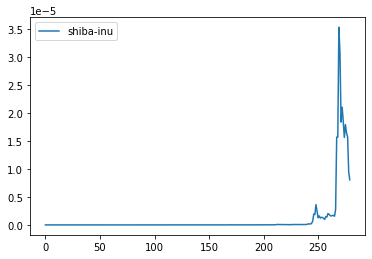

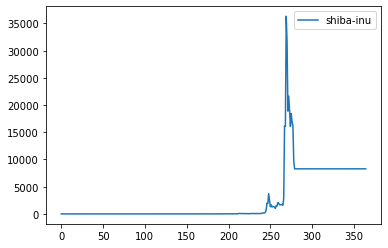

In [208]:
coin = "shiba-inu"

my_pd[[coin]].plot()
my_pd[[coin]]
my_pd[[coin]].pct_change().fillna(0).add(1).cumprod().sub(1).plot()  ##cumulative based on % change


In [140]:
print(my_pd[["shiba-inu"]].pct_change())

     shiba-inu
0          NaN
1     0.000000
2    -0.468290
3    -0.715379
4     0.111609
..         ...
115  -0.123936
116   0.044601
117   0.039953
118   0.013322
119  -0.010010

[120 rows x 1 columns]


<AxesSubplot:>

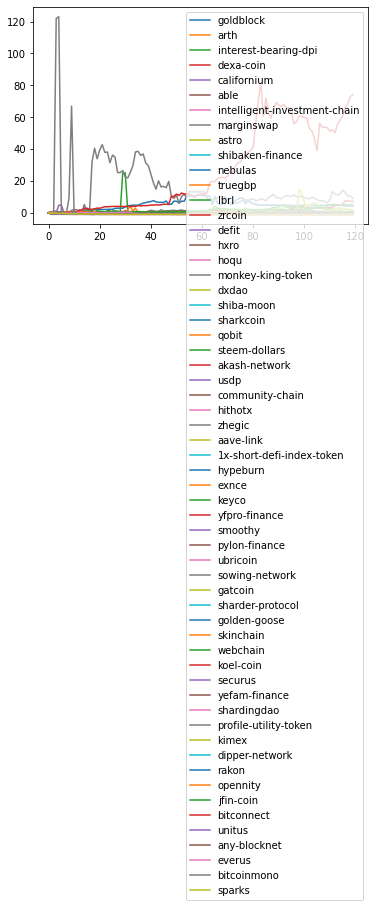

In [153]:
my_pd.iloc[:, 1: 60].pct_change().fillna(0).add(1).cumprod().sub(1).plot()  ##cumulative based on % change

In [151]:
my_pd.iloc[:, 1: 5]

goldblock      arth  interest-bearing-dpi  dexa-coin
0     0.002913  2.588137            462.521396   0.000009
1     0.001905  2.588137            462.521396   0.000013
2     0.002204  2.075511            469.607797   0.000004
3     0.001005  1.581607            420.200529   0.000009
4     0.001594  1.450591            445.081924   0.000010
..         ...       ...                   ...        ...
115   0.015809  0.240465                   NaN   0.000001
116   0.015102  0.309632                   NaN   0.000001
117   0.014994  0.305105                   NaN   0.000002
118   0.015352  0.291184                   NaN   0.000001
119   0.014437  0.290184                   NaN   0.000002

[120 rows x 4 columns]

In [198]:
def what_if_i_invested(investment,on_day=0,limit_coins=5):
#     my_pd.iloc[:1, : 5]
    
    def buy_at(investment,sale_price):
        return investment / sale_price
    
    def sell_at(amount_of_coins,sale_price):
        return amount_of_coins * sale_price
    
    buy_df = my_pd.iloc[:1, 1 : limit_coins].apply(lambda row : buy_at(investment,row) ).reset_index()
    
    
    last_row = my_pd.iloc[-1:,1:limit_coins].reset_index()
#     print(last_row)
#     print(buy_df)
    
    print(f"Purchase price = {investment * limit_coins}")
    print(f"Profit = ")
    display(buy_df.mul(last_row).transpose().sum())
    
#     display( buy_df.mul(last_row ).transpose() )
    
                        

In [158]:
my_pd.iloc[:1, 1 : 5].apply(lambda row : row*100000)

goldblock           arth  interest-bearing-dpi  dexa-coin
0  291.316197  258813.665237          4.625214e+07   0.921973

In [210]:
what_if_i_invested(100, limit_coins=100)  #max 7270

Purchase price = 10000
Profit = 


0    22292.589393
dtype: float64

In [204]:
build_table_Xdays_from_launch(365)

     day_number
0             0
1             1
2             2
3             3
4             4
5             5
6             6
7             7
8             8
9             9
10           10
11           11
12           12
13           13
14           14
15           15
16           16
17           17
18           18
19           19
20           20
21           21
22           22
23           23
24           24
25           25
26           26
27           27
28           28
29           29
30           30
31           31
32           32
33           33
34           34
35           35
36           36
37           37
38           38
39           39
40           40
41           41
42           42
43           43
44           44
45           45
46           46
47           47
48           48
49           49
50           50
51           51
52           52
53           53
54           54
55           55
56           56
57           57
58           58
59           59
60           60
61      

starting on passport-finance
different sized days: 173
added passport-finance to dataframe
starting on mykonos-coin
different sized days: 344
added mykonos-coin to dataframe
starting on bittwatt
added bittwatt to dataframe
starting on share-2
different sized days: 305
added share-2 to dataframe
starting on nuclum
different sized days: 314
added nuclum to dataframe
starting on standard-protocol
different sized days: 341
added standard-protocol to dataframe
starting on qmcoin
added qmcoin to dataframe
starting on gazetv
different sized days: 322
added gazetv to dataframe
starting on smart-application-chain
added smart-application-chain to dataframe
starting on idextools
different sized days: 19
added idextools to dataframe
starting on zyro
different sized days: 113
added zyro to dataframe
starting on true-usd
added true-usd to dataframe
starting on netkoin
added netkoin to dataframe
starting on chainsquare
different sized days: 332
added chainsquare to dataframe
starting on etherzero
add

starting on synlev
different sized days: 149
added synlev to dataframe
starting on habitat
different sized days: 301
added habitat to dataframe
starting on gokumarket-credit
different sized days: 168
added gokumarket-credit to dataframe
starting on schain-wallet
different sized days: 85
added schain-wallet to dataframe
starting on thorecash
added thorecash to dataframe
starting on zioncoin
added zioncoin to dataframe
starting on cryptonewsnet
different sized days: 171
added cryptonewsnet to dataframe
starting on jboxcoin
added jboxcoin to dataframe
starting on 3x-long-bitmax-token-token
added 3x-long-bitmax-token-token to dataframe
starting on 8x8-protocol
added 8x8-protocol to dataframe
starting on read-this-contract
different sized days: 212
added read-this-contract to dataframe
starting on vidyx
different sized days: 228
added vidyx to dataframe
starting on silver-coin
different sized days: 103
added silver-coin to dataframe
starting on tedesis
different sized days: 299
added tedesi

starting on superskynet
added superskynet to dataframe
starting on wrapped-zcash
different sized days: 211
added wrapped-zcash to dataframe
starting on realtoken-9336-patton-st-detroit-mi
different sized days: 256
added realtoken-9336-patton-st-detroit-mi to dataframe
starting on unigraph
different sized days: 192
added unigraph to dataframe
starting on wrapped-statera
different sized days: 229
added wrapped-statera to dataframe
starting on unicly-doki-doki-collection
different sized days: 332
added unicly-doki-doki-collection to dataframe
starting on cardano
added cardano to dataframe
starting on curve-dao-token
different sized days: 84
added curve-dao-token to dataframe
starting on yolo-cash
added yolo-cash to dataframe
starting on eth-moonshot-x-yield-set
different sized days: 175
added eth-moonshot-x-yield-set to dataframe
starting on polaris
different sized days: 314
added polaris to dataframe
starting on wazirx
added wazirx to dataframe
starting on apeusd-snx-synthetic-usd-dec-20

starting on iridium
added iridium to dataframe
starting on bitfresh
different sized days: 339
added bitfresh to dataframe
starting on bridge-finance
different sized days: 222
added bridge-finance to dataframe
starting on lockchain
added lockchain to dataframe
starting on geodb
added geodb to dataframe
starting on maxonrow
added maxonrow to dataframe
starting on largo-coin
added largo-coin to dataframe
starting on aave-tusd-v1
different sized days: 34
added aave-tusd-v1 to dataframe
starting on complus-network
different sized days: 364
added complus-network to dataframe
starting on xazab
different sized days: 327
added xazab to dataframe
starting on ixtz
different sized days: 31
added ixtz to dataframe
starting on zucoinchain
added zucoinchain to dataframe
starting on yfilend-finance
different sized days: 125
added yfilend-finance to dataframe
starting on og-fan-token
different sized days: 31
added og-fan-token to dataframe
starting on hope-token
different sized days: 342
added hope-tok

starting on communication-development-resources-token
added communication-development-resources-token to dataframe
starting on hedget
different sized days: 113
added hedget to dataframe
starting on connect-mining-coin
different sized days: 281
added connect-mining-coin to dataframe
starting on star-shib
different sized days: 353
added star-shib to dataframe
starting on strite
different sized days: 340
added strite to dataframe
starting on risecointoken
added risecointoken to dataframe
starting on peri-finance
different sized days: 353
added peri-finance to dataframe
starting on crossfi
different sized days: 346
added crossfi to dataframe
starting on cybertime-finance
different sized days: 311
added cybertime-finance to dataframe
starting on pube-finance
different sized days: 355
added pube-finance to dataframe
starting on tokenbox
added tokenbox to dataframe
starting on blockchain-certified-data-token
added blockchain-certified-data-token to dataframe
starting on toshify-finance
differ

starting on libonomy
different sized days: 278
added libonomy to dataframe
starting on ludos
added ludos to dataframe
starting on polkadomain
different sized days: 329
added polkadomain to dataframe
starting on revelation-coin
added revelation-coin to dataframe
starting on polkabridge
different sized days: 246
added polkabridge to dataframe
starting on netcoin
added netcoin to dataframe
starting on boscoin-2
added boscoin-2 to dataframe
starting on catnip-money
different sized days: 356
added catnip-money to dataframe
starting on duckdaodime
different sized days: 86
added duckdaodime to dataframe
starting on defi-omega
different sized days: 94
added defi-omega to dataframe
starting on blockclout
different sized days: 128
added blockclout to dataframe
starting on efficient-transaction-token
added efficient-transaction-token to dataframe
starting on mu-dank
different sized days: 299
added mu-dank to dataframe
starting on deepcloud-ai
added deepcloud-ai to dataframe
starting on medikey
ad

starting on buddy
added buddy to dataframe
starting on 3x-long-sushi-token
different sized days: 117
added 3x-long-sushi-token to dataframe
starting on divert-finance
different sized days: 171
added divert-finance to dataframe
starting on zusd
different sized days: 286
added zusd to dataframe
starting on ducato-protocol-token
different sized days: 122
added ducato-protocol-token to dataframe
starting on betnomi-2
different sized days: 275
added betnomi-2 to dataframe
starting on growing-fi
different sized days: 349
added growing-fi to dataframe
starting on 7up
different sized days: 158
added 7up to dataframe
starting on oxbull-tech
different sized days: 280
added oxbull-tech to dataframe
starting on hotnow
added hotnow to dataframe
starting on themis
added themis to dataframe
starting on 1x-short-eos-token
added 1x-short-eos-token to dataframe
starting on taekwondo-access-credit
different sized days: 354
added taekwondo-access-credit to dataframe
starting on coinsbit-token
added coinsb

starting on anon
added anon to dataframe
starting on penguin
added penguin to dataframe
starting on game-stars
added game-stars to dataframe
starting on etheal
added etheal to dataframe
starting on omcoin
different sized days: 338
added omcoin to dataframe
starting on novo
different sized days: 139
added novo to dataframe
starting on locgame
different sized days: 346
added locgame to dataframe
starting on pumapay
added pumapay to dataframe
starting on thingsoperatingsystem
added thingsoperatingsystem to dataframe
starting on meliora
different sized days: 311
added meliora to dataframe
starting on versacoin
different sized days: 299
added versacoin to dataframe
starting on suni
different sized days: 331
added suni to dataframe
starting on refork
different sized days: 97
added refork to dataframe
starting on temco
added temco to dataframe
starting on npo-coin
different sized days: 204
added npo-coin to dataframe
starting on viagra-token
different sized days: 359
added viagra-token to dat

starting on young-boys-fan-token
different sized days: 249
added young-boys-fan-token to dataframe
starting on litecoin-finance
added litecoin-finance to dataframe
starting on dudgx
added dudgx to dataframe
starting on rozeus
added rozeus to dataframe
starting on 3x-short-balancer-token
different sized days: 76
added 3x-short-balancer-token to dataframe
starting on mirrored-google
different sized days: 236
added mirrored-google to dataframe
starting on axioms
different sized days: 133
added axioms to dataframe
starting on casper-network
different sized days: 355
added casper-network to dataframe
starting on bitriver
different sized days: 340
added bitriver to dataframe
starting on undo-token
different sized days: 358
added undo-token to dataframe
starting on mobilego
added mobilego to dataframe
starting on tadpole-finance
different sized days: 178
added tadpole-finance to dataframe
starting on videocoin
added videocoin to dataframe
starting on somesing
added somesing to dataframe
start

added caica-coin to dataframe
starting on kansas-city-chiefs-win-super-bowl
different sized days: 358
added kansas-city-chiefs-win-super-bowl to dataframe
starting on zenfuse
different sized days: 144
added zenfuse to dataframe
starting on xbn
different sized days: 321
added xbn to dataframe
starting on hokkaidu-inu
different sized days: 337
added hokkaidu-inu to dataframe
starting on delphi-chain-link
different sized days: 229
added delphi-chain-link to dataframe
starting on cafeswap-token
different sized days: 269
added cafeswap-token to dataframe
starting on luxurious-pro-network-token
different sized days: 284
added luxurious-pro-network-token to dataframe
starting on safedog-protocol
different sized days: 354
added safedog-protocol to dataframe
starting on bluechips-token
added bluechips-token to dataframe
starting on kiwi-token
added kiwi-token to dataframe
starting on setc
different sized days: 305
added setc to dataframe
starting on safepal
different sized days: 262
added safep

starting on curio
added curio to dataframe
starting on visor
different sized days: 296
added visor to dataframe
starting on nyan-v2
different sized days: 173
added nyan-v2 to dataframe
starting on blackpearl-chain
added blackpearl-chain to dataframe
starting on daex
added daex to dataframe
starting on tena
added tena to dataframe
starting on htmlcoin
added htmlcoin to dataframe
starting on currency-network
added currency-network to dataframe
starting on waffle
different sized days: 329
added waffle to dataframe
starting on 3x-long-okb-token
added 3x-long-okb-token to dataframe
starting on international-cryptox
added international-cryptox to dataframe
starting on havven
added havven to dataframe
starting on zuplo
different sized days: 179
added zuplo to dataframe
starting on marsmission
different sized days: 333
added marsmission to dataframe
starting on qash
added qash to dataframe
starting on seedswap-token
different sized days: 361
added seedswap-token to dataframe
starting on decent

starting on exmr-monero
added exmr-monero to dataframe
starting on zzz-finance-v2
different sized days: 237
added zzz-finance-v2 to dataframe
starting on atbcoin
added atbcoin to dataframe
starting on perkscoin
added perkscoin to dataframe
starting on cezo
different sized days: 269
added cezo to dataframe
starting on crowns
different sized days: 255
added crowns to dataframe
starting on saveplanetearth
different sized days: 340
added saveplanetearth to dataframe
starting on jindo-inu
different sized days: 358
added jindo-inu to dataframe
starting on generation-of-yield
different sized days: 197
added generation-of-yield to dataframe
starting on 3x-short-ethereum-classic-token
added 3x-short-ethereum-classic-token to dataframe
starting on bigbom-eco
added bigbom-eco to dataframe
starting on livenpay
added livenpay to dataframe
starting on polaris-share
different sized days: 255
added polaris-share to dataframe
starting on zum-token
added zum-token to dataframe
starting on tron-atm
diffe

starting on rivetz
added rivetz to dataframe
starting on synth-soil
different sized days: 309
added synth-soil to dataframe
starting on 3x-short-stellar-token
different sized days: 202
added 3x-short-stellar-token to dataframe
starting on t-os
added t-os to dataframe
starting on palletone
added palletone to dataframe
starting on rise-protocol
different sized days: 277
added rise-protocol to dataframe
starting on prophecy
different sized days: 237
added prophecy to dataframe
starting on yd-btc-mar21
different sized days: 272
added yd-btc-mar21 to dataframe
starting on sphere
added sphere to dataframe
starting on sentinel-protocol
added sentinel-protocol to dataframe
starting on partner
added partner to dataframe
starting on financex-exchange-token
added financex-exchange-token to dataframe
starting on parachute
added parachute to dataframe
starting on rupiah-token
added rupiah-token to dataframe
starting on lipchain
added lipchain to dataframe
starting on afin-coin
added afin-coin to da

starting on oro
different sized days: 176
added oro to dataframe
starting on zmine
added zmine to dataframe
starting on datamine
different sized days: 32
added datamine to dataframe
starting on xpet-coin
added xpet-coin to dataframe
starting on tagcoin
added tagcoin to dataframe
starting on rakun
added rakun to dataframe
starting on genexi
added genexi to dataframe
starting on fortknoxter
added fortknoxter to dataframe
starting on app-alliance-association
added app-alliance-association to dataframe
starting on blockmason-credit-protocol
added blockmason-credit-protocol to dataframe
starting on moonstar
different sized days: 344
added moonstar to dataframe
starting on chainium
added chainium to dataframe
starting on aave-enj-v1
different sized days: 118
added aave-enj-v1 to dataframe
starting on minerva-wallet
different sized days: 322
added minerva-wallet to dataframe
starting on tronipay
added tronipay to dataframe
starting on sono
added sono to dataframe
starting on mti-finance
diffe

starting on huobi-btc
different sized days: 159
added huobi-btc to dataframe
starting on unicly-waifu-collection
different sized days: 348
added unicly-waifu-collection to dataframe
starting on koinos
different sized days: 177
added koinos to dataframe
starting on eth-btc-75-25-weight-set
different sized days: 124
added eth-btc-75-25-weight-set to dataframe
starting on btf
added btf to dataframe
starting on wallet-plus-x
added wallet-plus-x to dataframe
starting on wax
added wax to dataframe
starting on ontology
added ontology to dataframe
starting on gsenetwork
added gsenetwork to dataframe
starting on mex
added mex to dataframe
starting on emrals
added emrals to dataframe
starting on yoink
different sized days: 147
added yoink to dataframe
starting on konjungate
added konjungate to dataframe
starting on baby-shiba
different sized days: 355
added baby-shiba to dataframe
starting on universal-dollar
different sized days: 273
added universal-dollar to dataframe
starting on keytango
diff

starting on xeonbit-token
added xeonbit-token to dataframe
starting on five-balance
added five-balance to dataframe
starting on liquid-lottery-rtc
different sized days: 293
added liquid-lottery-rtc to dataframe
starting on satoshivision-coin
different sized days: 191
added satoshivision-coin to dataframe
starting on paycon-token
different sized days: 95
added paycon-token to dataframe
starting on aga-rewards-2
different sized days: 287
added aga-rewards-2 to dataframe
starting on chartex
different sized days: 119
added chartex to dataframe
starting on quai-dao
different sized days: 254
added quai-dao to dataframe
starting on robo-token
different sized days: 313
added robo-token to dataframe
starting on dequant
added dequant to dataframe
starting on stabinol
different sized days: 297
added stabinol to dataframe
starting on tama-egg-niftygotchi
different sized days: 193
added tama-egg-niftygotchi to dataframe
starting on timers
different sized days: 146
added timers to dataframe
starting

added r34p to dataframe
starting on okb
added okb to dataframe
starting on nss-coin
added nss-coin to dataframe
starting on blinky-bob
different sized days: 361
added blinky-bob to dataframe
starting on eth-rsi-60-40-yield-set
added eth-rsi-60-40-yield-set to dataframe
starting on converter-finance
different sized days: 312
added converter-finance to dataframe
starting on pippi-finance
different sized days: 344
added pippi-finance to dataframe
starting on chiliz
added chiliz to dataframe
starting on brickchain-finance
different sized days: 326
added brickchain-finance to dataframe
starting on bitcoinx
added bitcoinx to dataframe
starting on sphere-social
added sphere-social to dataframe
starting on aurusgold
different sized days: 30
added aurusgold to dataframe
starting on mineum
added mineum to dataframe
starting on wooshcoin-io
added wooshcoin-io to dataframe
starting on copiosa
different sized days: 335
added copiosa to dataframe
starting on kuma-inu
different sized days: 359
added 

starting on zero-utility-token
different sized days: 135
added zero-utility-token to dataframe
starting on parkingo
added parkingo to dataframe
starting on banklife
added banklife to dataframe
starting on harta-tech
different sized days: 344
added harta-tech to dataframe
starting on wiix-coin
added wiix-coin to dataframe
starting on litentry
different sized days: 258
added litentry to dataframe
starting on datbit
added datbit to dataframe
starting on sperax
different sized days: 95
added sperax to dataframe
starting on cryptotipsfr
different sized days: 95
added cryptotipsfr to dataframe
starting on piedao-dough-v2
different sized days: 134
added piedao-dough-v2 to dataframe
starting on all-me
added all-me to dataframe
starting on aloha
different sized days: 277
added aloha to dataframe
starting on cheese
added cheese to dataframe
starting on master-usd
different sized days: 16
added master-usd to dataframe
starting on tripio
added tripio to dataframe
starting on bearn-fi
different siz

added elysia to dataframe
starting on eazy
added eazy to dataframe
starting on wrapped-bitcoin-diamond
different sized days: 364
added wrapped-bitcoin-diamond to dataframe
starting on opalcoin
different sized days: 150
added opalcoin to dataframe
starting on punk-female
different sized days: 280
added punk-female to dataframe
starting on degov
different sized days: 193
added degov to dataframe
starting on bitsum
added bitsum to dataframe
starting on kattana
different sized days: 322
added kattana to dataframe
starting on unicrypt
different sized days: 44
added unicrypt to dataframe
starting on myubi
added myubi to dataframe
starting on nantrade
added nantrade to dataframe
starting on pixl-coin
different sized days: 346
added pixl-coin to dataframe
starting on fudfinance
different sized days: 139
added fudfinance to dataframe
starting on klondike-btc
different sized days: 251
added klondike-btc to dataframe
starting on web-token-pay
added web-token-pay to dataframe
starting on candy-box

starting on empower-network
different sized days: 84
added empower-network to dataframe
starting on tradestars
different sized days: 346
added tradestars to dataframe
starting on siaclassic
added siaclassic to dataframe
starting on snglsdao-governance-token
different sized days: 63
added snglsdao-governance-token to dataframe
starting on spectrum
added spectrum to dataframe
starting on iticoin
added iticoin to dataframe
starting on elevation-token
different sized days: 98
added elevation-token to dataframe
starting on bancor-governance-token
different sized days: 277
added bancor-governance-token to dataframe
starting on basis-gold
different sized days: 324
added basis-gold to dataframe
starting on crypto-price-index
different sized days: 90
added crypto-price-index to dataframe
starting on weedcash
added weedcash to dataframe
starting on health-token
different sized days: 358
added health-token to dataframe
starting on yaxis
different sized days: 128
added yaxis to dataframe
starting 

starting on evedo
added evedo to dataframe
starting on new-year-bull
different sized days: 156
added new-year-bull to dataframe
starting on htm
different sized days: 319
added htm to dataframe
starting on tap
added tap to dataframe
starting on commons-earth
different sized days: 279
added commons-earth to dataframe
starting on birthday-cake
different sized days: 300
added birthday-cake to dataframe
starting on snovio
added snovio to dataframe
starting on blockidcoin
added blockidcoin to dataframe
starting on atn
added atn to dataframe
starting on lotdog
different sized days: 362
added lotdog to dataframe
starting on tokyo
added tokyo to dataframe
starting on mci-coin
different sized days: 120
added mci-coin to dataframe
starting on bitcoin-ultra
added bitcoin-ultra to dataframe
starting on dapp-com
added dapp-com to dataframe
starting on content-value-network
added content-value-network to dataframe
starting on shitcoin
added shitcoin to dataframe
starting on coinlion
added coinlion to

starting on cxn-network
different sized days: 139
added cxn-network to dataframe
starting on nocapcoin
different sized days: 358
added nocapcoin to dataframe
starting on hurricane
different sized days: 360
added hurricane to dataframe
starting on taurus-chain
different sized days: 364
added taurus-chain to dataframe
starting on infinity-esaham
added infinity-esaham to dataframe
starting on dev-protocol
different sized days: 11
added dev-protocol to dataframe
starting on qoober
different sized days: 110
added qoober to dataframe
starting on mao-zedong
added mao-zedong to dataframe
starting on wrapped-cryptokitties
added wrapped-cryptokitties to dataframe
starting on armx-unidos
different sized days: 220
added armx-unidos to dataframe
starting on one-ledger
added one-ledger to dataframe
starting on data
added data to dataframe
starting on nibbleclassic
added nibbleclassic to dataframe
starting on web-innovation-ph
added web-innovation-ph to dataframe
starting on chai
added chai to datafr

starting on bilaxy-token
added bilaxy-token to dataframe
starting on soge
different sized days: 319
added soge to dataframe
starting on block-array
added block-array to dataframe
starting on alchemix-usd
different sized days: 311
added alchemix-usd to dataframe
starting on 3x-long-defi-index-token
different sized days: 76
added 3x-long-defi-index-token to dataframe
starting on kaleido
added kaleido to dataframe
starting on cipher-core-token
different sized days: 87
added cipher-core-token to dataframe
starting on up-token
added up-token to dataframe
starting on cross-finance
different sized days: 156
added cross-finance to dataframe
starting on aeternity
added aeternity to dataframe
starting on oxbitcoin
added oxbitcoin to dataframe
starting on peach
different sized days: 358
added peach to dataframe
starting on glitch-protocol
different sized days: 242
added glitch-protocol to dataframe
starting on finexbox-token
added finexbox-token to dataframe
starting on elephant-money
different s

starting on tigercash
added tigercash to dataframe
starting on magic-e-stock
different sized days: 364
added magic-e-stock to dataframe
starting on elynet-token
different sized days: 212
added elynet-token to dataframe
starting on vcash-token
added vcash-token to dataframe
starting on memex
different sized days: 355
added memex to dataframe
starting on tsuki-inu
different sized days: 363
added tsuki-inu to dataframe
starting on spacechain-erc-20
added spacechain-erc-20 to dataframe
starting on ferma
different sized days: 306
added ferma to dataframe
starting on dreamteam3
added dreamteam3 to dataframe
starting on ally
added ally to dataframe
starting on lance-coin
different sized days: 332
added lance-coin to dataframe
starting on circleswap
different sized days: 230
added circleswap to dataframe
starting on piedao-balanced-crypto-pie
different sized days: 228
added piedao-balanced-crypto-pie to dataframe
starting on eosbet
added eosbet to dataframe
starting on dexe
different sized day

starting on portal
added portal to dataframe
starting on arweave
added arweave to dataframe
starting on arc-governance
different sized days: 364
added arc-governance to dataframe
starting on yffs
different sized days: 102
added yffs to dataframe
starting on ultiledger
added ultiledger to dataframe
starting on kyc-crypto
different sized days: 208
added kyc-crypto to dataframe
starting on pos-coin
added pos-coin to dataframe
starting on gogo-finance
different sized days: 258
added gogo-finance to dataframe
starting on pegasus
added pegasus to dataframe
starting on gamestop-finance
different sized days: 255
added gamestop-finance to dataframe
starting on bitcoin-unicorn
added bitcoin-unicorn to dataframe
starting on oxo-farm
different sized days: 342
added oxo-farm to dataframe
starting on pxusd-synthetic-usd-expiring-31-mar-2022
different sized days: 340
added pxusd-synthetic-usd-expiring-31-mar-2022 to dataframe
starting on mm-token
different sized days: 199
added mm-token to dataframe


starting on dfinance
different sized days: 272
added dfinance to dataframe
starting on ethereum-stake
different sized days: 213
added ethereum-stake to dataframe
starting on alchemist
different sized days: 318
added alchemist to dataframe
starting on stellarpayglobal
different sized days: 35
added stellarpayglobal to dataframe
starting on zoom-protocol
different sized days: 143
added zoom-protocol to dataframe
starting on blitzpredict
added blitzpredict to dataframe
starting on bafi-finance-token
different sized days: 226
added bafi-finance-token to dataframe
starting on bit-z-token
added bit-z-token to dataframe
starting on royal-protocol
different sized days: 351
added royal-protocol to dataframe
starting on matic-aave-uni
different sized days: 329
added matic-aave-uni to dataframe
starting on phoswap
different sized days: 255
added phoswap to dataframe
starting on the-lab-finance
different sized days: 342
added the-lab-finance to dataframe
starting on safetesla
different sized days:

starting on venus-usdc
different sized days: 263
added venus-usdc to dataframe
starting on polkafoundry
different sized days: 299
added polkafoundry to dataframe
starting on myfichain
added myfichain to dataframe
starting on aave-ren
different sized days: 294
added aave-ren to dataframe
starting on definer
different sized days: 143
added definer to dataframe
starting on effect-network
added effect-network to dataframe
starting on dscvr-finance
different sized days: 343
added dscvr-finance to dataframe
starting on mnpostree
different sized days: 291
added mnpostree to dataframe
starting on counterparty
added counterparty to dataframe
starting on cryptassist
different sized days: 257
added cryptassist to dataframe
starting on digex
different sized days: 155
added digex to dataframe
starting on altmarkets-coin
added altmarkets-coin to dataframe
starting on polyvolve-finance
different sized days: 348
added polyvolve-finance to dataframe
starting on thinkium
different sized days: 364
added 

starting on snapparazzi
added snapparazzi to dataframe
starting on bitcoin-interest
added bitcoin-interest to dataframe
starting on route
different sized days: 241
added route to dataframe
starting on renbch
different sized days: 119
added renbch to dataframe
starting on enceladus-network
different sized days: 203
added enceladus-network to dataframe
starting on coti
added coti to dataframe
starting on safelcarus
different sized days: 350
added safelcarus to dataframe
starting on collective
different sized days: 310
added collective to dataframe
starting on spheroid-universe
different sized days: 73
added spheroid-universe to dataframe
starting on panda-finance
different sized days: 360
added panda-finance to dataframe
starting on power-index-pool-token
different sized days: 194
added power-index-pool-token to dataframe
starting on defi-firefly
different sized days: 185
added defi-firefly to dataframe
starting on koda-finance
different sized days: 360
added koda-finance to dataframe
st

starting on cashbet-coin
added cashbet-coin to dataframe
starting on guncoin
added guncoin to dataframe
starting on fatcoin
added fatcoin to dataframe
starting on lyfe
added lyfe to dataframe
starting on hackspace-capital
added hackspace-capital to dataframe
starting on dfuture
different sized days: 290
added dfuture to dataframe
starting on piedao-defi-large-cap
different sized days: 139
added piedao-defi-large-cap to dataframe
starting on qanplatform
different sized days: 121
added qanplatform to dataframe
starting on erotica-2
different sized days: 358
added erotica-2 to dataframe
starting on eos-eth
added eos-eth to dataframe
starting on 0-5x-long-cosmos-token
different sized days: 282
added 0-5x-long-cosmos-token to dataframe
starting on safemars
different sized days: 301
added safemars to dataframe
starting on jobchain
added jobchain to dataframe
starting on funder-one
different sized days: 303
added funder-one to dataframe
starting on trust-ether-reorigin
added trust-ether-reori

starting on cryptocurrency
added cryptocurrency to dataframe
starting on game-fanz
added game-fanz to dataframe
starting on plair
added plair to dataframe
starting on iqoniq
different sized days: 319
added iqoniq to dataframe
starting on armtoken
different sized days: 124
added armtoken to dataframe
starting on mxc
added mxc to dataframe
starting on ong
added ong to dataframe
starting on yd-eth-jun21
different sized days: 315
added yd-eth-jun21 to dataframe
starting on loom-network-new
different sized days: 322
added loom-network-new to dataframe
starting on pokeball
different sized days: 237
added pokeball to dataframe
starting on okschain
added okschain to dataframe
starting on defi-top-5-tokens-index
different sized days: 241
added defi-top-5-tokens-index to dataframe
starting on froge-finance
different sized days: 327
added froge-finance to dataframe
starting on moon-owl
different sized days: 361
added moon-owl to dataframe
starting on fairyland
added fairyland to dataframe
startin

added transfast to dataframe
starting on cryptoworld-vip
added cryptoworld-vip to dataframe
starting on blox
added blox to dataframe
starting on chimaera
added chimaera to dataframe
starting on energoncoin
added energoncoin to dataframe
starting on fio-protocol
different sized days: 52
added fio-protocol to dataframe
starting on intellishare
added intellishare to dataframe
starting on va-na-su
different sized days: 116
added va-na-su to dataframe
starting on algovest
different sized days: 258
added algovest to dataframe
starting on apollon-limassol
different sized days: 169
added apollon-limassol to dataframe
starting on kebab-token
different sized days: 243
added kebab-token to dataframe
starting on kylin-network
different sized days: 285
added kylin-network to dataframe
starting on shiba-swim
different sized days: 359
added shiba-swim to dataframe
starting on swap
added swap to dataframe
starting on bitscoin
different sized days: 175
added bitscoin to dataframe
starting on auto
diffe

starting on 2gether-2
different sized days: 307
added 2gether-2 to dataframe
starting on triipmiles
different sized days: 150
added triipmiles to dataframe
starting on yfet
different sized days: 133
added yfet to dataframe
starting on nuggets
added nuggets to dataframe
starting on cryptocurrency-top-10-tokens-index
different sized days: 241
added cryptocurrency-top-10-tokens-index to dataframe
starting on peet-defi
different sized days: 228
added peet-defi to dataframe
starting on utu-coin
different sized days: 146
added utu-coin to dataframe
starting on globex
added globex to dataframe
starting on mercurial
different sized days: 364
added mercurial to dataframe
starting on tepleton
added tepleton to dataframe
starting on voyager
added voyager to dataframe
starting on platincoin
added platincoin to dataframe
starting on usd-bancor
added usd-bancor to dataframe
starting on cherry-token
added cherry-token to dataframe
starting on 3x-short-sushi-token
different sized days: 117
added 3x-sh

added lightening-cash to dataframe
starting on shiba-cosmos
different sized days: 357
added shiba-cosmos to dataframe
starting on super-trip-chain
added super-trip-chain to dataframe
starting on thunderbolt
different sized days: 342
added thunderbolt to dataframe
starting on storiqa
added storiqa to dataframe
starting on bingo-cash
different sized days: 364
added bingo-cash to dataframe
starting on cryptogalaxy
added cryptogalaxy to dataframe
starting on mobifi
different sized days: 320
added mobifi to dataframe
starting on valuecybertoken
added valuecybertoken to dataframe
starting on beetr
different sized days: 213
added beetr to dataframe
starting on everipedia
added everipedia to dataframe
starting on fear-greed-sentiment-set-ii
different sized days: 60
added fear-greed-sentiment-set-ii to dataframe
starting on wadzpay-token
different sized days: 197
added wadzpay-token to dataframe
starting on 3x-long-litecoin-token
added 3x-long-litecoin-token to dataframe
starting on gas-cash-ba

starting on glosfer-token
added glosfer-token to dataframe
starting on yearn-finance-passive-income
different sized days: 133
added yearn-finance-passive-income to dataframe
starting on storm
added storm to dataframe
starting on publish
added publish to dataframe
starting on spectrecoin
added spectrecoin to dataframe
starting on unicly-aavegotchi-astronauts-collection
different sized days: 333
added unicly-aavegotchi-astronauts-collection to dataframe
starting on ethereum-push-notification-service
different sized days: 326
added ethereum-push-notification-service to dataframe
starting on compound-0x
added compound-0x to dataframe
starting on cnyq-stablecoin-by-q-dao-v1
different sized days: 303
added cnyq-stablecoin-by-q-dao-v1 to dataframe
starting on mobox
different sized days: 326
added mobox to dataframe
starting on matic-aave-usdc
different sized days: 278
added matic-aave-usdc to dataframe
starting on bitpower
different sized days: 220
added bitpower to dataframe
starting on cato

starting on puriever
different sized days: 126
added puriever to dataframe
starting on crypto-candy
different sized days: 245
added crypto-candy to dataframe
starting on consensus-cell-network
different sized days: 129
added consensus-cell-network to dataframe
starting on swaap-stablecoin
different sized days: 271
added swaap-stablecoin to dataframe
starting on coinloan
added coinloan to dataframe
starting on italo
added italo to dataframe
starting on freeway-token
different sized days: 165
added freeway-token to dataframe
starting on dash-cash
added dash-cash to dataframe
starting on ans-crypto-coin
different sized days: 329
added ans-crypto-coin to dataframe
starting on bread
added bread to dataframe
starting on vfox
different sized days: 353
added vfox to dataframe
starting on farmer-defi
different sized days: 364
added farmer-defi to dataframe
starting on voltbit
different sized days: 361
added voltbit to dataframe
starting on drep-new
different sized days: 312
added drep-new to da

starting on super-zero
added super-zero to dataframe
starting on xtcom-token
added xtcom-token to dataframe
starting on you-chain
added you-chain to dataframe
starting on openalexa-protocol
different sized days: 109
added openalexa-protocol to dataframe
starting on tradeplus
added tradeplus to dataframe
starting on coinpoker
added coinpoker to dataframe
starting on chainswap
different sized days: 335
added chainswap to dataframe
starting on simian-finance
different sized days: 318
added simian-finance to dataframe
starting on aleph
different sized days: 29
added aleph to dataframe
starting on chi-gastoken
different sized days: 14
added chi-gastoken to dataframe
starting on xwc-dice-token
added xwc-dice-token to dataframe
starting on buckhath-coin
added buckhath-coin to dataframe
starting on riecoin
added riecoin to dataframe
starting on themis-2
different sized days: 218
added themis-2 to dataframe
starting on limeswap
different sized days: 348
added limeswap to dataframe
starting on h

added titanswap to dataframe
starting on venus-ltc
different sized days: 264
added venus-ltc to dataframe
starting on nia-token
different sized days: 362
added nia-token to dataframe
starting on micromines
added micromines to dataframe
starting on rubic
different sized days: 128
added rubic to dataframe
starting on cashbackpro
different sized days: 155
added cashbackpro to dataframe
starting on fiola
different sized days: 230
added fiola to dataframe
starting on warlord-token
different sized days: 262
added warlord-token to dataframe
starting on stellar-gold
added stellar-gold to dataframe
starting on yap-stone
added yap-stone to dataframe
starting on cr-coin
different sized days: 312
added cr-coin to dataframe
starting on empow
different sized days: 83
added empow to dataframe
starting on oceanex-token
added oceanex-token to dataframe
starting on foresight
different sized days: 110
added foresight to dataframe
starting on eth-50-day-ma-crossover-set
different sized days: 16
added eth-

added bitblocks-finance to dataframe
starting on medican-coin
different sized days: 235
added medican-coin to dataframe
starting on deus-synthetic-coinbase-iou
different sized days: 243
added deus-synthetic-coinbase-iou to dataframe
starting on yield-bear
different sized days: 304
added yield-bear to dataframe
starting on tokenlon
different sized days: 214
added tokenlon to dataframe
starting on sugarchain
added sugarchain to dataframe
starting on hirevibes
added hirevibes to dataframe
starting on siaprime-coin
added siaprime-coin to dataframe
starting on shadow-token
added shadow-token to dataframe
starting on bficoin
different sized days: 333
added bficoin to dataframe
starting on spacecowboy
different sized days: 285
added spacecowboy to dataframe
starting on blocklancer
added blocklancer to dataframe
starting on yflink
different sized days: 78
added yflink to dataframe
starting on eurxb
different sized days: 294
added eurxb to dataframe
starting on deflect
different sized days: 206

starting on goldkash
added goldkash to dataframe
starting on timelockcoin
different sized days: 66
added timelockcoin to dataframe
starting on littlesesame
added littlesesame to dataframe
starting on lnko-token
added lnko-token to dataframe
starting on ara-token
different sized days: 311
added ara-token to dataframe
starting on ubiquitous-social-network-service
added ubiquitous-social-network-service to dataframe
starting on origintrail
added origintrail to dataframe
starting on graft-blockchain
added graft-blockchain to dataframe
starting on busy-dao
different sized days: 336
added busy-dao to dataframe
starting on noah-coin
added noah-coin to dataframe
starting on media-network
different sized days: 343
added media-network to dataframe
starting on lync-network
different sized days: 182
added lync-network to dataframe
starting on nolecoin
added nolecoin to dataframe
starting on ampleforth-governance-token
different sized days: 334
added ampleforth-governance-token to dataframe
startin

starting on bonfire
different sized days: 340
added bonfire to dataframe
starting on cbdao
different sized days: 83
added cbdao to dataframe
starting on omc-group
different sized days: 179
added omc-group to dataframe
starting on tronfamily
different sized days: 86
added tronfamily to dataframe
starting on abcc-token
added abcc-token to dataframe
starting on eboost
added eboost to dataframe
starting on galactrum
added galactrum to dataframe
starting on atlantic-finance
different sized days: 349
added atlantic-finance to dataframe
starting on kusama
added kusama to dataframe
starting on magi
added magi to dataframe
starting on safecookie
different sized days: 353
added safecookie to dataframe
starting on 1million-nfts
different sized days: 338
added 1million-nfts to dataframe
starting on quant-network
added quant-network to dataframe
starting on vectorium
different sized days: 128
added vectorium to dataframe
starting on aen-smart-token
different sized days: 346
added aen-smart-token to

starting on telcoin
added telcoin to dataframe
starting on zantepay
added zantepay to dataframe
starting on sora-validator-token
different sized days: 198
added sora-validator-token to dataframe
starting on daxhund
different sized days: 332
added daxhund to dataframe
starting on vodi-x
added vodi-x to dataframe
starting on cryptoping
added cryptoping to dataframe
starting on trustpad
different sized days: 348
added trustpad to dataframe
starting on veraswap
different sized days: 292
added veraswap to dataframe
starting on ravencoin
added ravencoin to dataframe
starting on suku
different sized days: 74
added suku to dataframe
starting on albos
different sized days: 44
added albos to dataframe
starting on bitcoin-rhodium
added bitcoin-rhodium to dataframe
starting on argon
different sized days: 291
added argon to dataframe
starting on safegem
different sized days: 358
added safegem to dataframe
starting on eva-coin
added eva-coin to dataframe
starting on aave-susd
different sized days: 2

starting on hurify
added hurify to dataframe
starting on corra-finance
different sized days: 364
added corra-finance to dataframe
starting on turex
different sized days: 361
added turex to dataframe
starting on clearpoll
added clearpoll to dataframe
starting on swamp-coin
added swamp-coin to dataframe
starting on cpchain
added cpchain to dataframe
starting on jewel
added jewel to dataframe
starting on mooni
different sized days: 340
added mooni to dataframe
starting on hland-token
different sized days: 208
added hland-token to dataframe
starting on viking-swap
different sized days: 296
added viking-swap to dataframe
starting on alien-worlds
different sized days: 320
added alien-worlds to dataframe
starting on dionpay
different sized days: 77
added dionpay to dataframe
starting on erc20
added erc20 to dataframe
starting on proof-of-liquidity
different sized days: 34
added proof-of-liquidity to dataframe
starting on atlas
added atlas to dataframe
starting on global-reserve-system
added g

added vbswap to dataframe
starting on giant
added giant to dataframe
starting on fanstime
added fanstime to dataframe
starting on revolt
different sized days: 359
added revolt to dataframe
starting on livepeer
added livepeer to dataframe
starting on condominium
added condominium to dataframe
starting on eox
different sized days: 274
added eox to dataframe
starting on fuzzballs
added fuzzballs to dataframe
starting on truedeck
added truedeck to dataframe
starting on sjwcoin
added sjwcoin to dataframe
starting on cash2
added cash2 to dataframe
starting on knekted
added knekted to dataframe
starting on quotation-coin
added quotation-coin to dataframe
starting on slothcoin
added slothcoin to dataframe
starting on cate-shiba
different sized days: 364
added cate-shiba to dataframe
starting on titcoin
added titcoin to dataframe
starting on nftpunk-finance
different sized days: 359
added nftpunk-finance to dataframe
starting on smartkey
different sized days: 212
added smartkey to dataframe
sta

added pegascoin to dataframe
starting on yooshi
different sized days: 360
added yooshi to dataframe
starting on glox-finance
different sized days: 200
added glox-finance to dataframe
starting on kira-network
different sized days: 190
added kira-network to dataframe
starting on unique-one
different sized days: 215
added unique-one to dataframe
starting on neo-holistic-coin
different sized days: 313
added neo-holistic-coin to dataframe
starting on bitcoin-subsidium
added bitcoin-subsidium to dataframe
starting on zippie
added zippie to dataframe
starting on olympus
different sized days: 306
added olympus to dataframe
starting on yunex
added yunex to dataframe
starting on pop
different sized days: 313
added pop to dataframe
starting on sapien
added sapien to dataframe
starting on biopset
different sized days: 353
added biopset to dataframe
starting on time-new-bank
added time-new-bank to dataframe
starting on bilira
added bilira to dataframe
starting on nyzo
added nyzo to dataframe
starti

added buy-coin-pos to dataframe
starting on fuze-token
added fuze-token to dataframe
starting on cartesi
added cartesi to dataframe
starting on bitup-token
added bitup-token to dataframe
starting on waterdrop
different sized days: 183
added waterdrop to dataframe
starting on bcat
added bcat to dataframe
starting on etheroll
added etheroll to dataframe
starting on sora
added sora to dataframe
starting on luxcoin
added luxcoin to dataframe
starting on blockchain-cuties-universe-governance
different sized days: 299
added blockchain-cuties-universe-governance to dataframe
starting on heidi
different sized days: 33
added heidi to dataframe
starting on 0-5x-long-shitcoin-index-token
different sized days: 276
added 0-5x-long-shitcoin-index-token to dataframe
starting on bitgem
added bitgem to dataframe
starting on v-id-blockchain
added v-id-blockchain to dataframe
starting on aggregator-network
different sized days: 358
added aggregator-network to dataframe
starting on blockv
added blockv to 

added aave-usdt-v1 to dataframe
starting on codex
added codex to dataframe
starting on bgt
added bgt to dataframe
starting on oviex
different sized days: 348
added oviex to dataframe
starting on moontrust
different sized days: 354
added moontrust to dataframe
starting on thrivechain
added thrivechain to dataframe
starting on torchain
added torchain to dataframe
starting on moon-day-plus
different sized days: 307
added moon-day-plus to dataframe
starting on iexec-rlc
added iexec-rlc to dataframe
starting on ecoreal-estate
added ecoreal-estate to dataframe
starting on mossland
added mossland to dataframe
starting on helio
different sized days: 349
added helio to dataframe
starting on hope
different sized days: 146
added hope to dataframe
starting on meteorite-network
different sized days: 333
added meteorite-network to dataframe
starting on pinknode
different sized days: 357
added pinknode to dataframe
starting on crypto-holding-frank-token
added crypto-holding-frank-token to dataframe
s

added morpher to dataframe
starting on mirrored-goldman-sachs
different sized days: 286
added mirrored-goldman-sachs to dataframe
starting on icolcoin
different sized days: 54
added icolcoin to dataframe
starting on goes-up-higher
different sized days: 364
added goes-up-higher to dataframe
starting on maxgoat
different sized days: 358
added maxgoat to dataframe
starting on apple-network
added apple-network to dataframe
starting on photon
added photon to dataframe
starting on cryptobuyer-token
added cryptobuyer-token to dataframe
starting on aragon
added aragon to dataframe
starting on street-credit
different sized days: 364
added street-credit to dataframe
starting on nft-protocol
different sized days: 89
added nft-protocol to dataframe
starting on excavo-finance
different sized days: 242
added excavo-finance to dataframe
starting on sbank
different sized days: 52
added sbank to dataframe
starting on blastx
added blastx to dataframe
starting on deimos-token
different sized days: 329
ad

In [212]:
# I Should normalise to :

"""
Day | Coin | Price | Price_change

"""

'\nDay | Coin | Price | Price_change\n\n'

In [222]:
list1 = [1221,1211,1,2]
list2 = ["a","b","c","d"]

list3 = list1 + list2

df_test = pd.DataFrame(columns=["list1_name","list2_name"])
d_test = pd.DataFrame()
d_test["list1"] = list1
d_test["list2"] = list2
d_test["list1"] = list1
d_test["list2"] = list2

In [223]:
print(d_test)

   list1 list2
0   1221     a
1   1211     b
2      1     c
3      2     d


In [227]:
day_numbers = list(range(0, 100))
coin_df = pd.DataFrame(day_numbers, columns=["day_number"])
coin_df["coin_id"] = coin
print(coin_df)

    day_number    coin_id
0            0  shiba-inu
1            1  shiba-inu
2            2  shiba-inu
3            3  shiba-inu
4            4  shiba-inu
5            5  shiba-inu
6            6  shiba-inu
7            7  shiba-inu
8            8  shiba-inu
9            9  shiba-inu
10          10  shiba-inu
11          11  shiba-inu
12          12  shiba-inu
13          13  shiba-inu
14          14  shiba-inu
15          15  shiba-inu
16          16  shiba-inu
17          17  shiba-inu
18          18  shiba-inu
19          19  shiba-inu
20          20  shiba-inu
21          21  shiba-inu
22          22  shiba-inu
23          23  shiba-inu
24          24  shiba-inu
25          25  shiba-inu
26          26  shiba-inu
27          27  shiba-inu
28          28  shiba-inu
29          29  shiba-inu
30          30  shiba-inu
31          31  shiba-inu
32          32  shiba-inu
33          33  shiba-inu
34          34  shiba-inu
35          35  shiba-inu
36          36  shiba-inu
37          